In [4]:
# Suppress warnings
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

/Users/hunglungo/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Package Preparation

In [5]:
# Import packages for scrapping from IOS App Store
from app_store_scraper import AppStore

# Import packages for data processing
import pandas as pd
import numpy as np
import json

# Import packages for topic modelling
# Reference: https://www.analyticsvidhya.com/blog/2018/10/mining-online-reviews-topic-modeling-lda/
import nltk
from nltk import FreqDist

import re
import spacy

import gensim
from gensim import corpora
from gensim.models import CoherenceModel
from gensim.utils import simple_preprocess

# libraries for visualization
import pyLDAvis
import pyLDAvis.gensim_models
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# text cleaning
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'not', 'would', 'say', 'could', '_', 'be', 'know', 'good', 'go', 'get', 'do', 'done', 'try', 'many', 'some', 'nice', 'thank', 'think', 'see', 'rather', 'easy', 'easily', 'lot', 'lack', 'make', 'want', 'seem', 'run', 'need', 'even', 'right', 'line', 'even', 'also', 'may', 'take', 'come'])

# Wordcloud of Top N words in each topic
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

# Other pre-setting
pd.set_option("display.max_colwidth", 200)

# Function Preparation

In [6]:
# Function - Scrape review data from App Store
def app_store_scrapperNtransformer(app_name,country,how_many,export_csv_name):
    # Scrape the review data
    fetcher = AppStore(country, app_name)
    fetcher.review(how_many)
    
    # Transform data and put in DataFrame
    transformed_dataframe = pd.DataFrame(np.array(fetcher.reviews),columns=['review'])

    transformed_dataframe = transformed_dataframe.join(pd.DataFrame(transformed_dataframe.pop('review').tolist()))

    transformed_dataframe.to_csv(export_csv_name)

In [7]:
# Function - Plot most frequent terms
def freq_words(x, terms = 30):
    all_words = ' '.join([text for text in x])
    all_words = all_words.split()

    fdist = FreqDist(all_words)
    words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())})

  # selecting top 20 most frequent words
    d = words_df.nlargest(columns="count", n = terms) 
    plt.figure(figsize=(20,5))
    ax = sns.barplot(data=d, x= "word", y = "count")
    ax.set(ylabel = 'Count')
    plt.show()
    
# use for flattening out list of lists
def flatten(t):
    return [item for sublist in t for item in sublist]

In [8]:
# Text Cleaning
def sent_to_words(sentences):
    for sent in sentences:
        sent = re.sub('\S*@\S*\s?', '', sent)  # remove emails
        sent = re.sub('\s+', ' ', sent)  # remove newline chars
        sent = re.sub("\'", "", sent)  # remove single quotes
        sent = gensim.utils.simple_preprocess(str(sent), deacc=True) 
        yield(sent)  

In [9]:
# !python3 -m spacy download en  # run in terminal once
def process_words(texts, stop_words=stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """Remove Stopwords, Form Bigrams, Trigrams and Lemmatization"""
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    # texts = [bigram_mod[doc] for doc in texts]
    # texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
    nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    # remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]    
    return texts_out


In [10]:
# Train LDA models and find optimal number of topics
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, random_state=100, chunksize=1000, passes=50)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

# Scrapping Reviews

In [11]:
'''
app_store_scrapperNtransformer(app_name="Facebook",country="ph",
                           how_many=5000,export_csv_name="facebook_data_ph.csv")
'''
# Status: Completed

'\napp_store_scrapperNtransformer(app_name="Facebook",country="ph",\n                           how_many=5000,export_csv_name="facebook_data_ph.csv")\n'

# Basic Data Preparation

In [12]:
# Import scrapped data
facebook_ios_ph_review = pd.read_csv("facebook_data_ph.csv")

In [13]:
# Inspect the data
facebook_ios_ph_review.head()

Unnamed: 0  \
0           0   
1           1   
2           2   
3           3   
4           4   

                                                                 title  \
0                         Notes and the Irritating ‘This is a mistake’   
1  Newsfeed just shows recent posts in order rather than most relevant   
2   Wish there was a way to choose what to appear on our shortcuts bar   
3                                              Can’t sign up or log in   
4                             Unexpected error occur/iphone is useless   

                  date  \
0  2019-08-10 09:33:44   
1  2020-10-26 16:01:07   
2  2021-08-05 08:07:44   
3  2021-07-09 08:11:36   
4  2019-10-06 12:20:56   

                                                                                                                                                                                                    review  \
0  Hi! Your app is great, doing a really great job on updating the app but it’s better if you include the Notes tab particularly in the app because it’s really irritating if that specific section onl...   
1  I tried to select the ‘most relevant’ option, but it still organizes the newsfeed posts and shows the recent ones. I don’t wanna see every single post of one person that shares a ton of posts ever...   
2  I am really not interested in creating a Dating profile and I don’t appreciate Facebook sending me suggestions on how I want my dating profile to appear because I am not going to make one. Also, i...   
3  I can’t sign up or log in, it always says an error occurred and try again later. I’m using the iPad Air 4th Generation 2020 and it has no way to sign up or even to log in using my phone number or ...   
4  Maybe there’s a mistaken identity thats why facebook blocked my account for no reason. Ive been using my account for more than 9 years i think, and its for personal use only then suddenly one day ...   

   isEdited  rating         userName  
0     False       3    avoidingCrush  
1     False       1           d2n6n2  
2     False       3       KP Sanchez  
3     False       4           Eeviey  
4     False       1  yanamollychacha

In [14]:
# Sort by date, only keep data between 2018 and 2021, clean columns
facebook_ios_ph_review_YearMonth = (facebook_ios_ph_review.copy()
                                                      .sort_values(by='date')
                                                      .reset_index()
                                                      .drop(columns=['index','Unnamed: 0'])
                                                      .query("`date` > '2017-12-31 23:59:59' and \
                                                             `date` < '2021-12-31 23:59:59'")
                                     ) 
# Remove time from date column
facebook_ios_ph_review_YearMonth['date'] = pd.to_datetime(facebook_ios_ph_review_YearMonth['date']).dt.floor('d')

# Create year column
facebook_ios_ph_review_YearMonth['year'] = pd.DatetimeIndex(facebook_ios_ph_review_YearMonth['date']).year

# Create month column
facebook_ios_ph_review_YearMonth['month'] = pd.DatetimeIndex(facebook_ios_ph_review_YearMonth['date']).month

2021-10-16 18:09:33,497 [INFO] numexpr.utils - NumExpr defaulting to 8 threads.


In [15]:
# Inspect the dataframe again after cleaning
facebook_ios_ph_review_YearMonth.head()

title       date  \
24              You are trying too often 2018-01-01   
25                       Facebook layout 2018-01-02   
26                      GROUPS AND PAGES 2018-01-11   
27  After updating, Newsfeed won’t load. 2018-01-18   
28                Album view on newsfeed 2018-01-30   

                                                                                                                                                                                                     review  \
24  How do I log in when it says "you are trying too often?"\nI am attempting to log in to Facebook using the app on my iphone. Everytime I type in the email and password, it says I am trying too ofte...   
25  I don’t know what’s going on but I always have my facebook app updated. It doesn’t seem to look updated. My notification icon is still the globe thing, not the bell. My software is updated too. I ...   
26  Since I updated for some reason nobody can see my sales posts in buy and sell groups. I tried logging into different accounts and going into groups I am in and when I search my name none of my sal...   
27  I tried updating Facebook since it’s been a while but when I started using it after the update, my newsfeed won’t load. I couldn’t even search. It seems like my app is not connecting to the intern...   
28  Its boring and it doesnt look good when you upload album. When you see it in the newsfeed or on your profile, you need to scroll to the left to see them all compare to the previous where you see a...   

    isEdited  rating        userName  year  month  
24     False       1     callmespice  2018      1  
25     False       1         Kaye ❤️  2018      1  
26     False       1  richerthanrich  2018      1  
27     False       1      ZeeBee1192  2018      1  
28     False       4     Ramonito1.0  2018      1

# EDA

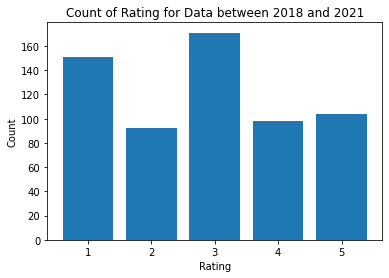

In [16]:
# Plot the count of different ratings for data between 2018 and 2021
facebook_ios_ph_review_score_count = facebook_ios_ph_review_YearMonth.groupby(['rating'])[['review']].nunique().rename(columns={'review':'count'})

plt.bar(facebook_ios_ph_review_score_count.index,facebook_ios_ph_review_score_count['count'])
plt.xlabel("Rating")
plt.ylabel("Count")
plt.title("Count of Rating for Data between 2018 and 2021")
plt.show()

Text(0.5, 1.0, 'Count of Rating for Each Year between 2018 and 2021')

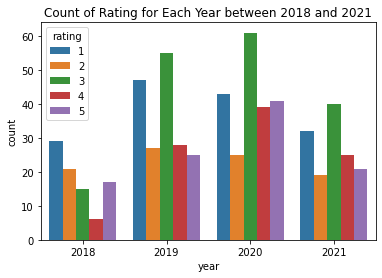

In [17]:
# Plot the count of different ratings for each year
facebook_ios_ph_review_score_count_ByYear = (facebook_ios_ph_review_YearMonth.groupby(['year','rating'])[['review']]
                                                                        .nunique()
                                                                        .rename(columns={'review':'count'})
                                                                        .reset_index()
                                              )

(sns.barplot(data=facebook_ios_ph_review_score_count_ByYear,x='year',y='count',hue='rating')
   .set_title("Count of Rating for Each Year between 2018 and 2021")
)

# Comment: extreme review score on 1 or 5

In [18]:
# Understand average ratings over year
facebook_ios_ph_review_avg_score_ByYear = (facebook_ios_ph_review_YearMonth.groupby(['year'])[['rating']]
                                                                       .mean()
                                              )

facebook_ios_ph_review_avg_score_ByYear['count'] = facebook_ios_ph_review_score_count_ByYear.groupby('year')[['count']].sum().values

print('Average ratings and count of each year:')
facebook_ios_ph_review_avg_score_ByYear

Average ratings and count of each year:


rating  count
year                 
2018  2.556818     88
2019  2.763736    182
2020  3.047847    209
2021  2.883212    137

# Dataframe Preparation for Topic Modelling

In [19]:
# Dataframe with data between 2018 and 2021 without score or year filtering
facebook_ios_ph_review_YearMonth.head()

title       date  \
24              You are trying too often 2018-01-01   
25                       Facebook layout 2018-01-02   
26                      GROUPS AND PAGES 2018-01-11   
27  After updating, Newsfeed won’t load. 2018-01-18   
28                Album view on newsfeed 2018-01-30   

                                                                                                                                                                                                     review  \
24  How do I log in when it says "you are trying too often?"\nI am attempting to log in to Facebook using the app on my iphone. Everytime I type in the email and password, it says I am trying too ofte...   
25  I don’t know what’s going on but I always have my facebook app updated. It doesn’t seem to look updated. My notification icon is still the globe thing, not the bell. My software is updated too. I ...   
26  Since I updated for some reason nobody can see my sales posts in buy and sell groups. I tried logging into different accounts and going into groups I am in and when I search my name none of my sal...   
27  I tried updating Facebook since it’s been a while but when I started using it after the update, my newsfeed won’t load. I couldn’t even search. It seems like my app is not connecting to the intern...   
28  Its boring and it doesnt look good when you upload album. When you see it in the newsfeed or on your profile, you need to scroll to the left to see them all compare to the previous where you see a...   

    isEdited  rating        userName  year  month  
24     False       1     callmespice  2018      1  
25     False       1         Kaye ❤️  2018      1  
26     False       1  richerthanrich  2018      1  
27     False       1      ZeeBee1192  2018      1  
28     False       4     Ramonito1.0  2018      1

In [20]:
# Prepare dataframe for topic modelling for each score
# Obtain 5 dataframes with only score=1,2,3,4,5
facebook_ios_ph_review_YearMonth_score1 = facebook_ios_ph_review_YearMonth[facebook_ios_ph_review_YearMonth['rating']==1]
facebook_ios_ph_review_YearMonth_score2 = facebook_ios_ph_review_YearMonth[facebook_ios_ph_review_YearMonth['rating']==2]
facebook_ios_ph_review_YearMonth_score3 = facebook_ios_ph_review_YearMonth[facebook_ios_ph_review_YearMonth['rating']==3]
facebook_ios_ph_review_YearMonth_score4 = facebook_ios_ph_review_YearMonth[facebook_ios_ph_review_YearMonth['rating']==4]
facebook_ios_ph_review_YearMonth_score5 = facebook_ios_ph_review_YearMonth[facebook_ios_ph_review_YearMonth['rating']==5]


In [21]:
# Prepare dataframe for grouped score
facebook_ios_ph_review_YearMonth_score1N2N3 = facebook_ios_ph_review_YearMonth[facebook_ios_ph_review_YearMonth['rating'].isin([1,2,3])]
facebook_ios_ph_review_YearMonth_score4N5 = facebook_ios_ph_review_YearMonth[facebook_ios_ph_review_YearMonth['rating'].isin([4,5])]


In [22]:
# Prepare dataframe for topic modelling for 2018,2019,2020,2021 for score = 1,2,3
facebook_ios_ph_review_YearMonth_2018_score1N2N3 = facebook_ios_ph_review_YearMonth[(facebook_ios_ph_review_YearMonth['year']==2018)&(facebook_ios_ph_review_YearMonth['rating'].isin([1,2,3]))]
facebook_ios_ph_review_YearMonth_2019_score1N2N3 = facebook_ios_ph_review_YearMonth[(facebook_ios_ph_review_YearMonth['year']==2019)&(facebook_ios_ph_review_YearMonth['rating'].isin([1,2,3]))]
facebook_ios_ph_review_YearMonth_2020_score1N2N3 = facebook_ios_ph_review_YearMonth[(facebook_ios_ph_review_YearMonth['year']==2020)&(facebook_ios_ph_review_YearMonth['rating'].isin([1,2,3]))]
facebook_ios_ph_review_YearMonth_2021_score1N2N3 = facebook_ios_ph_review_YearMonth[(facebook_ios_ph_review_YearMonth['year']==2021)&(facebook_ios_ph_review_YearMonth['rating'].isin([1,2,3]))]




# Overall LDA Topic Modelling

In [23]:
# Overall Topic Modelling - data between 2018 and 2021 without score or year filtering
# Convert to list - move to each section
review_ph = facebook_ios_ph_review_YearMonth.review.values.tolist()
review_words_ph = list(sent_to_words(review_ph))
print(review_words_ph[:1])

[['how', 'do', 'log', 'in', 'when', 'it', 'says', 'you', 'are', 'trying', 'too', 'often', 'am', 'attempting', 'to', 'log', 'in', 'to', 'facebook', 'using', 'the', 'app', 'on', 'my', 'iphone', 'everytime', 'type', 'in', 'the', 'email', 'and', 'password', 'it', 'says', 'am', 'trying', 'too', 'often', 'when', 'try', 'it', 'on', 'my', 'safari', 'browser', 'it', 'works', 'how', 'am', 'supposed', 'to', 'log', 'in', 'on', 'the', 'app', 'ive', 'tried', 'restarting', 'the', 'phone', 'and', 'uninstalling', 'the', 'app', 'still', 'doesnt', 'work']]


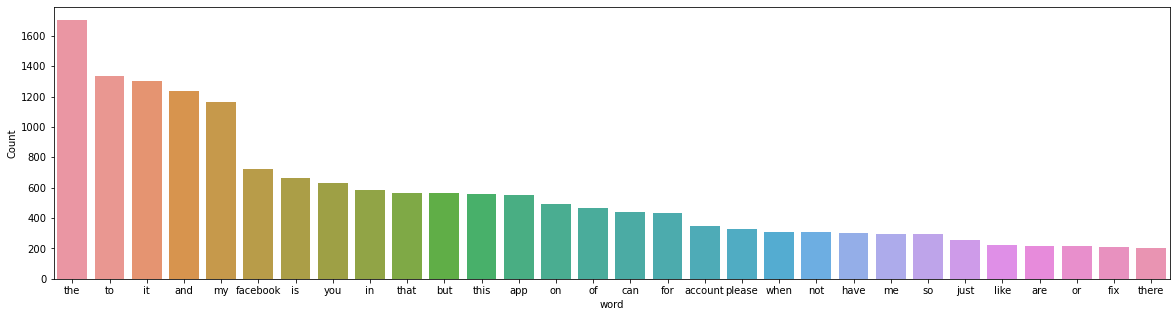

In [24]:
# Inspect the frequency of words before cleaning
freq_words(flatten(review_words_ph))

In [25]:
# Clean text
review_ph_ready = process_words(review_words_ph)  # processed Text Data! - move to each section

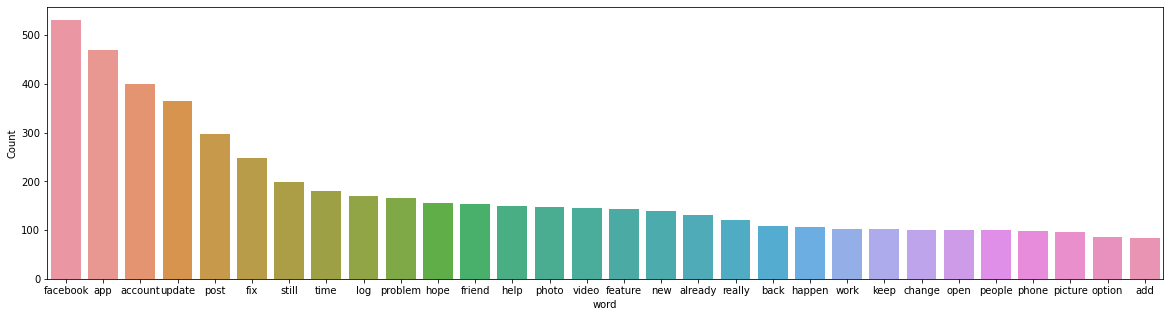

In [26]:
# Inspect the frequency of words after cleaning
freq_words(flatten(review_ph_ready))

In [27]:
# Create Dictionary
id2word_ph = corpora.Dictionary(review_ph_ready)

2021-10-16 18:10:56,803 [INFO] gensim.corpora.dictionary - adding document #0 to Dictionary(0 unique tokens: [])
2021-10-16 18:10:56,981 [INFO] gensim.corpora.dictionary - built Dictionary(2131 unique tokens: ['app', 'attempt', 'email', 'everytime', 'facebook']...) from 616 documents (total 16942 corpus positions)
2021-10-16 18:10:57,023 [INFO] gensim.utils - Dictionary lifecycle event {'msg': "built Dictionary(2131 unique tokens: ['app', 'attempt', 'email', 'everytime', 'facebook']...) from 616 documents (total 16942 corpus positions)", 'datetime': '2021-10-16T18:10:56.982822', 'gensim': '4.1.2', 'python': '3.8.8 (default, Apr 13 2021, 12:59:45) \n[Clang 10.0.0 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'created'}


In [28]:
# Create Corpus: Term Document Frequency
corpus_ph = [id2word_ph.doc2bow(text) for text in review_ph_ready]

In [29]:
# Training LDA model
model_list_ph, coherence_values_ph = compute_coherence_values(dictionary=id2word_ph, corpus=corpus_ph, 
                                                              texts=review_ph_ready, limit=30, start=2, step=5)

# Time Start: 03:44
# Time End: 
# Time Used: 

2021-10-16 18:10:57,939 [INFO] gensim.models.ldamodel - using symmetric alpha at 0.5
2021-10-16 18:10:57,943 [INFO] gensim.models.ldamodel - using symmetric eta at 0.5
2021-10-16 18:10:57,952 [INFO] gensim.models.ldamodel - using serial LDA version on this node
2021-10-16 18:10:57,964 [INFO] gensim.models.ldamodel - running online (multi-pass) LDA training, 2 topics, 50 passes over the supplied corpus of 616 documents, updating model once every 616 documents, evaluating perplexity every 616 documents, iterating 50x with a convergence threshold of 0.001000
2021-10-16 18:11:00,980 [INFO] gensim.models.ldamodel - -8.169 per-word bound, 287.8 perplexity estimate based on a held-out corpus of 616 documents with 16942 words
2021-10-16 18:11:00,982 [INFO] gensim.models.ldamodel - PROGRESS: pass 0, at document #616/616
2021-10-16 18:11:03,477 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.027*"facebook" + 0.024*"update" + 0.021*"account" + 0.019*"app" + 0.016*"post" + 0.012*"still" + 0.01

2021-10-16 18:11:37,766 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.033*"app" + 0.029*"facebook" + 0.022*"account" + 0.020*"update" + 0.016*"fix" + 0.016*"post" + 0.012*"log" + 0.011*"problem" + 0.010*"help" + 0.010*"time"
2021-10-16 18:11:37,778 [INFO] gensim.models.ldamodel - topic diff=0.022313, rho=0.301511
2021-10-16 18:11:39,388 [INFO] gensim.models.ldamodel - -6.515 per-word bound, 91.4 perplexity estimate based on a held-out corpus of 616 documents with 16942 words
2021-10-16 18:11:39,390 [INFO] gensim.models.ldamodel - PROGRESS: pass 10, at document #616/616
2021-10-16 18:11:40,658 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.026*"facebook" + 0.019*"account" + 0.018*"update" + 0.015*"post" + 0.014*"feature" + 0.014*"app" + 0.013*"video" + 0.011*"friend" + 0.011*"new" + 0.010*"still"
2021-10-16 18:11:40,660 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.034*"app" + 0.029*"facebook" + 0.022*"account" + 0.020*"update" + 0.017*"fix" + 0.016*"post" + 0.012*"log"

2021-10-16 18:12:09,055 [INFO] gensim.models.ldamodel - topic diff=0.013992, rho=0.218218
2021-10-16 18:12:10,733 [INFO] gensim.models.ldamodel - -6.500 per-word bound, 90.5 perplexity estimate based on a held-out corpus of 616 documents with 16942 words
2021-10-16 18:12:10,734 [INFO] gensim.models.ldamodel - PROGRESS: pass 20, at document #616/616
2021-10-16 18:12:12,072 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.027*"facebook" + 0.020*"account" + 0.016*"feature" + 0.015*"post" + 0.013*"update" + 0.012*"friend" + 0.011*"video" + 0.011*"app" + 0.010*"new" + 0.009*"still"
2021-10-16 18:12:12,075 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.035*"app" + 0.029*"facebook" + 0.024*"update" + 0.021*"account" + 0.018*"fix" + 0.017*"post" + 0.013*"log" + 0.012*"problem" + 0.012*"still" + 0.011*"time"
2021-10-16 18:12:12,077 [INFO] gensim.models.ldamodel - topic diff=0.013422, rho=0.213201
2021-10-16 18:12:14,047 [INFO] gensim.models.ldamodel - -6.499 per-word bound, 90.4 perplex

2021-10-16 18:12:46,632 [INFO] gensim.models.ldamodel - topic diff=0.009539, rho=0.179605
2021-10-16 18:12:48,729 [INFO] gensim.models.ldamodel - -6.491 per-word bound, 90.0 perplexity estimate based on a held-out corpus of 616 documents with 16942 words
2021-10-16 18:12:48,733 [INFO] gensim.models.ldamodel - PROGRESS: pass 30, at document #616/616
2021-10-16 18:12:50,420 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.027*"facebook" + 0.022*"account" + 0.016*"feature" + 0.015*"post" + 0.012*"friend" + 0.010*"update" + 0.010*"app" + 0.009*"video" + 0.009*"new" + 0.009*"people"
2021-10-16 18:12:50,429 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.036*"app" + 0.029*"facebook" + 0.026*"update" + 0.020*"account" + 0.018*"fix" + 0.016*"post" + 0.014*"log" + 0.013*"problem" + 0.012*"still" + 0.011*"time"
2021-10-16 18:12:50,437 [INFO] gensim.models.ldamodel - topic diff=0.009158, rho=0.176777
2021-10-16 18:12:52,969 [INFO] gensim.models.ldamodel - -6.491 per-word bound, 89.9 perple

2021-10-16 18:13:28,249 [INFO] gensim.models.ldamodel - topic diff=0.006869, rho=0.156174
2021-10-16 18:13:30,268 [INFO] gensim.models.ldamodel - -6.486 per-word bound, 89.6 perplexity estimate based on a held-out corpus of 616 documents with 16942 words
2021-10-16 18:13:30,270 [INFO] gensim.models.ldamodel - PROGRESS: pass 40, at document #616/616
2021-10-16 18:13:31,856 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.027*"facebook" + 0.024*"account" + 0.017*"feature" + 0.015*"post" + 0.012*"friend" + 0.010*"people" + 0.009*"app" + 0.009*"update" + 0.009*"really" + 0.009*"new"
2021-10-16 18:13:31,870 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.036*"app" + 0.028*"facebook" + 0.027*"update" + 0.019*"account" + 0.019*"fix" + 0.016*"post" + 0.014*"log" + 0.013*"problem" + 0.013*"still" + 0.012*"time"
2021-10-16 18:13:31,872 [INFO] gensim.models.ldamodel - topic diff=0.006716, rho=0.154303
2021-10-16 18:13:33,811 [INFO] gensim.models.ldamodel - -6.485 per-word bound, 89.6 perpl

2021-10-16 18:14:03,556 [INFO] gensim.models.ldamodel - topic diff=0.005069, rho=0.140028
2021-10-16 18:14:03,560 [INFO] gensim.utils - LdaModel lifecycle event {'msg': 'trained LdaModel(num_terms=2131, num_topics=2, decay=0.5, chunksize=1000) in 185.59s', 'datetime': '2021-10-16T18:14:03.558336', 'gensim': '4.1.2', 'python': '3.8.8 (default, Apr 13 2021, 12:59:45) \n[Clang 10.0.0 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'created'}
2021-10-16 18:14:03,568 [INFO] gensim.topic_coherence.probability_estimation - using ParallelWordOccurrenceAccumulator(processes=7, batch_size=64) to estimate probabilities from sliding windows
2021-10-16 18:14:09,522 [INFO] gensim.topic_coherence.text_analysis - 7 accumulators retrieved from output queue
2021-10-16 18:14:09,579 [INFO] gensim.topic_coherence.text_analysis - accumulated word occurrence stats for 615 virtual documents
2021-10-16 18:14:10,018 [INFO] gensim.models.ldamodel - using symmetric alpha at 0.14285714285714285
2021-10-1

2021-10-16 18:14:28,699 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.044*"account" + 0.034*"facebook" + 0.026*"app" + 0.017*"photo" + 0.016*"video" + 0.015*"help" + 0.014*"hope" + 0.011*"update" + 0.009*"watch" + 0.009*"friend"
2021-10-16 18:14:28,713 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.039*"account" + 0.036*"log" + 0.024*"update" + 0.024*"facebook" + 0.022*"fix" + 0.020*"app" + 0.019*"post" + 0.018*"still" + 0.011*"time" + 0.010*"new"
2021-10-16 18:14:28,717 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.039*"app" + 0.038*"facebook" + 0.037*"update" + 0.035*"post" + 0.024*"fix" + 0.017*"problem" + 0.014*"time" + 0.012*"feature" + 0.012*"already" + 0.010*"friend"
2021-10-16 18:14:28,728 [INFO] gensim.models.ldamodel - topic diff=0.116150, rho=0.408248
2021-10-16 18:14:30,655 [INFO] gensim.models.ldamodel - -6.674 per-word bound, 102.1 perplexity estimate based on a held-out corpus of 616 documents with 16942 words
2021-10-16 18:14:30,656 [INFO] gensim.models

2021-10-16 18:14:44,228 [INFO] gensim.models.ldamodel - topic diff=0.035015, rho=0.301511
2021-10-16 18:14:46,004 [INFO] gensim.models.ldamodel - -6.647 per-word bound, 100.2 perplexity estimate based on a held-out corpus of 616 documents with 16942 words
2021-10-16 18:14:46,007 [INFO] gensim.models.ldamodel - PROGRESS: pass 10, at document #616/616
2021-10-16 18:14:47,250 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.043*"account" + 0.040*"log" + 0.024*"facebook" + 0.023*"update" + 0.023*"fix" + 0.020*"app" + 0.018*"still" + 0.016*"post" + 0.013*"error" + 0.010*"new"
2021-10-16 18:14:47,253 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.042*"app" + 0.039*"update" + 0.037*"facebook" + 0.036*"post" + 0.024*"fix" + 0.019*"problem" + 0.015*"time" + 0.012*"already" + 0.011*"feature" + 0.010*"notification"
2021-10-16 18:14:47,254 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.018*"facebook" + 0.017*"really" + 0.011*"post" + 0.010*"people" + 0.010*"keep" + 0.009*"hope" + 0.00

2021-10-16 18:15:01,664 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.044*"account" + 0.041*"log" + 0.025*"facebook" + 0.023*"fix" + 0.022*"update" + 0.020*"app" + 0.019*"still" + 0.014*"post" + 0.014*"error" + 0.011*"work"
2021-10-16 18:15:01,680 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.046*"account" + 0.036*"facebook" + 0.021*"photo" + 0.019*"app" + 0.015*"help" + 0.015*"video" + 0.014*"hope" + 0.010*"friend" + 0.009*"back" + 0.009*"watch"
2021-10-16 18:15:01,688 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.018*"really" + 0.018*"facebook" + 0.011*"post" + 0.011*"people" + 0.009*"hope" + 0.009*"keep" + 0.009*"free" + 0.008*"video" + 0.007*"way" + 0.007*"connect"
2021-10-16 18:15:01,690 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.043*"app" + 0.040*"update" + 0.038*"post" + 0.036*"facebook" + 0.024*"fix" + 0.019*"problem" + 0.015*"time" + 0.012*"already" + 0.011*"feature" + 0.010*"notification"
2021-10-16 18:15:01,692 [INFO] gensim.models.ldamodel - topic

2021-10-16 18:15:16,582 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.040*"app" + 0.016*"phone" + 0.015*"facebook" + 0.013*"update" + 0.013*"still" + 0.012*"keep" + 0.012*"problem" + 0.011*"open" + 0.011*"time" + 0.010*"picture"
2021-10-16 18:15:16,585 [INFO] gensim.models.ldamodel - topic diff=0.010385, rho=0.213201
2021-10-16 18:15:18,155 [INFO] gensim.models.ldamodel - -6.625 per-word bound, 98.7 perplexity estimate based on a held-out corpus of 616 documents with 16942 words
2021-10-16 18:15:18,158 [INFO] gensim.models.ldamodel - PROGRESS: pass 21, at document #616/616
2021-10-16 18:15:19,365 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.018*"really" + 0.018*"facebook" + 0.012*"post" + 0.011*"people" + 0.009*"hope" + 0.009*"free" + 0.008*"keep" + 0.007*"video" + 0.007*"way" + 0.007*"connect"
2021-10-16 18:15:19,368 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.018*"feature" + 0.018*"facebook" + 0.016*"photo" + 0.014*"back" + 0.013*"video" + 0.013*"post" + 0.008*"p

2021-10-16 18:15:32,964 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.042*"app" + 0.017*"phone" + 0.015*"facebook" + 0.013*"update" + 0.013*"still" + 0.012*"keep" + 0.011*"problem" + 0.011*"open" + 0.010*"change" + 0.010*"time"
2021-10-16 18:15:32,969 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.019*"feature" + 0.018*"facebook" + 0.017*"photo" + 0.014*"back" + 0.013*"video" + 0.012*"post" + 0.008*"people" + 0.008*"change" + 0.007*"new" + 0.007*"update"
2021-10-16 18:15:33,000 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.043*"app" + 0.040*"update" + 0.039*"post" + 0.036*"facebook" + 0.024*"fix" + 0.019*"problem" + 0.015*"time" + 0.011*"already" + 0.011*"notification" + 0.010*"friend"
2021-10-16 18:15:33,002 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.048*"account" + 0.036*"facebook" + 0.022*"photo" + 0.016*"help" + 0.015*"app" + 0.014*"hope" + 0.013*"video" + 0.010*"album" + 0.010*"friend" + 0.010*"back"
2021-10-16 18:15:33,004 [INFO] gensim.models.ldamodel -

2021-10-16 18:15:47,041 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.043*"app" + 0.040*"update" + 0.039*"post" + 0.036*"facebook" + 0.024*"fix" + 0.019*"problem" + 0.015*"time" + 0.011*"already" + 0.011*"notification" + 0.010*"friend"
2021-10-16 18:15:47,044 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.019*"friend" + 0.018*"facebook" + 0.016*"people" + 0.015*"request" + 0.013*"update" + 0.012*"comment" + 0.012*"post" + 0.011*"time" + 0.011*"new" + 0.010*"page"
2021-10-16 18:15:47,046 [INFO] gensim.models.ldamodel - topic diff=0.005807, rho=0.174078
2021-10-16 18:15:49,092 [INFO] gensim.models.ldamodel - -6.616 per-word bound, 98.1 perplexity estimate based on a held-out corpus of 616 documents with 16942 words
2021-10-16 18:15:49,094 [INFO] gensim.models.ldamodel - PROGRESS: pass 32, at document #616/616
2021-10-16 18:15:50,407 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.043*"app" + 0.017*"phone" + 0.015*"facebook" + 0.013*"update" + 0.013*"still" + 0.012*"keep" +

2021-10-16 18:16:03,258 [INFO] gensim.models.ldamodel - -6.614 per-word bound, 97.9 perplexity estimate based on a held-out corpus of 616 documents with 16942 words
2021-10-16 18:16:03,259 [INFO] gensim.models.ldamodel - PROGRESS: pass 37, at document #616/616
2021-10-16 18:16:04,630 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.019*"friend" + 0.017*"facebook" + 0.016*"people" + 0.015*"request" + 0.012*"update" + 0.012*"comment" + 0.011*"post" + 0.011*"time" + 0.011*"new" + 0.010*"page"
2021-10-16 18:16:04,632 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.043*"app" + 0.040*"update" + 0.039*"post" + 0.036*"facebook" + 0.024*"fix" + 0.019*"problem" + 0.015*"time" + 0.011*"already" + 0.011*"notification" + 0.010*"friend"
2021-10-16 18:16:04,637 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.045*"account" + 0.044*"log" + 0.026*"facebook" + 0.023*"fix" + 0.021*"update" + 0.021*"app" + 0.019*"still" + 0.015*"error" + 0.012*"work" + 0.011*"post"
2021-10-16 18:16:04,642 [INFO]

2021-10-16 18:16:20,649 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.045*"account" + 0.044*"log" + 0.026*"facebook" + 0.023*"fix" + 0.021*"app" + 0.021*"update" + 0.019*"still" + 0.015*"error" + 0.012*"work" + 0.011*"post"
2021-10-16 18:16:20,652 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.044*"app" + 0.041*"update" + 0.039*"post" + 0.035*"facebook" + 0.024*"fix" + 0.019*"problem" + 0.015*"time" + 0.011*"notification" + 0.011*"already" + 0.011*"friend"
2021-10-16 18:16:20,654 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.019*"friend" + 0.017*"facebook" + 0.016*"people" + 0.015*"request" + 0.012*"comment" + 0.011*"update" + 0.011*"post" + 0.011*"time" + 0.010*"new" + 0.010*"put"
2021-10-16 18:16:20,656 [INFO] gensim.models.ldamodel - topic diff=0.003939, rho=0.150756
2021-10-16 18:16:22,154 [INFO] gensim.models.ldamodel - -6.611 per-word bound, 97.8 perplexity estimate based on a held-out corpus of 616 documents with 16942 words
2021-10-16 18:16:22,156 [INFO] gensim

2021-10-16 18:16:35,385 [INFO] gensim.models.ldamodel - topic diff=0.003554, rho=0.142857
2021-10-16 18:16:37,003 [INFO] gensim.models.ldamodel - -6.609 per-word bound, 97.6 perplexity estimate based on a held-out corpus of 616 documents with 16942 words
2021-10-16 18:16:37,008 [INFO] gensim.models.ldamodel - PROGRESS: pass 48, at document #616/616
2021-10-16 18:16:38,412 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.045*"account" + 0.044*"log" + 0.026*"facebook" + 0.023*"fix" + 0.021*"app" + 0.021*"update" + 0.019*"still" + 0.015*"error" + 0.012*"work" + 0.011*"help"
2021-10-16 18:16:38,415 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.019*"friend" + 0.017*"facebook" + 0.017*"people" + 0.015*"request" + 0.012*"comment" + 0.011*"post" + 0.011*"time" + 0.011*"update" + 0.010*"new" + 0.010*"put"
2021-10-16 18:16:38,418 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.019*"really" + 0.018*"facebook" + 0.012*"post" + 0.011*"people" + 0.009*"free" + 0.009*"hope" + 0.008*"keep

2021-10-16 18:17:02,261 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.054*"account" + 0.035*"facebook" + 0.025*"app" + 0.020*"help" + 0.016*"photo" + 0.015*"hope" + 0.013*"update" + 0.013*"video" + 0.010*"friend" + 0.010*"back"
2021-10-16 18:17:02,263 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.029*"facebook" + 0.017*"account" + 0.015*"time" + 0.014*"hope" + 0.013*"post" + 0.012*"feature" + 0.011*"dark" + 0.011*"mode" + 0.010*"io" + 0.010*"really"
2021-10-16 18:17:02,266 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.040*"app" + 0.030*"update" + 0.020*"problem" + 0.018*"post" + 0.015*"still" + 0.014*"video" + 0.013*"facebook" + 0.013*"really" + 0.012*"time" + 0.012*"iphone"
2021-10-16 18:17:02,268 [INFO] gensim.models.ldamodel - topic diff=0.239609, rho=0.500000
2021-10-16 18:17:04,061 [INFO] gensim.models.ldamodel - -6.836 per-word bound, 114.3 perplexity estimate based on a held-out corpus of 616 documents with 16942 words
2021-10-16 18:17:04,062 [INFO] gensim.mode

2021-10-16 18:17:19,425 [INFO] gensim.models.ldamodel - topic diff=0.073227, rho=0.333333
2021-10-16 18:17:21,296 [INFO] gensim.models.ldamodel - -6.754 per-word bound, 108.0 perplexity estimate based on a held-out corpus of 616 documents with 16942 words
2021-10-16 18:17:21,297 [INFO] gensim.models.ldamodel - PROGRESS: pass 8, at document #616/616
2021-10-16 18:17:22,585 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.041*"post" + 0.036*"facebook" + 0.028*"update" + 0.026*"fix" + 0.024*"app" + 0.020*"feature" + 0.016*"friend" + 0.015*"problem" + 0.014*"picture" + 0.012*"time"
2021-10-16 18:17:22,599 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.030*"facebook" + 0.028*"dark" + 0.027*"mode" + 0.016*"account" + 0.016*"io" + 0.015*"time" + 0.014*"hope" + 0.012*"option" + 0.012*"post" + 0.012*"really"
2021-10-16 18:17:22,633 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.049*"app" + 0.029*"fix" + 0.028*"update" + 0.026*"video" + 0.024*"facebook" + 0.016*"crash" + 0.016*"time

2021-10-16 18:17:40,022 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.047*"app" + 0.034*"update" + 0.021*"problem" + 0.021*"notification" + 0.018*"post" + 0.016*"still" + 0.014*"video" + 0.013*"really" + 0.012*"facebook" + 0.012*"comment"
2021-10-16 18:17:40,025 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.044*"post" + 0.036*"facebook" + 0.029*"update" + 0.026*"fix" + 0.025*"app" + 0.020*"feature" + 0.016*"friend" + 0.015*"problem" + 0.014*"picture" + 0.012*"time"
2021-10-16 18:17:40,026 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.022*"photo" + 0.021*"show" + 0.020*"facebook" + 0.016*"picture" + 0.013*"profile" + 0.013*"people" + 0.012*"bring" + 0.011*"app" + 0.010*"post" + 0.010*"thing"
2021-10-16 18:17:40,029 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.051*"app" + 0.030*"fix" + 0.030*"video" + 0.029*"update" + 0.023*"facebook" + 0.017*"crash" + 0.016*"problem" + 0.016*"time" + 0.012*"photo" + 0.011*"still"
2021-10-16 18:17:40,031 [INFO] gensim.models.ldam

2021-10-16 18:17:55,427 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.048*"app" + 0.035*"update" + 0.022*"notification" + 0.021*"problem" + 0.017*"post" + 0.016*"still" + 0.013*"comment" + 0.013*"really" + 0.013*"facebook" + 0.012*"video"
2021-10-16 18:17:55,428 [INFO] gensim.models.ldamodel - topic diff=0.016073, rho=0.223607
2021-10-16 18:17:57,172 [INFO] gensim.models.ldamodel - -6.713 per-word bound, 104.9 perplexity estimate based on a held-out corpus of 616 documents with 16942 words
2021-10-16 18:17:57,174 [INFO] gensim.models.ldamodel - PROGRESS: pass 19, at document #616/616
2021-10-16 18:17:58,515 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.046*"post" + 0.035*"facebook" + 0.029*"update" + 0.026*"fix" + 0.025*"app" + 0.020*"feature" + 0.016*"friend" + 0.014*"problem" + 0.014*"picture" + 0.013*"time"
2021-10-16 18:17:58,517 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.033*"app" + 0.021*"facebook" + 0.020*"setting" + 0.019*"change" + 0.014*"datum" + 0.014*"t

2021-10-16 18:18:12,640 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.059*"mode" + 0.058*"dark" + 0.032*"facebook" + 0.017*"really" + 0.016*"io" + 0.016*"account" + 0.015*"option" + 0.015*"hope" + 0.014*"time" + 0.014*"app"
2021-10-16 18:18:12,643 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.053*"app" + 0.041*"video" + 0.033*"fix" + 0.030*"update" + 0.023*"facebook" + 0.019*"crash" + 0.017*"problem" + 0.016*"time" + 0.016*"watch" + 0.011*"still"
2021-10-16 18:18:12,644 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.049*"app" + 0.036*"update" + 0.023*"notification" + 0.021*"problem" + 0.017*"post" + 0.016*"still" + 0.013*"comment" + 0.013*"really" + 0.013*"facebook" + 0.011*"time"
2021-10-16 18:18:12,646 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.026*"feature" + 0.022*"facebook" + 0.019*"photo" + 0.016*"back" + 0.013*"change" + 0.012*"post" + 0.011*"block" + 0.010*"app" + 0.010*"old" + 0.010*"video"
2021-10-16 18:18:12,647 [INFO] gensim.models.ldamodel - topic

2021-10-16 18:18:25,815 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.022*"photo" + 0.021*"show" + 0.020*"facebook" + 0.018*"picture" + 0.014*"profile" + 0.013*"people" + 0.012*"bring" + 0.010*"thing" + 0.010*"feature" + 0.009*"post"
2021-10-16 18:18:25,817 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.020*"facebook" + 0.020*"friend" + 0.020*"page" + 0.015*"new" + 0.015*"post" + 0.013*"comment" + 0.013*"live" + 0.012*"request" + 0.012*"time" + 0.011*"update"
2021-10-16 18:18:25,820 [INFO] gensim.models.ldamodel - topic diff=0.007598, rho=0.179605
2021-10-16 18:18:27,282 [INFO] gensim.models.ldamodel - -6.697 per-word bound, 103.7 perplexity estimate based on a held-out corpus of 616 documents with 16942 words
2021-10-16 18:18:27,283 [INFO] gensim.models.ldamodel - PROGRESS: pass 30, at document #616/616
2021-10-16 18:18:28,407 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.053*"app" + 0.045*"video" + 0.033*"fix" + 0.031*"update" + 0.023*"facebook" + 0.020*"crash" + 0.0

2021-10-16 18:18:43,815 [INFO] gensim.models.ldamodel - PROGRESS: pass 35, at document #616/616
2021-10-16 18:18:45,022 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.053*"app" + 0.048*"video" + 0.034*"fix" + 0.031*"update" + 0.023*"facebook" + 0.020*"crash" + 0.019*"watch" + 0.017*"problem" + 0.016*"time" + 0.012*"play"
2021-10-16 18:18:45,025 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.022*"photo" + 0.021*"show" + 0.020*"facebook" + 0.018*"picture" + 0.014*"profile" + 0.013*"people" + 0.011*"bring" + 0.010*"thing" + 0.010*"feature" + 0.009*"post"
2021-10-16 18:18:45,027 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.050*"app" + 0.035*"update" + 0.023*"notification" + 0.022*"problem" + 0.017*"post" + 0.016*"still" + 0.013*"comment" + 0.013*"really" + 0.013*"facebook" + 0.011*"phone"
2021-10-16 18:18:45,031 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.029*"feature" + 0.022*"facebook" + 0.020*"photo" + 0.017*"back" + 0.013*"change" + 0.012*"post" + 0.011*"old" +

2021-10-16 18:19:01,192 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.020*"facebook" + 0.020*"page" + 0.020*"friend" + 0.016*"new" + 0.016*"post" + 0.013*"comment" + 0.013*"live" + 0.012*"request" + 0.012*"time" + 0.010*"update"
2021-10-16 18:19:01,194 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.066*"account" + 0.037*"facebook" + 0.023*"help" + 0.017*"photo" + 0.016*"hope" + 0.013*"app" + 0.012*"friend" + 0.012*"already" + 0.012*"still" + 0.010*"back"
2021-10-16 18:19:01,196 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.054*"post" + 0.037*"update" + 0.034*"facebook" + 0.021*"app" + 0.013*"still" + 0.012*"version" + 0.012*"story" + 0.011*"friend" + 0.010*"option" + 0.010*"share"
2021-10-16 18:19:01,198 [INFO] gensim.models.ldamodel - topic diff=0.004303, rho=0.154303
2021-10-16 18:19:02,796 [INFO] gensim.models.ldamodel - -6.691 per-word bound, 103.3 perplexity estimate based on a held-out corpus of 616 documents with 16942 words
2021-10-16 18:19:02,809 [INFO] gensi

2021-10-16 18:19:20,523 [INFO] gensim.models.ldamodel - topic diff=0.003552, rho=0.145865
2021-10-16 18:19:23,477 [INFO] gensim.models.ldamodel - -6.688 per-word bound, 103.1 perplexity estimate based on a held-out corpus of 616 documents with 16942 words
2021-10-16 18:19:23,479 [INFO] gensim.models.ldamodel - PROGRESS: pass 46, at document #616/616
2021-10-16 18:19:25,351 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.051*"app" + 0.035*"update" + 0.024*"notification" + 0.022*"problem" + 0.016*"post" + 0.016*"still" + 0.013*"really" + 0.013*"comment" + 0.013*"facebook" + 0.012*"phone"
2021-10-16 18:19:25,353 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.068*"account" + 0.037*"facebook" + 0.023*"help" + 0.017*"photo" + 0.016*"hope" + 0.013*"app" + 0.012*"friend" + 0.012*"already" + 0.012*"still" + 0.010*"back"
2021-10-16 18:19:25,354 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.053*"video" + 0.053*"app" + 0.034*"fix" + 0.031*"update" + 0.023*"facebook" + 0.022*"watch" 

2021-10-16 18:20:00,162 [INFO] gensim.models.ldamodel - topic #2 (0.059): 0.058*"account" + 0.038*"facebook" + 0.021*"help" + 0.020*"app" + 0.014*"hope" + 0.014*"update" + 0.010*"photo" + 0.010*"friend" + 0.010*"video" + 0.009*"back"
2021-10-16 18:20:00,166 [INFO] gensim.models.ldamodel - topic #3 (0.059): 0.047*"account" + 0.036*"log" + 0.023*"facebook" + 0.020*"app" + 0.019*"fix" + 0.018*"update" + 0.017*"still" + 0.015*"new" + 0.012*"post" + 0.011*"help"
2021-10-16 18:20:00,168 [INFO] gensim.models.ldamodel - topic #13 (0.059): 0.032*"post" + 0.021*"facebook" + 0.019*"notification" + 0.019*"photo" + 0.019*"app" + 0.015*"account" + 0.014*"fix" + 0.014*"video" + 0.013*"option" + 0.012*"friend"
2021-10-16 18:20:00,169 [INFO] gensim.models.ldamodel - topic diff=12.269392, rho=1.000000
2021-10-16 18:20:02,309 [INFO] gensim.models.ldamodel - -7.123 per-word bound, 139.3 perplexity estimate based on a held-out corpus of 616 documents with 16942 words
2021-10-16 18:20:02,311 [INFO] gensim.m

2021-10-16 18:20:17,204 [INFO] gensim.models.ldamodel - topic diff=0.140603, rho=0.377964
2021-10-16 18:20:18,886 [INFO] gensim.models.ldamodel - -6.855 per-word bound, 115.7 perplexity estimate based on a held-out corpus of 616 documents with 16942 words
2021-10-16 18:20:18,894 [INFO] gensim.models.ldamodel - PROGRESS: pass 6, at document #616/616
2021-10-16 18:20:20,243 [INFO] gensim.models.ldamodel - topic #7 (0.059): 0.047*"app" + 0.033*"update" + 0.028*"photo" + 0.022*"album" + 0.022*"fix" + 0.019*"time" + 0.015*"facebook" + 0.015*"still" + 0.010*"bug" + 0.009*"crash"
2021-10-16 18:20:20,297 [INFO] gensim.models.ldamodel - topic #9 (0.059): 0.031*"picture" + 0.017*"bring" + 0.017*"profile" + 0.016*"feature" + 0.015*"really" + 0.013*"facebook" + 0.013*"thing" + 0.011*"account" + 0.011*"people" + 0.009*"new"
2021-10-16 18:20:20,309 [INFO] gensim.models.ldamodel - topic #10 (0.059): 0.032*"post" + 0.028*"update" + 0.024*"account" + 0.022*"facebook" + 0.019*"app" + 0.016*"late" + 0.01

2021-10-16 18:20:35,342 [INFO] gensim.models.ldamodel - topic #13 (0.059): 0.040*"post" + 0.021*"notification" + 0.019*"group" + 0.019*"facebook" + 0.017*"video" + 0.016*"show" + 0.016*"fix" + 0.015*"upload" + 0.014*"option" + 0.013*"friend"
2021-10-16 18:20:35,346 [INFO] gensim.models.ldamodel - topic #1 (0.059): 0.039*"change" + 0.022*"setting" + 0.022*"facebook" + 0.020*"app" + 0.016*"privacy" + 0.014*"edit" + 0.014*"view" + 0.014*"picture" + 0.013*"set" + 0.012*"problem"
2021-10-16 18:20:35,349 [INFO] gensim.models.ldamodel - topic #15 (0.059): 0.046*"facebook" + 0.044*"app" + 0.035*"video" + 0.023*"update" + 0.018*"fix" + 0.014*"watch" + 0.014*"add" + 0.012*"play" + 0.012*"still" + 0.011*"problem"
2021-10-16 18:20:35,353 [INFO] gensim.models.ldamodel - topic #16 (0.059): 0.077*"post" + 0.024*"comment" + 0.022*"facebook" + 0.016*"time" + 0.016*"page" + 0.014*"group" + 0.012*"app" + 0.011*"update" + 0.010*"hope" + 0.010*"work"
2021-10-16 18:20:35,355 [INFO] gensim.models.ldamodel - 

2021-10-16 18:20:51,233 [INFO] gensim.models.ldamodel - topic #6 (0.059): 0.048*"feature" + 0.037*"facebook" + 0.032*"update" + 0.025*"app" + 0.020*"picture" + 0.016*"post" + 0.015*"profile" + 0.015*"photo" + 0.012*"story" + 0.012*"fix"
2021-10-16 18:20:51,235 [INFO] gensim.models.ldamodel - topic diff=0.022950, rho=0.235702
2021-10-16 18:20:53,708 [INFO] gensim.models.ldamodel - -6.776 per-word bound, 109.6 perplexity estimate based on a held-out corpus of 616 documents with 16942 words
2021-10-16 18:20:53,710 [INFO] gensim.models.ldamodel - PROGRESS: pass 17, at document #616/616
2021-10-16 18:20:55,367 [INFO] gensim.models.ldamodel - topic #6 (0.059): 0.049*"feature" + 0.037*"facebook" + 0.032*"update" + 0.025*"app" + 0.020*"picture" + 0.016*"post" + 0.016*"profile" + 0.015*"photo" + 0.013*"story" + 0.012*"hope"
2021-10-16 18:20:55,370 [INFO] gensim.models.ldamodel - topic #15 (0.059): 0.045*"facebook" + 0.044*"app" + 0.041*"video" + 0.023*"update" + 0.019*"fix" + 0.016*"watch" + 0.

2021-10-16 18:21:10,187 [INFO] gensim.models.ldamodel - topic #0 (0.059): 0.028*"update" + 0.025*"page" + 0.020*"new" + 0.017*"facebook" + 0.013*"post" + 0.011*"app" + 0.011*"already" + 0.011*"still" + 0.011*"really" + 0.011*"fb"
2021-10-16 18:21:10,189 [INFO] gensim.models.ldamodel - topic #2 (0.059): 0.080*"account" + 0.043*"facebook" + 0.027*"help" + 0.016*"hope" + 0.013*"friend" + 0.012*"send" + 0.012*"already" + 0.010*"give" + 0.010*"app" + 0.009*"report"
2021-10-16 18:21:10,191 [INFO] gensim.models.ldamodel - topic #11 (0.059): 0.024*"facebook" + 0.021*"people" + 0.016*"keep" + 0.012*"add" + 0.012*"upload" + 0.011*"friend" + 0.010*"photo" + 0.010*"new" + 0.010*"future" + 0.009*"always"
2021-10-16 18:21:10,193 [INFO] gensim.models.ldamodel - topic #14 (0.059): 0.040*"app" + 0.030*"update" + 0.022*"friend" + 0.018*"time" + 0.017*"post" + 0.017*"fix" + 0.015*"notification" + 0.014*"problem" + 0.013*"keep" + 0.012*"tab"
2021-10-16 18:21:10,194 [INFO] gensim.models.ldamodel - topic #5

2021-10-16 18:21:24,582 [INFO] gensim.models.ldamodel - topic #0 (0.059): 0.028*"update" + 0.025*"page" + 0.020*"new" + 0.017*"facebook" + 0.013*"post" + 0.011*"already" + 0.011*"really" + 0.011*"app" + 0.011*"message" + 0.011*"fb"
2021-10-16 18:21:24,584 [INFO] gensim.models.ldamodel - topic #4 (0.059): 0.026*"account" + 0.022*"facebook" + 0.013*"keep" + 0.013*"hope" + 0.012*"post" + 0.012*"really" + 0.012*"option" + 0.012*"tab" + 0.011*"group" + 0.011*"time"
2021-10-16 18:21:24,585 [INFO] gensim.models.ldamodel - topic diff=0.010243, rho=0.185695
2021-10-16 18:21:26,302 [INFO] gensim.models.ldamodel - -6.754 per-word bound, 107.9 perplexity estimate based on a held-out corpus of 616 documents with 16942 words
2021-10-16 18:21:26,311 [INFO] gensim.models.ldamodel - PROGRESS: pass 28, at document #616/616
2021-10-16 18:21:27,575 [INFO] gensim.models.ldamodel - topic #11 (0.059): 0.024*"facebook" + 0.021*"people" + 0.016*"keep" + 0.012*"add" + 0.011*"friend" + 0.011*"upload" + 0.010*"ne

2021-10-16 18:21:41,621 [INFO] gensim.models.ldamodel - -6.748 per-word bound, 107.5 perplexity estimate based on a held-out corpus of 616 documents with 16942 words
2021-10-16 18:21:41,632 [INFO] gensim.models.ldamodel - PROGRESS: pass 33, at document #616/616
2021-10-16 18:21:42,848 [INFO] gensim.models.ldamodel - topic #9 (0.059): 0.032*"picture" + 0.017*"bring" + 0.016*"profile" + 0.014*"really" + 0.013*"thing" + 0.012*"facebook" + 0.011*"account" + 0.011*"people" + 0.010*"new" + 0.009*"feature"
2021-10-16 18:21:42,854 [INFO] gensim.models.ldamodel - topic #5 (0.059): 0.029*"facebook" + 0.016*"feature" + 0.014*"change" + 0.012*"back" + 0.010*"account" + 0.010*"app" + 0.010*"featured" + 0.010*"resolution" + 0.009*"love" + 0.009*"connect"
2021-10-16 18:21:42,858 [INFO] gensim.models.ldamodel - topic #11 (0.059): 0.024*"facebook" + 0.022*"people" + 0.017*"keep" + 0.012*"add" + 0.011*"friend" + 0.010*"upload" + 0.010*"future" + 0.010*"new" + 0.009*"always" + 0.009*"profile"
2021-10-16 

2021-10-16 18:21:59,842 [INFO] gensim.models.ldamodel - topic #4 (0.059): 0.026*"account" + 0.023*"facebook" + 0.013*"keep" + 0.013*"hope" + 0.013*"post" + 0.012*"really" + 0.012*"tab" + 0.012*"group" + 0.012*"option" + 0.011*"time"
2021-10-16 18:21:59,844 [INFO] gensim.models.ldamodel - topic #14 (0.059): 0.042*"app" + 0.031*"update" + 0.022*"friend" + 0.018*"time" + 0.017*"fix" + 0.017*"post" + 0.015*"notification" + 0.014*"keep" + 0.014*"problem" + 0.012*"crash"
2021-10-16 18:21:59,846 [INFO] gensim.models.ldamodel - topic #8 (0.059): 0.035*"app" + 0.020*"still" + 0.018*"click" + 0.018*"problem" + 0.016*"update" + 0.015*"block" + 0.015*"search" + 0.013*"watch" + 0.013*"video" + 0.013*"time"
2021-10-16 18:21:59,849 [INFO] gensim.models.ldamodel - topic diff=0.005862, rho=0.158114
2021-10-16 18:22:01,576 [INFO] gensim.models.ldamodel - -6.743 per-word bound, 107.1 perplexity estimate based on a held-out corpus of 616 documents with 16942 words
2021-10-16 18:22:01,587 [INFO] gensim.mod

2021-10-16 18:22:14,316 [INFO] gensim.models.ldamodel - topic diff=0.004841, rho=0.149071
2021-10-16 18:22:15,921 [INFO] gensim.models.ldamodel - -6.739 per-word bound, 106.8 perplexity estimate based on a held-out corpus of 616 documents with 16942 words
2021-10-16 18:22:15,926 [INFO] gensim.models.ldamodel - PROGRESS: pass 44, at document #616/616
2021-10-16 18:22:17,205 [INFO] gensim.models.ldamodel - topic #9 (0.059): 0.032*"picture" + 0.015*"profile" + 0.015*"bring" + 0.013*"thing" + 0.013*"really" + 0.012*"facebook" + 0.012*"account" + 0.011*"people" + 0.009*"hope" + 0.009*"active"
2021-10-16 18:22:17,207 [INFO] gensim.models.ldamodel - topic #12 (0.059): 0.043*"post" + 0.040*"facebook" + 0.034*"app" + 0.032*"update" + 0.029*"problem" + 0.026*"fix" + 0.019*"already" + 0.016*"feed" + 0.015*"happen" + 0.015*"refresh"
2021-10-16 18:22:17,208 [INFO] gensim.models.ldamodel - topic #2 (0.059): 0.082*"account" + 0.044*"facebook" + 0.028*"help" + 0.016*"hope" + 0.013*"send" + 0.013*"frie

2021-10-16 18:22:31,786 [INFO] gensim.models.ldamodel - topic #9 (0.059): 0.032*"picture" + 0.015*"profile" + 0.014*"bring" + 0.013*"thing" + 0.012*"really" + 0.012*"facebook" + 0.012*"account" + 0.011*"people" + 0.009*"hope" + 0.009*"active"
2021-10-16 18:22:31,793 [INFO] gensim.models.ldamodel - topic #5 (0.059): 0.029*"facebook" + 0.014*"change" + 0.012*"featured" + 0.011*"account" + 0.010*"resolution" + 0.010*"connect" + 0.010*"small" + 0.010*"mode" + 0.009*"app" + 0.009*"block"
2021-10-16 18:22:31,796 [INFO] gensim.models.ldamodel - topic #13 (0.059): 0.044*"post" + 0.031*"group" + 0.021*"notification" + 0.018*"page" + 0.017*"fix" + 0.017*"facebook" + 0.017*"show" + 0.016*"video" + 0.014*"option" + 0.014*"upload"
2021-10-16 18:22:31,801 [INFO] gensim.models.ldamodel - topic #2 (0.059): 0.082*"account" + 0.044*"facebook" + 0.028*"help" + 0.016*"hope" + 0.014*"send" + 0.013*"friend" + 0.012*"already" + 0.010*"give" + 0.009*"report" + 0.009*"app"
2021-10-16 18:22:31,803 [INFO] gensim

2021-10-16 18:22:58,381 [INFO] gensim.models.ldamodel - topic #1 (0.045): 0.022*"picture" + 0.021*"app" + 0.020*"notification" + 0.019*"change" + 0.016*"facebook" + 0.016*"fix" + 0.015*"setting" + 0.014*"still" + 0.013*"time" + 0.012*"error"
2021-10-16 18:22:58,382 [INFO] gensim.models.ldamodel - topic diff=0.228225, rho=0.447214
2021-10-16 18:23:00,026 [INFO] gensim.models.ldamodel - -6.972 per-word bound, 125.5 perplexity estimate based on a held-out corpus of 616 documents with 16942 words
2021-10-16 18:23:00,032 [INFO] gensim.models.ldamodel - PROGRESS: pass 4, at document #616/616
2021-10-16 18:23:01,220 [INFO] gensim.models.ldamodel - topic #16 (0.045): 0.074*"post" + 0.018*"group" + 0.016*"comment" + 0.015*"friend" + 0.014*"time" + 0.014*"problem" + 0.014*"still" + 0.013*"react" + 0.013*"update" + 0.012*"album"
2021-10-16 18:23:01,222 [INFO] gensim.models.ldamodel - topic #7 (0.045): 0.033*"fix" + 0.027*"update" + 0.024*"app" + 0.022*"photo" + 0.016*"video" + 0.012*"issue" + 0.0

2021-10-16 18:23:17,106 [INFO] gensim.models.ldamodel - topic #10 (0.045): 0.059*"post" + 0.025*"facebook" + 0.017*"account" + 0.017*"share" + 0.015*"app" + 0.012*"friend" + 0.012*"update" + 0.011*"still" + 0.011*"click" + 0.009*"phone"
2021-10-16 18:23:17,110 [INFO] gensim.models.ldamodel - topic #1 (0.045): 0.025*"notification" + 0.023*"picture" + 0.022*"change" + 0.021*"app" + 0.016*"setting" + 0.015*"facebook" + 0.015*"fix" + 0.014*"profile" + 0.014*"still" + 0.013*"update"
2021-10-16 18:23:17,115 [INFO] gensim.models.ldamodel - topic #8 (0.045): 0.022*"video" + 0.020*"app" + 0.018*"watch" + 0.016*"time" + 0.015*"upload" + 0.014*"click" + 0.014*"keep" + 0.014*"still" + 0.013*"update" + 0.011*"post"
2021-10-16 18:23:17,118 [INFO] gensim.models.ldamodel - topic #17 (0.045): 0.056*"account" + 0.027*"facebook" + 0.019*"message" + 0.016*"log" + 0.015*"reaction" + 0.015*"help" + 0.015*"care" + 0.012*"send" + 0.012*"block" + 0.010*"feature"
2021-10-16 18:23:17,120 [INFO] gensim.models.lda

2021-10-16 18:23:32,393 [INFO] gensim.models.ldamodel - topic #18 (0.045): 0.057*"error" + 0.043*"log" + 0.033*"login" + 0.030*"fix" + 0.029*"unexpected" + 0.023*"account" + 0.022*"occur" + 0.022*"app" + 0.016*"issue" + 0.016*"always"
2021-10-16 18:23:32,396 [INFO] gensim.models.ldamodel - topic #17 (0.045): 0.056*"account" + 0.027*"facebook" + 0.020*"message" + 0.017*"reaction" + 0.016*"care" + 0.015*"log" + 0.015*"help" + 0.012*"send" + 0.012*"block" + 0.010*"feature"
2021-10-16 18:23:32,401 [INFO] gensim.models.ldamodel - topic diff=0.031160, rho=0.250000
2021-10-16 18:23:34,256 [INFO] gensim.models.ldamodel - -6.844 per-word bound, 114.9 perplexity estimate based on a held-out corpus of 616 documents with 16942 words
2021-10-16 18:23:34,261 [INFO] gensim.models.ldamodel - PROGRESS: pass 15, at document #616/616
2021-10-16 18:23:35,555 [INFO] gensim.models.ldamodel - topic #8 (0.045): 0.019*"video" + 0.019*"app" + 0.019*"watch" + 0.017*"time" + 0.015*"upload" + 0.014*"click" + 0.014

2021-10-16 18:23:49,124 [INFO] gensim.models.ldamodel - -6.827 per-word bound, 113.5 perplexity estimate based on a held-out corpus of 616 documents with 16942 words
2021-10-16 18:23:49,125 [INFO] gensim.models.ldamodel - PROGRESS: pass 20, at document #616/616
2021-10-16 18:23:50,233 [INFO] gensim.models.ldamodel - topic #8 (0.045): 0.019*"app" + 0.018*"watch" + 0.018*"video" + 0.017*"time" + 0.015*"upload" + 0.013*"keep" + 0.013*"click" + 0.012*"update" + 0.011*"still" + 0.011*"platform"
2021-10-16 18:23:50,238 [INFO] gensim.models.ldamodel - topic #6 (0.045): 0.031*"facebook" + 0.027*"post" + 0.025*"picture" + 0.024*"feature" + 0.020*"app" + 0.016*"add" + 0.014*"user" + 0.014*"fix" + 0.013*"hope" + 0.012*"update"
2021-10-16 18:23:50,243 [INFO] gensim.models.ldamodel - topic #12 (0.045): 0.045*"post" + 0.032*"app" + 0.031*"problem" + 0.027*"update" + 0.025*"facebook" + 0.024*"fix" + 0.023*"time" + 0.022*"feed" + 0.020*"keep" + 0.019*"refresh"
2021-10-16 18:23:50,247 [INFO] gensim.mod

2021-10-16 18:24:05,336 [INFO] gensim.models.ldamodel - topic #4 (0.045): 0.042*"account" + 0.027*"facebook" + 0.013*"find" + 0.011*"page" + 0.011*"original" + 0.011*"connection" + 0.011*"time" + 0.010*"fix" + 0.009*"hope" + 0.009*"log"
2021-10-16 18:24:05,340 [INFO] gensim.models.ldamodel - topic #7 (0.045): 0.035*"fix" + 0.028*"update" + 0.023*"photo" + 0.016*"app" + 0.014*"next" + 0.014*"view" + 0.013*"issue" + 0.013*"video" + 0.013*"really" + 0.012*"bug"
2021-10-16 18:24:05,345 [INFO] gensim.models.ldamodel - topic #11 (0.045): 0.035*"album" + 0.033*"photo" + 0.025*"upload" + 0.022*"facebook" + 0.019*"keep" + 0.017*"add" + 0.016*"people" + 0.015*"work" + 0.011*"find" + 0.010*"look"
2021-10-16 18:24:05,346 [INFO] gensim.models.ldamodel - topic diff=0.012113, rho=0.192450
2021-10-16 18:24:07,108 [INFO] gensim.models.ldamodel - -6.814 per-word bound, 112.5 perplexity estimate based on a held-out corpus of 616 documents with 16942 words
2021-10-16 18:24:07,110 [INFO] gensim.models.ldam

2021-10-16 18:24:20,438 [INFO] gensim.models.ldamodel - topic diff=0.009405, rho=0.176777
2021-10-16 18:24:22,194 [INFO] gensim.models.ldamodel - -6.806 per-word bound, 111.9 perplexity estimate based on a held-out corpus of 616 documents with 16942 words
2021-10-16 18:24:22,202 [INFO] gensim.models.ldamodel - PROGRESS: pass 31, at document #616/616
2021-10-16 18:24:23,369 [INFO] gensim.models.ldamodel - topic #19 (0.045): 0.062*"update" + 0.062*"app" + 0.045*"facebook" + 0.017*"still" + 0.017*"new" + 0.016*"time" + 0.015*"fix" + 0.014*"problem" + 0.014*"feature" + 0.014*"version"
2021-10-16 18:24:23,375 [INFO] gensim.models.ldamodel - topic #3 (0.045): 0.085*"log" + 0.082*"account" + 0.022*"facebook" + 0.022*"app" + 0.022*"still" + 0.021*"update" + 0.021*"fix" + 0.014*"phone" + 0.013*"new" + 0.013*"post"
2021-10-16 18:24:23,384 [INFO] gensim.models.ldamodel - topic #18 (0.045): 0.063*"error" + 0.043*"login" + 0.043*"log" + 0.030*"fix" + 0.028*"unexpected" + 0.026*"app" + 0.025*"accoun

2021-10-16 18:24:37,878 [INFO] gensim.models.ldamodel - topic #17 (0.045): 0.056*"account" + 0.025*"facebook" + 0.021*"message" + 0.019*"reaction" + 0.017*"care" + 0.015*"log" + 0.014*"help" + 0.012*"send" + 0.012*"block" + 0.011*"feature"
2021-10-16 18:24:37,880 [INFO] gensim.models.ldamodel - topic #19 (0.045): 0.062*"app" + 0.062*"update" + 0.045*"facebook" + 0.017*"still" + 0.017*"new" + 0.016*"time" + 0.015*"fix" + 0.014*"feature" + 0.014*"problem" + 0.014*"version"
2021-10-16 18:24:37,884 [INFO] gensim.models.ldamodel - topic #9 (0.045): 0.025*"people" + 0.022*"picture" + 0.015*"request" + 0.011*"roleplay" + 0.011*"grant" + 0.011*"give" + 0.011*"let" + 0.010*"story" + 0.010*"user" + 0.009*"help"
2021-10-16 18:24:37,887 [INFO] gensim.models.ldamodel - topic #11 (0.045): 0.060*"photo" + 0.059*"album" + 0.031*"upload" + 0.020*"facebook" + 0.019*"add" + 0.018*"keep" + 0.014*"people" + 0.014*"work" + 0.011*"find" + 0.011*"put"
2021-10-16 18:24:37,890 [INFO] gensim.models.ldamodel - to

2021-10-16 18:24:54,140 [INFO] gensim.models.ldamodel - topic #5 (0.045): 0.026*"block" + 0.024*"facebook" + 0.015*"post" + 0.015*"consider" + 0.014*"account" + 0.013*"change" + 0.012*"comment" + 0.011*"share" + 0.010*"check" + 0.010*"kid"
2021-10-16 18:24:54,144 [INFO] gensim.models.ldamodel - topic diff=0.005717, rho=0.152499
2021-10-16 18:24:55,646 [INFO] gensim.models.ldamodel - -6.793 per-word bound, 110.9 perplexity estimate based on a held-out corpus of 616 documents with 16942 words
2021-10-16 18:24:55,648 [INFO] gensim.models.ldamodel - PROGRESS: pass 42, at document #616/616
2021-10-16 18:24:56,989 [INFO] gensim.models.ldamodel - topic #13 (0.045): 0.026*"facebook" + 0.022*"account" + 0.018*"notification" + 0.016*"report" + 0.014*"post" + 0.014*"avoid" + 0.011*"app" + 0.011*"hope" + 0.010*"fake" + 0.009*"sometimes"
2021-10-16 18:24:56,991 [INFO] gensim.models.ldamodel - topic #12 (0.045): 0.054*"post" + 0.033*"problem" + 0.032*"app" + 0.030*"fix" + 0.028*"update" + 0.027*"fac

2021-10-16 18:25:13,383 [INFO] gensim.models.ldamodel - topic #17 (0.045): 0.056*"account" + 0.025*"facebook" + 0.024*"message" + 0.020*"reaction" + 0.017*"care" + 0.016*"log" + 0.014*"help" + 0.013*"send" + 0.012*"block" + 0.012*"ask"
2021-10-16 18:25:13,387 [INFO] gensim.models.ldamodel - topic #16 (0.045): 0.083*"post" + 0.039*"group" + 0.020*"comment" + 0.016*"time" + 0.015*"problem" + 0.013*"react" + 0.013*"sell" + 0.012*"notification" + 0.011*"specific" + 0.011*"friend"
2021-10-16 18:25:13,391 [INFO] gensim.models.ldamodel - topic #7 (0.045): 0.035*"fix" + 0.029*"update" + 0.019*"next" + 0.014*"photo" + 0.014*"view" + 0.013*"app" + 0.013*"issue" + 0.013*"bug" + 0.013*"video" + 0.013*"really"
2021-10-16 18:25:13,396 [INFO] gensim.models.ldamodel - topic #10 (0.045): 0.072*"post" + 0.030*"share" + 0.027*"facebook" + 0.018*"account" + 0.015*"friend" + 0.012*"app" + 0.011*"click" + 0.010*"remove" + 0.009*"access" + 0.008*"request"
2021-10-16 18:25:13,399 [INFO] gensim.models.ldamodel

2021-10-16 18:25:40,666 [INFO] gensim.models.ldamodel - topic #1 (0.037): 0.032*"facebook" + 0.023*"account" + 0.020*"setting" + 0.016*"phone" + 0.015*"help" + 0.015*"app" + 0.015*"still" + 0.014*"change" + 0.014*"keep" + 0.013*"problem"
2021-10-16 18:25:40,669 [INFO] gensim.models.ldamodel - topic #9 (0.037): 0.028*"photo" + 0.027*"feature" + 0.026*"facebook" + 0.020*"still" + 0.017*"device" + 0.016*"specific" + 0.016*"mobile" + 0.013*"post" + 0.013*"profile" + 0.012*"year"
2021-10-16 18:25:40,671 [INFO] gensim.models.ldamodel - topic diff=0.306462, rho=0.577350
2021-10-16 18:25:42,247 [INFO] gensim.models.ldamodel - -7.199 per-word bound, 146.9 perplexity estimate based on a held-out corpus of 616 documents with 16942 words
2021-10-16 18:25:42,249 [INFO] gensim.models.ldamodel - PROGRESS: pass 2, at document #616/616
2021-10-16 18:25:43,441 [INFO] gensim.models.ldamodel - topic #20 (0.037): 0.034*"app" + 0.026*"video" + 0.022*"view" + 0.022*"story" + 0.021*"fix" + 0.020*"picture" + 0

2021-10-16 18:25:58,175 [INFO] gensim.models.ldamodel - -6.988 per-word bound, 126.9 perplexity estimate based on a held-out corpus of 616 documents with 16942 words
2021-10-16 18:25:58,178 [INFO] gensim.models.ldamodel - PROGRESS: pass 7, at document #616/616
2021-10-16 18:25:59,208 [INFO] gensim.models.ldamodel - topic #15 (0.037): 0.037*"app" + 0.031*"facebook" + 0.016*"people" + 0.015*"add" + 0.013*"time" + 0.013*"really" + 0.012*"remove" + 0.011*"request" + 0.010*"friend" + 0.010*"thing"
2021-10-16 18:25:59,261 [INFO] gensim.models.ldamodel - topic #4 (0.037): 0.041*"album" + 0.030*"add" + 0.025*"photo" + 0.024*"find" + 0.018*"facebook" + 0.016*"account" + 0.016*"post" + 0.015*"scroll" + 0.015*"mode" + 0.014*"page"
2021-10-16 18:25:59,263 [INFO] gensim.models.ldamodel - topic #2 (0.037): 0.086*"account" + 0.047*"facebook" + 0.031*"help" + 0.019*"hope" + 0.015*"already" + 0.015*"disabled" + 0.012*"back" + 0.010*"reason" + 0.009*"give" + 0.009*"friend"
2021-10-16 18:25:59,267 [INFO]

2021-10-16 18:26:14,117 [INFO] gensim.models.ldamodel - topic #24 (0.037): 0.030*"post" + 0.024*"facebook" + 0.018*"watch" + 0.017*"video" + 0.017*"app" + 0.016*"day" + 0.016*"update" + 0.016*"check" + 0.016*"delete" + 0.014*"log"
2021-10-16 18:26:14,119 [INFO] gensim.models.ldamodel - topic #4 (0.037): 0.052*"album" + 0.034*"add" + 0.029*"photo" + 0.026*"find" + 0.019*"facebook" + 0.016*"post" + 0.015*"scroll" + 0.015*"mode" + 0.014*"page" + 0.011*"account"
2021-10-16 18:26:14,121 [INFO] gensim.models.ldamodel - topic #13 (0.037): 0.027*"facebook" + 0.025*"post" + 0.022*"feature" + 0.017*"notification" + 0.016*"show" + 0.016*"new" + 0.015*"really" + 0.015*"photo" + 0.012*"app" + 0.011*"people"
2021-10-16 18:26:14,122 [INFO] gensim.models.ldamodel - topic diff=0.045367, rho=0.267261
2021-10-16 18:26:16,316 [INFO] gensim.models.ldamodel - -6.934 per-word bound, 122.3 perplexity estimate based on a held-out corpus of 616 documents with 16942 words
2021-10-16 18:26:16,335 [INFO] gensim.mo

2021-10-16 18:26:30,220 [INFO] gensim.models.ldamodel - topic diff=0.024410, rho=0.229416
2021-10-16 18:26:31,597 [INFO] gensim.models.ldamodel - -6.912 per-word bound, 120.4 perplexity estimate based on a held-out corpus of 616 documents with 16942 words
2021-10-16 18:26:31,598 [INFO] gensim.models.ldamodel - PROGRESS: pass 18, at document #616/616
2021-10-16 18:26:32,726 [INFO] gensim.models.ldamodel - topic #16 (0.037): 0.111*"post" + 0.038*"group" + 0.026*"comment" + 0.020*"page" + 0.020*"facebook" + 0.019*"option" + 0.018*"update" + 0.017*"app" + 0.015*"time" + 0.013*"sell"
2021-10-16 18:26:32,729 [INFO] gensim.models.ldamodel - topic #10 (0.037): 0.026*"post" + 0.023*"update" + 0.020*"thing" + 0.019*"app" + 0.016*"fake" + 0.016*"search" + 0.015*"tab" + 0.014*"log" + 0.014*"create" + 0.014*"account"
2021-10-16 18:26:32,735 [INFO] gensim.models.ldamodel - topic #6 (0.037): 0.043*"picture" + 0.023*"facebook" + 0.020*"post" + 0.018*"fix" + 0.018*"already" + 0.017*"app" + 0.013*"group

2021-10-16 18:26:45,944 [INFO] gensim.models.ldamodel - topic #14 (0.037): 0.028*"app" + 0.026*"friend" + 0.025*"problem" + 0.025*"fix" + 0.024*"update" + 0.021*"facebook" + 0.019*"report" + 0.017*"show" + 0.017*"still" + 0.016*"send"
2021-10-16 18:26:45,945 [INFO] gensim.models.ldamodel - topic #1 (0.037): 0.041*"setting" + 0.031*"facebook" + 0.025*"set" + 0.019*"datum" + 0.018*"change" + 0.018*"phone" + 0.017*"app" + 0.017*"cellular" + 0.015*"different" + 0.015*"keep"
2021-10-16 18:26:45,947 [INFO] gensim.models.ldamodel - topic #0 (0.037): 0.028*"friend" + 0.025*"post" + 0.022*"fb" + 0.016*"account" + 0.013*"block" + 0.012*"request" + 0.012*"option" + 0.012*"hope" + 0.012*"still" + 0.010*"open"
2021-10-16 18:26:45,949 [INFO] gensim.models.ldamodel - topic #6 (0.037): 0.042*"picture" + 0.023*"facebook" + 0.020*"post" + 0.018*"fix" + 0.017*"already" + 0.016*"app" + 0.013*"group" + 0.013*"feature" + 0.010*"messenger" + 0.010*"really"
2021-10-16 18:26:45,955 [INFO] gensim.models.ldamode

2021-10-16 18:26:59,140 [INFO] gensim.models.ldamodel - topic #3 (0.037): 0.052*"account" + 0.031*"log" + 0.019*"facebook" + 0.018*"app" + 0.017*"comment" + 0.016*"post" + 0.016*"update" + 0.014*"fix" + 0.013*"really" + 0.012*"look"
2021-10-16 18:26:59,146 [INFO] gensim.models.ldamodel - topic diff=0.010737, rho=0.182574
2021-10-16 18:27:01,124 [INFO] gensim.models.ldamodel - -6.884 per-word bound, 118.1 perplexity estimate based on a held-out corpus of 616 documents with 16942 words
2021-10-16 18:27:01,128 [INFO] gensim.models.ldamodel - PROGRESS: pass 29, at document #616/616
2021-10-16 18:27:02,684 [INFO] gensim.models.ldamodel - topic #4 (0.037): 0.038*"album" + 0.025*"add" + 0.022*"find" + 0.021*"photo" + 0.020*"facebook" + 0.016*"post" + 0.016*"scroll" + 0.016*"mode" + 0.014*"page" + 0.012*"picture"
2021-10-16 18:27:02,685 [INFO] gensim.models.ldamodel - topic #24 (0.037): 0.031*"post" + 0.024*"facebook" + 0.018*"watch" + 0.018*"day" + 0.017*"connection" + 0.017*"check" + 0.017*"

2021-10-16 18:27:18,789 [INFO] gensim.models.ldamodel - topic #11 (0.037): 0.023*"work" + 0.023*"keep" + 0.020*"future" + 0.020*"facebook" + 0.019*"tab" + 0.016*"photo" + 0.016*"profile" + 0.013*"word" + 0.012*"press" + 0.011*"app"
2021-10-16 18:27:18,793 [INFO] gensim.models.ldamodel - topic #6 (0.037): 0.041*"picture" + 0.023*"facebook" + 0.020*"post" + 0.017*"fix" + 0.016*"already" + 0.016*"app" + 0.014*"feature" + 0.013*"group" + 0.011*"lock" + 0.010*"really"
2021-10-16 18:27:18,796 [INFO] gensim.models.ldamodel - topic #20 (0.037): 0.031*"story" + 0.030*"app" + 0.026*"feature" + 0.026*"view" + 0.023*"fix" + 0.022*"picture" + 0.021*"video" + 0.017*"watch" + 0.017*"update" + 0.017*"back"
2021-10-16 18:27:18,801 [INFO] gensim.models.ldamodel - topic #25 (0.037): 0.092*"video" + 0.030*"update" + 0.027*"fix" + 0.024*"play" + 0.023*"app" + 0.023*"hope" + 0.022*"watch" + 0.020*"still" + 0.019*"facebook" + 0.017*"issue"
2021-10-16 18:27:18,807 [INFO] gensim.models.ldamodel - topic #5 (0.0

2021-10-16 18:27:33,166 [INFO] gensim.models.ldamodel - topic #21 (0.037): 0.065*"post" + 0.028*"facebook" + 0.027*"friend" + 0.019*"feature" + 0.017*"option" + 0.015*"timeline" + 0.013*"app" + 0.013*"block" + 0.012*"still" + 0.010*"account"
2021-10-16 18:27:33,170 [INFO] gensim.models.ldamodel - topic #19 (0.037): 0.063*"update" + 0.058*"app" + 0.049*"facebook" + 0.021*"new" + 0.015*"version" + 0.015*"time" + 0.013*"phone" + 0.013*"feature" + 0.012*"really" + 0.012*"problem"
2021-10-16 18:27:33,171 [INFO] gensim.models.ldamodel - topic diff=0.007036, rho=0.156174
2021-10-16 18:27:34,741 [INFO] gensim.models.ldamodel - -6.868 per-word bound, 116.8 perplexity estimate based on a held-out corpus of 616 documents with 16942 words
2021-10-16 18:27:34,743 [INFO] gensim.models.ldamodel - PROGRESS: pass 40, at document #616/616
2021-10-16 18:27:35,867 [INFO] gensim.models.ldamodel - topic #22 (0.037): 0.114*"photo" + 0.065*"album" + 0.049*"upload" + 0.031*"option" + 0.030*"add" + 0.027*"profi

2021-10-16 18:27:49,822 [INFO] gensim.models.ldamodel - -6.863 per-word bound, 116.4 perplexity estimate based on a held-out corpus of 616 documents with 16942 words
2021-10-16 18:27:49,823 [INFO] gensim.models.ldamodel - PROGRESS: pass 45, at document #616/616
2021-10-16 18:27:50,961 [INFO] gensim.models.ldamodel - topic #13 (0.037): 0.029*"facebook" + 0.026*"feature" + 0.026*"post" + 0.016*"new" + 0.016*"really" + 0.015*"suggestion" + 0.014*"show" + 0.013*"notification" + 0.012*"people" + 0.012*"photo"
2021-10-16 18:27:50,965 [INFO] gensim.models.ldamodel - topic #9 (0.037): 0.028*"facebook" + 0.026*"photo" + 0.023*"mobile" + 0.022*"still" + 0.021*"feature" + 0.019*"specific" + 0.018*"device" + 0.017*"laptop" + 0.014*"year" + 0.014*"featured"
2021-10-16 18:27:50,968 [INFO] gensim.models.ldamodel - topic #3 (0.037): 0.051*"account" + 0.030*"log" + 0.019*"facebook" + 0.018*"comment" + 0.017*"app" + 0.016*"post" + 0.015*"update" + 0.015*"fix" + 0.013*"really" + 0.012*"share"
2021-10-16 

2021-10-16 18:28:11,316 [INFO] gensim.topic_coherence.text_analysis - 7 accumulators retrieved from output queue
2021-10-16 18:28:11,473 [INFO] gensim.topic_coherence.text_analysis - accumulated word occurrence stats for 616 virtual documents


In [30]:
%store model_list_ph
%store coherence_values_ph

Stored 'model_list_ph' (list)
Stored 'coherence_values_ph' (list)


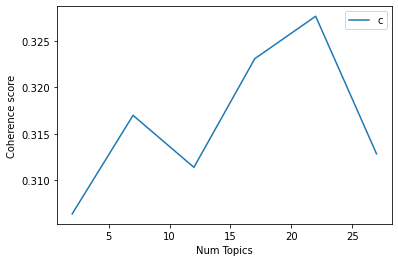

In [31]:
# Plot to see coherence score in order to choose optimal number of topics and decide optimal model
limit=30; start=2; step=5;
x = range(start, limit, step)
plt.plot(x, coherence_values_ph)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [32]:
# Print the coherence scores
index = 0
for m, cv in zip(x, coherence_values_ph):
    print("index:",index,"|","Num Topics =", m, " has Coherence Value of", round(cv, 4))
    index = index + 1

# optimal num_topics = 22

index: 0 | Num Topics = 2  has Coherence Value of 0.3063
index: 1 | Num Topics = 7  has Coherence Value of 0.317
index: 2 | Num Topics = 12  has Coherence Value of 0.3114
index: 3 | Num Topics = 17  has Coherence Value of 0.3231
index: 4 | Num Topics = 22  has Coherence Value of 0.3277
index: 5 | Num Topics = 27  has Coherence Value of 0.3128


In [166]:
# Select optimal number of topics
optimal_model_ph = model_list_ph[4]

In [167]:
# pyLDAVis
pyLDAvis.enable_notebook()
vis_ph = pyLDAvis.gensim_models.prepare(optimal_model_ph, corpus_ph, id2word_ph)

In [168]:
print("pyLDAVis for overall ph topics:")
vis_ph

pyLDAVis for overall ph topics:


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
19     0.124431  0.087566       1        1  19.833162
2     -0.140888  0.123650       2        1  10.823495
20     0.158691 -0.029755       3        1   6.874484
3     -0.052318  0.208195       4        1   6.710224
12     0.139512  0.084136       5        1   6.322831
21     0.012983 -0.029267       6        1   5.372738
14     0.090616 -0.001442       7        1   4.510889
11     0.003080 -0.165336       8        1   3.828953
15    -0.015347 -0.068362       9        1   3.715106
18     0.004160  0.158644      10        1   3.710816
7      0.084491 -0.014866      11        1   3.314566
16     0.015657 -0.015550      12        1   3.183954
1      0.103723  0.012485      13        1   3.019823
10    -0.025519 -0.048076      14        1   3.003617
6      0.024980 -0.053865      15        1   2.899376
0     -0.045455 -0.017478      16        1   2.683822
8      0.053705 -0.073285      17        1   2.450038
17    -0.146721  0.052110      18        1   1.943584
5     -0.143110 -0.086505      19        1   1.869239
4     -0.104518  0.017324      20        1   1.510807
13    -0.059884 -0.057659      21        1   1.282290
9     -0.082269 -0.082662      22        1   1.136186, topic_info=        Term        Freq       Total Category  logprob  loglift
17   account  360.000000  360.000000  Default  30.0000  30.0000
51      post  261.000000  261.000000  Default  29.0000  29.0000
6        log  152.000000  152.000000  Default  28.0000  28.0000
87     photo  135.000000  135.000000  Default  27.0000  27.0000
79     video  132.000000  132.000000  Default  26.0000  26.0000
..       ...         ...         ...      ...      ...      ...
32     thing    1.347893   60.947569  Topic22  -4.9615   0.6660
79     video    1.461453  132.027841  Topic22  -4.8806  -0.0261
12     still    1.461454  180.811572  Topic22  -4.8806  -0.3405
17   account    1.485994  360.185256  Topic22  -4.8640  -1.0130
4   facebook    1.464708  480.580699  Topic22  -4.8784  -1.3158

[1538 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
1040      6  0.685972    ability
1040     14  0.228657    ability
35        1  0.213666       able
35        2  0.061047       able
35        5  0.091571       able
...     ...       ...        ...
1419      3  0.565854       yout
1373      8  0.568017  zealander
1948     17  0.794314    zionist
908       7  0.286317       zoom
908       9  0.572635       zoom

[3450 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[20, 3, 21, 4, 13, 22, 15, 12, 16, 19, 8, 17, 2, 11, 7, 1, 9, 18, 6, 5, 14, 10])

# By-rating LDA Topic Modelling

## LDA Topic Modelling (Rating = 1)

In [36]:
# By-rating Topic Modelling - rating = 1
# Convert to list - move to each section
review_ph_score1 = facebook_ios_ph_review_YearMonth_score1.review.values.tolist()
review_words_ph_score1 = list(sent_to_words(review_ph_score1))
print(review_words_ph_score1[:1])

[['how', 'do', 'log', 'in', 'when', 'it', 'says', 'you', 'are', 'trying', 'too', 'often', 'am', 'attempting', 'to', 'log', 'in', 'to', 'facebook', 'using', 'the', 'app', 'on', 'my', 'iphone', 'everytime', 'type', 'in', 'the', 'email', 'and', 'password', 'it', 'says', 'am', 'trying', 'too', 'often', 'when', 'try', 'it', 'on', 'my', 'safari', 'browser', 'it', 'works', 'how', 'am', 'supposed', 'to', 'log', 'in', 'on', 'the', 'app', 'ive', 'tried', 'restarting', 'the', 'phone', 'and', 'uninstalling', 'the', 'app', 'still', 'doesnt', 'work']]


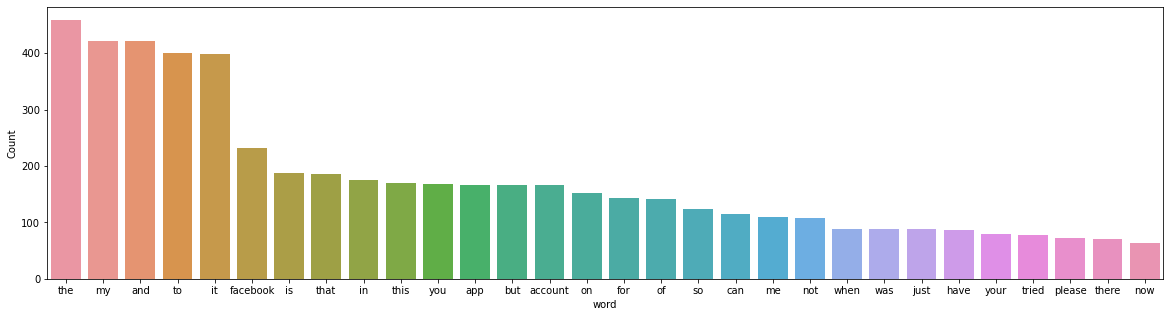

In [37]:
# Inspect the frequency of words before cleaning
freq_words(flatten(review_words_ph_score1))

In [38]:
# Clean text
review_ph_ready_score1 = process_words(review_words_ph_score1)  # processed Text Data! - move to each section


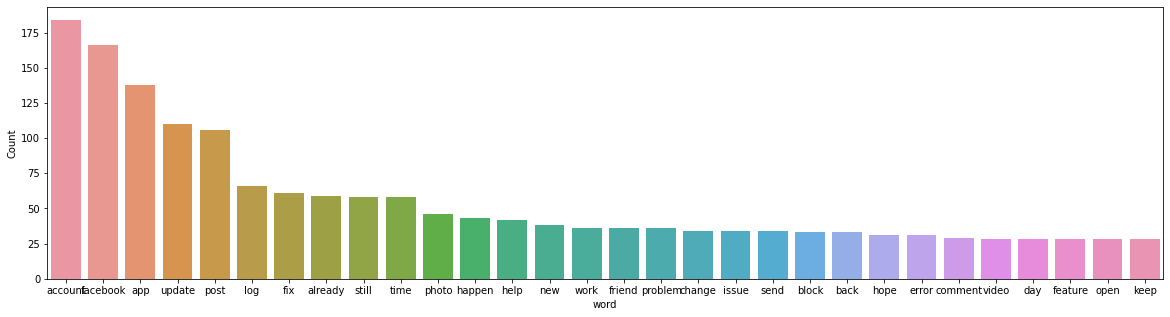

In [39]:
# Inspect the frequency of words after cleaning
freq_words(flatten(review_ph_ready_score1))


In [40]:
# Create Dictionary
id2word_ph_score1 = corpora.Dictionary(review_ph_ready_score1)

2021-10-16 18:28:57,794 [INFO] gensim.corpora.dictionary - adding document #0 to Dictionary(0 unique tokens: [])
2021-10-16 18:28:57,865 [INFO] gensim.corpora.dictionary - built Dictionary(1177 unique tokens: ['app', 'attempt', 'email', 'everytime', 'facebook']...) from 151 documents (total 5290 corpus positions)
2021-10-16 18:28:57,869 [INFO] gensim.utils - Dictionary lifecycle event {'msg': "built Dictionary(1177 unique tokens: ['app', 'attempt', 'email', 'everytime', 'facebook']...) from 151 documents (total 5290 corpus positions)", 'datetime': '2021-10-16T18:28:57.868899', 'gensim': '4.1.2', 'python': '3.8.8 (default, Apr 13 2021, 12:59:45) \n[Clang 10.0.0 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'created'}


In [41]:
# Create Corpus: Term Document Frequency
corpus_ph_score1 = [id2word_ph_score1.doc2bow(text) for text in review_ph_ready_score1]

In [42]:
# Training LDA model
model_list_ph_score1, coherence_values_ph_score1 = compute_coherence_values(dictionary=id2word_ph_score1, corpus=corpus_ph_score1, 
                                                              texts=review_ph_ready_score1, limit=30, start=2, step=5)


2021-10-16 18:28:57,903 [INFO] gensim.models.ldamodel - using symmetric alpha at 0.5
2021-10-16 18:28:57,905 [INFO] gensim.models.ldamodel - using symmetric eta at 0.5
2021-10-16 18:28:57,908 [INFO] gensim.models.ldamodel - using serial LDA version on this node
2021-10-16 18:28:57,912 [INFO] gensim.models.ldamodel - running online (multi-pass) LDA training, 2 topics, 50 passes over the supplied corpus of 151 documents, updating model once every 151 documents, evaluating perplexity every 151 documents, iterating 50x with a convergence threshold of 0.001000
2021-10-16 18:28:58,953 [INFO] gensim.models.ldamodel - -7.612 per-word bound, 195.7 perplexity estimate based on a held-out corpus of 151 documents with 5290 words
2021-10-16 18:28:58,956 [INFO] gensim.models.ldamodel - PROGRESS: pass 0, at document #151/151
2021-10-16 18:28:59,864 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.025*"facebook" + 0.021*"account" + 0.019*"post" + 0.019*"update" + 0.015*"app" + 0.012*"already" + 0.0

2021-10-16 18:29:11,756 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.044*"account" + 0.029*"facebook" + 0.027*"app" + 0.019*"update" + 0.016*"log" + 0.012*"post" + 0.011*"fix" + 0.010*"help" + 0.010*"already" + 0.009*"still"
2021-10-16 18:29:11,760 [INFO] gensim.models.ldamodel - topic diff=0.017635, rho=0.301511
2021-10-16 18:29:12,416 [INFO] gensim.models.ldamodel - -6.412 per-word bound, 85.2 perplexity estimate based on a held-out corpus of 151 documents with 5290 words
2021-10-16 18:29:12,420 [INFO] gensim.models.ldamodel - PROGRESS: pass 10, at document #151/151
2021-10-16 18:29:13,014 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.024*"post" + 0.020*"facebook" + 0.015*"photo" + 0.014*"update" + 0.013*"app" + 0.011*"time" + 0.009*"video" + 0.009*"still" + 0.009*"already" + 0.008*"feature"
2021-10-16 18:29:13,021 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.044*"account" + 0.029*"facebook" + 0.027*"app" + 0.019*"update" + 0.016*"log" + 0.012*"post" + 0.011*"fix"

2021-10-16 18:29:20,247 [INFO] gensim.models.ldamodel - topic diff=0.008016, rho=0.218218
2021-10-16 18:29:20,972 [INFO] gensim.models.ldamodel - -6.402 per-word bound, 84.6 perplexity estimate based on a held-out corpus of 151 documents with 5290 words
2021-10-16 18:29:20,980 [INFO] gensim.models.ldamodel - PROGRESS: pass 20, at document #151/151
2021-10-16 18:29:21,360 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.024*"post" + 0.018*"facebook" + 0.015*"photo" + 0.013*"update" + 0.013*"app" + 0.010*"time" + 0.010*"video" + 0.008*"still" + 0.008*"feature" + 0.008*"already"
2021-10-16 18:29:21,375 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.045*"account" + 0.030*"facebook" + 0.027*"app" + 0.020*"update" + 0.016*"log" + 0.012*"post" + 0.011*"fix" + 0.010*"help" + 0.010*"already" + 0.010*"still"
2021-10-16 18:29:21,380 [INFO] gensim.models.ldamodel - topic diff=0.007527, rho=0.213201
2021-10-16 18:29:21,980 [INFO] gensim.models.ldamodel - -6.401 per-word bound, 84.5 perplexi

2021-10-16 18:29:30,291 [INFO] gensim.models.ldamodel - -6.398 per-word bound, 84.3 perplexity estimate based on a held-out corpus of 151 documents with 5290 words
2021-10-16 18:29:30,292 [INFO] gensim.models.ldamodel - PROGRESS: pass 30, at document #151/151
2021-10-16 18:29:30,617 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.024*"post" + 0.017*"facebook" + 0.016*"photo" + 0.013*"update" + 0.012*"app" + 0.010*"video" + 0.010*"time" + 0.008*"feature" + 0.008*"still" + 0.007*"already"
2021-10-16 18:29:30,636 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.045*"account" + 0.031*"facebook" + 0.027*"app" + 0.020*"update" + 0.016*"log" + 0.012*"post" + 0.011*"fix" + 0.010*"help" + 0.010*"already" + 0.010*"still"
2021-10-16 18:29:30,638 [INFO] gensim.models.ldamodel - topic diff=0.003650, rho=0.176777
2021-10-16 18:29:31,110 [INFO] gensim.models.ldamodel - -6.398 per-word bound, 84.3 perplexity estimate based on a held-out corpus of 151 documents with 5290 words
2021-10-16 18:29:3

2021-10-16 18:29:40,420 [INFO] gensim.models.ldamodel - PROGRESS: pass 40, at document #151/151
2021-10-16 18:29:40,849 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.024*"post" + 0.017*"facebook" + 0.016*"photo" + 0.013*"update" + 0.012*"app" + 0.010*"video" + 0.010*"time" + 0.008*"feature" + 0.008*"still" + 0.007*"fix"
2021-10-16 18:29:40,853 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.045*"account" + 0.031*"facebook" + 0.027*"app" + 0.020*"update" + 0.016*"log" + 0.012*"post" + 0.011*"fix" + 0.011*"already" + 0.010*"help" + 0.010*"happen"
2021-10-16 18:29:40,855 [INFO] gensim.models.ldamodel - topic diff=0.002357, rho=0.154303
2021-10-16 18:29:41,362 [INFO] gensim.models.ldamodel - -6.397 per-word bound, 84.2 perplexity estimate based on a held-out corpus of 151 documents with 5290 words
2021-10-16 18:29:41,364 [INFO] gensim.models.ldamodel - PROGRESS: pass 41, at document #151/151
2021-10-16 18:29:41,751 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.024*"post" + 

2021-10-16 18:29:49,366 [INFO] gensim.topic_coherence.probability_estimation - using ParallelWordOccurrenceAccumulator(processes=7, batch_size=64) to estimate probabilities from sliding windows
2021-10-16 18:29:57,924 [INFO] gensim.topic_coherence.text_analysis - 7 accumulators retrieved from output queue
2021-10-16 18:29:57,952 [INFO] gensim.topic_coherence.text_analysis - accumulated word occurrence stats for 151 virtual documents
2021-10-16 18:29:58,690 [INFO] gensim.models.ldamodel - using symmetric alpha at 0.14285714285714285
2021-10-16 18:29:58,696 [INFO] gensim.models.ldamodel - using symmetric eta at 0.14285714285714285
2021-10-16 18:29:58,700 [INFO] gensim.models.ldamodel - using serial LDA version on this node
2021-10-16 18:29:58,705 [INFO] gensim.models.ldamodel - running online (multi-pass) LDA training, 7 topics, 50 passes over the supplied corpus of 151 documents, updating model once every 151 documents, evaluating perplexity every 151 documents, iterating 50x with a con

2021-10-16 18:30:05,217 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.029*"post" + 0.017*"facebook" + 0.016*"time" + 0.014*"app" + 0.013*"update" + 0.010*"option" + 0.010*"change" + 0.010*"feature" + 0.010*"people" + 0.009*"comment"
2021-10-16 18:30:05,219 [INFO] gensim.models.ldamodel - topic diff=0.113979, rho=0.408248
2021-10-16 18:30:05,682 [INFO] gensim.models.ldamodel - -6.593 per-word bound, 96.5 perplexity estimate based on a held-out corpus of 151 documents with 5290 words
2021-10-16 18:30:05,684 [INFO] gensim.models.ldamodel - PROGRESS: pass 5, at document #151/151
2021-10-16 18:30:06,120 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.019*"account" + 0.017*"log" + 0.015*"activity" + 0.012*"photo" + 0.009*"post" + 0.009*"violate" + 0.009*"standard" + 0.009*"community" + 0.009*"click" + 0.009*"notification"
2021-10-16 18:30:06,123 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.060*"account" + 0.047*"facebook" + 0.019*"app" + 0.016*"help" + 0.013*"send" + 0.013*"

2021-10-16 18:30:10,325 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.060*"account" + 0.047*"facebook" + 0.017*"app" + 0.016*"help" + 0.014*"send" + 0.012*"post" + 0.012*"hope" + 0.011*"give" + 0.010*"already" + 0.010*"fix"
2021-10-16 18:30:10,327 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.029*"post" + 0.017*"facebook" + 0.016*"time" + 0.014*"app" + 0.013*"update" + 0.011*"feature" + 0.011*"option" + 0.010*"change" + 0.010*"people" + 0.009*"photo"
2021-10-16 18:30:10,330 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.030*"facebook" + 0.027*"update" + 0.027*"post" + 0.015*"account" + 0.015*"app" + 0.015*"photo" + 0.012*"video" + 0.012*"still" + 0.012*"already" + 0.010*"block"
2021-10-16 18:30:10,333 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.018*"account" + 0.017*"log" + 0.015*"activity" + 0.012*"photo" + 0.009*"post" + 0.009*"violate" + 0.009*"community" + 0.009*"standard" + 0.009*"click" + 0.008*"fix"
2021-10-16 18:30:10,338 [INFO] gensim.models.ldamodel -

2021-10-16 18:30:14,904 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.061*"account" + 0.047*"facebook" + 0.017*"app" + 0.016*"help" + 0.014*"send" + 0.012*"post" + 0.012*"hope" + 0.011*"give" + 0.010*"already" + 0.010*"fix"
2021-10-16 18:30:14,907 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.016*"hate" + 0.016*"speech" + 0.011*"post" + 0.011*"spread" + 0.010*"delete" + 0.009*"photo" + 0.008*"picture" + 0.008*"open" + 0.008*"israeli" + 0.008*"trash"
2021-10-16 18:30:14,908 [INFO] gensim.models.ldamodel - topic diff=0.008938, rho=0.242536
2021-10-16 18:30:15,438 [INFO] gensim.models.ldamodel - -6.558 per-word bound, 94.2 perplexity estimate based on a held-out corpus of 151 documents with 5290 words
2021-10-16 18:30:15,448 [INFO] gensim.models.ldamodel - PROGRESS: pass 16, at document #151/151
2021-10-16 18:30:15,850 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.061*"account" + 0.047*"facebook" + 0.017*"app" + 0.016*"help" + 0.014*"send" + 0.012*"post" + 0.012*"hope" +

2021-10-16 18:30:20,007 [INFO] gensim.models.ldamodel - PROGRESS: pass 21, at document #151/151
2021-10-16 18:30:20,488 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.029*"post" + 0.017*"facebook" + 0.016*"time" + 0.014*"app" + 0.013*"update" + 0.012*"option" + 0.011*"feature" + 0.010*"people" + 0.010*"change" + 0.010*"photo"
2021-10-16 18:30:20,492 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.060*"account" + 0.024*"facebook" + 0.020*"app" + 0.017*"log" + 0.017*"still" + 0.015*"error" + 0.013*"help" + 0.011*"send" + 0.010*"new" + 0.010*"ban"
2021-10-16 18:30:20,495 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.061*"account" + 0.047*"facebook" + 0.016*"app" + 0.016*"help" + 0.014*"send" + 0.012*"post" + 0.011*"hope" + 0.011*"give" + 0.010*"already" + 0.010*"happen"
2021-10-16 18:30:20,498 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.029*"facebook" + 0.028*"update" + 0.027*"post" + 0.016*"app" + 0.015*"photo" + 0.013*"video" + 0.013*"account" + 0.012*"still" + 0.

2021-10-16 18:30:24,081 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.055*"app" + 0.051*"update" + 0.026*"log" + 0.022*"facebook" + 0.021*"fix" + 0.019*"account" + 0.017*"already" + 0.016*"time" + 0.015*"phone" + 0.013*"happen"
2021-10-16 18:30:24,084 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.016*"activity" + 0.013*"account" + 0.013*"photo" + 0.011*"log" + 0.010*"community" + 0.010*"standard" + 0.010*"violate" + 0.010*"post" + 0.010*"click" + 0.008*"fix"
2021-10-16 18:30:24,087 [INFO] gensim.models.ldamodel - topic diff=0.003986, rho=0.188982
2021-10-16 18:30:24,487 [INFO] gensim.models.ldamodel - -6.550 per-word bound, 93.7 perplexity estimate based on a held-out corpus of 151 documents with 5290 words
2021-10-16 18:30:24,488 [INFO] gensim.models.ldamodel - PROGRESS: pass 27, at document #151/151
2021-10-16 18:30:24,854 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.029*"facebook" + 0.028*"update" + 0.027*"post" + 0.016*"app" + 0.015*"photo" + 0.013*"video" + 0.01

2021-10-16 18:30:29,785 [INFO] gensim.models.ldamodel - -6.547 per-word bound, 93.5 perplexity estimate based on a held-out corpus of 151 documents with 5290 words
2021-10-16 18:30:29,792 [INFO] gensim.models.ldamodel - PROGRESS: pass 32, at document #151/151
2021-10-16 18:30:30,129 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.017*"activity" + 0.013*"photo" + 0.012*"account" + 0.010*"community" + 0.010*"standard" + 0.010*"violate" + 0.010*"post" + 0.010*"click" + 0.008*"log" + 0.008*"fix"
2021-10-16 18:30:30,131 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.062*"account" + 0.024*"facebook" + 0.020*"log" + 0.019*"app" + 0.016*"still" + 0.016*"error" + 0.013*"help" + 0.012*"send" + 0.011*"block" + 0.011*"messenger"
2021-10-16 18:30:30,138 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.055*"app" + 0.051*"update" + 0.025*"log" + 0.022*"facebook" + 0.021*"fix" + 0.019*"account" + 0.017*"already" + 0.015*"time" + 0.015*"phone" + 0.013*"happen"
2021-10-16 18:30:30,141 [INFO]

2021-10-16 18:30:34,238 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.061*"account" + 0.047*"facebook" + 0.016*"help" + 0.015*"app" + 0.014*"send" + 0.013*"post" + 0.011*"hope" + 0.011*"give" + 0.010*"already" + 0.010*"happen"
2021-10-16 18:30:34,241 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.017*"activity" + 0.014*"photo" + 0.012*"account" + 0.010*"community" + 0.010*"standard" + 0.010*"violate" + 0.010*"post" + 0.010*"click" + 0.008*"send" + 0.008*"fix"
2021-10-16 18:30:34,243 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.062*"account" + 0.024*"facebook" + 0.020*"log" + 0.019*"app" + 0.016*"still" + 0.016*"error" + 0.013*"help" + 0.012*"send" + 0.011*"block" + 0.011*"messenger"
2021-10-16 18:30:34,246 [INFO] gensim.models.ldamodel - topic diff=0.002226, rho=0.160128
2021-10-16 18:30:34,620 [INFO] gensim.models.ldamodel - -6.545 per-word bound, 93.4 perplexity estimate based on a held-out corpus of 151 documents with 5290 words
2021-10-16 18:30:34,622 [INFO] gensi

2021-10-16 18:30:37,340 [INFO] gensim.models.ldamodel - topic diff=0.001907, rho=0.150756
2021-10-16 18:30:37,745 [INFO] gensim.models.ldamodel - -6.544 per-word bound, 93.3 perplexity estimate based on a held-out corpus of 151 documents with 5290 words
2021-10-16 18:30:37,747 [INFO] gensim.models.ldamodel - PROGRESS: pass 43, at document #151/151
2021-10-16 18:30:38,016 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.017*"activity" + 0.014*"photo" + 0.011*"account" + 0.010*"click" + 0.010*"community" + 0.010*"standard" + 0.010*"violate" + 0.010*"post" + 0.008*"fix" + 0.008*"send"
2021-10-16 18:30:38,019 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.061*"account" + 0.047*"facebook" + 0.016*"help" + 0.015*"app" + 0.014*"send" + 0.013*"post" + 0.011*"hope" + 0.011*"give" + 0.010*"happen" + 0.010*"time"
2021-10-16 18:30:38,023 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.016*"hate" + 0.016*"speech" + 0.011*"spread" + 0.011*"post" + 0.010*"delete" + 0.009*"photo" + 0.008*"

2021-10-16 18:30:41,401 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.061*"account" + 0.047*"facebook" + 0.016*"help" + 0.015*"app" + 0.013*"send" + 0.013*"post" + 0.011*"hope" + 0.011*"give" + 0.010*"happen" + 0.010*"time"
2021-10-16 18:30:41,406 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.030*"post" + 0.016*"facebook" + 0.016*"time" + 0.014*"app" + 0.013*"update" + 0.012*"option" + 0.012*"feature" + 0.010*"people" + 0.010*"change" + 0.010*"photo"
2021-10-16 18:30:41,408 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.016*"hate" + 0.016*"speech" + 0.011*"spread" + 0.011*"post" + 0.010*"delete" + 0.009*"photo" + 0.008*"open" + 0.008*"picture" + 0.008*"israeli" + 0.008*"trash"
2021-10-16 18:30:41,411 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.056*"app" + 0.051*"update" + 0.025*"log" + 0.022*"facebook" + 0.021*"fix" + 0.019*"account" + 0.017*"already" + 0.015*"time" + 0.015*"phone" + 0.013*"happen"
2021-10-16 18:30:41,413 [INFO] gensim.models.ldamodel - topic d

2021-10-16 18:30:54,927 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.024*"post" + 0.013*"israeli" + 0.010*"account" + 0.010*"sell" + 0.010*"mask" + 0.010*"legit" + 0.010*"online" + 0.010*"seller" + 0.009*"call" + 0.009*"defend"
2021-10-16 18:30:54,934 [INFO] gensim.models.ldamodel - topic diff=0.287515, rho=0.500000
2021-10-16 18:30:55,320 [INFO] gensim.models.ldamodel - -6.785 per-word bound, 110.3 perplexity estimate based on a held-out corpus of 151 documents with 5290 words
2021-10-16 18:30:55,325 [INFO] gensim.models.ldamodel - PROGRESS: pass 3, at document #151/151
2021-10-16 18:30:55,591 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.036*"account" + 0.028*"facebook" + 0.027*"app" + 0.026*"post" + 0.022*"log" + 0.016*"update" + 0.015*"already" + 0.012*"time" + 0.011*"messenger" + 0.011*"new"
2021-10-16 18:30:55,618 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.025*"post" + 0.014*"israeli" + 0.010*"account" + 0.010*"sell" + 0.010*"mask" + 0.010*"legit" + 0.010*"o

2021-10-16 18:30:59,024 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.034*"account" + 0.019*"facebook" + 0.014*"block" + 0.014*"send" + 0.013*"post" + 0.013*"reason" + 0.012*"still" + 0.012*"check" + 0.012*"change" + 0.011*"fix"
2021-10-16 18:30:59,025 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.039*"standard" + 0.030*"violate" + 0.029*"community" + 0.019*"account" + 0.018*"activity" + 0.015*"user" + 0.015*"fb" + 0.014*"report" + 0.012*"facebook" + 0.010*"post"
2021-10-16 18:30:59,027 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.032*"app" + 0.026*"account" + 0.019*"log" + 0.019*"new" + 0.019*"hate" + 0.019*"update" + 0.016*"speech" + 0.016*"time" + 0.013*"feature" + 0.013*"facebook"
2021-10-16 18:30:59,028 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.039*"account" + 0.028*"facebook" + 0.028*"app" + 0.027*"post" + 0.023*"log" + 0.016*"update" + 0.014*"already" + 0.012*"messenger" + 0.012*"new" + 0.011*"time"
2021-10-16 18:30:59,030 [INFO] gensim.models.ldamo

2021-10-16 18:31:02,396 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.043*"app" + 0.036*"account" + 0.033*"facebook" + 0.026*"update" + 0.024*"open" + 0.020*"time" + 0.018*"version" + 0.018*"happen" + 0.017*"already" + 0.014*"log"
2021-10-16 18:31:02,400 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.063*"update" + 0.037*"app" + 0.027*"account" + 0.025*"already" + 0.023*"facebook" + 0.021*"log" + 0.021*"fix" + 0.014*"datum" + 0.014*"still" + 0.013*"phone"
2021-10-16 18:31:02,401 [INFO] gensim.models.ldamodel - topic diff=0.013045, rho=0.258199
2021-10-16 18:31:02,770 [INFO] gensim.models.ldamodel - -6.684 per-word bound, 102.8 perplexity estimate based on a held-out corpus of 151 documents with 5290 words
2021-10-16 18:31:02,771 [INFO] gensim.models.ldamodel - PROGRESS: pass 14, at document #151/151
2021-10-16 18:31:03,042 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.040*"account" + 0.029*"facebook" + 0.028*"app" + 0.026*"post" + 0.023*"log" + 0.016*"update" + 0.014*"

2021-10-16 18:31:05,936 [INFO] gensim.models.ldamodel - -6.677 per-word bound, 102.3 perplexity estimate based on a held-out corpus of 151 documents with 5290 words
2021-10-16 18:31:05,938 [INFO] gensim.models.ldamodel - PROGRESS: pass 19, at document #151/151
2021-10-16 18:31:06,244 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.049*"standard" + 0.035*"community" + 0.032*"violate" + 0.019*"account" + 0.018*"activity" + 0.016*"user" + 0.015*"report" + 0.015*"fb" + 0.012*"facebook" + 0.010*"post"
2021-10-16 18:31:06,246 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.028*"account" + 0.023*"error" + 0.019*"post" + 0.018*"different" + 0.017*"log" + 0.014*"notification" + 0.013*"keep" + 0.013*"unexpected" + 0.012*"reset" + 0.012*"help"
2021-10-16 18:31:06,249 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.040*"account" + 0.029*"facebook" + 0.028*"app" + 0.026*"post" + 0.023*"log" + 0.016*"update" + 0.013*"already" + 0.012*"new" + 0.012*"messenger" + 0.011*"time"
2021-10-16 18

2021-10-16 18:31:10,492 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.027*"account" + 0.023*"error" + 0.019*"post" + 0.018*"different" + 0.016*"log" + 0.014*"notification" + 0.013*"keep" + 0.013*"unexpected" + 0.012*"reset" + 0.011*"facebook"
2021-10-16 18:31:10,494 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.034*"app" + 0.027*"facebook" + 0.020*"photo" + 0.020*"video" + 0.019*"time" + 0.017*"update" + 0.017*"problem" + 0.016*"still" + 0.014*"work" + 0.011*"new"
2021-10-16 18:31:10,501 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.034*"account" + 0.020*"facebook" + 0.014*"block" + 0.014*"reason" + 0.014*"send" + 0.013*"post" + 0.012*"change" + 0.012*"still" + 0.011*"check" + 0.011*"app"
2021-10-16 18:31:10,502 [INFO] gensim.models.ldamodel - topic diff=0.004300, rho=0.196116
2021-10-16 18:31:10,880 [INFO] gensim.models.ldamodel - -6.671 per-word bound, 101.9 perplexity estimate based on a held-out corpus of 151 documents with 5290 words
2021-10-16 18:31:10,885 [INF

2021-10-16 18:31:13,677 [INFO] gensim.models.ldamodel - topic diff=0.003126, rho=0.179605
2021-10-16 18:31:14,047 [INFO] gensim.models.ldamodel - -6.668 per-word bound, 101.7 perplexity estimate based on a held-out corpus of 151 documents with 5290 words
2021-10-16 18:31:14,051 [INFO] gensim.models.ldamodel - PROGRESS: pass 30, at document #151/151
2021-10-16 18:31:14,310 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.065*"update" + 0.037*"app" + 0.026*"account" + 0.025*"already" + 0.023*"facebook" + 0.022*"log" + 0.021*"fix" + 0.015*"still" + 0.015*"datum" + 0.014*"phone"
2021-10-16 18:31:14,312 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.053*"standard" + 0.037*"community" + 0.032*"violate" + 0.019*"account" + 0.018*"activity" + 0.016*"user" + 0.015*"report" + 0.015*"fb" + 0.012*"facebook" + 0.010*"post"
2021-10-16 18:31:14,314 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.032*"app" + 0.026*"account" + 0.019*"log" + 0.019*"new" + 0.019*"hate" + 0.019*"update" + 0.0

2021-10-16 18:31:17,290 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.044*"app" + 0.036*"facebook" + 0.035*"account" + 0.027*"update" + 0.024*"open" + 0.021*"time" + 0.019*"version" + 0.018*"happen" + 0.017*"already" + 0.013*"log"
2021-10-16 18:31:17,292 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.034*"app" + 0.028*"facebook" + 0.020*"photo" + 0.020*"video" + 0.019*"time" + 0.017*"update" + 0.017*"problem" + 0.016*"still" + 0.014*"work" + 0.011*"new"
2021-10-16 18:31:17,295 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.053*"standard" + 0.038*"community" + 0.032*"violate" + 0.019*"account" + 0.018*"activity" + 0.016*"user" + 0.015*"report" + 0.015*"fb" + 0.012*"facebook" + 0.010*"post"
2021-10-16 18:31:17,297 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.071*"account" + 0.046*"facebook" + 0.024*"help" + 0.018*"post" + 0.017*"happen" + 0.013*"people" + 0.013*"app" + 0.011*"report" + 0.010*"hope" + 0.009*"team"
2021-10-16 18:31:17,299 [INFO] gensim.models.ldamod

2021-10-16 18:31:20,053 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.028*"post" + 0.024*"facebook" + 0.020*"update" + 0.020*"photo" + 0.015*"still" + 0.014*"album" + 0.012*"app" + 0.012*"comment" + 0.012*"friend" + 0.011*"hope"
2021-10-16 18:31:20,054 [INFO] gensim.models.ldamodel - topic diff=0.001680, rho=0.154303
2021-10-16 18:31:20,401 [INFO] gensim.models.ldamodel - -6.665 per-word bound, 101.4 perplexity estimate based on a held-out corpus of 151 documents with 5290 words
2021-10-16 18:31:20,403 [INFO] gensim.models.ldamodel - PROGRESS: pass 41, at document #151/151
2021-10-16 18:31:20,630 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.028*"post" + 0.024*"facebook" + 0.020*"update" + 0.020*"photo" + 0.015*"still" + 0.014*"album" + 0.012*"app" + 0.012*"comment" + 0.012*"friend" + 0.011*"hope"
2021-10-16 18:31:20,631 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.033*"app" + 0.028*"facebook" + 0.020*"photo" + 0.020*"video" + 0.019*"time" + 0.017*"update" + 0.017*"

2021-10-16 18:31:23,778 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.023*"account" + 0.022*"error" + 0.019*"post" + 0.018*"different" + 0.015*"log" + 0.015*"notification" + 0.013*"keep" + 0.013*"unexpected" + 0.012*"reset" + 0.011*"facebook"
2021-10-16 18:31:23,782 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.028*"post" + 0.024*"facebook" + 0.020*"update" + 0.020*"photo" + 0.015*"still" + 0.014*"album" + 0.012*"app" + 0.012*"comment" + 0.012*"friend" + 0.011*"hope"
2021-10-16 18:31:23,785 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.053*"standard" + 0.038*"community" + 0.032*"violate" + 0.019*"account" + 0.018*"activity" + 0.016*"user" + 0.015*"report" + 0.015*"fb" + 0.012*"facebook" + 0.010*"post"
2021-10-16 18:31:23,788 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.016*"app" + 0.015*"messenger" + 0.015*"facebook" + 0.012*"post" + 0.012*"fb" + 0.012*"lie" + 0.012*"especially" + 0.012*"last" + 0.010*"year" + 0.009*"option"
2021-10-16 18:31:23,798 [INFO] gensi

2021-10-16 18:31:36,308 [INFO] gensim.models.ldamodel - topic #8 (0.059): 0.025*"photo" + 0.020*"album" + 0.020*"post" + 0.017*"family" + 0.016*"log" + 0.015*"notification" + 0.013*"account" + 0.011*"never" + 0.011*"frustrating" + 0.010*"real"
2021-10-16 18:31:36,312 [INFO] gensim.models.ldamodel - topic #13 (0.059): 0.062*"account" + 0.035*"new" + 0.025*"already" + 0.018*"facebook" + 0.018*"feature" + 0.017*"photo" + 0.017*"update" + 0.016*"log" + 0.015*"give" + 0.012*"block"
2021-10-16 18:31:36,314 [INFO] gensim.models.ldamodel - topic diff=12.202245, rho=1.000000
2021-10-16 18:31:36,720 [INFO] gensim.models.ldamodel - -7.207 per-word bound, 147.8 perplexity estimate based on a held-out corpus of 151 documents with 5290 words
2021-10-16 18:31:36,722 [INFO] gensim.models.ldamodel - PROGRESS: pass 1, at document #151/151
2021-10-16 18:31:37,098 [INFO] gensim.models.ldamodel - topic #4 (0.059): 0.037*"facebook" + 0.027*"account" + 0.027*"post" + 0.023*"update" + 0.016*"app" + 0.016*"sti

2021-10-16 18:31:39,897 [INFO] gensim.models.ldamodel - -6.813 per-word bound, 112.4 perplexity estimate based on a held-out corpus of 151 documents with 5290 words
2021-10-16 18:31:39,899 [INFO] gensim.models.ldamodel - PROGRESS: pass 6, at document #151/151
2021-10-16 18:31:40,125 [INFO] gensim.models.ldamodel - topic #13 (0.059): 0.066*"account" + 0.036*"new" + 0.033*"already" + 0.020*"update" + 0.018*"give" + 0.017*"facebook" + 0.016*"feature" + 0.015*"photo" + 0.015*"still" + 0.015*"help"
2021-10-16 18:31:40,128 [INFO] gensim.models.ldamodel - topic #1 (0.059): 0.058*"account" + 0.035*"log" + 0.029*"facebook" + 0.027*"app" + 0.027*"error" + 0.016*"help" + 0.014*"still" + 0.014*"post" + 0.013*"disable" + 0.011*"fix"
2021-10-16 18:31:40,129 [INFO] gensim.models.ldamodel - topic #3 (0.059): 0.050*"update" + 0.031*"app" + 0.029*"facebook" + 0.025*"fix" + 0.019*"already" + 0.018*"account" + 0.016*"datum" + 0.016*"problem" + 0.013*"cellular" + 0.013*"still"
2021-10-16 18:31:40,131 [INFO

2021-10-16 18:31:43,392 [INFO] gensim.models.ldamodel - topic #0 (0.059): 0.018*"comment" + 0.017*"news" + 0.017*"facebook" + 0.016*"post" + 0.015*"time" + 0.012*"block" + 0.012*"update" + 0.012*"restrict" + 0.012*"place" + 0.011*"information"
2021-10-16 18:31:43,395 [INFO] gensim.models.ldamodel - topic #14 (0.059): 0.052*"app" + 0.034*"facebook" + 0.016*"account" + 0.015*"really" + 0.015*"well" + 0.013*"post" + 0.013*"block" + 0.011*"update" + 0.011*"option" + 0.011*"happen"
2021-10-16 18:31:43,399 [INFO] gensim.models.ldamodel - topic #12 (0.059): 0.032*"delete" + 0.025*"disabled" + 0.019*"video" + 0.019*"trash" + 0.018*"recover" + 0.013*"profile" + 0.013*"section" + 0.013*"ever" + 0.013*"choose" + 0.013*"still"
2021-10-16 18:31:43,401 [INFO] gensim.models.ldamodel - topic #7 (0.059): 0.030*"post" + 0.030*"account" + 0.030*"app" + 0.027*"update" + 0.020*"facebook" + 0.017*"send" + 0.013*"time" + 0.013*"always" + 0.013*"reply" + 0.010*"problem"
2021-10-16 18:31:43,402 [INFO] gensim.m

2021-10-16 18:31:46,033 [INFO] gensim.models.ldamodel - topic #5 (0.059): 0.092*"standard" + 0.074*"community" + 0.064*"violate" + 0.026*"report" + 0.019*"account" + 0.017*"post" + 0.016*"web" + 0.012*"appear" + 0.011*"action" + 0.011*"happen"
2021-10-16 18:31:46,035 [INFO] gensim.models.ldamodel - topic #13 (0.059): 0.066*"account" + 0.037*"new" + 0.034*"already" + 0.020*"update" + 0.019*"give" + 0.017*"facebook" + 0.015*"photo" + 0.015*"help" + 0.015*"still" + 0.014*"feature"
2021-10-16 18:31:46,037 [INFO] gensim.models.ldamodel - topic diff=0.008567, rho=0.235702
2021-10-16 18:31:46,240 [INFO] gensim.models.ldamodel - -6.770 per-word bound, 109.1 perplexity estimate based on a held-out corpus of 151 documents with 5290 words
2021-10-16 18:31:46,241 [INFO] gensim.models.ldamodel - PROGRESS: pass 17, at document #151/151
2021-10-16 18:31:46,517 [INFO] gensim.models.ldamodel - topic #12 (0.059): 0.032*"delete" + 0.025*"disabled" + 0.019*"video" + 0.019*"trash" + 0.018*"recover" + 0.013

2021-10-16 18:31:48,399 [INFO] gensim.models.ldamodel - topic diff=0.003827, rho=0.208514
2021-10-16 18:31:48,658 [INFO] gensim.models.ldamodel - -6.767 per-word bound, 108.9 perplexity estimate based on a held-out corpus of 151 documents with 5290 words
2021-10-16 18:31:48,659 [INFO] gensim.models.ldamodel - PROGRESS: pass 22, at document #151/151
2021-10-16 18:31:48,882 [INFO] gensim.models.ldamodel - topic #9 (0.059): 0.041*"post" + 0.032*"facebook" + 0.027*"account" + 0.015*"time" + 0.013*"update" + 0.011*"photo" + 0.011*"happen" + 0.010*"already" + 0.009*"still" + 0.009*"open"
2021-10-16 18:31:48,884 [INFO] gensim.models.ldamodel - topic #6 (0.059): 0.001*"hate" + 0.001*"picture" + 0.001*"update" + 0.001*"post" + 0.001*"speech" + 0.001*"already" + 0.001*"back" + 0.001*"nowadays" + 0.001*"spread" + 0.001*"allow"
2021-10-16 18:31:48,885 [INFO] gensim.models.ldamodel - topic #14 (0.059): 0.052*"app" + 0.034*"facebook" + 0.016*"really" + 0.016*"well" + 0.015*"account" + 0.013*"post" +

2021-10-16 18:31:51,377 [INFO] gensim.models.ldamodel - topic #14 (0.059): 0.052*"app" + 0.034*"facebook" + 0.016*"really" + 0.016*"well" + 0.015*"account" + 0.013*"post" + 0.013*"block" + 0.011*"update" + 0.011*"option" + 0.011*"happen"
2021-10-16 18:31:51,380 [INFO] gensim.models.ldamodel - topic #9 (0.059): 0.041*"post" + 0.032*"facebook" + 0.027*"account" + 0.015*"time" + 0.013*"update" + 0.011*"photo" + 0.011*"happen" + 0.010*"already" + 0.010*"still" + 0.010*"open"
2021-10-16 18:31:51,382 [INFO] gensim.models.ldamodel - topic #6 (0.059): 0.001*"hate" + 0.001*"picture" + 0.001*"update" + 0.001*"post" + 0.001*"speech" + 0.001*"already" + 0.001*"back" + 0.001*"nowadays" + 0.001*"spread" + 0.001*"allow"
2021-10-16 18:31:51,384 [INFO] gensim.models.ldamodel - topic #2 (0.059): 0.053*"facebook" + 0.051*"account" + 0.022*"help" + 0.016*"hope" + 0.016*"app" + 0.015*"send" + 0.013*"ban" + 0.013*"year" + 0.012*"people" + 0.011*"friend"
2021-10-16 18:31:51,387 [INFO] gensim.models.ldamodel 

2021-10-16 18:31:53,810 [INFO] gensim.models.ldamodel - topic #8 (0.059): 0.028*"photo" + 0.022*"album" + 0.022*"post" + 0.017*"family" + 0.017*"log" + 0.017*"notification" + 0.011*"account" + 0.011*"never" + 0.011*"frustrating" + 0.011*"real"
2021-10-16 18:31:53,811 [INFO] gensim.models.ldamodel - topic diff=0.001303, rho=0.171499
2021-10-16 18:31:54,129 [INFO] gensim.models.ldamodel - -6.764 per-word bound, 108.7 perplexity estimate based on a held-out corpus of 151 documents with 5290 words
2021-10-16 18:31:54,131 [INFO] gensim.models.ldamodel - PROGRESS: pass 33, at document #151/151
2021-10-16 18:31:54,341 [INFO] gensim.models.ldamodel - topic #4 (0.059): 0.037*"facebook" + 0.029*"post" + 0.026*"account" + 0.025*"update" + 0.016*"still" + 0.015*"friend" + 0.014*"app" + 0.012*"already" + 0.012*"block" + 0.012*"comment"
2021-10-16 18:31:54,344 [INFO] gensim.models.ldamodel - topic #16 (0.059): 0.053*"account" + 0.028*"post" + 0.027*"log" + 0.019*"update" + 0.016*"app" + 0.014*"featu

2021-10-16 18:31:57,019 [INFO] gensim.models.ldamodel - PROGRESS: pass 38, at document #151/151
2021-10-16 18:31:57,252 [INFO] gensim.models.ldamodel - topic #4 (0.059): 0.037*"facebook" + 0.029*"post" + 0.026*"account" + 0.025*"update" + 0.017*"still" + 0.016*"friend" + 0.014*"app" + 0.012*"already" + 0.012*"block" + 0.012*"comment"
2021-10-16 18:31:57,255 [INFO] gensim.models.ldamodel - topic #2 (0.059): 0.053*"facebook" + 0.051*"account" + 0.022*"help" + 0.016*"hope" + 0.016*"app" + 0.015*"send" + 0.013*"ban" + 0.013*"year" + 0.012*"people" + 0.011*"friend"
2021-10-16 18:31:57,258 [INFO] gensim.models.ldamodel - topic #10 (0.059): 0.043*"app" + 0.030*"time" + 0.029*"update" + 0.025*"facebook" + 0.018*"photo" + 0.017*"work" + 0.017*"video" + 0.014*"happen" + 0.013*"click" + 0.013*"crash"
2021-10-16 18:31:57,261 [INFO] gensim.models.ldamodel - topic #13 (0.059): 0.066*"account" + 0.037*"new" + 0.033*"already" + 0.020*"update" + 0.019*"give" + 0.016*"facebook" + 0.015*"photo" + 0.015*"

2021-10-16 18:32:00,672 [INFO] gensim.models.ldamodel - topic #1 (0.059): 0.058*"account" + 0.042*"log" + 0.030*"error" + 0.029*"facebook" + 0.029*"app" + 0.019*"help" + 0.014*"still" + 0.013*"disable" + 0.012*"post" + 0.012*"disabled"
2021-10-16 18:32:00,677 [INFO] gensim.models.ldamodel - topic #0 (0.059): 0.018*"comment" + 0.018*"news" + 0.016*"facebook" + 0.016*"post" + 0.015*"time" + 0.012*"block" + 0.012*"update" + 0.012*"restrict" + 0.012*"place" + 0.011*"information"
2021-10-16 18:32:00,680 [INFO] gensim.models.ldamodel - topic #3 (0.059): 0.052*"update" + 0.033*"app" + 0.029*"facebook" + 0.027*"fix" + 0.022*"already" + 0.020*"datum" + 0.017*"account" + 0.015*"problem" + 0.014*"cellular" + 0.014*"profile"
2021-10-16 18:32:00,683 [INFO] gensim.models.ldamodel - topic diff=0.000575, rho=0.149071
2021-10-16 18:32:01,042 [INFO] gensim.models.ldamodel - -6.762 per-word bound, 108.5 perplexity estimate based on a held-out corpus of 151 documents with 5290 words
2021-10-16 18:32:01,04

2021-10-16 18:32:03,319 [INFO] gensim.models.ldamodel - topic #5 (0.059): 0.093*"standard" + 0.077*"community" + 0.067*"violate" + 0.031*"report" + 0.019*"account" + 0.017*"post" + 0.016*"web" + 0.013*"action" + 0.012*"appear" + 0.011*"happen"
2021-10-16 18:32:03,325 [INFO] gensim.models.ldamodel - topic diff=0.000472, rho=0.141421
2021-10-16 18:32:03,633 [INFO] gensim.models.ldamodel - -6.761 per-word bound, 108.5 perplexity estimate based on a held-out corpus of 151 documents with 5290 words
2021-10-16 18:32:03,635 [INFO] gensim.models.ldamodel - PROGRESS: pass 49, at document #151/151
2021-10-16 18:32:03,781 [INFO] gensim.models.ldamodel - topic #10 (0.059): 0.043*"app" + 0.030*"time" + 0.029*"update" + 0.025*"facebook" + 0.018*"photo" + 0.017*"work" + 0.017*"video" + 0.014*"happen" + 0.013*"click" + 0.013*"crash"
2021-10-16 18:32:03,785 [INFO] gensim.models.ldamodel - topic #15 (0.059): 0.018*"update" + 0.018*"feature" + 0.018*"notification" + 0.013*"activity" + 0.013*"photo" + 0.0

2021-10-16 18:32:15,270 [INFO] gensim.models.ldamodel - topic #5 (0.045): 0.036*"timeline" + 0.024*"view" + 0.024*"still" + 0.024*"issue" + 0.024*"persist" + 0.012*"wth" + 0.012*"keep" + 0.012*"fix" + 0.012*"friend" + 0.012*"connection"
2021-10-16 18:32:15,271 [INFO] gensim.models.ldamodel - topic #19 (0.045): 0.080*"post" + 0.026*"fix" + 0.022*"app" + 0.021*"comment" + 0.021*"facebook" + 0.018*"account" + 0.018*"show" + 0.016*"update" + 0.015*"group" + 0.014*"friend"
2021-10-16 18:32:15,272 [INFO] gensim.models.ldamodel - topic #1 (0.045): 0.081*"account" + 0.035*"facebook" + 0.022*"error" + 0.019*"still" + 0.015*"report" + 0.014*"log" + 0.014*"reason" + 0.013*"app" + 0.013*"ban" + 0.012*"message"
2021-10-16 18:32:15,274 [INFO] gensim.models.ldamodel - topic #4 (0.045): 0.045*"facebook" + 0.030*"app" + 0.017*"account" + 0.017*"update" + 0.014*"feature" + 0.014*"work" + 0.014*"block" + 0.013*"still" + 0.013*"photo" + 0.012*"already"
2021-10-16 18:32:15,276 [INFO] gensim.models.ldamodel

2021-10-16 18:32:17,756 [INFO] gensim.models.ldamodel - topic #8 (0.045): 0.034*"post" + 0.025*"notification" + 0.017*"facebook" + 0.017*"keep" + 0.017*"restrict" + 0.017*"spam" + 0.017*"game" + 0.017*"kill" + 0.017*"real" + 0.017*"fix"
2021-10-16 18:32:17,758 [INFO] gensim.models.ldamodel - topic diff=0.062610, rho=0.316228
2021-10-16 18:32:18,004 [INFO] gensim.models.ldamodel - -6.830 per-word bound, 113.7 perplexity estimate based on a held-out corpus of 151 documents with 5290 words
2021-10-16 18:32:18,006 [INFO] gensim.models.ldamodel - PROGRESS: pass 9, at document #151/151
2021-10-16 18:32:18,187 [INFO] gensim.models.ldamodel - topic #2 (0.045): 0.061*"account" + 0.048*"facebook" + 0.022*"happen" + 0.020*"help" + 0.017*"year" + 0.016*"update" + 0.014*"send" + 0.014*"long" + 0.014*"hope" + 0.012*"issue"
2021-10-16 18:32:18,189 [INFO] gensim.models.ldamodel - topic #19 (0.045): 0.085*"post" + 0.027*"fix" + 0.025*"comment" + 0.021*"facebook" + 0.019*"account" + 0.018*"update" + 0.0

2021-10-16 18:32:20,509 [INFO] gensim.models.ldamodel - topic #4 (0.045): 0.043*"facebook" + 0.029*"app" + 0.017*"update" + 0.016*"feature" + 0.015*"block" + 0.014*"work" + 0.014*"photo" + 0.013*"already" + 0.011*"still" + 0.011*"issue"
2021-10-16 18:32:20,511 [INFO] gensim.models.ldamodel - topic #19 (0.045): 0.086*"post" + 0.027*"fix" + 0.026*"comment" + 0.021*"facebook" + 0.018*"account" + 0.018*"update" + 0.018*"show" + 0.017*"app" + 0.015*"group" + 0.014*"friend"
2021-10-16 18:32:20,513 [INFO] gensim.models.ldamodel - topic #20 (0.045): 0.050*"app" + 0.035*"log" + 0.024*"photo" + 0.023*"update" + 0.018*"already" + 0.016*"error" + 0.015*"issue" + 0.013*"album" + 0.012*"happen" + 0.011*"help"
2021-10-16 18:32:20,515 [INFO] gensim.models.ldamodel - topic #0 (0.045): 0.026*"facebook" + 0.017*"comment" + 0.016*"fb" + 0.013*"time" + 0.013*"restrict" + 0.013*"video" + 0.013*"people" + 0.010*"new" + 0.010*"live" + 0.010*"look"
2021-10-16 18:32:20,518 [INFO] gensim.models.ldamodel - topic 

2021-10-16 18:32:23,003 [INFO] gensim.models.ldamodel - topic #17 (0.045): 0.059*"update" + 0.032*"facebook" + 0.025*"account" + 0.023*"version" + 0.019*"always" + 0.017*"time" + 0.014*"app" + 0.014*"post" + 0.013*"old" + 0.012*"log"
2021-10-16 18:32:23,005 [INFO] gensim.models.ldamodel - topic #5 (0.045): 0.037*"timeline" + 0.025*"view" + 0.025*"still" + 0.025*"issue" + 0.025*"persist" + 0.013*"wth" + 0.013*"keep" + 0.013*"fix" + 0.013*"friend" + 0.013*"connection"
2021-10-16 18:32:23,005 [INFO] gensim.models.ldamodel - topic diff=0.006691, rho=0.218218
2021-10-16 18:32:23,230 [INFO] gensim.models.ldamodel - -6.801 per-word bound, 111.5 perplexity estimate based on a held-out corpus of 151 documents with 5290 words
2021-10-16 18:32:23,231 [INFO] gensim.models.ldamodel - PROGRESS: pass 20, at document #151/151
2021-10-16 18:32:23,414 [INFO] gensim.models.ldamodel - topic #9 (0.045): 0.043*"account" + 0.041*"facebook" + 0.022*"already" + 0.020*"post" + 0.019*"block" + 0.019*"photo" + 0.

2021-10-16 18:32:25,780 [INFO] gensim.models.ldamodel - -6.797 per-word bound, 111.2 perplexity estimate based on a held-out corpus of 151 documents with 5290 words
2021-10-16 18:32:25,781 [INFO] gensim.models.ldamodel - PROGRESS: pass 25, at document #151/151
2021-10-16 18:32:25,956 [INFO] gensim.models.ldamodel - topic #11 (0.045): 0.032*"hate" + 0.027*"people" + 0.027*"speech" + 0.017*"facebook" + 0.016*"photo" + 0.016*"spread" + 0.016*"violate" + 0.016*"standard" + 0.015*"friend" + 0.011*"change"
2021-10-16 18:32:25,959 [INFO] gensim.models.ldamodel - topic #13 (0.045): 0.096*"account" + 0.048*"new" + 0.048*"update" + 0.032*"log" + 0.022*"feature" + 0.022*"facebook" + 0.022*"fix" + 0.016*"block" + 0.016*"already" + 0.011*"name"
2021-10-16 18:32:25,962 [INFO] gensim.models.ldamodel - topic #2 (0.045): 0.059*"account" + 0.048*"facebook" + 0.023*"happen" + 0.020*"help" + 0.017*"year" + 0.016*"send" + 0.016*"update" + 0.014*"long" + 0.014*"hope" + 0.012*"issue"
2021-10-16 18:32:25,964 

2021-10-16 18:32:28,588 [INFO] gensim.models.ldamodel - topic #16 (0.045): 0.029*"post" + 0.026*"account" + 0.023*"app" + 0.022*"already" + 0.021*"update" + 0.016*"fix" + 0.014*"picture" + 0.012*"notification" + 0.012*"facebook" + 0.012*"open"
2021-10-16 18:32:28,589 [INFO] gensim.models.ldamodel - topic #11 (0.045): 0.032*"hate" + 0.027*"people" + 0.027*"speech" + 0.016*"facebook" + 0.016*"photo" + 0.016*"spread" + 0.016*"violate" + 0.016*"standard" + 0.015*"friend" + 0.011*"change"
2021-10-16 18:32:28,592 [INFO] gensim.models.ldamodel - topic #5 (0.045): 0.037*"timeline" + 0.025*"view" + 0.025*"still" + 0.025*"issue" + 0.025*"persist" + 0.013*"wth" + 0.013*"keep" + 0.013*"fix" + 0.013*"friend" + 0.013*"connection"
2021-10-16 18:32:28,593 [INFO] gensim.models.ldamodel - topic diff=0.002098, rho=0.176777
2021-10-16 18:32:28,917 [INFO] gensim.models.ldamodel - -6.794 per-word bound, 111.0 perplexity estimate based on a held-out corpus of 151 documents with 5290 words
2021-10-16 18:32:28

2021-10-16 18:32:31,151 [INFO] gensim.models.ldamodel - topic diff=0.001484, rho=0.164399
2021-10-16 18:32:31,451 [INFO] gensim.models.ldamodel - -6.793 per-word bound, 110.9 perplexity estimate based on a held-out corpus of 151 documents with 5290 words
2021-10-16 18:32:31,452 [INFO] gensim.models.ldamodel - PROGRESS: pass 36, at document #151/151
2021-10-16 18:32:31,563 [INFO] gensim.models.ldamodel - topic #1 (0.045): 0.103*"account" + 0.040*"facebook" + 0.025*"log" + 0.024*"error" + 0.022*"send" + 0.021*"disabled" + 0.020*"still" + 0.019*"disable" + 0.019*"reason" + 0.017*"report"
2021-10-16 18:32:31,565 [INFO] gensim.models.ldamodel - topic #7 (0.045): 0.040*"app" + 0.034*"crash" + 0.031*"problem" + 0.026*"facebook" + 0.026*"happen" + 0.024*"time" + 0.019*"story" + 0.018*"open" + 0.016*"update" + 0.015*"already"
2021-10-16 18:32:31,568 [INFO] gensim.models.ldamodel - topic #2 (0.045): 0.059*"account" + 0.048*"facebook" + 0.023*"happen" + 0.020*"help" + 0.017*"year" + 0.017*"send" 

2021-10-16 18:32:33,951 [INFO] gensim.models.ldamodel - topic #5 (0.045): 0.037*"timeline" + 0.025*"view" + 0.025*"still" + 0.025*"issue" + 0.025*"persist" + 0.013*"wth" + 0.013*"keep" + 0.013*"fix" + 0.013*"connection" + 0.013*"friend"
2021-10-16 18:32:33,965 [INFO] gensim.models.ldamodel - topic #4 (0.045): 0.043*"facebook" + 0.029*"app" + 0.017*"update" + 0.016*"feature" + 0.016*"block" + 0.015*"work" + 0.014*"photo" + 0.012*"already" + 0.011*"issue" + 0.011*"still"
2021-10-16 18:32:33,969 [INFO] gensim.models.ldamodel - topic #21 (0.045): 0.044*"log" + 0.037*"app" + 0.036*"block" + 0.028*"fix" + 0.022*"error" + 0.016*"group" + 0.015*"facebook" + 0.015*"still" + 0.015*"setting" + 0.015*"reset"
2021-10-16 18:32:33,971 [INFO] gensim.models.ldamodel - topic #6 (0.045): 0.047*"page" + 0.047*"tab" + 0.024*"load" + 0.012*"app" + 0.012*"time" + 0.012*"find" + 0.012*"notification" + 0.012*"bug" + 0.012*"wait" + 0.012*"devs"
2021-10-16 18:32:33,972 [INFO] gensim.models.ldamodel - topic diff=

2021-10-16 18:32:36,415 [INFO] gensim.models.ldamodel - topic #17 (0.045): 0.059*"update" + 0.032*"facebook" + 0.025*"account" + 0.023*"version" + 0.019*"always" + 0.017*"time" + 0.014*"app" + 0.014*"post" + 0.013*"old" + 0.012*"log"
2021-10-16 18:32:36,419 [INFO] gensim.models.ldamodel - topic diff=0.000994, rho=0.144338
2021-10-16 18:32:36,753 [INFO] gensim.models.ldamodel - -6.790 per-word bound, 110.7 perplexity estimate based on a held-out corpus of 151 documents with 5290 words
2021-10-16 18:32:36,754 [INFO] gensim.models.ldamodel - PROGRESS: pass 47, at document #151/151
2021-10-16 18:32:36,923 [INFO] gensim.models.ldamodel - topic #3 (0.045): 0.038*"help" + 0.031*"update" + 0.029*"app" + 0.022*"already" + 0.018*"change" + 0.018*"hope" + 0.018*"daughter" + 0.015*"disabled" + 0.013*"album" + 0.013*"option"
2021-10-16 18:32:36,925 [INFO] gensim.models.ldamodel - topic #1 (0.045): 0.106*"account" + 0.042*"facebook" + 0.029*"log" + 0.023*"error" + 0.022*"send" + 0.020*"disabled" + 0

2021-10-16 18:32:49,572 [INFO] gensim.models.ldamodel - topic #21 (0.037): 0.042*"log" + 0.041*"facebook" + 0.033*"account" + 0.030*"feature" + 0.030*"new" + 0.030*"problem" + 0.015*"application" + 0.015*"comment" + 0.015*"fix" + 0.015*"able"
2021-10-16 18:32:49,581 [INFO] gensim.models.ldamodel - topic #15 (0.037): 0.033*"account" + 0.032*"facebook" + 0.021*"issue" + 0.017*"post" + 0.017*"timeline" + 0.012*"people" + 0.012*"persist" + 0.012*"view" + 0.012*"vaccine" + 0.012*"adverse"
2021-10-16 18:32:49,584 [INFO] gensim.models.ldamodel - topic #20 (0.037): 0.067*"app" + 0.031*"log" + 0.027*"photo" + 0.022*"update" + 0.019*"error" + 0.018*"fix" + 0.017*"still" + 0.015*"happen" + 0.014*"album" + 0.014*"facebook"
2021-10-16 18:32:49,589 [INFO] gensim.models.ldamodel - topic #7 (0.037): 0.034*"app" + 0.034*"account" + 0.030*"already" + 0.028*"time" + 0.019*"facebook" + 0.017*"update" + 0.017*"long" + 0.016*"happen" + 0.014*"story" + 0.014*"month"
2021-10-16 18:32:49,592 [INFO] gensim.mode

2021-10-16 18:32:52,397 [INFO] gensim.models.ldamodel - topic #2 (0.037): 0.060*"facebook" + 0.050*"account" + 0.023*"people" + 0.019*"send" + 0.016*"update" + 0.016*"year" + 0.012*"post" + 0.012*"time" + 0.012*"download" + 0.012*"old"
2021-10-16 18:32:52,399 [INFO] gensim.models.ldamodel - topic #16 (0.037): 0.037*"account" + 0.020*"post" + 0.017*"app" + 0.015*"help" + 0.012*"log" + 0.012*"message" + 0.012*"review" + 0.012*"facebook" + 0.011*"time" + 0.010*"standard"
2021-10-16 18:32:52,400 [INFO] gensim.models.ldamodel - topic diff=0.114050, rho=0.353553
2021-10-16 18:32:52,755 [INFO] gensim.models.ldamodel - -6.893 per-word bound, 118.9 perplexity estimate based on a held-out corpus of 151 documents with 5290 words
2021-10-16 18:32:52,757 [INFO] gensim.models.ldamodel - PROGRESS: pass 7, at document #151/151
2021-10-16 18:32:52,912 [INFO] gensim.models.ldamodel - topic #6 (0.037): 0.069*"hate" + 0.068*"speech" + 0.046*"spread" + 0.023*"allow" + 0.023*"people" + 0.012*"information" +

2021-10-16 18:32:54,895 [INFO] gensim.models.ldamodel - topic diff=0.028184, rho=0.277350
2021-10-16 18:32:55,264 [INFO] gensim.models.ldamodel - -6.868 per-word bound, 116.8 perplexity estimate based on a held-out corpus of 151 documents with 5290 words
2021-10-16 18:32:55,265 [INFO] gensim.models.ldamodel - PROGRESS: pass 12, at document #151/151
2021-10-16 18:32:55,389 [INFO] gensim.models.ldamodel - topic #19 (0.037): 0.073*"post" + 0.027*"facebook" + 0.026*"update" + 0.024*"app" + 0.024*"fix" + 0.022*"account" + 0.018*"time" + 0.015*"happen" + 0.015*"show" + 0.015*"recent"
2021-10-16 18:32:55,392 [INFO] gensim.models.ldamodel - topic #14 (0.037): 0.028*"account" + 0.025*"facebook" + 0.022*"app" + 0.018*"really" + 0.018*"post" + 0.017*"block" + 0.014*"notification" + 0.014*"people" + 0.014*"still" + 0.011*"back"
2021-10-16 18:32:55,395 [INFO] gensim.models.ldamodel - topic #10 (0.037): 0.039*"app" + 0.025*"still" + 0.021*"page" + 0.021*"update" + 0.018*"messenger" + 0.018*"click" +

2021-10-16 18:32:57,832 [INFO] gensim.models.ldamodel - topic #5 (0.037): 0.055*"standard" + 0.052*"violate" + 0.045*"community" + 0.040*"log" + 0.025*"report" + 0.021*"account" + 0.020*"facebook" + 0.018*"tell" + 0.018*"minute" + 0.018*"messenger"
2021-10-16 18:32:57,837 [INFO] gensim.models.ldamodel - topic #0 (0.037): 0.033*"facebook" + 0.025*"time" + 0.020*"update" + 0.015*"comment" + 0.015*"keep" + 0.015*"restrict" + 0.015*"first" + 0.015*"back" + 0.011*"look" + 0.010*"send"
2021-10-16 18:32:57,843 [INFO] gensim.models.ldamodel - topic #13 (0.037): 0.051*"account" + 0.025*"already" + 0.019*"ask" + 0.019*"help" + 0.019*"still" + 0.013*"facebook" + 0.013*"name" + 0.013*"new" + 0.013*"government" + 0.013*"service"
2021-10-16 18:32:57,856 [INFO] gensim.models.ldamodel - topic #10 (0.037): 0.039*"app" + 0.025*"still" + 0.021*"page" + 0.021*"update" + 0.018*"messenger" + 0.018*"click" + 0.014*"tab" + 0.014*"facebook" + 0.014*"time" + 0.014*"feed"
2021-10-16 18:32:57,859 [INFO] gensim.mo

2021-10-16 18:33:00,258 [INFO] gensim.models.ldamodel - topic #26 (0.037): 0.102*"account" + 0.040*"facebook" + 0.022*"disable" + 0.022*"report" + 0.022*"new" + 0.018*"block" + 0.017*"reason" + 0.017*"delete" + 0.013*"violate" + 0.013*"important"
2021-10-16 18:33:00,260 [INFO] gensim.models.ldamodel - topic #7 (0.037): 0.038*"account" + 0.035*"app" + 0.034*"already" + 0.028*"time" + 0.020*"happen" + 0.019*"update" + 0.018*"facebook" + 0.018*"long" + 0.016*"post" + 0.015*"report"
2021-10-16 18:33:00,261 [INFO] gensim.models.ldamodel - topic diff=0.003391, rho=0.204124
2021-10-16 18:33:00,532 [INFO] gensim.models.ldamodel - -6.858 per-word bound, 116.0 perplexity estimate based on a held-out corpus of 151 documents with 5290 words
2021-10-16 18:33:00,533 [INFO] gensim.models.ldamodel - PROGRESS: pass 23, at document #151/151
2021-10-16 18:33:00,762 [INFO] gensim.models.ldamodel - topic #3 (0.037): 0.050*"app" + 0.045*"update" + 0.027*"facebook" + 0.027*"datum" + 0.022*"phone" + 0.019*"ce

2021-10-16 18:33:02,933 [INFO] gensim.models.ldamodel - -6.856 per-word bound, 115.8 perplexity estimate based on a held-out corpus of 151 documents with 5290 words
2021-10-16 18:33:02,934 [INFO] gensim.models.ldamodel - PROGRESS: pass 28, at document #151/151
2021-10-16 18:33:03,151 [INFO] gensim.models.ldamodel - topic #13 (0.037): 0.051*"account" + 0.025*"already" + 0.019*"ask" + 0.019*"help" + 0.019*"still" + 0.013*"facebook" + 0.013*"name" + 0.013*"new" + 0.013*"government" + 0.013*"service"
2021-10-16 18:33:03,154 [INFO] gensim.models.ldamodel - topic #26 (0.037): 0.102*"account" + 0.040*"facebook" + 0.022*"disable" + 0.022*"report" + 0.022*"new" + 0.018*"block" + 0.017*"reason" + 0.017*"delete" + 0.013*"violate" + 0.013*"important"
2021-10-16 18:33:03,155 [INFO] gensim.models.ldamodel - topic #1 (0.037): 0.059*"account" + 0.020*"facebook" + 0.015*"block" + 0.015*"send" + 0.015*"help" + 0.013*"check" + 0.013*"log" + 0.012*"error" + 0.011*"app" + 0.010*"fix"
2021-10-16 18:33:03,15

2021-10-16 18:33:05,675 [INFO] gensim.models.ldamodel - topic #11 (0.037): 0.074*"facebook" + 0.045*"app" + 0.022*"work" + 0.015*"account" + 0.015*"already" + 0.015*"contact" + 0.015*"request" + 0.015*"friend" + 0.015*"new" + 0.015*"list"
2021-10-16 18:33:05,677 [INFO] gensim.models.ldamodel - topic #26 (0.037): 0.102*"account" + 0.039*"facebook" + 0.022*"disable" + 0.022*"report" + 0.022*"new" + 0.018*"block" + 0.017*"reason" + 0.017*"delete" + 0.014*"violate" + 0.014*"important"
2021-10-16 18:33:05,680 [INFO] gensim.models.ldamodel - topic #3 (0.037): 0.050*"app" + 0.045*"update" + 0.027*"facebook" + 0.027*"datum" + 0.022*"phone" + 0.019*"cellular" + 0.016*"work" + 0.015*"change" + 0.015*"already" + 0.012*"setting"
2021-10-16 18:33:05,683 [INFO] gensim.models.ldamodel - topic #2 (0.037): 0.061*"facebook" + 0.051*"account" + 0.024*"people" + 0.019*"send" + 0.016*"update" + 0.016*"year" + 0.012*"post" + 0.012*"time" + 0.012*"download" + 0.012*"old"
2021-10-16 18:33:05,685 [INFO] gensim

2021-10-16 18:33:07,953 [INFO] gensim.models.ldamodel - topic #25 (0.037): 0.030*"image" + 0.022*"answer" + 0.022*"block" + 0.022*"seller" + 0.022*"feature" + 0.021*"app" + 0.015*"message" + 0.015*"marketplace" + 0.015*"business" + 0.015*"inquiry"
2021-10-16 18:33:07,956 [INFO] gensim.models.ldamodel - topic #14 (0.037): 0.026*"account" + 0.025*"facebook" + 0.022*"app" + 0.018*"really" + 0.018*"post" + 0.017*"block" + 0.015*"notification" + 0.015*"people" + 0.015*"still" + 0.011*"user"
2021-10-16 18:33:07,957 [INFO] gensim.models.ldamodel - topic diff=0.000945, rho=0.158114
2021-10-16 18:33:08,242 [INFO] gensim.models.ldamodel - -6.852 per-word bound, 115.5 perplexity estimate based on a held-out corpus of 151 documents with 5290 words
2021-10-16 18:33:08,243 [INFO] gensim.models.ldamodel - PROGRESS: pass 39, at document #151/151
2021-10-16 18:33:08,429 [INFO] gensim.models.ldamodel - topic #1 (0.037): 0.059*"account" + 0.020*"facebook" + 0.015*"block" + 0.015*"send" + 0.015*"help" + 0

2021-10-16 18:33:11,110 [INFO] gensim.models.ldamodel - -6.852 per-word bound, 115.5 perplexity estimate based on a held-out corpus of 151 documents with 5290 words
2021-10-16 18:33:11,112 [INFO] gensim.models.ldamodel - PROGRESS: pass 44, at document #151/151
2021-10-16 18:33:11,409 [INFO] gensim.models.ldamodel - topic #14 (0.037): 0.025*"account" + 0.025*"facebook" + 0.022*"app" + 0.018*"really" + 0.018*"post" + 0.017*"block" + 0.015*"notification" + 0.015*"people" + 0.015*"still" + 0.011*"user"
2021-10-16 18:33:11,414 [INFO] gensim.models.ldamodel - topic #9 (0.037): 0.052*"account" + 0.034*"facebook" + 0.030*"update" + 0.027*"post" + 0.027*"change" + 0.024*"still" + 0.022*"photo" + 0.016*"already" + 0.016*"new" + 0.015*"log"
2021-10-16 18:33:11,417 [INFO] gensim.models.ldamodel - topic #11 (0.037): 0.074*"facebook" + 0.045*"app" + 0.022*"work" + 0.015*"account" + 0.015*"already" + 0.015*"contact" + 0.015*"accept" + 0.015*"friend" + 0.015*"list" + 0.015*"request"
2021-10-16 18:33:1

2021-10-16 18:33:14,707 [INFO] gensim.models.ldamodel - topic #8 (0.037): 0.043*"account" + 0.042*"log" + 0.037*"facebook" + 0.023*"error" + 0.019*"notification" + 0.019*"post" + 0.019*"keep" + 0.013*"restrict" + 0.013*"game" + 0.013*"real"
2021-10-16 18:33:14,709 [INFO] gensim.models.ldamodel - topic #26 (0.037): 0.102*"account" + 0.039*"facebook" + 0.022*"new" + 0.022*"disable" + 0.022*"report" + 0.019*"block" + 0.017*"reason" + 0.016*"delete" + 0.016*"violate" + 0.016*"important"
2021-10-16 18:33:14,711 [INFO] gensim.models.ldamodel - topic #17 (0.037): 0.044*"send" + 0.044*"story" + 0.030*"reply" + 0.030*"function" + 0.015*"app" + 0.015*"version" + 0.015*"stupidly" + 0.015*"incorrect" + 0.015*"swipe" + 0.015*"waay"
2021-10-16 18:33:14,713 [INFO] gensim.models.ldamodel - topic #24 (0.037): 0.058*"post" + 0.044*"group" + 0.034*"update" + 0.026*"account" + 0.026*"block" + 0.015*"sale" + 0.015*"comment" + 0.015*"log" + 0.015*"look" + 0.015*"sell"
2021-10-16 18:33:14,714 [INFO] gensim.m

In [43]:
%store model_list_ph_score1
%store coherence_values_ph_score1

Stored 'model_list_ph_score1' (list)
Stored 'coherence_values_ph_score1' (list)


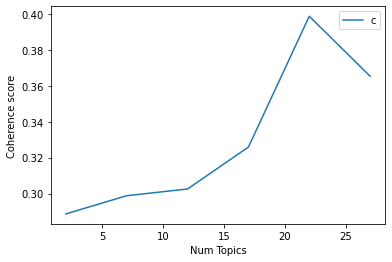

In [44]:
# Plot to see coherence score in order to choose optimal number of topics and decide optimal model
limit=30; start=2; step=5;
x = range(start, limit, step)
plt.plot(x, coherence_values_ph_score1)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [45]:
# Print the coherence scores
index = 0
for m, cv in zip(x, coherence_values_ph_score1):
    print("index:",index,"|","Num Topics =", m, " has Coherence Value of", round(cv, 4))
    index = index + 1

# optimal num_topics = 22

index: 0 | Num Topics = 2  has Coherence Value of 0.2886
index: 1 | Num Topics = 7  has Coherence Value of 0.2988
index: 2 | Num Topics = 12  has Coherence Value of 0.3025
index: 3 | Num Topics = 17  has Coherence Value of 0.3258
index: 4 | Num Topics = 22  has Coherence Value of 0.3987
index: 5 | Num Topics = 27  has Coherence Value of 0.3653


In [169]:
# Select optimal number of topics
optimal_model_ph_score1 = model_list_ph_score1[4]

In [170]:
# pyLDAVis
pyLDAvis.enable_notebook()
vis_ph_score1 = pyLDAvis.gensim_models.prepare(optimal_model_ph_score1, corpus_ph_score1, id2word_ph_score1)

In [171]:
print("pyLDAVis for ph topics for score=1:")
vis_ph_score1

pyLDAVis for ph topics for score=1:


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.157953  0.145940       1        1  11.641561
19     0.114675 -0.045102       2        1   9.686986
4      0.060907 -0.076074       3        1   8.528001
9      0.090659  0.114509       4        1   7.667988
16     0.073478 -0.045641       5        1   7.530055
20     0.057704 -0.054996       6        1   7.479346
10     0.013588 -0.086680       7        1   5.883609
17     0.096205 -0.031408       8        1   5.834344
2      0.106234  0.048864       9        1   5.722953
0     -0.050112  0.039133      10        1   4.943750
14     0.021285 -0.070523      11        1   4.876125
3     -0.001560 -0.041290      12        1   3.366399
7      0.012721 -0.155761      13        1   2.984699
13     0.057595  0.085950      14        1   2.585598
11    -0.108891  0.116126      15        1   2.560398
15    -0.049957  0.030968      16        1   2.060169
21    -0.012612 -0.027013      17        1   1.651075
8     -0.071979  0.061238      18        1   1.357214
18    -0.156349  0.036008      19        1   1.352640
12    -0.151375 -0.021458      20        1   0.899932
6     -0.130612 -0.024047      21        1   0.731349
5     -0.129555  0.001258      22        1   0.655809, topic_info=        Term        Freq       Total Category  logprob  loglift
17   account  158.000000  158.000000  Default  30.0000  30.0000
51      post   91.000000   91.000000  Default  29.0000  29.0000
6        log   55.000000   55.000000  Default  28.0000  28.0000
34    update   91.000000   91.000000  Default  27.0000  27.0000
0        app  116.000000  116.000000  Default  26.0000  26.0000
..       ...         ...         ...      ...      ...      ...
2      email    0.019114    9.196666  Topic22  -7.5038  -1.1491
4   facebook    0.019114  141.732035  Topic22  -7.5038  -3.8842
5     iphone    0.019114   13.082984  Topic22  -7.5038  -1.5016
6        log    0.019114   55.963391  Topic22  -7.5038  -2.9550
7      often    0.019114    3.405464  Topic22  -7.5038  -0.1556

[1294 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
35        2  0.178702     able
35        7  0.178702     able
35        9  0.178702     able
35       10  0.089351     able
35       11  0.089351     able
...     ...       ...      ...
64       16  0.118024      yet
64       19  0.118024      yet
64       20  0.118024      yet
1095      6  0.805985  zionist
469       7  0.628026     zoom

[2111 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 20, 5, 10, 17, 21, 11, 18, 3, 1, 15, 4, 8, 14, 12, 16, 22, 9, 19, 13, 7, 6])

## LDA Topic Modelling (Rating = 2)

In [49]:
# By-rating Topic Modelling - rating = 2
# Convert to list - move to each section
review_ph_score2 = facebook_ios_ph_review_YearMonth_score2.review.values.tolist()
review_words_ph_score2 = list(sent_to_words(review_ph_score2))
print(review_words_ph_score2[:1])

[['just', 'updated', 'my', 'facebook', 'today', 'and', 'when', 'went', 'to', 'my', 'timeline', 'noticed', 'my', 'featured', 'photos', 'which', 'became', 'smaller', 'not', 'sure', 'if', 'it', 'from', 'the', 'update', 'but', 'am', 'sure', 'that', 'it', 'wasn', 'smaller', 'the', 'other', 'day', 'don', 'like', 'it', 'small', 'like', 'it', 'as', 'it', 'is', 'please', 'change', 'it', 'back', 'it', 'so', 'unpleasing', 'in', 'the', 'eyes', 'since', 'got', 'used', 'to', 'having', 'bigger', 'feature', 'photos']]


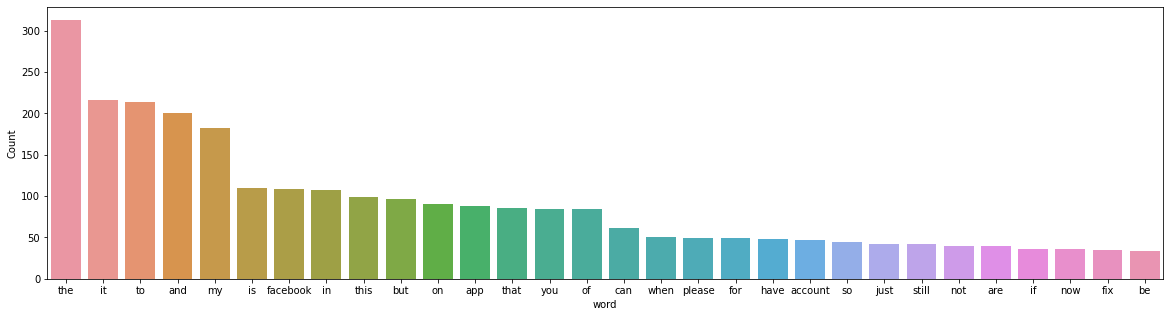

In [50]:
# Inspect the frequency of words before cleaning
freq_words(flatten(review_words_ph_score2))

In [51]:
# Clean text
review_ph_ready_score2 = process_words(review_words_ph_score2)  # processed Text Data! - move to each section


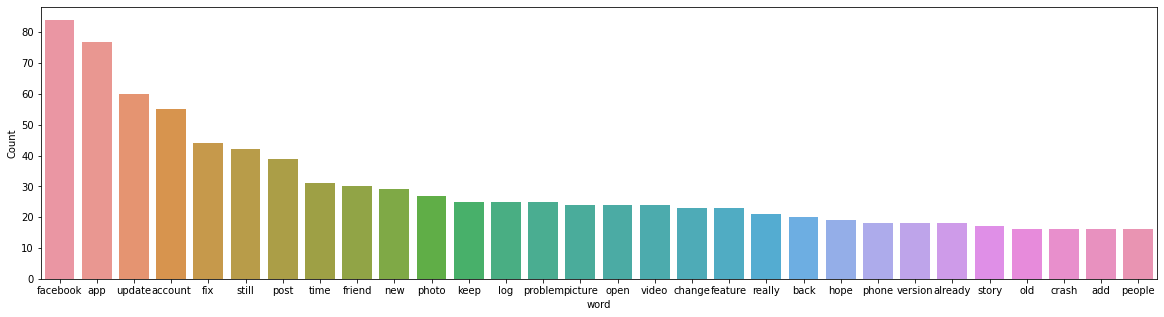

In [52]:
# Inspect the frequency of words after cleaning
freq_words(flatten(review_ph_ready_score2))


In [53]:
# Create Dictionary
id2word_ph_score2 = corpora.Dictionary(review_ph_ready_score2)

2021-10-16 18:33:37,901 [INFO] gensim.corpora.dictionary - adding document #0 to Dictionary(0 unique tokens: [])
2021-10-16 18:33:37,916 [INFO] gensim.corpora.dictionary - built Dictionary(750 unique tokens: ['back', 'become', 'big', 'change', 'day']...) from 92 documents (total 2718 corpus positions)
2021-10-16 18:33:37,918 [INFO] gensim.utils - Dictionary lifecycle event {'msg': "built Dictionary(750 unique tokens: ['back', 'become', 'big', 'change', 'day']...) from 92 documents (total 2718 corpus positions)", 'datetime': '2021-10-16T18:33:37.917940', 'gensim': '4.1.2', 'python': '3.8.8 (default, Apr 13 2021, 12:59:45) \n[Clang 10.0.0 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'created'}


In [54]:
# Create Corpus: Term Document Frequency
corpus_ph_score2 = [id2word_ph_score2.doc2bow(text) for text in review_ph_ready_score2]

In [55]:
# Training LDA model
model_list_ph_score2, coherence_values_ph_score2 = compute_coherence_values(dictionary=id2word_ph_score2, corpus=corpus_ph_score2, 
                                                              texts=review_ph_ready_score2, limit=30, start=2, step=5)


2021-10-16 18:33:37,947 [INFO] gensim.models.ldamodel - using symmetric alpha at 0.5
2021-10-16 18:33:37,948 [INFO] gensim.models.ldamodel - using symmetric eta at 0.5
2021-10-16 18:33:37,951 [INFO] gensim.models.ldamodel - using serial LDA version on this node
2021-10-16 18:33:37,953 [INFO] gensim.models.ldamodel - running online (multi-pass) LDA training, 2 topics, 50 passes over the supplied corpus of 92 documents, updating model once every 92 documents, evaluating perplexity every 92 documents, iterating 50x with a convergence threshold of 0.001000
2021-10-16 18:33:38,380 [INFO] gensim.models.ldamodel - -7.204 per-word bound, 147.4 perplexity estimate based on a held-out corpus of 92 documents with 2718 words
2021-10-16 18:33:38,382 [INFO] gensim.models.ldamodel - PROGRESS: pass 0, at document #92/92
2021-10-16 18:33:38,745 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.022*"update" + 0.020*"facebook" + 0.016*"fix" + 0.014*"app" + 0.013*"account" + 0.012*"new" + 0.011*"still" 

2021-10-16 18:33:42,822 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.030*"app" + 0.030*"facebook" + 0.019*"account" + 0.016*"update" + 0.013*"post" + 0.013*"still" + 0.013*"keep" + 0.013*"log" + 0.010*"time" + 0.010*"phone"
2021-10-16 18:33:42,826 [INFO] gensim.models.ldamodel - topic diff=0.011725, rho=0.301511
2021-10-16 18:33:43,069 [INFO] gensim.models.ldamodel - -6.228 per-word bound, 75.0 perplexity estimate based on a held-out corpus of 92 documents with 2718 words
2021-10-16 18:33:43,070 [INFO] gensim.models.ldamodel - PROGRESS: pass 10, at document #92/92
2021-10-16 18:33:43,262 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.020*"update" + 0.018*"fix" + 0.018*"facebook" + 0.014*"video" + 0.013*"account" + 0.013*"app" + 0.011*"still" + 0.011*"picture" + 0.010*"new" + 0.010*"friend"
2021-10-16 18:33:43,264 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.030*"app" + 0.030*"facebook" + 0.019*"account" + 0.016*"update" + 0.013*"post" + 0.013*"still" + 0.013*"keep" +

2021-10-16 18:33:46,988 [INFO] gensim.models.ldamodel - topic diff=0.002719, rho=0.218218
2021-10-16 18:33:47,297 [INFO] gensim.models.ldamodel - -6.222 per-word bound, 74.7 perplexity estimate based on a held-out corpus of 92 documents with 2718 words
2021-10-16 18:33:47,298 [INFO] gensim.models.ldamodel - PROGRESS: pass 20, at document #92/92
2021-10-16 18:33:47,511 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.019*"update" + 0.018*"fix" + 0.017*"facebook" + 0.015*"video" + 0.013*"app" + 0.013*"account" + 0.011*"still" + 0.011*"picture" + 0.010*"friend" + 0.010*"new"
2021-10-16 18:33:47,513 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.030*"facebook" + 0.030*"app" + 0.019*"account" + 0.016*"update" + 0.014*"post" + 0.013*"log" + 0.013*"keep" + 0.013*"still" + 0.010*"time" + 0.010*"phone"
2021-10-16 18:33:47,514 [INFO] gensim.models.ldamodel - topic diff=0.002408, rho=0.213201
2021-10-16 18:33:47,763 [INFO] gensim.models.ldamodel - -6.222 per-word bound, 74.7 perplexity es

2021-10-16 18:33:51,282 [INFO] gensim.models.ldamodel - -6.221 per-word bound, 74.6 perplexity estimate based on a held-out corpus of 92 documents with 2718 words
2021-10-16 18:33:51,284 [INFO] gensim.models.ldamodel - PROGRESS: pass 30, at document #92/92
2021-10-16 18:33:51,517 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.019*"update" + 0.018*"fix" + 0.017*"facebook" + 0.015*"video" + 0.013*"app" + 0.013*"account" + 0.011*"still" + 0.011*"picture" + 0.010*"friend" + 0.010*"photo"
2021-10-16 18:33:51,519 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.030*"facebook" + 0.030*"app" + 0.019*"account" + 0.016*"update" + 0.014*"post" + 0.013*"log" + 0.013*"keep" + 0.013*"still" + 0.010*"time" + 0.010*"phone"
2021-10-16 18:33:51,520 [INFO] gensim.models.ldamodel - topic diff=0.001154, rho=0.176777
2021-10-16 18:33:51,787 [INFO] gensim.models.ldamodel - -6.221 per-word bound, 74.6 perplexity estimate based on a held-out corpus of 92 documents with 2718 words
2021-10-16 18:33:51,79

2021-10-16 18:33:55,432 [INFO] gensim.models.ldamodel - PROGRESS: pass 40, at document #92/92
2021-10-16 18:33:55,654 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.019*"update" + 0.018*"fix" + 0.017*"facebook" + 0.015*"video" + 0.013*"app" + 0.012*"account" + 0.012*"picture" + 0.011*"still" + 0.010*"friend" + 0.010*"photo"
2021-10-16 18:33:55,656 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.030*"facebook" + 0.030*"app" + 0.019*"account" + 0.017*"update" + 0.014*"post" + 0.013*"log" + 0.013*"keep" + 0.013*"still" + 0.010*"time" + 0.010*"phone"
2021-10-16 18:33:55,657 [INFO] gensim.models.ldamodel - topic diff=0.001172, rho=0.154303
2021-10-16 18:33:55,899 [INFO] gensim.models.ldamodel - -6.221 per-word bound, 74.6 perplexity estimate based on a held-out corpus of 92 documents with 2718 words
2021-10-16 18:33:55,900 [INFO] gensim.models.ldamodel - PROGRESS: pass 41, at document #92/92
2021-10-16 18:33:56,042 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.019*"update" + 

2021-10-16 18:33:59,290 [INFO] gensim.topic_coherence.probability_estimation - using ParallelWordOccurrenceAccumulator(processes=7, batch_size=64) to estimate probabilities from sliding windows
2021-10-16 18:34:04,157 [INFO] gensim.topic_coherence.text_analysis - 7 accumulators retrieved from output queue
2021-10-16 18:34:04,219 [INFO] gensim.topic_coherence.text_analysis - accumulated word occurrence stats for 92 virtual documents
2021-10-16 18:34:04,528 [INFO] gensim.models.ldamodel - using symmetric alpha at 0.14285714285714285
2021-10-16 18:34:04,530 [INFO] gensim.models.ldamodel - using symmetric eta at 0.14285714285714285
2021-10-16 18:34:04,532 [INFO] gensim.models.ldamodel - using serial LDA version on this node
2021-10-16 18:34:04,537 [INFO] gensim.models.ldamodel - running online (multi-pass) LDA training, 7 topics, 50 passes over the supplied corpus of 92 documents, updating model once every 92 documents, evaluating perplexity every 92 documents, iterating 50x with a converg

2021-10-16 18:34:06,546 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.024*"facebook" + 0.020*"friend" + 0.019*"app" + 0.019*"fix" + 0.018*"time" + 0.015*"account" + 0.015*"privacy" + 0.014*"problem" + 0.012*"update" + 0.011*"bug"
2021-10-16 18:34:06,547 [INFO] gensim.models.ldamodel - topic diff=0.090271, rho=0.408248
2021-10-16 18:34:06,693 [INFO] gensim.models.ldamodel - -6.414 per-word bound, 85.3 perplexity estimate based on a held-out corpus of 92 documents with 2718 words
2021-10-16 18:34:06,696 [INFO] gensim.models.ldamodel - PROGRESS: pass 5, at document #92/92
2021-10-16 18:34:06,763 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.023*"facebook" + 0.020*"friend" + 0.020*"app" + 0.018*"time" + 0.018*"fix" + 0.015*"privacy" + 0.014*"account" + 0.014*"problem" + 0.012*"update" + 0.011*"bug"
2021-10-16 18:34:06,768 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.023*"facebook" + 0.022*"account" + 0.017*"really" + 0.017*"notification" + 0.015*"connection" + 0.014*"mes

2021-10-16 18:34:08,170 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.025*"update" + 0.023*"picture" + 0.020*"post" + 0.017*"photo" + 0.017*"new" + 0.016*"change" + 0.016*"option" + 0.013*"album" + 0.011*"mode" + 0.011*"square"
2021-10-16 18:34:08,173 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.038*"account" + 0.037*"facebook" + 0.027*"app" + 0.017*"new" + 0.014*"update" + 0.011*"add" + 0.010*"feature" + 0.010*"still" + 0.010*"hope" + 0.010*"version"
2021-10-16 18:34:08,176 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.023*"facebook" + 0.021*"friend" + 0.020*"app" + 0.019*"time" + 0.018*"fix" + 0.015*"privacy" + 0.014*"account" + 0.013*"problem" + 0.012*"update" + 0.011*"bug"
2021-10-16 18:34:08,179 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.028*"update" + 0.025*"post" + 0.024*"fix" + 0.024*"facebook" + 0.023*"account" + 0.019*"friend" + 0.017*"log" + 0.017*"still" + 0.016*"video" + 0.016*"version"
2021-10-16 18:34:08,181 [INFO] gensim.models.ldamodel - top

2021-10-16 18:34:09,651 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.032*"app" + 0.023*"facebook" + 0.023*"update" + 0.017*"fix" + 0.017*"keep" + 0.017*"log" + 0.017*"watch" + 0.013*"still" + 0.012*"open" + 0.012*"people"
2021-10-16 18:34:09,653 [INFO] gensim.models.ldamodel - topic diff=0.003473, rho=0.242536
2021-10-16 18:34:09,799 [INFO] gensim.models.ldamodel - -6.393 per-word bound, 84.1 perplexity estimate based on a held-out corpus of 92 documents with 2718 words
2021-10-16 18:34:09,801 [INFO] gensim.models.ldamodel - PROGRESS: pass 16, at document #92/92
2021-10-16 18:34:09,907 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.044*"app" + 0.031*"facebook" + 0.017*"photo" + 0.017*"story" + 0.016*"still" + 0.016*"phone" + 0.016*"open" + 0.015*"time" + 0.013*"crash" + 0.012*"change"
2021-10-16 18:34:09,909 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.028*"update" + 0.025*"post" + 0.024*"fix" + 0.024*"facebook" + 0.023*"account" + 0.019*"friend" + 0.017*"log" + 0.01

2021-10-16 18:34:11,290 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.038*"account" + 0.037*"facebook" + 0.027*"app" + 0.017*"new" + 0.014*"update" + 0.011*"add" + 0.010*"feature" + 0.010*"hope" + 0.010*"album" + 0.010*"still"
2021-10-16 18:34:11,293 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.022*"facebook" + 0.021*"friend" + 0.020*"app" + 0.019*"time" + 0.018*"fix" + 0.015*"privacy" + 0.014*"account" + 0.013*"problem" + 0.011*"update" + 0.011*"bug"
2021-10-16 18:34:11,298 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.032*"app" + 0.023*"facebook" + 0.023*"update" + 0.017*"fix" + 0.017*"keep" + 0.017*"watch" + 0.017*"log" + 0.013*"still" + 0.012*"open" + 0.012*"people"
2021-10-16 18:34:11,300 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.044*"app" + 0.031*"facebook" + 0.017*"photo" + 0.017*"story" + 0.016*"still" + 0.016*"phone" + 0.015*"open" + 0.015*"time" + 0.014*"crash" + 0.012*"change"
2021-10-16 18:34:11,302 [INFO] gensim.models.ldamodel - topic diff=0.0

2021-10-16 18:34:12,776 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.044*"app" + 0.031*"facebook" + 0.017*"photo" + 0.017*"story" + 0.016*"still" + 0.016*"phone" + 0.015*"open" + 0.014*"time" + 0.014*"crash" + 0.012*"change"
2021-10-16 18:34:12,777 [INFO] gensim.models.ldamodel - topic diff=0.000507, rho=0.188982
2021-10-16 18:34:12,915 [INFO] gensim.models.ldamodel - -6.392 per-word bound, 84.0 perplexity estimate based on a held-out corpus of 92 documents with 2718 words
2021-10-16 18:34:12,917 [INFO] gensim.models.ldamodel - PROGRESS: pass 27, at document #92/92
2021-10-16 18:34:13,017 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.038*"account" + 0.037*"facebook" + 0.027*"app" + 0.017*"new" + 0.014*"update" + 0.011*"add" + 0.010*"feature" + 0.010*"hope" + 0.010*"album" + 0.010*"version"
2021-10-16 18:34:13,020 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.025*"update" + 0.023*"picture" + 0.019*"post" + 0.017*"photo" + 0.017*"new" + 0.016*"change" + 0.016*"option" 

2021-10-16 18:34:14,519 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.022*"facebook" + 0.021*"friend" + 0.020*"app" + 0.019*"time" + 0.018*"fix" + 0.015*"privacy" + 0.014*"account" + 0.013*"problem" + 0.011*"bug" + 0.011*"ever"
2021-10-16 18:34:14,520 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.025*"update" + 0.023*"picture" + 0.019*"post" + 0.017*"photo" + 0.017*"new" + 0.016*"change" + 0.016*"option" + 0.013*"album" + 0.011*"mode" + 0.011*"square"
2021-10-16 18:34:14,522 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.032*"app" + 0.023*"update" + 0.023*"facebook" + 0.017*"keep" + 0.017*"fix" + 0.017*"watch" + 0.017*"log" + 0.013*"still" + 0.012*"people" + 0.012*"open"
2021-10-16 18:34:14,523 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.028*"update" + 0.025*"post" + 0.024*"facebook" + 0.024*"fix" + 0.023*"account" + 0.019*"friend" + 0.017*"log" + 0.017*"still" + 0.016*"video" + 0.016*"version"
2021-10-16 18:34:14,525 [INFO] gensim.models.ldamodel - topic #2 (0

2021-10-16 18:34:15,917 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.032*"app" + 0.023*"update" + 0.023*"facebook" + 0.017*"keep" + 0.017*"fix" + 0.017*"watch" + 0.017*"log" + 0.013*"still" + 0.012*"people" + 0.012*"open"
2021-10-16 18:34:15,918 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.022*"account" + 0.022*"facebook" + 0.017*"notification" + 0.017*"really" + 0.016*"connection" + 0.013*"user" + 0.013*"message" + 0.013*"troll" + 0.010*"people" + 0.010*"messenger"
2021-10-16 18:34:15,920 [INFO] gensim.models.ldamodel - topic diff=0.000122, rho=0.160128
2021-10-16 18:34:16,145 [INFO] gensim.models.ldamodel - -6.392 per-word bound, 84.0 perplexity estimate based on a held-out corpus of 92 documents with 2718 words
2021-10-16 18:34:16,146 [INFO] gensim.models.ldamodel - PROGRESS: pass 38, at document #92/92
2021-10-16 18:34:16,208 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.028*"update" + 0.025*"post" + 0.024*"facebook" + 0.024*"fix" + 0.023*"account" + 0.019*"frie

2021-10-16 18:34:17,593 [INFO] gensim.models.ldamodel - -6.392 per-word bound, 84.0 perplexity estimate based on a held-out corpus of 92 documents with 2718 words
2021-10-16 18:34:17,594 [INFO] gensim.models.ldamodel - PROGRESS: pass 43, at document #92/92
2021-10-16 18:34:17,690 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.038*"account" + 0.037*"facebook" + 0.027*"app" + 0.017*"new" + 0.014*"update" + 0.011*"add" + 0.010*"feature" + 0.010*"hope" + 0.010*"album" + 0.010*"version"
2021-10-16 18:34:17,692 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.028*"update" + 0.025*"post" + 0.024*"facebook" + 0.024*"fix" + 0.023*"account" + 0.019*"friend" + 0.017*"log" + 0.017*"still" + 0.016*"video" + 0.016*"version"
2021-10-16 18:34:17,695 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.025*"update" + 0.023*"picture" + 0.019*"post" + 0.017*"photo" + 0.017*"new" + 0.016*"change" + 0.016*"option" + 0.013*"album" + 0.011*"mode" + 0.011*"small"
2021-10-16 18:34:17,700 [INFO] gensim.m

2021-10-16 18:34:19,143 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.032*"app" + 0.023*"update" + 0.023*"facebook" + 0.017*"keep" + 0.017*"fix" + 0.017*"watch" + 0.017*"log" + 0.013*"still" + 0.012*"people" + 0.012*"open"
2021-10-16 18:34:19,146 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.028*"update" + 0.025*"post" + 0.024*"facebook" + 0.024*"fix" + 0.023*"account" + 0.019*"friend" + 0.017*"log" + 0.017*"still" + 0.016*"video" + 0.016*"version"
2021-10-16 18:34:19,149 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.022*"facebook" + 0.021*"friend" + 0.020*"app" + 0.019*"time" + 0.018*"fix" + 0.015*"privacy" + 0.014*"account" + 0.013*"problem" + 0.011*"bug" + 0.011*"ever"
2021-10-16 18:34:19,150 [INFO] gensim.models.ldamodel - topic diff=0.000030, rho=0.141421
2021-10-16 18:34:19,302 [INFO] gensim.models.ldamodel - -6.392 per-word bound, 84.0 perplexity estimate based on a held-out corpus of 92 documents with 2718 words
2021-10-16 18:34:19,303 [INFO] gensim.models.lda

2021-10-16 18:34:29,036 [INFO] gensim.models.ldamodel - topic diff=0.250873, rho=0.500000
2021-10-16 18:34:29,202 [INFO] gensim.models.ldamodel - -6.550 per-word bound, 93.7 perplexity estimate based on a held-out corpus of 92 documents with 2718 words
2021-10-16 18:34:29,204 [INFO] gensim.models.ldamodel - PROGRESS: pass 3, at document #92/92
2021-10-16 18:34:29,306 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.053*"app" + 0.033*"facebook" + 0.022*"phone" + 0.018*"crash" + 0.017*"post" + 0.016*"time" + 0.014*"open" + 0.014*"always" + 0.013*"still" + 0.012*"feature"
2021-10-16 18:34:29,307 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.026*"photo" + 0.026*"privacy" + 0.025*"friend" + 0.021*"change" + 0.017*"request" + 0.017*"facebook" + 0.013*"profile" + 0.011*"still" + 0.011*"app" + 0.009*"setting"
2021-10-16 18:34:29,309 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.059*"account" + 0.047*"facebook" + 0.046*"log" + 0.037*"version" + 0.034*"update" + 0.026*"app" + 0.02

2021-10-16 18:34:30,644 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.036*"facebook" + 0.027*"app" + 0.019*"new" + 0.018*"fix" + 0.018*"keep" + 0.018*"photo" + 0.018*"update" + 0.017*"account" + 0.015*"still" + 0.015*"open"
2021-10-16 18:34:30,646 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.031*"photo" + 0.025*"privacy" + 0.025*"friend" + 0.024*"change" + 0.017*"request" + 0.017*"facebook" + 0.017*"profile" + 0.014*"still" + 0.011*"app" + 0.011*"upload"
2021-10-16 18:34:30,653 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.060*"account" + 0.050*"facebook" + 0.046*"log" + 0.038*"version" + 0.034*"update" + 0.026*"old" + 0.025*"app" + 0.023*"new" + 0.021*"still" + 0.018*"fix"
2021-10-16 18:34:30,656 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.030*"update" + 0.024*"app" + 0.021*"setting" + 0.021*"post" + 0.018*"tab" + 0.017*"set" + 0.017*"picture" + 0.014*"profile" + 0.014*"keep" + 0.014*"photo"
2021-10-16 18:34:30,658 [INFO] gensim.models.ldamodel - topic diff

2021-10-16 18:34:31,890 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.052*"account" + 0.036*"facebook" + 0.028*"app" + 0.016*"album" + 0.012*"login" + 0.012*"hope" + 0.012*"time" + 0.012*"still" + 0.012*"open" + 0.012*"disabled"
2021-10-16 18:34:31,894 [INFO] gensim.models.ldamodel - topic diff=0.007739, rho=0.258199
2021-10-16 18:34:32,061 [INFO] gensim.models.ldamodel - -6.463 per-word bound, 88.2 perplexity estimate based on a held-out corpus of 92 documents with 2718 words
2021-10-16 18:34:32,063 [INFO] gensim.models.ldamodel - PROGRESS: pass 14, at document #92/92
2021-10-16 18:34:32,161 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.025*"post" + 0.023*"story" + 0.022*"update" + 0.021*"share" + 0.019*"fix" + 0.019*"edit" + 0.018*"friend" + 0.015*"problem" + 0.015*"picture" + 0.015*"new"
2021-10-16 18:34:32,164 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.042*"message" + 0.036*"app" + 0.016*"send" + 0.016*"facebook" + 0.016*"notification" + 0.016*"messenger" + 0.

2021-10-16 18:34:33,406 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.060*"account" + 0.052*"facebook" + 0.046*"log" + 0.037*"version" + 0.034*"update" + 0.027*"old" + 0.025*"app" + 0.023*"new" + 0.022*"still" + 0.018*"fix"
2021-10-16 18:34:33,407 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.036*"facebook" + 0.028*"app" + 0.019*"keep" + 0.019*"photo" + 0.019*"new" + 0.018*"fix" + 0.018*"update" + 0.017*"account" + 0.015*"open" + 0.015*"still"
2021-10-16 18:34:33,409 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.042*"message" + 0.036*"app" + 0.016*"send" + 0.016*"facebook" + 0.016*"notification" + 0.016*"messenger" + 0.016*"people" + 0.016*"read" + 0.016*"stupid" + 0.016*"watch"
2021-10-16 18:34:33,411 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.052*"account" + 0.036*"facebook" + 0.028*"app" + 0.016*"album" + 0.012*"login" + 0.012*"hope" + 0.012*"time" + 0.012*"still" + 0.012*"open" + 0.012*"disabled"
2021-10-16 18:34:33,412 [INFO] gensim.models.ldamodel - top

2021-10-16 18:34:34,653 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.055*"app" + 0.035*"facebook" + 0.024*"phone" + 0.019*"crash" + 0.017*"time" + 0.014*"open" + 0.014*"always" + 0.014*"post" + 0.012*"feature" + 0.012*"still"
2021-10-16 18:34:34,655 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.021*"facebook" + 0.021*"people" + 0.021*"video" + 0.016*"watch" + 0.016*"keep" + 0.016*"crash" + 0.016*"comment" + 0.016*"give" + 0.016*"advert" + 0.016*"post"
2021-10-16 18:34:34,656 [INFO] gensim.models.ldamodel - topic diff=0.001008, rho=0.196116
2021-10-16 18:34:34,757 [INFO] gensim.models.ldamodel - -6.460 per-word bound, 88.1 perplexity estimate based on a held-out corpus of 92 documents with 2718 words
2021-10-16 18:34:34,760 [INFO] gensim.models.ldamodel - PROGRESS: pass 25, at document #92/92
2021-10-16 18:34:34,913 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.055*"app" + 0.035*"facebook" + 0.024*"phone" + 0.019*"crash" + 0.017*"time" + 0.014*"open" + 0.014*"always" 

2021-10-16 18:34:36,065 [INFO] gensim.models.ldamodel - -6.460 per-word bound, 88.0 perplexity estimate based on a held-out corpus of 92 documents with 2718 words
2021-10-16 18:34:36,067 [INFO] gensim.models.ldamodel - PROGRESS: pass 30, at document #92/92
2021-10-16 18:34:36,156 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.030*"video" + 0.021*"fix" + 0.021*"update" + 0.021*"watch" + 0.021*"friend" + 0.018*"facebook" + 0.017*"still" + 0.016*"hope" + 0.015*"account" + 0.015*"keep"
2021-10-16 18:34:36,159 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.021*"facebook" + 0.021*"people" + 0.021*"video" + 0.016*"watch" + 0.016*"keep" + 0.016*"crash" + 0.016*"comment" + 0.016*"give" + 0.016*"post" + 0.016*"advert"
2021-10-16 18:34:36,180 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.027*"post" + 0.024*"story" + 0.022*"update" + 0.022*"share" + 0.018*"fix" + 0.018*"edit" + 0.018*"friend" + 0.015*"problem" + 0.015*"new" + 0.015*"picture"
2021-10-16 18:34:36,185 [INFO] gensim.m

2021-10-16 18:34:37,684 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.036*"facebook" + 0.028*"app" + 0.019*"keep" + 0.019*"photo" + 0.018*"new" + 0.018*"fix" + 0.018*"update" + 0.017*"account" + 0.015*"open" + 0.015*"still"
2021-10-16 18:34:37,686 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.032*"photo" + 0.025*"privacy" + 0.025*"friend" + 0.024*"change" + 0.017*"request" + 0.017*"facebook" + 0.017*"profile" + 0.015*"upload" + 0.015*"feed" + 0.015*"still"
2021-10-16 18:34:37,691 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.055*"app" + 0.035*"facebook" + 0.024*"phone" + 0.019*"crash" + 0.017*"time" + 0.014*"open" + 0.014*"always" + 0.014*"post" + 0.012*"feature" + 0.012*"still"
2021-10-16 18:34:37,692 [INFO] gensim.models.ldamodel - topic diff=0.000254, rho=0.164399
2021-10-16 18:34:37,801 [INFO] gensim.models.ldamodel - -6.460 per-word bound, 88.0 perplexity estimate based on a held-out corpus of 92 documents with 2718 words
2021-10-16 18:34:37,811 [INFO] gensim.mod

2021-10-16 18:34:39,102 [INFO] gensim.models.ldamodel - topic diff=0.000169, rho=0.154303
2021-10-16 18:34:39,330 [INFO] gensim.models.ldamodel - -6.460 per-word bound, 88.0 perplexity estimate based on a held-out corpus of 92 documents with 2718 words
2021-10-16 18:34:39,334 [INFO] gensim.models.ldamodel - PROGRESS: pass 41, at document #92/92
2021-10-16 18:34:39,413 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.055*"app" + 0.035*"facebook" + 0.024*"phone" + 0.019*"crash" + 0.017*"time" + 0.014*"open" + 0.014*"always" + 0.013*"post" + 0.012*"feature" + 0.012*"still"
2021-10-16 18:34:39,417 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.052*"account" + 0.036*"facebook" + 0.028*"app" + 0.016*"album" + 0.012*"login" + 0.012*"hope" + 0.012*"time" + 0.012*"open" + 0.012*"look" + 0.012*"disabled"
2021-10-16 18:34:39,421 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.026*"change" + 0.021*"connect" + 0.016*"thing" + 0.016*"post" + 0.016*"update" + 0.016*"facebook" + 0.016*"con

2021-10-16 18:34:41,424 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.026*"change" + 0.021*"connect" + 0.016*"thing" + 0.016*"update" + 0.016*"post" + 0.016*"connection" + 0.016*"facebook" + 0.011*"square" + 0.011*"profile" + 0.011*"let"
2021-10-16 18:34:41,427 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.031*"video" + 0.021*"fix" + 0.021*"update" + 0.021*"watch" + 0.021*"friend" + 0.018*"facebook" + 0.017*"still" + 0.016*"hope" + 0.015*"work" + 0.015*"keep"
2021-10-16 18:34:41,429 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.055*"app" + 0.035*"facebook" + 0.024*"phone" + 0.019*"crash" + 0.017*"time" + 0.014*"always" + 0.014*"open" + 0.013*"post" + 0.012*"feature" + 0.012*"still"
2021-10-16 18:34:41,430 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.052*"account" + 0.036*"facebook" + 0.028*"app" + 0.016*"album" + 0.012*"hope" + 0.012*"login" + 0.012*"time" + 0.012*"open" + 0.012*"look" + 0.012*"disabled"
2021-10-16 18:34:41,431 [INFO] gensim.models.ldamodel - t

2021-10-16 18:34:52,221 [INFO] gensim.models.ldamodel - topic #10 (0.059): 0.037*"update" + 0.033*"app" + 0.031*"crash" + 0.025*"keep" + 0.021*"tab" + 0.019*"problem" + 0.016*"time" + 0.016*"work" + 0.015*"profile" + 0.015*"facebook"
2021-10-16 18:34:52,225 [INFO] gensim.models.ldamodel - topic diff=12.531039, rho=1.000000
2021-10-16 18:34:52,418 [INFO] gensim.models.ldamodel - -6.946 per-word bound, 123.3 perplexity estimate based on a held-out corpus of 92 documents with 2718 words
2021-10-16 18:34:52,420 [INFO] gensim.models.ldamodel - PROGRESS: pass 1, at document #92/92
2021-10-16 18:34:52,539 [INFO] gensim.models.ldamodel - topic #4 (0.059): 0.028*"video" + 0.024*"still" + 0.023*"account" + 0.020*"fix" + 0.020*"add" + 0.020*"facebook" + 0.019*"watch" + 0.018*"work" + 0.016*"future" + 0.016*"feature"
2021-10-16 18:34:52,542 [INFO] gensim.models.ldamodel - topic #14 (0.059): 0.011*"account" + 0.006*"session" + 0.005*"send" + 0.005*"facebook" + 0.005*"sm" + 0.004*"expire" + 0.004*"l

2021-10-16 18:34:54,020 [INFO] gensim.models.ldamodel - topic #10 (0.059): 0.036*"app" + 0.034*"update" + 0.032*"crash" + 0.026*"keep" + 0.022*"tab" + 0.022*"problem" + 0.020*"picture" + 0.017*"work" + 0.017*"profile" + 0.017*"time"
2021-10-16 18:34:54,022 [INFO] gensim.models.ldamodel - topic #5 (0.059): 0.060*"log" + 0.030*"remove" + 0.016*"put" + 0.016*"feature" + 0.016*"update" + 0.016*"guy" + 0.016*"literally" + 0.016*"thing" + 0.016*"confirm" + 0.016*"crappy"
2021-10-16 18:34:54,023 [INFO] gensim.models.ldamodel - topic #8 (0.059): 0.034*"picture" + 0.024*"update" + 0.024*"fix" + 0.015*"small" + 0.015*"landscape" + 0.015*"open" + 0.015*"click" + 0.015*"still" + 0.015*"sure" + 0.014*"ever"
2021-10-16 18:34:54,024 [INFO] gensim.models.ldamodel - topic #3 (0.059): 0.071*"account" + 0.047*"facebook" + 0.027*"app" + 0.021*"disabled" + 0.020*"hope" + 0.016*"login" + 0.016*"find" + 0.014*"look" + 0.011*"time" + 0.011*"fb"
2021-10-16 18:34:54,025 [INFO] gensim.models.ldamodel - topic dif

2021-10-16 18:34:55,320 [INFO] gensim.models.ldamodel - topic #4 (0.059): 0.033*"video" + 0.022*"add" + 0.022*"watch" + 0.021*"fix" + 0.020*"still" + 0.018*"facebook" + 0.018*"work" + 0.018*"future" + 0.018*"feature" + 0.018*"account"
2021-10-16 18:34:55,322 [INFO] gensim.models.ldamodel - topic diff=0.015674, rho=0.277350
2021-10-16 18:34:55,507 [INFO] gensim.models.ldamodel - -6.556 per-word bound, 94.1 perplexity estimate based on a held-out corpus of 92 documents with 2718 words
2021-10-16 18:34:55,520 [INFO] gensim.models.ldamodel - PROGRESS: pass 12, at document #92/92
2021-10-16 18:34:55,574 [INFO] gensim.models.ldamodel - topic #13 (0.059): 0.033*"video" + 0.022*"post" + 0.022*"watch" + 0.016*"fix" + 0.015*"setting" + 0.015*"set" + 0.014*"friend" + 0.013*"update" + 0.012*"app" + 0.011*"give"
2021-10-16 18:34:55,577 [INFO] gensim.models.ldamodel - topic #16 (0.059): 0.039*"facebook" + 0.036*"friend" + 0.028*"story" + 0.028*"open" + 0.024*"account" + 0.024*"time" + 0.023*"app" + 

2021-10-16 18:34:56,804 [INFO] gensim.models.ldamodel - topic #2 (0.059): 0.030*"facebook" + 0.018*"message" + 0.018*"notification" + 0.018*"messenger" + 0.018*"send" + 0.018*"user" + 0.014*"app" + 0.012*"receive" + 0.012*"reply" + 0.012*"help"
2021-10-16 18:34:56,805 [INFO] gensim.models.ldamodel - topic #4 (0.059): 0.033*"video" + 0.022*"add" + 0.022*"watch" + 0.021*"fix" + 0.020*"still" + 0.019*"facebook" + 0.019*"work" + 0.019*"future" + 0.019*"feature" + 0.017*"account"
2021-10-16 18:34:56,806 [INFO] gensim.models.ldamodel - topic #12 (0.059): 0.033*"still" + 0.033*"year" + 0.017*"facebook" + 0.017*"change" + 0.017*"acc" + 0.017*"back" + 0.017*"give" + 0.017*"luckily" + 0.017*"birth" + 0.017*"memory"
2021-10-16 18:34:56,807 [INFO] gensim.models.ldamodel - topic #0 (0.059): 0.046*"picture" + 0.031*"edit" + 0.031*"crop" + 0.031*"icon" + 0.016*"tap" + 0.016*"upload" + 0.016*"blur" + 0.016*"uploading" + 0.016*"new" + 0.016*"feature"
2021-10-16 18:34:56,811 [INFO] gensim.models.ldamode

2021-10-16 18:34:58,052 [INFO] gensim.models.ldamodel - topic #6 (0.059): 0.041*"facebook" + 0.021*"app" + 0.021*"mode" + 0.021*"dark" + 0.021*"look" + 0.021*"friend" + 0.021*"public" + 0.021*"show" + 0.011*"update" + 0.011*"fix"
2021-10-16 18:34:58,054 [INFO] gensim.models.ldamodel - topic diff=0.001754, rho=0.204124
2021-10-16 18:34:58,137 [INFO] gensim.models.ldamodel - -6.550 per-word bound, 93.7 perplexity estimate based on a held-out corpus of 92 documents with 2718 words
2021-10-16 18:34:58,138 [INFO] gensim.models.ldamodel - PROGRESS: pass 23, at document #92/92
2021-10-16 18:34:58,281 [INFO] gensim.models.ldamodel - topic #4 (0.059): 0.033*"video" + 0.022*"add" + 0.022*"watch" + 0.021*"fix" + 0.020*"still" + 0.019*"facebook" + 0.019*"work" + 0.019*"future" + 0.019*"feature" + 0.017*"account"
2021-10-16 18:34:58,283 [INFO] gensim.models.ldamodel - topic #13 (0.059): 0.033*"video" + 0.022*"post" + 0.022*"watch" + 0.016*"fix" + 0.015*"setting" + 0.015*"set" + 0.014*"friend" + 0.0

2021-10-16 18:34:59,607 [INFO] gensim.models.ldamodel - topic #10 (0.059): 0.037*"app" + 0.032*"update" + 0.032*"crash" + 0.027*"keep" + 0.022*"tab" + 0.022*"problem" + 0.019*"picture" + 0.018*"work" + 0.018*"profile" + 0.015*"time"
2021-10-16 18:34:59,624 [INFO] gensim.models.ldamodel - topic #5 (0.059): 0.060*"log" + 0.031*"remove" + 0.016*"put" + 0.016*"feature" + 0.016*"update" + 0.016*"literally" + 0.016*"cry" + 0.016*"let" + 0.016*"device" + 0.016*"thing"
2021-10-16 18:34:59,633 [INFO] gensim.models.ldamodel - topic #9 (0.059): 0.059*"account" + 0.057*"facebook" + 0.046*"log" + 0.037*"version" + 0.031*"update" + 0.024*"app" + 0.023*"old" + 0.023*"new" + 0.020*"show" + 0.017*"still"
2021-10-16 18:34:59,645 [INFO] gensim.models.ldamodel - topic #14 (0.059): 0.001*"account" + 0.001*"session" + 0.001*"send" + 0.001*"facebook" + 0.001*"sm" + 0.001*"expire" + 0.001*"log" + 0.001*"reply" + 0.001*"open" + 0.001*"security"
2021-10-16 18:34:59,646 [INFO] gensim.models.ldamodel - topic diff

2021-10-16 18:35:00,941 [INFO] gensim.models.ldamodel - topic #15 (0.059): 0.059*"app" + 0.043*"change" + 0.029*"update" + 0.021*"time" + 0.021*"mode" + 0.019*"still" + 0.017*"photo" + 0.017*"phone" + 0.017*"dark" + 0.015*"already"
2021-10-16 18:35:00,942 [INFO] gensim.models.ldamodel - topic diff=0.000326, rho=0.169031
2021-10-16 18:35:01,077 [INFO] gensim.models.ldamodel - -6.549 per-word bound, 93.6 perplexity estimate based on a held-out corpus of 92 documents with 2718 words
2021-10-16 18:35:01,078 [INFO] gensim.models.ldamodel - PROGRESS: pass 34, at document #92/92
2021-10-16 18:35:01,183 [INFO] gensim.models.ldamodel - topic #1 (0.059): 0.057*"app" + 0.025*"message" + 0.021*"facebook" + 0.021*"crash" + 0.021*"whenever" + 0.016*"download" + 0.016*"read" + 0.016*"keep" + 0.012*"photo" + 0.012*"feature"
2021-10-16 18:35:01,187 [INFO] gensim.models.ldamodel - topic #0 (0.059): 0.046*"picture" + 0.031*"edit" + 0.031*"crop" + 0.031*"icon" + 0.016*"tap" + 0.016*"uploading" + 0.016*"bl

2021-10-16 18:35:02,550 [INFO] gensim.models.ldamodel - topic #4 (0.059): 0.033*"video" + 0.022*"add" + 0.022*"watch" + 0.021*"fix" + 0.019*"still" + 0.019*"facebook" + 0.019*"work" + 0.019*"feature" + 0.019*"future" + 0.017*"account"
2021-10-16 18:35:02,554 [INFO] gensim.models.ldamodel - topic #0 (0.059): 0.046*"picture" + 0.031*"edit" + 0.031*"crop" + 0.031*"icon" + 0.016*"tap" + 0.016*"new" + 0.016*"uploading" + 0.016*"blur" + 0.016*"upload" + 0.016*"feature"
2021-10-16 18:35:02,555 [INFO] gensim.models.ldamodel - topic #6 (0.059): 0.041*"facebook" + 0.021*"app" + 0.021*"dark" + 0.021*"mode" + 0.021*"look" + 0.021*"public" + 0.021*"friend" + 0.021*"show" + 0.011*"update" + 0.011*"fix"
2021-10-16 18:35:02,558 [INFO] gensim.models.ldamodel - topic #12 (0.059): 0.033*"still" + 0.033*"year" + 0.017*"facebook" + 0.017*"change" + 0.017*"acc" + 0.017*"back" + 0.017*"give" + 0.017*"luckily" + 0.017*"birth" + 0.017*"memory"
2021-10-16 18:35:02,560 [INFO] gensim.models.ldamodel - topic diff=

2021-10-16 18:35:03,921 [INFO] gensim.models.ldamodel - topic #13 (0.059): 0.033*"video" + 0.022*"post" + 0.022*"watch" + 0.016*"fix" + 0.015*"setting" + 0.015*"set" + 0.014*"friend" + 0.012*"app" + 0.012*"update" + 0.011*"give"
2021-10-16 18:35:03,923 [INFO] gensim.models.ldamodel - topic diff=0.000052, rho=0.147442
2021-10-16 18:35:04,071 [INFO] gensim.models.ldamodel - -6.549 per-word bound, 93.6 perplexity estimate based on a held-out corpus of 92 documents with 2718 words
2021-10-16 18:35:04,075 [INFO] gensim.models.ldamodel - PROGRESS: pass 45, at document #92/92
2021-10-16 18:35:04,166 [INFO] gensim.models.ldamodel - topic #12 (0.059): 0.033*"still" + 0.033*"year" + 0.017*"facebook" + 0.017*"change" + 0.017*"acc" + 0.017*"back" + 0.017*"give" + 0.017*"luckily" + 0.017*"birth" + 0.017*"page"
2021-10-16 18:35:04,178 [INFO] gensim.models.ldamodel - topic #11 (0.059): 0.046*"post" + 0.027*"update" + 0.022*"share" + 0.019*"always" + 0.018*"crash" + 0.017*"facebook" + 0.015*"app" + 0.

2021-10-16 18:35:05,305 [INFO] gensim.topic_coherence.probability_estimation - using ParallelWordOccurrenceAccumulator(processes=7, batch_size=64) to estimate probabilities from sliding windows
2021-10-16 18:35:10,528 [INFO] gensim.topic_coherence.text_analysis - 7 accumulators retrieved from output queue
2021-10-16 18:35:10,601 [INFO] gensim.topic_coherence.text_analysis - accumulated word occurrence stats for 92 virtual documents
2021-10-16 18:35:14,072 [INFO] gensim.models.ldamodel - using symmetric alpha at 0.045454545454545456
2021-10-16 18:35:14,074 [INFO] gensim.models.ldamodel - using symmetric eta at 0.045454545454545456
2021-10-16 18:35:14,078 [INFO] gensim.models.ldamodel - using serial LDA version on this node
2021-10-16 18:35:14,083 [INFO] gensim.models.ldamodel - running online (multi-pass) LDA training, 22 topics, 50 passes over the supplied corpus of 92 documents, updating model once every 92 documents, evaluating perplexity every 92 documents, iterating 50x with a conv

2021-10-16 18:35:15,906 [INFO] gensim.models.ldamodel - topic #6 (0.045): 0.045*"facebook" + 0.023*"highlight" + 0.023*"add" + 0.023*"app" + 0.023*"update" + 0.023*"dark" + 0.023*"mode" + 0.012*"new" + 0.012*"photo" + 0.012*"account"
2021-10-16 18:35:15,907 [INFO] gensim.models.ldamodel - topic diff=0.134820, rho=0.408248
2021-10-16 18:35:16,038 [INFO] gensim.models.ldamodel - -6.637 per-word bound, 99.5 perplexity estimate based on a held-out corpus of 92 documents with 2718 words
2021-10-16 18:35:16,039 [INFO] gensim.models.ldamodel - PROGRESS: pass 5, at document #92/92
2021-10-16 18:35:16,148 [INFO] gensim.models.ldamodel - topic #0 (0.045): 0.021*"button" + 0.021*"block" + 0.021*"still" + 0.021*"mistake" + 0.021*"post" + 0.021*"action" + 0.021*"ok" + 0.021*"click" + 0.021*"option" + 0.020*"square"
2021-10-16 18:35:16,149 [INFO] gensim.models.ldamodel - topic #18 (0.045): 0.031*"update" + 0.031*"change" + 0.025*"app" + 0.019*"photo" + 0.019*"version" + 0.013*"profile" + 0.013*"some

2021-10-16 18:35:17,323 [INFO] gensim.models.ldamodel - PROGRESS: pass 10, at document #92/92
2021-10-16 18:35:17,376 [INFO] gensim.models.ldamodel - topic #7 (0.045): 0.025*"fix" + 0.022*"facebook" + 0.022*"account" + 0.019*"post" + 0.016*"new" + 0.016*"issue" + 0.016*"keep" + 0.015*"people" + 0.012*"app" + 0.012*"photo"
2021-10-16 18:35:17,377 [INFO] gensim.models.ldamodel - topic #20 (0.045): 0.029*"update" + 0.029*"video" + 0.025*"post" + 0.021*"fix" + 0.021*"facebook" + 0.020*"give" + 0.016*"app" + 0.016*"new" + 0.016*"always" + 0.016*"still"
2021-10-16 18:35:17,379 [INFO] gensim.models.ldamodel - topic #1 (0.045): 0.056*"crash" + 0.045*"app" + 0.045*"whenever" + 0.034*"photo" + 0.023*"always" + 0.023*"quality" + 0.023*"upload" + 0.023*"minute" + 0.023*"sometimes" + 0.012*"facebook"
2021-10-16 18:35:17,381 [INFO] gensim.models.ldamodel - topic #6 (0.045): 0.045*"facebook" + 0.023*"highlight" + 0.023*"add" + 0.023*"app" + 0.023*"update" + 0.023*"dark" + 0.023*"mode" + 0.012*"new" +

2021-10-16 18:35:18,680 [INFO] gensim.models.ldamodel - topic #11 (0.045): 0.043*"post" + 0.032*"edit" + 0.022*"let" + 0.022*"change" + 0.022*"facebook" + 0.022*"thing" + 0.022*"article" + 0.022*"automatically" + 0.022*"share" + 0.022*"comment"
2021-10-16 18:35:18,681 [INFO] gensim.models.ldamodel - topic #13 (0.045): 0.031*"app" + 0.031*"facebook" + 0.022*"update" + 0.022*"load" + 0.022*"problem" + 0.022*"time" + 0.022*"connection" + 0.018*"watch" + 0.018*"video" + 0.018*"fix"
2021-10-16 18:35:18,684 [INFO] gensim.models.ldamodel - topic #12 (0.045): 0.001*"change" + 0.001*"update" + 0.001*"interface" + 0.001*"small" + 0.001*"dock" + 0.001*"user" + 0.001*"rearrange" + 0.001*"alert" + 0.001*"continue" + 0.001*"comeon"
2021-10-16 18:35:18,685 [INFO] gensim.models.ldamodel - topic diff=0.006087, rho=0.242536
2021-10-16 18:35:18,848 [INFO] gensim.models.ldamodel - -6.593 per-word bound, 96.5 perplexity estimate based on a held-out corpus of 92 documents with 2718 words
2021-10-16 18:35:18

2021-10-16 18:35:19,928 [INFO] gensim.models.ldamodel - topic #13 (0.045): 0.031*"app" + 0.031*"facebook" + 0.022*"update" + 0.022*"load" + 0.022*"problem" + 0.022*"time" + 0.022*"connection" + 0.018*"watch" + 0.018*"video" + 0.018*"fix"
2021-10-16 18:35:19,934 [INFO] gensim.models.ldamodel - topic diff=0.002289, rho=0.213201
2021-10-16 18:35:20,092 [INFO] gensim.models.ldamodel - -6.591 per-word bound, 96.4 perplexity estimate based on a held-out corpus of 92 documents with 2718 words
2021-10-16 18:35:20,093 [INFO] gensim.models.ldamodel - PROGRESS: pass 21, at document #92/92
2021-10-16 18:35:20,187 [INFO] gensim.models.ldamodel - topic #3 (0.045): 0.087*"account" + 0.056*"facebook" + 0.021*"album" + 0.016*"open" + 0.016*"disabled" + 0.016*"send" + 0.016*"friend" + 0.016*"find" + 0.016*"still" + 0.010*"time"
2021-10-16 18:35:20,189 [INFO] gensim.models.ldamodel - topic #15 (0.045): 0.060*"app" + 0.029*"phone" + 0.028*"still" + 0.026*"update" + 0.021*"crash" + 0.021*"keep" + 0.018*"fa

2021-10-16 18:35:21,520 [INFO] gensim.models.ldamodel - topic #21 (0.045): 0.025*"facebook" + 0.025*"login" + 0.025*"error" + 0.025*"open" + 0.025*"picture" + 0.025*"landscape" + 0.017*"password" + 0.017*"help" + 0.017*"occur" + 0.017*"unexpected"
2021-10-16 18:35:21,522 [INFO] gensim.models.ldamodel - topic #5 (0.045): 0.001*"facebook" + 0.001*"picture" + 0.001*"app" + 0.001*"people" + 0.001*"well" + 0.001*"put" + 0.001*"post" + 0.001*"camera" + 0.001*"feature" + 0.001*"social"
2021-10-16 18:35:21,524 [INFO] gensim.models.ldamodel - topic #8 (0.045): 0.040*"facebook" + 0.039*"picture" + 0.034*"account" + 0.029*"really" + 0.020*"square" + 0.020*"cover" + 0.020*"late" + 0.015*"help" + 0.013*"update" + 0.010*"messenger"
2021-10-16 18:35:21,527 [INFO] gensim.models.ldamodel - topic #17 (0.045): 0.039*"app" + 0.039*"feature" + 0.039*"facebook" + 0.026*"connect" + 0.026*"stop" + 0.026*"unnecessary" + 0.026*"well" + 0.026*"camera" + 0.026*"picture" + 0.013*"status"
2021-10-16 18:35:21,529 [I

2021-10-16 18:35:22,801 [INFO] gensim.models.ldamodel - topic #16 (0.045): 0.025*"open" + 0.024*"fix" + 0.024*"update" + 0.022*"facebook" + 0.022*"friend" + 0.020*"still" + 0.018*"refresh" + 0.018*"story" + 0.018*"app" + 0.018*"picture"
2021-10-16 18:35:22,803 [INFO] gensim.models.ldamodel - topic #14 (0.045): 0.001*"money" + 0.001*"nightmare" + 0.001*"discover" + 0.001*"english" + 0.001*"everywhere" + 0.001*"free" + 0.001*"fully" + 0.001*"interaction" + 0.001*"language" + 0.001*"mind"
2021-10-16 18:35:22,804 [INFO] gensim.models.ldamodel - topic diff=0.000425, rho=0.174078
2021-10-16 18:35:22,917 [INFO] gensim.models.ldamodel - -6.589 per-word bound, 96.3 perplexity estimate based on a held-out corpus of 92 documents with 2718 words
2021-10-16 18:35:22,919 [INFO] gensim.models.ldamodel - PROGRESS: pass 32, at document #92/92
2021-10-16 18:35:23,033 [INFO] gensim.models.ldamodel - topic #11 (0.045): 0.043*"post" + 0.032*"edit" + 0.022*"let" + 0.022*"change" + 0.022*"facebook" + 0.022*"

2021-10-16 18:35:24,309 [INFO] gensim.models.ldamodel - -6.589 per-word bound, 96.3 perplexity estimate based on a held-out corpus of 92 documents with 2718 words
2021-10-16 18:35:24,311 [INFO] gensim.models.ldamodel - PROGRESS: pass 37, at document #92/92
2021-10-16 18:35:24,421 [INFO] gensim.models.ldamodel - topic #11 (0.045): 0.043*"post" + 0.032*"edit" + 0.022*"let" + 0.022*"change" + 0.022*"facebook" + 0.022*"thing" + 0.022*"article" + 0.022*"share" + 0.022*"comment" + 0.022*"app"
2021-10-16 18:35:24,424 [INFO] gensim.models.ldamodel - topic #10 (0.045): 0.029*"photo" + 0.029*"tab" + 0.023*"facebook" + 0.023*"change" + 0.023*"account" + 0.023*"update" + 0.023*"app" + 0.023*"work" + 0.018*"profile" + 0.018*"friend"
2021-10-16 18:35:24,426 [INFO] gensim.models.ldamodel - topic #17 (0.045): 0.039*"app" + 0.039*"feature" + 0.039*"facebook" + 0.026*"connect" + 0.026*"stop" + 0.026*"unnecessary" + 0.026*"well" + 0.026*"camera" + 0.026*"picture" + 0.013*"status"
2021-10-16 18:35:24,428 

2021-10-16 18:35:25,665 [INFO] gensim.models.ldamodel - topic #6 (0.045): 0.045*"facebook" + 0.023*"add" + 0.023*"highlight" + 0.023*"update" + 0.023*"dark" + 0.023*"mode" + 0.023*"app" + 0.012*"new" + 0.012*"photo" + 0.012*"account"
2021-10-16 18:35:25,667 [INFO] gensim.models.ldamodel - topic #1 (0.045): 0.057*"crash" + 0.045*"app" + 0.045*"whenever" + 0.034*"photo" + 0.023*"always" + 0.023*"upload" + 0.023*"quality" + 0.023*"minute" + 0.023*"sometimes" + 0.012*"facebook"
2021-10-16 18:35:25,670 [INFO] gensim.models.ldamodel - topic #7 (0.045): 0.025*"fix" + 0.022*"facebook" + 0.022*"account" + 0.019*"post" + 0.016*"new" + 0.016*"issue" + 0.016*"keep" + 0.016*"people" + 0.012*"app" + 0.012*"photo"
2021-10-16 18:35:25,675 [INFO] gensim.models.ldamodel - topic #15 (0.045): 0.060*"app" + 0.029*"phone" + 0.027*"still" + 0.026*"update" + 0.021*"crash" + 0.021*"keep" + 0.018*"facebook" + 0.017*"time" + 0.017*"user" + 0.017*"option"
2021-10-16 18:35:25,677 [INFO] gensim.models.ldamodel - to

2021-10-16 18:35:26,837 [INFO] gensim.models.ldamodel - topic #8 (0.045): 0.040*"facebook" + 0.039*"picture" + 0.034*"account" + 0.029*"really" + 0.020*"square" + 0.020*"cover" + 0.020*"late" + 0.015*"help" + 0.013*"update" + 0.010*"contain"
2021-10-16 18:35:26,842 [INFO] gensim.models.ldamodel - topic diff=0.000038, rho=0.142857
2021-10-16 18:35:27,044 [INFO] gensim.models.ldamodel - -6.589 per-word bound, 96.3 perplexity estimate based on a held-out corpus of 92 documents with 2718 words
2021-10-16 18:35:27,045 [INFO] gensim.models.ldamodel - PROGRESS: pass 48, at document #92/92
2021-10-16 18:35:27,161 [INFO] gensim.models.ldamodel - topic #5 (0.045): 0.001*"facebook" + 0.001*"picture" + 0.001*"app" + 0.001*"people" + 0.001*"well" + 0.001*"put" + 0.001*"post" + 0.001*"camera" + 0.001*"feature" + 0.001*"social"
2021-10-16 18:35:27,164 [INFO] gensim.models.ldamodel - topic #9 (0.045): 0.076*"log" + 0.062*"account" + 0.045*"facebook" + 0.040*"update" + 0.039*"version" + 0.036*"old" + 0

2021-10-16 18:35:39,116 [INFO] gensim.models.ldamodel - topic #21 (0.037): 0.032*"login" + 0.032*"error" + 0.032*"facebook" + 0.021*"help" + 0.021*"password" + 0.021*"occur" + 0.021*"log" + 0.021*"unexpected" + 0.019*"active" + 0.019*"release"
2021-10-16 18:35:39,127 [INFO] gensim.models.ldamodel - topic #2 (0.037): 0.058*"message" + 0.057*"app" + 0.034*"read" + 0.034*"stupid" + 0.034*"watch" + 0.023*"download" + 0.023*"people" + 0.023*"keep" + 0.023*"notify" + 0.012*"alone"
2021-10-16 18:35:39,136 [INFO] gensim.models.ldamodel - topic #5 (0.037): 0.050*"facebook" + 0.030*"account" + 0.027*"people" + 0.024*"log" + 0.019*"app" + 0.018*"crash" + 0.017*"feature" + 0.016*"post" + 0.015*"keep" + 0.015*"social"
2021-10-16 18:35:39,141 [INFO] gensim.models.ldamodel - topic #25 (0.037): 0.034*"facebook" + 0.033*"photo" + 0.029*"still" + 0.027*"update" + 0.025*"app" + 0.025*"friend" + 0.024*"album" + 0.016*"change" + 0.016*"feature" + 0.016*"fix"
2021-10-16 18:35:39,142 [INFO] gensim.models.lda

2021-10-16 18:35:40,748 [INFO] gensim.models.ldamodel - topic #6 (0.037): 0.001*"money" + 0.001*"nightmare" + 0.001*"discover" + 0.001*"english" + 0.001*"everywhere" + 0.001*"free" + 0.001*"fully" + 0.001*"interaction" + 0.001*"language" + 0.001*"mind"
2021-10-16 18:35:40,749 [INFO] gensim.models.ldamodel - topic #4 (0.037): 0.037*"video" + 0.032*"future" + 0.031*"watch" + 0.026*"account" + 0.026*"work" + 0.025*"feature" + 0.025*"facebook" + 0.019*"artist" + 0.019*"add" + 0.019*"digital"
2021-10-16 18:35:40,752 [INFO] gensim.models.ldamodel - topic diff=0.070760, rho=0.333333
2021-10-16 18:35:41,014 [INFO] gensim.models.ldamodel - -6.643 per-word bound, 99.9 perplexity estimate based on a held-out corpus of 92 documents with 2718 words
2021-10-16 18:35:41,015 [INFO] gensim.models.ldamodel - PROGRESS: pass 8, at document #92/92
2021-10-16 18:35:41,101 [INFO] gensim.models.ldamodel - topic #0 (0.037): 0.028*"thing" + 0.027*"people" + 0.027*"account" + 0.019*"square" + 0.019*"profile" + 0

2021-10-16 18:35:42,789 [INFO] gensim.models.ldamodel - -6.632 per-word bound, 99.2 perplexity estimate based on a held-out corpus of 92 documents with 2718 words
2021-10-16 18:35:42,790 [INFO] gensim.models.ldamodel - PROGRESS: pass 13, at document #92/92
2021-10-16 18:35:42,916 [INFO] gensim.models.ldamodel - topic #21 (0.037): 0.033*"error" + 0.033*"login" + 0.033*"facebook" + 0.022*"help" + 0.022*"occur" + 0.022*"password" + 0.022*"log" + 0.022*"unexpected" + 0.022*"active" + 0.022*"release"
2021-10-16 18:35:42,920 [INFO] gensim.models.ldamodel - topic #19 (0.037): 0.039*"notification" + 0.039*"post" + 0.039*"group" + 0.039*"specific" + 0.020*"work" + 0.020*"reply" + 0.020*"update" + 0.020*"follow" + 0.020*"directly" + 0.020*"disappointing"
2021-10-16 18:35:42,924 [INFO] gensim.models.ldamodel - topic #5 (0.037): 0.050*"facebook" + 0.028*"account" + 0.028*"people" + 0.022*"log" + 0.022*"post" + 0.017*"app" + 0.017*"crash" + 0.017*"feature" + 0.017*"social" + 0.017*"advert"
2021-10-

2021-10-16 18:35:44,399 [INFO] gensim.models.ldamodel - topic #1 (0.037): 0.058*"photo" + 0.039*"app" + 0.039*"crash" + 0.039*"quality" + 0.039*"whenever" + 0.039*"upload" + 0.020*"facebook" + 0.020*"minute" + 0.020*"fix" + 0.020*"bug"
2021-10-16 18:35:44,401 [INFO] gensim.models.ldamodel - topic #7 (0.037): 0.037*"fix" + 0.032*"app" + 0.032*"mode" + 0.026*"update" + 0.026*"dark" + 0.022*"new" + 0.017*"keep" + 0.016*"issue" + 0.016*"comment" + 0.016*"bug"
2021-10-16 18:35:44,403 [INFO] gensim.models.ldamodel - topic #22 (0.037): 0.041*"video" + 0.032*"facebook" + 0.026*"app" + 0.024*"time" + 0.024*"login" + 0.024*"play" + 0.016*"still" + 0.016*"set" + 0.016*"open" + 0.016*"auto"
2021-10-16 18:35:44,404 [INFO] gensim.models.ldamodel - topic diff=0.003327, rho=0.223607
2021-10-16 18:35:44,538 [INFO] gensim.models.ldamodel - -6.630 per-word bound, 99.0 perplexity estimate based on a held-out corpus of 92 documents with 2718 words
2021-10-16 18:35:44,539 [INFO] gensim.models.ldamodel - PRO

2021-10-16 18:35:45,753 [INFO] gensim.models.ldamodel - topic diff=0.001199, rho=0.200000
2021-10-16 18:35:45,943 [INFO] gensim.models.ldamodel - -6.629 per-word bound, 99.0 perplexity estimate based on a held-out corpus of 92 documents with 2718 words
2021-10-16 18:35:45,948 [INFO] gensim.models.ldamodel - PROGRESS: pass 24, at document #92/92
2021-10-16 18:35:46,030 [INFO] gensim.models.ldamodel - topic #16 (0.037): 0.041*"friend" + 0.034*"post" + 0.034*"fix" + 0.030*"update" + 0.023*"refresh" + 0.023*"facebook" + 0.019*"time" + 0.019*"new" + 0.019*"notif" + 0.019*"fb"
2021-10-16 18:35:46,036 [INFO] gensim.models.ldamodel - topic #21 (0.037): 0.033*"facebook" + 0.033*"error" + 0.033*"login" + 0.022*"help" + 0.022*"occur" + 0.022*"password" + 0.022*"unexpected" + 0.022*"log" + 0.022*"active" + 0.022*"release"
2021-10-16 18:35:46,039 [INFO] gensim.models.ldamodel - topic #14 (0.037): 0.001*"facebook" + 0.001*"story" + 0.001*"friend" + 0.001*"privacy" + 0.001*"day" + 0.001*"help" + 0.00

2021-10-16 18:35:47,418 [INFO] gensim.models.ldamodel - topic #7 (0.037): 0.037*"fix" + 0.032*"app" + 0.032*"mode" + 0.026*"update" + 0.026*"dark" + 0.022*"new" + 0.017*"keep" + 0.016*"issue" + 0.016*"comment" + 0.016*"bug"
2021-10-16 18:35:47,420 [INFO] gensim.models.ldamodel - topic #19 (0.037): 0.039*"notification" + 0.039*"post" + 0.039*"group" + 0.039*"specific" + 0.020*"work" + 0.020*"reply" + 0.020*"update" + 0.020*"ipad" + 0.020*"sense" + 0.020*"disappointing"
2021-10-16 18:35:47,422 [INFO] gensim.models.ldamodel - topic #4 (0.037): 0.038*"video" + 0.032*"future" + 0.032*"watch" + 0.026*"account" + 0.026*"work" + 0.025*"feature" + 0.025*"facebook" + 0.019*"artist" + 0.019*"add" + 0.019*"digital"
2021-10-16 18:35:47,425 [INFO] gensim.models.ldamodel - topic #1 (0.037): 0.058*"photo" + 0.039*"app" + 0.039*"crash" + 0.039*"quality" + 0.039*"whenever" + 0.039*"upload" + 0.020*"facebook" + 0.020*"minute" + 0.020*"fix" + 0.020*"bug"
2021-10-16 18:35:47,426 [INFO] gensim.models.ldamod

2021-10-16 18:35:48,753 [INFO] gensim.models.ldamodel - topic #8 (0.037): 0.038*"picture" + 0.023*"really" + 0.022*"facebook" + 0.019*"messenger" + 0.015*"fix" + 0.015*"group" + 0.015*"problem" + 0.014*"help" + 0.014*"still" + 0.013*"account"
2021-10-16 18:35:48,758 [INFO] gensim.models.ldamodel - topic diff=0.000197, rho=0.166667
2021-10-16 18:35:48,853 [INFO] gensim.models.ldamodel - -6.629 per-word bound, 99.0 perplexity estimate based on a held-out corpus of 92 documents with 2718 words
2021-10-16 18:35:48,854 [INFO] gensim.models.ldamodel - PROGRESS: pass 35, at document #92/92
2021-10-16 18:35:48,998 [INFO] gensim.models.ldamodel - topic #11 (0.037): 0.030*"crash" + 0.024*"app" + 0.024*"update" + 0.024*"problem" + 0.018*"hope" + 0.018*"facebook" + 0.018*"always" + 0.018*"fix" + 0.018*"share" + 0.018*"still"
2021-10-16 18:35:49,008 [INFO] gensim.models.ldamodel - topic #22 (0.037): 0.041*"video" + 0.032*"facebook" + 0.026*"app" + 0.024*"time" + 0.024*"login" + 0.024*"play" + 0.016

2021-10-16 18:35:50,344 [INFO] gensim.models.ldamodel - topic #23 (0.037): 0.082*"account" + 0.065*"facebook" + 0.033*"look" + 0.033*"disabled" + 0.017*"mistake" + 0.017*"real" + 0.017*"open" + 0.017*"sir" + 0.017*"community" + 0.017*"standard"
2021-10-16 18:35:50,351 [INFO] gensim.models.ldamodel - topic #11 (0.037): 0.030*"crash" + 0.024*"app" + 0.024*"update" + 0.024*"problem" + 0.018*"hope" + 0.018*"facebook" + 0.018*"always" + 0.018*"fix" + 0.018*"still" + 0.018*"share"
2021-10-16 18:35:50,355 [INFO] gensim.models.ldamodel - topic #19 (0.037): 0.039*"notification" + 0.039*"post" + 0.039*"group" + 0.039*"specific" + 0.020*"work" + 0.020*"reply" + 0.020*"update" + 0.020*"ipad" + 0.020*"sense" + 0.020*"disappointing"
2021-10-16 18:35:50,377 [INFO] gensim.models.ldamodel - topic #7 (0.037): 0.037*"fix" + 0.032*"app" + 0.032*"mode" + 0.026*"update" + 0.026*"dark" + 0.022*"new" + 0.017*"keep" + 0.016*"issue" + 0.016*"comment" + 0.016*"bug"
2021-10-16 18:35:50,382 [INFO] gensim.models.ld

2021-10-16 18:35:51,669 [INFO] gensim.models.ldamodel - topic #15 (0.037): 0.050*"log" + 0.050*"update" + 0.038*"app" + 0.025*"reinstall" + 0.025*"scroll" + 0.025*"thing" + 0.025*"remove" + 0.013*"facebook" + 0.013*"time" + 0.013*"fix"
2021-10-16 18:35:51,670 [INFO] gensim.models.ldamodel - topic #3 (0.037): 0.081*"account" + 0.052*"facebook" + 0.022*"friend" + 0.015*"app" + 0.015*"time" + 0.015*"fb" + 0.015*"recover" + 0.015*"hope" + 0.015*"layout" + 0.015*"send"
2021-10-16 18:35:51,671 [INFO] gensim.models.ldamodel - topic diff=0.000056, rho=0.145865
2021-10-16 18:35:51,870 [INFO] gensim.models.ldamodel - -6.629 per-word bound, 99.0 perplexity estimate based on a held-out corpus of 92 documents with 2718 words
2021-10-16 18:35:51,875 [INFO] gensim.models.ldamodel - PROGRESS: pass 46, at document #92/92
2021-10-16 18:35:51,941 [INFO] gensim.models.ldamodel - topic #10 (0.037): 0.045*"update" + 0.043*"app" + 0.032*"facebook" + 0.019*"back" + 0.019*"video" + 0.019*"change" + 0.019*"phot

In [56]:
%store model_list_ph_score2
%store coherence_values_ph_score2

Stored 'model_list_ph_score2' (list)
Stored 'coherence_values_ph_score2' (list)


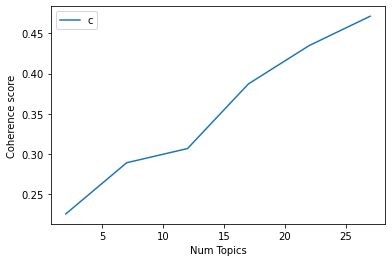

In [57]:
# Plot to see coherence score in order to choose optimal number of topics and decide optimal model
limit=30; start=2; step=5;
x = range(start, limit, step)
plt.plot(x, coherence_values_ph_score2)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [58]:
# Print the coherence scores
index = 0
for m, cv in zip(x, coherence_values_ph_score2):
    print("index:",index,"|","Num Topics =", m, " has Coherence Value of", round(cv, 4))
    index = index + 1

# optimal num_topics = 27

index: 0 | Num Topics = 2  has Coherence Value of 0.2259
index: 1 | Num Topics = 7  has Coherence Value of 0.2894
index: 2 | Num Topics = 12  has Coherence Value of 0.307
index: 3 | Num Topics = 17  has Coherence Value of 0.3872
index: 4 | Num Topics = 22  has Coherence Value of 0.4349
index: 5 | Num Topics = 27  has Coherence Value of 0.4712


In [59]:
# Select optimal number of topics
optimal_model_ph_score2 = model_list_ph_score2[5]

In [60]:
# pyLDAVis
pyLDAvis.enable_notebook()
vis_ph_score2 = pyLDAvis.gensim_models.prepare(optimal_model_ph_score2, corpus_ph_score2, id2word_ph_score2)

In [61]:
print("pyLDAVis for ph topics for score=2:")
vis_ph_score2

pyLDAVis for ph topics for score=2:


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
16    -0.157118  0.007970       1        1  8.529434
8     -0.058350 -0.016785       2        1  8.498775
25    -0.119574 -0.007475       3        1  7.784651
9     -0.129260  0.166323       4        1  7.280038
26    -0.068529 -0.023403       5        1  6.237082
7     -0.103471 -0.081848       6        1  5.962258
5      0.047132  0.142734       7        1  5.584776
20    -0.107526 -0.058069       8        1  5.352101
11    -0.103879 -0.012084       9        1  5.095079
10    -0.101735 -0.051225      10        1  4.856331
4     -0.012257 -0.022985      11        1  4.779110
3      0.035557  0.138633      12        1  3.952585
22    -0.028508  0.100144      13        1  3.524908
13    -0.087599 -0.043108      14        1  3.288777
0      0.138750 -0.067294      15        1  3.066442
18     0.013564 -0.081561      16        1  2.514653
21     0.115039  0.103346      17        1  2.426392
24     0.080214 -0.101739      18        1  2.332807
2      0.030000 -0.004355      19        1  2.181923
15     0.017075  0.039878      20        1  2.000050
23     0.112085  0.082203      21        1  1.336130
17     0.037508 -0.002997      22        1  1.042107
1      0.066957 -0.014230      23        1  1.005368
19     0.064955 -0.088791      24        1  1.005368
14     0.106324 -0.034427      25        1  0.120951
12     0.106324 -0.034427      26        1  0.120951
6      0.106324 -0.034427      27        1  0.120951, topic_info=        Term       Freq      Total Category  logprob  loglift
52   account  44.000000  44.000000  Default  30.0000  30.0000
18       app  62.000000  62.000000  Default  29.0000  29.0000
10     photo  22.000000  22.000000  Default  28.0000  28.0000
54       log  20.000000  20.000000  Default  27.0000  27.0000
109     post  32.000000  32.000000  Default  26.0000  26.0000
..       ...        ...        ...      ...      ...      ...
25    happen   0.004383  13.040141  Topic27  -6.6201  -1.2805
26      keep   0.004383  20.822254  Topic27  -6.6201  -1.7484
27        mb   0.004383   1.500927  Topic27  -6.6201   0.8815
28      much   0.004383   6.650854  Topic27  -6.6201  -0.6072
29     niece   0.004383   1.500927  Topic27  -6.6201   0.8815

[1407 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
359      13  0.462036        acc
359      17  0.462036        acc
582      14  0.690760     accept
353      12  0.346703     access
353      18  0.346703     access
...     ...       ...        ...
405      13  0.333659       year
405      17  0.166830       year
405      23  0.166830       year
515       7  0.655673  zealander
749      10  0.666255       zoom

[1564 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[17, 9, 26, 10, 27, 8, 6, 21, 12, 11, 5, 4, 23, 14, 1, 19, 22, 25, 3, 16, 24, 18, 2, 20, 15, 13, 7])

## LDA Topic Modelling (Rating = 3)

In [62]:
# By-rating Topic Modelling - rating = 3
# Convert to list - move to each section
review_ph_score3 = facebook_ios_ph_review_YearMonth_score3.review.values.tolist()
review_words_ph_score3 = list(sent_to_words(review_ph_score3))
print(review_words_ph_score3[:1])

[['this', 'is', 'my', 'nd', 'time', 'to', 'download', 'this', 'app', 'well', 'uninstalled', 'bcause', 'my', 'facebook', 'app', 'wasnt', 'functioning', 'anymore', 'it', 'doesnt', 'refresh', 'with', 'new', 'stories', 'notifs', 'or', 'anything', 'at', 'all', 'and', 'am', 'sure', 'that', 'have', 'registered', 'to', 'internet', 'promo', 'got', 'mad', 'and', 'uninstalled', 'the', 'app', 'and', 'downloaded', 'facebook', 'lite', 'instead', 'hope', 'this', 'would', 'not', 'happen', 'again', 'tho', 'pls', 'do', 'something']]


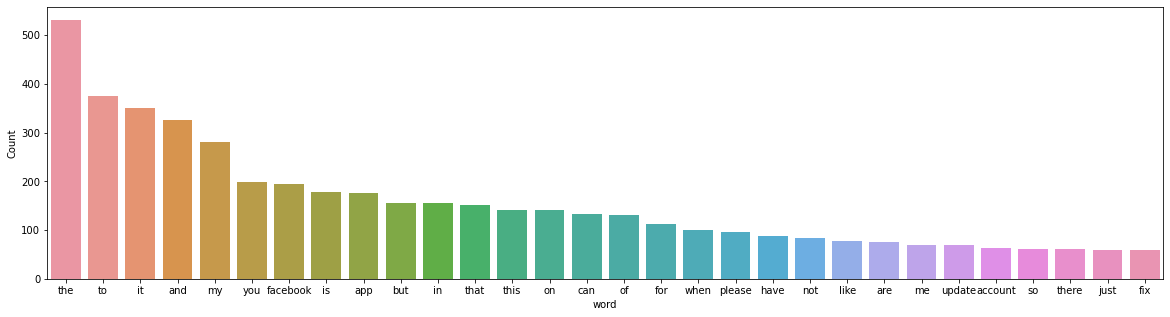

In [63]:
# Inspect the frequency of words before cleaning
freq_words(flatten(review_words_ph_score3))

In [64]:
# Clean text
review_ph_ready_score3 = process_words(review_words_ph_score3)  # processed Text Data! - move to each section


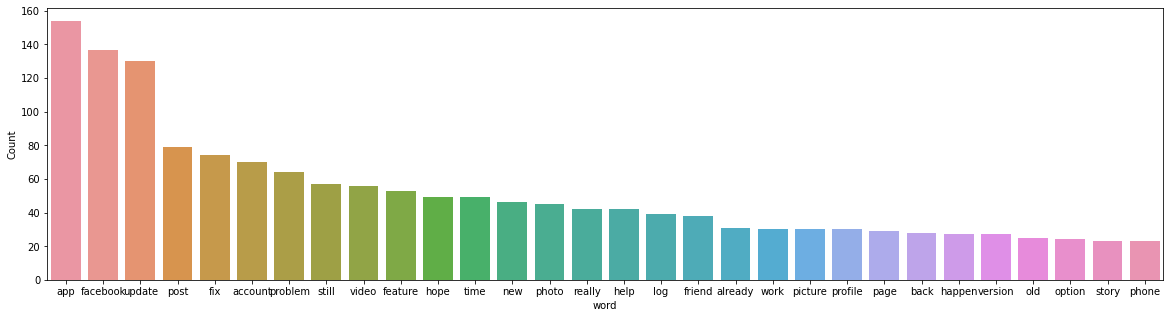

In [65]:
# Inspect the frequency of words after cleaning
freq_words(flatten(review_ph_ready_score3))


In [66]:
# Create Dictionary
id2word_ph_score3 = corpora.Dictionary(review_ph_ready_score3)

2021-10-16 18:36:17,225 [INFO] gensim.corpora.dictionary - adding document #0 to Dictionary(0 unique tokens: [])
2021-10-16 18:36:17,253 [INFO] gensim.corpora.dictionary - built Dictionary(1066 unique tokens: ['anymore', 'app', 'bcause', 'download', 'facebook']...) from 171 documents (total 4652 corpus positions)
2021-10-16 18:36:17,255 [INFO] gensim.utils - Dictionary lifecycle event {'msg': "built Dictionary(1066 unique tokens: ['anymore', 'app', 'bcause', 'download', 'facebook']...) from 171 documents (total 4652 corpus positions)", 'datetime': '2021-10-16T18:36:17.255525', 'gensim': '4.1.2', 'python': '3.8.8 (default, Apr 13 2021, 12:59:45) \n[Clang 10.0.0 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'created'}


In [67]:
# Create Corpus: Term Document Frequency
corpus_ph_score3 = [id2word_ph_score3.doc2bow(text) for text in review_ph_ready_score3]

In [68]:
# Training LDA model
model_list_ph_score3, coherence_values_ph_score3 = compute_coherence_values(dictionary=id2word_ph_score3, corpus=corpus_ph_score3, 
                                                              texts=review_ph_ready_score3, limit=30, start=2, step=5)


2021-10-16 18:36:17,293 [INFO] gensim.models.ldamodel - using symmetric alpha at 0.5
2021-10-16 18:36:17,297 [INFO] gensim.models.ldamodel - using symmetric eta at 0.5
2021-10-16 18:36:17,299 [INFO] gensim.models.ldamodel - using serial LDA version on this node
2021-10-16 18:36:17,302 [INFO] gensim.models.ldamodel - running online (multi-pass) LDA training, 2 topics, 50 passes over the supplied corpus of 171 documents, updating model once every 171 documents, evaluating perplexity every 171 documents, iterating 50x with a convergence threshold of 0.001000
2021-10-16 18:36:18,054 [INFO] gensim.models.ldamodel - -7.532 per-word bound, 185.1 perplexity estimate based on a held-out corpus of 171 documents with 4652 words
2021-10-16 18:36:18,056 [INFO] gensim.models.ldamodel - PROGRESS: pass 0, at document #171/171
2021-10-16 18:36:18,704 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.025*"update" + 0.024*"app" + 0.019*"facebook" + 0.014*"post" + 0.013*"fix" + 0.012*"time" + 0.010*"sti

2021-10-16 18:36:26,666 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.028*"app" + 0.028*"facebook" + 0.022*"update" + 0.021*"account" + 0.015*"post" + 0.014*"feature" + 0.013*"problem" + 0.012*"fix" + 0.011*"log" + 0.011*"still"
2021-10-16 18:36:26,676 [INFO] gensim.models.ldamodel - topic diff=0.013787, rho=0.301511
2021-10-16 18:36:27,185 [INFO] gensim.models.ldamodel - -6.359 per-word bound, 82.1 perplexity estimate based on a held-out corpus of 171 documents with 4652 words
2021-10-16 18:36:27,188 [INFO] gensim.models.ldamodel - PROGRESS: pass 10, at document #171/171
2021-10-16 18:36:27,543 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.025*"app" + 0.024*"update" + 0.019*"facebook" + 0.014*"fix" + 0.012*"post" + 0.011*"video" + 0.011*"time" + 0.009*"page" + 0.009*"still" + 0.009*"problem"
2021-10-16 18:36:27,545 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.028*"app" + 0.028*"facebook" + 0.022*"update" + 0.021*"account" + 0.015*"post" + 0.014*"feature" + 0.013*"pr

2021-10-16 18:36:34,829 [INFO] gensim.models.ldamodel - topic diff=0.003610, rho=0.218218
2021-10-16 18:36:35,257 [INFO] gensim.models.ldamodel - -6.352 per-word bound, 81.7 perplexity estimate based on a held-out corpus of 171 documents with 4652 words
2021-10-16 18:36:35,259 [INFO] gensim.models.ldamodel - PROGRESS: pass 20, at document #171/171
2021-10-16 18:36:35,565 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.026*"app" + 0.024*"update" + 0.018*"facebook" + 0.014*"fix" + 0.014*"video" + 0.011*"post" + 0.011*"time" + 0.009*"problem" + 0.009*"still" + 0.009*"page"
2021-10-16 18:36:35,567 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.028*"facebook" + 0.028*"app" + 0.022*"update" + 0.022*"account" + 0.016*"post" + 0.014*"feature" + 0.013*"problem" + 0.012*"fix" + 0.012*"log" + 0.011*"still"
2021-10-16 18:36:35,571 [INFO] gensim.models.ldamodel - topic diff=0.003337, rho=0.213201
2021-10-16 18:36:35,989 [INFO] gensim.models.ldamodel - -6.352 per-word bound, 81.7 perplexity

2021-10-16 18:36:44,479 [INFO] gensim.models.ldamodel - -6.350 per-word bound, 81.6 perplexity estimate based on a held-out corpus of 171 documents with 4652 words
2021-10-16 18:36:44,481 [INFO] gensim.models.ldamodel - PROGRESS: pass 30, at document #171/171
2021-10-16 18:36:44,818 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.026*"app" + 0.024*"update" + 0.018*"facebook" + 0.015*"video" + 0.014*"fix" + 0.011*"post" + 0.011*"time" + 0.009*"problem" + 0.009*"still" + 0.008*"page"
2021-10-16 18:36:44,821 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.029*"facebook" + 0.028*"app" + 0.022*"update" + 0.022*"account" + 0.016*"post" + 0.015*"feature" + 0.013*"problem" + 0.012*"fix" + 0.012*"log" + 0.011*"still"
2021-10-16 18:36:44,823 [INFO] gensim.models.ldamodel - topic diff=0.002413, rho=0.176777
2021-10-16 18:36:45,240 [INFO] gensim.models.ldamodel - -6.350 per-word bound, 81.6 perplexity estimate based on a held-out corpus of 171 documents with 4652 words
2021-10-16 18:36:45,

2021-10-16 18:36:52,043 [INFO] gensim.models.ldamodel - PROGRESS: pass 40, at document #171/171
2021-10-16 18:36:52,421 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.026*"app" + 0.024*"update" + 0.018*"facebook" + 0.016*"video" + 0.015*"fix" + 0.011*"post" + 0.011*"time" + 0.009*"problem" + 0.009*"still" + 0.008*"page"
2021-10-16 18:36:52,422 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.029*"facebook" + 0.028*"app" + 0.022*"update" + 0.022*"account" + 0.016*"post" + 0.015*"feature" + 0.013*"problem" + 0.012*"log" + 0.012*"fix" + 0.011*"still"
2021-10-16 18:36:52,423 [INFO] gensim.models.ldamodel - topic diff=0.001756, rho=0.154303
2021-10-16 18:36:52,901 [INFO] gensim.models.ldamodel - -6.350 per-word bound, 81.5 perplexity estimate based on a held-out corpus of 171 documents with 4652 words
2021-10-16 18:36:52,907 [INFO] gensim.models.ldamodel - PROGRESS: pass 41, at document #171/171
2021-10-16 18:36:53,194 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.026*"app" + 

2021-10-16 18:36:58,966 [INFO] gensim.topic_coherence.probability_estimation - using ParallelWordOccurrenceAccumulator(processes=7, batch_size=64) to estimate probabilities from sliding windows
2021-10-16 18:37:03,893 [INFO] gensim.topic_coherence.text_analysis - 7 accumulators retrieved from output queue
2021-10-16 18:37:03,966 [INFO] gensim.topic_coherence.text_analysis - accumulated word occurrence stats for 171 virtual documents
2021-10-16 18:37:04,320 [INFO] gensim.models.ldamodel - using symmetric alpha at 0.14285714285714285
2021-10-16 18:37:04,321 [INFO] gensim.models.ldamodel - using symmetric eta at 0.14285714285714285
2021-10-16 18:37:04,324 [INFO] gensim.models.ldamodel - using serial LDA version on this node
2021-10-16 18:37:04,329 [INFO] gensim.models.ldamodel - running online (multi-pass) LDA training, 7 topics, 50 passes over the supplied corpus of 171 documents, updating model once every 171 documents, evaluating perplexity every 171 documents, iterating 50x with a con

2021-10-16 18:37:08,452 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.031*"app" + 0.029*"video" + 0.024*"update" + 0.018*"facebook" + 0.017*"problem" + 0.014*"help" + 0.013*"fix" + 0.013*"profile" + 0.012*"still" + 0.012*"photo"
2021-10-16 18:37:08,454 [INFO] gensim.models.ldamodel - topic diff=0.102268, rho=0.408248
2021-10-16 18:37:08,817 [INFO] gensim.models.ldamodel - -6.583 per-word bound, 95.9 perplexity estimate based on a held-out corpus of 171 documents with 4652 words
2021-10-16 18:37:08,818 [INFO] gensim.models.ldamodel - PROGRESS: pass 5, at document #171/171
2021-10-16 18:37:09,052 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.045*"app" + 0.036*"update" + 0.032*"facebook" + 0.023*"fix" + 0.015*"hope" + 0.014*"video" + 0.014*"post" + 0.013*"help" + 0.013*"account" + 0.013*"really"
2021-10-16 18:37:09,054 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.027*"update" + 0.026*"facebook" + 0.025*"new" + 0.023*"page" + 0.014*"app" + 0.014*"iphone" + 0.013*"really"

2021-10-16 18:37:12,496 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.028*"update" + 0.027*"facebook" + 0.025*"page" + 0.025*"new" + 0.014*"iphone" + 0.014*"app" + 0.013*"really" + 0.013*"bug" + 0.012*"put" + 0.010*"suggestion"
2021-10-16 18:37:12,499 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.033*"feature" + 0.021*"facebook" + 0.020*"post" + 0.020*"add" + 0.014*"friend" + 0.014*"user" + 0.014*"story" + 0.013*"hope" + 0.011*"active" + 0.011*"profile"
2021-10-16 18:37:12,503 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.050*"app" + 0.021*"update" + 0.017*"notification" + 0.016*"tab" + 0.015*"mode" + 0.014*"really" + 0.014*"dark" + 0.012*"back" + 0.010*"time" + 0.010*"post"
2021-10-16 18:37:12,506 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.043*"app" + 0.036*"update" + 0.033*"facebook" + 0.023*"fix" + 0.015*"hope" + 0.015*"video" + 0.014*"post" + 0.013*"help" + 0.013*"account" + 0.012*"time"
2021-10-16 18:37:12,509 [INFO] gensim.models.ldamodel - topic diff=0

2021-10-16 18:37:15,588 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.031*"facebook" + 0.029*"account" + 0.025*"post" + 0.021*"problem" + 0.018*"fix" + 0.017*"update" + 0.016*"app" + 0.015*"log" + 0.014*"still" + 0.013*"photo"
2021-10-16 18:37:15,590 [INFO] gensim.models.ldamodel - topic diff=0.007272, rho=0.242536
2021-10-16 18:37:15,926 [INFO] gensim.models.ldamodel - -6.552 per-word bound, 93.8 perplexity estimate based on a held-out corpus of 171 documents with 4652 words
2021-10-16 18:37:15,927 [INFO] gensim.models.ldamodel - PROGRESS: pass 16, at document #171/171
2021-10-16 18:37:16,100 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.034*"video" + 0.032*"app" + 0.026*"update" + 0.019*"facebook" + 0.018*"problem" + 0.014*"help" + 0.014*"fix" + 0.014*"still" + 0.013*"profile" + 0.012*"photo"
2021-10-16 18:37:16,102 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.031*"facebook" + 0.029*"account" + 0.025*"post" + 0.021*"problem" + 0.018*"fix" + 0.017*"update" + 0.016*"

2021-10-16 18:37:18,921 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.028*"update" + 0.027*"facebook" + 0.026*"page" + 0.025*"new" + 0.015*"iphone" + 0.014*"really" + 0.013*"bug" + 0.013*"app" + 0.012*"put" + 0.010*"suggestion"
2021-10-16 18:37:18,922 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.031*"facebook" + 0.030*"account" + 0.025*"post" + 0.021*"problem" + 0.018*"fix" + 0.017*"update" + 0.017*"app" + 0.015*"log" + 0.014*"still" + 0.013*"photo"
2021-10-16 18:37:18,923 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.051*"app" + 0.022*"update" + 0.016*"tab" + 0.016*"really" + 0.016*"mode" + 0.016*"notification" + 0.015*"dark" + 0.012*"back" + 0.010*"post" + 0.010*"time"
2021-10-16 18:37:18,925 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.033*"feature" + 0.022*"facebook" + 0.021*"post" + 0.020*"add" + 0.015*"friend" + 0.014*"user" + 0.014*"story" + 0.013*"hope" + 0.012*"active" + 0.011*"profile"
2021-10-16 18:37:18,926 [INFO] gensim.models.ldamodel - topic dif

2021-10-16 18:37:21,685 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.033*"feature" + 0.022*"facebook" + 0.021*"post" + 0.020*"add" + 0.015*"friend" + 0.014*"user" + 0.014*"story" + 0.013*"hope" + 0.012*"active" + 0.011*"profile"
2021-10-16 18:37:21,687 [INFO] gensim.models.ldamodel - topic diff=0.001852, rho=0.188982
2021-10-16 18:37:21,888 [INFO] gensim.models.ldamodel - -6.548 per-word bound, 93.6 perplexity estimate based on a held-out corpus of 171 documents with 4652 words
2021-10-16 18:37:21,889 [INFO] gensim.models.ldamodel - PROGRESS: pass 27, at document #171/171
2021-10-16 18:37:22,181 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.052*"app" + 0.022*"update" + 0.016*"tab" + 0.016*"really" + 0.016*"mode" + 0.016*"notification" + 0.015*"dark" + 0.013*"back" + 0.010*"post" + 0.010*"time"
2021-10-16 18:37:22,183 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.031*"facebook" + 0.030*"account" + 0.025*"post" + 0.021*"problem" + 0.018*"fix" + 0.017*"update" + 0.017*"

2021-10-16 18:37:25,594 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.023*"view" + 0.021*"picture" + 0.018*"time" + 0.014*"happen" + 0.014*"app" + 0.013*"option" + 0.012*"video" + 0.011*"hope" + 0.010*"update" + 0.010*"share"
2021-10-16 18:37:25,595 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.042*"app" + 0.035*"update" + 0.033*"facebook" + 0.023*"fix" + 0.016*"hope" + 0.015*"video" + 0.014*"post" + 0.013*"help" + 0.013*"account" + 0.012*"time"
2021-10-16 18:37:25,597 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.052*"app" + 0.022*"update" + 0.016*"tab" + 0.016*"really" + 0.016*"mode" + 0.016*"notification" + 0.015*"dark" + 0.013*"back" + 0.011*"post" + 0.010*"people"
2021-10-16 18:37:25,598 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.031*"facebook" + 0.030*"account" + 0.025*"post" + 0.021*"problem" + 0.018*"fix" + 0.017*"update" + 0.017*"app" + 0.015*"log" + 0.014*"still" + 0.013*"photo"
2021-10-16 18:37:25,599 [INFO] gensim.models.ldamodel - topic diff=0.00

2021-10-16 18:37:28,480 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.037*"video" + 0.032*"app" + 0.026*"update" + 0.019*"facebook" + 0.018*"problem" + 0.014*"still" + 0.014*"help" + 0.014*"fix" + 0.013*"iphone" + 0.013*"profile"
2021-10-16 18:37:28,483 [INFO] gensim.models.ldamodel - topic diff=0.000744, rho=0.160128
2021-10-16 18:37:28,823 [INFO] gensim.models.ldamodel - -6.546 per-word bound, 93.5 perplexity estimate based on a held-out corpus of 171 documents with 4652 words
2021-10-16 18:37:28,825 [INFO] gensim.models.ldamodel - PROGRESS: pass 38, at document #171/171
2021-10-16 18:37:29,056 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.052*"app" + 0.022*"update" + 0.016*"really" + 0.016*"tab" + 0.016*"mode" + 0.016*"notification" + 0.015*"dark" + 0.013*"back" + 0.011*"post" + 0.010*"people"
2021-10-16 18:37:29,058 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.042*"app" + 0.035*"update" + 0.033*"facebook" + 0.022*"fix" + 0.016*"hope" + 0.015*"video" + 0.014*"post

2021-10-16 18:37:31,690 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.023*"view" + 0.021*"picture" + 0.018*"time" + 0.014*"happen" + 0.014*"app" + 0.013*"option" + 0.012*"video" + 0.011*"hope" + 0.010*"update" + 0.010*"share"
2021-10-16 18:37:31,696 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.033*"feature" + 0.022*"facebook" + 0.021*"post" + 0.020*"add" + 0.015*"friend" + 0.014*"user" + 0.014*"story" + 0.013*"hope" + 0.013*"active" + 0.011*"profile"
2021-10-16 18:37:31,699 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.042*"app" + 0.035*"update" + 0.033*"facebook" + 0.022*"fix" + 0.016*"hope" + 0.015*"video" + 0.013*"post" + 0.013*"help" + 0.013*"account" + 0.012*"time"
2021-10-16 18:37:31,702 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.031*"facebook" + 0.030*"account" + 0.025*"post" + 0.021*"problem" + 0.018*"fix" + 0.017*"update" + 0.017*"app" + 0.015*"log" + 0.014*"still" + 0.013*"photo"
2021-10-16 18:37:31,705 [INFO] gensim.models.ldamodel - topic diff=0.

2021-10-16 18:37:34,548 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.031*"facebook" + 0.030*"account" + 0.025*"post" + 0.021*"problem" + 0.018*"fix" + 0.017*"update" + 0.017*"app" + 0.015*"log" + 0.014*"still" + 0.013*"photo"
2021-10-16 18:37:34,551 [INFO] gensim.models.ldamodel - topic diff=0.000364, rho=0.141421
2021-10-16 18:37:34,848 [INFO] gensim.models.ldamodel - -6.546 per-word bound, 93.4 perplexity estimate based on a held-out corpus of 171 documents with 4652 words
2021-10-16 18:37:34,850 [INFO] gensim.models.ldamodel - PROGRESS: pass 49, at document #171/171
2021-10-16 18:37:35,091 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.029*"update" + 0.027*"facebook" + 0.026*"page" + 0.025*"new" + 0.015*"iphone" + 0.014*"really" + 0.013*"bug" + 0.013*"app" + 0.012*"put" + 0.010*"suggestion"
2021-10-16 18:37:35,093 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.037*"video" + 0.032*"app" + 0.026*"update" + 0.019*"facebook" + 0.018*"problem" + 0.014*"still" + 0.014*"he

2021-10-16 18:37:45,439 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.042*"account" + 0.031*"facebook" + 0.021*"update" + 0.021*"app" + 0.021*"post" + 0.020*"log" + 0.020*"fix" + 0.016*"feature" + 0.015*"help" + 0.014*"new"
2021-10-16 18:37:45,440 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.038*"video" + 0.029*"fix" + 0.028*"post" + 0.020*"facebook" + 0.018*"back" + 0.018*"old" + 0.017*"game" + 0.014*"app" + 0.014*"hope" + 0.014*"play"
2021-10-16 18:37:45,442 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.032*"fb" + 0.023*"account" + 0.020*"new" + 0.017*"hope" + 0.015*"action" + 0.014*"original" + 0.012*"still" + 0.010*"file" + 0.010*"problem" + 0.010*"work"
2021-10-16 18:37:45,443 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.047*"feature" + 0.023*"facebook" + 0.021*"story" + 0.018*"post" + 0.018*"friend" + 0.016*"app" + 0.016*"user" + 0.015*"add" + 0.013*"account" + 0.013*"love"
2021-10-16 18:37:45,444 [INFO] gensim.models.ldamodel - topic diff=0.168429, rh

2021-10-16 18:37:48,310 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.037*"app" + 0.029*"video" + 0.021*"bug" + 0.017*"update" + 0.017*"facebook" + 0.016*"feature" + 0.016*"iphone" + 0.015*"still" + 0.015*"help" + 0.015*"upload"
2021-10-16 18:37:48,312 [INFO] gensim.models.ldamodel - topic diff=0.039033, rho=0.316228
2021-10-16 18:37:48,603 [INFO] gensim.models.ldamodel - -6.650 per-word bound, 100.4 perplexity estimate based on a held-out corpus of 171 documents with 4652 words
2021-10-16 18:37:48,623 [INFO] gensim.models.ldamodel - PROGRESS: pass 9, at document #171/171
2021-10-16 18:37:48,809 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.049*"feature" + 0.023*"story" + 0.022*"facebook" + 0.019*"friend" + 0.019*"post" + 0.016*"app" + 0.016*"user" + 0.014*"request" + 0.014*"account" + 0.013*"option"
2021-10-16 18:37:48,811 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.071*"app" + 0.035*"problem" + 0.021*"update" + 0.020*"mode" + 0.020*"dark" + 0.018*"search" + 0.016*

2021-10-16 18:37:51,442 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.045*"account" + 0.032*"facebook" + 0.024*"log" + 0.023*"update" + 0.021*"post" + 0.021*"app" + 0.021*"fix" + 0.016*"help" + 0.015*"feature" + 0.014*"still"
2021-10-16 18:37:51,445 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.033*"fb" + 0.027*"account" + 0.023*"new" + 0.020*"hope" + 0.018*"action" + 0.014*"original" + 0.011*"still" + 0.010*"file" + 0.010*"problem" + 0.010*"work"
2021-10-16 18:37:51,446 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.049*"app" + 0.040*"facebook" + 0.039*"update" + 0.021*"fix" + 0.019*"post" + 0.018*"problem" + 0.016*"really" + 0.015*"hope" + 0.014*"time" + 0.013*"video"
2021-10-16 18:37:51,448 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.039*"video" + 0.027*"fix" + 0.026*"post" + 0.021*"facebook" + 0.021*"back" + 0.020*"old" + 0.018*"game" + 0.015*"play" + 0.014*"hope" + 0.014*"app"
2021-10-16 18:37:51,450 [INFO] gensim.models.ldamodel - topic diff=0.008887, r

2021-10-16 18:37:54,115 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.039*"video" + 0.027*"fix" + 0.026*"post" + 0.021*"facebook" + 0.021*"back" + 0.020*"old" + 0.018*"game" + 0.015*"play" + 0.014*"hope" + 0.014*"photo"
2021-10-16 18:37:54,119 [INFO] gensim.models.ldamodel - topic diff=0.003379, rho=0.218218
2021-10-16 18:37:54,381 [INFO] gensim.models.ldamodel - -6.640 per-word bound, 99.7 perplexity estimate based on a held-out corpus of 171 documents with 4652 words
2021-10-16 18:37:54,384 [INFO] gensim.models.ldamodel - PROGRESS: pass 20, at document #171/171
2021-10-16 18:37:54,531 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.049*"app" + 0.040*"facebook" + 0.039*"update" + 0.022*"fix" + 0.019*"post" + 0.018*"problem" + 0.016*"really" + 0.015*"hope" + 0.015*"time" + 0.013*"video"
2021-10-16 18:37:54,534 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.039*"video" + 0.027*"fix" + 0.026*"post" + 0.021*"facebook" + 0.021*"back" + 0.020*"old" + 0.018*"game" + 0.015*"p

2021-10-16 18:37:57,135 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.036*"app" + 0.031*"video" + 0.021*"bug" + 0.017*"update" + 0.017*"upload" + 0.016*"facebook" + 0.016*"feature" + 0.016*"iphone" + 0.016*"still" + 0.015*"help"
2021-10-16 18:37:57,138 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.049*"feature" + 0.023*"story" + 0.022*"facebook" + 0.019*"friend" + 0.019*"post" + 0.016*"app" + 0.016*"user" + 0.015*"option" + 0.014*"request" + 0.014*"account"
2021-10-16 18:37:57,142 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.039*"video" + 0.027*"fix" + 0.026*"post" + 0.021*"facebook" + 0.021*"back" + 0.020*"old" + 0.018*"game" + 0.015*"photo" + 0.015*"play" + 0.014*"hope"
2021-10-16 18:37:57,144 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.035*"fb" + 0.027*"account" + 0.023*"new" + 0.020*"hope" + 0.018*"action" + 0.014*"original" + 0.011*"still" + 0.010*"file" + 0.010*"problem" + 0.010*"work"
2021-10-16 18:37:57,146 [INFO] gensim.models.ldamodel - topic diff

2021-10-16 18:37:59,699 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.024*"update" + 0.023*"app" + 0.019*"facebook" + 0.018*"time" + 0.014*"problem" + 0.014*"post" + 0.014*"notification" + 0.013*"friend" + 0.012*"fix" + 0.011*"happen"
2021-10-16 18:37:59,701 [INFO] gensim.models.ldamodel - topic diff=0.001053, rho=0.176777
2021-10-16 18:38:00,069 [INFO] gensim.models.ldamodel - -6.638 per-word bound, 99.6 perplexity estimate based on a held-out corpus of 171 documents with 4652 words
2021-10-16 18:38:00,070 [INFO] gensim.models.ldamodel - PROGRESS: pass 31, at document #171/171
2021-10-16 18:38:00,257 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.048*"account" + 0.033*"facebook" + 0.030*"log" + 0.024*"update" + 0.021*"app" + 0.021*"fix" + 0.021*"post" + 0.017*"feature" + 0.016*"help" + 0.016*"new"
2021-10-16 18:38:00,268 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.047*"update" + 0.036*"facebook" + 0.029*"new" + 0.021*"app" + 0.018*"iphone" + 0.016*"suggestion" + 0.0

2021-10-16 18:38:02,952 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.047*"update" + 0.036*"facebook" + 0.029*"new" + 0.021*"app" + 0.018*"iphone" + 0.016*"suggestion" + 0.015*"page" + 0.014*"put" + 0.011*"hope" + 0.011*"still"
2021-10-16 18:38:02,954 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.048*"account" + 0.033*"facebook" + 0.031*"log" + 0.024*"update" + 0.021*"app" + 0.021*"fix" + 0.021*"post" + 0.017*"feature" + 0.016*"help" + 0.016*"new"
2021-10-16 18:38:02,958 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.040*"fb" + 0.027*"account" + 0.025*"new" + 0.020*"hope" + 0.017*"action" + 0.014*"original" + 0.011*"still" + 0.010*"happen" + 0.010*"file" + 0.010*"problem"
2021-10-16 18:38:02,960 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.036*"app" + 0.031*"video" + 0.022*"bug" + 0.017*"update" + 0.017*"upload" + 0.016*"facebook" + 0.016*"iphone" + 0.016*"feature" + 0.016*"still" + 0.015*"help"
2021-10-16 18:38:02,963 [INFO] gensim.models.ldamodel - topic #7 (

2021-10-16 18:38:05,571 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.024*"update" + 0.023*"app" + 0.019*"facebook" + 0.018*"time" + 0.014*"problem" + 0.014*"notification" + 0.014*"post" + 0.013*"friend" + 0.011*"fix" + 0.011*"really"
2021-10-16 18:38:05,575 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.036*"app" + 0.032*"video" + 0.022*"bug" + 0.017*"update" + 0.017*"upload" + 0.016*"iphone" + 0.016*"facebook" + 0.015*"feature" + 0.015*"still" + 0.015*"help"
2021-10-16 18:38:05,577 [INFO] gensim.models.ldamodel - topic diff=0.000756, rho=0.152499
2021-10-16 18:38:05,833 [INFO] gensim.models.ldamodel - -6.637 per-word bound, 99.5 perplexity estimate based on a held-out corpus of 171 documents with 4652 words
2021-10-16 18:38:05,835 [INFO] gensim.models.ldamodel - PROGRESS: pass 42, at document #171/171
2021-10-16 18:38:06,089 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.038*"video" + 0.026*"post" + 0.026*"fix" + 0.021*"facebook" + 0.021*"back" + 0.021*"old" + 0.018*

2021-10-16 18:38:08,536 [INFO] gensim.models.ldamodel - PROGRESS: pass 47, at document #171/171
2021-10-16 18:38:08,757 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.036*"app" + 0.032*"video" + 0.022*"bug" + 0.017*"update" + 0.017*"upload" + 0.016*"iphone" + 0.015*"facebook" + 0.015*"feature" + 0.015*"still" + 0.015*"problem"
2021-10-16 18:38:08,772 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.042*"fb" + 0.027*"account" + 0.025*"new" + 0.020*"hope" + 0.017*"action" + 0.014*"original" + 0.011*"still" + 0.010*"happen" + 0.010*"click" + 0.010*"problem"
2021-10-16 18:38:08,778 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.021*"app" + 0.017*"highlight" + 0.017*"fast" + 0.016*"check" + 0.013*"datum" + 0.013*"story" + 0.013*"people" + 0.012*"post" + 0.012*"still" + 0.010*"help"
2021-10-16 18:38:08,784 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.037*"video" + 0.026*"post" + 0.026*"fix" + 0.021*"facebook" + 0.021*"back" + 0.021*"old" + 0.018*"game" + 0.016*"photo" +

2021-10-16 18:38:20,132 [INFO] gensim.models.ldamodel - topic #4 (0.059): 0.036*"app" + 0.029*"feature" + 0.021*"work" + 0.020*"bug" + 0.018*"iphone" + 0.016*"page" + 0.014*"notification" + 0.013*"version" + 0.012*"help" + 0.012*"file"
2021-10-16 18:38:20,135 [INFO] gensim.models.ldamodel - topic #14 (0.059): 0.025*"picture" + 0.024*"view" + 0.022*"update" + 0.020*"happen" + 0.019*"feature" + 0.018*"story" + 0.018*"time" + 0.018*"save" + 0.014*"facebook" + 0.013*"look"
2021-10-16 18:38:20,138 [INFO] gensim.models.ldamodel - topic diff=0.272858, rho=0.577350
2021-10-16 18:38:20,370 [INFO] gensim.models.ldamodel - -6.916 per-word bound, 120.8 perplexity estimate based on a held-out corpus of 171 documents with 4652 words
2021-10-16 18:38:20,371 [INFO] gensim.models.ldamodel - PROGRESS: pass 2, at document #171/171
2021-10-16 18:38:20,581 [INFO] gensim.models.ldamodel - topic #7 (0.059): 0.029*"update" + 0.028*"facebook" + 0.024*"app" + 0.022*"time" + 0.019*"problem" + 0.015*"post" + 0.01

2021-10-16 18:38:22,930 [INFO] gensim.models.ldamodel - PROGRESS: pass 7, at document #171/171
2021-10-16 18:38:23,083 [INFO] gensim.models.ldamodel - topic #8 (0.059): 0.074*"photo" + 0.040*"album" + 0.030*"post" + 0.030*"view" + 0.023*"regard" + 0.015*"facebook" + 0.015*"hope" + 0.015*"filter" + 0.015*"mental" + 0.015*"previous"
2021-10-16 18:38:23,086 [INFO] gensim.models.ldamodel - topic #2 (0.059): 0.071*"account" + 0.036*"facebook" + 0.020*"post" + 0.019*"update" + 0.017*"log" + 0.016*"still" + 0.015*"fix" + 0.014*"new" + 0.014*"ask" + 0.012*"app"
2021-10-16 18:38:23,091 [INFO] gensim.models.ldamodel - topic #10 (0.059): 0.029*"date" + 0.024*"profile" + 0.021*"hope" + 0.018*"app" + 0.018*"account" + 0.018*"new" + 0.018*"copy" + 0.018*"way" + 0.012*"feature" + 0.012*"suggest"
2021-10-16 18:38:23,095 [INFO] gensim.models.ldamodel - topic #11 (0.059): 0.034*"post" + 0.032*"game" + 0.027*"back" + 0.023*"video" + 0.022*"problem" + 0.018*"facebook" + 0.016*"hope" + 0.016*"fix" + 0.016*

2021-10-16 18:38:25,628 [INFO] gensim.models.ldamodel - topic #6 (0.059): 0.021*"video" + 0.021*"download" + 0.021*"hope" + 0.014*"view" + 0.014*"uninstalled" + 0.014*"app" + 0.014*"sure" + 0.014*"play" + 0.014*"show" + 0.014*"fix"
2021-10-16 18:38:25,635 [INFO] gensim.models.ldamodel - topic #12 (0.059): 0.033*"friend" + 0.022*"app" + 0.021*"people" + 0.020*"search" + 0.017*"active" + 0.016*"icon" + 0.013*"add" + 0.013*"group" + 0.013*"chat" + 0.013*"status"
2021-10-16 18:38:25,648 [INFO] gensim.models.ldamodel - topic diff=0.016355, rho=0.267261
2021-10-16 18:38:25,950 [INFO] gensim.models.ldamodel - -6.707 per-word bound, 104.5 perplexity estimate based on a held-out corpus of 171 documents with 4652 words
2021-10-16 18:38:25,953 [INFO] gensim.models.ldamodel - PROGRESS: pass 13, at document #171/171
2021-10-16 18:38:26,182 [INFO] gensim.models.ldamodel - topic #14 (0.059): 0.030*"picture" + 0.028*"view" + 0.022*"update" + 0.021*"happen" + 0.019*"feature" + 0.019*"story" + 0.017*"ti

2021-10-16 18:38:28,806 [INFO] gensim.models.ldamodel - PROGRESS: pass 18, at document #171/171
2021-10-16 18:38:28,947 [INFO] gensim.models.ldamodel - topic #16 (0.059): 0.051*"app" + 0.030*"problem" + 0.029*"fix" + 0.027*"update" + 0.023*"log" + 0.021*"facebook" + 0.021*"video" + 0.016*"time" + 0.015*"account" + 0.015*"post"
2021-10-16 18:38:28,956 [INFO] gensim.models.ldamodel - topic #6 (0.059): 0.021*"video" + 0.021*"download" + 0.021*"hope" + 0.014*"view" + 0.014*"uninstalled" + 0.014*"app" + 0.014*"sure" + 0.014*"play" + 0.014*"fix" + 0.014*"show"
2021-10-16 18:38:28,976 [INFO] gensim.models.ldamodel - topic #7 (0.059): 0.029*"update" + 0.027*"facebook" + 0.025*"app" + 0.024*"time" + 0.019*"problem" + 0.016*"friend" + 0.015*"post" + 0.015*"notification" + 0.013*"hope" + 0.013*"fix"
2021-10-16 18:38:28,980 [INFO] gensim.models.ldamodel - topic #13 (0.059): 0.028*"share" + 0.023*"update" + 0.023*"option" + 0.017*"care" + 0.017*"emoji" + 0.017*"item" + 0.013*"fix" + 0.012*"still" +

2021-10-16 18:38:31,495 [INFO] gensim.models.ldamodel - topic #11 (0.059): 0.034*"post" + 0.032*"game" + 0.028*"back" + 0.023*"video" + 0.023*"problem" + 0.019*"old" + 0.018*"facebook" + 0.017*"hope" + 0.016*"fix" + 0.015*"app"
2021-10-16 18:38:31,497 [INFO] gensim.models.ldamodel - topic #16 (0.059): 0.051*"app" + 0.030*"problem" + 0.029*"fix" + 0.027*"update" + 0.023*"log" + 0.022*"facebook" + 0.021*"video" + 0.016*"time" + 0.015*"still" + 0.015*"post"
2021-10-16 18:38:31,500 [INFO] gensim.models.ldamodel - topic diff=0.002860, rho=0.200000
2021-10-16 18:38:31,769 [INFO] gensim.models.ldamodel - -6.698 per-word bound, 103.8 perplexity estimate based on a held-out corpus of 171 documents with 4652 words
2021-10-16 18:38:31,773 [INFO] gensim.models.ldamodel - PROGRESS: pass 24, at document #171/171
2021-10-16 18:38:31,947 [INFO] gensim.models.ldamodel - topic #3 (0.059): 0.052*"app" + 0.046*"facebook" + 0.045*"update" + 0.018*"fix" + 0.016*"help" + 0.015*"account" + 0.014*"post" + 0.01

2021-10-16 18:38:34,164 [INFO] gensim.models.ldamodel - PROGRESS: pass 29, at document #171/171
2021-10-16 18:38:34,357 [INFO] gensim.models.ldamodel - topic #8 (0.059): 0.074*"photo" + 0.042*"album" + 0.030*"post" + 0.030*"view" + 0.023*"regard" + 0.015*"facebook" + 0.015*"hope" + 0.015*"filter" + 0.015*"mental" + 0.015*"actual"
2021-10-16 18:38:34,365 [INFO] gensim.models.ldamodel - topic #1 (0.059): 0.044*"video" + 0.032*"app" + 0.030*"mode" + 0.024*"dark" + 0.019*"really" + 0.019*"update" + 0.016*"watch" + 0.015*"datum" + 0.012*"feature" + 0.012*"upload"
2021-10-16 18:38:34,371 [INFO] gensim.models.ldamodel - topic #6 (0.059): 0.021*"video" + 0.021*"download" + 0.021*"hope" + 0.014*"view" + 0.014*"uninstalled" + 0.014*"app" + 0.014*"fix" + 0.014*"play" + 0.014*"show" + 0.014*"sure"
2021-10-16 18:38:34,378 [INFO] gensim.models.ldamodel - topic #15 (0.059): 0.039*"post" + 0.035*"photo" + 0.031*"feature" + 0.025*"fix" + 0.022*"well" + 0.018*"scroll" + 0.018*"thing" + 0.018*"look" + 0.

2021-10-16 18:38:36,680 [INFO] gensim.models.ldamodel - topic #2 (0.059): 0.074*"account" + 0.037*"facebook" + 0.025*"post" + 0.022*"log" + 0.018*"still" + 0.015*"ask" + 0.015*"update" + 0.015*"fb" + 0.014*"fix" + 0.014*"work"
2021-10-16 18:38:36,682 [INFO] gensim.models.ldamodel - topic #4 (0.059): 0.039*"app" + 0.028*"feature" + 0.022*"work" + 0.022*"bug" + 0.017*"iphone" + 0.017*"page" + 0.017*"notification" + 0.011*"version" + 0.011*"help" + 0.011*"file"
2021-10-16 18:38:36,685 [INFO] gensim.models.ldamodel - topic diff=0.001026, rho=0.166667
2021-10-16 18:38:37,048 [INFO] gensim.models.ldamodel - -6.694 per-word bound, 103.5 perplexity estimate based on a held-out corpus of 171 documents with 4652 words
2021-10-16 18:38:37,049 [INFO] gensim.models.ldamodel - PROGRESS: pass 35, at document #171/171
2021-10-16 18:38:37,156 [INFO] gensim.models.ldamodel - topic #13 (0.059): 0.028*"share" + 0.023*"update" + 0.023*"option" + 0.017*"emoji" + 0.017*"care" + 0.017*"item" + 0.013*"fix" + 0

2021-10-16 18:38:39,492 [INFO] gensim.models.ldamodel - PROGRESS: pass 40, at document #171/171
2021-10-16 18:38:39,606 [INFO] gensim.models.ldamodel - topic #0 (0.059): 0.045*"update" + 0.036*"facebook" + 0.032*"new" + 0.024*"page" + 0.018*"app" + 0.016*"suggestion" + 0.016*"put" + 0.013*"people" + 0.013*"photo" + 0.011*"hope"
2021-10-16 18:38:39,613 [INFO] gensim.models.ldamodel - topic #8 (0.059): 0.074*"photo" + 0.042*"album" + 0.030*"post" + 0.030*"view" + 0.023*"regard" + 0.015*"facebook" + 0.015*"hope" + 0.015*"filter" + 0.015*"mental" + 0.015*"actual"
2021-10-16 18:38:39,615 [INFO] gensim.models.ldamodel - topic #6 (0.059): 0.021*"video" + 0.021*"download" + 0.021*"hope" + 0.014*"view" + 0.014*"uninstalled" + 0.014*"app" + 0.014*"sure" + 0.014*"play" + 0.014*"fix" + 0.014*"happen"
2021-10-16 18:38:39,618 [INFO] gensim.models.ldamodel - topic #5 (0.059): 0.045*"feature" + 0.031*"add" + 0.031*"profile" + 0.027*"post" + 0.026*"facebook" + 0.022*"story" + 0.020*"photo" + 0.017*"hig

2021-10-16 18:38:42,050 [INFO] gensim.models.ldamodel - topic #11 (0.059): 0.035*"post" + 0.033*"game" + 0.028*"back" + 0.023*"video" + 0.023*"problem" + 0.020*"old" + 0.018*"facebook" + 0.017*"hope" + 0.016*"fix" + 0.015*"app"
2021-10-16 18:38:42,053 [INFO] gensim.models.ldamodel - topic #15 (0.059): 0.039*"post" + 0.035*"photo" + 0.031*"feature" + 0.025*"fix" + 0.022*"well" + 0.018*"scroll" + 0.018*"thing" + 0.017*"look" + 0.017*"timeline" + 0.017*"put"
2021-10-16 18:38:42,055 [INFO] gensim.models.ldamodel - topic diff=0.000396, rho=0.145865
2021-10-16 18:38:42,324 [INFO] gensim.models.ldamodel - -6.693 per-word bound, 103.5 perplexity estimate based on a held-out corpus of 171 documents with 4652 words
2021-10-16 18:38:42,325 [INFO] gensim.models.ldamodel - PROGRESS: pass 46, at document #171/171
2021-10-16 18:38:42,451 [INFO] gensim.models.ldamodel - topic #10 (0.059): 0.030*"date" + 0.024*"profile" + 0.021*"hope" + 0.019*"app" + 0.018*"new" + 0.018*"account" + 0.018*"way" + 0.018*

2021-10-16 18:38:52,682 [INFO] gensim.models.ldamodel - PROGRESS: pass 0, at document #171/171
2021-10-16 18:38:53,266 [INFO] gensim.models.ldamodel - topic #2 (0.045): 0.033*"facebook" + 0.029*"account" + 0.023*"update" + 0.023*"photo" + 0.021*"feature" + 0.018*"post" + 0.018*"video" + 0.018*"fix" + 0.015*"app" + 0.012*"picture"
2021-10-16 18:38:53,285 [INFO] gensim.models.ldamodel - topic #3 (0.045): 0.054*"app" + 0.040*"facebook" + 0.034*"update" + 0.020*"help" + 0.019*"fix" + 0.016*"problem" + 0.016*"post" + 0.014*"time" + 0.014*"account" + 0.013*"still"
2021-10-16 18:38:53,299 [INFO] gensim.models.ldamodel - topic #12 (0.045): 0.027*"account" + 0.024*"friend" + 0.023*"people" + 0.020*"app" + 0.017*"access" + 0.012*"group" + 0.012*"turn" + 0.011*"facebook" + 0.011*"posting" + 0.011*"buy"
2021-10-16 18:38:53,301 [INFO] gensim.models.ldamodel - topic #7 (0.045): 0.032*"facebook" + 0.025*"time" + 0.025*"update" + 0.022*"app" + 0.017*"really" + 0.016*"account" + 0.016*"fix" + 0.015*"no

2021-10-16 18:38:55,800 [INFO] gensim.models.ldamodel - topic #11 (0.045): 0.056*"post" + 0.042*"fix" + 0.026*"update" + 0.023*"video" + 0.018*"hope" + 0.018*"layout" + 0.015*"option" + 0.015*"app" + 0.015*"problem" + 0.014*"facebook"
2021-10-16 18:38:55,803 [INFO] gensim.models.ldamodel - topic #19 (0.045): 0.055*"video" + 0.023*"location" + 0.023*"automatically" + 0.023*"recognize" + 0.023*"play" + 0.022*"hear" + 0.022*"back" + 0.012*"hope" + 0.012*"choose" + 0.012*"tag"
2021-10-16 18:38:55,804 [INFO] gensim.models.ldamodel - topic #5 (0.045): 0.077*"feature" + 0.034*"add" + 0.021*"story" + 0.021*"post" + 0.020*"facebook" + 0.020*"page" + 0.020*"photo" + 0.018*"turn" + 0.018*"group" + 0.018*"select"
2021-10-16 18:38:55,806 [INFO] gensim.models.ldamodel - topic diff=0.120859, rho=0.377964
2021-10-16 18:38:56,059 [INFO] gensim.models.ldamodel - -6.827 per-word bound, 113.6 perplexity estimate based on a held-out corpus of 171 documents with 4652 words
2021-10-16 18:38:56,061 [INFO] gen

2021-10-16 18:38:58,311 [INFO] gensim.models.ldamodel - topic diff=0.030194, rho=0.288675
2021-10-16 18:38:58,596 [INFO] gensim.models.ldamodel - -6.795 per-word bound, 111.1 perplexity estimate based on a held-out corpus of 171 documents with 4652 words
2021-10-16 18:38:58,600 [INFO] gensim.models.ldamodel - PROGRESS: pass 11, at document #171/171
2021-10-16 18:38:58,801 [INFO] gensim.models.ldamodel - topic #10 (0.045): 0.026*"way" + 0.026*"really" + 0.026*"file" + 0.026*"send" + 0.026*"photo" + 0.013*"hope" + 0.013*"upload" + 0.013*"date" + 0.013*"often" + 0.013*"back"
2021-10-16 18:38:58,802 [INFO] gensim.models.ldamodel - topic #12 (0.045): 0.029*"account" + 0.023*"friend" + 0.023*"people" + 0.018*"app" + 0.018*"access" + 0.012*"group" + 0.012*"turn" + 0.012*"facebook" + 0.012*"accept" + 0.012*"log"
2021-10-16 18:38:58,803 [INFO] gensim.models.ldamodel - topic #6 (0.045): 0.039*"photo" + 0.020*"app" + 0.020*"camera" + 0.020*"download" + 0.020*"uninstalled" + 0.020*"upload" + 0.020

2021-10-16 18:39:01,187 [INFO] gensim.models.ldamodel - topic #16 (0.045): 0.044*"app" + 0.030*"log" + 0.028*"account" + 0.028*"facebook" + 0.025*"problem" + 0.021*"post" + 0.020*"update" + 0.020*"fix" + 0.018*"new" + 0.013*"still"
2021-10-16 18:39:01,191 [INFO] gensim.models.ldamodel - topic #1 (0.045): 0.040*"work" + 0.028*"feature" + 0.023*"help" + 0.021*"app" + 0.019*"update" + 0.017*"really" + 0.017*"new" + 0.017*"fb" + 0.017*"photo" + 0.017*"mobile"
2021-10-16 18:39:01,194 [INFO] gensim.models.ldamodel - topic #7 (0.045): 0.034*"facebook" + 0.029*"time" + 0.023*"update" + 0.023*"app" + 0.020*"really" + 0.018*"account" + 0.017*"post" + 0.015*"open" + 0.014*"fix" + 0.013*"notification"
2021-10-16 18:39:01,197 [INFO] gensim.models.ldamodel - topic #21 (0.045): 0.028*"app" + 0.025*"still" + 0.024*"problem" + 0.023*"search" + 0.019*"share" + 0.016*"report" + 0.014*"facebook" + 0.014*"update" + 0.014*"highlight" + 0.014*"icon"
2021-10-16 18:39:01,199 [INFO] gensim.models.ldamodel - top

2021-10-16 18:39:04,316 [INFO] gensim.models.ldamodel - topic #14 (0.045): 0.025*"time" + 0.025*"look" + 0.025*"hope" + 0.017*"happen" + 0.017*"update" + 0.017*"app" + 0.017*"change" + 0.017*"keep" + 0.017*"feature" + 0.017*"user"
2021-10-16 18:39:04,317 [INFO] gensim.models.ldamodel - topic diff=0.003041, rho=0.208514
2021-10-16 18:39:04,704 [INFO] gensim.models.ldamodel - -6.785 per-word bound, 110.3 perplexity estimate based on a held-out corpus of 171 documents with 4652 words
2021-10-16 18:39:04,706 [INFO] gensim.models.ldamodel - PROGRESS: pass 22, at document #171/171
2021-10-16 18:39:04,988 [INFO] gensim.models.ldamodel - topic #20 (0.045): 0.039*"page" + 0.039*"fb" + 0.019*"picture" + 0.018*"account" + 0.017*"time" + 0.017*"original" + 0.017*"automatically" + 0.014*"email" + 0.011*"thing" + 0.011*"log"
2021-10-16 18:39:05,009 [INFO] gensim.models.ldamodel - topic #7 (0.045): 0.034*"facebook" + 0.029*"time" + 0.023*"update" + 0.023*"app" + 0.020*"really" + 0.018*"account" + 0.0

2021-10-16 18:39:07,817 [INFO] gensim.models.ldamodel - topic #17 (0.045): 0.049*"update" + 0.039*"facebook" + 0.033*"video" + 0.030*"app" + 0.016*"phone" + 0.012*"fix" + 0.011*"always" + 0.011*"play" + 0.011*"upload" + 0.011*"turn"
2021-10-16 18:39:07,818 [INFO] gensim.models.ldamodel - topic #10 (0.045): 0.026*"way" + 0.026*"send" + 0.026*"photo" + 0.026*"file" + 0.026*"really" + 0.013*"hope" + 0.013*"upload" + 0.013*"memory" + 0.013*"people" + 0.013*"often"
2021-10-16 18:39:07,820 [INFO] gensim.models.ldamodel - topic #7 (0.045): 0.034*"facebook" + 0.029*"time" + 0.023*"update" + 0.023*"app" + 0.020*"really" + 0.018*"account" + 0.017*"post" + 0.015*"open" + 0.014*"fix" + 0.013*"notification"
2021-10-16 18:39:07,821 [INFO] gensim.models.ldamodel - topic #13 (0.045): 0.044*"dark" + 0.044*"mode" + 0.043*"option" + 0.042*"update" + 0.025*"still" + 0.021*"fix" + 0.019*"care" + 0.019*"emoji" + 0.019*"show" + 0.019*"iphone"
2021-10-16 18:39:07,823 [INFO] gensim.models.ldamodel - topic #20 

2021-10-16 18:39:10,267 [INFO] gensim.models.ldamodel - topic #19 (0.045): 0.054*"video" + 0.023*"automatically" + 0.023*"recognize" + 0.023*"location" + 0.023*"hear" + 0.023*"play" + 0.023*"back" + 0.012*"hope" + 0.012*"check" + 0.012*"version"
2021-10-16 18:39:10,269 [INFO] gensim.models.ldamodel - topic #10 (0.045): 0.026*"way" + 0.026*"send" + 0.026*"photo" + 0.026*"file" + 0.026*"really" + 0.013*"hope" + 0.013*"upload" + 0.013*"memory" + 0.013*"people" + 0.013*"often"
2021-10-16 18:39:10,274 [INFO] gensim.models.ldamodel - topic diff=0.000782, rho=0.171499
2021-10-16 18:39:10,575 [INFO] gensim.models.ldamodel - -6.783 per-word bound, 110.1 perplexity estimate based on a held-out corpus of 171 documents with 4652 words
2021-10-16 18:39:10,576 [INFO] gensim.models.ldamodel - PROGRESS: pass 33, at document #171/171
2021-10-16 18:39:10,785 [INFO] gensim.models.ldamodel - topic #18 (0.045): 0.031*"problem" + 0.021*"video" + 0.021*"update" + 0.021*"already" + 0.016*"facebook" + 0.016*"a

2021-10-16 18:39:12,902 [INFO] gensim.models.ldamodel - -6.782 per-word bound, 110.1 perplexity estimate based on a held-out corpus of 171 documents with 4652 words
2021-10-16 18:39:12,904 [INFO] gensim.models.ldamodel - PROGRESS: pass 38, at document #171/171
2021-10-16 18:39:13,133 [INFO] gensim.models.ldamodel - topic #2 (0.045): 0.033*"account" + 0.025*"facebook" + 0.023*"update" + 0.022*"view" + 0.020*"fix" + 0.019*"post" + 0.017*"video" + 0.017*"picture" + 0.016*"photo" + 0.015*"feature"
2021-10-16 18:39:13,136 [INFO] gensim.models.ldamodel - topic #0 (0.045): 0.054*"update" + 0.045*"facebook" + 0.044*"video" + 0.033*"new" + 0.029*"watch" + 0.018*"page" + 0.018*"suggestion" + 0.015*"app" + 0.015*"put" + 0.014*"people"
2021-10-16 18:39:13,139 [INFO] gensim.models.ldamodel - topic #8 (0.045): 0.042*"account" + 0.036*"photo" + 0.027*"facebook" + 0.020*"help" + 0.020*"ask" + 0.016*"post" + 0.016*"album" + 0.016*"login" + 0.016*"view" + 0.015*"give"
2021-10-16 18:39:13,141 [INFO] gens

2021-10-16 18:39:15,543 [INFO] gensim.models.ldamodel - topic #21 (0.045): 0.028*"app" + 0.025*"still" + 0.024*"problem" + 0.023*"search" + 0.019*"share" + 0.016*"report" + 0.014*"facebook" + 0.014*"update" + 0.014*"icon" + 0.014*"error"
2021-10-16 18:39:15,547 [INFO] gensim.models.ldamodel - topic #10 (0.045): 0.026*"way" + 0.026*"send" + 0.026*"photo" + 0.026*"file" + 0.026*"really" + 0.013*"hope" + 0.013*"upload" + 0.013*"memory" + 0.013*"people" + 0.013*"often"
2021-10-16 18:39:15,552 [INFO] gensim.models.ldamodel - topic #19 (0.045): 0.054*"video" + 0.023*"location" + 0.023*"recognize" + 0.023*"automatically" + 0.023*"hear" + 0.023*"play" + 0.023*"back" + 0.012*"choose" + 0.012*"version" + 0.012*"tap"
2021-10-16 18:39:15,553 [INFO] gensim.models.ldamodel - topic diff=0.000517, rho=0.149071
2021-10-16 18:39:15,826 [INFO] gensim.models.ldamodel - -6.781 per-word bound, 110.0 perplexity estimate based on a held-out corpus of 171 documents with 4652 words
2021-10-16 18:39:15,828 [INFO

2021-10-16 18:39:17,863 [INFO] gensim.models.ldamodel - topic diff=0.000452, rho=0.141421
2021-10-16 18:39:18,136 [INFO] gensim.models.ldamodel - -6.780 per-word bound, 109.9 perplexity estimate based on a held-out corpus of 171 documents with 4652 words
2021-10-16 18:39:18,146 [INFO] gensim.models.ldamodel - PROGRESS: pass 49, at document #171/171
2021-10-16 18:39:18,324 [INFO] gensim.models.ldamodel - topic #17 (0.045): 0.049*"update" + 0.040*"facebook" + 0.033*"video" + 0.030*"app" + 0.016*"phone" + 0.012*"fix" + 0.011*"always" + 0.011*"play" + 0.011*"upload" + 0.011*"turn"
2021-10-16 18:39:18,328 [INFO] gensim.models.ldamodel - topic #6 (0.045): 0.039*"photo" + 0.020*"app" + 0.020*"download" + 0.020*"uninstalled" + 0.020*"camera" + 0.020*"video" + 0.020*"upload" + 0.020*"profile" + 0.020*"roll" + 0.010*"internet"
2021-10-16 18:39:18,330 [INFO] gensim.models.ldamodel - topic #15 (0.045): 0.026*"facebook" + 0.021*"friend" + 0.020*"back" + 0.020*"well" + 0.020*"old" + 0.019*"post" + 0

2021-10-16 18:39:31,246 [INFO] gensim.models.ldamodel - topic #23 (0.037): 0.033*"video" + 0.026*"upload" + 0.020*"update" + 0.013*"react" + 0.013*"block" + 0.013*"action" + 0.013*"share" + 0.013*"time" + 0.013*"love" + 0.013*"phone"
2021-10-16 18:39:31,248 [INFO] gensim.models.ldamodel - topic #3 (0.037): 0.065*"facebook" + 0.035*"update" + 0.032*"app" + 0.019*"fix" + 0.017*"post" + 0.014*"application" + 0.011*"hope" + 0.011*"watch" + 0.011*"wrong" + 0.011*"always"
2021-10-16 18:39:31,252 [INFO] gensim.models.ldamodel - topic #20 (0.037): 0.037*"fb" + 0.030*"page" + 0.026*"add" + 0.021*"account" + 0.021*"time" + 0.016*"original" + 0.016*"post" + 0.016*"feature" + 0.011*"scroll" + 0.011*"acct"
2021-10-16 18:39:31,255 [INFO] gensim.models.ldamodel - topic diff=0.207331, rho=0.447214
2021-10-16 18:39:31,547 [INFO] gensim.models.ldamodel - -6.946 per-word bound, 123.3 perplexity estimate based on a held-out corpus of 171 documents with 4652 words
2021-10-16 18:39:31,619 [INFO] gensim.mode

2021-10-16 18:39:34,048 [INFO] gensim.models.ldamodel - topic diff=0.052584, rho=0.316228
2021-10-16 18:39:34,325 [INFO] gensim.models.ldamodel - -6.877 per-word bound, 117.5 perplexity estimate based on a held-out corpus of 171 documents with 4652 words
2021-10-16 18:39:34,327 [INFO] gensim.models.ldamodel - PROGRESS: pass 9, at document #171/171
2021-10-16 18:39:34,501 [INFO] gensim.models.ldamodel - topic #11 (0.037): 0.070*"game" + 0.039*"post" + 0.025*"back" + 0.024*"facebook" + 0.024*"video" + 0.024*"problem" + 0.024*"fix" + 0.016*"app" + 0.016*"always" + 0.016*"whenever"
2021-10-16 18:39:34,504 [INFO] gensim.models.ldamodel - topic #13 (0.037): 0.047*"update" + 0.025*"still" + 0.024*"fix" + 0.021*"phone" + 0.019*"facebook" + 0.019*"hope" + 0.019*"account" + 0.019*"show" + 0.015*"log" + 0.015*"post"
2021-10-16 18:39:34,506 [INFO] gensim.models.ldamodel - topic #15 (0.037): 0.026*"post" + 0.026*"friend" + 0.026*"request" + 0.021*"app" + 0.021*"active" + 0.016*"hope" + 0.016*"layou

2021-10-16 18:39:36,858 [INFO] gensim.models.ldamodel - topic #19 (0.037): 0.001*"improve" + 0.001*"font" + 0.001*"loading" + 0.001*"compare" + 0.001*"color" + 0.001*"buffer" + 0.001*"small" + 0.001*"twitter" + 0.001*"nope" + 0.001*"huhu"
2021-10-16 18:39:36,861 [INFO] gensim.models.ldamodel - topic #4 (0.037): 0.024*"photo" + 0.024*"help" + 0.018*"feature" + 0.018*"iphone" + 0.018*"video" + 0.018*"update" + 0.018*"app" + 0.018*"specific" + 0.018*"shortcut" + 0.018*"problem"
2021-10-16 18:39:36,865 [INFO] gensim.models.ldamodel - topic #1 (0.037): 0.048*"app" + 0.028*"update" + 0.024*"feature" + 0.024*"work" + 0.020*"new" + 0.020*"really" + 0.016*"facebook" + 0.016*"still" + 0.016*"login" + 0.016*"video"
2021-10-16 18:39:36,869 [INFO] gensim.models.ldamodel - topic #13 (0.037): 0.047*"update" + 0.025*"still" + 0.024*"fix" + 0.021*"phone" + 0.019*"facebook" + 0.019*"hope" + 0.019*"account" + 0.019*"show" + 0.015*"log" + 0.015*"post"
2021-10-16 18:39:36,870 [INFO] gensim.models.ldamodel 

2021-10-16 18:39:39,446 [INFO] gensim.models.ldamodel - topic #9 (0.037): 0.062*"update" + 0.031*"fix" + 0.023*"app" + 0.023*"facebook" + 0.023*"picture" + 0.023*"time" + 0.016*"already" + 0.016*"profile" + 0.016*"change" + 0.016*"crash"
2021-10-16 18:39:39,447 [INFO] gensim.models.ldamodel - topic diff=0.003471, rho=0.218218
2021-10-16 18:39:39,712 [INFO] gensim.models.ldamodel - -6.865 per-word bound, 116.6 perplexity estimate based on a held-out corpus of 171 documents with 4652 words
2021-10-16 18:39:39,713 [INFO] gensim.models.ldamodel - PROGRESS: pass 20, at document #171/171
2021-10-16 18:39:39,950 [INFO] gensim.models.ldamodel - topic #17 (0.037): 0.049*"app" + 0.027*"post" + 0.027*"facebook" + 0.025*"update" + 0.022*"account" + 0.017*"ask" + 0.017*"video" + 0.017*"really" + 0.012*"still" + 0.012*"fix"
2021-10-16 18:39:39,951 [INFO] gensim.models.ldamodel - topic #6 (0.037): 0.021*"happen" + 0.021*"app" + 0.021*"keep" + 0.021*"update" + 0.021*"post" + 0.021*"story" + 0.011*"guy

2021-10-16 18:39:42,371 [INFO] gensim.models.ldamodel - topic #21 (0.037): 0.030*"update" + 0.030*"story" + 0.024*"app" + 0.024*"facebook" + 0.024*"well" + 0.018*"feature" + 0.018*"problem" + 0.018*"hope" + 0.018*"turn" + 0.018*"profile"
2021-10-16 18:39:42,374 [INFO] gensim.models.ldamodel - topic #25 (0.037): 0.042*"account" + 0.038*"facebook" + 0.038*"update" + 0.032*"app" + 0.020*"datum" + 0.017*"still" + 0.017*"work" + 0.013*"fix" + 0.013*"help" + 0.013*"hope"
2021-10-16 18:39:42,376 [INFO] gensim.models.ldamodel - topic #4 (0.037): 0.024*"photo" + 0.024*"help" + 0.018*"feature" + 0.018*"iphone" + 0.018*"video" + 0.018*"update" + 0.018*"app" + 0.018*"specific" + 0.018*"shortcut" + 0.018*"problem"
2021-10-16 18:39:42,378 [INFO] gensim.models.ldamodel - topic #0 (0.037): 0.045*"update" + 0.035*"facebook" + 0.032*"new" + 0.029*"app" + 0.023*"really" + 0.019*"page" + 0.019*"suggestion" + 0.019*"put" + 0.016*"people" + 0.016*"video"
2021-10-16 18:39:42,379 [INFO] gensim.models.ldamodel

2021-10-16 18:39:44,856 [INFO] gensim.models.ldamodel - topic #26 (0.037): 0.044*"app" + 0.037*"video" + 0.025*"create" + 0.025*"bug" + 0.019*"fix" + 0.019*"notification" + 0.013*"view" + 0.013*"still" + 0.013*"bit" + 0.013*"avatar"
2021-10-16 18:39:44,857 [INFO] gensim.models.ldamodel - topic diff=0.000975, rho=0.176777
2021-10-16 18:39:45,313 [INFO] gensim.models.ldamodel - -6.862 per-word bound, 116.3 perplexity estimate based on a held-out corpus of 171 documents with 4652 words
2021-10-16 18:39:45,322 [INFO] gensim.models.ldamodel - PROGRESS: pass 31, at document #171/171
2021-10-16 18:39:45,564 [INFO] gensim.models.ldamodel - topic #13 (0.037): 0.047*"update" + 0.025*"still" + 0.024*"fix" + 0.021*"phone" + 0.019*"facebook" + 0.019*"hope" + 0.019*"account" + 0.019*"show" + 0.015*"log" + 0.015*"post"
2021-10-16 18:39:45,568 [INFO] gensim.models.ldamodel - topic #17 (0.037): 0.049*"app" + 0.027*"post" + 0.027*"facebook" + 0.025*"update" + 0.022*"account" + 0.017*"ask" + 0.017*"video

2021-10-16 18:39:48,110 [INFO] gensim.models.ldamodel - topic #4 (0.037): 0.024*"photo" + 0.024*"help" + 0.018*"feature" + 0.018*"iphone" + 0.018*"video" + 0.018*"update" + 0.018*"app" + 0.018*"specific" + 0.018*"shortcut" + 0.018*"problem"
2021-10-16 18:39:48,114 [INFO] gensim.models.ldamodel - topic #1 (0.037): 0.048*"app" + 0.028*"update" + 0.024*"feature" + 0.024*"work" + 0.020*"new" + 0.020*"really" + 0.016*"facebook" + 0.016*"still" + 0.016*"login" + 0.016*"video"
2021-10-16 18:39:48,118 [INFO] gensim.models.ldamodel - topic #2 (0.037): 0.049*"account" + 0.037*"log" + 0.034*"facebook" + 0.030*"feature" + 0.027*"photo" + 0.021*"still" + 0.019*"new" + 0.018*"error" + 0.015*"update" + 0.015*"profile"
2021-10-16 18:39:48,121 [INFO] gensim.models.ldamodel - topic #9 (0.037): 0.062*"update" + 0.031*"fix" + 0.023*"app" + 0.023*"facebook" + 0.023*"picture" + 0.023*"time" + 0.016*"already" + 0.016*"profile" + 0.016*"change" + 0.016*"crash"
2021-10-16 18:39:48,123 [INFO] gensim.models.ldam

2021-10-16 18:39:50,706 [INFO] gensim.models.ldamodel - topic #25 (0.037): 0.042*"account" + 0.037*"facebook" + 0.037*"update" + 0.037*"app" + 0.021*"datum" + 0.017*"still" + 0.017*"work" + 0.013*"fix" + 0.013*"help" + 0.013*"hope"
2021-10-16 18:39:50,709 [INFO] gensim.models.ldamodel - topic #1 (0.037): 0.048*"app" + 0.028*"update" + 0.024*"feature" + 0.024*"work" + 0.020*"new" + 0.020*"really" + 0.016*"facebook" + 0.016*"still" + 0.016*"login" + 0.016*"video"
2021-10-16 18:39:50,712 [INFO] gensim.models.ldamodel - topic diff=0.000376, rho=0.152499
2021-10-16 18:39:51,046 [INFO] gensim.models.ldamodel - -6.861 per-word bound, 116.2 perplexity estimate based on a held-out corpus of 171 documents with 4652 words
2021-10-16 18:39:51,047 [INFO] gensim.models.ldamodel - PROGRESS: pass 42, at document #171/171
2021-10-16 18:39:51,209 [INFO] gensim.models.ldamodel - topic #6 (0.037): 0.021*"keep" + 0.021*"app" + 0.021*"happen" + 0.021*"update" + 0.021*"post" + 0.021*"story" + 0.011*"secure" 

2021-10-16 18:39:53,419 [INFO] gensim.models.ldamodel - PROGRESS: pass 47, at document #171/171
2021-10-16 18:39:53,707 [INFO] gensim.models.ldamodel - topic #0 (0.037): 0.045*"update" + 0.035*"facebook" + 0.032*"new" + 0.029*"app" + 0.023*"really" + 0.019*"page" + 0.019*"suggestion" + 0.019*"put" + 0.016*"people" + 0.016*"video"
2021-10-16 18:39:53,716 [INFO] gensim.models.ldamodel - topic #10 (0.037): 0.056*"account" + 0.040*"new" + 0.028*"really" + 0.027*"feature" + 0.026*"hope" + 0.024*"version" + 0.021*"hard" + 0.020*"suggest" + 0.020*"change" + 0.018*"facebook"
2021-10-16 18:39:53,724 [INFO] gensim.models.ldamodel - topic #26 (0.037): 0.044*"app" + 0.037*"video" + 0.025*"create" + 0.025*"bug" + 0.019*"fix" + 0.019*"notification" + 0.013*"view" + 0.013*"still" + 0.013*"screen" + 0.013*"avatar"
2021-10-16 18:39:53,726 [INFO] gensim.models.ldamodel - topic #15 (0.037): 0.026*"post" + 0.026*"friend" + 0.026*"request" + 0.021*"app" + 0.021*"active" + 0.016*"hope" + 0.016*"layout" + 0.

In [69]:
%store model_list_ph_score3
%store coherence_values_ph_score3

Stored 'model_list_ph_score3' (list)
Stored 'coherence_values_ph_score3' (list)


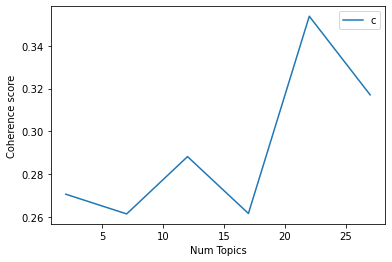

In [70]:
# Plot to see coherence score in order to choose optimal number of topics and decide optimal model
limit=30; start=2; step=5;
x = range(start, limit, step)
plt.plot(x, coherence_values_ph_score3)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [71]:
# Print the coherence scores
index = 0
for m, cv in zip(x, coherence_values_ph_score3):
    print("index:",index,"|","Num Topics =", m, " has Coherence Value of", round(cv, 4))
    index = index + 1

# optimal num_topics = 22

index: 0 | Num Topics = 2  has Coherence Value of 0.2707
index: 1 | Num Topics = 7  has Coherence Value of 0.2615
index: 2 | Num Topics = 12  has Coherence Value of 0.2883
index: 3 | Num Topics = 17  has Coherence Value of 0.2617
index: 4 | Num Topics = 22  has Coherence Value of 0.3538
index: 5 | Num Topics = 27  has Coherence Value of 0.3171


In [72]:
# Select optimal number of topics
optimal_model_ph_score3 = model_list_ph_score3[4]

In [73]:
# pyLDAVis
pyLDAvis.enable_notebook()
vis_ph_score3 = pyLDAvis.gensim_models.prepare(optimal_model_ph_score3, corpus_ph_score3, id2word_ph_score3)

In [74]:
print("pyLDAVis for ph topics for score=3:")
vis_ph_score3

pyLDAVis for ph topics for score=3:


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.101604  0.068825       1        1  11.501609
16    -0.110673  0.087385       2        1  10.805130
15     0.014268  0.038205       3        1   7.321735
7     -0.112166  0.049580       4        1   7.122964
17    -0.087021 -0.067335       5        1   6.768411
0     -0.047371 -0.095358       6        1   6.194062
2     -0.053383  0.022889       7        1   6.148025
4     -0.090405 -0.113473       8        1   4.694169
9     -0.090186  0.001833       9        1   4.504018
8      0.090612  0.123153      10        1   4.453144
5      0.094013  0.087140      11        1   4.186371
11    -0.058721 -0.067554      12        1   3.786181
21    -0.058886  0.044701      13        1   3.630654
18    -0.011990 -0.023131      14        1   3.175148
20     0.085003  0.063666      15        1   2.913018
1     -0.003269  0.053372      16        1   2.795381
12     0.110543  0.060797      17        1   2.744470
13     0.014679 -0.045701      18        1   2.464547
14     0.061221 -0.055844      19        1   1.689280
6      0.136483 -0.041809      20        1   1.281724
19     0.103074 -0.114898      21        1   1.014033
10     0.115780 -0.076442      22        1   0.805925, topic_info=         Term        Freq       Total Category  logprob  loglift
83      video   45.000000   45.000000  Default  30.0000  30.0000
129   feature   43.000000   43.000000  Default  29.0000  29.0000
193     photo   36.000000   36.000000  Default  28.0000  28.0000
101   account   59.000000   59.000000  Default  27.0000  27.0000
1         app  130.000000  130.000000  Default  26.0000  26.0000
..        ...         ...         ...      ...      ...      ...
4    facebook    0.493306  116.585960  Topic22  -4.3307  -0.6443
166        fb    0.021449   18.259018  Topic22  -7.4662  -1.9258
12        new    0.021449   39.169417  Topic22  -7.4662  -2.6890
101   account    0.021449   59.303438  Topic22  -7.4662  -3.1038
759      copy    0.021449    3.439712  Topic22  -7.4662  -0.2565

[1267 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
429       5  0.308933    ability
429      11  0.617865    ability
131       3  0.151519       able
131       6  0.151519       able
131       7  0.303038       able
...     ...       ...        ...
265       3  0.164800       year
265       4  0.164800       year
721      18  0.676690  yesterday
248       3  0.884034      young
952       5  0.615176       youu

[2066 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 17, 16, 8, 18, 1, 3, 5, 10, 9, 6, 12, 22, 19, 21, 2, 13, 14, 15, 7, 20, 11])

## LDA Topic Modelling (Rating = 4)

In [75]:
# By-rating Topic Modelling - rating = 4
# Convert to list - move to each section
review_ph_score4 = facebook_ios_ph_review_YearMonth_score4.review.values.tolist()
review_words_ph_score4 = list(sent_to_words(review_ph_score4))
print(review_words_ph_score4[2:3])

[['hi', 'have', 'problem', 'with', 'my', 'facebook', 'am', 'using', 'an', 'ios', 'device', 'my', 'problem', 'is', 'everytime', 'try', 'to', 'do', 'research', 'or', 'click', 'the', 'research', 'tab', 'an', 'write', 'something', 'or', 'anything', 'on', 'the', 'tab', 'nothing', 'show', 'up', 'it', 'always', 'say', 'therei', 'nothing', 'to', 'show', 'or', 'no', 'result', 'found', 'try', 'to', 'do', 'the', 'same', 'thing', 'on', 'my', 'bf', 'phone', 'and', 'type', 'the', 'same', 'thing', 'on', 'research', 'tab', 'and', 'it', 'successfully', 'go', 'through', 'theres', 'lot', 'of', 'suggestions', 'or', 'group', 'or', 'post', 'showing', 'about', 'the', 'things', 'type', 'on', 'the', 'search', 'tab', 'please', 'help']]


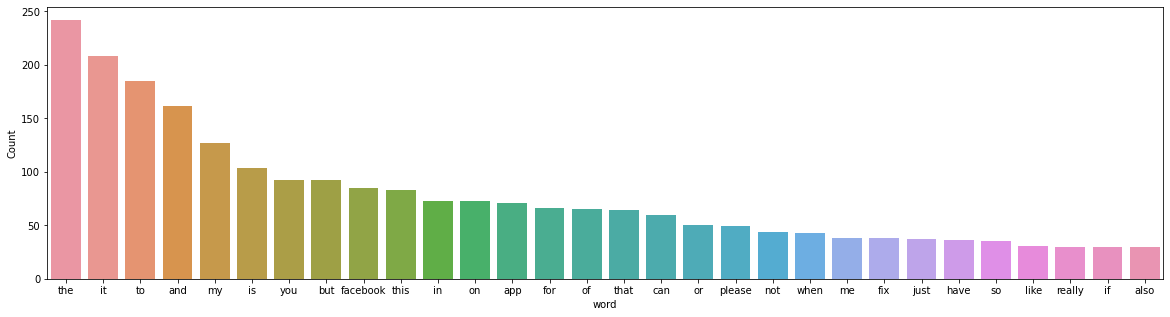

In [76]:
# Inspect the frequency of words before cleaning
freq_words(flatten(review_words_ph_score4))

In [77]:
# Clean text
review_ph_ready_score4 = process_words(review_words_ph_score4)  # processed Text Data! - move to each section

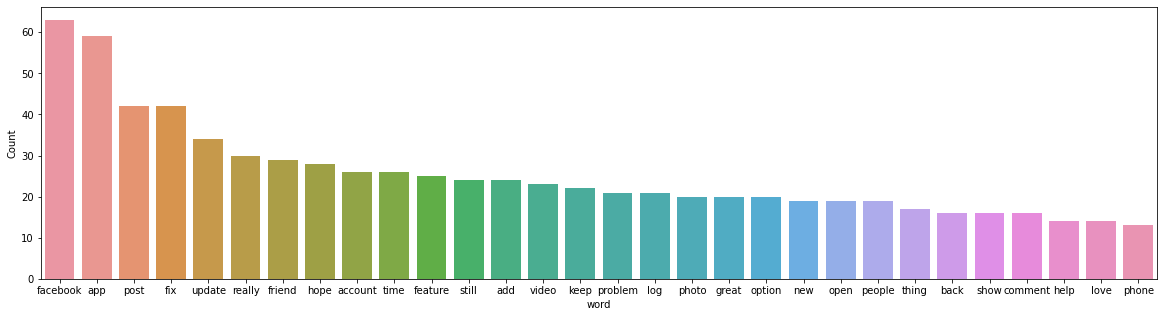

In [78]:
# Inspect the frequency of words after cleaning
freq_words(flatten(review_ph_ready_score4))


In [79]:
# Create Dictionary
id2word_ph_score4 = corpora.Dictionary(review_ph_ready_score4)

2021-10-16 18:40:17,929 [INFO] gensim.corpora.dictionary - adding document #0 to Dictionary(0 unique tokens: [])
2021-10-16 18:40:18,035 [INFO] gensim.corpora.dictionary - built Dictionary(719 unique tokens: ['album', 'atleast', 'back', 'boring', 'compare']...) from 98 documents (total 2328 corpus positions)
2021-10-16 18:40:18,052 [INFO] gensim.utils - Dictionary lifecycle event {'msg': "built Dictionary(719 unique tokens: ['album', 'atleast', 'back', 'boring', 'compare']...) from 98 documents (total 2328 corpus positions)", 'datetime': '2021-10-16T18:40:18.052647', 'gensim': '4.1.2', 'python': '3.8.8 (default, Apr 13 2021, 12:59:45) \n[Clang 10.0.0 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'created'}


In [80]:
# Create Corpus: Term Document Frequency
corpus_ph_score4 = [id2word_ph_score4.doc2bow(text) for text in review_ph_ready_score4]

In [81]:
# Training LDA model
model_list_ph_score4, coherence_values_ph_score4 = compute_coherence_values(dictionary=id2word_ph_score4, corpus=corpus_ph_score4, 
                                                              texts=review_ph_ready_score4, limit=30, start=2, step=5)


2021-10-16 18:40:18,082 [INFO] gensim.models.ldamodel - using symmetric alpha at 0.5
2021-10-16 18:40:18,086 [INFO] gensim.models.ldamodel - using symmetric eta at 0.5
2021-10-16 18:40:18,090 [INFO] gensim.models.ldamodel - using serial LDA version on this node
2021-10-16 18:40:18,092 [INFO] gensim.models.ldamodel - running online (multi-pass) LDA training, 2 topics, 50 passes over the supplied corpus of 98 documents, updating model once every 98 documents, evaluating perplexity every 98 documents, iterating 50x with a convergence threshold of 0.001000
2021-10-16 18:40:18,563 [INFO] gensim.models.ldamodel - -7.182 per-word bound, 145.2 perplexity estimate based on a held-out corpus of 98 documents with 2328 words
2021-10-16 18:40:18,564 [INFO] gensim.models.ldamodel - PROGRESS: pass 0, at document #98/98
2021-10-16 18:40:18,949 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.018*"facebook" + 0.018*"post" + 0.015*"app" + 0.014*"update" + 0.012*"feature" + 0.011*"add" + 0.011*"fix" +

2021-10-16 18:40:22,962 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.026*"facebook" + 0.025*"app" + 0.018*"fix" + 0.015*"account" + 0.014*"log" + 0.012*"keep" + 0.011*"still" + 0.011*"time" + 0.011*"friend" + 0.010*"really"
2021-10-16 18:40:22,963 [INFO] gensim.models.ldamodel - topic diff=0.008783, rho=0.301511
2021-10-16 18:40:23,335 [INFO] gensim.models.ldamodel - -6.266 per-word bound, 77.0 perplexity estimate based on a held-out corpus of 98 documents with 2328 words
2021-10-16 18:40:23,337 [INFO] gensim.models.ldamodel - PROGRESS: pass 10, at document #98/98
2021-10-16 18:40:23,531 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.018*"post" + 0.018*"update" + 0.017*"facebook" + 0.014*"feature" + 0.014*"app" + 0.013*"photo" + 0.013*"add" + 0.011*"fix" + 0.010*"really" + 0.010*"people"
2021-10-16 18:40:23,537 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.026*"facebook" + 0.025*"app" + 0.018*"fix" + 0.015*"account" + 0.014*"log" + 0.012*"keep" + 0.011*"still" + 0.011

2021-10-16 18:40:27,706 [INFO] gensim.models.ldamodel - topic diff=0.003562, rho=0.218218
2021-10-16 18:40:27,893 [INFO] gensim.models.ldamodel - -6.262 per-word bound, 76.7 perplexity estimate based on a held-out corpus of 98 documents with 2328 words
2021-10-16 18:40:27,894 [INFO] gensim.models.ldamodel - PROGRESS: pass 20, at document #98/98
2021-10-16 18:40:28,077 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.018*"update" + 0.018*"post" + 0.017*"facebook" + 0.014*"feature" + 0.014*"app" + 0.013*"add" + 0.013*"photo" + 0.011*"really" + 0.010*"people" + 0.010*"fix"
2021-10-16 18:40:28,079 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.026*"facebook" + 0.026*"app" + 0.018*"fix" + 0.016*"account" + 0.014*"log" + 0.013*"keep" + 0.011*"time" + 0.011*"still" + 0.011*"friend" + 0.010*"post"
2021-10-16 18:40:28,080 [INFO] gensim.models.ldamodel - topic diff=0.003489, rho=0.213201
2021-10-16 18:40:28,314 [INFO] gensim.models.ldamodel - -6.261 per-word bound, 76.7 perplexity estima

2021-10-16 18:40:31,706 [INFO] gensim.models.ldamodel - PROGRESS: pass 30, at document #98/98
2021-10-16 18:40:31,862 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.018*"update" + 0.018*"post" + 0.017*"facebook" + 0.014*"feature" + 0.014*"app" + 0.013*"add" + 0.013*"photo" + 0.011*"really" + 0.010*"people" + 0.010*"fix"
2021-10-16 18:40:31,865 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.026*"app" + 0.026*"facebook" + 0.018*"fix" + 0.016*"account" + 0.015*"log" + 0.013*"keep" + 0.011*"time" + 0.010*"friend" + 0.010*"still" + 0.010*"great"
2021-10-16 18:40:31,867 [INFO] gensim.models.ldamodel - topic diff=0.004186, rho=0.176777
2021-10-16 18:40:32,170 [INFO] gensim.models.ldamodel - -6.257 per-word bound, 76.5 perplexity estimate based on a held-out corpus of 98 documents with 2328 words
2021-10-16 18:40:32,172 [INFO] gensim.models.ldamodel - PROGRESS: pass 31, at document #98/98
2021-10-16 18:40:32,325 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.018*"update" + 0.018

2021-10-16 18:40:35,706 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.026*"app" + 0.025*"facebook" + 0.018*"fix" + 0.016*"account" + 0.015*"log" + 0.013*"keep" + 0.011*"time" + 0.010*"great" + 0.010*"post" + 0.010*"friend"
2021-10-16 18:40:35,711 [INFO] gensim.models.ldamodel - topic diff=0.001506, rho=0.154303
2021-10-16 18:40:35,941 [INFO] gensim.models.ldamodel - -6.255 per-word bound, 76.4 perplexity estimate based on a held-out corpus of 98 documents with 2328 words
2021-10-16 18:40:35,943 [INFO] gensim.models.ldamodel - PROGRESS: pass 41, at document #98/98
2021-10-16 18:40:36,088 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.018*"update" + 0.018*"post" + 0.017*"facebook" + 0.014*"feature" + 0.014*"app" + 0.014*"add" + 0.013*"photo" + 0.011*"really" + 0.010*"people" + 0.010*"fix"
2021-10-16 18:40:36,095 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.026*"app" + 0.025*"facebook" + 0.018*"fix" + 0.016*"account" + 0.015*"log" + 0.013*"keep" + 0.011*"time" + 0.010*"g

2021-10-16 18:40:43,796 [INFO] gensim.topic_coherence.text_analysis - accumulated word occurrence stats for 97 virtual documents
2021-10-16 18:40:44,096 [INFO] gensim.models.ldamodel - using symmetric alpha at 0.14285714285714285
2021-10-16 18:40:44,099 [INFO] gensim.models.ldamodel - using symmetric eta at 0.14285714285714285
2021-10-16 18:40:44,120 [INFO] gensim.models.ldamodel - using serial LDA version on this node
2021-10-16 18:40:44,128 [INFO] gensim.models.ldamodel - running online (multi-pass) LDA training, 7 topics, 50 passes over the supplied corpus of 98 documents, updating model once every 98 documents, evaluating perplexity every 98 documents, iterating 50x with a convergence threshold of 0.001000
2021-10-16 18:40:44,567 [INFO] gensim.models.ldamodel - -9.156 per-word bound, 570.5 perplexity estimate based on a held-out corpus of 98 documents with 2328 words
2021-10-16 18:40:44,569 [INFO] gensim.models.ldamodel - PROGRESS: pass 0, at document #98/98
2021-10-16 18:40:44,859

2021-10-16 18:40:46,004 [INFO] gensim.models.ldamodel - topic diff=0.079110, rho=0.408248
2021-10-16 18:40:46,213 [INFO] gensim.models.ldamodel - -6.501 per-word bound, 90.6 perplexity estimate based on a held-out corpus of 98 documents with 2328 words
2021-10-16 18:40:46,214 [INFO] gensim.models.ldamodel - PROGRESS: pass 5, at document #98/98
2021-10-16 18:40:46,325 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.028*"log" + 0.027*"fix" + 0.026*"app" + 0.023*"facebook" + 0.020*"account" + 0.015*"keep" + 0.014*"share" + 0.012*"open" + 0.012*"phone" + 0.010*"messenger"
2021-10-16 18:40:46,327 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.023*"update" + 0.018*"log" + 0.018*"still" + 0.018*"feature" + 0.018*"first" + 0.014*"notification" + 0.014*"love" + 0.014*"facebook" + 0.010*"able" + 0.010*"app"
2021-10-16 18:40:46,328 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.044*"app" + 0.027*"facebook" + 0.024*"post" + 0.018*"back" + 0.015*"update" + 0.015*"turn" + 0.015*"proble

2021-10-16 18:40:47,597 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.021*"add" + 0.017*"delete" + 0.017*"people" + 0.017*"music" + 0.013*"load" + 0.013*"send" + 0.013*"roleplay" + 0.013*"cause" + 0.013*"update" + 0.013*"messenger"
2021-10-16 18:40:47,603 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.030*"video" + 0.024*"people" + 0.023*"app" + 0.021*"hope" + 0.020*"mode" + 0.017*"dark" + 0.017*"iphone" + 0.017*"update" + 0.015*"already" + 0.014*"option"
2021-10-16 18:40:47,605 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.028*"log" + 0.028*"fix" + 0.026*"app" + 0.023*"facebook" + 0.020*"account" + 0.015*"keep" + 0.014*"share" + 0.012*"open" + 0.012*"phone" + 0.010*"messenger"
2021-10-16 18:40:47,608 [INFO] gensim.models.ldamodel - topic diff=0.011309, rho=0.288675
2021-10-16 18:40:47,762 [INFO] gensim.models.ldamodel - -6.484 per-word bound, 89.5 perplexity estimate based on a held-out corpus of 98 documents with 2328 words
2021-10-16 18:40:47,782 [INFO] gensim.model

2021-10-16 18:40:48,947 [INFO] gensim.models.ldamodel - topic diff=0.003674, rho=0.242536
2021-10-16 18:40:49,096 [INFO] gensim.models.ldamodel - -6.481 per-word bound, 89.3 perplexity estimate based on a held-out corpus of 98 documents with 2328 words
2021-10-16 18:40:49,104 [INFO] gensim.models.ldamodel - PROGRESS: pass 16, at document #98/98
2021-10-16 18:40:49,208 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.045*"app" + 0.027*"facebook" + 0.023*"post" + 0.018*"back" + 0.016*"turn" + 0.016*"update" + 0.014*"problem" + 0.013*"open" + 0.013*"keep" + 0.011*"photo"
2021-10-16 18:40:49,210 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.031*"video" + 0.024*"people" + 0.023*"app" + 0.021*"hope" + 0.020*"mode" + 0.018*"dark" + 0.017*"iphone" + 0.017*"update" + 0.015*"already" + 0.014*"option"
2021-10-16 18:40:49,212 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.025*"facebook" + 0.023*"post" + 0.021*"really" + 0.019*"friend" + 0.017*"time" + 0.017*"fix" + 0.015*"app" + 0.01

2021-10-16 18:40:51,068 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.025*"facebook" + 0.023*"post" + 0.021*"really" + 0.019*"friend" + 0.017*"time" + 0.017*"fix" + 0.015*"app" + 0.015*"hope" + 0.014*"comment" + 0.013*"account"
2021-10-16 18:40:51,072 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.028*"log" + 0.028*"fix" + 0.026*"app" + 0.023*"facebook" + 0.020*"account" + 0.015*"keep" + 0.014*"share" + 0.012*"open" + 0.012*"phone" + 0.010*"work"
2021-10-16 18:40:51,073 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.031*"video" + 0.024*"people" + 0.023*"app" + 0.021*"hope" + 0.020*"mode" + 0.018*"dark" + 0.017*"iphone" + 0.017*"update" + 0.015*"already" + 0.014*"watch"
2021-10-16 18:40:51,075 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.021*"add" + 0.017*"people" + 0.017*"delete" + 0.017*"music" + 0.013*"send" + 0.013*"load" + 0.013*"cause" + 0.013*"update" + 0.013*"messenger" + 0.013*"roleplay"
2021-10-16 18:40:51,077 [INFO] gensim.models.ldamodel - topic diff=0

2021-10-16 18:40:52,872 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.023*"update" + 0.018*"first" + 0.018*"feature" + 0.018*"still" + 0.018*"log" + 0.014*"love" + 0.014*"notification" + 0.014*"facebook" + 0.009*"click" + 0.009*"share"
2021-10-16 18:40:52,876 [INFO] gensim.models.ldamodel - topic diff=0.000789, rho=0.188982
2021-10-16 18:40:53,082 [INFO] gensim.models.ldamodel - -6.479 per-word bound, 89.2 perplexity estimate based on a held-out corpus of 98 documents with 2328 words
2021-10-16 18:40:53,084 [INFO] gensim.models.ldamodel - PROGRESS: pass 27, at document #98/98
2021-10-16 18:40:53,208 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.021*"add" + 0.017*"people" + 0.017*"music" + 0.017*"delete" + 0.013*"update" + 0.013*"messenger" + 0.013*"send" + 0.013*"fix" + 0.013*"cause" + 0.013*"load"
2021-10-16 18:40:53,212 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.045*"app" + 0.027*"facebook" + 0.023*"post" + 0.019*"back" + 0.016*"turn" + 0.016*"update" + 0.014*"op

2021-10-16 18:40:54,836 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.028*"log" + 0.028*"fix" + 0.026*"app" + 0.023*"facebook" + 0.020*"account" + 0.015*"keep" + 0.014*"share" + 0.012*"open" + 0.012*"phone" + 0.010*"work"
2021-10-16 18:40:54,838 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.031*"video" + 0.024*"people" + 0.024*"app" + 0.021*"hope" + 0.020*"mode" + 0.018*"dark" + 0.017*"iphone" + 0.017*"update" + 0.016*"already" + 0.014*"watch"
2021-10-16 18:40:54,840 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.021*"add" + 0.017*"people" + 0.017*"music" + 0.017*"delete" + 0.013*"fix" + 0.013*"messenger" + 0.013*"update" + 0.013*"send" + 0.013*"cause" + 0.013*"load"
2021-10-16 18:40:54,841 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.030*"facebook" + 0.027*"feature" + 0.020*"photo" + 0.017*"look" + 0.017*"album" + 0.014*"able" + 0.014*"forward" + 0.013*"post" + 0.010*"great" + 0.010*"upload"
2021-10-16 18:40:54,845 [INFO] gensim.models.ldamodel - topic diff=0.0

2021-10-16 18:40:56,204 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.023*"update" + 0.018*"first" + 0.018*"feature" + 0.018*"still" + 0.018*"log" + 0.014*"love" + 0.014*"facebook" + 0.014*"notification" + 0.009*"share" + 0.009*"click"
2021-10-16 18:40:56,205 [INFO] gensim.models.ldamodel - topic diff=0.000325, rho=0.160128
2021-10-16 18:40:56,333 [INFO] gensim.models.ldamodel - -6.479 per-word bound, 89.2 perplexity estimate based on a held-out corpus of 98 documents with 2328 words
2021-10-16 18:40:56,336 [INFO] gensim.models.ldamodel - PROGRESS: pass 38, at document #98/98
2021-10-16 18:40:56,402 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.028*"log" + 0.028*"fix" + 0.026*"app" + 0.023*"facebook" + 0.020*"account" + 0.015*"keep" + 0.014*"share" + 0.012*"open" + 0.012*"phone" + 0.010*"work"
2021-10-16 18:40:56,404 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.023*"update" + 0.018*"first" + 0.018*"feature" + 0.018*"still" + 0.018*"log" + 0.014*"love" + 0.014*"facebo

2021-10-16 18:40:57,706 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.045*"app" + 0.027*"facebook" + 0.022*"post" + 0.019*"back" + 0.016*"turn" + 0.016*"update" + 0.014*"open" + 0.013*"keep" + 0.013*"problem" + 0.011*"great"
2021-10-16 18:40:57,708 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.030*"facebook" + 0.027*"feature" + 0.020*"photo" + 0.017*"look" + 0.017*"album" + 0.014*"able" + 0.014*"forward" + 0.013*"post" + 0.010*"great" + 0.010*"upload"
2021-10-16 18:40:57,710 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.028*"log" + 0.028*"fix" + 0.026*"app" + 0.023*"facebook" + 0.020*"account" + 0.015*"keep" + 0.014*"share" + 0.012*"open" + 0.012*"phone" + 0.010*"work"
2021-10-16 18:40:57,713 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.025*"facebook" + 0.023*"post" + 0.021*"really" + 0.019*"friend" + 0.017*"time" + 0.017*"fix" + 0.015*"hope" + 0.015*"app" + 0.013*"comment" + 0.013*"account"
2021-10-16 18:40:57,715 [INFO] gensim.models.ldamodel - topic diff=0.0

2021-10-16 18:40:59,023 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.028*"log" + 0.028*"fix" + 0.026*"app" + 0.023*"facebook" + 0.020*"account" + 0.015*"keep" + 0.014*"share" + 0.012*"open" + 0.012*"phone" + 0.010*"work"
2021-10-16 18:40:59,025 [INFO] gensim.models.ldamodel - topic diff=0.000192, rho=0.141421
2021-10-16 18:40:59,184 [INFO] gensim.models.ldamodel - -6.479 per-word bound, 89.2 perplexity estimate based on a held-out corpus of 98 documents with 2328 words
2021-10-16 18:40:59,188 [INFO] gensim.models.ldamodel - PROGRESS: pass 49, at document #98/98
2021-10-16 18:40:59,237 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.028*"log" + 0.028*"fix" + 0.026*"app" + 0.023*"facebook" + 0.020*"account" + 0.015*"keep" + 0.014*"share" + 0.012*"open" + 0.012*"phone" + 0.010*"work"
2021-10-16 18:40:59,239 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.031*"video" + 0.024*"people" + 0.024*"app" + 0.021*"hope" + 0.020*"mode" + 0.018*"dark" + 0.017*"iphone" + 0.017*"update"

2021-10-16 18:41:06,917 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.030*"show" + 0.028*"notification" + 0.023*"feature" + 0.022*"thing" + 0.022*"facebook" + 0.018*"type" + 0.018*"tab" + 0.015*"people" + 0.014*"group" + 0.014*"roleplay"
2021-10-16 18:41:06,923 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.046*"app" + 0.025*"facebook" + 0.023*"problem" + 0.022*"back" + 0.020*"video" + 0.019*"update" + 0.017*"fix" + 0.016*"turn" + 0.016*"love" + 0.015*"feature"
2021-10-16 18:41:06,927 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.056*"facebook" + 0.027*"add" + 0.020*"app" + 0.020*"account" + 0.020*"still" + 0.017*"fix" + 0.016*"hope" + 0.014*"post" + 0.013*"update" + 0.013*"comment"
2021-10-16 18:41:06,934 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.042*"log" + 0.032*"fix" + 0.031*"app" + 0.019*"work" + 0.019*"account" + 0.018*"keep" + 0.014*"always" + 0.013*"phone" + 0.013*"facebook" + 0.012*"open"
2021-10-16 18:41:06,939 [INFO] gensim.models.ldamodel - topic

2021-10-16 18:41:08,103 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.028*"hope" + 0.023*"friend" + 0.017*"feature" + 0.017*"unfriend" + 0.017*"consume" + 0.017*"messenger" + 0.012*"really" + 0.012*"time" + 0.012*"device" + 0.012*"wish"
2021-10-16 18:41:08,105 [INFO] gensim.models.ldamodel - topic diff=0.023131, rho=0.316228
2021-10-16 18:41:08,317 [INFO] gensim.models.ldamodel - -6.603 per-word bound, 97.2 perplexity estimate based on a held-out corpus of 98 documents with 2328 words
2021-10-16 18:41:08,319 [INFO] gensim.models.ldamodel - PROGRESS: pass 9, at document #98/98
2021-10-16 18:41:08,401 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.027*"share" + 0.027*"fix" + 0.022*"update" + 0.021*"still" + 0.021*"post" + 0.021*"click" + 0.016*"app" + 0.016*"album" + 0.016*"option" + 0.016*"link"
2021-10-16 18:41:08,419 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.030*"facebook" + 0.027*"account" + 0.024*"photo" + 0.017*"option" + 0.016*"already" + 0.016*"recover" + 0.0

2021-10-16 18:41:09,720 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.020*"delete" + 0.020*"problem" + 0.020*"keep" + 0.020*"button" + 0.013*"new" + 0.013*"still" + 0.013*"account" + 0.013*"feature" + 0.013*"solution" + 0.013*"happen"
2021-10-16 18:41:09,725 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.028*"hope" + 0.023*"friend" + 0.017*"feature" + 0.017*"consume" + 0.017*"unfriend" + 0.017*"messenger" + 0.012*"device" + 0.012*"really" + 0.012*"time" + 0.012*"wish"
2021-10-16 18:41:09,727 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.027*"share" + 0.027*"fix" + 0.022*"update" + 0.021*"still" + 0.021*"post" + 0.021*"click" + 0.016*"app" + 0.016*"album" + 0.016*"option" + 0.016*"link"
2021-10-16 18:41:09,730 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.031*"post" + 0.030*"really" + 0.025*"comment" + 0.021*"time" + 0.019*"group" + 0.019*"change" + 0.018*"facebook" + 0.018*"friend" + 0.015*"upload" + 0.014*"new"
2021-10-16 18:41:09,732 [INFO] gensim.models.ldamod

2021-10-16 18:41:10,992 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.023*"video" + 0.023*"people" + 0.023*"iphone" + 0.019*"open" + 0.019*"hope" + 0.019*"app" + 0.018*"dark" + 0.015*"fix" + 0.015*"option" + 0.015*"messenger"
2021-10-16 18:41:10,998 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.046*"app" + 0.025*"facebook" + 0.023*"problem" + 0.022*"back" + 0.020*"video" + 0.019*"update" + 0.017*"fix" + 0.016*"turn" + 0.016*"love" + 0.015*"feature"
2021-10-16 18:41:11,000 [INFO] gensim.models.ldamodel - topic diff=0.001303, rho=0.218218
2021-10-16 18:41:11,192 [INFO] gensim.models.ldamodel - -6.598 per-word bound, 96.8 perplexity estimate based on a held-out corpus of 98 documents with 2328 words
2021-10-16 18:41:11,193 [INFO] gensim.models.ldamodel - PROGRESS: pass 20, at document #98/98
2021-10-16 18:41:11,242 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.001*"tag" + 0.001*"hope" + 0.001*"people" + 0.001*"experienced" + 0.001*"coz" + 0.001*"time" + 0.001*"ever" + 0.

2021-10-16 18:41:12,358 [INFO] gensim.models.ldamodel - PROGRESS: pass 25, at document #98/98
2021-10-16 18:41:12,419 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.001*"tag" + 0.001*"hope" + 0.001*"people" + 0.001*"experienced" + 0.001*"coz" + 0.001*"time" + 0.001*"ever" + 0.001*"scam" + 0.001*"twice" + 0.001*"soon"
2021-10-16 18:41:12,420 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.032*"app" + 0.025*"keep" + 0.024*"facebook" + 0.020*"review" + 0.018*"post" + 0.018*"happen" + 0.015*"update" + 0.015*"marketplace" + 0.013*"great" + 0.012*"friend"
2021-10-16 18:41:12,422 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.046*"app" + 0.025*"facebook" + 0.023*"problem" + 0.022*"back" + 0.020*"video" + 0.019*"update" + 0.017*"fix" + 0.016*"turn" + 0.016*"love" + 0.015*"feature"
2021-10-16 18:41:12,425 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.045*"log" + 0.032*"fix" + 0.031*"app" + 0.021*"work" + 0.019*"account" + 0.017*"keep" + 0.017*"time" + 0.014*"always" + 0.014

2021-10-16 18:41:13,629 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.046*"app" + 0.025*"facebook" + 0.023*"problem" + 0.022*"back" + 0.020*"video" + 0.019*"update" + 0.017*"fix" + 0.016*"turn" + 0.016*"love" + 0.015*"feature"
2021-10-16 18:41:13,632 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.057*"facebook" + 0.027*"add" + 0.020*"app" + 0.020*"account" + 0.020*"still" + 0.017*"fix" + 0.017*"hope" + 0.014*"post" + 0.014*"update" + 0.014*"comment"
2021-10-16 18:41:13,633 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.031*"post" + 0.030*"really" + 0.025*"comment" + 0.021*"time" + 0.019*"group" + 0.019*"change" + 0.018*"facebook" + 0.018*"friend" + 0.015*"upload" + 0.014*"new"
2021-10-16 18:41:13,635 [INFO] gensim.models.ldamodel - topic diff=0.000150, rho=0.176777
2021-10-16 18:41:13,841 [INFO] gensim.models.ldamodel - -6.597 per-word bound, 96.8 perplexity estimate based on a held-out corpus of 98 documents with 2328 words
2021-10-16 18:41:13,842 [INFO] gensim.models.

2021-10-16 18:41:14,969 [INFO] gensim.models.ldamodel - topic diff=0.000060, rho=0.164399
2021-10-16 18:41:15,125 [INFO] gensim.models.ldamodel - -6.597 per-word bound, 96.8 perplexity estimate based on a held-out corpus of 98 documents with 2328 words
2021-10-16 18:41:15,127 [INFO] gensim.models.ldamodel - PROGRESS: pass 36, at document #98/98
2021-10-16 18:41:15,199 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.028*"hope" + 0.023*"friend" + 0.017*"messenger" + 0.017*"feature" + 0.017*"unfriend" + 0.017*"consume" + 0.012*"device" + 0.012*"wish" + 0.012*"great" + 0.012*"well"
2021-10-16 18:41:15,201 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.030*"facebook" + 0.027*"account" + 0.025*"photo" + 0.017*"option" + 0.017*"already" + 0.017*"recover" + 0.016*"people" + 0.016*"open" + 0.012*"back" + 0.012*"video"
2021-10-16 18:41:15,207 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.045*"log" + 0.032*"fix" + 0.031*"app" + 0.021*"work" + 0.019*"account" + 0.017*"keep" + 0.017*

2021-10-16 18:41:16,602 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.030*"facebook" + 0.027*"account" + 0.025*"photo" + 0.017*"option" + 0.017*"already" + 0.017*"recover" + 0.016*"people" + 0.016*"open" + 0.012*"back" + 0.012*"video"
2021-10-16 18:41:16,603 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.020*"problem" + 0.020*"delete" + 0.020*"keep" + 0.020*"button" + 0.013*"new" + 0.013*"still" + 0.013*"account" + 0.013*"solution" + 0.013*"happen" + 0.013*"feature"
2021-10-16 18:41:16,607 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.023*"video" + 0.023*"people" + 0.023*"iphone" + 0.019*"open" + 0.019*"hope" + 0.019*"app" + 0.018*"dark" + 0.015*"option" + 0.015*"fix" + 0.015*"messenger"
2021-10-16 18:41:16,608 [INFO] gensim.models.ldamodel - topic diff=0.000021, rho=0.152499
2021-10-16 18:41:16,742 [INFO] gensim.models.ldamodel - -6.597 per-word bound, 96.8 perplexity estimate based on a held-out corpus of 98 documents with 2328 words
2021-10-16 18:41:16,745 [INFO] ge

2021-10-16 18:41:18,040 [INFO] gensim.models.ldamodel - topic diff=0.000009, rho=0.144338
2021-10-16 18:41:18,247 [INFO] gensim.models.ldamodel - -6.597 per-word bound, 96.8 perplexity estimate based on a held-out corpus of 98 documents with 2328 words
2021-10-16 18:41:18,249 [INFO] gensim.models.ldamodel - PROGRESS: pass 47, at document #98/98
2021-10-16 18:41:18,384 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.046*"app" + 0.025*"facebook" + 0.023*"problem" + 0.022*"back" + 0.020*"video" + 0.019*"update" + 0.017*"fix" + 0.016*"turn" + 0.016*"love" + 0.015*"feature"
2021-10-16 18:41:18,433 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.033*"show" + 0.028*"notification" + 0.028*"feature" + 0.024*"thing" + 0.021*"facebook" + 0.019*"type" + 0.019*"tab" + 0.015*"people" + 0.014*"group" + 0.014*"roleplay"
2021-10-16 18:41:18,439 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.023*"video" + 0.023*"people" + 0.023*"iphone" + 0.019*"hope" + 0.019*"open" + 0.019*"app" + 0.018*"

2021-10-16 18:41:27,968 [INFO] gensim.models.ldamodel - topic #14 (0.059): 0.031*"manage" + 0.023*"tag" + 0.023*"people" + 0.020*"friend" + 0.017*"post" + 0.017*"facebook" + 0.016*"really" + 0.016*"ipad" + 0.016*"share" + 0.016*"problem"
2021-10-16 18:41:27,969 [INFO] gensim.models.ldamodel - topic #15 (0.059): 0.027*"facebook" + 0.027*"recover" + 0.027*"account" + 0.026*"phone" + 0.020*"fix" + 0.018*"soon" + 0.018*"already" + 0.018*"hope" + 0.017*"log" + 0.015*"still"
2021-10-16 18:41:27,970 [INFO] gensim.models.ldamodel - topic #11 (0.059): 0.041*"notification" + 0.041*"show" + 0.029*"app" + 0.024*"facebook" + 0.024*"thing" + 0.020*"tab" + 0.019*"update" + 0.018*"feature" + 0.016*"group" + 0.015*"post"
2021-10-16 18:41:27,971 [INFO] gensim.models.ldamodel - topic diff=0.178023, rho=0.577350
2021-10-16 18:41:28,194 [INFO] gensim.models.ldamodel - -6.832 per-word bound, 113.9 perplexity estimate based on a held-out corpus of 98 documents with 2328 words
2021-10-16 18:41:28,195 [INFO] g

2021-10-16 18:41:29,344 [INFO] gensim.models.ldamodel - topic diff=0.047954, rho=0.353553
2021-10-16 18:41:29,431 [INFO] gensim.models.ldamodel - -6.691 per-word bound, 103.3 perplexity estimate based on a held-out corpus of 98 documents with 2328 words
2021-10-16 18:41:29,435 [INFO] gensim.models.ldamodel - PROGRESS: pass 7, at document #98/98
2021-10-16 18:41:29,595 [INFO] gensim.models.ldamodel - topic #3 (0.059): 0.026*"time" + 0.026*"uninstall" + 0.026*"app" + 0.026*"already" + 0.026*"application" + 0.026*"log" + 0.014*"work" + 0.014*"reinstall" + 0.014*"hustle" + 0.014*"safari"
2021-10-16 18:41:29,597 [INFO] gensim.models.ldamodel - topic #2 (0.059): 0.056*"app" + 0.024*"black" + 0.024*"update" + 0.024*"user" + 0.024*"lock" + 0.024*"guy" + 0.024*"news" + 0.016*"turn" + 0.016*"market" + 0.016*"place"
2021-10-16 18:41:29,601 [INFO] gensim.models.ldamodel - topic #10 (0.059): 0.036*"keep" + 0.027*"post" + 0.025*"review" + 0.025*"app" + 0.024*"facebook" + 0.019*"friend" + 0.014*"prob

2021-10-16 18:41:31,130 [INFO] gensim.models.ldamodel - topic #4 (0.059): 0.031*"delete" + 0.021*"keep" + 0.021*"problem" + 0.021*"load" + 0.021*"still" + 0.021*"happen" + 0.021*"solution" + 0.021*"post" + 0.021*"new" + 0.011*"hope"
2021-10-16 18:41:31,136 [INFO] gensim.models.ldamodel - topic #15 (0.059): 0.031*"facebook" + 0.028*"account" + 0.025*"recover" + 0.025*"phone" + 0.024*"page" + 0.024*"soon" + 0.020*"fix" + 0.019*"already" + 0.019*"hope" + 0.019*"still"
2021-10-16 18:41:31,143 [INFO] gensim.models.ldamodel - topic #1 (0.059): 0.053*"app" + 0.038*"open" + 0.033*"keep" + 0.028*"log" + 0.027*"account" + 0.023*"fix" + 0.022*"work" + 0.022*"messenger" + 0.018*"bug" + 0.017*"screen"
2021-10-16 18:41:31,150 [INFO] gensim.models.ldamodel - topic #2 (0.059): 0.056*"app" + 0.024*"black" + 0.024*"update" + 0.024*"user" + 0.024*"lock" + 0.024*"guy" + 0.024*"news" + 0.016*"turn" + 0.016*"screen" + 0.016*"market"
2021-10-16 18:41:31,156 [INFO] gensim.models.ldamodel - topic diff=0.011234

2021-10-16 18:41:32,464 [INFO] gensim.models.ldamodel - topic #12 (0.059): 0.039*"facebook" + 0.030*"marketplace" + 0.030*"photo" + 0.030*"spoiler" + 0.020*"listing" + 0.020*"view" + 0.020*"movie" + 0.020*"new" + 0.020*"able" + 0.020*"feature"
2021-10-16 18:41:32,465 [INFO] gensim.models.ldamodel - topic diff=0.004440, rho=0.229416
2021-10-16 18:41:32,607 [INFO] gensim.models.ldamodel - -6.663 per-word bound, 101.3 perplexity estimate based on a held-out corpus of 98 documents with 2328 words
2021-10-16 18:41:32,608 [INFO] gensim.models.ldamodel - PROGRESS: pass 18, at document #98/98
2021-10-16 18:41:32,698 [INFO] gensim.models.ldamodel - topic #0 (0.059): 0.031*"photo" + 0.031*"upload" + 0.026*"hope" + 0.021*"people" + 0.021*"video" + 0.021*"fix" + 0.021*"app" + 0.016*"already" + 0.011*"option" + 0.011*"tag"
2021-10-16 18:41:32,701 [INFO] gensim.models.ldamodel - topic #9 (0.059): 0.048*"facebook" + 0.035*"add" + 0.031*"fix" + 0.029*"app" + 0.024*"account" + 0.017*"update" + 0.016*"s

2021-10-16 18:41:34,087 [INFO] gensim.models.ldamodel - topic #16 (0.059): 0.036*"suggestion" + 0.027*"time" + 0.027*"friend" + 0.018*"consume" + 0.018*"hope" + 0.018*"hear" + 0.018*"long" + 0.018*"mark" + 0.018*"post" + 0.018*"translate"
2021-10-16 18:41:34,088 [INFO] gensim.models.ldamodel - topic #12 (0.059): 0.039*"facebook" + 0.030*"marketplace" + 0.030*"photo" + 0.030*"spoiler" + 0.020*"listing" + 0.020*"view" + 0.020*"movie" + 0.020*"new" + 0.020*"able" + 0.020*"feature"
2021-10-16 18:41:34,089 [INFO] gensim.models.ldamodel - topic #3 (0.059): 0.026*"time" + 0.026*"already" + 0.026*"application" + 0.026*"app" + 0.026*"uninstall" + 0.026*"log" + 0.014*"work" + 0.014*"great" + 0.014*"install" + 0.014*"update"
2021-10-16 18:41:34,091 [INFO] gensim.models.ldamodel - topic #5 (0.059): 0.041*"really" + 0.030*"feature" + 0.026*"facebook" + 0.025*"post" + 0.025*"comment" + 0.023*"time" + 0.018*"change" + 0.017*"group" + 0.016*"love" + 0.016*"app"
2021-10-16 18:41:34,093 [INFO] gensim.mo

2021-10-16 18:41:35,359 [INFO] gensim.models.ldamodel - topic #3 (0.059): 0.026*"time" + 0.026*"already" + 0.026*"application" + 0.026*"app" + 0.026*"log" + 0.026*"uninstall" + 0.014*"work" + 0.014*"later" + 0.014*"install" + 0.014*"update"
2021-10-16 18:41:35,361 [INFO] gensim.models.ldamodel - topic #7 (0.059): 0.031*"friend" + 0.025*"fix" + 0.021*"facebook" + 0.019*"option" + 0.019*"watch" + 0.015*"post" + 0.015*"account" + 0.014*"back" + 0.014*"video" + 0.014*"log"
2021-10-16 18:41:35,363 [INFO] gensim.models.ldamodel - topic diff=0.001281, rho=0.182574
2021-10-16 18:41:35,438 [INFO] gensim.models.ldamodel - -6.657 per-word bound, 100.9 perplexity estimate based on a held-out corpus of 98 documents with 2328 words
2021-10-16 18:41:35,439 [INFO] gensim.models.ldamodel - PROGRESS: pass 29, at document #98/98
2021-10-16 18:41:35,516 [INFO] gensim.models.ldamodel - topic #11 (0.059): 0.043*"notification" + 0.043*"show" + 0.029*"app" + 0.024*"facebook" + 0.024*"thing" + 0.019*"tab" + 0.

2021-10-16 18:41:36,731 [INFO] gensim.models.ldamodel - -6.656 per-word bound, 100.8 perplexity estimate based on a held-out corpus of 98 documents with 2328 words
2021-10-16 18:41:36,734 [INFO] gensim.models.ldamodel - PROGRESS: pass 34, at document #98/98
2021-10-16 18:41:36,836 [INFO] gensim.models.ldamodel - topic #10 (0.059): 0.037*"keep" + 0.028*"post" + 0.026*"review" + 0.026*"app" + 0.023*"facebook" + 0.019*"friend" + 0.015*"really" + 0.015*"problem" + 0.015*"happen" + 0.015*"ago"
2021-10-16 18:41:36,839 [INFO] gensim.models.ldamodel - topic #4 (0.059): 0.031*"delete" + 0.021*"keep" + 0.021*"still" + 0.021*"solution" + 0.021*"post" + 0.021*"load" + 0.021*"problem" + 0.021*"happen" + 0.021*"new" + 0.011*"hope"
2021-10-16 18:41:36,843 [INFO] gensim.models.ldamodel - topic #16 (0.059): 0.036*"suggestion" + 0.027*"time" + 0.027*"friend" + 0.018*"consume" + 0.018*"hope" + 0.018*"hear" + 0.018*"long" + 0.018*"mark" + 0.018*"post" + 0.018*"translate"
2021-10-16 18:41:36,846 [INFO] gen

2021-10-16 18:41:38,009 [INFO] gensim.models.ldamodel - topic #14 (0.059): 0.041*"tag" + 0.040*"people" + 0.028*"manage" + 0.028*"friend" + 0.014*"post" + 0.014*"facebook" + 0.014*"really" + 0.014*"problem" + 0.014*"share" + 0.014*"great"
2021-10-16 18:41:38,011 [INFO] gensim.models.ldamodel - topic #11 (0.059): 0.043*"show" + 0.043*"notification" + 0.029*"app" + 0.024*"facebook" + 0.024*"thing" + 0.019*"tab" + 0.019*"update" + 0.019*"feature" + 0.017*"group" + 0.016*"post"
2021-10-16 18:41:38,012 [INFO] gensim.models.ldamodel - topic #6 (0.059): 0.028*"facebook" + 0.028*"dark" + 0.028*"support" + 0.028*"mode" + 0.019*"friend" + 0.019*"unfriend" + 0.019*"device" + 0.019*"hope" + 0.019*"well" + 0.019*"developer"
2021-10-16 18:41:38,013 [INFO] gensim.models.ldamodel - topic diff=0.000546, rho=0.156174
2021-10-16 18:41:38,118 [INFO] gensim.models.ldamodel - -6.655 per-word bound, 100.8 perplexity estimate based on a held-out corpus of 98 documents with 2328 words
2021-10-16 18:41:38,119 [

2021-10-16 18:41:39,226 [INFO] gensim.models.ldamodel - topic diff=0.000371, rho=0.147442
2021-10-16 18:41:39,454 [INFO] gensim.models.ldamodel - -6.655 per-word bound, 100.7 perplexity estimate based on a held-out corpus of 98 documents with 2328 words
2021-10-16 18:41:39,456 [INFO] gensim.models.ldamodel - PROGRESS: pass 45, at document #98/98
2021-10-16 18:41:39,570 [INFO] gensim.models.ldamodel - topic #9 (0.059): 0.048*"facebook" + 0.036*"add" + 0.030*"fix" + 0.029*"app" + 0.024*"account" + 0.020*"give" + 0.016*"update" + 0.016*"still" + 0.016*"music" + 0.012*"people"
2021-10-16 18:41:39,572 [INFO] gensim.models.ldamodel - topic #3 (0.059): 0.026*"already" + 0.026*"app" + 0.026*"application" + 0.026*"time" + 0.026*"uninstall" + 0.026*"log" + 0.014*"great" + 0.014*"always" + 0.014*"device" + 0.014*"later"
2021-10-16 18:41:39,576 [INFO] gensim.models.ldamodel - topic #5 (0.059): 0.041*"really" + 0.030*"feature" + 0.027*"facebook" + 0.025*"post" + 0.025*"comment" + 0.023*"time" + 0.0

2021-10-16 18:41:46,103 [INFO] gensim.topic_coherence.text_analysis - 7 accumulators retrieved from output queue
2021-10-16 18:41:46,214 [INFO] gensim.topic_coherence.text_analysis - accumulated word occurrence stats for 98 virtual documents
2021-10-16 18:41:50,838 [INFO] gensim.models.ldamodel - using symmetric alpha at 0.045454545454545456
2021-10-16 18:41:50,852 [INFO] gensim.models.ldamodel - using symmetric eta at 0.045454545454545456
2021-10-16 18:41:50,855 [INFO] gensim.models.ldamodel - using serial LDA version on this node
2021-10-16 18:41:50,861 [INFO] gensim.models.ldamodel - running online (multi-pass) LDA training, 22 topics, 50 passes over the supplied corpus of 98 documents, updating model once every 98 documents, evaluating perplexity every 98 documents, iterating 50x with a convergence threshold of 0.001000
2021-10-16 18:41:51,305 [INFO] gensim.models.ldamodel - -19.084 per-word bound, 555796.3 perplexity estimate based on a held-out corpus of 98 documents with 2328 wo

2021-10-16 18:41:52,775 [INFO] gensim.models.ldamodel - topic diff=0.082831, rho=0.408248
2021-10-16 18:41:52,948 [INFO] gensim.models.ldamodel - -6.747 per-word bound, 107.4 perplexity estimate based on a held-out corpus of 98 documents with 2328 words
2021-10-16 18:41:52,949 [INFO] gensim.models.ldamodel - PROGRESS: pass 5, at document #98/98
2021-10-16 18:41:53,082 [INFO] gensim.models.ldamodel - topic #9 (0.045): 0.056*"facebook" + 0.041*"app" + 0.033*"fix" + 0.026*"add" + 0.019*"video" + 0.015*"account" + 0.015*"music" + 0.015*"still" + 0.015*"already" + 0.015*"hope"
2021-10-16 18:41:53,084 [INFO] gensim.models.ldamodel - topic #8 (0.045): 0.037*"share" + 0.035*"app" + 0.030*"log" + 0.029*"option" + 0.022*"post" + 0.022*"feature" + 0.022*"link" + 0.020*"update" + 0.015*"hope" + 0.015*"selection"
2021-10-16 18:41:53,087 [INFO] gensim.models.ldamodel - topic #11 (0.045): 0.044*"show" + 0.028*"notification" + 0.022*"app" + 0.022*"tab" + 0.022*"thing" + 0.022*"type" + 0.022*"people" +

2021-10-16 18:41:54,378 [INFO] gensim.models.ldamodel - topic #0 (0.045): 0.047*"iphone" + 0.039*"dark" + 0.031*"mode" + 0.031*"post" + 0.024*"app" + 0.024*"fix" + 0.024*"facebook" + 0.024*"group" + 0.024*"io" + 0.016*"video"
2021-10-16 18:41:54,380 [INFO] gensim.models.ldamodel - topic #6 (0.045): 0.036*"hope" + 0.036*"option" + 0.036*"lock" + 0.036*"guy" + 0.024*"unfriend" + 0.024*"profile" + 0.024*"feature" + 0.024*"user" + 0.024*"add" + 0.012*"well"
2021-10-16 18:41:54,381 [INFO] gensim.models.ldamodel - topic #7 (0.045): 0.032*"photo" + 0.020*"open" + 0.020*"app" + 0.020*"upload" + 0.016*"notification" + 0.016*"album" + 0.016*"back" + 0.016*"fix" + 0.016*"keep" + 0.016*"friend"
2021-10-16 18:41:54,383 [INFO] gensim.models.ldamodel - topic #17 (0.045): 0.043*"still" + 0.026*"update" + 0.026*"account" + 0.018*"people" + 0.018*"app" + 0.018*"solution" + 0.018*"already" + 0.018*"new" + 0.018*"hack" + 0.018*"first"
2021-10-16 18:41:54,385 [INFO] gensim.models.ldamodel - topic diff=0.01

2021-10-16 18:41:55,765 [INFO] gensim.models.ldamodel - topic #12 (0.045): 0.040*"marketplace" + 0.027*"listing" + 0.027*"view" + 0.027*"post" + 0.014*"device" + 0.014*"wish" + 0.014*"account" + 0.014*"bring" + 0.014*"due" + 0.014*"censorship"
2021-10-16 18:41:55,771 [INFO] gensim.models.ldamodel - topic diff=0.003501, rho=0.242536
2021-10-16 18:41:55,865 [INFO] gensim.models.ldamodel - -6.718 per-word bound, 105.3 perplexity estimate based on a held-out corpus of 98 documents with 2328 words
2021-10-16 18:41:55,866 [INFO] gensim.models.ldamodel - PROGRESS: pass 16, at document #98/98
2021-10-16 18:41:55,976 [INFO] gensim.models.ldamodel - topic #21 (0.045): 0.039*"facebook" + 0.039*"imitate" + 0.020*"age" + 0.020*"fake" + 0.020*"worry" + 0.020*"adult" + 0.020*"advantage" + 0.020*"unhealthy" + 0.020*"stage" + 0.020*"fb"
2021-10-16 18:41:55,977 [INFO] gensim.models.ldamodel - topic #6 (0.045): 0.036*"hope" + 0.036*"option" + 0.036*"lock" + 0.036*"guy" + 0.024*"unfriend" + 0.024*"profile

2021-10-16 18:41:57,346 [INFO] gensim.models.ldamodel - topic #2 (0.045): 0.030*"post" + 0.030*"facebook" + 0.030*"love" + 0.028*"feature" + 0.026*"app" + 0.022*"video" + 0.022*"much" + 0.022*"thing" + 0.022*"great" + 0.022*"first"
2021-10-16 18:41:57,348 [INFO] gensim.models.ldamodel - topic #0 (0.045): 0.047*"iphone" + 0.039*"dark" + 0.031*"mode" + 0.031*"post" + 0.024*"app" + 0.024*"fix" + 0.024*"facebook" + 0.024*"group" + 0.024*"io" + 0.016*"video"
2021-10-16 18:41:57,350 [INFO] gensim.models.ldamodel - topic #3 (0.045): 0.030*"device" + 0.030*"uninstall" + 0.030*"log" + 0.030*"time" + 0.015*"friend" + 0.015*"hack" + 0.015*"hacker" + 0.015*"hate" + 0.015*"laptop" + 0.015*"hope"
2021-10-16 18:41:57,357 [INFO] gensim.models.ldamodel - topic #20 (0.045): 0.041*"facebook" + 0.033*"great" + 0.025*"post" + 0.017*"day" + 0.017*"feature" + 0.017*"time" + 0.017*"social" + 0.017*"medium" + 0.017*"interest" + 0.017*"platform"
2021-10-16 18:41:57,360 [INFO] gensim.models.ldamodel - topic #13 

2021-10-16 18:41:59,111 [INFO] gensim.models.ldamodel - topic #15 (0.045): 0.034*"problem" + 0.032*"account" + 0.028*"facebook" + 0.028*"recover" + 0.028*"fix" + 0.021*"phone" + 0.021*"hope" + 0.021*"feature" + 0.021*"help" + 0.021*"log"
2021-10-16 18:41:59,114 [INFO] gensim.models.ldamodel - topic #8 (0.045): 0.038*"share" + 0.035*"app" + 0.031*"log" + 0.031*"option" + 0.023*"post" + 0.023*"link" + 0.019*"update" + 0.016*"hope" + 0.016*"feel" + 0.016*"selection"
2021-10-16 18:41:59,116 [INFO] gensim.models.ldamodel - topic diff=0.000377, rho=0.188982
2021-10-16 18:41:59,356 [INFO] gensim.models.ldamodel - -6.717 per-word bound, 105.2 perplexity estimate based on a held-out corpus of 98 documents with 2328 words
2021-10-16 18:41:59,359 [INFO] gensim.models.ldamodel - PROGRESS: pass 27, at document #98/98
2021-10-16 18:41:59,489 [INFO] gensim.models.ldamodel - topic #8 (0.045): 0.038*"share" + 0.035*"app" + 0.031*"log" + 0.031*"option" + 0.023*"post" + 0.023*"link" + 0.019*"update" + 0.

2021-10-16 18:42:01,078 [INFO] gensim.models.ldamodel - -6.717 per-word bound, 105.2 perplexity estimate based on a held-out corpus of 98 documents with 2328 words
2021-10-16 18:42:01,080 [INFO] gensim.models.ldamodel - PROGRESS: pass 32, at document #98/98
2021-10-16 18:42:01,197 [INFO] gensim.models.ldamodel - topic #2 (0.045): 0.034*"feature" + 0.029*"post" + 0.029*"facebook" + 0.029*"love" + 0.026*"app" + 0.022*"video" + 0.022*"much" + 0.022*"thing" + 0.022*"great" + 0.022*"first"
2021-10-16 18:42:01,199 [INFO] gensim.models.ldamodel - topic #21 (0.045): 0.039*"facebook" + 0.039*"imitate" + 0.020*"bad" + 0.020*"fake" + 0.020*"worry" + 0.020*"adult" + 0.020*"advantage" + 0.020*"age" + 0.020*"fb" + 0.020*"model"
2021-10-16 18:42:01,201 [INFO] gensim.models.ldamodel - topic #17 (0.045): 0.043*"still" + 0.026*"account" + 0.026*"update" + 0.018*"people" + 0.018*"app" + 0.018*"new" + 0.018*"solution" + 0.018*"hack" + 0.018*"already" + 0.018*"first"
2021-10-16 18:42:01,203 [INFO] gensim.m

2021-10-16 18:42:02,732 [INFO] gensim.models.ldamodel - topic #11 (0.045): 0.044*"show" + 0.028*"notification" + 0.022*"app" + 0.022*"thing" + 0.022*"tab" + 0.022*"type" + 0.022*"people" + 0.017*"research" + 0.017*"roleplay" + 0.017*"update"
2021-10-16 18:42:02,734 [INFO] gensim.models.ldamodel - topic #5 (0.045): 0.038*"really" + 0.030*"post" + 0.024*"time" + 0.023*"friend" + 0.022*"comment" + 0.016*"fix" + 0.016*"add" + 0.014*"facebook" + 0.014*"new" + 0.014*"problem"
2021-10-16 18:42:02,735 [INFO] gensim.models.ldamodel - topic #8 (0.045): 0.039*"share" + 0.035*"app" + 0.031*"log" + 0.031*"option" + 0.023*"post" + 0.023*"link" + 0.019*"update" + 0.016*"hope" + 0.016*"feel" + 0.016*"selection"
2021-10-16 18:42:02,737 [INFO] gensim.models.ldamodel - topic diff=0.000198, rho=0.160128
2021-10-16 18:42:02,876 [INFO] gensim.models.ldamodel - -6.717 per-word bound, 105.2 perplexity estimate based on a held-out corpus of 98 documents with 2328 words
2021-10-16 18:42:02,883 [INFO] gensim.mod

2021-10-16 18:42:03,967 [INFO] gensim.models.ldamodel - topic diff=0.000412, rho=0.150756
2021-10-16 18:42:04,098 [INFO] gensim.models.ldamodel - -6.716 per-word bound, 105.1 perplexity estimate based on a held-out corpus of 98 documents with 2328 words
2021-10-16 18:42:04,100 [INFO] gensim.models.ldamodel - PROGRESS: pass 43, at document #98/98
2021-10-16 18:42:04,145 [INFO] gensim.models.ldamodel - topic #9 (0.045): 0.056*"facebook" + 0.041*"app" + 0.034*"fix" + 0.026*"add" + 0.019*"video" + 0.015*"account" + 0.015*"music" + 0.015*"still" + 0.015*"hope" + 0.015*"already"
2021-10-16 18:42:04,146 [INFO] gensim.models.ldamodel - topic #3 (0.045): 0.030*"uninstall" + 0.030*"device" + 0.030*"log" + 0.030*"time" + 0.015*"friend" + 0.015*"hack" + 0.015*"hacker" + 0.015*"hate" + 0.015*"laptop" + 0.015*"hope"
2021-10-16 18:42:04,148 [INFO] gensim.models.ldamodel - topic #15 (0.045): 0.034*"problem" + 0.032*"account" + 0.028*"facebook" + 0.028*"recover" + 0.028*"fix" + 0.021*"phone" + 0.021*"h

2021-10-16 18:42:05,577 [INFO] gensim.models.ldamodel - topic #4 (0.045): 0.040*"delete" + 0.030*"keep" + 0.030*"open" + 0.030*"messenger" + 0.030*"website" + 0.030*"load" + 0.030*"happen" + 0.020*"account" + 0.020*"hope" + 0.020*"consume"
2021-10-16 18:42:05,580 [INFO] gensim.models.ldamodel - topic #5 (0.045): 0.038*"really" + 0.030*"post" + 0.024*"time" + 0.023*"friend" + 0.022*"comment" + 0.016*"fix" + 0.016*"add" + 0.014*"facebook" + 0.014*"new" + 0.014*"app"
2021-10-16 18:42:05,582 [INFO] gensim.models.ldamodel - topic #18 (0.045): 0.058*"option" + 0.039*"people" + 0.039*"especially" + 0.020*"tbh" + 0.020*"include" + 0.020*"find" + 0.020*"list" + 0.020*"timeline" + 0.020*"useful" + 0.020*"post"
2021-10-16 18:42:05,584 [INFO] gensim.models.ldamodel - topic #8 (0.045): 0.039*"share" + 0.035*"app" + 0.031*"log" + 0.031*"option" + 0.023*"post" + 0.023*"link" + 0.019*"update" + 0.016*"hope" + 0.016*"feel" + 0.016*"selection"
2021-10-16 18:42:05,586 [INFO] gensim.models.ldamodel - topi

2021-10-16 18:42:17,731 [INFO] gensim.models.ldamodel - topic diff=0.129221, rho=0.500000
2021-10-16 18:42:17,862 [INFO] gensim.models.ldamodel - -6.863 per-word bound, 116.4 perplexity estimate based on a held-out corpus of 98 documents with 2328 words
2021-10-16 18:42:17,864 [INFO] gensim.models.ldamodel - PROGRESS: pass 3, at document #98/98
2021-10-16 18:42:17,985 [INFO] gensim.models.ldamodel - topic #8 (0.037): 0.036*"share" + 0.025*"app" + 0.022*"hope" + 0.022*"album" + 0.022*"fix" + 0.022*"post" + 0.022*"link" + 0.022*"option" + 0.021*"application" + 0.021*"already"
2021-10-16 18:42:17,991 [INFO] gensim.models.ldamodel - topic #23 (0.037): 0.044*"mode" + 0.044*"developer" + 0.044*"dark" + 0.044*"facebook" + 0.044*"support" + 0.023*"io" + 0.023*"subsidiary" + 0.023*"feed" + 0.023*"scroll" + 0.023*"kindly"
2021-10-16 18:42:17,995 [INFO] gensim.models.ldamodel - topic #12 (0.037): 0.073*"marketplace" + 0.049*"listing" + 0.025*"fix" + 0.025*"restart" + 0.025*"find" + 0.025*"fast" +

2021-10-16 18:42:19,476 [INFO] gensim.models.ldamodel - topic #10 (0.037): 0.033*"app" + 0.029*"review" + 0.025*"post" + 0.024*"friend" + 0.020*"keep" + 0.019*"facebook" + 0.019*"open" + 0.018*"update" + 0.015*"video" + 0.015*"fix"
2021-10-16 18:42:19,479 [INFO] gensim.models.ldamodel - topic #11 (0.037): 0.041*"notification" + 0.041*"show" + 0.031*"app" + 0.021*"tab" + 0.021*"thing" + 0.015*"research" + 0.015*"group" + 0.015*"update" + 0.015*"find" + 0.015*"type"
2021-10-16 18:42:19,485 [INFO] gensim.models.ldamodel - topic #7 (0.037): 0.032*"back" + 0.024*"option" + 0.024*"video" + 0.024*"scroll" + 0.020*"fix" + 0.016*"people" + 0.016*"post" + 0.016*"especially" + 0.016*"watch" + 0.016*"next"
2021-10-16 18:42:19,488 [INFO] gensim.models.ldamodel - topic #21 (0.037): 0.059*"people" + 0.044*"tag" + 0.030*"random" + 0.030*"accidentally" + 0.030*"time" + 0.030*"send" + 0.030*"button" + 0.030*"friend" + 0.015*"annoying" + 0.015*"mutual"
2021-10-16 18:42:19,490 [INFO] gensim.models.ldamode

2021-10-16 18:42:20,849 [INFO] gensim.models.ldamodel - topic #15 (0.037): 0.068*"feature" + 0.028*"mo" + 0.028*"really" + 0.028*"forward" + 0.014*"account" + 0.014*"keep" + 0.014*"help" + 0.014*"problem" + 0.014*"update" + 0.014*"automatically"
2021-10-16 18:42:20,851 [INFO] gensim.models.ldamodel - topic diff=0.006181, rho=0.258199
2021-10-16 18:42:20,975 [INFO] gensim.models.ldamodel - -6.776 per-word bound, 109.6 perplexity estimate based on a held-out corpus of 98 documents with 2328 words
2021-10-16 18:42:20,976 [INFO] gensim.models.ldamodel - PROGRESS: pass 14, at document #98/98
2021-10-16 18:42:21,092 [INFO] gensim.models.ldamodel - topic #23 (0.037): 0.046*"mode" + 0.046*"developer" + 0.046*"dark" + 0.046*"facebook" + 0.046*"support" + 0.023*"io" + 0.023*"subsidiary" + 0.023*"feed" + 0.023*"scroll" + 0.023*"kindly"
2021-10-16 18:42:21,094 [INFO] gensim.models.ldamodel - topic #6 (0.037): 0.054*"lock" + 0.054*"guy" + 0.036*"profile" + 0.036*"feature" + 0.036*"hope" + 0.036*"us

2021-10-16 18:42:22,347 [INFO] gensim.models.ldamodel - topic #26 (0.037): 0.047*"iphone" + 0.032*"facebook" + 0.032*"click" + 0.032*"fix" + 0.032*"dark" + 0.032*"io" + 0.016*"section" + 0.016*"thing" + 0.016*"update" + 0.016*"mobile"
2021-10-16 18:42:22,350 [INFO] gensim.models.ldamodel - topic #18 (0.037): 0.032*"hope" + 0.032*"consume" + 0.032*"hack" + 0.032*"already" + 0.032*"account" + 0.016*"great" + 0.016*"wish" + 0.016*"keep" + 0.016*"friend" + 0.016*"consumption"
2021-10-16 18:42:22,352 [INFO] gensim.models.ldamodel - topic #4 (0.037): 0.040*"messenger" + 0.030*"website" + 0.030*"open" + 0.030*"delete" + 0.030*"account" + 0.020*"unfriend" + 0.020*"option" + 0.020*"friend" + 0.020*"hope" + 0.020*"device"
2021-10-16 18:42:22,355 [INFO] gensim.models.ldamodel - topic #10 (0.037): 0.033*"app" + 0.029*"review" + 0.024*"post" + 0.024*"friend" + 0.019*"keep" + 0.019*"facebook" + 0.019*"open" + 0.018*"update" + 0.015*"video" + 0.015*"fix"
2021-10-16 18:42:22,358 [INFO] gensim.models.l

2021-10-16 18:42:23,995 [INFO] gensim.models.ldamodel - topic #15 (0.037): 0.068*"feature" + 0.028*"mo" + 0.028*"really" + 0.028*"forward" + 0.014*"account" + 0.014*"keep" + 0.014*"help" + 0.014*"problem" + 0.014*"update" + 0.014*"lag"
2021-10-16 18:42:23,999 [INFO] gensim.models.ldamodel - topic diff=0.000940, rho=0.196116
2021-10-16 18:42:24,175 [INFO] gensim.models.ldamodel - -6.772 per-word bound, 109.3 perplexity estimate based on a held-out corpus of 98 documents with 2328 words
2021-10-16 18:42:24,182 [INFO] gensim.models.ldamodel - PROGRESS: pass 25, at document #98/98
2021-10-16 18:42:24,301 [INFO] gensim.models.ldamodel - topic #3 (0.037): 0.050*"log" + 0.050*"click" + 0.050*"direct" + 0.050*"able" + 0.026*"activity" + 0.026*"post" + 0.026*"watch" + 0.026*"update" + 0.026*"however" + 0.026*"particular"
2021-10-16 18:42:24,308 [INFO] gensim.models.ldamodel - topic #0 (0.037): 0.051*"post" + 0.031*"dark" + 0.031*"mode" + 0.031*"iphone" + 0.031*"show" + 0.031*"refresh" + 0.021*"

2021-10-16 18:42:25,892 [INFO] gensim.models.ldamodel - topic #21 (0.037): 0.059*"people" + 0.044*"tag" + 0.030*"random" + 0.030*"accidentally" + 0.030*"time" + 0.030*"send" + 0.030*"button" + 0.030*"friend" + 0.015*"annoying" + 0.015*"mutual"
2021-10-16 18:42:25,894 [INFO] gensim.models.ldamodel - topic #13 (0.037): 0.027*"profile" + 0.027*"picture" + 0.027*"hope" + 0.027*"app" + 0.027*"selection" + 0.027*"feel" + 0.014*"fix" + 0.014*"soon" + 0.014*"current" + 0.014*"story"
2021-10-16 18:42:25,895 [INFO] gensim.models.ldamodel - topic #0 (0.037): 0.051*"post" + 0.031*"iphone" + 0.031*"dark" + 0.031*"mode" + 0.031*"show" + 0.031*"refresh" + 0.021*"app" + 0.021*"page" + 0.021*"picture" + 0.021*"facebook"
2021-10-16 18:42:25,896 [INFO] gensim.models.ldamodel - topic #23 (0.037): 0.046*"mode" + 0.046*"developer" + 0.046*"dark" + 0.046*"facebook" + 0.046*"support" + 0.023*"io" + 0.023*"subsidiary" + 0.023*"scroll" + 0.023*"feed" + 0.023*"add"
2021-10-16 18:42:25,898 [INFO] gensim.models.ld

2021-10-16 18:42:27,417 [INFO] gensim.models.ldamodel - topic #23 (0.037): 0.046*"mode" + 0.046*"developer" + 0.046*"dark" + 0.046*"facebook" + 0.046*"support" + 0.023*"io" + 0.023*"subsidiary" + 0.023*"scroll" + 0.023*"feed" + 0.023*"add"
2021-10-16 18:42:27,422 [INFO] gensim.models.ldamodel - topic #5 (0.037): 0.038*"really" + 0.027*"post" + 0.027*"comment" + 0.022*"group" + 0.017*"facebook" + 0.014*"fix" + 0.014*"page" + 0.014*"friend" + 0.014*"still" + 0.014*"new"
2021-10-16 18:42:27,424 [INFO] gensim.models.ldamodel - topic diff=0.000234, rho=0.164399
2021-10-16 18:42:27,586 [INFO] gensim.models.ldamodel - -6.771 per-word bound, 109.2 perplexity estimate based on a held-out corpus of 98 documents with 2328 words
2021-10-16 18:42:27,587 [INFO] gensim.models.ldamodel - PROGRESS: pass 36, at document #98/98
2021-10-16 18:42:27,694 [INFO] gensim.models.ldamodel - topic #2 (0.037): 0.041*"back" + 0.034*"love" + 0.028*"facebook" + 0.027*"problem" + 0.024*"turn" + 0.022*"app" + 0.022*"up

2021-10-16 18:42:28,756 [INFO] gensim.models.ldamodel - topic diff=0.000167, rho=0.154303
2021-10-16 18:42:28,856 [INFO] gensim.models.ldamodel - -6.771 per-word bound, 109.2 perplexity estimate based on a held-out corpus of 98 documents with 2328 words
2021-10-16 18:42:28,858 [INFO] gensim.models.ldamodel - PROGRESS: pass 41, at document #98/98
2021-10-16 18:42:28,981 [INFO] gensim.models.ldamodel - topic #9 (0.037): 0.055*"facebook" + 0.034*"app" + 0.025*"account" + 0.021*"fix" + 0.021*"post" + 0.021*"still" + 0.017*"problem" + 0.013*"install" + 0.013*"comment" + 0.013*"help"
2021-10-16 18:42:28,983 [INFO] gensim.models.ldamodel - topic #6 (0.037): 0.054*"guy" + 0.054*"lock" + 0.036*"feature" + 0.036*"profile" + 0.036*"add" + 0.036*"user" + 0.036*"hope" + 0.036*"option" + 0.018*"facebook" + 0.018*"way"
2021-10-16 18:42:28,985 [INFO] gensim.models.ldamodel - topic #12 (0.037): 0.073*"marketplace" + 0.049*"listing" + 0.025*"fast" + 0.025*"fix" + 0.025*"view" + 0.025*"restart" + 0.025*"

2021-10-16 18:42:30,217 [INFO] gensim.models.ldamodel - topic #8 (0.037): 0.037*"share" + 0.024*"app" + 0.022*"post" + 0.022*"link" + 0.022*"album" + 0.022*"option" + 0.022*"fix" + 0.022*"hope" + 0.022*"application" + 0.022*"already"
2021-10-16 18:42:30,219 [INFO] gensim.models.ldamodel - topic #6 (0.037): 0.054*"lock" + 0.054*"guy" + 0.036*"feature" + 0.036*"profile" + 0.036*"add" + 0.036*"user" + 0.036*"hope" + 0.036*"option" + 0.018*"facebook" + 0.018*"way"
2021-10-16 18:42:30,221 [INFO] gensim.models.ldamodel - topic #16 (0.037): 0.057*"suggestion" + 0.029*"post" + 0.029*"auto" + 0.029*"translate" + 0.029*"friend" + 0.029*"time" + 0.015*"user" + 0.015*"dorectly" + 0.015*"consider" + 0.015*"foreign"
2021-10-16 18:42:30,225 [INFO] gensim.models.ldamodel - topic #4 (0.037): 0.040*"messenger" + 0.030*"open" + 0.030*"delete" + 0.030*"website" + 0.030*"account" + 0.020*"unfriend" + 0.020*"option" + 0.020*"friend" + 0.020*"device" + 0.020*"hope"
2021-10-16 18:42:30,226 [INFO] gensim.model

In [82]:
%store model_list_ph_score4
%store coherence_values_ph_score4

Stored 'model_list_ph_score4' (list)
Stored 'coherence_values_ph_score4' (list)


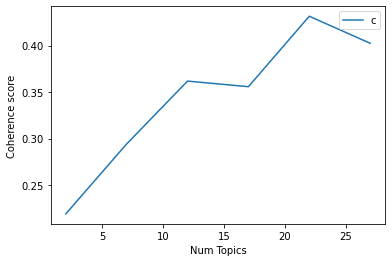

In [83]:
# Plot to see coherence score in order to choose optimal number of topics and decide optimal model
limit=30; start=2; step=5;
x = range(start, limit, step)
plt.plot(x, coherence_values_ph_score4)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [84]:
# Print the coherence scores
index = 0
for m, cv in zip(x, coherence_values_ph_score4):
    print("index:",index,"|","Num Topics =", m, " has Coherence Value of", round(cv, 4))
    index = index + 1

# optimal num_topics =  22

index: 0 | Num Topics = 2  has Coherence Value of 0.2191
index: 1 | Num Topics = 7  has Coherence Value of 0.2943
index: 2 | Num Topics = 12  has Coherence Value of 0.3618
index: 3 | Num Topics = 17  has Coherence Value of 0.3558
index: 4 | Num Topics = 22  has Coherence Value of 0.4314
index: 5 | Num Topics = 27  has Coherence Value of 0.4024


In [172]:
# Select optimal number of topics
optimal_model_ph_score4 = model_list_ph_score4[4]

In [173]:
# pyLDAVis
pyLDAvis.enable_notebook()
vis_ph_score4 = pyLDAvis.gensim_models.prepare(optimal_model_ph_score4, corpus_ph_score4, id2word_ph_score4)

In [174]:
print("pyLDAVis for ph topics for score=4:")
vis_ph_score4

pyLDAVis for ph topics for score=4:


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5      0.110133  0.120015       1        1  14.227071
10     0.141512 -0.081915       2        1  10.426799
9      0.154300 -0.085347       3        1   9.880824
7      0.052882  0.036729       4        1   9.213352
1      0.063781 -0.119849       5        1   6.291641
11     0.027907  0.058985       6        1   6.052893
2      0.106214  0.111279       7        1   4.793064
15     0.038335 -0.091857       8        1   4.667468
8     -0.059287 -0.095456       9        1   4.206119
0      0.087548  0.052574      10        1   4.102250
20     0.041546  0.074582      11        1   3.884964
17     0.057429 -0.038054      12        1   3.626770
4     -0.024497 -0.001109      13        1   2.975051
16    -0.058343  0.119773      14        1   2.899630
6     -0.100588  0.008501      15        1   2.333501
19    -0.087143  0.066609      16        1   2.116385
12    -0.086157  0.017198      17        1   1.951929
14    -0.108308 -0.045401      18        1   1.914406
3     -0.058452 -0.092752      19        1   1.647985
18    -0.116603  0.010743      20        1   1.000679
21    -0.085032 -0.025663      21        1   1.000679
13    -0.097175  0.000417      22        1   0.786541, topic_info=         Term       Freq      Total Category  logprob  loglift
18   facebook  49.000000  49.000000  Default  30.0000  30.0000
223    people  13.000000  13.000000  Default  29.0000  29.0000
95     option  14.000000  14.000000  Default  28.0000  28.0000
165       log  17.000000  17.000000  Default  27.0000  27.0000
7       photo  15.000000  15.000000  Default  26.0000  26.0000
..        ...        ...        ...      ...      ...      ...
15       chat   0.017455   3.791880  Topic22  -6.9556  -0.5357
16      click   0.017455   9.077135  Topic22  -6.9556  -1.4086
17     device   0.017455   6.333652  Topic22  -6.9556  -1.0487
18   facebook   0.017455  49.992400  Topic22  -6.9556  -3.1147
20       hack   0.017455   3.560066  Topic22  -6.9556  -0.4726

[1092 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
423       3  0.645632  ability
379       4  0.180545     able
379       6  0.180545     able
379       9  0.361089     able
379      16  0.180545     able
...     ...       ...      ...
411       3  0.178898     year
411       7  0.178898     year
411      15  0.178898     year
442       3  0.645632     yout
283      13  0.728207    youuu

[1320 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 11, 10, 8, 2, 12, 3, 16, 9, 1, 21, 18, 5, 17, 7, 20, 13, 15, 4, 19, 22, 14])

## LDA Topic Modelling (Rating = 5)

In [88]:
# By-rating Topic Modelling - rating = 5
# Convert to list - move to each section
review_ph_score5 = facebook_ios_ph_review_YearMonth_score5.review.values.tolist()
review_words_ph_score5 = list(sent_to_words(review_ph_score5))
print(review_words_ph_score5[:1])

[['bring', 'back', 'the', 'old', 'video', 'chain', 'settings', 'the', 'updated', 'version', 'is', 'more', 'inconvenient', 'and', 'cant', 'see', 'the', 'subtitles', 'when', 'video', 'is', 'ending', 'because', 'of', 'the', 'up', 'next', 'bar', 'that', 'shows']]


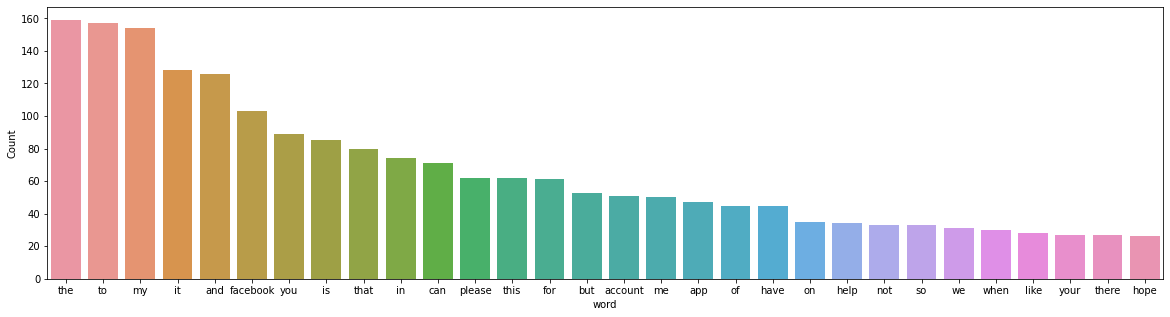

In [89]:
# Inspect the frequency of words before cleaning
freq_words(flatten(review_words_ph_score5))

In [90]:
# Clean text
review_ph_ready_score5 = process_words(review_words_ph_score5)  # processed Text Data! - move to each section

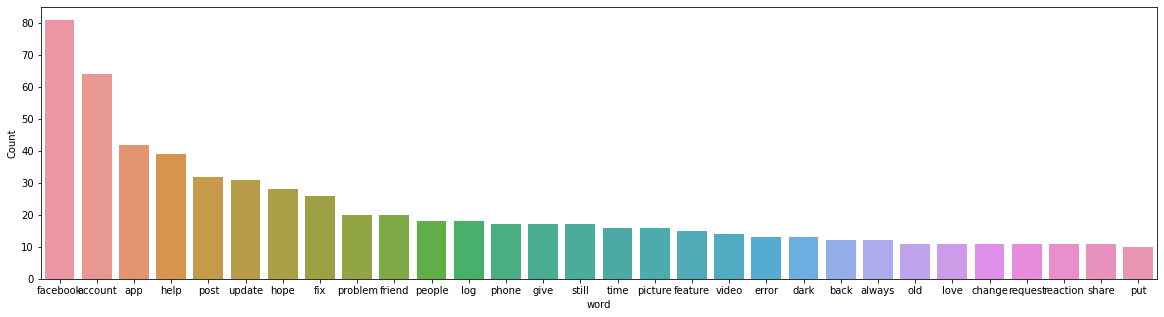

In [91]:
# Inspect the frequency of words after cleaning
freq_words(flatten(review_ph_ready_score5))


In [92]:
# Create Dictionary
id2word_ph_score5 = corpora.Dictionary(review_ph_ready_score5)

2021-10-16 18:42:54,905 [INFO] gensim.corpora.dictionary - adding document #0 to Dictionary(0 unique tokens: [])
2021-10-16 18:42:54,917 [INFO] gensim.corpora.dictionary - built Dictionary(649 unique tokens: ['back', 'bar', 'bring', 'chain', 'end']...) from 104 documents (total 1954 corpus positions)
2021-10-16 18:42:54,919 [INFO] gensim.utils - Dictionary lifecycle event {'msg': "built Dictionary(649 unique tokens: ['back', 'bar', 'bring', 'chain', 'end']...) from 104 documents (total 1954 corpus positions)", 'datetime': '2021-10-16T18:42:54.919174', 'gensim': '4.1.2', 'python': '3.8.8 (default, Apr 13 2021, 12:59:45) \n[Clang 10.0.0 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'created'}


In [93]:
# Create Corpus: Term Document Frequency
corpus_ph_score5 = [id2word_ph_score5.doc2bow(text) for text in review_ph_ready_score5]

In [94]:
# Training LDA model
model_list_ph_score5, coherence_values_ph_score5 = compute_coherence_values(dictionary=id2word_ph_score5, corpus=corpus_ph_score5, 
                                                              texts=review_ph_ready_score5, limit=30, start=2, step=5)


2021-10-16 18:42:54,948 [INFO] gensim.models.ldamodel - using symmetric alpha at 0.5
2021-10-16 18:42:54,950 [INFO] gensim.models.ldamodel - using symmetric eta at 0.5
2021-10-16 18:42:54,979 [INFO] gensim.models.ldamodel - using serial LDA version on this node
2021-10-16 18:42:54,983 [INFO] gensim.models.ldamodel - running online (multi-pass) LDA training, 2 topics, 50 passes over the supplied corpus of 104 documents, updating model once every 104 documents, evaluating perplexity every 104 documents, iterating 50x with a convergence threshold of 0.001000
2021-10-16 18:42:55,578 [INFO] gensim.models.ldamodel - -7.109 per-word bound, 138.1 perplexity estimate based on a held-out corpus of 104 documents with 1954 words
2021-10-16 18:42:55,586 [INFO] gensim.models.ldamodel - PROGRESS: pass 0, at document #104/104
2021-10-16 18:42:55,981 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.035*"facebook" + 0.026*"account" + 0.018*"help" + 0.015*"fix" + 0.014*"hope" + 0.012*"update" + 0.009*

2021-10-16 18:42:59,845 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.033*"facebook" + 0.032*"account" + 0.021*"help" + 0.015*"hope" + 0.014*"fix" + 0.012*"update" + 0.011*"error" + 0.010*"log" + 0.008*"reaction" + 0.008*"always"
2021-10-16 18:42:59,846 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.030*"facebook" + 0.027*"app" + 0.022*"post" + 0.019*"account" + 0.013*"update" + 0.011*"friend" + 0.011*"help" + 0.011*"problem" + 0.010*"phone" + 0.009*"time"
2021-10-16 18:42:59,850 [INFO] gensim.models.ldamodel - topic diff=0.006652, rho=0.301511
2021-10-16 18:43:00,078 [INFO] gensim.models.ldamodel - -6.197 per-word bound, 73.4 perplexity estimate based on a held-out corpus of 104 documents with 1954 words
2021-10-16 18:43:00,080 [INFO] gensim.models.ldamodel - PROGRESS: pass 10, at document #104/104
2021-10-16 18:43:00,240 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.033*"facebook" + 0.032*"account" + 0.021*"help" + 0.015*"hope" + 0.014*"fix" + 0.012*"update" + 0.011*

2021-10-16 18:43:03,741 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.033*"facebook" + 0.033*"account" + 0.020*"help" + 0.016*"hope" + 0.014*"fix" + 0.012*"update" + 0.011*"error" + 0.010*"log" + 0.009*"dark" + 0.008*"always"
2021-10-16 18:43:03,744 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.030*"facebook" + 0.028*"app" + 0.022*"post" + 0.018*"account" + 0.013*"update" + 0.011*"friend" + 0.011*"help" + 0.011*"problem" + 0.010*"phone" + 0.009*"time"
2021-10-16 18:43:03,747 [INFO] gensim.models.ldamodel - topic diff=0.003955, rho=0.218218
2021-10-16 18:43:03,970 [INFO] gensim.models.ldamodel - -6.194 per-word bound, 73.2 perplexity estimate based on a held-out corpus of 104 documents with 1954 words
2021-10-16 18:43:03,971 [INFO] gensim.models.ldamodel - PROGRESS: pass 20, at document #104/104
2021-10-16 18:43:04,073 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.033*"facebook" + 0.033*"account" + 0.020*"help" + 0.016*"hope" + 0.014*"fix" + 0.012*"update" + 0.011*"err

2021-10-16 18:43:07,416 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.030*"facebook" + 0.028*"app" + 0.022*"post" + 0.018*"account" + 0.012*"update" + 0.012*"friend" + 0.011*"help" + 0.010*"problem" + 0.010*"time" + 0.009*"phone"
2021-10-16 18:43:07,420 [INFO] gensim.models.ldamodel - topic diff=0.003214, rho=0.179605
2021-10-16 18:43:07,616 [INFO] gensim.models.ldamodel - -6.189 per-word bound, 72.9 perplexity estimate based on a held-out corpus of 104 documents with 1954 words
2021-10-16 18:43:07,619 [INFO] gensim.models.ldamodel - PROGRESS: pass 30, at document #104/104
2021-10-16 18:43:07,769 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.033*"facebook" + 0.032*"account" + 0.020*"help" + 0.016*"hope" + 0.014*"fix" + 0.012*"update" + 0.011*"error" + 0.011*"dark" + 0.010*"log" + 0.008*"always"
2021-10-16 18:43:07,781 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.030*"facebook" + 0.028*"app" + 0.022*"post" + 0.019*"account" + 0.012*"update" + 0.012*"friend" + 0.011*"h

2021-10-16 18:43:11,005 [INFO] gensim.models.ldamodel - topic diff=0.002580, rho=0.156174
2021-10-16 18:43:11,215 [INFO] gensim.models.ldamodel - -6.186 per-word bound, 72.8 perplexity estimate based on a held-out corpus of 104 documents with 1954 words
2021-10-16 18:43:11,217 [INFO] gensim.models.ldamodel - PROGRESS: pass 40, at document #104/104
2021-10-16 18:43:11,391 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.033*"facebook" + 0.032*"account" + 0.020*"help" + 0.016*"hope" + 0.013*"fix" + 0.012*"update" + 0.011*"dark" + 0.011*"error" + 0.011*"log" + 0.008*"mode"
2021-10-16 18:43:11,395 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.030*"facebook" + 0.027*"app" + 0.023*"post" + 0.019*"account" + 0.012*"update" + 0.012*"friend" + 0.011*"help" + 0.010*"problem" + 0.010*"time" + 0.009*"phone"
2021-10-16 18:43:11,397 [INFO] gensim.models.ldamodel - topic diff=0.002621, rho=0.154303
2021-10-16 18:43:11,550 [INFO] gensim.models.ldamodel - -6.186 per-word bound, 72.8 perplexity

2021-10-16 18:43:15,051 [INFO] gensim.utils - LdaModel lifecycle event {'msg': 'trained LdaModel(num_terms=649, num_topics=2, decay=0.5, chunksize=1000) in 20.07s', 'datetime': '2021-10-16T18:43:15.051268', 'gensim': '4.1.2', 'python': '3.8.8 (default, Apr 13 2021, 12:59:45) \n[Clang 10.0.0 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'created'}
2021-10-16 18:43:15,056 [INFO] gensim.topic_coherence.probability_estimation - using ParallelWordOccurrenceAccumulator(processes=7, batch_size=64) to estimate probabilities from sliding windows
2021-10-16 18:43:20,235 [INFO] gensim.topic_coherence.text_analysis - 7 accumulators retrieved from output queue
2021-10-16 18:43:20,284 [INFO] gensim.topic_coherence.text_analysis - accumulated word occurrence stats for 103 virtual documents
2021-10-16 18:43:20,594 [INFO] gensim.models.ldamodel - using symmetric alpha at 0.14285714285714285
2021-10-16 18:43:20,595 [INFO] gensim.models.ldamodel - using symmetric eta at 0.14285714285714285
20

2021-10-16 18:43:23,359 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.046*"facebook" + 0.027*"app" + 0.022*"account" + 0.021*"fix" + 0.018*"update" + 0.015*"log" + 0.013*"keep" + 0.012*"error" + 0.011*"work" + 0.011*"version"
2021-10-16 18:43:23,361 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.024*"facebook" + 0.023*"account" + 0.019*"video" + 0.018*"watch" + 0.013*"update" + 0.013*"back" + 0.012*"bring" + 0.012*"able" + 0.011*"people" + 0.011*"name"
2021-10-16 18:43:23,362 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.036*"care" + 0.036*"reaction" + 0.025*"account" + 0.024*"io" + 0.018*"app" + 0.018*"dark" + 0.018*"mode" + 0.017*"great" + 0.013*"ad" + 0.013*"datum"
2021-10-16 18:43:23,363 [INFO] gensim.models.ldamodel - topic diff=0.067107, rho=0.408248
2021-10-16 18:43:23,571 [INFO] gensim.models.ldamodel - -6.437 per-word bound, 86.6 perplexity estimate based on a held-out corpus of 104 documents with 1954 words
2021-10-16 18:43:23,574 [INFO] gensim.models.ldamode

2021-10-16 18:43:25,244 [INFO] gensim.models.ldamodel - topic diff=0.016251, rho=0.301511
2021-10-16 18:43:25,464 [INFO] gensim.models.ldamodel - -6.417 per-word bound, 85.4 perplexity estimate based on a held-out corpus of 104 documents with 1954 words
2021-10-16 18:43:25,465 [INFO] gensim.models.ldamodel - PROGRESS: pass 10, at document #104/104
2021-10-16 18:43:25,584 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.037*"facebook" + 0.032*"help" + 0.021*"account" + 0.020*"fix" + 0.017*"hope" + 0.017*"picture" + 0.014*"already" + 0.013*"log" + 0.013*"update" + 0.012*"error"
2021-10-16 18:43:25,590 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.040*"app" + 0.032*"post" + 0.027*"facebook" + 0.017*"friend" + 0.015*"phone" + 0.015*"problem" + 0.015*"feature" + 0.013*"request" + 0.011*"people" + 0.011*"update"
2021-10-16 18:43:25,592 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.031*"post" + 0.024*"facebook" + 0.021*"give" + 0.019*"picture" + 0.017*"time" + 0.017*"share" + 0

2021-10-16 18:43:27,087 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.032*"post" + 0.024*"facebook" + 0.022*"give" + 0.020*"picture" + 0.018*"time" + 0.016*"share" + 0.012*"star" + 0.012*"problem" + 0.012*"fix" + 0.012*"consider"
2021-10-16 18:43:27,091 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.037*"facebook" + 0.032*"help" + 0.021*"account" + 0.020*"fix" + 0.017*"hope" + 0.017*"picture" + 0.014*"already" + 0.013*"update" + 0.013*"log" + 0.012*"error"
2021-10-16 18:43:27,094 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.065*"account" + 0.042*"help" + 0.040*"facebook" + 0.017*"hope" + 0.015*"back" + 0.014*"password" + 0.014*"friend" + 0.011*"phone" + 0.010*"update" + 0.010*"dark"
2021-10-16 18:43:27,098 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.024*"facebook" + 0.023*"video" + 0.021*"account" + 0.021*"watch" + 0.013*"update" + 0.013*"able" + 0.013*"bring" + 0.011*"people" + 0.011*"back" + 0.011*"put"
2021-10-16 18:43:27,099 [INFO] gensim.models.ldamodel -

2021-10-16 18:43:28,584 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.032*"post" + 0.024*"facebook" + 0.022*"give" + 0.020*"picture" + 0.018*"time" + 0.016*"share" + 0.012*"star" + 0.012*"fix" + 0.012*"problem" + 0.012*"consider"
2021-10-16 18:43:28,585 [INFO] gensim.models.ldamodel - topic diff=0.002043, rho=0.213201
2021-10-16 18:43:28,724 [INFO] gensim.models.ldamodel - -6.409 per-word bound, 85.0 perplexity estimate based on a held-out corpus of 104 documents with 1954 words
2021-10-16 18:43:28,725 [INFO] gensim.models.ldamodel - PROGRESS: pass 21, at document #104/104
2021-10-16 18:43:28,848 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.036*"reaction" + 0.036*"care" + 0.025*"account" + 0.025*"io" + 0.019*"dark" + 0.019*"app" + 0.019*"mode" + 0.019*"great" + 0.013*"hope" + 0.013*"ad"
2021-10-16 18:43:28,849 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.065*"account" + 0.042*"help" + 0.040*"facebook" + 0.018*"hope" + 0.016*"back" + 0.014*"password" + 0.014*"friend"

2021-10-16 18:43:30,276 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.032*"post" + 0.024*"facebook" + 0.022*"give" + 0.020*"picture" + 0.018*"time" + 0.016*"share" + 0.012*"star" + 0.012*"fix" + 0.012*"problem" + 0.012*"consider"
2021-10-16 18:43:30,278 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.037*"facebook" + 0.033*"help" + 0.021*"account" + 0.020*"fix" + 0.017*"hope" + 0.017*"picture" + 0.014*"already" + 0.013*"update" + 0.013*"log" + 0.012*"error"
2021-10-16 18:43:30,283 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.036*"reaction" + 0.036*"care" + 0.025*"account" + 0.025*"io" + 0.019*"dark" + 0.019*"app" + 0.019*"mode" + 0.019*"great" + 0.013*"hope" + 0.013*"ad"
2021-10-16 18:43:30,286 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.040*"app" + 0.032*"post" + 0.027*"facebook" + 0.017*"friend" + 0.015*"phone" + 0.015*"problem" + 0.015*"feature" + 0.013*"request" + 0.011*"people" + 0.011*"update"
2021-10-16 18:43:30,288 [INFO] gensim.models.ldamodel - topic 

2021-10-16 18:43:31,728 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.037*"facebook" + 0.033*"help" + 0.021*"account" + 0.020*"fix" + 0.017*"hope" + 0.017*"picture" + 0.014*"already" + 0.013*"update" + 0.013*"log" + 0.012*"error"
2021-10-16 18:43:31,734 [INFO] gensim.models.ldamodel - topic diff=0.000613, rho=0.174078
2021-10-16 18:43:31,885 [INFO] gensim.models.ldamodel - -6.407 per-word bound, 84.9 perplexity estimate based on a held-out corpus of 104 documents with 1954 words
2021-10-16 18:43:31,886 [INFO] gensim.models.ldamodel - PROGRESS: pass 32, at document #104/104
2021-10-16 18:43:31,994 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.065*"account" + 0.042*"help" + 0.040*"facebook" + 0.018*"hope" + 0.016*"back" + 0.014*"password" + 0.014*"friend" + 0.011*"phone" + 0.010*"update" + 0.010*"dark"
2021-10-16 18:43:31,997 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.024*"facebook" + 0.023*"video" + 0.021*"account" + 0.021*"watch" + 0.013*"update" + 0.013*"able" + 0

2021-10-16 18:43:33,385 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.037*"facebook" + 0.033*"help" + 0.021*"account" + 0.020*"fix" + 0.017*"hope" + 0.017*"picture" + 0.014*"already" + 0.013*"update" + 0.013*"log" + 0.012*"error"
2021-10-16 18:43:33,395 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.046*"facebook" + 0.029*"app" + 0.023*"account" + 0.020*"fix" + 0.019*"update" + 0.017*"work" + 0.015*"error" + 0.015*"log" + 0.014*"login" + 0.012*"keep"
2021-10-16 18:43:33,403 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.032*"post" + 0.024*"facebook" + 0.022*"give" + 0.020*"picture" + 0.018*"time" + 0.016*"share" + 0.012*"star" + 0.012*"fix" + 0.012*"problem" + 0.012*"consider"
2021-10-16 18:43:33,478 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.040*"app" + 0.032*"post" + 0.027*"facebook" + 0.017*"friend" + 0.015*"phone" + 0.015*"problem" + 0.015*"feature" + 0.013*"request" + 0.011*"update" + 0.011*"people"
2021-10-16 18:43:33,485 [INFO] gensim.models.ldamodel - t

2021-10-16 18:43:35,392 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.065*"account" + 0.042*"help" + 0.040*"facebook" + 0.018*"hope" + 0.016*"back" + 0.014*"password" + 0.014*"friend" + 0.011*"phone" + 0.010*"update" + 0.010*"dark"
2021-10-16 18:43:35,394 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.032*"post" + 0.024*"facebook" + 0.022*"give" + 0.020*"picture" + 0.018*"time" + 0.016*"share" + 0.012*"star" + 0.012*"fix" + 0.012*"problem" + 0.012*"consider"
2021-10-16 18:43:35,395 [INFO] gensim.models.ldamodel - topic diff=0.000408, rho=0.150756
2021-10-16 18:43:35,616 [INFO] gensim.models.ldamodel - -6.407 per-word bound, 84.8 perplexity estimate based on a held-out corpus of 104 documents with 1954 words
2021-10-16 18:43:35,618 [INFO] gensim.models.ldamodel - PROGRESS: pass 43, at document #104/104
2021-10-16 18:43:35,749 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.040*"app" + 0.032*"post" + 0.027*"facebook" + 0.017*"friend" + 0.015*"phone" + 0.015*"problem" + 0.0

2021-10-16 18:43:37,355 [INFO] gensim.models.ldamodel - PROGRESS: pass 48, at document #104/104
2021-10-16 18:43:37,400 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.036*"reaction" + 0.036*"care" + 0.025*"io" + 0.025*"account" + 0.019*"dark" + 0.019*"app" + 0.019*"mode" + 0.019*"great" + 0.013*"hope" + 0.013*"ad"
2021-10-16 18:43:37,401 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.040*"app" + 0.032*"post" + 0.027*"facebook" + 0.017*"friend" + 0.015*"phone" + 0.015*"problem" + 0.015*"feature" + 0.013*"request" + 0.011*"update" + 0.011*"people"
2021-10-16 18:43:37,403 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.037*"facebook" + 0.033*"help" + 0.021*"account" + 0.020*"fix" + 0.017*"hope" + 0.017*"picture" + 0.014*"already" + 0.013*"update" + 0.013*"log" + 0.012*"error"
2021-10-16 18:43:37,406 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.024*"facebook" + 0.023*"video" + 0.021*"account" + 0.021*"watch" + 0.013*"update" + 0.013*"able" + 0.013*"bring" + 0.011*"peop

2021-10-16 18:43:45,505 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.042*"facebook" + 0.040*"problem" + 0.032*"fix" + 0.021*"friend" + 0.020*"occur" + 0.020*"highlight" + 0.013*"help" + 0.013*"account" + 0.011*"already" + 0.011*"error"
2021-10-16 18:43:45,509 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.030*"facebook" + 0.030*"post" + 0.023*"watch" + 0.022*"app" + 0.022*"problem" + 0.022*"friend" + 0.021*"request" + 0.021*"log" + 0.018*"phone" + 0.014*"iphone"
2021-10-16 18:43:45,512 [INFO] gensim.models.ldamodel - topic diff=0.141957, rho=0.500000
2021-10-16 18:43:45,668 [INFO] gensim.models.ldamodel - -6.575 per-word bound, 95.3 perplexity estimate based on a held-out corpus of 104 documents with 1954 words
2021-10-16 18:43:45,669 [INFO] gensim.models.ldamodel - PROGRESS: pass 3, at document #104/104
2021-10-16 18:43:45,755 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.042*"facebook" + 0.030*"app" + 0.029*"update" + 0.024*"help" + 0.018*"loading" + 0.018*"dark" + 

2021-10-16 18:43:47,091 [INFO] gensim.models.ldamodel - PROGRESS: pass 8, at document #104/104
2021-10-16 18:43:47,180 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.049*"post" + 0.025*"video" + 0.025*"picture" + 0.025*"share" + 0.019*"option" + 0.019*"consider" + 0.019*"comment" + 0.019*"fix" + 0.017*"give" + 0.016*"facebook"
2021-10-16 18:43:47,184 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.056*"account" + 0.042*"help" + 0.036*"facebook" + 0.022*"hope" + 0.018*"app" + 0.016*"work" + 0.013*"fix" + 0.012*"update" + 0.012*"photo" + 0.011*"happen"
2021-10-16 18:43:47,186 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.032*"picture" + 0.026*"request" + 0.025*"people" + 0.025*"facebook" + 0.019*"grant" + 0.019*"information" + 0.013*"account" + 0.013*"avoid" + 0.013*"suggest" + 0.013*"profile"
2021-10-16 18:43:47,188 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.050*"account" + 0.027*"facebook" + 0.021*"day" + 0.021*"fix" + 0.017*"problem" + 0.017*"error" + 0.017*"

2021-10-16 18:43:48,872 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.041*"problem" + 0.041*"facebook" + 0.031*"fix" + 0.021*"friend" + 0.021*"highlight" + 0.021*"occur" + 0.011*"already" + 0.011*"turn" + 0.011*"update" + 0.011*"phone"
2021-10-16 18:43:48,875 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.030*"facebook" + 0.030*"post" + 0.026*"watch" + 0.021*"app" + 0.021*"problem" + 0.021*"friend" + 0.021*"request" + 0.021*"log" + 0.017*"phone" + 0.013*"iphone"
2021-10-16 18:43:48,878 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.040*"account" + 0.026*"facebook" + 0.019*"put" + 0.019*"name" + 0.016*"update" + 0.014*"watch" + 0.014*"option" + 0.014*"remove" + 0.014*"back" + 0.014*"email"
2021-10-16 18:43:48,880 [INFO] gensim.models.ldamodel - topic diff=0.005193, rho=0.258199
2021-10-16 18:43:49,034 [INFO] gensim.models.ldamodel - -6.526 per-word bound, 92.2 perplexity estimate based on a held-out corpus of 104 documents with 1954 words
2021-10-16 18:43:49,047 [INFO] g

2021-10-16 18:43:50,639 [INFO] gensim.models.ldamodel - topic diff=0.003017, rho=0.223607
2021-10-16 18:43:50,837 [INFO] gensim.models.ldamodel - -6.522 per-word bound, 91.9 perplexity estimate based on a held-out corpus of 104 documents with 1954 words
2021-10-16 18:43:50,839 [INFO] gensim.models.ldamodel - PROGRESS: pass 19, at document #104/104
2021-10-16 18:43:50,918 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.040*"account" + 0.026*"facebook" + 0.019*"put" + 0.019*"name" + 0.016*"update" + 0.014*"watch" + 0.014*"remove" + 0.014*"option" + 0.014*"back" + 0.014*"email"
2021-10-16 18:43:50,920 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.050*"account" + 0.027*"facebook" + 0.021*"day" + 0.021*"fix" + 0.017*"problem" + 0.017*"error" + 0.017*"update" + 0.017*"hope" + 0.017*"kid" + 0.013*"help"
2021-10-16 18:43:50,921 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.040*"facebook" + 0.030*"app" + 0.028*"update" + 0.024*"help" + 0.019*"loading" + 0.019*"dark" + 0.019*"hop

2021-10-16 18:43:52,623 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.038*"facebook" + 0.027*"fix" + 0.026*"problem" + 0.024*"friend" + 0.024*"highlight" + 0.012*"already" + 0.012*"turn" + 0.012*"update" + 0.012*"phone" + 0.012*"share"
2021-10-16 18:43:52,629 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.040*"account" + 0.026*"facebook" + 0.019*"put" + 0.019*"name" + 0.016*"update" + 0.014*"watch" + 0.014*"remove" + 0.014*"option" + 0.014*"back" + 0.014*"email"
2021-10-16 18:43:52,635 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.050*"account" + 0.027*"facebook" + 0.021*"day" + 0.021*"fix" + 0.017*"problem" + 0.017*"error" + 0.017*"update" + 0.017*"hope" + 0.017*"kid" + 0.013*"help"
2021-10-16 18:43:52,639 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.032*"picture" + 0.026*"request" + 0.026*"people" + 0.026*"facebook" + 0.019*"grant" + 0.019*"information" + 0.013*"account" + 0.013*"avoid" + 0.013*"suggest" + 0.013*"profile"
2021-10-16 18:43:52,645 [INFO] gensim

2021-10-16 18:43:53,877 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.037*"facebook" + 0.026*"fix" + 0.024*"friend" + 0.024*"highlight" + 0.018*"problem" + 0.013*"already" + 0.013*"update" + 0.013*"phone" + 0.013*"share" + 0.013*"turn"
2021-10-16 18:43:53,878 [INFO] gensim.models.ldamodel - topic diff=0.001281, rho=0.179605
2021-10-16 18:43:53,955 [INFO] gensim.models.ldamodel - -6.513 per-word bound, 91.3 perplexity estimate based on a held-out corpus of 104 documents with 1954 words
2021-10-16 18:43:53,956 [INFO] gensim.models.ldamodel - PROGRESS: pass 30, at document #104/104
2021-10-16 18:43:54,127 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.030*"update" + 0.030*"still" + 0.030*"facebook" + 0.024*"app" + 0.024*"account" + 0.018*"look" + 0.018*"fix" + 0.012*"time" + 0.012*"keep" + 0.012*"late"
2021-10-16 18:43:54,128 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.074*"dark" + 0.062*"mode" + 0.050*"io" + 0.025*"app" + 0.025*"star" + 0.013*"entertain" + 0.013*"give"

2021-10-16 18:43:55,619 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.040*"account" + 0.027*"facebook" + 0.019*"put" + 0.019*"name" + 0.016*"update" + 0.014*"watch" + 0.014*"remove" + 0.014*"option" + 0.014*"back" + 0.014*"email"
2021-10-16 18:43:55,620 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.050*"account" + 0.027*"facebook" + 0.021*"day" + 0.021*"fix" + 0.017*"error" + 0.017*"problem" + 0.017*"update" + 0.017*"hope" + 0.017*"kid" + 0.013*"help"
2021-10-16 18:43:55,622 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.030*"post" + 0.030*"facebook" + 0.026*"watch" + 0.021*"problem" + 0.021*"app" + 0.021*"friend" + 0.021*"request" + 0.021*"log" + 0.017*"phone" + 0.013*"iphone"
2021-10-16 18:43:55,623 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.028*"app" + 0.026*"facebook" + 0.022*"live" + 0.020*"time" + 0.018*"people" + 0.013*"love" + 0.013*"much" + 0.013*"already" + 0.011*"always" + 0.011*"fix"
2021-10-16 18:43:55,628 [INFO] gensim.models.ldamodel - topic #10

2021-10-16 18:43:56,878 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.032*"picture" + 0.026*"people" + 0.026*"request" + 0.026*"facebook" + 0.019*"grant" + 0.019*"information" + 0.013*"suggest" + 0.013*"profile" + 0.013*"medium" + 0.013*"avoid"
2021-10-16 18:43:56,881 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.030*"update" + 0.030*"still" + 0.030*"facebook" + 0.024*"app" + 0.024*"account" + 0.018*"look" + 0.018*"fix" + 0.012*"time" + 0.012*"keep" + 0.012*"late"
2021-10-16 18:43:56,882 [INFO] gensim.models.ldamodel - topic diff=0.000734, rho=0.154303
2021-10-16 18:43:57,133 [INFO] gensim.models.ldamodel - -6.511 per-word bound, 91.2 perplexity estimate based on a held-out corpus of 104 documents with 1954 words
2021-10-16 18:43:57,136 [INFO] gensim.models.ldamodel - PROGRESS: pass 41, at document #104/104
2021-10-16 18:43:57,227 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.030*"post" + 0.030*"facebook" + 0.026*"watch" + 0.021*"problem" + 0.021*"friend" + 0.021*"lo

2021-10-16 18:43:58,532 [INFO] gensim.models.ldamodel - -6.510 per-word bound, 91.2 perplexity estimate based on a held-out corpus of 104 documents with 1954 words
2021-10-16 18:43:58,539 [INFO] gensim.models.ldamodel - PROGRESS: pass 46, at document #104/104
2021-10-16 18:43:58,654 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.030*"still" + 0.030*"update" + 0.030*"facebook" + 0.024*"app" + 0.024*"account" + 0.018*"look" + 0.018*"fix" + 0.012*"time" + 0.012*"keep" + 0.012*"feature"
2021-10-16 18:43:58,656 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.049*"post" + 0.025*"share" + 0.025*"video" + 0.025*"picture" + 0.019*"option" + 0.019*"consider" + 0.019*"comment" + 0.019*"fix" + 0.017*"give" + 0.016*"facebook"
2021-10-16 18:43:58,659 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.040*"facebook" + 0.031*"update" + 0.029*"app" + 0.026*"help" + 0.022*"hope" + 0.019*"people" + 0.019*"dark" + 0.019*"mode" + 0.019*"loading" + 0.015*"react"
2021-10-16 18:43:58,663 [INFO] gens

2021-10-16 18:44:09,226 [INFO] gensim.models.ldamodel - topic #15 (0.059): 0.047*"account" + 0.021*"app" + 0.019*"home" + 0.019*"error" + 0.019*"date" + 0.019*"update" + 0.019*"unfriend" + 0.019*"facebook" + 0.019*"login" + 0.013*"ipad"
2021-10-16 18:44:09,229 [INFO] gensim.models.ldamodel - topic #1 (0.059): 0.044*"post" + 0.028*"app" + 0.027*"friend" + 0.026*"request" + 0.025*"facebook" + 0.020*"phone" + 0.018*"react" + 0.015*"visible" + 0.014*"iphone" + 0.013*"open"
2021-10-16 18:44:09,231 [INFO] gensim.models.ldamodel - topic #2 (0.059): 0.039*"post" + 0.028*"facebook" + 0.022*"reaction" + 0.018*"video" + 0.017*"picture" + 0.017*"fix" + 0.016*"name" + 0.016*"action" + 0.015*"still" + 0.014*"give"
2021-10-16 18:44:09,233 [INFO] gensim.models.ldamodel - topic diff=13.092698, rho=1.000000
2021-10-16 18:44:09,366 [INFO] gensim.models.ldamodel - -6.906 per-word bound, 120.0 perplexity estimate based on a held-out corpus of 104 documents with 1954 words
2021-10-16 18:44:09,369 [INFO] gen

2021-10-16 18:44:10,487 [INFO] gensim.models.ldamodel - topic diff=0.060683, rho=0.377964
2021-10-16 18:44:10,557 [INFO] gensim.models.ldamodel - -6.636 per-word bound, 99.4 perplexity estimate based on a held-out corpus of 104 documents with 1954 words
2021-10-16 18:44:10,558 [INFO] gensim.models.ldamodel - PROGRESS: pass 6, at document #104/104
2021-10-16 18:44:10,705 [INFO] gensim.models.ldamodel - topic #2 (0.059): 0.037*"post" + 0.027*"facebook" + 0.021*"reaction" + 0.016*"video" + 0.016*"picture" + 0.016*"fix" + 0.016*"name" + 0.016*"action" + 0.016*"still" + 0.016*"give"
2021-10-16 18:44:10,711 [INFO] gensim.models.ldamodel - topic #12 (0.059): 0.021*"save" + 0.021*"phone" + 0.021*"number" + 0.021*"change" + 0.021*"account" + 0.021*"look" + 0.021*"time" + 0.021*"information" + 0.014*"still" + 0.014*"password"
2021-10-16 18:44:10,713 [INFO] gensim.models.ldamodel - topic #10 (0.059): 0.034*"help" + 0.029*"account" + 0.026*"watch" + 0.022*"hope" + 0.020*"facebook" + 0.017*"video" 

2021-10-16 18:44:11,979 [INFO] gensim.models.ldamodel - topic #4 (0.059): 0.051*"account" + 0.044*"facebook" + 0.030*"io" + 0.030*"app" + 0.022*"hope" + 0.022*"dark" + 0.022*"mode" + 0.015*"old" + 0.015*"hack" + 0.015*"retrieve"
2021-10-16 18:44:11,980 [INFO] gensim.models.ldamodel - topic #10 (0.059): 0.034*"help" + 0.029*"account" + 0.026*"watch" + 0.022*"hope" + 0.020*"facebook" + 0.018*"video" + 0.018*"recover" + 0.018*"mom" + 0.013*"picture" + 0.013*"message"
2021-10-16 18:44:11,982 [INFO] gensim.models.ldamodel - topic #12 (0.059): 0.021*"save" + 0.021*"change" + 0.021*"account" + 0.021*"number" + 0.021*"phone" + 0.021*"look" + 0.021*"time" + 0.021*"information" + 0.014*"still" + 0.014*"password"
2021-10-16 18:44:11,983 [INFO] gensim.models.ldamodel - topic #7 (0.059): 0.073*"error" + 0.059*"log" + 0.051*"account" + 0.048*"login" + 0.044*"fix" + 0.037*"unexpected" + 0.037*"always" + 0.037*"occur" + 0.037*"problem" + 0.032*"facebook"
2021-10-16 18:44:11,984 [INFO] gensim.models.ld

2021-10-16 18:44:13,246 [INFO] gensim.models.ldamodel - topic #2 (0.059): 0.037*"post" + 0.027*"facebook" + 0.021*"reaction" + 0.016*"video" + 0.016*"picture" + 0.016*"fix" + 0.016*"name" + 0.016*"action" + 0.016*"still" + 0.016*"give"
2021-10-16 18:44:13,248 [INFO] gensim.models.ldamodel - topic diff=0.002702, rho=0.235702
2021-10-16 18:44:13,391 [INFO] gensim.models.ldamodel - -6.618 per-word bound, 98.2 perplexity estimate based on a held-out corpus of 104 documents with 1954 words
2021-10-16 18:44:13,396 [INFO] gensim.models.ldamodel - PROGRESS: pass 17, at document #104/104
2021-10-16 18:44:13,525 [INFO] gensim.models.ldamodel - topic #12 (0.059): 0.021*"number" + 0.021*"save" + 0.021*"change" + 0.021*"phone" + 0.021*"account" + 0.021*"look" + 0.021*"time" + 0.021*"information" + 0.014*"still" + 0.014*"password"
2021-10-16 18:44:13,556 [INFO] gensim.models.ldamodel - topic #9 (0.059): 0.046*"facebook" + 0.046*"update" + 0.046*"app" + 0.033*"loading" + 0.020*"always" + 0.020*"able"

2021-10-16 18:44:14,841 [INFO] gensim.models.ldamodel - topic #10 (0.059): 0.034*"help" + 0.029*"account" + 0.026*"watch" + 0.022*"hope" + 0.020*"facebook" + 0.018*"video" + 0.018*"recover" + 0.018*"mom" + 0.013*"picture" + 0.013*"message"
2021-10-16 18:44:14,847 [INFO] gensim.models.ldamodel - topic #3 (0.059): 0.026*"friend" + 0.026*"video" + 0.026*"bring" + 0.026*"back" + 0.024*"update" + 0.017*"highlight" + 0.017*"app" + 0.017*"well" + 0.017*"beat" + 0.017*"section"
2021-10-16 18:44:14,849 [INFO] gensim.models.ldamodel - topic #6 (0.059): 0.040*"facebook" + 0.040*"really" + 0.028*"app" + 0.014*"job" + 0.014*"ask" + 0.014*"wanna" + 0.014*"ummm" + 0.014*"mind" + 0.014*"thing" + 0.014*"game"
2021-10-16 18:44:14,853 [INFO] gensim.models.ldamodel - topic #2 (0.059): 0.037*"post" + 0.027*"facebook" + 0.021*"reaction" + 0.016*"video" + 0.016*"picture" + 0.016*"fix" + 0.016*"action" + 0.016*"name" + 0.016*"still" + 0.016*"give"
2021-10-16 18:44:14,858 [INFO] gensim.models.ldamodel - topic 

2021-10-16 18:44:16,159 [INFO] gensim.models.ldamodel - topic #14 (0.059): 0.043*"picture" + 0.038*"album" + 0.034*"photo" + 0.033*"facebook" + 0.030*"help" + 0.029*"hope" + 0.017*"upload" + 0.016*"fix" + 0.016*"account" + 0.016*"people"
2021-10-16 18:44:16,162 [INFO] gensim.models.ldamodel - topic #12 (0.059): 0.021*"number" + 0.021*"change" + 0.021*"account" + 0.021*"phone" + 0.021*"save" + 0.021*"look" + 0.021*"time" + 0.021*"information" + 0.014*"still" + 0.014*"help"
2021-10-16 18:44:16,164 [INFO] gensim.models.ldamodel - topic diff=0.000375, rho=0.185695
2021-10-16 18:44:16,331 [INFO] gensim.models.ldamodel - -6.616 per-word bound, 98.1 perplexity estimate based on a held-out corpus of 104 documents with 1954 words
2021-10-16 18:44:16,333 [INFO] gensim.models.ldamodel - PROGRESS: pass 28, at document #104/104
2021-10-16 18:44:16,386 [INFO] gensim.models.ldamodel - topic #10 (0.059): 0.034*"help" + 0.029*"account" + 0.026*"watch" + 0.022*"hope" + 0.020*"facebook" + 0.018*"video" +

2021-10-16 18:44:17,642 [INFO] gensim.models.ldamodel - -6.616 per-word bound, 98.1 perplexity estimate based on a held-out corpus of 104 documents with 1954 words
2021-10-16 18:44:17,647 [INFO] gensim.models.ldamodel - PROGRESS: pass 33, at document #104/104
2021-10-16 18:44:17,739 [INFO] gensim.models.ldamodel - topic #2 (0.059): 0.037*"post" + 0.027*"facebook" + 0.021*"reaction" + 0.016*"video" + 0.016*"picture" + 0.016*"fix" + 0.016*"action" + 0.016*"name" + 0.016*"still" + 0.016*"give"
2021-10-16 18:44:17,741 [INFO] gensim.models.ldamodel - topic #10 (0.059): 0.034*"help" + 0.029*"account" + 0.026*"watch" + 0.022*"hope" + 0.020*"facebook" + 0.018*"video" + 0.018*"recover" + 0.018*"mom" + 0.013*"picture" + 0.013*"friend"
2021-10-16 18:44:17,744 [INFO] gensim.models.ldamodel - topic #16 (0.059): 0.071*"facebook" + 0.033*"account" + 0.023*"update" + 0.020*"app" + 0.018*"love" + 0.015*"help" + 0.013*"post" + 0.013*"share" + 0.013*"fix" + 0.013*"put"
2021-10-16 18:44:17,746 [INFO] gens

2021-10-16 18:44:19,103 [INFO] gensim.models.ldamodel - topic #0 (0.059): 0.034*"update" + 0.034*"still" + 0.023*"fix" + 0.023*"hope" + 0.023*"late" + 0.023*"iphone" + 0.023*"story" + 0.023*"user" + 0.023*"check" + 0.012*"facebook"
2021-10-16 18:44:19,110 [INFO] gensim.models.ldamodel - topic #12 (0.059): 0.021*"save" + 0.021*"change" + 0.021*"account" + 0.021*"number" + 0.021*"phone" + 0.021*"look" + 0.021*"time" + 0.021*"information" + 0.014*"still" + 0.014*"location"
2021-10-16 18:44:19,115 [INFO] gensim.models.ldamodel - topic #8 (0.059): 0.038*"facebook" + 0.024*"account" + 0.019*"back" + 0.019*"update" + 0.019*"feature" + 0.019*"kid" + 0.014*"help" + 0.014*"still" + 0.014*"profile" + 0.014*"old"
2021-10-16 18:44:19,117 [INFO] gensim.models.ldamodel - topic diff=0.000137, rho=0.158114
2021-10-16 18:44:19,258 [INFO] gensim.models.ldamodel - -6.616 per-word bound, 98.1 perplexity estimate based on a held-out corpus of 104 documents with 1954 words
2021-10-16 18:44:19,262 [INFO] gens

2021-10-16 18:44:20,874 [INFO] gensim.models.ldamodel - topic diff=0.000107, rho=0.149071
2021-10-16 18:44:21,094 [INFO] gensim.models.ldamodel - -6.616 per-word bound, 98.1 perplexity estimate based on a held-out corpus of 104 documents with 1954 words
2021-10-16 18:44:21,095 [INFO] gensim.models.ldamodel - PROGRESS: pass 44, at document #104/104
2021-10-16 18:44:21,220 [INFO] gensim.models.ldamodel - topic #14 (0.059): 0.043*"picture" + 0.038*"album" + 0.035*"photo" + 0.033*"facebook" + 0.030*"help" + 0.029*"hope" + 0.021*"upload" + 0.016*"fix" + 0.016*"people" + 0.016*"account"
2021-10-16 18:44:21,223 [INFO] gensim.models.ldamodel - topic #16 (0.059): 0.071*"facebook" + 0.033*"account" + 0.023*"update" + 0.020*"app" + 0.018*"love" + 0.015*"help" + 0.013*"post" + 0.013*"share" + 0.013*"fix" + 0.013*"put"
2021-10-16 18:44:21,227 [INFO] gensim.models.ldamodel - topic #2 (0.059): 0.037*"post" + 0.027*"facebook" + 0.021*"reaction" + 0.016*"name" + 0.016*"action" + 0.016*"video" + 0.016*"

2021-10-16 18:44:22,750 [INFO] gensim.models.ldamodel - topic #16 (0.059): 0.071*"facebook" + 0.033*"account" + 0.023*"update" + 0.020*"app" + 0.018*"love" + 0.015*"help" + 0.013*"post" + 0.013*"share" + 0.013*"fix" + 0.013*"put"
2021-10-16 18:44:22,757 [INFO] gensim.models.ldamodel - topic #3 (0.059): 0.026*"friend" + 0.026*"video" + 0.026*"bring" + 0.026*"back" + 0.024*"update" + 0.017*"app" + 0.017*"highlight" + 0.017*"well" + 0.017*"beat" + 0.017*"section"
2021-10-16 18:44:22,762 [INFO] gensim.models.ldamodel - topic #2 (0.059): 0.037*"post" + 0.027*"facebook" + 0.021*"reaction" + 0.016*"action" + 0.016*"name" + 0.016*"fix" + 0.016*"still" + 0.016*"give" + 0.016*"video" + 0.016*"time"
2021-10-16 18:44:22,765 [INFO] gensim.models.ldamodel - topic #8 (0.059): 0.038*"facebook" + 0.024*"account" + 0.019*"back" + 0.019*"update" + 0.019*"feature" + 0.019*"kid" + 0.014*"help" + 0.014*"frame" + 0.014*"old" + 0.014*"profile"
2021-10-16 18:44:22,766 [INFO] gensim.models.ldamodel - topic diff

2021-10-16 18:44:32,918 [INFO] gensim.models.ldamodel - topic #18 (0.045): 0.036*"live" + 0.024*"feature" + 0.024*"location" + 0.024*"accurate" + 0.024*"button" + 0.024*"log" + 0.024*"layout" + 0.024*"still" + 0.024*"bug" + 0.024*"post"
2021-10-16 18:44:32,924 [INFO] gensim.models.ldamodel - topic diff=0.111586, rho=0.447214
2021-10-16 18:44:33,022 [INFO] gensim.models.ldamodel - -6.717 per-word bound, 105.2 perplexity estimate based on a held-out corpus of 104 documents with 1954 words
2021-10-16 18:44:33,023 [INFO] gensim.models.ldamodel - PROGRESS: pass 4, at document #104/104
2021-10-16 18:44:33,075 [INFO] gensim.models.ldamodel - topic #14 (0.045): 0.033*"notice" + 0.025*"time" + 0.025*"photo" + 0.025*"upload" + 0.017*"album" + 0.017*"app" + 0.017*"waste" + 0.017*"graduation" + 0.017*"give" + 0.017*"hope"
2021-10-16 18:44:33,077 [INFO] gensim.models.ldamodel - topic #5 (0.045): 0.060*"dark" + 0.060*"io" + 0.060*"mode" + 0.041*"app" + 0.021*"entertain" + 0.021*"available" + 0.021*"

2021-10-16 18:44:34,475 [INFO] gensim.models.ldamodel - topic #0 (0.045): 0.055*"facebook" + 0.032*"fb" + 0.024*"fix" + 0.024*"log" + 0.024*"problem" + 0.024*"error" + 0.024*"account" + 0.023*"update" + 0.016*"year" + 0.016*"occur"
2021-10-16 18:44:34,478 [INFO] gensim.models.ldamodel - topic #19 (0.045): 0.043*"app" + 0.042*"facebook" + 0.036*"update" + 0.024*"account" + 0.024*"react" + 0.024*"loading" + 0.018*"phone" + 0.018*"change" + 0.014*"work" + 0.012*"help"
2021-10-16 18:44:34,481 [INFO] gensim.models.ldamodel - topic #3 (0.045): 0.049*"information" + 0.033*"option" + 0.017*"facebook" + 0.017*"iphone" + 0.017*"album" + 0.017*"move" + 0.017*"find" + 0.017*"add" + 0.017*"app" + 0.017*"photo"
2021-10-16 18:44:34,483 [INFO] gensim.models.ldamodel - topic #8 (0.045): 0.038*"kid" + 0.028*"edit" + 0.028*"post" + 0.028*"fix" + 0.019*"account" + 0.019*"register" + 0.019*"adult" + 0.019*"age" + 0.019*"let" + 0.019*"help"
2021-10-16 18:44:34,484 [INFO] gensim.models.ldamodel - topic diff=

2021-10-16 18:44:35,742 [INFO] gensim.models.ldamodel - topic #17 (0.045): 0.073*"back" + 0.037*"bring" + 0.037*"old" + 0.028*"update" + 0.028*"video" + 0.026*"remove" + 0.018*"feature" + 0.018*"friend" + 0.012*"account" + 0.009*"hope"
2021-10-16 18:44:35,744 [INFO] gensim.models.ldamodel - topic diff=0.005042, rho=0.250000
2021-10-16 18:44:35,873 [INFO] gensim.models.ldamodel - -6.654 per-word bound, 100.7 perplexity estimate based on a held-out corpus of 104 documents with 1954 words
2021-10-16 18:44:35,874 [INFO] gensim.models.ldamodel - PROGRESS: pass 15, at document #104/104
2021-10-16 18:44:35,979 [INFO] gensim.models.ldamodel - topic #3 (0.045): 0.049*"information" + 0.033*"option" + 0.017*"facebook" + 0.017*"iphone" + 0.017*"photo" + 0.017*"add" + 0.017*"move" + 0.017*"app" + 0.017*"find" + 0.017*"album"
2021-10-16 18:44:35,981 [INFO] gensim.models.ldamodel - topic #11 (0.045): 0.049*"post" + 0.044*"request" + 0.033*"picture" + 0.033*"watch" + 0.027*"friend" + 0.022*"grant" + 0

2021-10-16 18:44:37,687 [INFO] gensim.models.ldamodel - topic #0 (0.045): 0.055*"facebook" + 0.031*"fb" + 0.024*"fix" + 0.024*"log" + 0.024*"problem" + 0.024*"error" + 0.024*"account" + 0.024*"update" + 0.016*"year" + 0.016*"occur"
2021-10-16 18:44:37,690 [INFO] gensim.models.ldamodel - topic #11 (0.045): 0.049*"post" + 0.044*"request" + 0.033*"picture" + 0.033*"watch" + 0.027*"friend" + 0.022*"grant" + 0.022*"facebook" + 0.017*"video" + 0.017*"tell" + 0.017*"visible"
2021-10-16 18:44:37,693 [INFO] gensim.models.ldamodel - topic #15 (0.045): 0.027*"update" + 0.027*"app" + 0.018*"facebook" + 0.018*"already" + 0.018*"unfriend" + 0.018*"datum" + 0.018*"account" + 0.018*"fix" + 0.018*"error" + 0.018*"login"
2021-10-16 18:44:37,695 [INFO] gensim.models.ldamodel - topic #5 (0.045): 0.060*"io" + 0.060*"dark" + 0.060*"mode" + 0.041*"app" + 0.021*"available" + 0.021*"entertain" + 0.021*"give" + 0.021*"device" + 0.021*"setting" + 0.021*"wish"
2021-10-16 18:44:37,697 [INFO] gensim.models.ldamodel

2021-10-16 18:44:39,238 [INFO] gensim.models.ldamodel - topic #3 (0.045): 0.049*"information" + 0.033*"option" + 0.017*"facebook" + 0.017*"iphone" + 0.017*"app" + 0.017*"add" + 0.017*"move" + 0.017*"quick" + 0.017*"find" + 0.017*"photo"
2021-10-16 18:44:39,241 [INFO] gensim.models.ldamodel - topic #6 (0.045): 0.039*"app" + 0.039*"well" + 0.039*"update" + 0.026*"keep" + 0.026*"beat" + 0.026*"post" + 0.013*"log" + 0.013*"video" + 0.013*"late" + 0.013*"begin"
2021-10-16 18:44:39,242 [INFO] gensim.models.ldamodel - topic diff=0.000349, rho=0.192450
2021-10-16 18:44:39,393 [INFO] gensim.models.ldamodel - -6.653 per-word bound, 100.6 perplexity estimate based on a held-out corpus of 104 documents with 1954 words
2021-10-16 18:44:39,395 [INFO] gensim.models.ldamodel - PROGRESS: pass 26, at document #104/104
2021-10-16 18:44:39,508 [INFO] gensim.models.ldamodel - topic #9 (0.045): 0.030*"facebook" + 0.030*"able" + 0.020*"people" + 0.020*"app" + 0.020*"live" + 0.020*"feed" + 0.020*"reaction" + 

2021-10-16 18:44:40,952 [INFO] gensim.models.ldamodel - PROGRESS: pass 31, at document #104/104
2021-10-16 18:44:41,023 [INFO] gensim.models.ldamodel - topic #10 (0.045): 0.105*"account" + 0.057*"help" + 0.022*"facebook" + 0.022*"give" + 0.018*"hope" + 0.018*"fix" + 0.018*"mom" + 0.018*"care" + 0.018*"reaction" + 0.013*"friend"
2021-10-16 18:44:41,027 [INFO] gensim.models.ldamodel - topic #3 (0.045): 0.049*"information" + 0.033*"option" + 0.017*"facebook" + 0.017*"iphone" + 0.017*"app" + 0.017*"add" + 0.017*"move" + 0.017*"quick" + 0.017*"find" + 0.017*"photo"
2021-10-16 18:44:41,033 [INFO] gensim.models.ldamodel - topic #20 (0.045): 0.065*"way" + 0.052*"hope" + 0.026*"day" + 0.026*"safety" + 0.026*"ad" + 0.013*"unwanted" + 0.013*"icon" + 0.013*"help" + 0.013*"account" + 0.013*"privacy"
2021-10-16 18:44:41,040 [INFO] gensim.models.ldamodel - topic #1 (0.045): 0.052*"app" + 0.051*"facebook" + 0.046*"phone" + 0.029*"problem" + 0.029*"really" + 0.023*"iphone" + 0.023*"open" + 0.018*"thumb

2021-10-16 18:44:42,363 [INFO] gensim.models.ldamodel - topic #14 (0.045): 0.034*"notice" + 0.025*"time" + 0.025*"photo" + 0.025*"upload" + 0.017*"album" + 0.017*"waste" + 0.017*"app" + 0.017*"graduation" + 0.017*"give" + 0.017*"hope"
2021-10-16 18:44:42,365 [INFO] gensim.models.ldamodel - topic #21 (0.045): 0.036*"album" + 0.024*"facebook" + 0.024*"picture" + 0.024*"hope" + 0.024*"medium" + 0.024*"social" + 0.024*"recover" + 0.024*"delete" + 0.024*"photo" + 0.012*"video"
2021-10-16 18:44:42,367 [INFO] gensim.models.ldamodel - topic diff=0.000036, rho=0.162221
2021-10-16 18:44:42,480 [INFO] gensim.models.ldamodel - -6.653 per-word bound, 100.6 perplexity estimate based on a held-out corpus of 104 documents with 1954 words
2021-10-16 18:44:42,481 [INFO] gensim.models.ldamodel - PROGRESS: pass 37, at document #104/104
2021-10-16 18:44:42,523 [INFO] gensim.models.ldamodel - topic #16 (0.045): 0.076*"facebook" + 0.047*"help" + 0.030*"account" + 0.024*"people" + 0.018*"update" + 0.018*"hope

2021-10-16 18:44:43,763 [INFO] gensim.models.ldamodel - -6.653 per-word bound, 100.6 perplexity estimate based on a held-out corpus of 104 documents with 1954 words
2021-10-16 18:44:43,764 [INFO] gensim.models.ldamodel - PROGRESS: pass 42, at document #104/104
2021-10-16 18:44:43,851 [INFO] gensim.models.ldamodel - topic #17 (0.045): 0.073*"back" + 0.037*"bring" + 0.037*"old" + 0.028*"update" + 0.028*"video" + 0.026*"remove" + 0.018*"feature" + 0.018*"friend" + 0.012*"account" + 0.009*"hope"
2021-10-16 18:44:43,853 [INFO] gensim.models.ldamodel - topic #12 (0.045): 0.036*"save" + 0.036*"look" + 0.024*"game" + 0.024*"time" + 0.024*"still" + 0.024*"help" + 0.012*"list" + 0.012*"back" + 0.012*"old" + 0.012*"one"
2021-10-16 18:44:43,856 [INFO] gensim.models.ldamodel - topic #20 (0.045): 0.065*"way" + 0.052*"hope" + 0.026*"safety" + 0.026*"ad" + 0.026*"day" + 0.013*"unwanted" + 0.013*"icon" + 0.013*"help" + 0.013*"account" + 0.013*"privacy"
2021-10-16 18:44:43,860 [INFO] gensim.models.ldamo

2021-10-16 18:44:45,046 [INFO] gensim.models.ldamodel - topic #0 (0.045): 0.055*"facebook" + 0.031*"fb" + 0.024*"fix" + 0.024*"log" + 0.024*"problem" + 0.024*"error" + 0.024*"account" + 0.024*"update" + 0.016*"year" + 0.016*"occur"
2021-10-16 18:44:45,050 [INFO] gensim.models.ldamodel - topic #12 (0.045): 0.036*"save" + 0.036*"look" + 0.024*"game" + 0.024*"still" + 0.024*"time" + 0.024*"help" + 0.012*"list" + 0.012*"back" + 0.012*"old" + 0.012*"one"
2021-10-16 18:44:45,051 [INFO] gensim.models.ldamodel - topic #18 (0.045): 0.036*"live" + 0.024*"accurate" + 0.024*"location" + 0.024*"bug" + 0.024*"message" + 0.024*"button" + 0.024*"still" + 0.024*"feature" + 0.024*"post" + 0.024*"log"
2021-10-16 18:44:45,052 [INFO] gensim.models.ldamodel - topic diff=0.000013, rho=0.142857
2021-10-16 18:44:45,224 [INFO] gensim.models.ldamodel - -6.653 per-word bound, 100.6 perplexity estimate based on a held-out corpus of 104 documents with 1954 words
2021-10-16 18:44:45,225 [INFO] gensim.models.ldamodel

2021-10-16 18:44:56,660 [INFO] gensim.models.ldamodel - topic diff=0.187206, rho=0.577350
2021-10-16 18:44:56,789 [INFO] gensim.models.ldamodel - -6.914 per-word bound, 120.6 perplexity estimate based on a held-out corpus of 104 documents with 1954 words
2021-10-16 18:44:56,792 [INFO] gensim.models.ldamodel - PROGRESS: pass 2, at document #104/104
2021-10-16 18:44:56,870 [INFO] gensim.models.ldamodel - topic #10 (0.037): 0.055*"account" + 0.049*"help" + 0.029*"hope" + 0.028*"mom" + 0.022*"give" + 0.021*"update" + 0.021*"app" + 0.021*"back" + 0.015*"post" + 0.014*"important"
2021-10-16 18:44:56,871 [INFO] gensim.models.ldamodel - topic #18 (0.037): 0.037*"feature" + 0.037*"back" + 0.028*"friend" + 0.019*"location" + 0.019*"old" + 0.019*"accurate" + 0.019*"button" + 0.018*"heart" + 0.018*"reaction" + 0.018*"action"
2021-10-16 18:44:56,874 [INFO] gensim.models.ldamodel - topic #21 (0.037): 0.047*"facebook" + 0.046*"picture" + 0.045*"whenever" + 0.045*"post" + 0.024*"option" + 0.023*"reall

2021-10-16 18:44:58,136 [INFO] gensim.models.ldamodel - topic #10 (0.037): 0.057*"account" + 0.050*"help" + 0.029*"hope" + 0.029*"mom" + 0.022*"give" + 0.021*"update" + 0.021*"app" + 0.021*"back" + 0.014*"post" + 0.014*"important"
2021-10-16 18:44:58,139 [INFO] gensim.models.ldamodel - topic #16 (0.037): 0.056*"facebook" + 0.040*"account" + 0.032*"help" + 0.016*"friend" + 0.016*"share" + 0.016*"already" + 0.016*"turn" + 0.016*"iphone" + 0.016*"highlight" + 0.016*"section"
2021-10-16 18:44:58,141 [INFO] gensim.models.ldamodel - topic #0 (0.037): 0.055*"facebook" + 0.037*"give" + 0.028*"fix" + 0.027*"log" + 0.020*"medium" + 0.020*"social" + 0.020*"install" + 0.020*"datum" + 0.019*"hope" + 0.019*"love"
2021-10-16 18:44:58,144 [INFO] gensim.models.ldamodel - topic #4 (0.037): 0.085*"account" + 0.059*"facebook" + 0.040*"retrieve" + 0.030*"help" + 0.030*"hack" + 0.030*"fb" + 0.026*"email" + 0.020*"friend" + 0.020*"old" + 0.020*"time"
2021-10-16 18:44:58,145 [INFO] gensim.models.ldamodel - to

2021-10-16 18:44:59,279 [INFO] gensim.models.ldamodel - topic #18 (0.037): 0.039*"back" + 0.039*"feature" + 0.029*"friend" + 0.020*"old" + 0.020*"location" + 0.020*"accurate" + 0.020*"button" + 0.020*"heart" + 0.020*"reaction" + 0.020*"action"
2021-10-16 18:44:59,281 [INFO] gensim.models.ldamodel - topic diff=0.010781, rho=0.267261
2021-10-16 18:44:59,369 [INFO] gensim.models.ldamodel - -6.716 per-word bound, 105.1 perplexity estimate based on a held-out corpus of 104 documents with 1954 words
2021-10-16 18:44:59,370 [INFO] gensim.models.ldamodel - PROGRESS: pass 13, at document #104/104
2021-10-16 18:44:59,498 [INFO] gensim.models.ldamodel - topic #0 (0.037): 0.056*"facebook" + 0.042*"give" + 0.024*"fix" + 0.023*"medium" + 0.023*"social" + 0.021*"datum" + 0.021*"install" + 0.021*"hope" + 0.021*"love" + 0.021*"rent"
2021-10-16 18:44:59,499 [INFO] gensim.models.ldamodel - topic #18 (0.037): 0.039*"feature" + 0.039*"back" + 0.029*"friend" + 0.020*"old" + 0.020*"location" + 0.020*"accurat

2021-10-16 18:45:00,681 [INFO] gensim.models.ldamodel - topic #25 (0.037): 0.061*"facebook" + 0.026*"really" + 0.026*"love" + 0.026*"app" + 0.018*"safety" + 0.018*"thing" + 0.018*"help" + 0.018*"account" + 0.018*"update" + 0.018*"work"
2021-10-16 18:45:00,718 [INFO] gensim.models.ldamodel - topic #15 (0.037): 0.040*"app" + 0.040*"facebook" + 0.040*"update" + 0.030*"account" + 0.030*"already" + 0.030*"dark" + 0.020*"home" + 0.020*"date" + 0.020*"unfriend" + 0.020*"feature"
2021-10-16 18:45:00,719 [INFO] gensim.models.ldamodel - topic #10 (0.037): 0.057*"account" + 0.050*"help" + 0.029*"hope" + 0.029*"mom" + 0.022*"give" + 0.022*"update" + 0.022*"app" + 0.022*"back" + 0.014*"post" + 0.014*"important"
2021-10-16 18:45:00,721 [INFO] gensim.models.ldamodel - topic #20 (0.037): 0.035*"way" + 0.035*"hope" + 0.026*"account" + 0.026*"find" + 0.026*"upload" + 0.026*"photo" + 0.018*"picture" + 0.018*"recover" + 0.018*"day" + 0.018*"delete"
2021-10-16 18:45:00,722 [INFO] gensim.models.ldamodel - t

2021-10-16 18:45:01,952 [INFO] gensim.models.ldamodel - topic #21 (0.037): 0.050*"facebook" + 0.050*"picture" + 0.050*"whenever" + 0.050*"post" + 0.025*"option" + 0.025*"really" + 0.025*"fix" + 0.025*"consider" + 0.025*"great" + 0.025*"comment"
2021-10-16 18:45:01,959 [INFO] gensim.models.ldamodel - topic #24 (0.037): 0.042*"time" + 0.031*"app" + 0.031*"video" + 0.021*"facebook" + 0.021*"always" + 0.021*"watch" + 0.021*"give" + 0.021*"notice" + 0.021*"waste" + 0.021*"live"
2021-10-16 18:45:01,963 [INFO] gensim.models.ldamodel - topic diff=0.001757, rho=0.200000
2021-10-16 18:45:02,114 [INFO] gensim.models.ldamodel - -6.708 per-word bound, 104.5 perplexity estimate based on a held-out corpus of 104 documents with 1954 words
2021-10-16 18:45:02,115 [INFO] gensim.models.ldamodel - PROGRESS: pass 24, at document #104/104
2021-10-16 18:45:02,223 [INFO] gensim.models.ldamodel - topic #7 (0.037): 0.050*"watch" + 0.049*"facebook" + 0.047*"log" + 0.045*"fix" + 0.038*"account" + 0.035*"error" + 

2021-10-16 18:45:03,387 [INFO] gensim.models.ldamodel - PROGRESS: pass 29, at document #104/104
2021-10-16 18:45:03,482 [INFO] gensim.models.ldamodel - topic #1 (0.037): 0.060*"facebook" + 0.053*"post" + 0.030*"name" + 0.023*"share" + 0.023*"remove" + 0.023*"app" + 0.015*"fix" + 0.015*"account" + 0.015*"feature" + 0.015*"available"
2021-10-16 18:45:03,484 [INFO] gensim.models.ldamodel - topic #4 (0.037): 0.088*"account" + 0.059*"facebook" + 0.039*"retrieve" + 0.030*"help" + 0.030*"hack" + 0.030*"fb" + 0.030*"email" + 0.020*"friend" + 0.020*"old" + 0.020*"time"
2021-10-16 18:45:03,485 [INFO] gensim.models.ldamodel - topic #11 (0.037): 0.062*"request" + 0.047*"post" + 0.039*"friend" + 0.039*"picture" + 0.031*"grant" + 0.024*"visible" + 0.024*"facebook" + 0.024*"profile" + 0.016*"look" + 0.016*"except"
2021-10-16 18:45:03,486 [INFO] gensim.models.ldamodel - topic #17 (0.037): 0.034*"reaction" + 0.034*"care" + 0.034*"great" + 0.034*"ad" + 0.034*"phone" + 0.031*"number" + 0.031*"change" + 0

2021-10-16 18:45:04,862 [INFO] gensim.models.ldamodel - topic #0 (0.037): 0.056*"facebook" + 0.043*"give" + 0.024*"medium" + 0.024*"social" + 0.023*"fix" + 0.022*"datum" + 0.022*"hope" + 0.022*"love" + 0.022*"rent" + 0.022*"result"
2021-10-16 18:45:04,864 [INFO] gensim.models.ldamodel - topic #9 (0.037): 0.049*"app" + 0.033*"loading" + 0.033*"people" + 0.033*"facebook" + 0.033*"help" + 0.033*"react" + 0.025*"able" + 0.025*"update" + 0.017*"story" + 0.017*"click"
2021-10-16 18:45:04,865 [INFO] gensim.models.ldamodel - topic diff=0.000508, rho=0.166667
2021-10-16 18:45:04,990 [INFO] gensim.models.ldamodel - -6.705 per-word bound, 104.4 perplexity estimate based on a held-out corpus of 104 documents with 1954 words
2021-10-16 18:45:04,991 [INFO] gensim.models.ldamodel - PROGRESS: pass 35, at document #104/104
2021-10-16 18:45:05,109 [INFO] gensim.models.ldamodel - topic #7 (0.037): 0.048*"watch" + 0.048*"log" + 0.048*"facebook" + 0.047*"fix" + 0.041*"error" + 0.040*"account" + 0.028*"vide

2021-10-16 18:45:06,286 [INFO] gensim.models.ldamodel - PROGRESS: pass 40, at document #104/104
2021-10-16 18:45:06,346 [INFO] gensim.models.ldamodel - topic #16 (0.037): 0.056*"facebook" + 0.041*"account" + 0.032*"help" + 0.021*"wrong" + 0.016*"section" + 0.016*"turn" + 0.016*"already" + 0.016*"share" + 0.016*"much" + 0.016*"highlight"
2021-10-16 18:45:06,354 [INFO] gensim.models.ldamodel - topic #19 (0.037): 0.033*"still" + 0.033*"edit" + 0.022*"save" + 0.022*"look" + 0.022*"one" + 0.022*"layout" + 0.022*"log" + 0.022*"fix" + 0.022*"post" + 0.011*"remember"
2021-10-16 18:45:06,361 [INFO] gensim.models.ldamodel - topic #7 (0.037): 0.050*"fix" + 0.050*"log" + 0.047*"watch" + 0.046*"facebook" + 0.045*"error" + 0.041*"account" + 0.028*"help" + 0.027*"video" + 0.024*"unexpected" + 0.023*"problem"
2021-10-16 18:45:06,369 [INFO] gensim.models.ldamodel - topic #6 (0.037): 0.051*"facebook" + 0.041*"account" + 0.031*"update" + 0.031*"app" + 0.031*"fix" + 0.021*"late" + 0.021*"method" + 0.021*"

2021-10-16 18:45:07,629 [INFO] gensim.models.ldamodel - topic #13 (0.037): 0.050*"facebook" + 0.025*"problem" + 0.025*"live" + 0.025*"feed" + 0.025*"update" + 0.025*"app" + 0.025*"fb" + 0.025*"work" + 0.013*"account" + 0.013*"fix"
2021-10-16 18:45:07,633 [INFO] gensim.models.ldamodel - topic #0 (0.037): 0.056*"facebook" + 0.043*"give" + 0.024*"medium" + 0.024*"social" + 0.022*"fix" + 0.022*"datum" + 0.022*"hope" + 0.022*"love" + 0.022*"rent" + 0.022*"result"
2021-10-16 18:45:07,634 [INFO] gensim.models.ldamodel - topic #9 (0.037): 0.049*"app" + 0.033*"loading" + 0.033*"people" + 0.033*"facebook" + 0.033*"help" + 0.033*"react" + 0.025*"able" + 0.025*"update" + 0.017*"story" + 0.017*"always"
2021-10-16 18:45:07,636 [INFO] gensim.models.ldamodel - topic diff=0.001457, rho=0.145865
2021-10-16 18:45:07,845 [INFO] gensim.models.ldamodel - -6.696 per-word bound, 103.7 perplexity estimate based on a held-out corpus of 104 documents with 1954 words
2021-10-16 18:45:07,847 [INFO] gensim.models.l

In [95]:
%store model_list_ph_score5
%store coherence_values_ph_score5

Stored 'model_list_ph_score5' (list)
Stored 'coherence_values_ph_score5' (list)


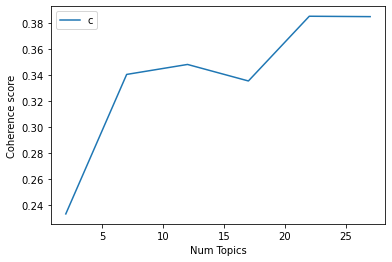

In [96]:
# Plot to see coherence score in order to choose optimal number of topics and decide optimal model
limit=30; start=2; step=5;
x = range(start, limit, step)
plt.plot(x, coherence_values_ph_score5)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [97]:
# Print the coherence scores
index = 0
for m, cv in zip(x, coherence_values_ph_score5):
    print("index:",index,"|","Num Topics =", m, " has Coherence Value of", round(cv, 4))
    index = index + 1

# optimal num_topics = 22

index: 0 | Num Topics = 2  has Coherence Value of 0.2335
index: 1 | Num Topics = 7  has Coherence Value of 0.3407
index: 2 | Num Topics = 12  has Coherence Value of 0.3483
index: 3 | Num Topics = 17  has Coherence Value of 0.3356
index: 4 | Num Topics = 22  has Coherence Value of 0.3854
index: 5 | Num Topics = 27  has Coherence Value of 0.3851


In [98]:
# Select optimal number of topics
optimal_model_ph_score5 = model_list_ph_score5[4]

In [99]:
# pyLDAVis
pyLDAvis.enable_notebook()
vis_ph_score5 = pyLDAvis.gensim_models.prepare(optimal_model_ph_score5, corpus_ph_score5, id2word_ph_score5)

In [100]:
print("pyLDAVis for ph topics for score=5:")
vis_ph_score5

pyLDAVis for ph topics for score=5:


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
10     0.123721 -0.025437       1        1  10.020294
4      0.075659 -0.010718       2        1   8.543801
11    -0.044808 -0.202150       3        1   7.911256
1     -0.005465  0.101464       4        1   7.180753
16     0.118700  0.079204       5        1   7.139762
19     0.068342  0.023773       6        1   6.811482
0      0.135988 -0.005479       7        1   5.051294
14    -0.133348  0.017369       8        1   4.764594
7      0.157613 -0.044834       9        1   4.258623
15     0.081572  0.072291      10        1   4.191100
17    -0.041062  0.067164      11        1   4.174579
8      0.038693 -0.103142      12        1   4.071854
9      0.000702  0.026481      13        1   3.765538
2     -0.059406 -0.154224      14        1   3.735067
21    -0.132057  0.015986      15        1   2.948135
12    -0.031254  0.007236      16        1   2.896578
18    -0.017574 -0.046153      17        1   2.853200
6     -0.054903  0.021133      18        1   2.539717
20    -0.028885  0.054849      19        1   2.495270
3     -0.105622  0.026090      20        1   1.820562
13    -0.059265  0.005777      21        1   1.573386
5     -0.087341  0.073321      22        1   1.253156, topic_info=         Term      Freq      Total Category  logprob  loglift
21    account  52.00000  52.000000  Default   30.000  30.0000
26       post  25.00000  25.000000  Default   29.000  29.0000
74        app  32.00000  32.000000  Default   28.000  28.0000
0        back   9.00000   9.000000  Default   27.000  27.0000
37   facebook  64.00000  64.000000  Default   26.000  26.0000
..        ...       ...        ...      ...      ...      ...
12    version   0.02204   6.858371  Topic22   -7.013  -1.3608
13      video   0.02204  11.492582  Topic22   -7.013  -1.8771
14     button   0.02204   2.768173  Topic22   -7.013  -0.4536
15  customize   0.02204   1.374311  Topic22   -7.013   0.2467
16    feature   0.02204  11.805356  Topic22   -7.013  -1.9039

[1053 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
396       1  0.195795    able
396       3  0.195795    able
396      13  0.391589    able
396      21  0.195795    able
293      13  0.694713  abroad
...     ...       ...     ...
55       14  0.210615   wrong
595      10  0.693252     yea
73        2  0.256362    year
73        5  0.256362    year
73        7  0.512725    year

[1321 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[11, 5, 12, 2, 17, 20, 1, 15, 8, 16, 18, 9, 10, 3, 22, 13, 19, 7, 21, 4, 14, 6])

## LDA Topic Modelling (Rating = 1,2,3)

In [101]:
# By-rating Topic Modelling - rating = 1,2,3
# Convert to list - move to each section
review_ph_score1N2N3 = facebook_ios_ph_review_YearMonth_score1N2N3.review.values.tolist()
review_words_ph_score1N2N3 = list(sent_to_words(review_ph_score1N2N3))
print(review_words_ph_score1N2N3[:1])

[['how', 'do', 'log', 'in', 'when', 'it', 'says', 'you', 'are', 'trying', 'too', 'often', 'am', 'attempting', 'to', 'log', 'in', 'to', 'facebook', 'using', 'the', 'app', 'on', 'my', 'iphone', 'everytime', 'type', 'in', 'the', 'email', 'and', 'password', 'it', 'says', 'am', 'trying', 'too', 'often', 'when', 'try', 'it', 'on', 'my', 'safari', 'browser', 'it', 'works', 'how', 'am', 'supposed', 'to', 'log', 'in', 'on', 'the', 'app', 'ive', 'tried', 'restarting', 'the', 'phone', 'and', 'uninstalling', 'the', 'app', 'still', 'doesnt', 'work']]


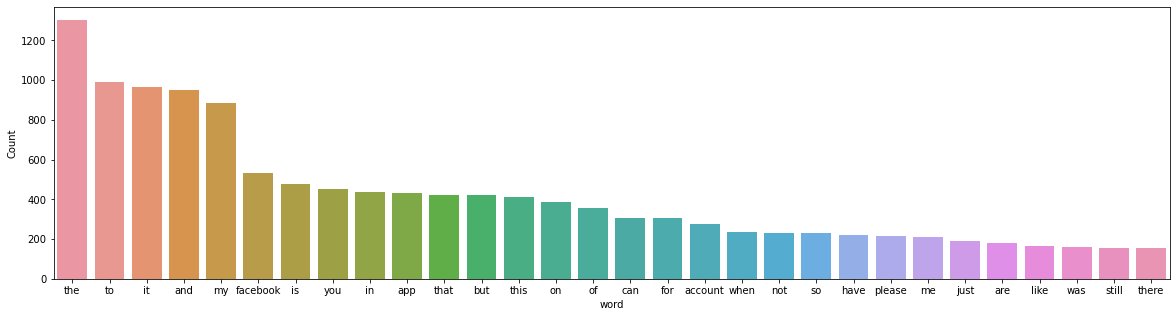

In [102]:
# Inspect the frequency of words before cleaning
freq_words(flatten(review_words_ph_score1N2N3))

In [103]:
# Clean text
review_ph_ready_score1N2N3 = process_words(review_words_ph_score1N2N3)  # processed Text Data! - move to each section

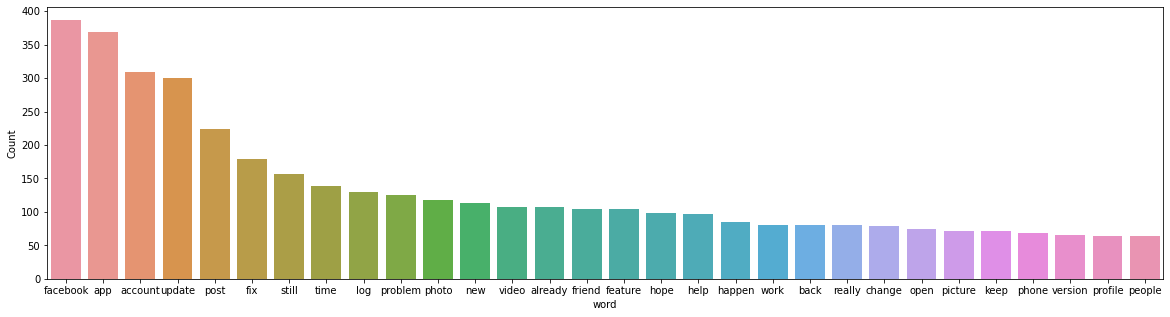

In [104]:
# Inspect the frequency of words after cleaning
freq_words(flatten(review_ph_ready_score1N2N3))


In [105]:
# Create Dictionary
id2word_ph_score1N2N3 = corpora.Dictionary(review_ph_ready_score1N2N3)

2021-10-16 18:45:36,707 [INFO] gensim.corpora.dictionary - adding document #0 to Dictionary(0 unique tokens: [])
2021-10-16 18:45:36,768 [INFO] gensim.corpora.dictionary - built Dictionary(1816 unique tokens: ['app', 'attempt', 'email', 'everytime', 'facebook']...) from 414 documents (total 12660 corpus positions)
2021-10-16 18:45:36,773 [INFO] gensim.utils - Dictionary lifecycle event {'msg': "built Dictionary(1816 unique tokens: ['app', 'attempt', 'email', 'everytime', 'facebook']...) from 414 documents (total 12660 corpus positions)", 'datetime': '2021-10-16T18:45:36.773742', 'gensim': '4.1.2', 'python': '3.8.8 (default, Apr 13 2021, 12:59:45) \n[Clang 10.0.0 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'created'}


In [106]:
# Create Corpus: Term Document Frequency
corpus_ph_score1N2N3 = [id2word_ph_score1N2N3.doc2bow(text) for text in review_ph_ready_score1N2N3]

In [107]:
# Training LDA model
model_list_ph_score1N2N3, coherence_values_ph_score1N2N3 = compute_coherence_values(dictionary=id2word_ph_score1N2N3, corpus=corpus_ph_score1N2N3, 
                                                              texts=review_ph_ready_score1N2N3, limit=30, start=2, step=5)


2021-10-16 18:45:36,858 [INFO] gensim.models.ldamodel - using symmetric alpha at 0.5
2021-10-16 18:45:36,860 [INFO] gensim.models.ldamodel - using symmetric eta at 0.5
2021-10-16 18:45:36,864 [INFO] gensim.models.ldamodel - using serial LDA version on this node
2021-10-16 18:45:36,866 [INFO] gensim.models.ldamodel - running online (multi-pass) LDA training, 2 topics, 50 passes over the supplied corpus of 414 documents, updating model once every 414 documents, evaluating perplexity every 414 documents, iterating 50x with a convergence threshold of 0.001000
2021-10-16 18:45:38,532 [INFO] gensim.models.ldamodel - -8.011 per-word bound, 258.0 perplexity estimate based on a held-out corpus of 414 documents with 12660 words
2021-10-16 18:45:38,559 [INFO] gensim.models.ldamodel - PROGRESS: pass 0, at document #414/414
2021-10-16 18:45:40,139 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.025*"facebook" + 0.025*"app" + 0.023*"update" + 0.019*"account" + 0.014*"still" + 0.013*"fix" + 0.012

2021-10-16 18:46:02,130 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.030*"post" + 0.026*"facebook" + 0.026*"account" + 0.018*"app" + 0.013*"update" + 0.011*"fix" + 0.009*"really" + 0.008*"picture" + 0.008*"hope" + 0.007*"friend"
2021-10-16 18:46:02,134 [INFO] gensim.models.ldamodel - topic diff=0.015968, rho=0.301511
2021-10-16 18:46:03,391 [INFO] gensim.models.ldamodel - -6.487 per-word bound, 89.7 perplexity estimate based on a held-out corpus of 414 documents with 12660 words
2021-10-16 18:46:03,392 [INFO] gensim.models.ldamodel - PROGRESS: pass 10, at document #414/414
2021-10-16 18:46:04,482 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.031*"app" + 0.027*"facebook" + 0.026*"update" + 0.018*"account" + 0.015*"still" + 0.014*"fix" + 0.013*"time" + 0.013*"photo" + 0.012*"video" + 0.011*"log"
2021-10-16 18:46:04,484 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.031*"post" + 0.026*"facebook" + 0.026*"account" + 0.018*"app" + 0.013*"update" + 0.011*"fix" + 0.009*"real

2021-10-16 18:46:24,498 [INFO] gensim.models.ldamodel - topic diff=0.010121, rho=0.218218
2021-10-16 18:46:25,533 [INFO] gensim.models.ldamodel - -6.479 per-word bound, 89.2 perplexity estimate based on a held-out corpus of 414 documents with 12660 words
2021-10-16 18:46:25,537 [INFO] gensim.models.ldamodel - PROGRESS: pass 20, at document #414/414
2021-10-16 18:46:26,488 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.033*"app" + 0.028*"facebook" + 0.028*"update" + 0.018*"account" + 0.015*"still" + 0.014*"fix" + 0.013*"time" + 0.013*"photo" + 0.012*"video" + 0.012*"log"
2021-10-16 18:46:26,489 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.032*"post" + 0.028*"account" + 0.025*"facebook" + 0.013*"app" + 0.010*"fix" + 0.009*"update" + 0.008*"really" + 0.008*"friend" + 0.008*"picture" + 0.008*"error"
2021-10-16 18:46:26,490 [INFO] gensim.models.ldamodel - topic diff=0.010083, rho=0.213201
2021-10-16 18:46:27,561 [INFO] gensim.models.ldamodel - -6.479 per-word bound, 89.2 perplex

2021-10-16 18:46:44,070 [INFO] gensim.models.ldamodel - topic diff=0.010230, rho=0.179605
2021-10-16 18:46:45,183 [INFO] gensim.models.ldamodel - -6.470 per-word bound, 88.7 perplexity estimate based on a held-out corpus of 414 documents with 12660 words
2021-10-16 18:46:45,190 [INFO] gensim.models.ldamodel - PROGRESS: pass 30, at document #414/414
2021-10-16 18:46:45,982 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.035*"app" + 0.029*"update" + 0.028*"facebook" + 0.016*"account" + 0.016*"still" + 0.015*"fix" + 0.014*"time" + 0.012*"photo" + 0.012*"problem" + 0.012*"video"
2021-10-16 18:46:45,984 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.033*"post" + 0.031*"account" + 0.024*"facebook" + 0.009*"app" + 0.009*"fix" + 0.008*"error" + 0.008*"friend" + 0.008*"group" + 0.008*"really" + 0.007*"picture"
2021-10-16 18:46:45,985 [INFO] gensim.models.ldamodel - topic diff=0.010045, rho=0.176777
2021-10-16 18:46:47,008 [INFO] gensim.models.ldamodel - -6.469 per-word bound, 88.6 perp

2021-10-16 18:47:04,256 [INFO] gensim.models.ldamodel - topic diff=0.008854, rho=0.156174
2021-10-16 18:47:05,259 [INFO] gensim.models.ldamodel - -6.462 per-word bound, 88.1 perplexity estimate based on a held-out corpus of 414 documents with 12660 words
2021-10-16 18:47:05,261 [INFO] gensim.models.ldamodel - PROGRESS: pass 40, at document #414/414
2021-10-16 18:47:06,022 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.036*"app" + 0.029*"update" + 0.028*"facebook" + 0.016*"still" + 0.015*"fix" + 0.014*"account" + 0.014*"time" + 0.012*"photo" + 0.012*"problem" + 0.012*"video"
2021-10-16 18:47:06,025 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.035*"account" + 0.033*"post" + 0.024*"facebook" + 0.008*"error" + 0.008*"group" + 0.008*"friend" + 0.008*"fix" + 0.008*"people" + 0.007*"app" + 0.007*"picture"
2021-10-16 18:47:06,026 [INFO] gensim.models.ldamodel - topic diff=0.008771, rho=0.154303
2021-10-16 18:47:07,038 [INFO] gensim.models.ldamodel - -6.461 per-word bound, 88.1 perp

2021-10-16 18:47:21,195 [INFO] gensim.models.ldamodel - topic diff=0.007946, rho=0.140028
2021-10-16 18:47:21,198 [INFO] gensim.utils - LdaModel lifecycle event {'msg': 'trained LdaModel(num_terms=1816, num_topics=2, decay=0.5, chunksize=1000) in 104.33s', 'datetime': '2021-10-16T18:47:21.197853', 'gensim': '4.1.2', 'python': '3.8.8 (default, Apr 13 2021, 12:59:45) \n[Clang 10.0.0 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'created'}
2021-10-16 18:47:21,204 [INFO] gensim.topic_coherence.probability_estimation - using ParallelWordOccurrenceAccumulator(processes=7, batch_size=64) to estimate probabilities from sliding windows
2021-10-16 18:47:25,888 [INFO] gensim.topic_coherence.text_analysis - 7 accumulators retrieved from output queue
2021-10-16 18:47:25,925 [INFO] gensim.topic_coherence.text_analysis - accumulated word occurrence stats for 414 virtual documents
2021-10-16 18:47:26,175 [INFO] gensim.models.ldamodel - using symmetric alpha at 0.14285714285714285
2021-10-1

2021-10-16 18:47:36,534 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.046*"video" + 0.030*"app" + 0.019*"fix" + 0.017*"update" + 0.017*"watch" + 0.016*"facebook" + 0.014*"problem" + 0.013*"still" + 0.012*"play" + 0.011*"crash"
2021-10-16 18:47:36,538 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.030*"app" + 0.028*"facebook" + 0.016*"account" + 0.013*"update" + 0.013*"still" + 0.012*"time" + 0.012*"log" + 0.009*"issue" + 0.009*"problem" + 0.009*"happen"
2021-10-16 18:47:36,540 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.036*"account" + 0.033*"facebook" + 0.030*"post" + 0.018*"update" + 0.016*"app" + 0.013*"fix" + 0.012*"log" + 0.010*"still" + 0.010*"error" + 0.009*"time"
2021-10-16 18:47:36,543 [INFO] gensim.models.ldamodel - topic diff=0.115868, rho=0.408248
2021-10-16 18:47:37,518 [INFO] gensim.models.ldamodel - -6.680 per-word bound, 102.5 perplexity estimate based on a held-out corpus of 414 documents with 12660 words
2021-10-16 18:47:37,519 [INFO] gensim.models.

2021-10-16 18:47:44,914 [INFO] gensim.models.ldamodel - topic diff=0.032844, rho=0.301511
2021-10-16 18:47:45,873 [INFO] gensim.models.ldamodel - -6.654 per-word bound, 100.7 perplexity estimate based on a held-out corpus of 414 documents with 12660 words
2021-10-16 18:47:45,875 [INFO] gensim.models.ldamodel - PROGRESS: pass 10, at document #414/414
2021-10-16 18:47:46,604 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.033*"app" + 0.016*"login" + 0.011*"account" + 0.011*"facebook" + 0.010*"mode" + 0.010*"still" + 0.009*"dark" + 0.009*"messenger" + 0.008*"phone" + 0.008*"fix"
2021-10-16 18:47:46,607 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.030*"photo" + 0.027*"facebook" + 0.025*"update" + 0.021*"app" + 0.017*"account" + 0.016*"already" + 0.016*"time" + 0.015*"still" + 0.014*"feature" + 0.010*"fix"
2021-10-16 18:47:46,609 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.035*"facebook" + 0.033*"account" + 0.031*"post" + 0.025*"update" + 0.018*"app" + 0.018*"new" + 0.016

2021-10-16 18:47:55,962 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.032*"app" + 0.017*"login" + 0.011*"account" + 0.011*"facebook" + 0.010*"mode" + 0.010*"still" + 0.009*"dark" + 0.009*"messenger" + 0.009*"phone" + 0.008*"work"
2021-10-16 18:47:55,966 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.035*"facebook" + 0.034*"account" + 0.032*"post" + 0.025*"update" + 0.018*"app" + 0.017*"new" + 0.016*"fix" + 0.016*"log" + 0.015*"really" + 0.012*"picture"
2021-10-16 18:47:55,971 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.051*"video" + 0.034*"app" + 0.022*"watch" + 0.021*"fix" + 0.021*"update" + 0.017*"crash" + 0.015*"facebook" + 0.014*"problem" + 0.013*"time" + 0.013*"still"
2021-10-16 18:47:55,974 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.048*"app" + 0.031*"update" + 0.022*"facebook" + 0.017*"problem" + 0.016*"account" + 0.012*"phone" + 0.011*"message" + 0.011*"setting" + 0.011*"fix" + 0.011*"help"
2021-10-16 18:47:55,976 [INFO] gensim.models.ldamodel - topi

2021-10-16 18:48:04,260 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.039*"account" + 0.034*"facebook" + 0.029*"post" + 0.017*"app" + 0.016*"log" + 0.016*"update" + 0.015*"error" + 0.015*"fix" + 0.012*"still" + 0.009*"time"
2021-10-16 18:48:04,261 [INFO] gensim.models.ldamodel - topic diff=0.009522, rho=0.213201
2021-10-16 18:48:05,337 [INFO] gensim.models.ldamodel - -6.637 per-word bound, 99.5 perplexity estimate based on a held-out corpus of 414 documents with 12660 words
2021-10-16 18:48:05,340 [INFO] gensim.models.ldamodel - PROGRESS: pass 21, at document #414/414
2021-10-16 18:48:06,151 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.048*"app" + 0.032*"update" + 0.023*"facebook" + 0.017*"problem" + 0.017*"account" + 0.012*"phone" + 0.012*"setting" + 0.011*"message" + 0.011*"fix" + 0.011*"help"
2021-10-16 18:48:06,154 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.035*"facebook" + 0.034*"account" + 0.031*"post" + 0.024*"update" + 0.018*"app" + 0.017*"new" + 0.016*"lo

2021-10-16 18:48:16,721 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.049*"app" + 0.033*"update" + 0.023*"facebook" + 0.017*"problem" + 0.017*"account" + 0.013*"phone" + 0.012*"setting" + 0.011*"message" + 0.011*"help" + 0.011*"fix"
2021-10-16 18:48:16,727 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.053*"video" + 0.036*"app" + 0.025*"watch" + 0.022*"update" + 0.022*"fix" + 0.019*"crash" + 0.015*"facebook" + 0.014*"problem" + 0.014*"time" + 0.013*"still"
2021-10-16 18:48:16,746 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.035*"facebook" + 0.033*"account" + 0.032*"post" + 0.024*"update" + 0.018*"app" + 0.017*"new" + 0.016*"fix" + 0.016*"log" + 0.015*"really" + 0.014*"picture"
2021-10-16 18:48:16,748 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.031*"app" + 0.018*"login" + 0.010*"mode" + 0.010*"dark" + 0.009*"messenger" + 0.009*"still" + 0.009*"phone" + 0.009*"facebook" + 0.009*"fb" + 0.009*"work"
2021-10-16 18:48:16,750 [INFO] gensim.models.ldamodel - topic #1 

2021-10-16 18:48:24,278 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.053*"video" + 0.036*"app" + 0.025*"watch" + 0.023*"update" + 0.023*"fix" + 0.020*"crash" + 0.015*"facebook" + 0.015*"time" + 0.015*"problem" + 0.013*"keep"
2021-10-16 18:48:24,280 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.042*"account" + 0.036*"facebook" + 0.028*"post" + 0.017*"log" + 0.017*"error" + 0.017*"app" + 0.016*"fix" + 0.015*"update" + 0.012*"still" + 0.009*"problem"
2021-10-16 18:48:24,282 [INFO] gensim.models.ldamodel - topic diff=0.004954, rho=0.174078
2021-10-16 18:48:25,133 [INFO] gensim.models.ldamodel - -6.629 per-word bound, 98.9 perplexity estimate based on a held-out corpus of 414 documents with 12660 words
2021-10-16 18:48:25,134 [INFO] gensim.models.ldamodel - PROGRESS: pass 32, at document #414/414
2021-10-16 18:48:25,762 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.050*"app" + 0.034*"update" + 0.024*"facebook" + 0.017*"account" + 0.017*"problem" + 0.014*"phone" + 0.012*"s

2021-10-16 18:48:32,752 [INFO] gensim.models.ldamodel - PROGRESS: pass 37, at document #414/414
2021-10-16 18:48:33,368 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.043*"account" + 0.036*"facebook" + 0.028*"post" + 0.018*"log" + 0.017*"error" + 0.017*"app" + 0.016*"fix" + 0.015*"update" + 0.012*"still" + 0.009*"show"
2021-10-16 18:48:33,371 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.028*"facebook" + 0.025*"app" + 0.016*"account" + 0.013*"still" + 0.012*"log" + 0.010*"update" + 0.009*"action" + 0.009*"time" + 0.009*"block" + 0.009*"problem"
2021-10-16 18:48:33,373 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.053*"video" + 0.037*"app" + 0.025*"watch" + 0.023*"update" + 0.023*"fix" + 0.020*"crash" + 0.015*"time" + 0.015*"facebook" + 0.015*"problem" + 0.013*"keep"
2021-10-16 18:48:33,375 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.050*"app" + 0.034*"update" + 0.024*"facebook" + 0.017*"account" + 0.017*"problem" + 0.014*"phone" + 0.012*"setting" + 0.011*"still

2021-10-16 18:48:41,007 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.053*"video" + 0.037*"app" + 0.025*"watch" + 0.024*"update" + 0.023*"fix" + 0.020*"crash" + 0.015*"time" + 0.015*"facebook" + 0.015*"problem" + 0.013*"keep"
2021-10-16 18:48:41,009 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.034*"photo" + 0.025*"update" + 0.024*"facebook" + 0.020*"app" + 0.016*"time" + 0.016*"already" + 0.015*"still" + 0.015*"feature" + 0.015*"account" + 0.011*"add"
2021-10-16 18:48:41,010 [INFO] gensim.models.ldamodel - topic diff=0.003124, rho=0.150756
2021-10-16 18:48:41,800 [INFO] gensim.models.ldamodel - -6.625 per-word bound, 98.7 perplexity estimate based on a held-out corpus of 414 documents with 12660 words
2021-10-16 18:48:41,802 [INFO] gensim.models.ldamodel - PROGRESS: pass 43, at document #414/414
2021-10-16 18:48:42,428 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.034*"facebook" + 0.032*"post" + 0.031*"account" + 0.024*"update" + 0.018*"app" + 0.017*"new" + 0.016*"fi

2021-10-16 18:48:50,378 [INFO] gensim.models.ldamodel - PROGRESS: pass 48, at document #414/414
2021-10-16 18:48:51,300 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.030*"app" + 0.015*"login" + 0.010*"mode" + 0.010*"messenger" + 0.010*"phone" + 0.010*"dark" + 0.009*"still" + 0.009*"iphone" + 0.009*"work" + 0.008*"fb"
2021-10-16 18:48:51,306 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.028*"facebook" + 0.024*"app" + 0.016*"account" + 0.013*"still" + 0.011*"log" + 0.010*"update" + 0.010*"action" + 0.009*"time" + 0.009*"block" + 0.009*"problem"
2021-10-16 18:48:51,309 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.053*"video" + 0.037*"app" + 0.025*"watch" + 0.024*"update" + 0.023*"fix" + 0.020*"crash" + 0.015*"time" + 0.015*"problem" + 0.015*"facebook" + 0.013*"keep"
2021-10-16 18:48:51,312 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.035*"photo" + 0.025*"update" + 0.024*"facebook" + 0.020*"app" + 0.016*"time" + 0.016*"already" + 0.015*"still" + 0.015*"feature" + 

2021-10-16 18:49:05,860 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.038*"facebook" + 0.037*"account" + 0.027*"post" + 0.026*"new" + 0.023*"update" + 0.021*"really" + 0.019*"log" + 0.018*"fix" + 0.014*"hope" + 0.014*"help"
2021-10-16 18:49:05,866 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.040*"photo" + 0.023*"facebook" + 0.021*"account" + 0.018*"feature" + 0.015*"already" + 0.014*"still" + 0.014*"update" + 0.013*"profile" + 0.011*"time" + 0.009*"app"
2021-10-16 18:49:05,868 [INFO] gensim.models.ldamodel - topic diff=0.262291, rho=0.500000
2021-10-16 18:49:06,694 [INFO] gensim.models.ldamodel - -6.800 per-word bound, 111.4 perplexity estimate based on a held-out corpus of 414 documents with 12660 words
2021-10-16 18:49:06,696 [INFO] gensim.models.ldamodel - PROGRESS: pass 3, at document #414/414
2021-10-16 18:49:07,300 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.039*"account" + 0.038*"facebook" + 0.027*"post" + 0.027*"new" + 0.023*"update" + 0.021*"really" + 0.01

2021-10-16 18:49:14,495 [INFO] gensim.models.ldamodel - PROGRESS: pass 8, at document #414/414
2021-10-16 18:49:15,125 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.024*"photo" + 0.021*"app" + 0.017*"album" + 0.014*"messenger" + 0.010*"still" + 0.010*"back" + 0.010*"share" + 0.007*"hope" + 0.007*"fb" + 0.007*"look"
2021-10-16 18:49:15,127 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.031*"account" + 0.014*"crash" + 0.013*"help" + 0.011*"problem" + 0.010*"whenever" + 0.010*"picture" + 0.010*"people" + 0.009*"facebook" + 0.009*"ban" + 0.009*"app"
2021-10-16 18:49:15,128 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.036*"video" + 0.015*"app" + 0.014*"old" + 0.013*"fix" + 0.012*"facebook" + 0.011*"sometimes" + 0.011*"watch" + 0.010*"game" + 0.009*"great" + 0.008*"play"
2021-10-16 18:49:15,133 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.048*"app" + 0.029*"facebook" + 0.027*"update" + 0.023*"fix" + 0.021*"post" + 0.019*"time" + 0.017*"video" + 0.016*"still" + 0.016*

2021-10-16 18:49:22,517 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.028*"facebook" + 0.022*"account" + 0.016*"app" + 0.016*"check" + 0.013*"post" + 0.012*"time" + 0.012*"friend" + 0.010*"video" + 0.010*"log" + 0.010*"issue"
2021-10-16 18:49:22,519 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.037*"video" + 0.015*"app" + 0.013*"old" + 0.012*"fix" + 0.012*"watch" + 0.012*"facebook" + 0.011*"sometimes" + 0.010*"game" + 0.009*"great" + 0.008*"play"
2021-10-16 18:49:22,521 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.034*"facebook" + 0.026*"post" + 0.022*"still" + 0.019*"block" + 0.017*"account" + 0.015*"already" + 0.010*"action" + 0.010*"app" + 0.009*"report" + 0.008*"social"
2021-10-16 18:49:22,523 [INFO] gensim.models.ldamodel - topic diff=0.019770, rho=0.258199
2021-10-16 18:49:23,274 [INFO] gensim.models.ldamodel - -6.704 per-word bound, 104.3 perplexity estimate based on a held-out corpus of 414 documents with 12660 words
2021-10-16 18:49:23,275 [INFO] gensim.mode

2021-10-16 18:49:29,764 [INFO] gensim.models.ldamodel - topic diff=0.011786, rho=0.223607
2021-10-16 18:49:30,571 [INFO] gensim.models.ldamodel - -6.694 per-word bound, 103.6 perplexity estimate based on a held-out corpus of 414 documents with 12660 words
2021-10-16 18:49:30,572 [INFO] gensim.models.ldamodel - PROGRESS: pass 19, at document #414/414
2021-10-16 18:49:31,148 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.024*"photo" + 0.021*"app" + 0.017*"album" + 0.014*"messenger" + 0.010*"still" + 0.010*"back" + 0.010*"share" + 0.007*"hope" + 0.007*"fb" + 0.007*"look"
2021-10-16 18:49:31,149 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.033*"account" + 0.014*"help" + 0.013*"crash" + 0.011*"problem" + 0.010*"whenever" + 0.010*"picture" + 0.010*"people" + 0.010*"facebook" + 0.009*"ban" + 0.009*"cause"
2021-10-16 18:49:31,152 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.083*"update" + 0.044*"app" + 0.033*"facebook" + 0.025*"version" + 0.019*"time" + 0.017*"late" + 0.017

2021-10-16 18:49:38,225 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.046*"account" + 0.038*"app" + 0.036*"log" + 0.021*"facebook" + 0.019*"error" + 0.015*"help" + 0.013*"work" + 0.012*"send" + 0.011*"login" + 0.010*"problem"
2021-10-16 18:49:38,228 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.053*"photo" + 0.023*"feature" + 0.022*"facebook" + 0.019*"account" + 0.018*"profile" + 0.013*"still" + 0.011*"update" + 0.011*"already" + 0.011*"add" + 0.011*"album"
2021-10-16 18:49:38,231 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.051*"app" + 0.028*"update" + 0.027*"facebook" + 0.025*"fix" + 0.023*"post" + 0.020*"time" + 0.019*"video" + 0.017*"still" + 0.017*"problem" + 0.012*"watch"
2021-10-16 18:49:38,232 [INFO] gensim.models.ldamodel - topic diff=0.007416, rho=0.196116
2021-10-16 18:49:39,138 [INFO] gensim.models.ldamodel - -6.687 per-word bound, 103.1 perplexity estimate based on a held-out corpus of 414 documents with 12660 words
2021-10-16 18:49:39,139 [INFO] gensim

2021-10-16 18:49:45,413 [INFO] gensim.models.ldamodel - topic diff=0.005816, rho=0.179605
2021-10-16 18:49:46,378 [INFO] gensim.models.ldamodel - -6.683 per-word bound, 102.8 perplexity estimate based on a held-out corpus of 414 documents with 12660 words
2021-10-16 18:49:46,380 [INFO] gensim.models.ldamodel - PROGRESS: pass 30, at document #414/414
2021-10-16 18:49:46,970 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.047*"account" + 0.038*"facebook" + 0.032*"post" + 0.010*"hope" + 0.010*"give" + 0.009*"fb" + 0.009*"app" + 0.008*"profile" + 0.007*"year" + 0.007*"report"
2021-10-16 18:49:46,974 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.034*"account" + 0.013*"help" + 0.012*"crash" + 0.010*"picture" + 0.010*"problem" + 0.010*"people" + 0.010*"whenever" + 0.010*"ban" + 0.010*"cause" + 0.009*"facebook"
2021-10-16 18:49:46,980 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.051*"app" + 0.028*"update" + 0.026*"facebook" + 0.025*"fix" + 0.023*"post" + 0.020*"time" + 0.019*"

2021-10-16 18:49:54,838 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.033*"facebook" + 0.027*"post" + 0.023*"still" + 0.021*"block" + 0.017*"account" + 0.016*"already" + 0.011*"action" + 0.009*"report" + 0.009*"group" + 0.008*"send"
2021-10-16 18:49:54,841 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.035*"account" + 0.013*"help" + 0.011*"picture" + 0.010*"crash" + 0.010*"people" + 0.010*"problem" + 0.010*"ban" + 0.010*"cause" + 0.010*"whenever" + 0.008*"facebook"
2021-10-16 18:49:54,846 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.027*"facebook" + 0.017*"check" + 0.015*"post" + 0.014*"app" + 0.012*"friend" + 0.012*"account" + 0.012*"request" + 0.012*"time" + 0.010*"session" + 0.010*"block"
2021-10-16 18:49:54,849 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.051*"app" + 0.028*"update" + 0.026*"facebook" + 0.025*"fix" + 0.023*"post" + 0.020*"time" + 0.020*"video" + 0.017*"problem" + 0.017*"still" + 0.012*"watch"
2021-10-16 18:49:54,850 [INFO] gensim.models.ldam

2021-10-16 18:50:02,525 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.083*"update" + 0.044*"app" + 0.033*"facebook" + 0.024*"version" + 0.019*"time" + 0.017*"fix" + 0.017*"late" + 0.015*"still" + 0.014*"problem" + 0.012*"post"
2021-10-16 18:50:02,526 [INFO] gensim.models.ldamodel - topic diff=0.003807, rho=0.154303
2021-10-16 18:50:03,397 [INFO] gensim.models.ldamodel - -6.676 per-word bound, 102.3 perplexity estimate based on a held-out corpus of 414 documents with 12660 words
2021-10-16 18:50:03,399 [INFO] gensim.models.ldamodel - PROGRESS: pass 41, at document #414/414
2021-10-16 18:50:04,006 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.035*"account" + 0.013*"help" + 0.011*"picture" + 0.010*"ban" + 0.010*"cause" + 0.010*"people" + 0.010*"problem" + 0.009*"whenever" + 0.008*"crash" + 0.008*"facebook"
2021-10-16 18:50:04,008 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.083*"update" + 0.044*"app" + 0.033*"facebook" + 0.024*"version" + 0.019*"time" + 0.017*"fix" + 

2021-10-16 18:50:12,214 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.024*"photo" + 0.021*"app" + 0.017*"album" + 0.014*"messenger" + 0.010*"still" + 0.010*"back" + 0.010*"share" + 0.007*"click" + 0.007*"possible" + 0.007*"fb"
2021-10-16 18:50:12,226 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.048*"account" + 0.038*"facebook" + 0.034*"post" + 0.010*"give" + 0.010*"hope" + 0.008*"fb" + 0.008*"profile" + 0.008*"year" + 0.008*"app" + 0.007*"report"
2021-10-16 18:50:12,243 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.023*"find" + 0.021*"hate" + 0.017*"album" + 0.017*"message" + 0.014*"people" + 0.013*"add" + 0.012*"speech" + 0.012*"block" + 0.011*"connect" + 0.011*"setting"
2021-10-16 18:50:12,252 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.027*"facebook" + 0.018*"check" + 0.015*"post" + 0.014*"app" + 0.012*"friend" + 0.012*"request" + 0.012*"time" + 0.011*"account" + 0.011*"session" + 0.010*"block"
2021-10-16 18:50:12,255 [INFO] gensim.models.ldamodel - topic 

2021-10-16 18:50:27,008 [INFO] gensim.models.ldamodel - topic #16 (0.059): 0.034*"update" + 0.034*"facebook" + 0.030*"app" + 0.022*"post" + 0.021*"fix" + 0.014*"problem" + 0.014*"time" + 0.014*"video" + 0.013*"crash" + 0.012*"still"
2021-10-16 18:50:27,009 [INFO] gensim.models.ldamodel - topic #11 (0.059): 0.043*"app" + 0.028*"account" + 0.026*"log" + 0.019*"facebook" + 0.014*"fix" + 0.013*"post" + 0.010*"send" + 0.010*"problem" + 0.009*"notification" + 0.009*"update"
2021-10-16 18:50:27,010 [INFO] gensim.models.ldamodel - topic diff=12.085468, rho=1.000000
2021-10-16 18:50:27,822 [INFO] gensim.models.ldamodel - -7.135 per-word bound, 140.5 perplexity estimate based on a held-out corpus of 414 documents with 12660 words
2021-10-16 18:50:27,823 [INFO] gensim.models.ldamodel - PROGRESS: pass 1, at document #414/414
2021-10-16 18:50:28,534 [INFO] gensim.models.ldamodel - topic #15 (0.059): 0.052*"account" + 0.025*"facebook" + 0.017*"app" + 0.016*"log" + 0.015*"game" + 0.014*"fb" + 0.013*"

2021-10-16 18:50:35,375 [INFO] gensim.models.ldamodel - -6.841 per-word bound, 114.6 perplexity estimate based on a held-out corpus of 414 documents with 12660 words
2021-10-16 18:50:35,378 [INFO] gensim.models.ldamodel - PROGRESS: pass 6, at document #414/414
2021-10-16 18:50:35,921 [INFO] gensim.models.ldamodel - topic #9 (0.059): 0.038*"post" + 0.026*"still" + 0.021*"facebook" + 0.016*"fix" + 0.014*"feed" + 0.014*"block" + 0.013*"news" + 0.013*"friend" + 0.012*"already" + 0.012*"help"
2021-10-16 18:50:35,924 [INFO] gensim.models.ldamodel - topic #7 (0.059): 0.028*"picture" + 0.028*"bring" + 0.026*"profile" + 0.022*"back" + 0.021*"add" + 0.020*"photo" + 0.014*"people" + 0.013*"feature" + 0.013*"album" + 0.013*"old"
2021-10-16 18:50:35,926 [INFO] gensim.models.ldamodel - topic #13 (0.059): 0.043*"app" + 0.026*"post" + 0.026*"facebook" + 0.024*"update" + 0.018*"fix" + 0.018*"feature" + 0.012*"problem" + 0.010*"block" + 0.009*"photo" + 0.009*"really"
2021-10-16 18:50:35,929 [INFO] gensi

2021-10-16 18:50:45,125 [INFO] gensim.models.ldamodel - topic #12 (0.059): 0.049*"app" + 0.037*"facebook" + 0.032*"update" + 0.023*"account" + 0.016*"already" + 0.015*"still" + 0.014*"new" + 0.012*"time" + 0.010*"video" + 0.010*"fix"
2021-10-16 18:50:45,129 [INFO] gensim.models.ldamodel - topic #9 (0.059): 0.040*"post" + 0.026*"still" + 0.021*"facebook" + 0.017*"block" + 0.015*"fix" + 0.014*"feed" + 0.013*"news" + 0.013*"already" + 0.013*"friend" + 0.012*"help"
2021-10-16 18:50:45,133 [INFO] gensim.models.ldamodel - topic #8 (0.059): 0.048*"app" + 0.030*"update" + 0.026*"facebook" + 0.016*"phone" + 0.013*"view" + 0.011*"open" + 0.011*"tab" + 0.010*"still" + 0.010*"time" + 0.010*"watch"
2021-10-16 18:50:45,135 [INFO] gensim.models.ldamodel - topic diff=0.038236, rho=0.277350
2021-10-16 18:50:45,954 [INFO] gensim.models.ldamodel - -6.798 per-word bound, 111.3 perplexity estimate based on a held-out corpus of 414 documents with 12660 words
2021-10-16 18:50:45,955 [INFO] gensim.models.ldam

2021-10-16 18:50:52,226 [INFO] gensim.models.ldamodel - topic diff=0.018799, rho=0.235702
2021-10-16 18:50:53,137 [INFO] gensim.models.ldamodel - -6.780 per-word bound, 109.9 perplexity estimate based on a held-out corpus of 414 documents with 12660 words
2021-10-16 18:50:53,139 [INFO] gensim.models.ldamodel - PROGRESS: pass 17, at document #414/414
2021-10-16 18:50:53,634 [INFO] gensim.models.ldamodel - topic #6 (0.059): 0.027*"photo" + 0.022*"still" + 0.021*"update" + 0.020*"album" + 0.015*"hope" + 0.015*"care" + 0.015*"emoji" + 0.015*"activity" + 0.014*"iphone" + 0.012*"fb"
2021-10-16 18:50:53,636 [INFO] gensim.models.ldamodel - topic #1 (0.059): 0.042*"account" + 0.039*"post" + 0.038*"facebook" + 0.019*"hope" + 0.013*"year" + 0.011*"friend" + 0.010*"option" + 0.009*"give" + 0.009*"profile" + 0.009*"back"
2021-10-16 18:50:53,638 [INFO] gensim.models.ldamodel - topic #9 (0.059): 0.040*"post" + 0.026*"still" + 0.023*"block" + 0.020*"facebook" + 0.015*"fix" + 0.014*"feed" + 0.014*"alre

2021-10-16 18:51:00,770 [INFO] gensim.models.ldamodel - topic #5 (0.059): 0.036*"account" + 0.015*"picture" + 0.015*"profile" + 0.012*"help" + 0.012*"ban" + 0.011*"password" + 0.011*"change" + 0.009*"violate" + 0.009*"review" + 0.009*"facebook"
2021-10-16 18:51:00,771 [INFO] gensim.models.ldamodel - topic #9 (0.059): 0.041*"post" + 0.026*"block" + 0.025*"still" + 0.020*"facebook" + 0.015*"fix" + 0.014*"feed" + 0.014*"already" + 0.013*"help" + 0.013*"news" + 0.013*"action"
2021-10-16 18:51:00,773 [INFO] gensim.models.ldamodel - topic #7 (0.059): 0.036*"profile" + 0.031*"picture" + 0.029*"bring" + 0.028*"photo" + 0.025*"back" + 0.021*"add" + 0.017*"old" + 0.016*"album" + 0.014*"pic" + 0.014*"people"
2021-10-16 18:51:00,774 [INFO] gensim.models.ldamodel - topic diff=0.011640, rho=0.204124
2021-10-16 18:51:01,642 [INFO] gensim.models.ldamodel - -6.766 per-word bound, 108.9 perplexity estimate based on a held-out corpus of 414 documents with 12660 words
2021-10-16 18:51:01,644 [INFO] gensim

2021-10-16 18:51:07,822 [INFO] gensim.models.ldamodel - topic diff=0.009146, rho=0.185695
2021-10-16 18:51:08,674 [INFO] gensim.models.ldamodel - -6.758 per-word bound, 108.3 perplexity estimate based on a held-out corpus of 414 documents with 12660 words
2021-10-16 18:51:08,675 [INFO] gensim.models.ldamodel - PROGRESS: pass 28, at document #414/414
2021-10-16 18:51:09,170 [INFO] gensim.models.ldamodel - topic #4 (0.059): 0.020*"facebook" + 0.019*"still" + 0.018*"message" + 0.017*"friend" + 0.016*"problem" + 0.015*"send" + 0.014*"back" + 0.013*"read" + 0.011*"way" + 0.011*"action"
2021-10-16 18:51:09,173 [INFO] gensim.models.ldamodel - topic #0 (0.059): 0.062*"photo" + 0.028*"feature" + 0.026*"facebook" + 0.023*"account" + 0.020*"album" + 0.017*"still" + 0.016*"already" + 0.014*"profile" + 0.013*"option" + 0.012*"ask"
2021-10-16 18:51:09,175 [INFO] gensim.models.ldamodel - topic #5 (0.059): 0.036*"account" + 0.016*"picture" + 0.016*"profile" + 0.013*"ban" + 0.012*"help" + 0.011*"change

2021-10-16 18:51:16,660 [INFO] gensim.models.ldamodel - topic #7 (0.059): 0.037*"profile" + 0.033*"picture" + 0.029*"bring" + 0.028*"photo" + 0.025*"back" + 0.021*"add" + 0.017*"old" + 0.016*"album" + 0.014*"pic" + 0.014*"people"
2021-10-16 18:51:16,662 [INFO] gensim.models.ldamodel - topic #1 (0.059): 0.042*"post" + 0.037*"account" + 0.036*"facebook" + 0.019*"hope" + 0.014*"year" + 0.011*"option" + 0.011*"friend" + 0.010*"give" + 0.009*"profile" + 0.009*"back"
2021-10-16 18:51:16,665 [INFO] gensim.models.ldamodel - topic #4 (0.059): 0.020*"facebook" + 0.019*"still" + 0.019*"message" + 0.017*"friend" + 0.016*"problem" + 0.015*"send" + 0.014*"back" + 0.013*"read" + 0.011*"way" + 0.011*"request"
2021-10-16 18:51:16,667 [INFO] gensim.models.ldamodel - topic #3 (0.059): 0.083*"account" + 0.047*"facebook" + 0.038*"new" + 0.034*"log" + 0.030*"update" + 0.020*"post" + 0.018*"old" + 0.017*"really" + 0.016*"fix" + 0.015*"change"
2021-10-16 18:51:16,668 [INFO] gensim.models.ldamodel - topic diff

2021-10-16 18:51:23,764 [INFO] gensim.models.ldamodel - topic #7 (0.059): 0.038*"profile" + 0.034*"picture" + 0.028*"bring" + 0.028*"photo" + 0.025*"back" + 0.021*"add" + 0.017*"old" + 0.016*"album" + 0.014*"pic" + 0.014*"people"
2021-10-16 18:51:23,765 [INFO] gensim.models.ldamodel - topic diff=0.005569, rho=0.158114
2021-10-16 18:51:24,526 [INFO] gensim.models.ldamodel - -6.747 per-word bound, 107.4 perplexity estimate based on a held-out corpus of 414 documents with 12660 words
2021-10-16 18:51:24,527 [INFO] gensim.models.ldamodel - PROGRESS: pass 39, at document #414/414
2021-10-16 18:51:25,093 [INFO] gensim.models.ldamodel - topic #12 (0.059): 0.055*"app" + 0.035*"facebook" + 0.031*"update" + 0.017*"already" + 0.015*"account" + 0.014*"still" + 0.011*"connect" + 0.011*"change" + 0.011*"create" + 0.010*"new"
2021-10-16 18:51:25,100 [INFO] gensim.models.ldamodel - topic #2 (0.059): 0.018*"app" + 0.018*"video" + 0.016*"friend" + 0.015*"watch" + 0.014*"people" + 0.013*"fix" + 0.013*"st

2021-10-16 18:51:32,229 [INFO] gensim.models.ldamodel - topic #14 (0.059): 0.040*"app" + 0.030*"video" + 0.022*"still" + 0.020*"download" + 0.020*"facebook" + 0.019*"watch" + 0.012*"fix" + 0.011*"post" + 0.010*"delete" + 0.010*"old"
2021-10-16 18:51:32,232 [INFO] gensim.models.ldamodel - topic #2 (0.059): 0.018*"app" + 0.018*"video" + 0.016*"friend" + 0.015*"watch" + 0.014*"people" + 0.013*"fix" + 0.013*"story" + 0.012*"page" + 0.011*"day" + 0.011*"problem"
2021-10-16 18:51:32,235 [INFO] gensim.models.ldamodel - topic #15 (0.059): 0.077*"account" + 0.031*"facebook" + 0.027*"error" + 0.025*"log" + 0.022*"login" + 0.019*"disable" + 0.016*"unexpected" + 0.014*"game" + 0.014*"fb" + 0.013*"help"
2021-10-16 18:51:32,237 [INFO] gensim.models.ldamodel - topic #6 (0.059): 0.027*"photo" + 0.023*"still" + 0.021*"update" + 0.020*"album" + 0.015*"hope" + 0.015*"care" + 0.015*"emoji" + 0.015*"activity" + 0.015*"iphone" + 0.013*"fb"
2021-10-16 18:51:32,240 [INFO] gensim.models.ldamodel - topic #1 (0.

2021-10-16 18:51:39,308 [INFO] gensim.models.ldamodel - topic #14 (0.059): 0.040*"app" + 0.030*"video" + 0.022*"still" + 0.021*"download" + 0.020*"facebook" + 0.019*"watch" + 0.011*"fix" + 0.011*"post" + 0.010*"delete" + 0.010*"old"
2021-10-16 18:51:39,311 [INFO] gensim.models.ldamodel - topic #1 (0.059): 0.045*"post" + 0.036*"facebook" + 0.036*"account" + 0.020*"hope" + 0.014*"year" + 0.012*"option" + 0.011*"friend" + 0.010*"profile" + 0.010*"give" + 0.009*"back"
2021-10-16 18:51:39,313 [INFO] gensim.models.ldamodel - topic diff=0.003922, rho=0.140028
2021-10-16 18:51:39,315 [INFO] gensim.utils - LdaModel lifecycle event {'msg': 'trained LdaModel(num_terms=1816, num_topics=17, decay=0.5, chunksize=1000) in 75.60s', 'datetime': '2021-10-16T18:51:39.315231', 'gensim': '4.1.2', 'python': '3.8.8 (default, Apr 13 2021, 12:59:45) \n[Clang 10.0.0 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'created'}
2021-10-16 18:51:39,325 [INFO] gensim.topic_coherence.probability_estimation -

2021-10-16 18:51:55,832 [INFO] gensim.models.ldamodel - PROGRESS: pass 4, at document #414/414
2021-10-16 18:51:56,477 [INFO] gensim.models.ldamodel - topic #7 (0.045): 0.023*"add" + 0.018*"picture" + 0.017*"messenger" + 0.016*"album" + 0.016*"feature" + 0.014*"facebook" + 0.013*"post" + 0.013*"pic" + 0.012*"icon" + 0.012*"crop"
2021-10-16 18:51:56,480 [INFO] gensim.models.ldamodel - topic #5 (0.045): 0.026*"picture" + 0.024*"change" + 0.021*"log" + 0.018*"account" + 0.013*"people" + 0.013*"cover" + 0.011*"setting" + 0.011*"minute" + 0.009*"update" + 0.009*"give"
2021-10-16 18:51:56,483 [INFO] gensim.models.ldamodel - topic #13 (0.045): 0.052*"app" + 0.037*"update" + 0.032*"facebook" + 0.020*"time" + 0.016*"video" + 0.013*"always" + 0.013*"mode" + 0.012*"look" + 0.011*"fix" + 0.010*"post"
2021-10-16 18:51:56,485 [INFO] gensim.models.ldamodel - topic #11 (0.045): 0.048*"app" + 0.026*"account" + 0.026*"log" + 0.022*"facebook" + 0.015*"post" + 0.015*"fix" + 0.013*"problem" + 0.013*"help" 

2021-10-16 18:52:03,441 [INFO] gensim.models.ldamodel - topic #17 (0.045): 0.054*"update" + 0.039*"app" + 0.024*"facebook" + 0.019*"still" + 0.014*"problem" + 0.010*"friend" + 0.010*"help" + 0.010*"already" + 0.010*"user" + 0.008*"fix"
2021-10-16 18:52:03,444 [INFO] gensim.models.ldamodel - topic #12 (0.045): 0.036*"facebook" + 0.034*"update" + 0.034*"new" + 0.025*"account" + 0.021*"app" + 0.017*"game" + 0.012*"still" + 0.012*"page" + 0.011*"notification" + 0.010*"put"
2021-10-16 18:52:03,447 [INFO] gensim.models.ldamodel - topic #9 (0.045): 0.026*"account" + 0.022*"post" + 0.017*"message" + 0.015*"send" + 0.014*"still" + 0.014*"facebook" + 0.010*"people" + 0.010*"hope" + 0.010*"page" + 0.009*"fix"
2021-10-16 18:52:03,449 [INFO] gensim.models.ldamodel - topic diff=0.067083, rho=0.301511
2021-10-16 18:52:04,215 [INFO] gensim.models.ldamodel - -6.881 per-word bound, 117.9 perplexity estimate based on a held-out corpus of 414 documents with 12660 words
2021-10-16 18:52:04,216 [INFO] gensi

2021-10-16 18:52:10,524 [INFO] gensim.models.ldamodel - topic diff=0.029747, rho=0.250000
2021-10-16 18:52:11,316 [INFO] gensim.models.ldamodel - -6.852 per-word bound, 115.5 perplexity estimate based on a held-out corpus of 414 documents with 12660 words
2021-10-16 18:52:11,318 [INFO] gensim.models.ldamodel - PROGRESS: pass 15, at document #414/414
2021-10-16 18:52:11,952 [INFO] gensim.models.ldamodel - topic #20 (0.045): 0.030*"picture" + 0.023*"fix" + 0.022*"request" + 0.018*"friend" + 0.017*"put" + 0.013*"really" + 0.013*"active" + 0.012*"user" + 0.011*"problem" + 0.011*"image"
2021-10-16 18:52:11,954 [INFO] gensim.models.ldamodel - topic #21 (0.045): 0.049*"facebook" + 0.036*"post" + 0.023*"account" + 0.018*"problem" + 0.018*"app" + 0.015*"fix" + 0.014*"still" + 0.013*"block" + 0.012*"already" + 0.010*"check"
2021-10-16 18:52:11,956 [INFO] gensim.models.ldamodel - topic #13 (0.045): 0.058*"app" + 0.041*"update" + 0.031*"facebook" + 0.021*"mode" + 0.020*"time" + 0.015*"dark" + 0.01

2021-10-16 18:52:18,851 [INFO] gensim.models.ldamodel - topic #5 (0.045): 0.033*"change" + 0.027*"picture" + 0.018*"cover" + 0.014*"people" + 0.011*"setting" + 0.011*"account" + 0.011*"minute" + 0.010*"log" + 0.009*"give" + 0.009*"messenger"
2021-10-16 18:52:18,855 [INFO] gensim.models.ldamodel - topic #13 (0.045): 0.059*"app" + 0.041*"update" + 0.031*"facebook" + 0.022*"mode" + 0.020*"time" + 0.017*"dark" + 0.013*"always" + 0.012*"look" + 0.012*"problem" + 0.011*"option"
2021-10-16 18:52:18,869 [INFO] gensim.models.ldamodel - topic #20 (0.045): 0.030*"picture" + 0.023*"fix" + 0.022*"request" + 0.018*"friend" + 0.017*"put" + 0.013*"really" + 0.013*"active" + 0.012*"user" + 0.011*"image" + 0.011*"problem"
2021-10-16 18:52:18,879 [INFO] gensim.models.ldamodel - topic #12 (0.045): 0.038*"facebook" + 0.037*"new" + 0.034*"update" + 0.023*"account" + 0.019*"game" + 0.016*"app" + 0.012*"page" + 0.011*"notification" + 0.011*"put" + 0.011*"still"
2021-10-16 18:52:18,886 [INFO] gensim.models.lda

2021-10-16 18:52:26,307 [INFO] gensim.models.ldamodel - topic #6 (0.045): 0.022*"location" + 0.022*"recognize" + 0.021*"automatically" + 0.011*"geolocation" + 0.011*"choose" + 0.011*"tap" + 0.011*"tag" + 0.005*"sound" + 0.004*"hear" + 0.003*"iphone"
2021-10-16 18:52:26,312 [INFO] gensim.models.ldamodel - topic #20 (0.045): 0.030*"picture" + 0.023*"fix" + 0.022*"request" + 0.018*"friend" + 0.017*"put" + 0.014*"really" + 0.013*"active" + 0.012*"user" + 0.011*"image" + 0.011*"problem"
2021-10-16 18:52:26,314 [INFO] gensim.models.ldamodel - topic diff=0.011142, rho=0.192450
2021-10-16 18:52:27,281 [INFO] gensim.models.ldamodel - -6.822 per-word bound, 113.2 perplexity estimate based on a held-out corpus of 414 documents with 12660 words
2021-10-16 18:52:27,283 [INFO] gensim.models.ldamodel - PROGRESS: pass 26, at document #414/414
2021-10-16 18:52:28,030 [INFO] gensim.models.ldamodel - topic #1 (0.045): 0.065*"account" + 0.029*"facebook" + 0.018*"fb" + 0.017*"post" + 0.014*"hope" + 0.014*"

2021-10-16 18:52:34,293 [INFO] gensim.models.ldamodel - -6.815 per-word bound, 112.6 perplexity estimate based on a held-out corpus of 414 documents with 12660 words
2021-10-16 18:52:34,294 [INFO] gensim.models.ldamodel - PROGRESS: pass 31, at document #414/414
2021-10-16 18:52:34,889 [INFO] gensim.models.ldamodel - topic #0 (0.045): 0.063*"photo" + 0.035*"feature" + 0.026*"album" + 0.023*"facebook" + 0.021*"account" + 0.018*"profile" + 0.016*"still" + 0.014*"add" + 0.014*"option" + 0.013*"already"
2021-10-16 18:52:34,890 [INFO] gensim.models.ldamodel - topic #2 (0.045): 0.160*"video" + 0.044*"watch" + 0.033*"play" + 0.026*"app" + 0.025*"fix" + 0.019*"issue" + 0.015*"share" + 0.015*"problem" + 0.014*"day" + 0.013*"facebook"
2021-10-16 18:52:34,891 [INFO] gensim.models.ldamodel - topic #21 (0.045): 0.048*"facebook" + 0.039*"post" + 0.019*"problem" + 0.017*"app" + 0.017*"account" + 0.015*"block" + 0.015*"fix" + 0.014*"still" + 0.011*"already" + 0.010*"check"
2021-10-16 18:52:34,893 [INFO

2021-10-16 18:52:41,682 [INFO] gensim.models.ldamodel - topic #5 (0.045): 0.038*"change" + 0.028*"picture" + 0.018*"cover" + 0.014*"people" + 0.012*"setting" + 0.012*"public" + 0.011*"minute" + 0.011*"privacy" + 0.009*"able" + 0.009*"profile"
2021-10-16 18:52:41,684 [INFO] gensim.models.ldamodel - topic #7 (0.045): 0.022*"security" + 0.021*"picture" + 0.019*"suggest" + 0.019*"add" + 0.018*"feature" + 0.016*"messenger" + 0.015*"look" + 0.014*"facebook" + 0.013*"profile" + 0.013*"post"
2021-10-16 18:52:41,690 [INFO] gensim.models.ldamodel - topic #21 (0.045): 0.047*"facebook" + 0.039*"post" + 0.019*"problem" + 0.017*"app" + 0.015*"block" + 0.015*"account" + 0.014*"fix" + 0.014*"still" + 0.011*"already" + 0.011*"check"
2021-10-16 18:52:41,692 [INFO] gensim.models.ldamodel - topic #0 (0.045): 0.063*"photo" + 0.035*"feature" + 0.026*"album" + 0.023*"facebook" + 0.020*"account" + 0.018*"profile" + 0.016*"still" + 0.015*"add" + 0.014*"option" + 0.013*"new"
2021-10-16 18:52:41,693 [INFO] gensi

2021-10-16 18:52:48,515 [INFO] gensim.models.ldamodel - topic #13 (0.045): 0.058*"app" + 0.040*"update" + 0.031*"facebook" + 0.023*"mode" + 0.020*"time" + 0.017*"dark" + 0.013*"look" + 0.012*"problem" + 0.012*"always" + 0.012*"social"
2021-10-16 18:52:48,516 [INFO] gensim.models.ldamodel - topic diff=0.005090, rho=0.152499
2021-10-16 18:52:49,213 [INFO] gensim.models.ldamodel - -6.805 per-word bound, 111.8 perplexity estimate based on a held-out corpus of 414 documents with 12660 words
2021-10-16 18:52:49,214 [INFO] gensim.models.ldamodel - PROGRESS: pass 42, at document #414/414
2021-10-16 18:52:49,775 [INFO] gensim.models.ldamodel - topic #20 (0.045): 0.030*"picture" + 0.023*"fix" + 0.022*"request" + 0.018*"friend" + 0.017*"put" + 0.014*"really" + 0.012*"active" + 0.012*"user" + 0.011*"image" + 0.011*"problem"
2021-10-16 18:52:49,777 [INFO] gensim.models.ldamodel - topic #8 (0.045): 0.033*"update" + 0.031*"app" + 0.021*"facebook" + 0.020*"back" + 0.016*"phone" + 0.015*"post" + 0.015*

2021-10-16 18:52:55,684 [INFO] gensim.models.ldamodel - PROGRESS: pass 47, at document #414/414
2021-10-16 18:52:56,206 [INFO] gensim.models.ldamodel - topic #19 (0.045): 0.029*"group" + 0.023*"app" + 0.022*"post" + 0.019*"facebook" + 0.018*"friend" + 0.017*"send" + 0.013*"work" + 0.013*"people" + 0.012*"messenger" + 0.011*"request"
2021-10-16 18:52:56,209 [INFO] gensim.models.ldamodel - topic #20 (0.045): 0.030*"picture" + 0.023*"fix" + 0.022*"request" + 0.018*"friend" + 0.017*"put" + 0.013*"really" + 0.012*"active" + 0.012*"user" + 0.011*"image" + 0.011*"problem"
2021-10-16 18:52:56,216 [INFO] gensim.models.ldamodel - topic #14 (0.045): 0.050*"app" + 0.027*"download" + 0.025*"version" + 0.023*"page" + 0.022*"really" + 0.020*"post" + 0.017*"update" + 0.016*"well" + 0.016*"notification" + 0.012*"fix"
2021-10-16 18:52:56,220 [INFO] gensim.models.ldamodel - topic #7 (0.045): 0.022*"security" + 0.021*"picture" + 0.019*"suggest" + 0.019*"add" + 0.019*"feature" + 0.016*"messenger" + 0.015*"

2021-10-16 18:53:11,926 [INFO] gensim.models.ldamodel - topic #5 (0.037): 0.048*"account" + 0.026*"facebook" + 0.021*"log" + 0.020*"datum" + 0.017*"help" + 0.016*"cellular" + 0.016*"phone" + 0.014*"picture" + 0.014*"ban" + 0.013*"fix"
2021-10-16 18:53:11,928 [INFO] gensim.models.ldamodel - topic #3 (0.037): 0.042*"account" + 0.037*"facebook" + 0.031*"post" + 0.023*"new" + 0.023*"really" + 0.020*"log" + 0.016*"help" + 0.016*"time" + 0.014*"hope" + 0.014*"update"
2021-10-16 18:53:11,931 [INFO] gensim.models.ldamodel - topic diff=0.321844, rho=0.577350
2021-10-16 18:53:12,773 [INFO] gensim.models.ldamodel - -7.198 per-word bound, 146.8 perplexity estimate based on a held-out corpus of 414 documents with 12660 words
2021-10-16 18:53:12,774 [INFO] gensim.models.ldamodel - PROGRESS: pass 2, at document #414/414
2021-10-16 18:53:13,288 [INFO] gensim.models.ldamodel - topic #6 (0.037): 0.029*"click" + 0.025*"page" + 0.023*"messenger" + 0.022*"fb" + 0.021*"inconvenient" + 0.018*"phone" + 0.018*

2021-10-16 18:53:19,528 [INFO] gensim.models.ldamodel - -6.948 per-word bound, 123.4 perplexity estimate based on a held-out corpus of 414 documents with 12660 words
2021-10-16 18:53:19,529 [INFO] gensim.models.ldamodel - PROGRESS: pass 7, at document #414/414
2021-10-16 18:53:20,049 [INFO] gensim.models.ldamodel - topic #6 (0.037): 0.030*"click" + 0.026*"page" + 0.024*"messenger" + 0.024*"fb" + 0.022*"inconvenient" + 0.018*"phone" + 0.018*"app" + 0.016*"bring" + 0.014*"open" + 0.013*"back"
2021-10-16 18:53:20,050 [INFO] gensim.models.ldamodel - topic #0 (0.037): 0.054*"photo" + 0.032*"account" + 0.030*"facebook" + 0.023*"feature" + 0.020*"already" + 0.019*"still" + 0.015*"time" + 0.015*"ask" + 0.013*"update" + 0.013*"profile"
2021-10-16 18:53:20,052 [INFO] gensim.models.ldamodel - topic #22 (0.037): 0.066*"post" + 0.028*"feature" + 0.019*"friend" + 0.018*"option" + 0.018*"show" + 0.017*"photo" + 0.015*"still" + 0.014*"update" + 0.014*"add" + 0.013*"facebook"
2021-10-16 18:53:20,053 [I

2021-10-16 18:53:26,398 [INFO] gensim.models.ldamodel - topic #25 (0.037): 0.031*"post" + 0.029*"facebook" + 0.024*"app" + 0.023*"update" + 0.023*"account" + 0.018*"friend" + 0.013*"problem" + 0.013*"fix" + 0.012*"notification" + 0.011*"report"
2021-10-16 18:53:26,400 [INFO] gensim.models.ldamodel - topic #21 (0.037): 0.036*"facebook" + 0.031*"post" + 0.025*"app" + 0.016*"account" + 0.016*"fix" + 0.015*"video" + 0.014*"block" + 0.012*"problem" + 0.012*"check" + 0.011*"time"
2021-10-16 18:53:26,401 [INFO] gensim.models.ldamodel - topic #14 (0.037): 0.035*"facebook" + 0.033*"app" + 0.031*"really" + 0.019*"update" + 0.015*"fix" + 0.015*"notification" + 0.014*"application" + 0.012*"thing" + 0.012*"still" + 0.012*"post"
2021-10-16 18:53:26,403 [INFO] gensim.models.ldamodel - topic #4 (0.037): 0.062*"account" + 0.045*"facebook" + 0.021*"send" + 0.020*"still" + 0.012*"log" + 0.012*"community" + 0.011*"security" + 0.011*"report" + 0.011*"friend" + 0.010*"message"
2021-10-16 18:53:26,404 [INFO]

2021-10-16 18:53:32,891 [INFO] gensim.models.ldamodel - topic #21 (0.037): 0.035*"facebook" + 0.032*"post" + 0.025*"app" + 0.016*"fix" + 0.015*"account" + 0.015*"video" + 0.014*"block" + 0.012*"check" + 0.012*"problem" + 0.011*"time"
2021-10-16 18:53:32,892 [INFO] gensim.models.ldamodel - topic #5 (0.037): 0.053*"account" + 0.024*"log" + 0.024*"datum" + 0.020*"help" + 0.020*"cellular" + 0.020*"facebook" + 0.016*"picture" + 0.016*"ban" + 0.013*"phone" + 0.012*"cause"
2021-10-16 18:53:32,894 [INFO] gensim.models.ldamodel - topic diff=0.020320, rho=0.229416
2021-10-16 18:53:33,657 [INFO] gensim.models.ldamodel - -6.875 per-word bound, 117.4 perplexity estimate based on a held-out corpus of 414 documents with 12660 words
2021-10-16 18:53:33,658 [INFO] gensim.models.ldamodel - PROGRESS: pass 18, at document #414/414
2021-10-16 18:53:34,083 [INFO] gensim.models.ldamodel - topic #2 (0.037): 0.018*"people" + 0.016*"old" + 0.016*"profile" + 0.013*"post" + 0.013*"account" + 0.012*"app" + 0.012*"

2021-10-16 18:53:39,855 [INFO] gensim.models.ldamodel - -6.865 per-word bound, 116.5 perplexity estimate based on a held-out corpus of 414 documents with 12660 words
2021-10-16 18:53:39,858 [INFO] gensim.models.ldamodel - PROGRESS: pass 23, at document #414/414
2021-10-16 18:53:40,369 [INFO] gensim.models.ldamodel - topic #11 (0.037): 0.062*"account" + 0.038*"log" + 0.027*"error" + 0.024*"app" + 0.022*"help" + 0.022*"facebook" + 0.017*"login" + 0.017*"send" + 0.016*"message" + 0.013*"fix"
2021-10-16 18:53:40,370 [INFO] gensim.models.ldamodel - topic #16 (0.037): 0.054*"app" + 0.047*"update" + 0.041*"facebook" + 0.032*"problem" + 0.031*"fix" + 0.031*"time" + 0.024*"crash" + 0.023*"still" + 0.021*"video" + 0.020*"open"
2021-10-16 18:53:40,373 [INFO] gensim.models.ldamodel - topic #0 (0.037): 0.056*"photo" + 0.031*"account" + 0.030*"facebook" + 0.023*"feature" + 0.022*"already" + 0.019*"still" + 0.016*"time" + 0.016*"ask" + 0.013*"profile" + 0.013*"update"
2021-10-16 18:53:40,375 [INFO] g

2021-10-16 18:53:46,845 [INFO] gensim.models.ldamodel - topic #12 (0.037): 0.062*"app" + 0.049*"update" + 0.044*"log" + 0.040*"facebook" + 0.039*"account" + 0.027*"fix" + 0.027*"new" + 0.025*"still" + 0.022*"old" + 0.021*"change"
2021-10-16 18:53:46,850 [INFO] gensim.models.ldamodel - topic #8 (0.037): 0.038*"app" + 0.030*"update" + 0.022*"facebook" + 0.019*"post" + 0.015*"tab" + 0.014*"view" + 0.014*"change" + 0.014*"already" + 0.013*"back" + 0.013*"time"
2021-10-16 18:53:46,855 [INFO] gensim.models.ldamodel - topic #9 (0.037): 0.019*"social" + 0.017*"platform" + 0.016*"facebook" + 0.016*"medium" + 0.013*"news" + 0.012*"fake" + 0.011*"app" + 0.010*"spread" + 0.010*"lie" + 0.010*"mode"
2021-10-16 18:53:46,861 [INFO] gensim.models.ldamodel - topic diff=0.008177, rho=0.182574
2021-10-16 18:53:47,553 [INFO] gensim.models.ldamodel - -6.857 per-word bound, 115.9 perplexity estimate based on a held-out corpus of 414 documents with 12660 words
2021-10-16 18:53:47,554 [INFO] gensim.models.ldam

2021-10-16 18:53:53,051 [INFO] gensim.models.ldamodel - topic diff=0.006286, rho=0.169031
2021-10-16 18:53:53,774 [INFO] gensim.models.ldamodel - -6.852 per-word bound, 115.5 perplexity estimate based on a held-out corpus of 414 documents with 12660 words
2021-10-16 18:53:53,776 [INFO] gensim.models.ldamodel - PROGRESS: pass 34, at document #414/414
2021-10-16 18:53:54,281 [INFO] gensim.models.ldamodel - topic #3 (0.037): 0.045*"account" + 0.042*"post" + 0.027*"facebook" + 0.023*"help" + 0.021*"really" + 0.018*"hope" + 0.016*"comment" + 0.015*"group" + 0.014*"block" + 0.011*"notification"
2021-10-16 18:53:54,283 [INFO] gensim.models.ldamodel - topic #8 (0.037): 0.038*"app" + 0.030*"update" + 0.021*"facebook" + 0.019*"post" + 0.015*"tab" + 0.015*"view" + 0.014*"change" + 0.014*"already" + 0.013*"back" + 0.012*"comment"
2021-10-16 18:53:54,286 [INFO] gensim.models.ldamodel - topic #0 (0.037): 0.055*"photo" + 0.031*"account" + 0.030*"facebook" + 0.024*"feature" + 0.022*"already" + 0.019*"

2021-10-16 18:54:00,188 [INFO] gensim.models.ldamodel - topic #26 (0.037): 0.027*"video" + 0.023*"problem" + 0.022*"respond" + 0.022*"comment" + 0.022*"file" + 0.020*"photo" + 0.018*"way" + 0.015*"send" + 0.015*"really" + 0.015*"ad"
2021-10-16 18:54:00,192 [INFO] gensim.models.ldamodel - topic #2 (0.037): 0.018*"people" + 0.016*"old" + 0.016*"profile" + 0.013*"post" + 0.013*"account" + 0.012*"new" + 0.012*"app" + 0.011*"great" + 0.011*"hope" + 0.011*"facebook"
2021-10-16 18:54:00,194 [INFO] gensim.models.ldamodel - topic #22 (0.037): 0.066*"post" + 0.035*"feature" + 0.027*"photo" + 0.026*"option" + 0.020*"friend" + 0.017*"add" + 0.016*"show" + 0.015*"profile" + 0.014*"story" + 0.014*"still"
2021-10-16 18:54:00,196 [INFO] gensim.models.ldamodel - topic #20 (0.037): 0.026*"people" + 0.026*"friend" + 0.026*"different" + 0.018*"accept" + 0.018*"later" + 0.018*"device" + 0.014*"keep" + 0.011*"happen" + 0.009*"ask" + 0.009*"add"
2021-10-16 18:54:00,200 [INFO] gensim.models.ldamodel - topic d

2021-10-16 18:54:07,788 [INFO] gensim.models.ldamodel - topic #14 (0.037): 0.035*"app" + 0.035*"really" + 0.030*"facebook" + 0.016*"notification" + 0.016*"fix" + 0.016*"update" + 0.015*"application" + 0.014*"thing" + 0.013*"post" + 0.011*"still"
2021-10-16 18:54:07,790 [INFO] gensim.models.ldamodel - topic diff=0.004022, rho=0.147442
2021-10-16 18:54:08,421 [INFO] gensim.models.ldamodel - -6.841 per-word bound, 114.7 perplexity estimate based on a held-out corpus of 414 documents with 12660 words
2021-10-16 18:54:08,423 [INFO] gensim.models.ldamodel - PROGRESS: pass 45, at document #414/414
2021-10-16 18:54:08,946 [INFO] gensim.models.ldamodel - topic #5 (0.037): 0.056*"account" + 0.025*"log" + 0.025*"datum" + 0.021*"help" + 0.021*"cellular" + 0.017*"picture" + 0.017*"ban" + 0.014*"suddenly" + 0.013*"cause" + 0.013*"disable"
2021-10-16 18:54:08,948 [INFO] gensim.models.ldamodel - topic #13 (0.037): 0.038*"app" + 0.022*"video" + 0.018*"photo" + 0.015*"upload" + 0.015*"update" + 0.014*"p

2021-10-16 18:54:13,823 [INFO] gensim.topic_coherence.probability_estimation - using ParallelWordOccurrenceAccumulator(processes=7, batch_size=64) to estimate probabilities from sliding windows
2021-10-16 18:54:18,736 [INFO] gensim.topic_coherence.text_analysis - 7 accumulators retrieved from output queue
2021-10-16 18:54:18,825 [INFO] gensim.topic_coherence.text_analysis - accumulated word occurrence stats for 414 virtual documents


In [108]:
%store model_list_ph_score1N2N3
%store coherence_values_ph_score1N2N3

Stored 'model_list_ph_score1N2N3' (list)
Stored 'coherence_values_ph_score1N2N3' (list)


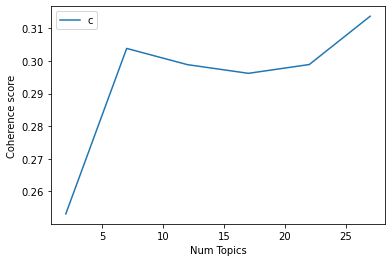

In [109]:
# Plot to see coherence score in order to choose optimal number of topics and decide optimal model
limit=30; start=2; step=5;
x = range(start, limit, step)
plt.plot(x, coherence_values_ph_score1N2N3)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [110]:
# Print the coherence scores
index = 0
for m, cv in zip(x, coherence_values_ph_score1N2N3):
    print("index:",index,"|","Num Topics =", m, " has Coherence Value of", round(cv, 4))
    index = index + 1

# optimal num_topics = 7

index: 0 | Num Topics = 2  has Coherence Value of 0.2531
index: 1 | Num Topics = 7  has Coherence Value of 0.3039
index: 2 | Num Topics = 12  has Coherence Value of 0.2989
index: 3 | Num Topics = 17  has Coherence Value of 0.2962
index: 4 | Num Topics = 22  has Coherence Value of 0.2989
index: 5 | Num Topics = 27  has Coherence Value of 0.3137


In [175]:
# Select optimal number of topics
optimal_model_ph_score1N2N3 = model_list_ph_score1N2N3[1]

In [176]:
# pyLDAVis
pyLDAvis.enable_notebook()
vis_ph_score1N2N3 = pyLDAvis.gensim_models.prepare(optimal_model_ph_score1N2N3, corpus_ph_score1N2N3, id2word_ph_score1N2N3)

In [177]:
print("pyLDAVis for ph topics for score=1,2,3:")
vis_ph_score1N2N3

pyLDAVis for ph topics for score=1,2,3:


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.069491 -0.016206       1        1  23.878507
0      0.053214 -0.031919       2        1  20.569909
1      0.097048  0.016701       3        1  17.320470
2     -0.112405 -0.143932       4        1  12.997626
5     -0.005972 -0.002970       5        1  10.787772
4      0.027095  0.050893       6        1   9.592261
6     -0.128472  0.127432       7        1   4.853456, topic_info=        Term        Freq       Total Category  logprob  loglift
79     video   95.000000   95.000000  Default  30.0000  30.0000
168    photo  106.000000  106.000000  Default  29.0000  29.0000
0        app  319.000000  319.000000  Default  28.0000  28.0000
80     watch   42.000000   42.000000  Default  27.0000  27.0000
17   account  276.000000  276.000000  Default  26.0000  26.0000
..       ...         ...         ...      ...      ...      ...
492     show    2.587889   45.001503   Topic7  -5.4699   0.1696
462      ask    2.442932   31.162404   Topic7  -5.5275   0.4795
27      look    2.431017   36.369175   Topic7  -5.5324   0.3201
17   account    2.344519  276.213152   Topic7  -5.5686  -1.7436
244  picture    2.332293   65.557607   Topic7  -5.5739  -0.3106

[527 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
17        1  0.340317  account
17        2  0.141195  account
17        3  0.354798  account
17        5  0.083269  account
17        6  0.072408  account
...     ...       ...      ...
248       4  0.035716    wrong
248       5  0.178580    wrong
248       6  0.071432    wrong
248       7  0.035716    wrong
1657      7  0.868148  zionist

[1035 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 1, 2, 3, 6, 5, 7])

# By-rating of each year

## By-rating of 2018 (Rating=1,2,3)

In [114]:
# By-rating Topic Modelling - rating = 1,2,3 in 2018
# Convert to list - move to each section
review_ph_2018_score1N2N3 = facebook_ios_ph_review_YearMonth_2018_score1N2N3.review.values.tolist()
review_words_ph_2018_score1N2N3 = list(sent_to_words(review_ph_2018_score1N2N3))
print(review_words_ph_2018_score1N2N3[:1])

[['how', 'do', 'log', 'in', 'when', 'it', 'says', 'you', 'are', 'trying', 'too', 'often', 'am', 'attempting', 'to', 'log', 'in', 'to', 'facebook', 'using', 'the', 'app', 'on', 'my', 'iphone', 'everytime', 'type', 'in', 'the', 'email', 'and', 'password', 'it', 'says', 'am', 'trying', 'too', 'often', 'when', 'try', 'it', 'on', 'my', 'safari', 'browser', 'it', 'works', 'how', 'am', 'supposed', 'to', 'log', 'in', 'on', 'the', 'app', 'ive', 'tried', 'restarting', 'the', 'phone', 'and', 'uninstalling', 'the', 'app', 'still', 'doesnt', 'work']]


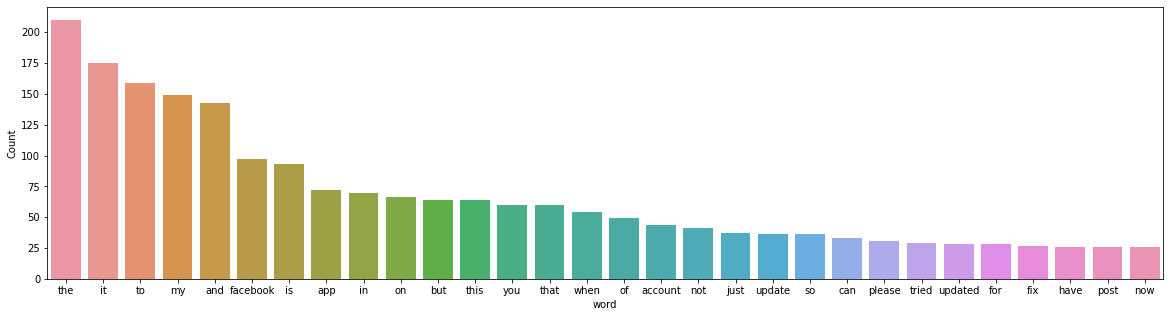

In [115]:
# Inspect the frequency of words before cleaning
freq_words(flatten(review_words_ph_2018_score1N2N3))

In [116]:
# Clean text
review_words_ph_ready_2018_score1N2N3 = process_words(review_words_ph_2018_score1N2N3)  # processed Text Data! - move to each section

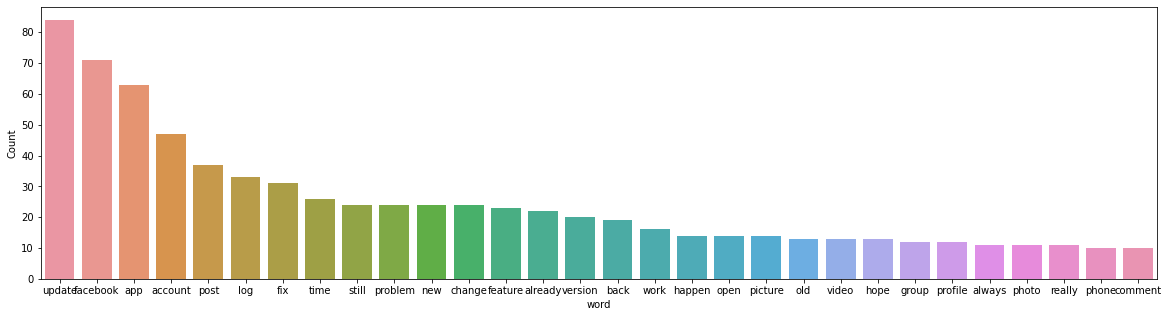

In [117]:
# Inspect the frequency of words after cleaning
freq_words(flatten(review_words_ph_ready_2018_score1N2N3))


In [118]:
# Create Dictionary
id2word_ph_2018_score1N2N3 = corpora.Dictionary(review_words_ph_ready_2018_score1N2N3)

2021-10-16 18:54:39,790 [INFO] gensim.corpora.dictionary - adding document #0 to Dictionary(0 unique tokens: [])
2021-10-16 18:54:39,813 [INFO] gensim.corpora.dictionary - built Dictionary(567 unique tokens: ['app', 'attempt', 'email', 'everytime', 'facebook']...) from 65 documents (total 1841 corpus positions)
2021-10-16 18:54:39,814 [INFO] gensim.utils - Dictionary lifecycle event {'msg': "built Dictionary(567 unique tokens: ['app', 'attempt', 'email', 'everytime', 'facebook']...) from 65 documents (total 1841 corpus positions)", 'datetime': '2021-10-16T18:54:39.814783', 'gensim': '4.1.2', 'python': '3.8.8 (default, Apr 13 2021, 12:59:45) \n[Clang 10.0.0 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'created'}


In [119]:
# Create Corpus: Term Document Frequency
corpus_ph_2018_score1N2N3 = [id2word_ph_2018_score1N2N3.doc2bow(text) for text in review_words_ph_ready_2018_score1N2N3]

In [120]:
# Training LDA model
model_list_ph_2018_score1N2N3, coherence_values_ph_2018_score1N2N3 = compute_coherence_values(dictionary=id2word_ph_2018_score1N2N3, corpus=corpus_ph_2018_score1N2N3, 
                                                              texts=review_words_ph_ready_2018_score1N2N3, limit=30, start=2, step=5)


2021-10-16 18:54:39,836 [INFO] gensim.models.ldamodel - using symmetric alpha at 0.5
2021-10-16 18:54:39,837 [INFO] gensim.models.ldamodel - using symmetric eta at 0.5
2021-10-16 18:54:39,839 [INFO] gensim.models.ldamodel - using serial LDA version on this node
2021-10-16 18:54:39,840 [INFO] gensim.models.ldamodel - running online (multi-pass) LDA training, 2 topics, 50 passes over the supplied corpus of 65 documents, updating model once every 65 documents, evaluating perplexity every 65 documents, iterating 50x with a convergence threshold of 0.001000
2021-10-16 18:54:40,005 [INFO] gensim.models.ldamodel - -6.938 per-word bound, 122.6 perplexity estimate based on a held-out corpus of 65 documents with 1841 words
2021-10-16 18:54:40,007 [INFO] gensim.models.ldamodel - PROGRESS: pass 0, at document #65/65
2021-10-16 18:54:40,226 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.035*"facebook" + 0.031*"update" + 0.019*"account" + 0.018*"app" + 0.015*"problem" + 0.014*"time" + 0.014*"ch

2021-10-16 18:54:42,760 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.038*"update" + 0.032*"app" + 0.023*"facebook" + 0.021*"post" + 0.015*"account" + 0.014*"still" + 0.013*"fix" + 0.011*"video" + 0.011*"log" + 0.011*"work"
2021-10-16 18:54:42,762 [INFO] gensim.models.ldamodel - topic diff=0.009810, rho=0.301511
2021-10-16 18:54:42,939 [INFO] gensim.models.ldamodel - -5.927 per-word bound, 60.8 perplexity estimate based on a held-out corpus of 65 documents with 1841 words
2021-10-16 18:54:42,940 [INFO] gensim.models.ldamodel - PROGRESS: pass 10, at document #65/65
2021-10-16 18:54:43,027 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.037*"facebook" + 0.033*"update" + 0.025*"account" + 0.022*"app" + 0.019*"change" + 0.018*"time" + 0.018*"log" + 0.016*"new" + 0.014*"problem" + 0.014*"fix"
2021-10-16 18:54:43,029 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.038*"update" + 0.032*"app" + 0.022*"facebook" + 0.021*"post" + 0.015*"account" + 0.014*"still" + 0.013*"fix" + 0.01

2021-10-16 18:54:45,301 [INFO] gensim.models.ldamodel - topic diff=0.005140, rho=0.218218
2021-10-16 18:54:45,396 [INFO] gensim.models.ldamodel - -5.922 per-word bound, 60.6 perplexity estimate based on a held-out corpus of 65 documents with 1841 words
2021-10-16 18:54:45,399 [INFO] gensim.models.ldamodel - PROGRESS: pass 20, at document #65/65
2021-10-16 18:54:45,533 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.037*"facebook" + 0.035*"update" + 0.027*"account" + 0.023*"app" + 0.020*"log" + 0.019*"change" + 0.018*"time" + 0.016*"new" + 0.015*"fix" + 0.014*"problem"
2021-10-16 18:54:45,534 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.035*"update" + 0.031*"app" + 0.022*"post" + 0.022*"facebook" + 0.013*"still" + 0.012*"video" + 0.012*"fix" + 0.012*"account" + 0.011*"group" + 0.011*"work"
2021-10-16 18:54:45,536 [INFO] gensim.models.ldamodel - topic diff=0.005139, rho=0.213201
2021-10-16 18:54:45,666 [INFO] gensim.models.ldamodel - -5.921 per-word bound, 60.6 perplexity esti

2021-10-16 18:54:47,952 [INFO] gensim.models.ldamodel - -5.916 per-word bound, 60.4 perplexity estimate based on a held-out corpus of 65 documents with 1841 words
2021-10-16 18:54:47,954 [INFO] gensim.models.ldamodel - PROGRESS: pass 30, at document #65/65
2021-10-16 18:54:48,041 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.037*"facebook" + 0.037*"update" + 0.028*"account" + 0.024*"app" + 0.021*"log" + 0.019*"change" + 0.018*"time" + 0.016*"new" + 0.015*"fix" + 0.013*"problem"
2021-10-16 18:54:48,043 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.033*"update" + 0.030*"app" + 0.022*"post" + 0.021*"facebook" + 0.012*"video" + 0.012*"still" + 0.011*"group" + 0.011*"work" + 0.011*"fix" + 0.010*"feature"
2021-10-16 18:54:48,044 [INFO] gensim.models.ldamodel - topic diff=0.005047, rho=0.176777
2021-10-16 18:54:48,191 [INFO] gensim.models.ldamodel - -5.915 per-word bound, 60.4 perplexity estimate based on a held-out corpus of 65 documents with 1841 words
2021-10-16 18:54:48,192 [I

2021-10-16 18:54:50,358 [INFO] gensim.models.ldamodel - PROGRESS: pass 40, at document #65/65
2021-10-16 18:54:50,420 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.038*"update" + 0.037*"facebook" + 0.029*"account" + 0.024*"app" + 0.022*"log" + 0.018*"change" + 0.017*"time" + 0.015*"new" + 0.015*"fix" + 0.013*"problem"
2021-10-16 18:54:50,422 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.032*"update" + 0.029*"app" + 0.022*"post" + 0.021*"facebook" + 0.013*"video" + 0.012*"group" + 0.012*"work" + 0.011*"still" + 0.011*"fix" + 0.010*"feature"
2021-10-16 18:54:50,423 [INFO] gensim.models.ldamodel - topic diff=0.002641, rho=0.154303
2021-10-16 18:54:50,570 [INFO] gensim.models.ldamodel - -5.913 per-word bound, 60.3 perplexity estimate based on a held-out corpus of 65 documents with 1841 words
2021-10-16 18:54:50,572 [INFO] gensim.models.ldamodel - PROGRESS: pass 41, at document #65/65
2021-10-16 18:54:50,640 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.038*"update" + 0.03

2021-10-16 18:54:52,576 [INFO] gensim.topic_coherence.probability_estimation - using ParallelWordOccurrenceAccumulator(processes=7, batch_size=64) to estimate probabilities from sliding windows
2021-10-16 18:54:56,917 [INFO] gensim.topic_coherence.text_analysis - 7 accumulators retrieved from output queue
2021-10-16 18:54:56,957 [INFO] gensim.topic_coherence.text_analysis - accumulated word occurrence stats for 65 virtual documents
2021-10-16 18:54:57,206 [INFO] gensim.models.ldamodel - using symmetric alpha at 0.14285714285714285
2021-10-16 18:54:57,208 [INFO] gensim.models.ldamodel - using symmetric eta at 0.14285714285714285
2021-10-16 18:54:57,218 [INFO] gensim.models.ldamodel - using serial LDA version on this node
2021-10-16 18:54:57,228 [INFO] gensim.models.ldamodel - running online (multi-pass) LDA training, 7 topics, 50 passes over the supplied corpus of 65 documents, updating model once every 65 documents, evaluating perplexity every 65 documents, iterating 50x with a converg

2021-10-16 18:54:58,410 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.069*"account" + 0.042*"log" + 0.035*"facebook" + 0.033*"update" + 0.029*"fix" + 0.029*"version" + 0.026*"app" + 0.023*"new" + 0.022*"change" + 0.021*"still"
2021-10-16 18:54:58,411 [INFO] gensim.models.ldamodel - topic diff=0.088087, rho=0.408248
2021-10-16 18:54:58,525 [INFO] gensim.models.ldamodel - -6.045 per-word bound, 66.0 perplexity estimate based on a held-out corpus of 65 documents with 1841 words
2021-10-16 18:54:58,526 [INFO] gensim.models.ldamodel - PROGRESS: pass 5, at document #65/65
2021-10-16 18:54:58,561 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.070*"update" + 0.045*"facebook" + 0.039*"app" + 0.027*"post" + 0.020*"problem" + 0.017*"work" + 0.016*"group" + 0.015*"time" + 0.014*"log" + 0.011*"notification"
2021-10-16 18:54:58,564 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.021*"picture" + 0.020*"fix" + 0.019*"post" + 0.016*"already" + 0.016*"story" + 0.016*"react" + 0.015*"happe

2021-10-16 18:54:59,435 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.027*"facebook" + 0.027*"photo" + 0.023*"app" + 0.020*"time" + 0.020*"update" + 0.020*"change" + 0.017*"small" + 0.014*"feature" + 0.014*"back" + 0.013*"already"
2021-10-16 18:54:59,436 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.030*"video" + 0.025*"future" + 0.020*"watch" + 0.020*"feature" + 0.016*"facebook" + 0.016*"press" + 0.016*"work" + 0.016*"open" + 0.016*"keep" + 0.016*"picture"
2021-10-16 18:54:59,438 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.029*"app" + 0.022*"facebook" + 0.018*"still" + 0.017*"picture" + 0.016*"post" + 0.014*"download" + 0.014*"well" + 0.013*"feature" + 0.011*"already" + 0.011*"guy"
2021-10-16 18:54:59,440 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.069*"update" + 0.045*"facebook" + 0.039*"app" + 0.028*"post" + 0.020*"problem" + 0.018*"work" + 0.017*"group" + 0.015*"time" + 0.013*"log" + 0.011*"notification"
2021-10-16 18:54:59,441 [INFO] gensim.models.ldamo

2021-10-16 18:55:00,298 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.071*"account" + 0.042*"log" + 0.038*"facebook" + 0.035*"update" + 0.031*"version" + 0.029*"fix" + 0.027*"app" + 0.025*"change" + 0.023*"new" + 0.021*"still"
2021-10-16 18:55:00,300 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.027*"facebook" + 0.027*"photo" + 0.023*"app" + 0.020*"update" + 0.020*"time" + 0.020*"change" + 0.017*"small" + 0.014*"feature" + 0.014*"back" + 0.013*"already"
2021-10-16 18:55:00,301 [INFO] gensim.models.ldamodel - topic diff=0.004361, rho=0.242536
2021-10-16 18:55:00,417 [INFO] gensim.models.ldamodel - -6.023 per-word bound, 65.0 perplexity estimate based on a held-out corpus of 65 documents with 1841 words
2021-10-16 18:55:00,418 [INFO] gensim.models.ldamodel - PROGRESS: pass 16, at document #65/65
2021-10-16 18:55:00,465 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.027*"facebook" + 0.027*"photo" + 0.023*"app" + 0.020*"update" + 0.020*"time" + 0.020*"change" + 0.017*"smal

2021-10-16 18:55:01,176 [INFO] gensim.models.ldamodel - -6.021 per-word bound, 64.9 perplexity estimate based on a held-out corpus of 65 documents with 1841 words
2021-10-16 18:55:01,177 [INFO] gensim.models.ldamodel - PROGRESS: pass 21, at document #65/65
2021-10-16 18:55:01,275 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.022*"picture" + 0.019*"fix" + 0.017*"already" + 0.017*"react" + 0.017*"story" + 0.016*"post" + 0.012*"happen" + 0.011*"time" + 0.011*"new" + 0.011*"thing"
2021-10-16 18:55:01,277 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.069*"update" + 0.044*"facebook" + 0.039*"app" + 0.028*"post" + 0.020*"problem" + 0.018*"group" + 0.018*"work" + 0.016*"time" + 0.012*"notification" + 0.011*"phone"
2021-10-16 18:55:01,278 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.030*"video" + 0.026*"future" + 0.021*"feature" + 0.021*"watch" + 0.016*"work" + 0.016*"facebook" + 0.016*"press" + 0.016*"picture" + 0.016*"open" + 0.016*"keep"
2021-10-16 18:55:01,279 [INFO] gens

2021-10-16 18:55:02,095 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.027*"photo" + 0.027*"facebook" + 0.023*"app" + 0.020*"update" + 0.020*"time" + 0.020*"change" + 0.017*"small" + 0.014*"feature" + 0.014*"back" + 0.013*"already"
2021-10-16 18:55:02,108 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.029*"app" + 0.022*"facebook" + 0.018*"still" + 0.017*"picture" + 0.015*"post" + 0.014*"download" + 0.014*"well" + 0.012*"feature" + 0.011*"already" + 0.011*"support"
2021-10-16 18:55:02,116 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.030*"video" + 0.026*"future" + 0.021*"feature" + 0.021*"watch" + 0.017*"work" + 0.016*"facebook" + 0.016*"press" + 0.016*"picture" + 0.016*"open" + 0.016*"keep"
2021-10-16 18:55:02,128 [INFO] gensim.models.ldamodel - topic diff=0.001338, rho=0.188982
2021-10-16 18:55:02,184 [INFO] gensim.models.ldamodel - -6.020 per-word bound, 64.9 perplexity estimate based on a held-out corpus of 65 documents with 1841 words
2021-10-16 18:55:02,185 [INFO] 

2021-10-16 18:55:02,904 [INFO] gensim.models.ldamodel - topic diff=0.000848, rho=0.174078
2021-10-16 18:55:03,043 [INFO] gensim.models.ldamodel - -6.020 per-word bound, 64.9 perplexity estimate based on a held-out corpus of 65 documents with 1841 words
2021-10-16 18:55:03,045 [INFO] gensim.models.ldamodel - PROGRESS: pass 32, at document #65/65
2021-10-16 18:55:03,109 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.030*"video" + 0.025*"future" + 0.020*"feature" + 0.020*"watch" + 0.019*"work" + 0.016*"facebook" + 0.016*"picture" + 0.016*"press" + 0.016*"keep" + 0.016*"open"
2021-10-16 18:55:03,112 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.069*"update" + 0.044*"facebook" + 0.039*"app" + 0.029*"post" + 0.020*"problem" + 0.018*"group" + 0.017*"work" + 0.016*"time" + 0.012*"notification" + 0.011*"phone"
2021-10-16 18:55:03,115 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.027*"photo" + 0.027*"facebook" + 0.023*"app" + 0.020*"update" + 0.020*"time" + 0.020*"change" + 0.01

2021-10-16 18:55:03,929 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.022*"picture" + 0.018*"fix" + 0.017*"already" + 0.017*"react" + 0.017*"story" + 0.015*"post" + 0.011*"thing" + 0.011*"long" + 0.011*"lately" + 0.011*"month"
2021-10-16 18:55:03,931 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.069*"update" + 0.044*"facebook" + 0.039*"app" + 0.029*"post" + 0.020*"problem" + 0.018*"group" + 0.017*"work" + 0.016*"time" + 0.012*"notification" + 0.011*"phone"
2021-10-16 18:55:03,932 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.059*"update" + 0.028*"app" + 0.017*"connection" + 0.014*"hope" + 0.012*"wifi" + 0.012*"connect" + 0.012*"internet" + 0.012*"always" + 0.011*"soon" + 0.009*"new"
2021-10-16 18:55:03,933 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.073*"account" + 0.045*"log" + 0.039*"facebook" + 0.036*"update" + 0.030*"version" + 0.028*"fix" + 0.028*"app" + 0.024*"change" + 0.023*"new" + 0.021*"still"
2021-10-16 18:55:03,934 [INFO] gensim.models.ldamodel - t

2021-10-16 18:55:04,660 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.030*"video" + 0.025*"future" + 0.020*"feature" + 0.020*"watch" + 0.020*"work" + 0.016*"facebook" + 0.016*"picture" + 0.016*"keep" + 0.016*"open" + 0.016*"really"
2021-10-16 18:55:04,662 [INFO] gensim.models.ldamodel - topic diff=0.000411, rho=0.150756
2021-10-16 18:55:04,721 [INFO] gensim.models.ldamodel - -6.019 per-word bound, 64.8 perplexity estimate based on a held-out corpus of 65 documents with 1841 words
2021-10-16 18:55:04,722 [INFO] gensim.models.ldamodel - PROGRESS: pass 43, at document #65/65
2021-10-16 18:55:04,767 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.022*"picture" + 0.018*"fix" + 0.017*"already" + 0.017*"react" + 0.017*"story" + 0.015*"post" + 0.011*"thing" + 0.011*"lately" + 0.011*"long" + 0.011*"month"
2021-10-16 18:55:04,769 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.069*"update" + 0.044*"facebook" + 0.039*"app" + 0.029*"post" + 0.020*"problem" + 0.018*"group" + 0.017*"wo

2021-10-16 18:55:05,776 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.027*"photo" + 0.027*"facebook" + 0.023*"app" + 0.020*"update" + 0.020*"time" + 0.020*"change" + 0.017*"small" + 0.014*"back" + 0.014*"feature" + 0.013*"already"
2021-10-16 18:55:05,777 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.059*"update" + 0.028*"app" + 0.017*"connection" + 0.014*"hope" + 0.012*"wifi" + 0.012*"connect" + 0.012*"internet" + 0.012*"always" + 0.011*"soon" + 0.009*"new"
2021-10-16 18:55:05,778 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.030*"video" + 0.025*"future" + 0.020*"feature" + 0.020*"watch" + 0.020*"work" + 0.016*"facebook" + 0.016*"picture" + 0.016*"keep" + 0.016*"open" + 0.016*"really"
2021-10-16 18:55:05,779 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.022*"picture" + 0.018*"fix" + 0.017*"already" + 0.017*"react" + 0.017*"story" + 0.015*"post" + 0.011*"thing" + 0.011*"lately" + 0.011*"long" + 0.011*"month"
2021-10-16 18:55:05,781 [INFO] gensim.models.ldamodel -

2021-10-16 18:55:12,663 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.027*"view" + 0.023*"picture" + 0.021*"story" + 0.020*"timeline" + 0.020*"profile" + 0.019*"fix" + 0.019*"issue" + 0.014*"already" + 0.014*"lately" + 0.014*"time"
2021-10-16 18:55:12,664 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.043*"app" + 0.033*"facebook" + 0.028*"feature" + 0.022*"picture" + 0.022*"post" + 0.020*"account" + 0.017*"well" + 0.013*"download" + 0.013*"back" + 0.011*"anymore"
2021-10-16 18:55:12,665 [INFO] gensim.models.ldamodel - topic diff=0.230569, rho=0.500000
2021-10-16 18:55:12,717 [INFO] gensim.models.ldamodel - -6.222 per-word bound, 74.6 perplexity estimate based on a held-out corpus of 65 documents with 1841 words
2021-10-16 18:55:12,719 [INFO] gensim.models.ldamodel - PROGRESS: pass 3, at document #65/65
2021-10-16 18:55:12,767 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.027*"still" + 0.026*"future" + 0.021*"add" + 0.021*"work" + 0.021*"keep" + 0.020*"post" + 0.019*"fa

2021-10-16 18:55:13,554 [INFO] gensim.models.ldamodel - -6.139 per-word bound, 70.5 perplexity estimate based on a held-out corpus of 65 documents with 1841 words
2021-10-16 18:55:13,555 [INFO] gensim.models.ldamodel - PROGRESS: pass 8, at document #65/65
2021-10-16 18:55:13,599 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.036*"app" + 0.024*"action" + 0.024*"block" + 0.013*"react" + 0.013*"fix" + 0.013*"post" + 0.013*"appear" + 0.013*"always" + 0.013*"back" + 0.013*"away"
2021-10-16 18:55:13,601 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.066*"account" + 0.052*"update" + 0.051*"log" + 0.039*"version" + 0.034*"app" + 0.033*"facebook" + 0.030*"new" + 0.028*"fix" + 0.026*"still" + 0.023*"change"
2021-10-16 18:55:13,602 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.043*"app" + 0.035*"facebook" + 0.029*"feature" + 0.023*"picture" + 0.023*"post" + 0.019*"account" + 0.018*"well" + 0.012*"download" + 0.012*"back" + 0.012*"anymore"
2021-10-16 18:55:13,604 [INFO] gensim.mod

2021-10-16 18:55:14,466 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.086*"update" + 0.046*"app" + 0.040*"video" + 0.029*"facebook" + 0.029*"watch" + 0.023*"feature" + 0.018*"connection" + 0.018*"comment" + 0.018*"view" + 0.012*"already"
2021-10-16 18:55:14,468 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.026*"open" + 0.026*"picture" + 0.026*"landscape" + 0.026*"ill" + 0.026*"fix" + 0.026*"hope" + 0.026*"update" + 0.018*"really" + 0.018*"portrait" + 0.018*"problem"
2021-10-16 18:55:14,471 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.027*"future" + 0.025*"still" + 0.022*"add" + 0.022*"work" + 0.022*"keep" + 0.018*"post" + 0.017*"facebook" + 0.016*"guy" + 0.016*"artist" + 0.016*"support"
2021-10-16 18:55:14,472 [INFO] gensim.models.ldamodel - topic diff=0.007976, rho=0.258199
2021-10-16 18:55:14,548 [INFO] gensim.models.ldamodel - -6.126 per-word bound, 69.9 perplexity estimate based on a held-out corpus of 65 documents with 1841 words
2021-10-16 18:55:14,549 [INFO] g

2021-10-16 18:55:15,293 [INFO] gensim.models.ldamodel - topic diff=0.003068, rho=0.223607
2021-10-16 18:55:15,415 [INFO] gensim.models.ldamodel - -6.123 per-word bound, 69.7 perplexity estimate based on a held-out corpus of 65 documents with 1841 words
2021-10-16 18:55:15,417 [INFO] gensim.models.ldamodel - PROGRESS: pass 19, at document #65/65
2021-10-16 18:55:15,463 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.026*"open" + 0.026*"picture" + 0.026*"landscape" + 0.026*"ill" + 0.026*"fix" + 0.026*"hope" + 0.026*"update" + 0.018*"really" + 0.018*"portrait" + 0.018*"problem"
2021-10-16 18:55:15,466 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.057*"update" + 0.044*"post" + 0.044*"facebook" + 0.027*"group" + 0.025*"app" + 0.015*"notification" + 0.015*"sell" + 0.013*"account" + 0.012*"time" + 0.012*"always"
2021-10-16 18:55:15,467 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.086*"update" + 0.046*"app" + 0.040*"video" + 0.029*"facebook" + 0.029*"watch" + 0.023*"feature" +

2021-10-16 18:55:16,440 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.027*"future" + 0.025*"still" + 0.022*"work" + 0.022*"add" + 0.022*"keep" + 0.019*"post" + 0.017*"facebook" + 0.017*"guy" + 0.017*"artist" + 0.017*"support"
2021-10-16 18:55:16,441 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.036*"photo" + 0.032*"change" + 0.027*"update" + 0.023*"small" + 0.021*"already" + 0.018*"feature" + 0.018*"facebook" + 0.018*"time" + 0.014*"back" + 0.014*"way"
2021-10-16 18:55:16,443 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.027*"view" + 0.027*"picture" + 0.020*"story" + 0.020*"timeline" + 0.020*"profile" + 0.020*"issue" + 0.019*"fix" + 0.014*"already" + 0.014*"time" + 0.014*"lately"
2021-10-16 18:55:16,445 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.002*"work" + 0.002*"future" + 0.002*"update" + 0.002*"add" + 0.002*"digital" + 0.002*"sign" + 0.002*"keep" + 0.002*"press" + 0.002*"artist" + 0.002*"happen"
2021-10-16 18:55:16,446 [INFO] gensim.models.ldamodel - topi

2021-10-16 18:55:17,287 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.069*"account" + 0.055*"update" + 0.054*"log" + 0.039*"version" + 0.036*"facebook" + 0.034*"app" + 0.030*"new" + 0.028*"change" + 0.028*"fix" + 0.026*"still"
2021-10-16 18:55:17,290 [INFO] gensim.models.ldamodel - topic diff=0.000659, rho=0.179605
2021-10-16 18:55:17,421 [INFO] gensim.models.ldamodel - -6.121 per-word bound, 69.6 perplexity estimate based on a held-out corpus of 65 documents with 1841 words
2021-10-16 18:55:17,422 [INFO] gensim.models.ldamodel - PROGRESS: pass 30, at document #65/65
2021-10-16 18:55:17,525 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.026*"open" + 0.026*"picture" + 0.026*"landscape" + 0.026*"fix" + 0.026*"ill" + 0.026*"hope" + 0.026*"update" + 0.018*"really" + 0.018*"portrait" + 0.018*"problem"
2021-10-16 18:55:17,527 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.058*"update" + 0.030*"time" + 0.030*"start" + 0.015*"week" + 0.015*"facebook" + 0.015*"several" + 0.015*"

2021-10-16 18:55:18,405 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.043*"app" + 0.035*"facebook" + 0.029*"feature" + 0.024*"picture" + 0.024*"post" + 0.019*"account" + 0.018*"well" + 0.012*"download" + 0.012*"back" + 0.012*"stop"
2021-10-16 18:55:18,406 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.036*"photo" + 0.032*"change" + 0.027*"update" + 0.023*"small" + 0.021*"already" + 0.018*"feature" + 0.018*"facebook" + 0.018*"time" + 0.014*"back" + 0.014*"sure"
2021-10-16 18:55:18,407 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.002*"work" + 0.002*"future" + 0.002*"update" + 0.002*"add" + 0.002*"digital" + 0.002*"sign" + 0.002*"keep" + 0.002*"artist" + 0.002*"press" + 0.002*"happen"
2021-10-16 18:55:18,409 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.036*"app" + 0.024*"block" + 0.024*"action" + 0.013*"react" + 0.013*"fix" + 0.013*"always" + 0.013*"appear" + 0.013*"post" + 0.013*"back" + 0.013*"hope"
2021-10-16 18:55:18,410 [INFO] gensim.models.ldamodel - topic 

2021-10-16 18:55:19,214 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.036*"photo" + 0.032*"change" + 0.027*"update" + 0.023*"small" + 0.021*"already" + 0.018*"feature" + 0.018*"facebook" + 0.018*"time" + 0.014*"back" + 0.014*"sure"
2021-10-16 18:55:19,218 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.027*"future" + 0.025*"still" + 0.022*"keep" + 0.022*"work" + 0.022*"add" + 0.019*"post" + 0.017*"facebook" + 0.017*"guy" + 0.017*"artist" + 0.017*"support"
2021-10-16 18:55:19,222 [INFO] gensim.models.ldamodel - topic diff=0.000154, rho=0.154303
2021-10-16 18:55:19,289 [INFO] gensim.models.ldamodel - -6.120 per-word bound, 69.6 perplexity estimate based on a held-out corpus of 65 documents with 1841 words
2021-10-16 18:55:19,291 [INFO] gensim.models.ldamodel - PROGRESS: pass 41, at document #65/65
2021-10-16 18:55:19,399 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.026*"hope" + 0.026*"fix" + 0.026*"picture" + 0.026*"open" + 0.026*"landscape" + 0.026*"ill" + 0.026*"update

2021-10-16 18:55:20,153 [INFO] gensim.models.ldamodel - PROGRESS: pass 46, at document #65/65
2021-10-16 18:55:20,186 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.026*"hope" + 0.026*"fix" + 0.026*"picture" + 0.026*"open" + 0.026*"landscape" + 0.026*"update" + 0.026*"ill" + 0.018*"problem" + 0.018*"really" + 0.018*"always"
2021-10-16 18:55:20,187 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.002*"work" + 0.002*"future" + 0.002*"update" + 0.002*"add" + 0.002*"digital" + 0.002*"sign" + 0.002*"keep" + 0.002*"press" + 0.002*"artist" + 0.002*"happen"
2021-10-16 18:55:20,189 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.053*"facebook" + 0.048*"app" + 0.033*"problem" + 0.027*"account" + 0.025*"log" + 0.024*"update" + 0.018*"work" + 0.018*"happen" + 0.015*"fix" + 0.015*"phone"
2021-10-16 18:55:20,191 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.036*"app" + 0.024*"block" + 0.024*"action" + 0.013*"hope" + 0.013*"react" + 0.013*"always" + 0.013*"appear" + 0.013*"happen"

2021-10-16 18:55:27,658 [INFO] gensim.models.ldamodel - topic #16 (0.059): 0.030*"update" + 0.024*"thing" + 0.022*"notification" + 0.021*"video" + 0.019*"app" + 0.019*"new" + 0.018*"sure" + 0.017*"profile" + 0.017*"tab" + 0.014*"download"
2021-10-16 18:55:27,660 [INFO] gensim.models.ldamodel - topic #10 (0.059): 0.017*"fix" + 0.017*"workaround" + 0.017*"week" + 0.017*"help" + 0.017*"app" + 0.017*"setting" + 0.017*"datum" + 0.017*"account" + 0.017*"profile" + 0.017*"load"
2021-10-16 18:55:27,661 [INFO] gensim.models.ldamodel - topic diff=12.776388, rho=1.000000
2021-10-16 18:55:27,757 [INFO] gensim.models.ldamodel - -6.590 per-word bound, 96.3 perplexity estimate based on a held-out corpus of 65 documents with 1841 words
2021-10-16 18:55:27,761 [INFO] gensim.models.ldamodel - PROGRESS: pass 1, at document #65/65
2021-10-16 18:55:27,830 [INFO] gensim.models.ldamodel - topic #12 (0.059): 0.065*"app" + 0.058*"facebook" + 0.050*"update" + 0.023*"post" + 0.021*"fix" + 0.015*"time" + 0.014*"a

2021-10-16 18:55:28,652 [INFO] gensim.models.ldamodel - -6.191 per-word bound, 73.1 perplexity estimate based on a held-out corpus of 65 documents with 1841 words
2021-10-16 18:55:28,653 [INFO] gensim.models.ldamodel - PROGRESS: pass 6, at document #65/65
2021-10-16 18:55:28,684 [INFO] gensim.models.ldamodel - topic #11 (0.059): 0.063*"facebook" + 0.045*"problem" + 0.032*"app" + 0.021*"check" + 0.018*"update" + 0.017*"iphone" + 0.016*"always" + 0.014*"version" + 0.013*"open" + 0.013*"log"
2021-10-16 18:55:28,686 [INFO] gensim.models.ldamodel - topic #9 (0.059): 0.040*"update" + 0.039*"tab" + 0.026*"app" + 0.026*"bottom" + 0.026*"read" + 0.026*"people" + 0.017*"new" + 0.014*"facebook" + 0.013*"part" + 0.013*"bring"
2021-10-16 18:55:28,687 [INFO] gensim.models.ldamodel - topic #0 (0.059): 0.034*"photo" + 0.033*"change" + 0.027*"small" + 0.027*"already" + 0.021*"feature" + 0.021*"update" + 0.020*"facebook" + 0.020*"way" + 0.020*"sure" + 0.020*"time"
2021-10-16 18:55:28,692 [INFO] gensim.m

2021-10-16 18:55:29,391 [INFO] gensim.models.ldamodel - topic #2 (0.059): 0.052*"future" + 0.031*"keep" + 0.031*"artist" + 0.031*"work" + 0.031*"digital" + 0.031*"press" + 0.031*"add" + 0.031*"landscape" + 0.030*"picture" + 0.029*"open"
2021-10-16 18:55:29,394 [INFO] gensim.models.ldamodel - topic #13 (0.059): 0.076*"update" + 0.046*"look" + 0.031*"account" + 0.031*"log" + 0.031*"thing" + 0.016*"facebook" + 0.016*"still" + 0.016*"app" + 0.016*"friend" + 0.016*"work"
2021-10-16 18:55:29,399 [INFO] gensim.models.ldamodel - topic #16 (0.059): 0.031*"update" + 0.021*"thing" + 0.021*"notification" + 0.021*"video" + 0.021*"app" + 0.021*"new" + 0.021*"sure" + 0.016*"profile" + 0.016*"tab" + 0.016*"download"
2021-10-16 18:55:29,401 [INFO] gensim.models.ldamodel - topic diff=0.015313, rho=0.277350
2021-10-16 18:55:29,543 [INFO] gensim.models.ldamodel - -6.163 per-word bound, 71.7 perplexity estimate based on a held-out corpus of 65 documents with 1841 words
2021-10-16 18:55:29,544 [INFO] gensim

2021-10-16 18:55:30,298 [INFO] gensim.models.ldamodel - topic diff=0.004521, rho=0.235702
2021-10-16 18:55:30,411 [INFO] gensim.models.ldamodel - -6.159 per-word bound, 71.5 perplexity estimate based on a held-out corpus of 65 documents with 1841 words
2021-10-16 18:55:30,413 [INFO] gensim.models.ldamodel - PROGRESS: pass 17, at document #65/65
2021-10-16 18:55:30,456 [INFO] gensim.models.ldamodel - topic #4 (0.059): 0.002*"video" + 0.002*"watch" + 0.002*"feature" + 0.002*"update" + 0.002*"comment" + 0.002*"view" + 0.002*"improvement" + 0.002*"back" + 0.002*"facebook" + 0.002*"second"
2021-10-16 18:55:30,460 [INFO] gensim.models.ldamodel - topic #1 (0.059): 0.049*"video" + 0.035*"watch" + 0.028*"update" + 0.028*"feature" + 0.021*"app" + 0.021*"facebook" + 0.021*"photo" + 0.021*"view" + 0.021*"comment" + 0.014*"internet"
2021-10-16 18:55:30,464 [INFO] gensim.models.ldamodel - topic #12 (0.059): 0.071*"app" + 0.059*"facebook" + 0.052*"update" + 0.024*"post" + 0.021*"fix" + 0.015*"feature

2021-10-16 18:55:31,287 [INFO] gensim.models.ldamodel - topic #14 (0.059): 0.085*"post" + 0.061*"group" + 0.027*"sale" + 0.027*"sell" + 0.021*"guy" + 0.021*"support" + 0.021*"comment" + 0.021*"block" + 0.021*"buy" + 0.014*"still"
2021-10-16 18:55:31,288 [INFO] gensim.models.ldamodel - topic #13 (0.059): 0.076*"update" + 0.046*"look" + 0.031*"account" + 0.031*"log" + 0.031*"thing" + 0.016*"facebook" + 0.016*"still" + 0.016*"app" + 0.016*"friend" + 0.016*"work"
2021-10-16 18:55:31,293 [INFO] gensim.models.ldamodel - topic #7 (0.059): 0.030*"happen" + 0.030*"update" + 0.030*"app" + 0.023*"sign" + 0.023*"account" + 0.023*"really" + 0.023*"back" + 0.015*"thing" + 0.015*"main" + 0.015*"still"
2021-10-16 18:55:31,296 [INFO] gensim.models.ldamodel - topic #5 (0.059): 0.070*"update" + 0.036*"post" + 0.036*"time" + 0.033*"facebook" + 0.029*"several" + 0.020*"app" + 0.019*"feature" + 0.017*"problem" + 0.015*"fix" + 0.015*"shut"
2021-10-16 18:55:31,299 [INFO] gensim.models.ldamodel - topic diff=0.

2021-10-16 18:55:32,176 [INFO] gensim.models.ldamodel - topic #0 (0.059): 0.034*"photo" + 0.034*"change" + 0.027*"small" + 0.027*"already" + 0.020*"feature" + 0.020*"update" + 0.020*"facebook" + 0.020*"way" + 0.020*"sure" + 0.020*"time"
2021-10-16 18:55:32,177 [INFO] gensim.models.ldamodel - topic diff=0.000573, rho=0.185695
2021-10-16 18:55:32,286 [INFO] gensim.models.ldamodel - -6.157 per-word bound, 71.4 perplexity estimate based on a held-out corpus of 65 documents with 1841 words
2021-10-16 18:55:32,287 [INFO] gensim.models.ldamodel - PROGRESS: pass 28, at document #65/65
2021-10-16 18:55:32,318 [INFO] gensim.models.ldamodel - topic #1 (0.059): 0.049*"video" + 0.035*"watch" + 0.028*"update" + 0.028*"feature" + 0.021*"app" + 0.021*"facebook" + 0.021*"photo" + 0.021*"view" + 0.021*"comment" + 0.014*"internet"
2021-10-16 18:55:32,321 [INFO] gensim.models.ldamodel - topic #10 (0.059): 0.018*"fix" + 0.018*"help" + 0.018*"week" + 0.018*"workaround" + 0.018*"app" + 0.018*"setting" + 0.01

2021-10-16 18:55:33,152 [INFO] gensim.models.ldamodel - topic #1 (0.059): 0.049*"video" + 0.035*"watch" + 0.028*"update" + 0.028*"feature" + 0.021*"app" + 0.021*"facebook" + 0.021*"photo" + 0.021*"view" + 0.021*"comment" + 0.014*"internet"
2021-10-16 18:55:33,154 [INFO] gensim.models.ldamodel - topic #15 (0.059): 0.061*"account" + 0.031*"facebook" + 0.029*"app" + 0.029*"work" + 0.020*"log" + 0.020*"back" + 0.020*"often" + 0.020*"access" + 0.012*"still" + 0.010*"create"
2021-10-16 18:55:33,158 [INFO] gensim.models.ldamodel - topic #4 (0.059): 0.002*"video" + 0.002*"watch" + 0.002*"feature" + 0.002*"update" + 0.002*"comment" + 0.002*"view" + 0.002*"improvement" + 0.002*"back" + 0.002*"facebook" + 0.002*"second"
2021-10-16 18:55:33,161 [INFO] gensim.models.ldamodel - topic #16 (0.059): 0.031*"update" + 0.021*"thing" + 0.021*"notification" + 0.021*"video" + 0.021*"app" + 0.021*"new" + 0.021*"sure" + 0.016*"profile" + 0.016*"tab" + 0.016*"download"
2021-10-16 18:55:33,163 [INFO] gensim.mode

2021-10-16 18:55:34,038 [INFO] gensim.models.ldamodel - topic #2 (0.059): 0.052*"future" + 0.031*"keep" + 0.031*"artist" + 0.031*"work" + 0.031*"digital" + 0.031*"press" + 0.031*"add" + 0.031*"landscape" + 0.030*"picture" + 0.029*"open"
2021-10-16 18:55:34,039 [INFO] gensim.models.ldamodel - topic #1 (0.059): 0.049*"video" + 0.035*"watch" + 0.028*"update" + 0.028*"feature" + 0.021*"app" + 0.021*"facebook" + 0.021*"photo" + 0.021*"view" + 0.021*"comment" + 0.014*"internet"
2021-10-16 18:55:34,040 [INFO] gensim.models.ldamodel - topic diff=0.000109, rho=0.158114
2021-10-16 18:55:34,095 [INFO] gensim.models.ldamodel - -6.157 per-word bound, 71.4 perplexity estimate based on a held-out corpus of 65 documents with 1841 words
2021-10-16 18:55:34,096 [INFO] gensim.models.ldamodel - PROGRESS: pass 39, at document #65/65
2021-10-16 18:55:34,153 [INFO] gensim.models.ldamodel - topic #8 (0.059): 0.019*"post" + 0.019*"facebook" + 0.019*"already" + 0.019*"fix" + 0.019*"problem" + 0.019*"fail" + 0.0

2021-10-16 18:55:34,924 [INFO] gensim.models.ldamodel - -6.157 per-word bound, 71.4 perplexity estimate based on a held-out corpus of 65 documents with 1841 words
2021-10-16 18:55:34,925 [INFO] gensim.models.ldamodel - PROGRESS: pass 44, at document #65/65
2021-10-16 18:55:35,032 [INFO] gensim.models.ldamodel - topic #1 (0.059): 0.049*"video" + 0.035*"watch" + 0.028*"update" + 0.028*"feature" + 0.021*"app" + 0.021*"facebook" + 0.021*"photo" + 0.021*"view" + 0.021*"comment" + 0.014*"change"
2021-10-16 18:55:35,033 [INFO] gensim.models.ldamodel - topic #6 (0.059): 0.040*"update" + 0.025*"story" + 0.025*"picture" + 0.025*"long" + 0.025*"refresh" + 0.025*"decide" + 0.025*"time" + 0.025*"post" + 0.017*"already" + 0.017*"fix"
2021-10-16 18:55:35,034 [INFO] gensim.models.ldamodel - topic #8 (0.059): 0.019*"post" + 0.019*"facebook" + 0.019*"already" + 0.019*"fix" + 0.019*"problem" + 0.019*"fail" + 0.019*"directly" + 0.019*"performance" + 0.019*"message" + 0.019*"logout"
2021-10-16 18:55:35,035

2021-10-16 18:55:35,892 [INFO] gensim.models.ldamodel - topic #4 (0.059): 0.002*"video" + 0.002*"watch" + 0.002*"feature" + 0.002*"update" + 0.002*"comment" + 0.002*"view" + 0.002*"improvement" + 0.002*"back" + 0.002*"facebook" + 0.002*"second"
2021-10-16 18:55:35,898 [INFO] gensim.models.ldamodel - topic #6 (0.059): 0.040*"update" + 0.025*"picture" + 0.025*"story" + 0.025*"long" + 0.025*"refresh" + 0.025*"decide" + 0.025*"time" + 0.025*"post" + 0.017*"already" + 0.017*"icon"
2021-10-16 18:55:35,899 [INFO] gensim.models.ldamodel - topic #7 (0.059): 0.030*"update" + 0.030*"happen" + 0.030*"app" + 0.023*"sign" + 0.023*"really" + 0.023*"account" + 0.023*"back" + 0.015*"thing" + 0.015*"still" + 0.015*"main"
2021-10-16 18:55:35,901 [INFO] gensim.models.ldamodel - topic diff=0.000023, rho=0.140028
2021-10-16 18:55:35,903 [INFO] gensim.utils - LdaModel lifecycle event {'msg': 'trained LdaModel(num_terms=567, num_topics=17, decay=0.5, chunksize=1000) in 8.73s', 'datetime': '2021-10-16T18:55:35

2021-10-16 18:55:44,418 [INFO] gensim.models.ldamodel - topic diff=0.172158, rho=0.447214
2021-10-16 18:55:44,537 [INFO] gensim.models.ldamodel - -6.336 per-word bound, 80.8 perplexity estimate based on a held-out corpus of 65 documents with 1841 words
2021-10-16 18:55:44,538 [INFO] gensim.models.ldamodel - PROGRESS: pass 4, at document #65/65
2021-10-16 18:55:44,575 [INFO] gensim.models.ldamodel - topic #4 (0.045): 0.103*"update" + 0.067*"app" + 0.037*"wifi" + 0.033*"connection" + 0.019*"connect" + 0.019*"already" + 0.019*"datum" + 0.019*"phone" + 0.018*"soon" + 0.017*"version"
2021-10-16 18:55:44,578 [INFO] gensim.models.ldamodel - topic #3 (0.045): 0.092*"account" + 0.071*"log" + 0.061*"update" + 0.042*"app" + 0.041*"fix" + 0.035*"new" + 0.030*"still" + 0.025*"feature" + 0.024*"change" + 0.023*"facebook"
2021-10-16 18:55:44,580 [INFO] gensim.models.ldamodel - topic #11 (0.045): 0.049*"app" + 0.048*"account" + 0.047*"update" + 0.039*"log" + 0.029*"happen" + 0.029*"sign" + 0.029*"ofte

2021-10-16 18:55:45,440 [INFO] gensim.models.ldamodel - topic #20 (0.045): 0.055*"post" + 0.047*"group" + 0.032*"app" + 0.024*"spam" + 0.024*"update" + 0.024*"buy" + 0.024*"sell" + 0.016*"still" + 0.016*"restrict" + 0.016*"feature"
2021-10-16 18:55:45,445 [INFO] gensim.models.ldamodel - topic #6 (0.045): 0.002*"lately" + 0.002*"story" + 0.002*"already" + 0.002*"time" + 0.002*"ughs" + 0.002*"app" + 0.002*"rate" + 0.002*"ago" + 0.002*"couple" + 0.002*"post"
2021-10-16 18:55:45,450 [INFO] gensim.models.ldamodel - topic #18 (0.045): 0.024*"experience" + 0.024*"feed" + 0.024*"almost" + 0.024*"philippine" + 0.024*"slow" + 0.024*"message" + 0.024*"logout" + 0.024*"unload" + 0.024*"performance" + 0.024*"news"
2021-10-16 18:55:45,453 [INFO] gensim.models.ldamodel - topic #21 (0.045): 0.043*"update" + 0.043*"internet" + 0.022*"search" + 0.022*"facebook" + 0.022*"connect" + 0.022*"connection" + 0.022*"interruption" + 0.022*"newsfeed" + 0.022*"sure" + 0.022*"pretty"
2021-10-16 18:55:45,456 [INFO] 

2021-10-16 18:55:46,222 [INFO] gensim.models.ldamodel - topic #5 (0.045): 0.093*"update" + 0.032*"notification" + 0.031*"facebook" + 0.029*"account" + 0.027*"log" + 0.022*"look" + 0.020*"app" + 0.017*"refresh" + 0.017*"decide" + 0.017*"picture"
2021-10-16 18:55:46,223 [INFO] gensim.models.ldamodel - topic diff=0.010891, rho=0.250000
2021-10-16 18:55:46,300 [INFO] gensim.models.ldamodel - -6.227 per-word bound, 74.9 perplexity estimate based on a held-out corpus of 65 documents with 1841 words
2021-10-16 18:55:46,301 [INFO] gensim.models.ldamodel - PROGRESS: pass 15, at document #65/65
2021-10-16 18:55:46,413 [INFO] gensim.models.ldamodel - topic #10 (0.045): 0.002*"process" + 0.002*"boyfriend" + 0.002*"twice" + 0.002*"becasue" + 0.002*"capacity" + 0.002*"lile" + 0.002*"nothing" + 0.002*"main" + 0.002*"bit" + 0.002*"whole"
2021-10-16 18:55:46,414 [INFO] gensim.models.ldamodel - topic #13 (0.045): 0.041*"timeline" + 0.041*"account" + 0.027*"issue" + 0.027*"view" + 0.027*"persist" + 0.027

2021-10-16 18:55:47,175 [INFO] gensim.models.ldamodel - PROGRESS: pass 20, at document #65/65
2021-10-16 18:55:47,242 [INFO] gensim.models.ldamodel - topic #1 (0.045): 0.054*"app" + 0.048*"feature" + 0.029*"facebook" + 0.029*"well" + 0.029*"picture" + 0.028*"post" + 0.019*"download" + 0.019*"uninstalled" + 0.019*"anymore" + 0.019*"story"
2021-10-16 18:55:47,248 [INFO] gensim.models.ldamodel - topic #5 (0.045): 0.093*"update" + 0.031*"notification" + 0.030*"facebook" + 0.029*"account" + 0.028*"log" + 0.022*"look" + 0.020*"app" + 0.017*"decide" + 0.017*"refresh" + 0.017*"issue"
2021-10-16 18:55:47,255 [INFO] gensim.models.ldamodel - topic #16 (0.045): 0.029*"video" + 0.022*"account" + 0.022*"fix" + 0.022*"time" + 0.022*"story" + 0.022*"post" + 0.022*"new" + 0.022*"hope" + 0.022*"update" + 0.015*"facebook"
2021-10-16 18:55:47,274 [INFO] gensim.models.ldamodel - topic #12 (0.045): 0.088*"facebook" + 0.059*"app" + 0.038*"update" + 0.036*"problem" + 0.028*"post" + 0.028*"time" + 0.020*"accou

2021-10-16 18:55:48,040 [INFO] gensim.models.ldamodel - topic #7 (0.045): 0.043*"profile" + 0.043*"photo" + 0.032*"round" + 0.022*"pic" + 0.022*"picture" + 0.022*"thing" + 0.022*"square" + 0.022*"feed" + 0.022*"change" + 0.022*"upload"
2021-10-16 18:55:48,044 [INFO] gensim.models.ldamodel - topic #0 (0.045): 0.046*"feature" + 0.039*"video" + 0.033*"photo" + 0.031*"update" + 0.026*"small" + 0.026*"back" + 0.026*"watch" + 0.020*"way" + 0.020*"change" + 0.020*"already"
2021-10-16 18:55:48,046 [INFO] gensim.models.ldamodel - topic diff=0.002017, rho=0.192450
2021-10-16 18:55:48,163 [INFO] gensim.models.ldamodel - -6.215 per-word bound, 74.3 perplexity estimate based on a held-out corpus of 65 documents with 1841 words
2021-10-16 18:55:48,164 [INFO] gensim.models.ldamodel - PROGRESS: pass 26, at document #65/65
2021-10-16 18:55:48,239 [INFO] gensim.models.ldamodel - topic #16 (0.045): 0.029*"video" + 0.022*"account" + 0.022*"fix" + 0.022*"time" + 0.022*"story" + 0.022*"post" + 0.022*"new" +

2021-10-16 18:55:48,952 [INFO] gensim.models.ldamodel - -6.214 per-word bound, 74.2 perplexity estimate based on a held-out corpus of 65 documents with 1841 words
2021-10-16 18:55:48,953 [INFO] gensim.models.ldamodel - PROGRESS: pass 31, at document #65/65
2021-10-16 18:55:48,986 [INFO] gensim.models.ldamodel - topic #6 (0.045): 0.002*"lately" + 0.002*"story" + 0.002*"already" + 0.002*"time" + 0.002*"ughs" + 0.002*"app" + 0.002*"rate" + 0.002*"ago" + 0.002*"couple" + 0.002*"post"
2021-10-16 18:55:48,988 [INFO] gensim.models.ldamodel - topic #4 (0.045): 0.104*"update" + 0.073*"app" + 0.047*"wifi" + 0.031*"connection" + 0.031*"connect" + 0.031*"already" + 0.031*"datum" + 0.031*"phone" + 0.016*"soon" + 0.016*"version"
2021-10-16 18:55:48,989 [INFO] gensim.models.ldamodel - topic #8 (0.045): 0.002*"future" + 0.002*"artist" + 0.002*"add" + 0.002*"keep" + 0.002*"press" + 0.002*"digital" + 0.002*"work" + 0.002*"word" + 0.002*"thing" + 0.002*"undo"
2021-10-16 18:55:48,990 [INFO] gensim.models.

2021-10-16 18:55:49,873 [INFO] gensim.models.ldamodel - topic #4 (0.045): 0.104*"update" + 0.073*"app" + 0.047*"wifi" + 0.031*"connection" + 0.031*"connect" + 0.031*"already" + 0.031*"datum" + 0.031*"phone" + 0.016*"soon" + 0.016*"version"
2021-10-16 18:55:49,876 [INFO] gensim.models.ldamodel - topic #12 (0.045): 0.088*"facebook" + 0.059*"app" + 0.038*"update" + 0.036*"problem" + 0.028*"post" + 0.028*"time" + 0.021*"account" + 0.020*"fix" + 0.019*"open" + 0.014*"big"
2021-10-16 18:55:49,881 [INFO] gensim.models.ldamodel - topic #14 (0.045): 0.051*"post" + 0.031*"group" + 0.021*"comment" + 0.021*"sale" + 0.021*"update" + 0.020*"work" + 0.017*"app" + 0.016*"facebook" + 0.016*"still" + 0.016*"guy"
2021-10-16 18:55:49,883 [INFO] gensim.models.ldamodel - topic #2 (0.045): 0.002*"video" + 0.002*"automatically" + 0.002*"location" + 0.002*"version" + 0.002*"geolocation" + 0.002*"iphone" + 0.002*"sound" + 0.002*"check" + 0.002*"back" + 0.002*"tap"
2021-10-16 18:55:49,886 [INFO] gensim.models.ld

2021-10-16 18:55:50,790 [INFO] gensim.models.ldamodel - topic #5 (0.045): 0.093*"update" + 0.031*"notification" + 0.030*"facebook" + 0.029*"account" + 0.028*"log" + 0.022*"look" + 0.020*"app" + 0.017*"decide" + 0.017*"refresh" + 0.017*"issue"
2021-10-16 18:55:50,791 [INFO] gensim.models.ldamodel - topic diff=0.000843, rho=0.152499
2021-10-16 18:55:50,845 [INFO] gensim.models.ldamodel - -6.208 per-word bound, 73.9 perplexity estimate based on a held-out corpus of 65 documents with 1841 words
2021-10-16 18:55:50,846 [INFO] gensim.models.ldamodel - PROGRESS: pass 42, at document #65/65
2021-10-16 18:55:50,912 [INFO] gensim.models.ldamodel - topic #16 (0.045): 0.029*"video" + 0.022*"account" + 0.022*"fix" + 0.022*"time" + 0.022*"story" + 0.022*"post" + 0.022*"hope" + 0.022*"new" + 0.022*"update" + 0.015*"facebook"
2021-10-16 18:55:50,914 [INFO] gensim.models.ldamodel - topic #14 (0.045): 0.051*"post" + 0.031*"group" + 0.021*"comment" + 0.021*"sale" + 0.021*"update" + 0.020*"work" + 0.017*"

2021-10-16 18:55:51,712 [INFO] gensim.models.ldamodel - topic #13 (0.045): 0.041*"account" + 0.041*"timeline" + 0.027*"persist" + 0.027*"still" + 0.027*"issue" + 0.027*"view" + 0.027*"back" + 0.014*"internet" + 0.014*"check" + 0.014*"friend"
2021-10-16 18:55:51,715 [INFO] gensim.models.ldamodel - topic #19 (0.045): 0.034*"really" + 0.026*"picture" + 0.026*"landscape" + 0.026*"open" + 0.025*"fix" + 0.020*"hope" + 0.019*"facebook" + 0.017*"portrait" + 0.017*"ill" + 0.017*"recognize"
2021-10-16 18:55:51,721 [INFO] gensim.models.ldamodel - topic #6 (0.045): 0.002*"lately" + 0.002*"story" + 0.002*"already" + 0.002*"time" + 0.002*"ughs" + 0.002*"app" + 0.002*"rate" + 0.002*"ago" + 0.002*"couple" + 0.002*"month"
2021-10-16 18:55:51,724 [INFO] gensim.models.ldamodel - topic #4 (0.045): 0.104*"update" + 0.073*"app" + 0.047*"wifi" + 0.031*"connection" + 0.031*"connect" + 0.031*"already" + 0.031*"datum" + 0.031*"phone" + 0.016*"soon" + 0.016*"version"
2021-10-16 18:55:51,729 [INFO] gensim.models.

2021-10-16 18:56:03,153 [INFO] gensim.models.ldamodel - topic #20 (0.037): 0.041*"photo" + 0.030*"change" + 0.027*"upload" + 0.027*"profile" + 0.027*"feed" + 0.020*"app" + 0.018*"appear" + 0.017*"already" + 0.017*"still" + 0.015*"ruining"
2021-10-16 18:56:03,154 [INFO] gensim.models.ldamodel - topic #10 (0.037): 0.051*"app" + 0.033*"action" + 0.033*"block" + 0.018*"appear" + 0.017*"change" + 0.017*"react" + 0.017*"always" + 0.017*"fix" + 0.017*"angry" + 0.017*"back"
2021-10-16 18:56:03,155 [INFO] gensim.models.ldamodel - topic diff=0.238627, rho=0.577350
2021-10-16 18:56:03,243 [INFO] gensim.models.ldamodel - -6.530 per-word bound, 92.4 perplexity estimate based on a held-out corpus of 65 documents with 1841 words
2021-10-16 18:56:03,248 [INFO] gensim.models.ldamodel - PROGRESS: pass 2, at document #65/65
2021-10-16 18:56:03,296 [INFO] gensim.models.ldamodel - topic #26 (0.037): 0.074*"update" + 0.062*"app" + 0.034*"still" + 0.030*"phone" + 0.027*"facebook" + 0.026*"look" + 0.026*"thin

2021-10-16 18:56:04,047 [INFO] gensim.models.ldamodel - -6.315 per-word bound, 79.6 perplexity estimate based on a held-out corpus of 65 documents with 1841 words
2021-10-16 18:56:04,049 [INFO] gensim.models.ldamodel - PROGRESS: pass 7, at document #65/65
2021-10-16 18:56:04,153 [INFO] gensim.models.ldamodel - topic #8 (0.037): 0.002*"post" + 0.002*"sale" + 0.002*"group" + 0.002*"comment" + 0.002*"sell" + 0.002*"none" + 0.002*"notification" + 0.002*"block" + 0.002*"buy" + 0.002*"search"
2021-10-16 18:56:04,154 [INFO] gensim.models.ldamodel - topic #12 (0.037): 0.064*"facebook" + 0.063*"update" + 0.059*"app" + 0.027*"account" + 0.019*"time" + 0.019*"problem" + 0.015*"post" + 0.015*"fix" + 0.015*"already" + 0.015*"connect"
2021-10-16 18:56:04,156 [INFO] gensim.models.ldamodel - topic #7 (0.037): 0.046*"app" + 0.031*"update" + 0.031*"facebook" + 0.023*"often" + 0.023*"uninstalled" + 0.023*"download" + 0.016*"happen" + 0.016*"thing" + 0.016*"log" + 0.016*"still"
2021-10-16 18:56:04,157 [IN

2021-10-16 18:56:04,938 [INFO] gensim.models.ldamodel - topic #11 (0.037): 0.049*"app" + 0.033*"problem" + 0.033*"facebook" + 0.033*"profile" + 0.033*"log" + 0.033*"crash" + 0.017*"update" + 0.017*"connect" + 0.017*"version" + 0.017*"soon"
2021-10-16 18:56:04,941 [INFO] gensim.models.ldamodel - topic #5 (0.037): 0.067*"update" + 0.047*"post" + 0.047*"facebook" + 0.027*"notification" + 0.027*"problem" + 0.020*"app" + 0.020*"tab" + 0.020*"refresh" + 0.020*"decide" + 0.020*"time"
2021-10-16 18:56:04,945 [INFO] gensim.models.ldamodel - topic #10 (0.037): 0.051*"app" + 0.035*"action" + 0.035*"block" + 0.018*"appear" + 0.018*"change" + 0.018*"react" + 0.018*"always" + 0.018*"fix" + 0.018*"angry" + 0.018*"back"
2021-10-16 18:56:04,949 [INFO] gensim.models.ldamodel - topic diff=0.011755, rho=0.267261
2021-10-16 18:56:05,043 [INFO] gensim.models.ldamodel - -6.300 per-word bound, 78.8 perplexity estimate based on a held-out corpus of 65 documents with 1841 words
2021-10-16 18:56:05,044 [INFO] ge

2021-10-16 18:56:05,799 [INFO] gensim.models.ldamodel - topic diff=0.003058, rho=0.229416
2021-10-16 18:56:05,853 [INFO] gensim.models.ldamodel - -6.299 per-word bound, 78.7 perplexity estimate based on a held-out corpus of 65 documents with 1841 words
2021-10-16 18:56:05,854 [INFO] gensim.models.ldamodel - PROGRESS: pass 18, at document #65/65
2021-10-16 18:56:05,940 [INFO] gensim.models.ldamodel - topic #25 (0.037): 0.071*"picture" + 0.047*"edit" + 0.047*"icon" + 0.047*"crop" + 0.024*"update" + 0.024*"upload" + 0.024*"problem" + 0.024*"solved" + 0.024*"blur" + 0.024*"fix"
2021-10-16 18:56:05,942 [INFO] gensim.models.ldamodel - topic #26 (0.037): 0.074*"update" + 0.057*"app" + 0.036*"still" + 0.029*"phone" + 0.028*"facebook" + 0.027*"look" + 0.027*"thing" + 0.018*"big" + 0.018*"user" + 0.018*"appear"
2021-10-16 18:56:05,948 [INFO] gensim.models.ldamodel - topic #19 (0.037): 0.061*"post" + 0.038*"group" + 0.031*"sale" + 0.023*"comment" + 0.023*"sell" + 0.016*"automatically" + 0.016*"lo

2021-10-16 18:56:06,789 [INFO] gensim.models.ldamodel - topic #18 (0.037): 0.002*"process" + 0.002*"boyfriend" + 0.002*"twice" + 0.002*"becasue" + 0.002*"capacity" + 0.002*"lile" + 0.002*"nothing" + 0.002*"main" + 0.002*"bit" + 0.002*"whole"
2021-10-16 18:56:06,795 [INFO] gensim.models.ldamodel - topic #24 (0.037): 0.039*"future" + 0.023*"add" + 0.023*"press" + 0.023*"digital" + 0.023*"keep" + 0.023*"artist" + 0.023*"work" + 0.023*"picture" + 0.023*"landscape" + 0.023*"open"
2021-10-16 18:56:06,801 [INFO] gensim.models.ldamodel - topic #19 (0.037): 0.061*"post" + 0.038*"group" + 0.031*"sale" + 0.023*"comment" + 0.023*"sell" + 0.016*"location" + 0.016*"video" + 0.016*"recognize" + 0.016*"facebook" + 0.016*"automatically"
2021-10-16 18:56:06,804 [INFO] gensim.models.ldamodel - topic #9 (0.037): 0.073*"post" + 0.055*"group" + 0.055*"tab" + 0.050*"bottom" + 0.037*"people" + 0.022*"update" + 0.021*"feature" + 0.019*"sell" + 0.019*"buy" + 0.019*"version"
2021-10-16 18:56:06,805 [INFO] gensim

2021-10-16 18:56:07,874 [INFO] gensim.models.ldamodel - topic #17 (0.037): 0.053*"month" + 0.048*"change" + 0.040*"facebook" + 0.038*"time" + 0.038*"password" + 0.038*"lockdown" + 0.038*"activity" + 0.038*"review" + 0.038*"put" + 0.027*"problem"
2021-10-16 18:56:07,877 [INFO] gensim.models.ldamodel - topic diff=0.000269, rho=0.182574
2021-10-16 18:56:08,033 [INFO] gensim.models.ldamodel - -6.298 per-word bound, 78.7 perplexity estimate based on a held-out corpus of 65 documents with 1841 words
2021-10-16 18:56:08,035 [INFO] gensim.models.ldamodel - PROGRESS: pass 29, at document #65/65
2021-10-16 18:56:08,156 [INFO] gensim.models.ldamodel - topic #17 (0.037): 0.053*"month" + 0.048*"change" + 0.040*"facebook" + 0.038*"time" + 0.038*"password" + 0.038*"lockdown" + 0.038*"activity" + 0.038*"review" + 0.038*"put" + 0.027*"problem"
2021-10-16 18:56:08,158 [INFO] gensim.models.ldamodel - topic #12 (0.037): 0.064*"facebook" + 0.063*"update" + 0.060*"app" + 0.027*"account" + 0.019*"time" + 0.0

2021-10-16 18:56:09,298 [INFO] gensim.models.ldamodel - topic #12 (0.037): 0.064*"facebook" + 0.063*"update" + 0.060*"app" + 0.027*"account" + 0.019*"time" + 0.019*"problem" + 0.015*"post" + 0.015*"fix" + 0.015*"already" + 0.015*"connect"
2021-10-16 18:56:09,300 [INFO] gensim.models.ldamodel - topic #26 (0.037): 0.074*"update" + 0.057*"app" + 0.036*"still" + 0.029*"phone" + 0.028*"facebook" + 0.027*"look" + 0.027*"thing" + 0.018*"big" + 0.018*"user" + 0.018*"appear"
2021-10-16 18:56:09,306 [INFO] gensim.models.ldamodel - topic #8 (0.037): 0.002*"post" + 0.002*"sale" + 0.002*"group" + 0.002*"comment" + 0.002*"sell" + 0.002*"none" + 0.002*"notification" + 0.002*"block" + 0.002*"buy" + 0.002*"search"
2021-10-16 18:56:09,308 [INFO] gensim.models.ldamodel - topic #10 (0.037): 0.051*"app" + 0.035*"action" + 0.035*"block" + 0.018*"appear" + 0.018*"change" + 0.018*"react" + 0.018*"always" + 0.018*"angry" + 0.018*"fix" + 0.018*"back"
2021-10-16 18:56:09,310 [INFO] gensim.models.ldamodel - topic

2021-10-16 18:56:10,241 [INFO] gensim.models.ldamodel - topic #12 (0.037): 0.064*"facebook" + 0.064*"update" + 0.060*"app" + 0.027*"account" + 0.019*"time" + 0.019*"problem" + 0.015*"post" + 0.015*"fix" + 0.015*"already" + 0.015*"connect"
2021-10-16 18:56:10,247 [INFO] gensim.models.ldamodel - topic #24 (0.037): 0.039*"future" + 0.023*"add" + 0.023*"artist" + 0.023*"digital" + 0.023*"press" + 0.023*"keep" + 0.023*"work" + 0.023*"picture" + 0.023*"landscape" + 0.023*"open"
2021-10-16 18:56:10,258 [INFO] gensim.models.ldamodel - topic #14 (0.037): 0.045*"support" + 0.045*"guy" + 0.030*"post" + 0.030*"issue" + 0.030*"help" + 0.030*"ticket" + 0.030*"customer" + 0.030*"still" + 0.015*"group" + 0.015*"block"
2021-10-16 18:56:10,276 [INFO] gensim.models.ldamodel - topic diff=0.000032, rho=0.156174
2021-10-16 18:56:10,325 [INFO] gensim.models.ldamodel - -6.298 per-word bound, 78.7 perplexity estimate based on a held-out corpus of 65 documents with 1841 words
2021-10-16 18:56:10,326 [INFO] gens

2021-10-16 18:56:11,253 [INFO] gensim.models.ldamodel - topic #11 (0.037): 0.049*"app" + 0.033*"problem" + 0.033*"profile" + 0.033*"facebook" + 0.033*"crash" + 0.033*"log" + 0.017*"update" + 0.017*"connect" + 0.017*"version" + 0.017*"soon"
2021-10-16 18:56:11,255 [INFO] gensim.models.ldamodel - topic diff=0.000013, rho=0.147442
2021-10-16 18:56:11,414 [INFO] gensim.models.ldamodel - -6.298 per-word bound, 78.7 perplexity estimate based on a held-out corpus of 65 documents with 1841 words
2021-10-16 18:56:11,416 [INFO] gensim.models.ldamodel - PROGRESS: pass 45, at document #65/65
2021-10-16 18:56:11,527 [INFO] gensim.models.ldamodel - topic #1 (0.037): 0.002*"process" + 0.002*"boyfriend" + 0.002*"twice" + 0.002*"becasue" + 0.002*"capacity" + 0.002*"lile" + 0.002*"nothing" + 0.002*"main" + 0.002*"bit" + 0.002*"whole"
2021-10-16 18:56:11,532 [INFO] gensim.models.ldamodel - topic #8 (0.037): 0.002*"post" + 0.002*"sale" + 0.002*"group" + 0.002*"comment" + 0.002*"sell" + 0.002*"none" + 0.00

2021-10-16 18:56:12,467 [INFO] gensim.topic_coherence.probability_estimation - using ParallelWordOccurrenceAccumulator(processes=7, batch_size=64) to estimate probabilities from sliding windows
2021-10-16 18:56:18,075 [INFO] gensim.topic_coherence.text_analysis - 7 accumulators retrieved from output queue
2021-10-16 18:56:18,154 [INFO] gensim.topic_coherence.text_analysis - accumulated word occurrence stats for 65 virtual documents


In [121]:
%store model_list_ph_2018_score1N2N3
%store coherence_values_ph_2018_score1N2N3

Stored 'model_list_ph_2018_score1N2N3' (list)
Stored 'coherence_values_ph_2018_score1N2N3' (list)


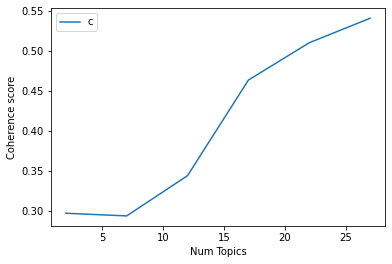

In [122]:
# Plot to see coherence score in order to choose optimal number of topics and decide optimal model
limit=30; start=2; step=5;
x = range(start, limit, step)
plt.plot(x, coherence_values_ph_2018_score1N2N3)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [123]:
# Print the coherence scores
index = 0
for m, cv in zip(x, coherence_values_ph_2018_score1N2N3):
    print("index:",index,"|","Num Topics =", m, " has Coherence Value of", round(cv, 4))
    index = index + 1

# optimal num_topics = 27

index: 0 | Num Topics = 2  has Coherence Value of 0.2967
index: 1 | Num Topics = 7  has Coherence Value of 0.2934
index: 2 | Num Topics = 12  has Coherence Value of 0.3439
index: 3 | Num Topics = 17  has Coherence Value of 0.4636
index: 4 | Num Topics = 22  has Coherence Value of 0.5104
index: 5 | Num Topics = 27  has Coherence Value of 0.5411


In [178]:
# Select optimal number of topics
optimal_model_ph_2018_score1N2N3 = model_list_ph_2018_score1N2N3[5]

In [179]:
# pyLDAVis
pyLDAvis.enable_notebook()
vis_ph_2018_score1N2N3 = pyLDAvis.gensim_models.prepare(optimal_model_ph_2018_score1N2N3, corpus_ph_2018_score1N2N3, id2word_ph_2018_score1N2N3)

In [180]:
print("pyLDAVis for ph topics for score=1,2,3 in 2018:")
vis_ph_2018_score1N2N3

pyLDAVis for ph topics for score=1,2,3 in 2018:


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
23     0.196901 -0.041732       1        1  21.253348
12     0.161264 -0.001575       2        1  12.942100
5      0.137782  0.056358       3        1   6.872485
19     0.068699  0.178622       4        1   5.943038
24    -0.112420 -0.133742       5        1   5.888022
7      0.091375 -0.061842       6        1   5.841523
26     0.131432 -0.067382       7        1   4.834057
0      0.029755 -0.052464       8        1   4.260167
22     0.018194  0.154723       9        1   4.196515
3      0.112717 -0.020885      10        1   3.988881
16     0.080102 -0.027273      11        1   3.609533
14    -0.096536  0.081824      12        1   2.571386
20    -0.102233 -0.102797      13        1   2.462801
15    -0.061774 -0.010652      14        1   2.412034
11     0.079102 -0.039532      15        1   2.249375
10     0.012625  0.001300      16        1   2.137076
9     -0.075654  0.170091      17        1   1.907559
17    -0.080263 -0.047026      18        1   1.850878
13     0.003794 -0.026331      19        1   1.485876
25    -0.073288 -0.015091      20        1   1.268953
21    -0.017605 -0.006394      21        1   1.268953
4     -0.083994  0.001967      22        1   0.125907
18    -0.083995  0.001967      23        1   0.125907
1     -0.083995  0.001967      24        1   0.125907
6     -0.083995  0.001967      25        1   0.125907
2     -0.083995  0.001967      26        1   0.125907
8     -0.083995  0.001967      27        1   0.125907, topic_info=          Term       Freq      Total Category  logprob  loglift
17     account  39.000000  39.000000  Default  30.0000  30.0000
34      update  73.000000  73.000000  Default  29.0000  29.0000
0          app  52.000000  52.000000  Default  28.0000  28.0000
51        post  30.000000  30.000000  Default  27.0000  27.0000
6          log  28.000000  28.000000  Default  26.0000  26.0000
..         ...        ...        ...      ...      ...      ...
35        able   0.004088   4.912179  Topic27  -6.3404  -0.4140
50        page   0.004088   3.846240  Topic27  -6.3404  -0.1694
15  uninstalle   0.004088   3.072633  Topic27  -6.3404   0.0552
17     account   0.004088  39.963743  Topic27  -6.3404  -2.5103
30     problem   0.004088  19.970506  Topic27  -6.3404  -1.8165

[1326 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
35        2  0.407151       able
35        3  0.407151       able
35        4  0.203576       able
238       2  0.669900     abroad
276       1  0.453390     access
...     ...       ...        ...
342       1  0.422668  yesterday
342       3  0.422668  yesterday
64        2  0.315316        yet
64        3  0.315316        yet
64        4  0.315316        yet

[1065 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[24, 13, 6, 20, 25, 8, 27, 1, 23, 4, 17, 15, 21, 16, 12, 11, 10, 18, 14, 26, 22, 5, 19, 2, 7, 3, 9])

## By-rating of 2019 (Rating=1,2,3)

In [127]:
# By-rating Topic Modelling - rating = 1,2,3 in 2019
# Convert to list - move to each section
review_ph_2019_score1N2N3 = facebook_ios_ph_review_YearMonth_2019_score1N2N3.review.values.tolist()
review_words_ph_2019_score1N2N3 = list(sent_to_words(review_ph_2019_score1N2N3))
print(review_words_ph_2019_score1N2N3[:1])

[['updated', 'my', 'facebook', 'on', 'my', 'iphone', 'but', 'my', 'profile', 'picture', 'is', 'still', 'circle', 'shape', 'and', 'can', 'only', 'have', 'featured', 'photos', 'maximum', 'instead', 'of', 'for', 'the', 'new', 'update', 'already', 'installed', 'and', 'reinstalled', 'it', 'but', 'the', 'result', 'is', 'same', 'how', 'can', 'change', 'it', 'please', 'fix', 'it']]


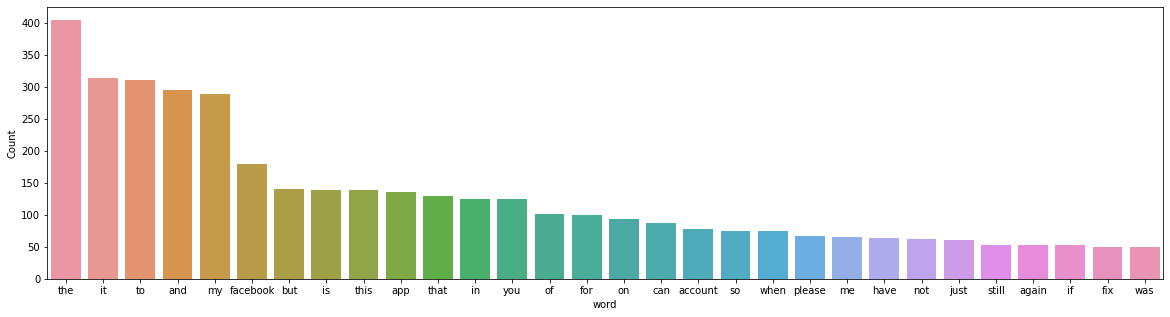

In [128]:
# Inspect the frequency of words before cleaning
freq_words(flatten(review_words_ph_2019_score1N2N3))

In [129]:
# Clean text
review_words_ph_ready_2019_score1N2N3 = process_words(review_words_ph_2019_score1N2N3)  # processed Text Data! - move to each section

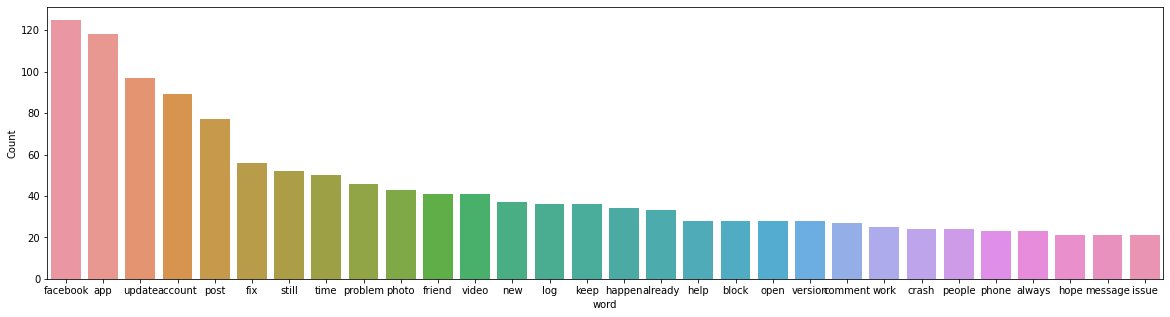

In [130]:
# Inspect the frequency of words after cleaning
freq_words(flatten(review_words_ph_ready_2019_score1N2N3))


In [131]:
# Create Dictionary
id2word_ph_2019_score1N2N3 = corpora.Dictionary(review_words_ph_ready_2019_score1N2N3)

2021-10-16 18:56:33,710 [INFO] gensim.corpora.dictionary - adding document #0 to Dictionary(0 unique tokens: [])
2021-10-16 18:56:33,726 [INFO] gensim.corpora.dictionary - built Dictionary(889 unique tokens: ['already', 'change', 'circle', 'facebook', 'feature']...) from 129 documents (total 3905 corpus positions)
2021-10-16 18:56:33,728 [INFO] gensim.utils - Dictionary lifecycle event {'msg': "built Dictionary(889 unique tokens: ['already', 'change', 'circle', 'facebook', 'feature']...) from 129 documents (total 3905 corpus positions)", 'datetime': '2021-10-16T18:56:33.728197', 'gensim': '4.1.2', 'python': '3.8.8 (default, Apr 13 2021, 12:59:45) \n[Clang 10.0.0 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'created'}


In [132]:
# Create Corpus: Term Document Frequency
corpus_ph_2019_score1N2N3 = [id2word_ph_2019_score1N2N3.doc2bow(text) for text in review_words_ph_ready_2019_score1N2N3]

In [133]:
# Training LDA model
model_list_ph_2019_score1N2N3, coherence_values_ph_2019_score1N2N3 = compute_coherence_values(dictionary=id2word_ph_2019_score1N2N3, corpus=corpus_ph_2019_score1N2N3, 
                                                              texts=review_words_ph_ready_2019_score1N2N3, limit=30, start=2, step=5)


2021-10-16 18:56:33,768 [INFO] gensim.models.ldamodel - using symmetric alpha at 0.5
2021-10-16 18:56:33,771 [INFO] gensim.models.ldamodel - using symmetric eta at 0.5
2021-10-16 18:56:33,775 [INFO] gensim.models.ldamodel - using serial LDA version on this node
2021-10-16 18:56:33,779 [INFO] gensim.models.ldamodel - running online (multi-pass) LDA training, 2 topics, 50 passes over the supplied corpus of 129 documents, updating model once every 129 documents, evaluating perplexity every 129 documents, iterating 50x with a convergence threshold of 0.001000
2021-10-16 18:56:34,285 [INFO] gensim.models.ldamodel - -7.353 per-word bound, 163.4 perplexity estimate based on a held-out corpus of 129 documents with 3905 words
2021-10-16 18:56:34,286 [INFO] gensim.models.ldamodel - PROGRESS: pass 0, at document #129/129
2021-10-16 18:56:34,690 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.030*"facebook" + 0.021*"update" + 0.019*"account" + 0.018*"post" + 0.017*"app" + 0.015*"fix" + 0.014*"

2021-10-16 18:56:40,960 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.037*"app" + 0.020*"facebook" + 0.020*"account" + 0.017*"update" + 0.015*"photo" + 0.013*"time" + 0.011*"post" + 0.010*"open" + 0.010*"friend" + 0.009*"already"
2021-10-16 18:56:40,971 [INFO] gensim.models.ldamodel - topic diff=0.013994, rho=0.301511
2021-10-16 18:56:41,316 [INFO] gensim.models.ldamodel - -6.263 per-word bound, 76.8 perplexity estimate based on a held-out corpus of 129 documents with 3905 words
2021-10-16 18:56:41,317 [INFO] gensim.models.ldamodel - PROGRESS: pass 10, at document #129/129
2021-10-16 18:56:41,590 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.032*"facebook" + 0.023*"update" + 0.021*"post" + 0.018*"account" + 0.016*"fix" + 0.015*"still" + 0.015*"problem" + 0.014*"app" + 0.014*"video" + 0.011*"new"
2021-10-16 18:56:41,600 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.037*"app" + 0.020*"facebook" + 0.020*"account" + 0.017*"update" + 0.015*"photo" + 0.013*"time" + 0.011*"p

2021-10-16 18:56:46,919 [INFO] gensim.models.ldamodel - topic diff=0.007974, rho=0.218218
2021-10-16 18:56:47,281 [INFO] gensim.models.ldamodel - -6.257 per-word bound, 76.5 perplexity estimate based on a held-out corpus of 129 documents with 3905 words
2021-10-16 18:56:47,283 [INFO] gensim.models.ldamodel - PROGRESS: pass 20, at document #129/129
2021-10-16 18:56:47,554 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.032*"facebook" + 0.024*"update" + 0.022*"post" + 0.018*"account" + 0.016*"fix" + 0.015*"still" + 0.015*"problem" + 0.014*"app" + 0.014*"video" + 0.011*"new"
2021-10-16 18:56:47,555 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.039*"app" + 0.019*"account" + 0.019*"facebook" + 0.017*"update" + 0.015*"photo" + 0.013*"time" + 0.011*"open" + 0.009*"friend" + 0.009*"post" + 0.008*"already"
2021-10-16 18:56:47,558 [INFO] gensim.models.ldamodel - topic diff=0.007924, rho=0.213201
2021-10-16 18:56:47,841 [INFO] gensim.models.ldamodel - -6.256 per-word bound, 76.4 perplex

2021-10-16 18:56:52,964 [INFO] gensim.models.ldamodel - -6.252 per-word bound, 76.2 perplexity estimate based on a held-out corpus of 129 documents with 3905 words
2021-10-16 18:56:52,966 [INFO] gensim.models.ldamodel - PROGRESS: pass 30, at document #129/129
2021-10-16 18:56:53,220 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.033*"facebook" + 0.024*"update" + 0.023*"post" + 0.019*"account" + 0.017*"fix" + 0.015*"still" + 0.015*"problem" + 0.013*"app" + 0.013*"video" + 0.010*"new"
2021-10-16 18:56:53,247 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.040*"app" + 0.019*"account" + 0.018*"facebook" + 0.016*"update" + 0.016*"photo" + 0.013*"time" + 0.011*"open" + 0.009*"friend" + 0.008*"post" + 0.008*"already"
2021-10-16 18:56:53,272 [INFO] gensim.models.ldamodel - topic diff=0.005228, rho=0.176777
2021-10-16 18:56:53,568 [INFO] gensim.models.ldamodel - -6.252 per-word bound, 76.2 perplexity estimate based on a held-out corpus of 129 documents with 3905 words
2021-10-16 18:56:

2021-10-16 18:56:58,601 [INFO] gensim.models.ldamodel - PROGRESS: pass 40, at document #129/129
2021-10-16 18:56:58,868 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.033*"facebook" + 0.024*"update" + 0.023*"post" + 0.019*"account" + 0.017*"fix" + 0.015*"still" + 0.015*"problem" + 0.013*"app" + 0.013*"video" + 0.010*"new"
2021-10-16 18:56:58,875 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.040*"app" + 0.018*"account" + 0.018*"facebook" + 0.016*"photo" + 0.016*"update" + 0.012*"time" + 0.011*"open" + 0.009*"friend" + 0.008*"already" + 0.008*"post"
2021-10-16 18:56:58,877 [INFO] gensim.models.ldamodel - topic diff=0.004404, rho=0.154303
2021-10-16 18:56:59,198 [INFO] gensim.models.ldamodel - -6.249 per-word bound, 76.1 perplexity estimate based on a held-out corpus of 129 documents with 3905 words
2021-10-16 18:56:59,201 [INFO] gensim.models.ldamodel - PROGRESS: pass 41, at document #129/129
2021-10-16 18:56:59,415 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.033*"face

2021-10-16 18:57:03,794 [INFO] gensim.topic_coherence.probability_estimation - using ParallelWordOccurrenceAccumulator(processes=7, batch_size=64) to estimate probabilities from sliding windows
2021-10-16 18:57:09,059 [INFO] gensim.topic_coherence.text_analysis - 7 accumulators retrieved from output queue
2021-10-16 18:57:09,110 [INFO] gensim.topic_coherence.text_analysis - accumulated word occurrence stats for 129 virtual documents
2021-10-16 18:57:09,564 [INFO] gensim.models.ldamodel - using symmetric alpha at 0.14285714285714285
2021-10-16 18:57:09,565 [INFO] gensim.models.ldamodel - using symmetric eta at 0.14285714285714285
2021-10-16 18:57:09,568 [INFO] gensim.models.ldamodel - using serial LDA version on this node
2021-10-16 18:57:09,571 [INFO] gensim.models.ldamodel - running online (multi-pass) LDA training, 7 topics, 50 passes over the supplied corpus of 129 documents, updating model once every 129 documents, evaluating perplexity every 129 documents, iterating 50x with a con

2021-10-16 18:57:12,744 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.029*"facebook" + 0.025*"update" + 0.023*"account" + 0.019*"new" + 0.017*"still" + 0.014*"app" + 0.013*"error" + 0.013*"log" + 0.012*"change" + 0.011*"problem"
2021-10-16 18:57:12,746 [INFO] gensim.models.ldamodel - topic diff=0.116480, rho=0.408248
2021-10-16 18:57:12,959 [INFO] gensim.models.ldamodel - -6.470 per-word bound, 88.6 perplexity estimate based on a held-out corpus of 129 documents with 3905 words
2021-10-16 18:57:12,960 [INFO] gensim.models.ldamodel - PROGRESS: pass 5, at document #129/129
2021-10-16 18:57:13,169 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.024*"account" + 0.022*"time" + 0.019*"facebook" + 0.018*"new" + 0.014*"post" + 0.013*"fix" + 0.013*"happen" + 0.012*"page" + 0.011*"friend" + 0.010*"help"
2021-10-16 18:57:13,171 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.043*"app" + 0.027*"facebook" + 0.027*"update" + 0.016*"time" + 0.016*"crash" + 0.013*"keep" + 0.013*"photo" +

2021-10-16 18:57:15,213 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.035*"post" + 0.033*"app" + 0.029*"update" + 0.027*"facebook" + 0.023*"still" + 0.022*"video" + 0.017*"fix" + 0.017*"block" + 0.016*"problem" + 0.012*"comment"
2021-10-16 18:57:15,215 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.028*"facebook" + 0.026*"account" + 0.024*"update" + 0.019*"new" + 0.018*"error" + 0.017*"still" + 0.016*"log" + 0.014*"unexpected" + 0.013*"app" + 0.013*"happen"
2021-10-16 18:57:15,217 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.039*"facebook" + 0.030*"post" + 0.014*"messenger" + 0.012*"account" + 0.010*"day" + 0.008*"app" + 0.008*"thing" + 0.008*"issue" + 0.008*"disabled" + 0.008*"send"
2021-10-16 18:57:15,219 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.044*"app" + 0.028*"update" + 0.027*"facebook" + 0.017*"crash" + 0.017*"time" + 0.013*"keep" + 0.013*"photo" + 0.011*"help" + 0.010*"new" + 0.009*"user"
2021-10-16 18:57:15,221 [INFO] gensim.models.ldamodel - topic

2021-10-16 18:57:17,247 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.061*"account" + 0.032*"facebook" + 0.021*"fix" + 0.020*"update" + 0.018*"log" + 0.014*"show" + 0.012*"problem" + 0.012*"friend" + 0.011*"help" + 0.011*"app"
2021-10-16 18:57:17,248 [INFO] gensim.models.ldamodel - topic diff=0.009014, rho=0.242536
2021-10-16 18:57:17,464 [INFO] gensim.models.ldamodel - -6.436 per-word bound, 86.6 perplexity estimate based on a held-out corpus of 129 documents with 3905 words
2021-10-16 18:57:17,465 [INFO] gensim.models.ldamodel - PROGRESS: pass 16, at document #129/129
2021-10-16 18:57:17,597 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.062*"account" + 0.032*"facebook" + 0.021*"fix" + 0.020*"update" + 0.018*"log" + 0.014*"show" + 0.012*"friend" + 0.012*"problem" + 0.011*"help" + 0.011*"app"
2021-10-16 18:57:17,598 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.039*"facebook" + 0.030*"post" + 0.014*"messenger" + 0.012*"account" + 0.010*"day" + 0.008*"app" + 0.008*"thi

2021-10-16 18:57:19,571 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.065*"account" + 0.032*"facebook" + 0.020*"fix" + 0.019*"update" + 0.019*"log" + 0.014*"show" + 0.012*"friend" + 0.012*"help" + 0.011*"problem" + 0.010*"app"
2021-10-16 18:57:19,573 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.036*"photo" + 0.027*"app" + 0.014*"messenger" + 0.014*"click" + 0.014*"log" + 0.013*"time" + 0.010*"upload" + 0.009*"view" + 0.009*"album" + 0.009*"back"
2021-10-16 18:57:19,578 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.025*"account" + 0.017*"new" + 0.017*"time" + 0.014*"facebook" + 0.014*"page" + 0.013*"fix" + 0.011*"picture" + 0.011*"save" + 0.010*"happen" + 0.010*"help"
2021-10-16 18:57:19,580 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.046*"app" + 0.028*"update" + 0.028*"facebook" + 0.017*"crash" + 0.017*"time" + 0.013*"keep" + 0.013*"photo" + 0.011*"help" + 0.010*"new" + 0.010*"user"
2021-10-16 18:57:19,583 [INFO] gensim.models.ldamodel - topic diff=0.004722, 

2021-10-16 18:57:21,435 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.040*"post" + 0.034*"app" + 0.028*"update" + 0.028*"facebook" + 0.023*"still" + 0.021*"video" + 0.018*"fix" + 0.017*"problem" + 0.016*"block" + 0.013*"time"
2021-10-16 18:57:21,437 [INFO] gensim.models.ldamodel - topic diff=0.003141, rho=0.188982
2021-10-16 18:57:21,676 [INFO] gensim.models.ldamodel - -6.427 per-word bound, 86.0 perplexity estimate based on a held-out corpus of 129 documents with 3905 words
2021-10-16 18:57:21,677 [INFO] gensim.models.ldamodel - PROGRESS: pass 27, at document #129/129
2021-10-16 18:57:21,814 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.025*"account" + 0.017*"new" + 0.016*"time" + 0.014*"page" + 0.013*"facebook" + 0.012*"fix" + 0.011*"picture" + 0.011*"save" + 0.010*"help" + 0.010*"happen"
2021-10-16 18:57:21,815 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.036*"photo" + 0.027*"app" + 0.014*"click" + 0.014*"messenger" + 0.013*"log" + 0.013*"time" + 0.010*"upload" + 

2021-10-16 18:57:23,675 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.027*"facebook" + 0.027*"account" + 0.024*"update" + 0.022*"error" + 0.019*"new" + 0.017*"log" + 0.016*"still" + 0.016*"unexpected" + 0.015*"happen" + 0.012*"problem"
2021-10-16 18:57:23,677 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.046*"app" + 0.029*"facebook" + 0.028*"update" + 0.017*"crash" + 0.017*"time" + 0.013*"keep" + 0.013*"photo" + 0.011*"help" + 0.010*"new" + 0.010*"application"
2021-10-16 18:57:23,679 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.036*"photo" + 0.027*"app" + 0.014*"click" + 0.014*"messenger" + 0.013*"time" + 0.013*"log" + 0.010*"upload" + 0.009*"view" + 0.009*"album" + 0.009*"back"
2021-10-16 18:57:23,682 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.040*"post" + 0.034*"app" + 0.028*"update" + 0.027*"facebook" + 0.023*"still" + 0.021*"video" + 0.019*"fix" + 0.018*"problem" + 0.016*"block" + 0.014*"time"
2021-10-16 18:57:23,684 [INFO] gensim.models.ldamodel - topic

2021-10-16 18:57:25,557 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.039*"facebook" + 0.030*"post" + 0.014*"messenger" + 0.012*"account" + 0.010*"day" + 0.008*"picture" + 0.008*"thing" + 0.008*"issue" + 0.008*"send" + 0.008*"notification"
2021-10-16 18:57:25,559 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.036*"photo" + 0.027*"app" + 0.014*"click" + 0.014*"messenger" + 0.013*"time" + 0.012*"log" + 0.010*"upload" + 0.009*"view" + 0.009*"album" + 0.009*"back"
2021-10-16 18:57:25,560 [INFO] gensim.models.ldamodel - topic diff=0.001495, rho=0.160128
2021-10-16 18:57:25,813 [INFO] gensim.models.ldamodel - -6.424 per-word bound, 85.9 perplexity estimate based on a held-out corpus of 129 documents with 3905 words
2021-10-16 18:57:25,814 [INFO] gensim.models.ldamodel - PROGRESS: pass 38, at document #129/129
2021-10-16 18:57:25,964 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.041*"post" + 0.034*"app" + 0.028*"update" + 0.027*"facebook" + 0.023*"still" + 0.021*"video" + 0.0

2021-10-16 18:57:27,732 [INFO] gensim.models.ldamodel - -6.424 per-word bound, 85.9 perplexity estimate based on a held-out corpus of 129 documents with 3905 words
2021-10-16 18:57:27,735 [INFO] gensim.models.ldamodel - PROGRESS: pass 43, at document #129/129
2021-10-16 18:57:27,927 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.027*"facebook" + 0.027*"account" + 0.023*"update" + 0.023*"error" + 0.019*"new" + 0.017*"log" + 0.016*"still" + 0.016*"unexpected" + 0.015*"happen" + 0.012*"change"
2021-10-16 18:57:27,929 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.036*"photo" + 0.027*"app" + 0.015*"click" + 0.014*"messenger" + 0.013*"time" + 0.012*"log" + 0.010*"upload" + 0.009*"view" + 0.009*"album" + 0.009*"back"
2021-10-16 18:57:27,931 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.046*"app" + 0.029*"facebook" + 0.028*"update" + 0.017*"crash" + 0.017*"time" + 0.013*"keep" + 0.013*"photo" + 0.011*"help" + 0.010*"new" + 0.010*"application"
2021-10-16 18:57:27,932 [INFO] gen

2021-10-16 18:57:29,883 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.027*"facebook" + 0.027*"account" + 0.023*"update" + 0.023*"error" + 0.019*"new" + 0.017*"log" + 0.016*"still" + 0.016*"unexpected" + 0.015*"happen" + 0.012*"change"
2021-10-16 18:57:29,886 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.039*"facebook" + 0.030*"post" + 0.014*"messenger" + 0.012*"account" + 0.010*"day" + 0.008*"picture" + 0.008*"thing" + 0.008*"issue" + 0.008*"send" + 0.008*"notification"
2021-10-16 18:57:29,893 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.068*"account" + 0.032*"facebook" + 0.022*"log" + 0.019*"update" + 0.019*"fix" + 0.016*"show" + 0.012*"friend" + 0.012*"help" + 0.010*"report" + 0.010*"problem"
2021-10-16 18:57:29,895 [INFO] gensim.models.ldamodel - topic diff=0.000795, rho=0.141421
2021-10-16 18:57:30,079 [INFO] gensim.models.ldamodel - -6.423 per-word bound, 85.8 perplexity estimate based on a held-out corpus of 129 documents with 3905 words
2021-10-16 18:57:30,080

2021-10-16 18:57:37,650 [INFO] gensim.models.ldamodel - topic diff=0.286453, rho=0.500000
2021-10-16 18:57:37,933 [INFO] gensim.models.ldamodel - -6.614 per-word bound, 98.0 perplexity estimate based on a held-out corpus of 129 documents with 3905 words
2021-10-16 18:57:37,934 [INFO] gensim.models.ldamodel - PROGRESS: pass 3, at document #129/129
2021-10-16 18:57:38,043 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.053*"app" + 0.020*"update" + 0.014*"problem" + 0.013*"notification" + 0.012*"bug" + 0.010*"already" + 0.010*"still" + 0.010*"user" + 0.010*"sure" + 0.010*"item"
2021-10-16 18:57:38,044 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.038*"facebook" + 0.034*"post" + 0.027*"day" + 0.017*"comment" + 0.016*"update" + 0.016*"app" + 0.012*"picture" + 0.012*"account" + 0.012*"new" + 0.012*"access"
2021-10-16 18:57:38,047 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.052*"account" + 0.048*"facebook" + 0.028*"new" + 0.024*"log" + 0.024*"update" + 0.018*"error" + 0.012*

2021-10-16 18:57:39,903 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.038*"facebook" + 0.035*"post" + 0.027*"day" + 0.018*"comment" + 0.016*"update" + 0.016*"app" + 0.012*"picture" + 0.012*"account" + 0.012*"new" + 0.012*"access"
2021-10-16 18:57:39,905 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.053*"account" + 0.043*"facebook" + 0.017*"fix" + 0.013*"hope" + 0.013*"problem" + 0.012*"report" + 0.012*"friend" + 0.012*"message" + 0.011*"profile" + 0.011*"reason"
2021-10-16 18:57:39,907 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.044*"account" + 0.040*"log" + 0.030*"messenger" + 0.029*"error" + 0.020*"help" + 0.018*"unexpected" + 0.014*"app" + 0.014*"facebook" + 0.014*"disable" + 0.013*"minute"
2021-10-16 18:57:39,909 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.054*"account" + 0.049*"facebook" + 0.031*"new" + 0.025*"update" + 0.024*"log" + 0.018*"error" + 0.012*"occur" + 0.012*"picture" + 0.012*"profile" + 0.011*"version"
2021-10-16 18:57:39,910 [INFO] gensim

2021-10-16 18:57:41,740 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.029*"time" + 0.023*"page" + 0.018*"scroll" + 0.018*"crash" + 0.018*"fix" + 0.016*"keep" + 0.015*"post" + 0.015*"problem" + 0.014*"friend" + 0.012*"update"
2021-10-16 18:57:41,746 [INFO] gensim.models.ldamodel - topic diff=0.013585, rho=0.258199
2021-10-16 18:57:41,938 [INFO] gensim.models.ldamodel - -6.512 per-word bound, 91.3 perplexity estimate based on a held-out corpus of 129 documents with 3905 words
2021-10-16 18:57:41,940 [INFO] gensim.models.ldamodel - PROGRESS: pass 14, at document #129/129
2021-10-16 18:57:42,053 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.038*"facebook" + 0.035*"post" + 0.027*"day" + 0.019*"comment" + 0.016*"update" + 0.016*"app" + 0.012*"picture" + 0.012*"account" + 0.012*"new" + 0.012*"access"
2021-10-16 18:57:42,057 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.032*"post" + 0.020*"update" + 0.019*"still" + 0.015*"video" + 0.015*"friend" + 0.015*"old" + 0.014*"comment

2021-10-16 18:57:43,789 [INFO] gensim.models.ldamodel - PROGRESS: pass 19, at document #129/129
2021-10-16 18:57:43,855 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.052*"app" + 0.020*"update" + 0.014*"problem" + 0.013*"notification" + 0.013*"bug" + 0.010*"already" + 0.010*"still" + 0.010*"user" + 0.010*"sure" + 0.010*"item"
2021-10-16 18:57:43,857 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.049*"photo" + 0.036*"app" + 0.029*"facebook" + 0.023*"post" + 0.022*"problem" + 0.021*"update" + 0.021*"keep" + 0.019*"album" + 0.019*"still" + 0.016*"open"
2021-10-16 18:57:43,859 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.030*"post" + 0.020*"update" + 0.018*"still" + 0.015*"video" + 0.015*"old" + 0.015*"friend" + 0.014*"comment" + 0.012*"already" + 0.012*"facebook" + 0.012*"new"
2021-10-16 18:57:43,861 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.054*"account" + 0.049*"facebook" + 0.032*"new" + 0.025*"update" + 0.024*"log" + 0.018*"error" + 0.012*"occur" + 0.012*"pi

2021-10-16 18:57:45,567 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.041*"app" + 0.038*"facebook" + 0.029*"update" + 0.022*"crash" + 0.019*"time" + 0.016*"application" + 0.013*"happen" + 0.011*"install" + 0.011*"request" + 0.011*"message"
2021-10-16 18:57:45,578 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.044*"account" + 0.039*"log" + 0.031*"error" + 0.031*"messenger" + 0.021*"help" + 0.018*"unexpected" + 0.014*"app" + 0.013*"facebook" + 0.013*"disable" + 0.013*"minute"
2021-10-16 18:57:45,582 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.038*"facebook" + 0.035*"post" + 0.027*"day" + 0.019*"comment" + 0.016*"update" + 0.016*"app" + 0.012*"picture" + 0.012*"account" + 0.012*"new" + 0.012*"access"
2021-10-16 18:57:45,586 [INFO] gensim.models.ldamodel - topic diff=0.002937, rho=0.196116
2021-10-16 18:57:45,821 [INFO] gensim.models.ldamodel - -6.502 per-word bound, 90.6 perplexity estimate based on a held-out corpus of 129 documents with 3905 words
2021-10-16 18:57:45,

2021-10-16 18:57:47,709 [INFO] gensim.models.ldamodel - topic diff=0.001919, rho=0.179605
2021-10-16 18:57:47,934 [INFO] gensim.models.ldamodel - -6.500 per-word bound, 90.5 perplexity estimate based on a held-out corpus of 129 documents with 3905 words
2021-10-16 18:57:47,936 [INFO] gensim.models.ldamodel - PROGRESS: pass 30, at document #129/129
2021-10-16 18:57:48,091 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.054*"account" + 0.049*"facebook" + 0.032*"new" + 0.025*"update" + 0.024*"log" + 0.018*"error" + 0.012*"occur" + 0.012*"picture" + 0.012*"profile" + 0.012*"version"
2021-10-16 18:57:48,093 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.052*"app" + 0.020*"update" + 0.014*"problem" + 0.013*"notification" + 0.013*"bug" + 0.010*"already" + 0.010*"still" + 0.010*"user" + 0.010*"sure" + 0.010*"item"
2021-10-16 18:57:48,096 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.055*"account" + 0.044*"facebook" + 0.018*"fix" + 0.014*"problem" + 0.013*"hope" + 0.013*"report" 

2021-10-16 18:57:50,506 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.052*"app" + 0.020*"update" + 0.014*"problem" + 0.013*"notification" + 0.013*"bug" + 0.010*"already" + 0.010*"still" + 0.010*"user" + 0.010*"sure" + 0.010*"item"
2021-10-16 18:57:50,514 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.057*"account" + 0.049*"facebook" + 0.032*"new" + 0.025*"update" + 0.025*"log" + 0.018*"error" + 0.012*"occur" + 0.012*"picture" + 0.012*"profile" + 0.012*"version"
2021-10-16 18:57:50,516 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.046*"post" + 0.033*"facebook" + 0.030*"block" + 0.024*"app" + 0.022*"update" + 0.019*"still" + 0.014*"account" + 0.013*"people" + 0.013*"already" + 0.011*"action"
2021-10-16 18:57:50,521 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.029*"time" + 0.023*"page" + 0.018*"scroll" + 0.018*"crash" + 0.017*"fix" + 0.016*"keep" + 0.016*"problem" + 0.015*"post" + 0.014*"friend" + 0.012*"update"
2021-10-16 18:57:50,523 [INFO] gensim.models.ldamodel

2021-10-16 18:57:52,677 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.024*"video" + 0.023*"problem" + 0.021*"fix" + 0.019*"hate" + 0.017*"update" + 0.016*"always" + 0.016*"people" + 0.016*"speech" + 0.016*"friend" + 0.014*"photo"
2021-10-16 18:57:52,678 [INFO] gensim.models.ldamodel - topic diff=0.001099, rho=0.154303
2021-10-16 18:57:52,857 [INFO] gensim.models.ldamodel - -6.500 per-word bound, 90.5 perplexity estimate based on a held-out corpus of 129 documents with 3905 words
2021-10-16 18:57:52,860 [INFO] gensim.models.ldamodel - PROGRESS: pass 41, at document #129/129
2021-10-16 18:57:52,968 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.055*"account" + 0.045*"facebook" + 0.018*"fix" + 0.014*"problem" + 0.013*"hope" + 0.013*"message" + 0.013*"report" + 0.011*"reason" + 0.010*"profile" + 0.010*"show"
2021-10-16 18:57:52,970 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.047*"post" + 0.033*"facebook" + 0.031*"block" + 0.024*"app" + 0.021*"update" + 0.018*"still" + 0

2021-10-16 18:57:54,701 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.029*"post" + 0.020*"update" + 0.018*"still" + 0.016*"video" + 0.015*"old" + 0.014*"friend" + 0.014*"comment" + 0.012*"facebook" + 0.012*"already" + 0.012*"new"
2021-10-16 18:57:54,705 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.040*"app" + 0.038*"facebook" + 0.028*"update" + 0.022*"crash" + 0.019*"time" + 0.016*"application" + 0.013*"happen" + 0.011*"request" + 0.011*"message" + 0.011*"install"
2021-10-16 18:57:54,709 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.052*"app" + 0.020*"update" + 0.014*"problem" + 0.013*"bug" + 0.013*"notification" + 0.010*"already" + 0.010*"user" + 0.010*"sure" + 0.010*"however" + 0.010*"still"
2021-10-16 18:57:54,715 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.045*"account" + 0.043*"log" + 0.035*"error" + 0.030*"messenger" + 0.024*"unexpected" + 0.020*"help" + 0.014*"app" + 0.014*"facebook" + 0.013*"friend" + 0.013*"disable"
2021-10-16 18:57:54,718 [INFO] gen

2021-10-16 18:58:03,093 [INFO] gensim.models.ldamodel - topic #7 (0.059): 0.037*"post" + 0.035*"update" + 0.034*"video" + 0.023*"still" + 0.021*"fix" + 0.020*"already" + 0.015*"new" + 0.015*"friend" + 0.014*"watch" + 0.014*"always"
2021-10-16 18:58:03,095 [INFO] gensim.models.ldamodel - topic #11 (0.059): 0.044*"photo" + 0.024*"facebook" + 0.022*"post" + 0.021*"still" + 0.018*"refresh" + 0.017*"view" + 0.016*"hour" + 0.015*"album" + 0.015*"keep" + 0.013*"newsfeed"
2021-10-16 18:58:03,097 [INFO] gensim.models.ldamodel - topic diff=12.231113, rho=1.000000
2021-10-16 18:58:03,322 [INFO] gensim.models.ldamodel - -7.032 per-word bound, 130.9 perplexity estimate based on a held-out corpus of 129 documents with 3905 words
2021-10-16 18:58:03,323 [INFO] gensim.models.ldamodel - PROGRESS: pass 1, at document #129/129
2021-10-16 18:58:03,449 [INFO] gensim.models.ldamodel - topic #2 (0.059): 0.042*"account" + 0.039*"log" + 0.032*"facebook" + 0.029*"profile" + 0.025*"picture" + 0.020*"photo" + 0.0

2021-10-16 18:58:05,293 [INFO] gensim.models.ldamodel - PROGRESS: pass 6, at document #129/129
2021-10-16 18:58:05,396 [INFO] gensim.models.ldamodel - topic #13 (0.059): 0.054*"update" + 0.048*"app" + 0.045*"facebook" + 0.027*"time" + 0.023*"version" + 0.017*"fix" + 0.016*"post" + 0.014*"happen" + 0.012*"open" + 0.012*"feature"
2021-10-16 18:58:05,401 [INFO] gensim.models.ldamodel - topic #1 (0.059): 0.032*"photo" + 0.031*"account" + 0.028*"album" + 0.023*"already" + 0.019*"still" + 0.016*"facebook" + 0.016*"log" + 0.016*"disable" + 0.016*"original" + 0.016*"min"
2021-10-16 18:58:05,404 [INFO] gensim.models.ldamodel - topic #2 (0.059): 0.052*"account" + 0.042*"log" + 0.033*"facebook" + 0.028*"profile" + 0.028*"picture" + 0.022*"photo" + 0.021*"iphone" + 0.021*"new" + 0.020*"option" + 0.017*"phone"
2021-10-16 18:58:05,407 [INFO] gensim.models.ldamodel - topic #5 (0.059): 0.048*"post" + 0.041*"facebook" + 0.024*"day" + 0.024*"share" + 0.018*"comment" + 0.014*"account" + 0.011*"app" + 0.0

2021-10-16 18:58:07,314 [INFO] gensim.models.ldamodel - topic #5 (0.059): 0.049*"post" + 0.042*"facebook" + 0.025*"day" + 0.025*"share" + 0.018*"comment" + 0.014*"account" + 0.011*"app" + 0.011*"picture" + 0.011*"young" + 0.011*"story"
2021-10-16 18:58:07,315 [INFO] gensim.models.ldamodel - topic #7 (0.059): 0.052*"video" + 0.047*"update" + 0.038*"post" + 0.031*"already" + 0.028*"still" + 0.025*"fix" + 0.021*"old" + 0.021*"time" + 0.020*"play" + 0.018*"new"
2021-10-16 18:58:07,316 [INFO] gensim.models.ldamodel - topic #14 (0.059): 0.044*"app" + 0.037*"crash" + 0.031*"update" + 0.026*"video" + 0.024*"problem" + 0.022*"keep" + 0.021*"fix" + 0.021*"time" + 0.018*"post" + 0.016*"facebook"
2021-10-16 18:58:07,317 [INFO] gensim.models.ldamodel - topic diff=0.024722, rho=0.277350
2021-10-16 18:58:07,473 [INFO] gensim.models.ldamodel - -6.593 per-word bound, 96.6 perplexity estimate based on a held-out corpus of 129 documents with 3905 words
2021-10-16 18:58:07,475 [INFO] gensim.models.ldamode

2021-10-16 18:58:09,012 [INFO] gensim.models.ldamodel - topic diff=0.010266, rho=0.235702
2021-10-16 18:58:09,259 [INFO] gensim.models.ldamodel - -6.584 per-word bound, 96.0 perplexity estimate based on a held-out corpus of 129 documents with 3905 words
2021-10-16 18:58:09,262 [INFO] gensim.models.ldamodel - PROGRESS: pass 17, at document #129/129
2021-10-16 18:58:09,352 [INFO] gensim.models.ldamodel - topic #5 (0.059): 0.049*"post" + 0.042*"facebook" + 0.025*"share" + 0.025*"day" + 0.018*"comment" + 0.014*"account" + 0.011*"young" + 0.011*"picture" + 0.011*"story" + 0.011*"access"
2021-10-16 18:58:09,354 [INFO] gensim.models.ldamodel - topic #1 (0.059): 0.036*"photo" + 0.032*"account" + 0.030*"album" + 0.024*"already" + 0.022*"still" + 0.016*"facebook" + 0.016*"log" + 0.016*"disable" + 0.016*"original" + 0.016*"min"
2021-10-16 18:58:09,356 [INFO] gensim.models.ldamodel - topic #4 (0.059): 0.085*"account" + 0.062*"facebook" + 0.021*"report" + 0.018*"problem" + 0.018*"log" + 0.017*"hope

2021-10-16 18:58:11,170 [INFO] gensim.models.ldamodel - topic #11 (0.059): 0.046*"photo" + 0.028*"album" + 0.028*"still" + 0.027*"facebook" + 0.022*"post" + 0.022*"view" + 0.018*"refresh" + 0.018*"hour" + 0.015*"update" + 0.014*"keep"
2021-10-16 18:58:11,171 [INFO] gensim.models.ldamodel - topic #5 (0.059): 0.050*"post" + 0.042*"facebook" + 0.026*"share" + 0.025*"day" + 0.018*"comment" + 0.013*"account" + 0.011*"picture" + 0.011*"young" + 0.011*"story" + 0.011*"access"
2021-10-16 18:58:11,173 [INFO] gensim.models.ldamodel - topic #3 (0.059): 0.038*"still" + 0.033*"block" + 0.019*"option" + 0.019*"action" + 0.016*"video" + 0.015*"post" + 0.014*"seller" + 0.014*"answer" + 0.014*"give" + 0.014*"watch"
2021-10-16 18:58:11,175 [INFO] gensim.models.ldamodel - topic #16 (0.059): 0.028*"message" + 0.028*"people" + 0.022*"block" + 0.021*"app" + 0.017*"post" + 0.017*"action" + 0.017*"click" + 0.017*"friend" + 0.017*"read" + 0.017*"stupid"
2021-10-16 18:58:11,177 [INFO] gensim.models.ldamodel - t

2021-10-16 18:58:12,953 [INFO] gensim.models.ldamodel - topic #0 (0.059): 0.047*"account" + 0.028*"time" + 0.019*"cover" + 0.019*"keypad" + 0.019*"new" + 0.019*"name" + 0.010*"keep" + 0.010*"facebook" + 0.010*"add" + 0.010*"one"
2021-10-16 18:58:12,954 [INFO] gensim.models.ldamodel - topic diff=0.004272, rho=0.185695
2021-10-16 18:58:13,105 [INFO] gensim.models.ldamodel - -6.567 per-word bound, 94.8 perplexity estimate based on a held-out corpus of 129 documents with 3905 words
2021-10-16 18:58:13,108 [INFO] gensim.models.ldamodel - PROGRESS: pass 28, at document #129/129
2021-10-16 18:58:13,310 [INFO] gensim.models.ldamodel - topic #10 (0.059): 0.033*"photo" + 0.022*"story" + 0.021*"friend" + 0.018*"app" + 0.017*"post" + 0.017*"next" + 0.017*"let" + 0.017*"maybe" + 0.013*"time" + 0.012*"update"
2021-10-16 18:58:13,311 [INFO] gensim.models.ldamodel - topic #12 (0.059): 0.040*"messenger" + 0.029*"account" + 0.025*"app" + 0.024*"log" + 0.023*"update" + 0.020*"block" + 0.020*"message" + 0

2021-10-16 18:58:15,111 [INFO] gensim.models.ldamodel - topic #11 (0.059): 0.046*"photo" + 0.028*"album" + 0.027*"still" + 0.027*"facebook" + 0.022*"post" + 0.022*"view" + 0.018*"refresh" + 0.018*"hour" + 0.015*"update" + 0.014*"keep"
2021-10-16 18:58:15,113 [INFO] gensim.models.ldamodel - topic #6 (0.059): 0.025*"facebook" + 0.023*"error" + 0.020*"post" + 0.020*"friend" + 0.018*"unexpected" + 0.016*"account" + 0.015*"request" + 0.015*"setting" + 0.014*"help" + 0.014*"app"
2021-10-16 18:58:15,114 [INFO] gensim.models.ldamodel - topic #4 (0.059): 0.084*"account" + 0.061*"facebook" + 0.022*"report" + 0.019*"log" + 0.018*"problem" + 0.017*"hope" + 0.014*"issue" + 0.014*"people" + 0.014*"fix" + 0.013*"team"
2021-10-16 18:58:15,118 [INFO] gensim.models.ldamodel - topic #13 (0.059): 0.063*"update" + 0.052*"facebook" + 0.045*"app" + 0.028*"version" + 0.026*"time" + 0.019*"post" + 0.019*"late" + 0.016*"happen" + 0.015*"fix" + 0.013*"thing"
2021-10-16 18:58:15,119 [INFO] gensim.models.ldamodel 

2021-10-16 18:58:17,153 [INFO] gensim.models.ldamodel - topic #15 (0.059): 0.040*"app" + 0.029*"facebook" + 0.024*"account" + 0.022*"really" + 0.017*"fix" + 0.014*"hate" + 0.014*"update" + 0.013*"open" + 0.012*"new" + 0.012*"people"
2021-10-16 18:58:17,155 [INFO] gensim.models.ldamodel - topic diff=0.002261, rho=0.158114
2021-10-16 18:58:17,376 [INFO] gensim.models.ldamodel - -6.559 per-word bound, 94.3 perplexity estimate based on a held-out corpus of 129 documents with 3905 words
2021-10-16 18:58:17,381 [INFO] gensim.models.ldamodel - PROGRESS: pass 39, at document #129/129
2021-10-16 18:58:17,543 [INFO] gensim.models.ldamodel - topic #2 (0.059): 0.062*"account" + 0.048*"log" + 0.035*"facebook" + 0.035*"picture" + 0.026*"new" + 0.025*"profile" + 0.024*"option" + 0.023*"happen" + 0.020*"photo" + 0.020*"feature"
2021-10-16 18:58:17,544 [INFO] gensim.models.ldamodel - topic #13 (0.059): 0.062*"update" + 0.052*"facebook" + 0.045*"app" + 0.027*"version" + 0.026*"time" + 0.019*"post" + 0.0

2021-10-16 18:58:19,294 [INFO] gensim.models.ldamodel - topic #5 (0.059): 0.051*"post" + 0.042*"facebook" + 0.026*"share" + 0.026*"day" + 0.018*"comment" + 0.013*"account" + 0.011*"picture" + 0.011*"young" + 0.011*"story" + 0.011*"access"
2021-10-16 18:58:19,295 [INFO] gensim.models.ldamodel - topic #3 (0.059): 0.035*"still" + 0.035*"block" + 0.020*"option" + 0.020*"action" + 0.016*"video" + 0.015*"seller" + 0.015*"answer" + 0.015*"give" + 0.015*"watch" + 0.015*"comment"
2021-10-16 18:58:19,297 [INFO] gensim.models.ldamodel - topic #13 (0.059): 0.062*"update" + 0.052*"facebook" + 0.045*"app" + 0.027*"version" + 0.026*"time" + 0.019*"post" + 0.018*"late" + 0.015*"happen" + 0.015*"fix" + 0.014*"thing"
2021-10-16 18:58:19,298 [INFO] gensim.models.ldamodel - topic #7 (0.059): 0.054*"video" + 0.046*"update" + 0.041*"post" + 0.040*"already" + 0.033*"still" + 0.029*"fix" + 0.023*"time" + 0.020*"old" + 0.020*"play" + 0.016*"bug"
2021-10-16 18:58:19,299 [INFO] gensim.models.ldamodel - topic #16

2021-10-16 18:58:20,939 [INFO] gensim.models.ldamodel - topic #12 (0.059): 0.041*"messenger" + 0.029*"account" + 0.024*"app" + 0.024*"log" + 0.021*"update" + 0.021*"block" + 0.020*"message" + 0.017*"page" + 0.017*"check" + 0.016*"help"
2021-10-16 18:58:20,943 [INFO] gensim.models.ldamodel - topic #15 (0.059): 0.040*"app" + 0.029*"facebook" + 0.024*"account" + 0.022*"really" + 0.017*"fix" + 0.014*"hate" + 0.014*"update" + 0.013*"open" + 0.013*"new" + 0.012*"people"
2021-10-16 18:58:20,948 [INFO] gensim.models.ldamodel - topic diff=0.000826, rho=0.140028
2021-10-16 18:58:20,951 [INFO] gensim.utils - LdaModel lifecycle event {'msg': 'trained LdaModel(num_terms=889, num_topics=17, decay=0.5, chunksize=1000) in 18.84s', 'datetime': '2021-10-16T18:58:20.950527', 'gensim': '4.1.2', 'python': '3.8.8 (default, Apr 13 2021, 12:59:45) \n[Clang 10.0.0 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'created'}
2021-10-16 18:58:20,961 [INFO] gensim.topic_coherence.probability_estimation - 

2021-10-16 18:58:31,946 [INFO] gensim.models.ldamodel - PROGRESS: pass 4, at document #129/129
2021-10-16 18:58:32,083 [INFO] gensim.models.ldamodel - topic #5 (0.045): 0.045*"facebook" + 0.026*"issue" + 0.021*"happen" + 0.015*"account" + 0.014*"post" + 0.013*"people" + 0.013*"thing" + 0.013*"dissapointe" + 0.013*"job" + 0.013*"action"
2021-10-16 18:58:32,099 [INFO] gensim.models.ldamodel - topic #14 (0.045): 0.050*"account" + 0.041*"app" + 0.030*"update" + 0.017*"new" + 0.015*"photo" + 0.015*"post" + 0.014*"report" + 0.014*"give" + 0.014*"fix" + 0.014*"rate"
2021-10-16 18:58:32,101 [INFO] gensim.models.ldamodel - topic #8 (0.045): 0.044*"app" + 0.034*"account" + 0.033*"update" + 0.025*"photo" + 0.023*"new" + 0.021*"still" + 0.020*"open" + 0.019*"happen" + 0.019*"version" + 0.015*"video"
2021-10-16 18:58:32,103 [INFO] gensim.models.ldamodel - topic #16 (0.045): 0.035*"app" + 0.035*"message" + 0.029*"block" + 0.022*"post" + 0.022*"action" + 0.022*"click" + 0.021*"read" + 0.021*"stupid" 

2021-10-16 18:58:33,925 [INFO] gensim.models.ldamodel - topic #15 (0.045): 0.042*"account" + 0.031*"time" + 0.029*"facebook" + 0.023*"log" + 0.020*"app" + 0.020*"fix" + 0.018*"problem" + 0.016*"video" + 0.015*"friend" + 0.015*"play"
2021-10-16 18:58:33,928 [INFO] gensim.models.ldamodel - topic #21 (0.045): 0.055*"app" + 0.036*"facebook" + 0.033*"update" + 0.033*"fix" + 0.024*"keep" + 0.023*"time" + 0.019*"video" + 0.018*"hope" + 0.018*"problem" + 0.016*"open"
2021-10-16 18:58:33,929 [INFO] gensim.models.ldamodel - topic diff=0.039834, rho=0.301511
2021-10-16 18:58:34,103 [INFO] gensim.models.ldamodel - -6.670 per-word bound, 101.8 perplexity estimate based on a held-out corpus of 129 documents with 3905 words
2021-10-16 18:58:34,105 [INFO] gensim.models.ldamodel - PROGRESS: pass 10, at document #129/129
2021-10-16 18:58:34,251 [INFO] gensim.models.ldamodel - topic #5 (0.045): 0.045*"facebook" + 0.027*"issue" + 0.020*"happen" + 0.015*"account" + 0.014*"post" + 0.014*"people" + 0.014*"th

2021-10-16 18:58:35,811 [INFO] gensim.models.ldamodel - -6.662 per-word bound, 101.3 perplexity estimate based on a held-out corpus of 129 documents with 3905 words
2021-10-16 18:58:35,816 [INFO] gensim.models.ldamodel - PROGRESS: pass 15, at document #129/129
2021-10-16 18:58:35,981 [INFO] gensim.models.ldamodel - topic #12 (0.045): 0.037*"app" + 0.032*"update" + 0.032*"messenger" + 0.020*"help" + 0.016*"fb" + 0.016*"page" + 0.016*"crash" + 0.016*"time" + 0.016*"minute" + 0.011*"sure"
2021-10-16 18:58:36,027 [INFO] gensim.models.ldamodel - topic #2 (0.045): 0.041*"facebook" + 0.032*"still" + 0.023*"update" + 0.023*"profile" + 0.023*"log" + 0.023*"account" + 0.018*"unexpected" + 0.018*"new" + 0.014*"error" + 0.014*"photo"
2021-10-16 18:58:36,039 [INFO] gensim.models.ldamodel - topic #3 (0.045): 0.034*"post" + 0.026*"tab" + 0.020*"work" + 0.017*"people" + 0.017*"picture" + 0.017*"user" + 0.016*"block" + 0.015*"facebook" + 0.014*"keep" + 0.014*"app"
2021-10-16 18:58:36,042 [INFO] gensim.

2021-10-16 18:58:37,745 [INFO] gensim.models.ldamodel - topic #14 (0.045): 0.053*"account" + 0.040*"app" + 0.027*"update" + 0.017*"report" + 0.016*"new" + 0.014*"photo" + 0.014*"post" + 0.014*"rate" + 0.014*"reason" + 0.014*"disable"
2021-10-16 18:58:37,749 [INFO] gensim.models.ldamodel - topic #5 (0.045): 0.045*"facebook" + 0.027*"issue" + 0.019*"happen" + 0.015*"account" + 0.014*"post" + 0.014*"people" + 0.014*"thing" + 0.014*"save" + 0.014*"almost" + 0.014*"disabled"
2021-10-16 18:58:37,753 [INFO] gensim.models.ldamodel - topic #21 (0.045): 0.055*"app" + 0.036*"facebook" + 0.033*"update" + 0.033*"fix" + 0.024*"keep" + 0.023*"time" + 0.019*"video" + 0.018*"hope" + 0.018*"problem" + 0.016*"open"
2021-10-16 18:58:37,757 [INFO] gensim.models.ldamodel - topic #1 (0.045): 0.048*"account" + 0.034*"facebook" + 0.032*"log" + 0.032*"help" + 0.026*"messenger" + 0.020*"app" + 0.019*"different" + 0.019*"unexpected" + 0.019*"error" + 0.019*"still"
2021-10-16 18:58:37,759 [INFO] gensim.models.ldam

2021-10-16 18:58:39,617 [INFO] gensim.models.ldamodel - topic #6 (0.045): 0.043*"facebook" + 0.024*"update" + 0.024*"friend" + 0.024*"request" + 0.019*"error" + 0.019*"active" + 0.014*"day" + 0.014*"log" + 0.014*"work" + 0.014*"add"
2021-10-16 18:58:39,620 [INFO] gensim.models.ldamodel - topic diff=0.001650, rho=0.192450
2021-10-16 18:58:39,833 [INFO] gensim.models.ldamodel - -6.658 per-word bound, 101.0 perplexity estimate based on a held-out corpus of 129 documents with 3905 words
2021-10-16 18:58:39,838 [INFO] gensim.models.ldamodel - PROGRESS: pass 26, at document #129/129
2021-10-16 18:58:39,962 [INFO] gensim.models.ldamodel - topic #11 (0.045): 0.069*"post" + 0.059*"photo" + 0.030*"share" + 0.024*"album" + 0.024*"view" + 0.024*"story" + 0.021*"update" + 0.021*"facebook" + 0.020*"always" + 0.018*"picture"
2021-10-16 18:58:39,967 [INFO] gensim.models.ldamodel - topic #3 (0.045): 0.035*"post" + 0.026*"tab" + 0.020*"work" + 0.018*"people" + 0.018*"user" + 0.018*"picture" + 0.015*"blo

2021-10-16 18:58:41,723 [INFO] gensim.models.ldamodel - topic #14 (0.045): 0.053*"account" + 0.039*"app" + 0.027*"update" + 0.017*"report" + 0.016*"new" + 0.014*"photo" + 0.014*"post" + 0.014*"rate" + 0.014*"reason" + 0.014*"disable"
2021-10-16 18:58:41,725 [INFO] gensim.models.ldamodel - topic #13 (0.045): 0.067*"update" + 0.053*"facebook" + 0.040*"app" + 0.036*"version" + 0.027*"time" + 0.018*"friend" + 0.018*"application" + 0.018*"happen" + 0.016*"problem" + 0.014*"long"
2021-10-16 18:58:41,727 [INFO] gensim.models.ldamodel - topic #10 (0.045): 0.024*"people" + 0.024*"hate" + 0.020*"friend" + 0.020*"account" + 0.020*"speech" + 0.016*"issue" + 0.016*"video" + 0.012*"spread" + 0.012*"maybe" + 0.011*"photo"
2021-10-16 18:58:41,729 [INFO] gensim.models.ldamodel - topic #15 (0.045): 0.042*"account" + 0.031*"time" + 0.030*"facebook" + 0.026*"log" + 0.021*"fix" + 0.020*"app" + 0.019*"problem" + 0.016*"video" + 0.016*"friend" + 0.015*"play"
2021-10-16 18:58:41,731 [INFO] gensim.models.ldamo

2021-10-16 18:58:43,548 [INFO] gensim.models.ldamodel - topic #14 (0.045): 0.053*"account" + 0.039*"app" + 0.027*"update" + 0.017*"report" + 0.016*"new" + 0.014*"photo" + 0.014*"post" + 0.014*"rate" + 0.014*"reason" + 0.014*"disable"
2021-10-16 18:58:43,550 [INFO] gensim.models.ldamodel - topic #9 (0.045): 0.036*"post" + 0.034*"app" + 0.030*"problem" + 0.029*"check" + 0.021*"comment" + 0.021*"setting" + 0.020*"notification" + 0.017*"block" + 0.017*"help" + 0.013*"sure"
2021-10-16 18:58:43,551 [INFO] gensim.models.ldamodel - topic diff=0.000562, rho=0.162221
2021-10-16 18:58:43,734 [INFO] gensim.models.ldamodel - -6.657 per-word bound, 100.9 perplexity estimate based on a held-out corpus of 129 documents with 3905 words
2021-10-16 18:58:43,735 [INFO] gensim.models.ldamodel - PROGRESS: pass 37, at document #129/129
2021-10-16 18:58:43,920 [INFO] gensim.models.ldamodel - topic #19 (0.045): 0.058*"message" + 0.030*"find" + 0.025*"ask" + 0.022*"block" + 0.017*"search" + 0.017*"account" + 0.

2021-10-16 18:58:45,550 [INFO] gensim.models.ldamodel - -6.656 per-word bound, 100.9 perplexity estimate based on a held-out corpus of 129 documents with 3905 words
2021-10-16 18:58:45,551 [INFO] gensim.models.ldamodel - PROGRESS: pass 42, at document #129/129
2021-10-16 18:58:45,686 [INFO] gensim.models.ldamodel - topic #8 (0.045): 0.045*"app" + 0.035*"account" + 0.033*"update" + 0.025*"photo" + 0.023*"new" + 0.020*"open" + 0.020*"version" + 0.020*"happen" + 0.019*"still" + 0.015*"layout"
2021-10-16 18:58:45,688 [INFO] gensim.models.ldamodel - topic #20 (0.045): 0.041*"facebook" + 0.034*"video" + 0.030*"account" + 0.029*"still" + 0.023*"update" + 0.022*"photo" + 0.017*"app" + 0.016*"fix" + 0.016*"log" + 0.016*"iphone"
2021-10-16 18:58:45,692 [INFO] gensim.models.ldamodel - topic #5 (0.045): 0.045*"facebook" + 0.027*"issue" + 0.019*"happen" + 0.015*"account" + 0.014*"post" + 0.014*"people" + 0.014*"thing" + 0.014*"prevent" + 0.014*"online" + 0.014*"chat"
2021-10-16 18:58:45,694 [INFO] 

2021-10-16 18:58:47,442 [INFO] gensim.models.ldamodel - topic #17 (0.045): 0.032*"action" + 0.032*"still" + 0.021*"share" + 0.021*"wait" + 0.021*"block" + 0.021*"possible" + 0.021*"react" + 0.021*"active" + 0.011*"facebook" + 0.011*"account"
2021-10-16 18:58:47,444 [INFO] gensim.models.ldamodel - topic #8 (0.045): 0.045*"app" + 0.035*"account" + 0.033*"update" + 0.025*"photo" + 0.023*"new" + 0.020*"open" + 0.020*"version" + 0.020*"happen" + 0.019*"still" + 0.015*"layout"
2021-10-16 18:58:47,450 [INFO] gensim.models.ldamodel - topic #3 (0.045): 0.035*"post" + 0.027*"tab" + 0.021*"work" + 0.018*"people" + 0.018*"user" + 0.017*"picture" + 0.015*"block" + 0.015*"keep" + 0.014*"app" + 0.014*"option"
2021-10-16 18:58:47,451 [INFO] gensim.models.ldamodel - topic diff=0.000297, rho=0.142857
2021-10-16 18:58:47,682 [INFO] gensim.models.ldamodel - -6.656 per-word bound, 100.8 perplexity estimate based on a held-out corpus of 129 documents with 3905 words
2021-10-16 18:58:47,683 [INFO] gensim.mod

2021-10-16 18:58:58,324 [INFO] gensim.models.ldamodel - topic diff=0.313925, rho=0.577350
2021-10-16 18:58:58,555 [INFO] gensim.models.ldamodel - -7.050 per-word bound, 132.5 perplexity estimate based on a held-out corpus of 129 documents with 3905 words
2021-10-16 18:58:58,556 [INFO] gensim.models.ldamodel - PROGRESS: pass 2, at document #129/129
2021-10-16 18:58:58,678 [INFO] gensim.models.ldamodel - topic #15 (0.037): 0.038*"facebook" + 0.024*"app" + 0.021*"block" + 0.021*"post" + 0.020*"account" + 0.017*"people" + 0.017*"fix" + 0.016*"hate" + 0.015*"update" + 0.014*"group"
2021-10-16 18:58:58,679 [INFO] gensim.models.ldamodel - topic #9 (0.037): 0.041*"problem" + 0.031*"app" + 0.031*"comment" + 0.031*"respond" + 0.021*"still" + 0.021*"update" + 0.021*"video" + 0.021*"post" + 0.021*"check" + 0.021*"display"
2021-10-16 18:58:58,681 [INFO] gensim.models.ldamodel - topic #25 (0.037): 0.034*"post" + 0.026*"photo" + 0.024*"problem" + 0.023*"account" + 0.021*"still" + 0.020*"already" + 0.

2021-10-16 18:59:00,446 [INFO] gensim.models.ldamodel - topic #15 (0.037): 0.039*"facebook" + 0.021*"app" + 0.020*"post" + 0.018*"block" + 0.018*"hate" + 0.017*"account" + 0.017*"fix" + 0.015*"people" + 0.015*"group" + 0.015*"speech"
2021-10-16 18:59:00,448 [INFO] gensim.models.ldamodel - topic #17 (0.037): 0.035*"share" + 0.035*"action" + 0.035*"react" + 0.035*"block" + 0.018*"limit" + 0.018*"unistalle" + 0.018*"instal" + 0.018*"indicate" + 0.018*"early" + 0.018*"temporarily"
2021-10-16 18:59:00,450 [INFO] gensim.models.ldamodel - topic #11 (0.037): 0.074*"photo" + 0.041*"facebook" + 0.033*"post" + 0.031*"view" + 0.031*"album" + 0.028*"story" + 0.028*"share" + 0.019*"previous" + 0.017*"phone" + 0.016*"update"
2021-10-16 18:59:00,453 [INFO] gensim.models.ldamodel - topic #21 (0.037): 0.046*"app" + 0.030*"update" + 0.025*"keep" + 0.022*"facebook" + 0.019*"fix" + 0.016*"post" + 0.015*"friend" + 0.014*"time" + 0.014*"message" + 0.013*"refresh"
2021-10-16 18:59:00,454 [INFO] gensim.models.

2021-10-16 18:59:02,241 [INFO] gensim.models.ldamodel - topic #9 (0.037): 0.043*"problem" + 0.032*"app" + 0.032*"comment" + 0.032*"respond" + 0.021*"still" + 0.021*"update" + 0.021*"video" + 0.021*"post" + 0.021*"check" + 0.021*"display"
2021-10-16 18:59:02,247 [INFO] gensim.models.ldamodel - topic #0 (0.037): 0.041*"picture" + 0.041*"option" + 0.021*"iphone" + 0.021*"sorrounding" + 0.021*"literally" + 0.021*"reinstall" + 0.021*"camera" + 0.021*"happen" + 0.021*"face" + 0.021*"show"
2021-10-16 18:59:02,252 [INFO] gensim.models.ldamodel - topic diff=0.023487, rho=0.267261
2021-10-16 18:59:02,442 [INFO] gensim.models.ldamodel - -6.737 per-word bound, 106.7 perplexity estimate based on a held-out corpus of 129 documents with 3905 words
2021-10-16 18:59:02,443 [INFO] gensim.models.ldamodel - PROGRESS: pass 13, at document #129/129
2021-10-16 18:59:02,601 [INFO] gensim.models.ldamodel - topic #20 (0.037): 0.062*"account" + 0.052*"facebook" + 0.041*"update" + 0.026*"app" + 0.021*"work" + 0.0

2021-10-16 18:59:04,310 [INFO] gensim.models.ldamodel - -6.729 per-word bound, 106.0 perplexity estimate based on a held-out corpus of 129 documents with 3905 words
2021-10-16 18:59:04,311 [INFO] gensim.models.ldamodel - PROGRESS: pass 18, at document #129/129
2021-10-16 18:59:04,395 [INFO] gensim.models.ldamodel - topic #20 (0.037): 0.062*"account" + 0.052*"facebook" + 0.041*"update" + 0.026*"app" + 0.021*"work" + 0.021*"still" + 0.016*"friend" + 0.016*"new" + 0.016*"log" + 0.016*"phone"
2021-10-16 18:59:04,398 [INFO] gensim.models.ldamodel - topic #25 (0.037): 0.036*"post" + 0.025*"photo" + 0.025*"problem" + 0.021*"still" + 0.020*"already" + 0.020*"account" + 0.019*"update" + 0.019*"facebook" + 0.016*"work" + 0.014*"tab"
2021-10-16 18:59:04,399 [INFO] gensim.models.ldamodel - topic #23 (0.037): 0.035*"post" + 0.026*"update" + 0.026*"app" + 0.026*"happen" + 0.026*"facebook" + 0.026*"time" + 0.026*"account" + 0.022*"version" + 0.013*"always" + 0.013*"open"
2021-10-16 18:59:04,402 [INFO

2021-10-16 18:59:06,109 [INFO] gensim.models.ldamodel - topic #1 (0.037): 0.040*"work" + 0.031*"fine" + 0.031*"several" + 0.018*"facebook" + 0.016*"comment" + 0.016*"late" + 0.016*"min" + 0.016*"fan" + 0.016*"ago" + 0.016*"change"
2021-10-16 18:59:06,113 [INFO] gensim.models.ldamodel - topic #6 (0.037): 0.036*"facebook" + 0.032*"app" + 0.029*"update" + 0.025*"application" + 0.025*"friend" + 0.025*"request" + 0.023*"help" + 0.021*"user" + 0.017*"install" + 0.017*"active"
2021-10-16 18:59:06,116 [INFO] gensim.models.ldamodel - topic #14 (0.037): 0.040*"update" + 0.038*"account" + 0.025*"new" + 0.019*"app" + 0.017*"profile" + 0.017*"friend" + 0.017*"help" + 0.017*"video" + 0.015*"photo" + 0.013*"newsfeed"
2021-10-16 18:59:06,119 [INFO] gensim.models.ldamodel - topic #24 (0.037): 0.039*"notification" + 0.039*"messenger" + 0.026*"app" + 0.026*"facebook" + 0.026*"reply" + 0.026*"receive" + 0.013*"time" + 0.013*"bad" + 0.013*"useless" + 0.013*"much"
2021-10-16 18:59:06,123 [INFO] gensim.model

2021-10-16 18:59:08,366 [INFO] gensim.models.ldamodel - topic #8 (0.037): 0.030*"photo" + 0.030*"app" + 0.020*"whole" + 0.020*"scroll" + 0.020*"click" + 0.020*"consume" + 0.020*"open" + 0.010*"update" + 0.010*"video" + 0.010*"watch"
2021-10-16 18:59:08,368 [INFO] gensim.models.ldamodel - topic diff=0.003452, rho=0.182574
2021-10-16 18:59:08,687 [INFO] gensim.models.ldamodel - -6.712 per-word bound, 104.8 perplexity estimate based on a held-out corpus of 129 documents with 3905 words
2021-10-16 18:59:08,689 [INFO] gensim.models.ldamodel - PROGRESS: pass 29, at document #129/129
2021-10-16 18:59:08,827 [INFO] gensim.models.ldamodel - topic #17 (0.037): 0.035*"block" + 0.035*"action" + 0.035*"share" + 0.035*"react" + 0.018*"problem" + 0.018*"possible" + 0.018*"thingy" + 0.018*"temporarily" + 0.018*"response" + 0.018*"wait"
2021-10-16 18:59:08,833 [INFO] gensim.models.ldamodel - topic #18 (0.037): 0.079*"app" + 0.044*"video" + 0.041*"facebook" + 0.038*"time" + 0.037*"fix" + 0.035*"update" 

2021-10-16 18:59:11,024 [INFO] gensim.models.ldamodel - PROGRESS: pass 34, at document #129/129
2021-10-16 18:59:11,195 [INFO] gensim.models.ldamodel - topic #25 (0.037): 0.037*"post" + 0.026*"photo" + 0.024*"problem" + 0.022*"still" + 0.021*"already" + 0.021*"facebook" + 0.020*"update" + 0.017*"account" + 0.017*"work" + 0.015*"tab"
2021-10-16 18:59:11,196 [INFO] gensim.models.ldamodel - topic #26 (0.037): 0.043*"people" + 0.032*"crash" + 0.032*"friend" + 0.022*"freeze" + 0.022*"happen" + 0.022*"keep" + 0.022*"accept" + 0.022*"whenever" + 0.011*"problem" + 0.011*"send"
2021-10-16 18:59:11,198 [INFO] gensim.models.ldamodel - topic #8 (0.037): 0.030*"photo" + 0.030*"app" + 0.020*"whole" + 0.020*"scroll" + 0.020*"click" + 0.020*"consume" + 0.020*"open" + 0.010*"update" + 0.010*"video" + 0.010*"watch"
2021-10-16 18:59:11,200 [INFO] gensim.models.ldamodel - topic #22 (0.037): 0.051*"time" + 0.034*"cover" + 0.034*"keypad" + 0.017*"storage" + 0.017*"instance" + 0.017*"keep" + 0.017*"slowly" +

2021-10-16 18:59:12,962 [INFO] gensim.models.ldamodel - topic #11 (0.037): 0.083*"photo" + 0.039*"post" + 0.034*"view" + 0.034*"album" + 0.034*"story" + 0.034*"share" + 0.030*"facebook" + 0.026*"previous" + 0.017*"understand" + 0.017*"day"
2021-10-16 18:59:12,964 [INFO] gensim.models.ldamodel - topic #26 (0.037): 0.043*"people" + 0.032*"crash" + 0.032*"friend" + 0.022*"freeze" + 0.022*"happen" + 0.022*"keep" + 0.022*"accept" + 0.022*"whenever" + 0.011*"problem" + 0.011*"send"
2021-10-16 18:59:12,966 [INFO] gensim.models.ldamodel - topic #8 (0.037): 0.030*"photo" + 0.030*"app" + 0.020*"whole" + 0.020*"click" + 0.020*"scroll" + 0.020*"consume" + 0.020*"open" + 0.010*"update" + 0.010*"video" + 0.010*"watch"
2021-10-16 18:59:12,967 [INFO] gensim.models.ldamodel - topic diff=0.002159, rho=0.156174
2021-10-16 18:59:13,264 [INFO] gensim.models.ldamodel - -6.705 per-word bound, 104.3 perplexity estimate based on a held-out corpus of 129 documents with 3905 words
2021-10-16 18:59:13,279 [INFO] 

2021-10-16 18:59:14,846 [INFO] gensim.models.ldamodel - topic #3 (0.037): 0.048*"post" + 0.029*"option" + 0.029*"still" + 0.019*"user" + 0.019*"birthday" + 0.019*"app" + 0.019*"refresh" + 0.019*"click" + 0.019*"action" + 0.019*"block"
2021-10-16 18:59:14,849 [INFO] gensim.models.ldamodel - topic diff=0.001703, rho=0.147442
2021-10-16 18:59:15,075 [INFO] gensim.models.ldamodel - -6.704 per-word bound, 104.2 perplexity estimate based on a held-out corpus of 129 documents with 3905 words
2021-10-16 18:59:15,076 [INFO] gensim.models.ldamodel - PROGRESS: pass 45, at document #129/129
2021-10-16 18:59:15,203 [INFO] gensim.models.ldamodel - topic #0 (0.037): 0.041*"picture" + 0.041*"option" + 0.021*"phone" + 0.021*"app" + 0.021*"show" + 0.021*"reinstall" + 0.021*"happen" + 0.021*"camera" + 0.021*"ofvmy" + 0.021*"degree"
2021-10-16 18:59:15,206 [INFO] gensim.models.ldamodel - topic #24 (0.037): 0.039*"notification" + 0.039*"messenger" + 0.026*"app" + 0.026*"facebook" + 0.026*"reply" + 0.026*"r

2021-10-16 18:59:16,684 [INFO] gensim.topic_coherence.probability_estimation - using ParallelWordOccurrenceAccumulator(processes=7, batch_size=64) to estimate probabilities from sliding windows
2021-10-16 18:59:21,137 [INFO] gensim.topic_coherence.text_analysis - 7 accumulators retrieved from output queue
2021-10-16 18:59:21,203 [INFO] gensim.topic_coherence.text_analysis - accumulated word occurrence stats for 129 virtual documents


In [134]:
%store model_list_ph_2019_score1N2N3
%store coherence_values_ph_2019_score1N2N3

Stored 'model_list_ph_2019_score1N2N3' (list)
Stored 'coherence_values_ph_2019_score1N2N3' (list)


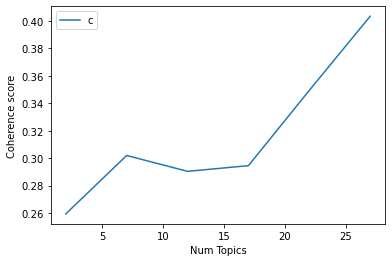

In [135]:
# Plot to see coherence score in order to choose optimal number of topics and decide optimal model
limit=30; start=2; step=5;
x = range(start, limit, step)
plt.plot(x, coherence_values_ph_2019_score1N2N3)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [136]:
# Print the coherence scores
index = 0
for m, cv in zip(x, coherence_values_ph_2019_score1N2N3):
    print("index:",index,"|","Num Topics =", m, " has Coherence Value of", round(cv, 4))
    index = index + 1

# optimal num_topics = 27

index: 0 | Num Topics = 2  has Coherence Value of 0.2594
index: 1 | Num Topics = 7  has Coherence Value of 0.3019
index: 2 | Num Topics = 12  has Coherence Value of 0.2904
index: 3 | Num Topics = 17  has Coherence Value of 0.2945
index: 4 | Num Topics = 22  has Coherence Value of 0.3493
index: 5 | Num Topics = 27  has Coherence Value of 0.4033


In [181]:
# Select optimal number of topics
optimal_model_ph_2019_score1N2N3 = model_list_ph_2019_score1N2N3[5]

In [182]:
# pyLDAVis
pyLDAvis.enable_notebook()
vis_ph_2019_score1N2N3 = pyLDAvis.gensim_models.prepare(optimal_model_ph_2019_score1N2N3, corpus_ph_2019_score1N2N3, id2word_ph_2019_score1N2N3)

In [183]:
print("pyLDAVis for ph topics for score=1,2,3 in 2019:")
vis_ph_2019_score1N2N3

pyLDAVis for ph topics for score=1,2,3 in 2019:


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
21    -0.055493  0.130330       1        1  13.560994
18    -0.100097  0.188944       2        1   9.900622
25    -0.086106  0.048252       3        1   7.844284
15    -0.010328  0.025019       4        1   6.842141
6     -0.069541  0.037917       5        1   5.347734
23    -0.082848  0.057537       6        1   5.089571
14    -0.094176  0.007195       7        1   5.046462
4     -0.091474 -0.059740       8        1   4.605024
10    -0.128968 -0.124589       9        1   3.959861
20    -0.147968 -0.021413      10        1   3.915105
13    -0.070770  0.017497      11        1   3.473658
19     0.073814  0.021938      12        1   3.329984
2     -0.178876 -0.197418      13        1   3.289178
5      0.034989 -0.042411      14        1   3.225325
7     -0.034269  0.013760      15        1   3.126920
16     0.072687  0.006911      16        1   2.449439
11     0.076934  0.050454      17        1   2.215347
3      0.101759  0.036964      18        1   1.937569
8      0.054656  0.047194      19        1   1.860845
9      0.026669  0.071845      20        1   1.656104
26     0.088380 -0.036683      21        1   1.630617
12     0.076082 -0.055880      22        1   1.477217
24     0.099369  0.003550      23        1   1.245327
1      0.095908 -0.071955      24        1   0.897607
22     0.131701 -0.073083      25        1   0.784738
17     0.118306 -0.031580      26        1   0.759163
0      0.099660 -0.050556      27        1   0.529164, topic_info=         Term       Freq       Total Category  logprob  loglift
19    account   74.00000   74.000000  Default  30.0000  30.0000
28        log   29.00000   29.000000  Default  29.0000  29.0000
11      photo   35.00000   35.000000  Default  28.0000  28.0000
76        app  102.00000  102.000000  Default  27.0000  27.0000
3    facebook  105.00000  105.000000  Default  26.0000  26.0000
..        ...        ...         ...      ...      ...      ...
19    account    0.01533   74.570868  Topic27  -7.2064  -3.2481
486    viewer    0.01533    2.408969  Topic27  -7.2064   0.1845
163     album    0.01533    9.709733  Topic27  -7.2064  -1.2095
383      hard    0.01533    4.848717  Topic27  -7.2064  -0.5151
0     already    0.01533   29.013069  Topic27  -7.2064  -2.3041

[1387 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
616       3  0.612018  ability
540       1  0.484029     able
540       5  0.242015     able
540      20  0.242015     able
398       8  0.630226   abroad
...     ...       ...      ...
143      16  0.206124      yet
288      14  0.639144    young
477       8  0.419981       yr
477      14  0.419981       yr
397      19  0.688635     zoom

[1993 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[22, 19, 26, 16, 7, 24, 15, 5, 11, 21, 14, 20, 3, 6, 8, 17, 12, 4, 9, 10, 27, 13, 25, 2, 23, 18, 1])

## By-rating of 2020 (Rating=1,2,3)

In [140]:
# By-rating Topic Modelling - rating = 1,2,3 in 2020
# Convert to list - move to each section
review_ph_2020_score1N2N3 = facebook_ios_ph_review_YearMonth_2020_score1N2N3.review.values.tolist()
review_words_ph_2020_score1N2N3 = list(sent_to_words(review_ph_2020_score1N2N3))
print(review_words_ph_2020_score1N2N3[:1])

[['really', 'loved', 'using', 'facebook', 'there', 'no', 'day', 'skipped', 'using', 'it', 'also', 'loved', 'every', 'updates', 'on', 'this', 'app', 'but', 'it', 'would', 'be', 'very', 'much', 'great', 'if', 'can', 'upload', 'my', 'videos', 'took', 'on', 'my', 'phone', 'in', 'hd', 'mode', 'because', 'each', 'videos', 'uploaded', 'turned', 'out', 'to', 'be', 'pixelated', 'even', 'if', 'the', 'graphics', 'were', 'all', 'good', 'when', 'played', 'it', 'on', 'my', 'phone', 'after', 'the', 'successful', 'upload', 'the', 'whole', 'video', 'looks', 'like', 'crap', 'this', 'is', 'the', 'only', 'thing', 'gets', 'disappointed', 'in', 'it', 'but', 'the', 'rest', 'of', 'the', 'navigation', 'and', 'all', 'are', 'perfectly', 'fine', 'for', 'me', 'just', 'hope', 'that', 'you', 'could', 'at', 'least', 'not', 'lessen', 'the', 'pixels', 'in', 'the', 'videos', 'we', 'upload', 'in', 'the', 'next', 'update', 'please', 'please', 'please', 'because', 'cannot', 'afford', 'to', 'buy', 'video', 'camera', 'or', '

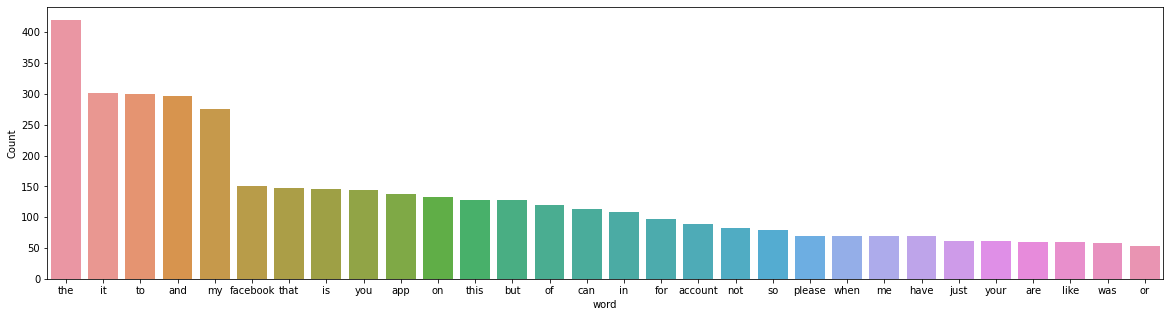

In [141]:
# Inspect the frequency of words before cleaning
freq_words(flatten(review_words_ph_2020_score1N2N3))

In [142]:
# Clean text
review_words_ph_ready_2020_score1N2N3 = process_words(review_words_ph_2020_score1N2N3)  # processed Text Data! - move to each section

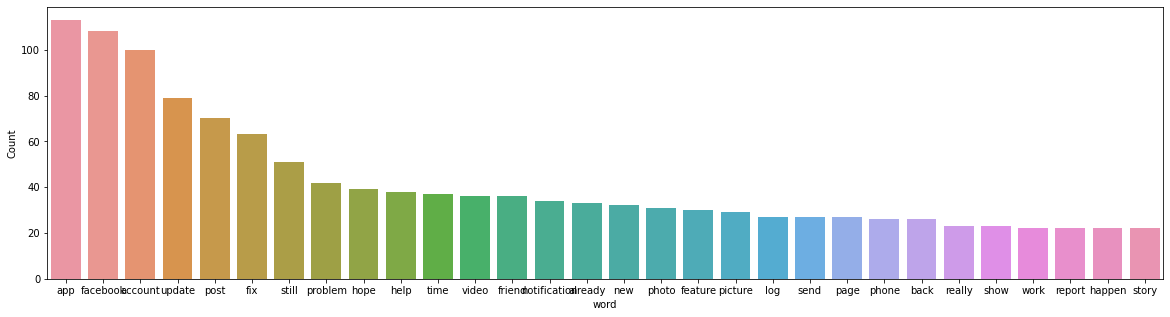

In [143]:
# Inspect the frequency of words after cleaning
freq_words(flatten(review_words_ph_ready_2020_score1N2N3))


In [144]:
# Create Dictionary
id2word_ph_2020_score1N2N3 = corpora.Dictionary(review_words_ph_ready_2020_score1N2N3)

2021-10-16 18:59:35,847 [INFO] gensim.corpora.dictionary - adding document #0 to Dictionary(0 unique tokens: [])
2021-10-16 18:59:35,865 [INFO] gensim.corpora.dictionary - built Dictionary(1003 unique tokens: ['afford', 'app', 'buy', 'camera', 'crap']...) from 129 documents (total 3997 corpus positions)
2021-10-16 18:59:35,866 [INFO] gensim.utils - Dictionary lifecycle event {'msg': "built Dictionary(1003 unique tokens: ['afford', 'app', 'buy', 'camera', 'crap']...) from 129 documents (total 3997 corpus positions)", 'datetime': '2021-10-16T18:59:35.866347', 'gensim': '4.1.2', 'python': '3.8.8 (default, Apr 13 2021, 12:59:45) \n[Clang 10.0.0 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'created'}


In [145]:
# Create Corpus: Term Document Frequency
corpus_ph_2020_score1N2N3 = [id2word_ph_2020_score1N2N3.doc2bow(text) for text in review_words_ph_ready_2020_score1N2N3]

In [146]:
# Training LDA model
model_list_ph_2020_score1N2N3, coherence_values_ph_2020_score1N2N3 = compute_coherence_values(dictionary=id2word_ph_2020_score1N2N3, corpus=corpus_ph_2020_score1N2N3, 
                                                              texts=review_words_ph_ready_2020_score1N2N3, limit=30, start=2, step=5)


2021-10-16 18:59:35,901 [INFO] gensim.models.ldamodel - using symmetric alpha at 0.5
2021-10-16 18:59:35,902 [INFO] gensim.models.ldamodel - using symmetric eta at 0.5
2021-10-16 18:59:35,906 [INFO] gensim.models.ldamodel - using serial LDA version on this node
2021-10-16 18:59:35,908 [INFO] gensim.models.ldamodel - running online (multi-pass) LDA training, 2 topics, 50 passes over the supplied corpus of 129 documents, updating model once every 129 documents, evaluating perplexity every 129 documents, iterating 50x with a convergence threshold of 0.001000
2021-10-16 18:59:36,515 [INFO] gensim.models.ldamodel - -7.475 per-word bound, 177.9 perplexity estimate based on a held-out corpus of 129 documents with 3997 words
2021-10-16 18:59:36,517 [INFO] gensim.models.ldamodel - PROGRESS: pass 0, at document #129/129
2021-10-16 18:59:36,961 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.029*"app" + 0.025*"facebook" + 0.023*"account" + 0.020*"update" + 0.014*"post" + 0.014*"still" + 0.014

2021-10-16 18:59:41,766 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.033*"app" + 0.027*"facebook" + 0.025*"account" + 0.023*"update" + 0.015*"fix" + 0.014*"still" + 0.012*"help" + 0.011*"problem" + 0.010*"already" + 0.010*"hope"
2021-10-16 18:59:41,769 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.023*"post" + 0.014*"photo" + 0.013*"feature" + 0.012*"picture" + 0.012*"facebook" + 0.011*"account" + 0.009*"profile" + 0.009*"fix" + 0.009*"page" + 0.007*"view"
2021-10-16 18:59:41,787 [INFO] gensim.models.ldamodel - topic diff=0.012274, rho=0.301511
2021-10-16 18:59:42,010 [INFO] gensim.models.ldamodel - -6.377 per-word bound, 83.1 perplexity estimate based on a held-out corpus of 129 documents with 3997 words
2021-10-16 18:59:42,011 [INFO] gensim.models.ldamodel - PROGRESS: pass 10, at document #129/129
2021-10-16 18:59:42,202 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.033*"app" + 0.027*"facebook" + 0.025*"account" + 0.023*"update" + 0.015*"fix" + 0.014*"still" + 0.01

2021-10-16 18:59:46,428 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.034*"app" + 0.027*"facebook" + 0.025*"account" + 0.024*"update" + 0.015*"fix" + 0.014*"still" + 0.012*"help" + 0.012*"problem" + 0.010*"already" + 0.010*"hope"
2021-10-16 18:59:46,431 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.026*"post" + 0.014*"photo" + 0.013*"picture" + 0.013*"feature" + 0.012*"facebook" + 0.011*"account" + 0.010*"profile" + 0.009*"fix" + 0.009*"page" + 0.008*"view"
2021-10-16 18:59:46,433 [INFO] gensim.models.ldamodel - topic diff=0.004790, rho=0.218218
2021-10-16 18:59:46,715 [INFO] gensim.models.ldamodel - -6.372 per-word bound, 82.8 perplexity estimate based on a held-out corpus of 129 documents with 3997 words
2021-10-16 18:59:46,792 [INFO] gensim.models.ldamodel - PROGRESS: pass 20, at document #129/129
2021-10-16 18:59:47,047 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.034*"app" + 0.027*"facebook" + 0.025*"account" + 0.024*"update" + 0.015*"fix" + 0.014*"still" + 0.01

2021-10-16 18:59:52,327 [INFO] gensim.models.ldamodel - PROGRESS: pass 29, at document #129/129
2021-10-16 18:59:52,550 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.035*"app" + 0.027*"facebook" + 0.025*"account" + 0.024*"update" + 0.015*"fix" + 0.015*"still" + 0.012*"help" + 0.012*"problem" + 0.010*"already" + 0.010*"notification"
2021-10-16 18:59:52,552 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.027*"post" + 0.014*"photo" + 0.013*"feature" + 0.013*"picture" + 0.012*"facebook" + 0.011*"account" + 0.010*"profile" + 0.009*"fix" + 0.008*"page" + 0.008*"view"
2021-10-16 18:59:52,554 [INFO] gensim.models.ldamodel - topic diff=0.002639, rho=0.179605
2021-10-16 18:59:52,890 [INFO] gensim.models.ldamodel - -6.370 per-word bound, 82.7 perplexity estimate based on a held-out corpus of 129 documents with 3997 words
2021-10-16 18:59:52,892 [INFO] gensim.models.ldamodel - PROGRESS: pass 30, at document #129/129
2021-10-16 18:59:53,069 [INFO] gensim.models.ldamodel - topic #0 (0.500)

2021-10-16 18:59:57,305 [INFO] gensim.models.ldamodel - PROGRESS: pass 39, at document #129/129
2021-10-16 18:59:57,552 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.035*"app" + 0.027*"facebook" + 0.025*"account" + 0.024*"update" + 0.015*"fix" + 0.015*"still" + 0.012*"help" + 0.012*"problem" + 0.010*"already" + 0.010*"notification"
2021-10-16 18:59:57,553 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.027*"post" + 0.014*"photo" + 0.013*"feature" + 0.013*"picture" + 0.012*"facebook" + 0.011*"account" + 0.010*"profile" + 0.009*"fix" + 0.008*"view" + 0.008*"page"
2021-10-16 18:59:57,554 [INFO] gensim.models.ldamodel - topic diff=0.002545, rho=0.156174
2021-10-16 18:59:57,810 [INFO] gensim.models.ldamodel - -6.368 per-word bound, 82.6 perplexity estimate based on a held-out corpus of 129 documents with 3997 words
2021-10-16 18:59:57,811 [INFO] gensim.models.ldamodel - PROGRESS: pass 40, at document #129/129
2021-10-16 18:59:58,048 [INFO] gensim.models.ldamodel - topic #0 (0.500)

2021-10-16 19:00:01,962 [INFO] gensim.models.ldamodel - PROGRESS: pass 49, at document #129/129
2021-10-16 19:00:02,123 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.035*"app" + 0.027*"facebook" + 0.025*"account" + 0.024*"update" + 0.015*"fix" + 0.015*"still" + 0.012*"help" + 0.012*"problem" + 0.010*"already" + 0.010*"notification"
2021-10-16 19:00:02,125 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.027*"post" + 0.014*"photo" + 0.013*"feature" + 0.013*"picture" + 0.012*"facebook" + 0.011*"account" + 0.010*"profile" + 0.008*"view" + 0.008*"fix" + 0.008*"page"
2021-10-16 19:00:02,126 [INFO] gensim.models.ldamodel - topic diff=0.001332, rho=0.140028
2021-10-16 19:00:02,127 [INFO] gensim.utils - LdaModel lifecycle event {'msg': 'trained LdaModel(num_terms=1003, num_topics=2, decay=0.5, chunksize=1000) in 26.22s', 'datetime': '2021-10-16T19:00:02.127770', 'gensim': '4.1.2', 'python': '3.8.8 (default, Apr 13 2021, 12:59:45) \n[Clang 10.0.0 ]', 'platform': 'macOS-10.16-x86_64-i38

2021-10-16 19:00:10,074 [INFO] gensim.models.ldamodel - PROGRESS: pass 4, at document #129/129
2021-10-16 19:00:10,225 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.028*"video" + 0.018*"upload" + 0.016*"facebook" + 0.015*"phone" + 0.013*"datum" + 0.013*"album" + 0.012*"update" + 0.011*"cellular" + 0.011*"log" + 0.010*"put"
2021-10-16 19:00:10,230 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.030*"post" + 0.021*"facebook" + 0.020*"update" + 0.017*"time" + 0.015*"app" + 0.011*"still" + 0.011*"feature" + 0.011*"photo" + 0.010*"friend" + 0.009*"iphone"
2021-10-16 19:00:10,234 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.043*"account" + 0.035*"facebook" + 0.019*"notification" + 0.018*"app" + 0.017*"new" + 0.017*"update" + 0.011*"post" + 0.011*"fix" + 0.011*"already" + 0.010*"send"
2021-10-16 19:00:10,243 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.029*"account" + 0.024*"fix" + 0.022*"app" + 0.021*"post" + 0.019*"facebook" + 0.017*"update" + 0.012*"problem" + 0.011

2021-10-16 19:00:12,108 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.029*"account" + 0.024*"fix" + 0.022*"app" + 0.021*"post" + 0.019*"facebook" + 0.016*"update" + 0.012*"problem" + 0.011*"story" + 0.011*"hope" + 0.011*"video"
2021-10-16 19:00:12,111 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.017*"video" + 0.017*"feature" + 0.014*"fix" + 0.014*"photo" + 0.012*"search" + 0.010*"show" + 0.010*"update" + 0.010*"page" + 0.010*"new" + 0.010*"play"
2021-10-16 19:00:12,113 [INFO] gensim.models.ldamodel - topic diff=0.016924, rho=0.301511
2021-10-16 19:00:12,323 [INFO] gensim.models.ldamodel - -6.581 per-word bound, 95.7 perplexity estimate based on a held-out corpus of 129 documents with 3997 words
2021-10-16 19:00:12,324 [INFO] gensim.models.ldamodel - PROGRESS: pass 10, at document #129/129
2021-10-16 19:00:12,459 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.023*"video" + 0.018*"upload" + 0.017*"facebook" + 0.014*"phone" + 0.014*"datum" + 0.014*"album" + 0.012*"update

2021-10-16 19:00:14,200 [INFO] gensim.models.ldamodel - PROGRESS: pass 15, at document #129/129
2021-10-16 19:00:14,423 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.025*"app" + 0.022*"still" + 0.021*"account" + 0.018*"facebook" + 0.015*"hope" + 0.015*"problem" + 0.014*"fix" + 0.013*"update" + 0.013*"phone" + 0.012*"time"
2021-10-16 19:00:14,424 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.017*"video" + 0.017*"feature" + 0.014*"photo" + 0.014*"fix" + 0.012*"search" + 0.011*"show" + 0.010*"update" + 0.010*"page" + 0.010*"new" + 0.010*"play"
2021-10-16 19:00:14,426 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.048*"app" + 0.022*"facebook" + 0.020*"picture" + 0.018*"update" + 0.015*"problem" + 0.014*"fix" + 0.013*"version" + 0.012*"account" + 0.012*"photo" + 0.011*"old"
2021-10-16 19:00:14,427 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.023*"video" + 0.018*"upload" + 0.017*"facebook" + 0.014*"phone" + 0.014*"datum" + 0.014*"album" + 0.012*"update" + 0.012*"cellu

2021-10-16 19:00:16,309 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.043*"account" + 0.036*"facebook" + 0.021*"notification" + 0.017*"app" + 0.017*"new" + 0.016*"update" + 0.012*"fix" + 0.012*"already" + 0.011*"send" + 0.011*"post"
2021-10-16 19:00:16,312 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.029*"account" + 0.024*"fix" + 0.023*"app" + 0.021*"post" + 0.018*"facebook" + 0.016*"update" + 0.012*"problem" + 0.012*"story" + 0.012*"hope" + 0.011*"video"
2021-10-16 19:00:16,313 [INFO] gensim.models.ldamodel - topic diff=0.002069, rho=0.213201
2021-10-16 19:00:16,499 [INFO] gensim.models.ldamodel - -6.577 per-word bound, 95.5 perplexity estimate based on a held-out corpus of 129 documents with 3997 words
2021-10-16 19:00:16,501 [INFO] gensim.models.ldamodel - PROGRESS: pass 21, at document #129/129
2021-10-16 19:00:16,586 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.048*"app" + 0.022*"facebook" + 0.020*"picture" + 0.018*"update" + 0.015*"problem" + 0.014*"fix" + 0.0

2021-10-16 19:00:18,316 [INFO] gensim.models.ldamodel - -6.576 per-word bound, 95.4 perplexity estimate based on a held-out corpus of 129 documents with 3997 words
2021-10-16 19:00:18,317 [INFO] gensim.models.ldamodel - PROGRESS: pass 26, at document #129/129
2021-10-16 19:00:18,436 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.030*"post" + 0.021*"update" + 0.020*"facebook" + 0.019*"time" + 0.016*"app" + 0.012*"still" + 0.011*"friend" + 0.011*"feature" + 0.010*"iphone" + 0.009*"photo"
2021-10-16 19:00:18,439 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.029*"account" + 0.024*"fix" + 0.023*"app" + 0.021*"post" + 0.017*"facebook" + 0.015*"update" + 0.012*"problem" + 0.012*"story" + 0.012*"hope" + 0.011*"video"
2021-10-16 19:00:18,440 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.023*"video" + 0.018*"upload" + 0.017*"facebook" + 0.014*"phone" + 0.014*"datum" + 0.014*"album" + 0.012*"update" + 0.012*"cellular" + 0.010*"log" + 0.009*"turn"
2021-10-16 19:00:18,443 [INFO] ge

2021-10-16 19:00:20,227 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.025*"app" + 0.022*"still" + 0.020*"account" + 0.018*"facebook" + 0.015*"hope" + 0.015*"problem" + 0.014*"fix" + 0.013*"update" + 0.013*"phone" + 0.012*"time"
2021-10-16 19:00:20,232 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.030*"post" + 0.021*"update" + 0.020*"facebook" + 0.019*"time" + 0.016*"app" + 0.012*"still" + 0.011*"friend" + 0.010*"feature" + 0.010*"iphone" + 0.009*"photo"
2021-10-16 19:00:20,235 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.043*"account" + 0.036*"facebook" + 0.021*"notification" + 0.017*"app" + 0.016*"new" + 0.016*"update" + 0.012*"fix" + 0.012*"already" + 0.011*"send" + 0.011*"post"
2021-10-16 19:00:20,238 [INFO] gensim.models.ldamodel - topic diff=0.000678, rho=0.174078
2021-10-16 19:00:20,412 [INFO] gensim.models.ldamodel - -6.576 per-word bound, 95.4 perplexity estimate based on a held-out corpus of 129 documents with 3997 words
2021-10-16 19:00:20,414 [INFO] gensim

2021-10-16 19:00:21,955 [INFO] gensim.models.ldamodel - topic diff=0.000403, rho=0.162221
2021-10-16 19:00:22,138 [INFO] gensim.models.ldamodel - -6.575 per-word bound, 95.4 perplexity estimate based on a held-out corpus of 129 documents with 3997 words
2021-10-16 19:00:22,139 [INFO] gensim.models.ldamodel - PROGRESS: pass 37, at document #129/129
2021-10-16 19:00:22,312 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.030*"post" + 0.021*"update" + 0.020*"facebook" + 0.019*"time" + 0.016*"app" + 0.012*"still" + 0.011*"friend" + 0.010*"feature" + 0.010*"iphone" + 0.009*"photo"
2021-10-16 19:00:22,314 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.048*"app" + 0.023*"facebook" + 0.021*"picture" + 0.018*"update" + 0.015*"problem" + 0.014*"fix" + 0.013*"version" + 0.013*"account" + 0.012*"photo" + 0.011*"old"
2021-10-16 19:00:22,315 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.043*"account" + 0.037*"facebook" + 0.021*"notification" + 0.017*"app" + 0.016*"new" + 0.016*"update"

2021-10-16 19:00:24,038 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.030*"post" + 0.021*"update" + 0.020*"facebook" + 0.019*"time" + 0.016*"app" + 0.012*"still" + 0.011*"friend" + 0.010*"feature" + 0.010*"iphone" + 0.009*"photo"
2021-10-16 19:00:24,046 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.023*"video" + 0.018*"upload" + 0.017*"facebook" + 0.014*"phone" + 0.014*"datum" + 0.014*"album" + 0.012*"update" + 0.012*"cellular" + 0.010*"log" + 0.009*"turn"
2021-10-16 19:00:24,048 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.048*"app" + 0.023*"facebook" + 0.021*"picture" + 0.018*"update" + 0.015*"problem" + 0.014*"fix" + 0.013*"version" + 0.013*"account" + 0.012*"photo" + 0.011*"old"
2021-10-16 19:00:24,049 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.029*"account" + 0.024*"fix" + 0.023*"app" + 0.020*"post" + 0.017*"facebook" + 0.015*"update" + 0.012*"problem" + 0.012*"story" + 0.012*"hope" + 0.011*"video"
2021-10-16 19:00:24,052 [INFO] gensim.models.ldamodel -

2021-10-16 19:00:25,827 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.017*"feature" + 0.017*"video" + 0.014*"photo" + 0.014*"fix" + 0.012*"search" + 0.011*"show" + 0.011*"page" + 0.011*"new" + 0.011*"update" + 0.011*"play"
2021-10-16 19:00:25,828 [INFO] gensim.models.ldamodel - topic diff=0.000161, rho=0.142857
2021-10-16 19:00:26,047 [INFO] gensim.models.ldamodel - -6.575 per-word bound, 95.4 perplexity estimate based on a held-out corpus of 129 documents with 3997 words
2021-10-16 19:00:26,048 [INFO] gensim.models.ldamodel - PROGRESS: pass 48, at document #129/129
2021-10-16 19:00:26,178 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.025*"app" + 0.022*"still" + 0.020*"account" + 0.018*"facebook" + 0.015*"hope" + 0.015*"problem" + 0.014*"fix" + 0.013*"update" + 0.013*"phone" + 0.012*"time"
2021-10-16 19:00:26,181 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.023*"video" + 0.018*"upload" + 0.017*"facebook" + 0.014*"phone" + 0.014*"datum" + 0.014*"album" + 0.012*"update

2021-10-16 19:00:35,232 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.032*"video" + 0.024*"upload" + 0.019*"phone" + 0.015*"highlight" + 0.011*"update" + 0.010*"app" + 0.010*"profile" + 0.010*"love" + 0.010*"thing" + 0.010*"delete"
2021-10-16 19:00:35,234 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.035*"facebook" + 0.034*"account" + 0.033*"app" + 0.012*"message" + 0.011*"post" + 0.011*"help" + 0.011*"domain" + 0.011*"load" + 0.011*"share" + 0.010*"long"
2021-10-16 19:00:35,237 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.031*"account" + 0.028*"app" + 0.021*"problem" + 0.020*"picture" + 0.016*"fix" + 0.016*"kind" + 0.013*"still" + 0.012*"mode" + 0.012*"dark" + 0.012*"time"
2021-10-16 19:00:35,239 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.049*"app" + 0.028*"problem" + 0.028*"phone" + 0.023*"picture" + 0.016*"open" + 0.015*"update" + 0.015*"datum" + 0.013*"view" + 0.013*"facebook" + 0.013*"video"
2021-10-16 19:00:35,240 [INFO] gensim.models.ldamodel - topic

2021-10-16 19:00:37,333 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.020*"facebook" + 0.018*"app" + 0.016*"post" + 0.014*"update" + 0.014*"still" + 0.012*"fix" + 0.012*"friend" + 0.012*"story" + 0.010*"option" + 0.010*"problem"
2021-10-16 19:00:37,334 [INFO] gensim.models.ldamodel - topic diff=0.044816, rho=0.333333
2021-10-16 19:00:37,556 [INFO] gensim.models.ldamodel - -6.686 per-word bound, 103.0 perplexity estimate based on a held-out corpus of 129 documents with 3997 words
2021-10-16 19:00:37,557 [INFO] gensim.models.ldamodel - PROGRESS: pass 8, at document #129/129
2021-10-16 19:00:37,644 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.048*"account" + 0.030*"app" + 0.023*"log" + 0.020*"video" + 0.017*"facebook" + 0.017*"login" + 0.016*"still" + 0.016*"ask" + 0.014*"help" + 0.013*"error"
2021-10-16 19:00:37,647 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.020*"facebook" + 0.018*"app" + 0.016*"post" + 0.014*"update" + 0.014*"still" + 0.012*"fix" + 0.012*"friend" +

2021-10-16 19:00:39,439 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.048*"account" + 0.030*"app" + 0.023*"log" + 0.020*"video" + 0.017*"login" + 0.017*"facebook" + 0.016*"ask" + 0.015*"still" + 0.014*"help" + 0.013*"error"
2021-10-16 19:00:39,441 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.037*"account" + 0.034*"facebook" + 0.029*"app" + 0.012*"post" + 0.012*"help" + 0.012*"load" + 0.012*"share" + 0.012*"domain" + 0.012*"long" + 0.012*"verify"
2021-10-16 19:00:39,442 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.054*"photo" + 0.051*"feature" + 0.026*"featured" + 0.024*"old" + 0.022*"view" + 0.021*"video" + 0.021*"profile" + 0.020*"fix" + 0.017*"mobile" + 0.014*"version"
2021-10-16 19:00:39,443 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.022*"still" + 0.022*"show" + 0.018*"fix" + 0.017*"search" + 0.013*"time" + 0.013*"app" + 0.013*"report" + 0.013*"hope" + 0.013*"account" + 0.013*"facebook"
2021-10-16 19:00:39,445 [INFO] gensim.models.ldamodel - topic #0 (

2021-10-16 19:00:41,401 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.054*"photo" + 0.051*"feature" + 0.026*"featured" + 0.025*"old" + 0.022*"view" + 0.021*"video" + 0.021*"profile" + 0.020*"fix" + 0.017*"mobile" + 0.014*"version"
2021-10-16 19:00:41,405 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.046*"post" + 0.026*"update" + 0.018*"facebook" + 0.016*"feature" + 0.016*"app" + 0.014*"photo" + 0.014*"time" + 0.013*"fix" + 0.013*"page" + 0.013*"story"
2021-10-16 19:00:41,409 [INFO] gensim.models.ldamodel - topic diff=0.002899, rho=0.223607
2021-10-16 19:00:41,593 [INFO] gensim.models.ldamodel - -6.676 per-word bound, 102.3 perplexity estimate based on a held-out corpus of 129 documents with 3997 words
2021-10-16 19:00:41,624 [INFO] gensim.models.ldamodel - PROGRESS: pass 19, at document #129/129
2021-10-16 19:00:41,775 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.054*"photo" + 0.051*"feature" + 0.026*"featured" + 0.025*"old" + 0.022*"view" + 0.021*"video" + 0.021*"pr

2021-10-16 19:00:43,676 [INFO] gensim.models.ldamodel - -6.676 per-word bound, 102.2 perplexity estimate based on a held-out corpus of 129 documents with 3997 words
2021-10-16 19:00:43,677 [INFO] gensim.models.ldamodel - PROGRESS: pass 24, at document #129/129
2021-10-16 19:00:43,803 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.050*"account" + 0.030*"app" + 0.024*"log" + 0.019*"video" + 0.017*"login" + 0.017*"facebook" + 0.016*"ask" + 0.015*"still" + 0.014*"error" + 0.014*"help"
2021-10-16 19:00:43,805 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.054*"photo" + 0.052*"feature" + 0.026*"featured" + 0.026*"old" + 0.022*"view" + 0.021*"video" + 0.021*"profile" + 0.020*"fix" + 0.017*"mobile" + 0.015*"version"
2021-10-16 19:00:43,807 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.022*"still" + 0.022*"show" + 0.018*"fix" + 0.017*"search" + 0.013*"time" + 0.013*"app" + 0.013*"report" + 0.013*"hope" + 0.013*"account" + 0.013*"facebook"
2021-10-16 19:00:43,808 [INFO] gensim.m

2021-10-16 19:00:45,587 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.034*"video" + 0.024*"upload" + 0.020*"phone" + 0.015*"highlight" + 0.011*"update" + 0.011*"app" + 0.010*"profile" + 0.010*"thing" + 0.010*"love" + 0.010*"delete"
2021-10-16 19:00:45,590 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.037*"account" + 0.033*"facebook" + 0.028*"app" + 0.012*"post" + 0.012*"load" + 0.012*"help" + 0.012*"share" + 0.012*"domain" + 0.012*"long" + 0.012*"verify"
2021-10-16 19:00:45,593 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.051*"account" + 0.030*"app" + 0.024*"log" + 0.019*"video" + 0.017*"login" + 0.017*"facebook" + 0.015*"ask" + 0.015*"still" + 0.015*"error" + 0.014*"help"
2021-10-16 19:00:45,595 [INFO] gensim.models.ldamodel - topic diff=0.000668, rho=0.179605
2021-10-16 19:00:45,823 [INFO] gensim.models.ldamodel - -6.675 per-word bound, 102.2 perplexity estimate based on a held-out corpus of 129 documents with 3997 words
2021-10-16 19:00:45,824 [INFO] gensim.model

2021-10-16 19:00:47,308 [INFO] gensim.models.ldamodel - topic diff=0.000431, rho=0.166667
2021-10-16 19:00:47,491 [INFO] gensim.models.ldamodel - -6.675 per-word bound, 102.2 perplexity estimate based on a held-out corpus of 129 documents with 3997 words
2021-10-16 19:00:47,493 [INFO] gensim.models.ldamodel - PROGRESS: pass 35, at document #129/129
2021-10-16 19:00:47,623 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.054*"photo" + 0.054*"feature" + 0.026*"old" + 0.026*"featured" + 0.022*"view" + 0.021*"video" + 0.021*"profile" + 0.020*"fix" + 0.017*"mobile" + 0.015*"version"
2021-10-16 19:00:47,625 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.022*"still" + 0.022*"show" + 0.018*"fix" + 0.017*"search" + 0.013*"time" + 0.013*"report" + 0.013*"hope" + 0.013*"video" + 0.013*"help" + 0.013*"app"
2021-10-16 19:00:47,630 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.034*"video" + 0.024*"upload" + 0.020*"phone" + 0.015*"highlight" + 0.011*"update" + 0.011*"app" + 0.010*"prof

2021-10-16 19:00:49,307 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.040*"account" + 0.025*"post" + 0.022*"facebook" + 0.019*"update" + 0.014*"fix" + 0.013*"hope" + 0.013*"happen" + 0.013*"issue" + 0.011*"new" + 0.010*"report"
2021-10-16 19:00:49,308 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.051*"account" + 0.030*"app" + 0.024*"log" + 0.019*"video" + 0.017*"login" + 0.017*"facebook" + 0.015*"ask" + 0.015*"still" + 0.015*"error" + 0.014*"help"
2021-10-16 19:00:49,310 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.054*"photo" + 0.053*"feature" + 0.026*"old" + 0.026*"featured" + 0.022*"view" + 0.021*"video" + 0.021*"profile" + 0.020*"fix" + 0.017*"mobile" + 0.015*"version"
2021-10-16 19:00:49,312 [INFO] gensim.models.ldamodel - topic diff=0.000393, rho=0.154303
2021-10-16 19:00:49,479 [INFO] gensim.models.ldamodel - -6.675 per-word bound, 102.2 perplexity estimate based on a held-out corpus of 129 documents with 3997 words
2021-10-16 19:00:49,481 [INFO] gensim.models

2021-10-16 19:00:50,954 [INFO] gensim.models.ldamodel - topic diff=0.000237, rho=0.145865
2021-10-16 19:00:51,180 [INFO] gensim.models.ldamodel - -6.674 per-word bound, 102.1 perplexity estimate based on a held-out corpus of 129 documents with 3997 words
2021-10-16 19:00:51,181 [INFO] gensim.models.ldamodel - PROGRESS: pass 46, at document #129/129
2021-10-16 19:00:51,313 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.037*"account" + 0.034*"facebook" + 0.028*"app" + 0.012*"load" + 0.012*"post" + 0.012*"help" + 0.012*"long" + 0.012*"verify" + 0.012*"share" + 0.012*"domain"
2021-10-16 19:00:51,315 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.054*"photo" + 0.052*"feature" + 0.026*"old" + 0.026*"featured" + 0.022*"view" + 0.021*"video" + 0.021*"profile" + 0.020*"fix" + 0.017*"mobile" + 0.015*"version"
2021-10-16 19:00:51,317 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.038*"app" + 0.029*"facebook" + 0.018*"update" + 0.017*"hope" + 0.015*"search" + 0.015*"help" + 0.015*"

2021-10-16 19:00:59,816 [INFO] gensim.models.ldamodel - topic #3 (0.059): 0.034*"account" + 0.032*"post" + 0.022*"fix" + 0.020*"facebook" + 0.017*"story" + 0.016*"happen" + 0.012*"friend" + 0.012*"report" + 0.011*"page" + 0.011*"update"
2021-10-16 19:00:59,818 [INFO] gensim.models.ldamodel - topic #9 (0.059): 0.050*"account" + 0.015*"fix" + 0.014*"picture" + 0.014*"disable" + 0.013*"enable" + 0.013*"delete" + 0.013*"unfair" + 0.013*"year" + 0.012*"help" + 0.010*"ask"
2021-10-16 19:00:59,819 [INFO] gensim.models.ldamodel - topic #1 (0.059): 0.019*"share" + 0.019*"show" + 0.018*"old" + 0.015*"report" + 0.015*"violate" + 0.015*"fix" + 0.015*"photo" + 0.013*"profile" + 0.013*"information" + 0.013*"market"
2021-10-16 19:00:59,820 [INFO] gensim.models.ldamodel - topic diff=12.532537, rho=1.000000
2021-10-16 19:01:00,065 [INFO] gensim.models.ldamodel - -7.085 per-word bound, 135.8 perplexity estimate based on a held-out corpus of 129 documents with 3997 words
2021-10-16 19:01:00,066 [INFO] ge

2021-10-16 19:01:01,485 [INFO] gensim.models.ldamodel - topic diff=0.094381, rho=0.377964
2021-10-16 19:01:01,711 [INFO] gensim.models.ldamodel - -6.776 per-word bound, 109.6 perplexity estimate based on a held-out corpus of 129 documents with 3997 words
2021-10-16 19:01:01,712 [INFO] gensim.models.ldamodel - PROGRESS: pass 6, at document #129/129
2021-10-16 19:01:01,823 [INFO] gensim.models.ldamodel - topic #4 (0.059): 0.037*"help" + 0.022*"app" + 0.021*"daughter" + 0.016*"post" + 0.016*"hope" + 0.016*"friend" + 0.016*"problem" + 0.016*"account" + 0.016*"shortcut" + 0.016*"disabled"
2021-10-16 19:01:01,825 [INFO] gensim.models.ldamodel - topic #1 (0.059): 0.022*"old" + 0.017*"share" + 0.017*"show" + 0.017*"report" + 0.017*"violate" + 0.017*"fix" + 0.017*"photo" + 0.017*"profile" + 0.017*"standard" + 0.016*"picture"
2021-10-16 19:01:01,829 [INFO] gensim.models.ldamodel - topic #5 (0.059): 0.028*"video" + 0.024*"upload" + 0.020*"post" + 0.019*"hope" + 0.016*"account" + 0.016*"new" + 0.0

2021-10-16 19:01:03,564 [INFO] gensim.models.ldamodel - topic #2 (0.059): 0.047*"facebook" + 0.034*"update" + 0.031*"new" + 0.022*"account" + 0.021*"friend" + 0.020*"page" + 0.016*"fix" + 0.016*"send" + 0.015*"app" + 0.015*"notification"
2021-10-16 19:01:03,565 [INFO] gensim.models.ldamodel - topic #12 (0.059): 0.042*"feature" + 0.041*"photo" + 0.033*"app" + 0.020*"update" + 0.020*"facebook" + 0.014*"account" + 0.014*"mobile" + 0.014*"search" + 0.014*"featured" + 0.011*"new"
2021-10-16 19:01:03,567 [INFO] gensim.models.ldamodel - topic #7 (0.059): 0.032*"phone" + 0.028*"datum" + 0.025*"problem" + 0.024*"app" + 0.022*"picture" + 0.022*"view" + 0.022*"update" + 0.021*"open" + 0.019*"facebook" + 0.018*"cellular"
2021-10-16 19:01:03,568 [INFO] gensim.models.ldamodel - topic #13 (0.059): 0.038*"app" + 0.031*"video" + 0.025*"phone" + 0.019*"fix" + 0.019*"time" + 0.019*"photo" + 0.019*"album" + 0.013*"facebook" + 0.013*"select" + 0.013*"issue"
2021-10-16 19:01:03,569 [INFO] gensim.models.ldam

2021-10-16 19:01:05,253 [INFO] gensim.models.ldamodel - topic #3 (0.059): 0.040*"account" + 0.032*"post" + 0.022*"facebook" + 0.020*"fix" + 0.019*"story" + 0.016*"happen" + 0.013*"friend" + 0.012*"report" + 0.012*"profile" + 0.009*"page"
2021-10-16 19:01:05,254 [INFO] gensim.models.ldamodel - topic diff=0.003819, rho=0.235702
2021-10-16 19:01:05,404 [INFO] gensim.models.ldamodel - -6.758 per-word bound, 108.2 perplexity estimate based on a held-out corpus of 129 documents with 3997 words
2021-10-16 19:01:05,405 [INFO] gensim.models.ldamodel - PROGRESS: pass 17, at document #129/129
2021-10-16 19:01:05,574 [INFO] gensim.models.ldamodel - topic #8 (0.059): 0.049*"account" + 0.041*"app" + 0.028*"still" + 0.026*"log" + 0.021*"video" + 0.021*"facebook" + 0.014*"already" + 0.014*"give" + 0.014*"ask" + 0.012*"problem"
2021-10-16 19:01:05,575 [INFO] gensim.models.ldamodel - topic #0 (0.059): 0.028*"update" + 0.027*"app" + 0.021*"fix" + 0.018*"send" + 0.018*"account" + 0.017*"still" + 0.015*"he

2021-10-16 19:01:07,309 [INFO] gensim.models.ldamodel - topic #8 (0.059): 0.049*"account" + 0.041*"app" + 0.028*"still" + 0.025*"log" + 0.021*"video" + 0.021*"facebook" + 0.014*"already" + 0.014*"give" + 0.014*"ask" + 0.012*"problem"
2021-10-16 19:01:07,310 [INFO] gensim.models.ldamodel - topic #16 (0.059): 0.058*"app" + 0.047*"update" + 0.034*"facebook" + 0.022*"fix" + 0.017*"version" + 0.017*"already" + 0.017*"message" + 0.017*"turn" + 0.014*"live" + 0.014*"hope"
2021-10-16 19:01:07,313 [INFO] gensim.models.ldamodel - topic #6 (0.059): 0.043*"post" + 0.033*"facebook" + 0.017*"time" + 0.015*"update" + 0.015*"account" + 0.014*"notification" + 0.012*"people" + 0.011*"app" + 0.010*"keep" + 0.010*"show"
2021-10-16 19:01:07,314 [INFO] gensim.models.ldamodel - topic #9 (0.059): 0.053*"account" + 0.016*"fix" + 0.016*"picture" + 0.016*"disable" + 0.016*"enable" + 0.016*"delete" + 0.016*"unfair" + 0.016*"year" + 0.008*"help" + 0.008*"ask"
2021-10-16 19:01:07,316 [INFO] gensim.models.ldamodel -

2021-10-16 19:01:09,109 [INFO] gensim.models.ldamodel - topic #4 (0.059): 0.037*"help" + 0.021*"app" + 0.021*"daughter" + 0.016*"post" + 0.016*"hope" + 0.016*"friend" + 0.016*"problem" + 0.016*"account" + 0.016*"disabled" + 0.016*"shortcut"
2021-10-16 19:01:09,114 [INFO] gensim.models.ldamodel - topic #14 (0.059): 0.036*"album" + 0.035*"option" + 0.022*"problem" + 0.019*"change" + 0.013*"reinstall" + 0.013*"recently" + 0.013*"old" + 0.013*"mobile" + 0.013*"datum" + 0.013*"newly"
2021-10-16 19:01:09,117 [INFO] gensim.models.ldamodel - topic diff=0.000446, rho=0.185695
2021-10-16 19:01:09,327 [INFO] gensim.models.ldamodel - -6.757 per-word bound, 108.2 perplexity estimate based on a held-out corpus of 129 documents with 3997 words
2021-10-16 19:01:09,328 [INFO] gensim.models.ldamodel - PROGRESS: pass 28, at document #129/129
2021-10-16 19:01:09,464 [INFO] gensim.models.ldamodel - topic #12 (0.059): 0.042*"feature" + 0.041*"photo" + 0.033*"app" + 0.020*"update" + 0.019*"facebook" + 0.014*

2021-10-16 19:01:11,038 [INFO] gensim.models.ldamodel - -6.757 per-word bound, 108.1 perplexity estimate based on a held-out corpus of 129 documents with 3997 words
2021-10-16 19:01:11,039 [INFO] gensim.models.ldamodel - PROGRESS: pass 33, at document #129/129
2021-10-16 19:01:11,188 [INFO] gensim.models.ldamodel - topic #8 (0.059): 0.049*"account" + 0.041*"app" + 0.028*"still" + 0.025*"log" + 0.021*"video" + 0.021*"facebook" + 0.014*"already" + 0.014*"give" + 0.014*"ask" + 0.012*"problem"
2021-10-16 19:01:11,190 [INFO] gensim.models.ldamodel - topic #3 (0.059): 0.040*"account" + 0.032*"post" + 0.022*"facebook" + 0.020*"fix" + 0.019*"story" + 0.016*"happen" + 0.013*"friend" + 0.012*"report" + 0.012*"profile" + 0.011*"view"
2021-10-16 19:01:11,192 [INFO] gensim.models.ldamodel - topic #12 (0.059): 0.042*"feature" + 0.041*"photo" + 0.033*"app" + 0.020*"update" + 0.019*"facebook" + 0.014*"account" + 0.014*"mobile" + 0.014*"search" + 0.014*"featured" + 0.011*"new"
2021-10-16 19:01:11,195 [

2021-10-16 19:01:12,992 [INFO] gensim.models.ldamodel - topic #2 (0.059): 0.047*"facebook" + 0.034*"update" + 0.031*"new" + 0.022*"account" + 0.021*"friend" + 0.020*"page" + 0.016*"fix" + 0.016*"send" + 0.015*"app" + 0.015*"notification"
2021-10-16 19:01:12,998 [INFO] gensim.models.ldamodel - topic #0 (0.059): 0.028*"update" + 0.026*"app" + 0.021*"fix" + 0.018*"account" + 0.018*"send" + 0.017*"still" + 0.015*"facebook" + 0.015*"help" + 0.012*"friend" + 0.011*"bug"
2021-10-16 19:01:13,007 [INFO] gensim.models.ldamodel - topic #14 (0.059): 0.036*"album" + 0.035*"option" + 0.022*"problem" + 0.019*"change" + 0.013*"reinstall" + 0.013*"recently" + 0.013*"old" + 0.013*"mobile" + 0.013*"datum" + 0.013*"newly"
2021-10-16 19:01:13,009 [INFO] gensim.models.ldamodel - topic diff=0.000117, rho=0.158114
2021-10-16 19:01:13,200 [INFO] gensim.models.ldamodel - -6.757 per-word bound, 108.1 perplexity estimate based on a held-out corpus of 129 documents with 3997 words
2021-10-16 19:01:13,203 [INFO] ge

2021-10-16 19:01:14,824 [INFO] gensim.models.ldamodel - topic diff=0.000076, rho=0.149071
2021-10-16 19:01:15,064 [INFO] gensim.models.ldamodel - -6.757 per-word bound, 108.1 perplexity estimate based on a held-out corpus of 129 documents with 3997 words
2021-10-16 19:01:15,065 [INFO] gensim.models.ldamodel - PROGRESS: pass 44, at document #129/129
2021-10-16 19:01:15,185 [INFO] gensim.models.ldamodel - topic #0 (0.059): 0.028*"update" + 0.026*"app" + 0.021*"fix" + 0.018*"account" + 0.018*"send" + 0.017*"still" + 0.015*"facebook" + 0.015*"help" + 0.012*"friend" + 0.011*"bug"
2021-10-16 19:01:15,188 [INFO] gensim.models.ldamodel - topic #3 (0.059): 0.040*"account" + 0.032*"post" + 0.022*"facebook" + 0.020*"fix" + 0.019*"story" + 0.016*"happen" + 0.013*"friend" + 0.012*"report" + 0.012*"profile" + 0.012*"view"
2021-10-16 19:01:15,190 [INFO] gensim.models.ldamodel - topic #12 (0.059): 0.042*"feature" + 0.041*"photo" + 0.033*"app" + 0.020*"update" + 0.019*"facebook" + 0.014*"account" + 0.0

2021-10-16 19:01:16,971 [INFO] gensim.models.ldamodel - topic #4 (0.059): 0.037*"help" + 0.021*"app" + 0.021*"daughter" + 0.016*"hope" + 0.016*"post" + 0.016*"account" + 0.016*"disabled" + 0.016*"problem" + 0.016*"friend" + 0.016*"fix"
2021-10-16 19:01:16,972 [INFO] gensim.models.ldamodel - topic #15 (0.059): 0.043*"app" + 0.015*"keep" + 0.015*"day" + 0.015*"load" + 0.015*"time" + 0.015*"log" + 0.015*"lock" + 0.015*"still" + 0.015*"fix" + 0.015*"change"
2021-10-16 19:01:16,973 [INFO] gensim.models.ldamodel - topic #10 (0.059): 0.045*"account" + 0.031*"facebook" + 0.030*"app" + 0.018*"help" + 0.014*"domain" + 0.014*"post" + 0.014*"verify" + 0.014*"load" + 0.013*"still" + 0.011*"start"
2021-10-16 19:01:16,975 [INFO] gensim.models.ldamodel - topic #11 (0.059): 0.021*"video" + 0.021*"time" + 0.021*"fix" + 0.017*"fb" + 0.017*"facebook" + 0.014*"report" + 0.014*"hope" + 0.014*"still" + 0.014*"help" + 0.011*"account"
2021-10-16 19:01:16,976 [INFO] gensim.models.ldamodel - topic diff=0.000045,

2021-10-16 19:01:27,398 [INFO] gensim.models.ldamodel - topic #11 (0.045): 0.040*"video" + 0.027*"fb" + 0.027*"fix" + 0.020*"account" + 0.020*"live" + 0.014*"search" + 0.014*"report" + 0.014*"still" + 0.014*"group" + 0.014*"facebook"
2021-10-16 19:01:27,403 [INFO] gensim.models.ldamodel - topic diff=0.206428, rho=0.447214
2021-10-16 19:01:27,584 [INFO] gensim.models.ldamodel - -6.898 per-word bound, 119.3 perplexity estimate based on a held-out corpus of 129 documents with 3997 words
2021-10-16 19:01:27,587 [INFO] gensim.models.ldamodel - PROGRESS: pass 4, at document #129/129
2021-10-16 19:01:27,701 [INFO] gensim.models.ldamodel - topic #19 (0.045): 0.066*"app" + 0.032*"update" + 0.022*"option" + 0.019*"post" + 0.016*"notification" + 0.015*"change" + 0.015*"message" + 0.014*"already" + 0.012*"time" + 0.012*"friend"
2021-10-16 19:01:27,704 [INFO] gensim.models.ldamodel - topic #7 (0.045): 0.039*"app" + 0.030*"problem" + 0.026*"facebook" + 0.024*"picture" + 0.021*"phone" + 0.021*"update

2021-10-16 19:01:29,199 [INFO] gensim.models.ldamodel - PROGRESS: pass 9, at document #129/129
2021-10-16 19:01:29,314 [INFO] gensim.models.ldamodel - topic #2 (0.045): 0.057*"facebook" + 0.035*"account" + 0.033*"new" + 0.025*"update" + 0.019*"report" + 0.018*"friend" + 0.018*"send" + 0.016*"page" + 0.012*"suggestion" + 0.012*"put"
2021-10-16 19:01:29,316 [INFO] gensim.models.ldamodel - topic #6 (0.045): 0.056*"post" + 0.028*"facebook" + 0.020*"notification" + 0.020*"update" + 0.016*"time" + 0.014*"show" + 0.014*"people" + 0.012*"feature" + 0.012*"comment" + 0.012*"keep"
2021-10-16 19:01:29,317 [INFO] gensim.models.ldamodel - topic #0 (0.045): 0.039*"account" + 0.028*"facebook" + 0.022*"still" + 0.022*"update" + 0.022*"fix" + 0.020*"app" + 0.020*"send" + 0.017*"help" + 0.015*"hope" + 0.012*"friend"
2021-10-16 19:01:29,318 [INFO] gensim.models.ldamodel - topic #14 (0.045): 0.032*"connection" + 0.032*"check" + 0.032*"notification" + 0.016*"wifi" + 0.016*"set" + 0.016*"late" + 0.016*"datu

2021-10-16 19:01:30,832 [INFO] gensim.models.ldamodel - topic #12 (0.045): 0.039*"photo" + 0.032*"feature" + 0.026*"facebook" + 0.020*"app" + 0.020*"mobile" + 0.020*"open" + 0.020*"device" + 0.013*"update" + 0.013*"account" + 0.013*"profile"
2021-10-16 19:01:30,833 [INFO] gensim.models.ldamodel - topic #8 (0.045): 0.063*"account" + 0.032*"app" + 0.028*"video" + 0.027*"still" + 0.025*"log" + 0.022*"facebook" + 0.016*"help" + 0.016*"already" + 0.016*"ask" + 0.016*"disabled"
2021-10-16 19:01:30,836 [INFO] gensim.models.ldamodel - topic #20 (0.045): 0.026*"help" + 0.026*"still" + 0.021*"photo" + 0.021*"app" + 0.020*"story" + 0.016*"feature" + 0.016*"fb" + 0.016*"page" + 0.016*"edit" + 0.016*"highlight"
2021-10-16 19:01:30,838 [INFO] gensim.models.ldamodel - topic diff=0.009899, rho=0.250000
2021-10-16 19:01:31,009 [INFO] gensim.models.ldamodel - -6.817 per-word bound, 112.7 perplexity estimate based on a held-out corpus of 129 documents with 3997 words
2021-10-16 19:01:31,015 [INFO] gensim

2021-10-16 19:01:32,434 [INFO] gensim.models.ldamodel - topic #12 (0.045): 0.039*"photo" + 0.032*"feature" + 0.026*"facebook" + 0.020*"app" + 0.020*"mobile" + 0.020*"open" + 0.020*"device" + 0.013*"update" + 0.013*"account" + 0.013*"profile"
2021-10-16 19:01:32,435 [INFO] gensim.models.ldamodel - topic diff=0.003629, rho=0.218218
2021-10-16 19:01:32,588 [INFO] gensim.models.ldamodel - -6.812 per-word bound, 112.4 perplexity estimate based on a held-out corpus of 129 documents with 3997 words
2021-10-16 19:01:32,590 [INFO] gensim.models.ldamodel - PROGRESS: pass 20, at document #129/129
2021-10-16 19:01:32,708 [INFO] gensim.models.ldamodel - topic #3 (0.045): 0.046*"post" + 0.037*"account" + 0.019*"happen" + 0.016*"facebook" + 0.016*"really" + 0.016*"fix" + 0.015*"report" + 0.014*"hope" + 0.011*"issue" + 0.011*"community"
2021-10-16 19:01:32,710 [INFO] gensim.models.ldamodel - topic #11 (0.045): 0.040*"video" + 0.027*"fb" + 0.027*"fix" + 0.020*"account" + 0.020*"live" + 0.014*"search" +

2021-10-16 19:01:34,466 [INFO] gensim.models.ldamodel - topic #18 (0.045): 0.030*"picture" + 0.022*"account" + 0.015*"square" + 0.015*"cover" + 0.015*"provide" + 0.015*"comment" + 0.015*"standard" + 0.015*"specific" + 0.015*"troll" + 0.015*"user"
2021-10-16 19:01:34,467 [INFO] gensim.models.ldamodel - topic #3 (0.045): 0.046*"post" + 0.037*"account" + 0.019*"happen" + 0.016*"facebook" + 0.016*"really" + 0.016*"fix" + 0.015*"report" + 0.014*"hope" + 0.011*"issue" + 0.011*"community"
2021-10-16 19:01:34,470 [INFO] gensim.models.ldamodel - topic #0 (0.045): 0.039*"account" + 0.028*"facebook" + 0.022*"still" + 0.022*"update" + 0.022*"fix" + 0.020*"app" + 0.020*"send" + 0.017*"help" + 0.015*"hope" + 0.012*"friend"
2021-10-16 19:01:34,472 [INFO] gensim.models.ldamodel - topic #15 (0.045): 0.034*"account" + 0.025*"story" + 0.024*"bring" + 0.019*"picture" + 0.019*"back" + 0.019*"public" + 0.015*"view" + 0.015*"friend" + 0.015*"load" + 0.015*"collage"
2021-10-16 19:01:34,475 [INFO] gensim.model

2021-10-16 19:01:36,208 [INFO] gensim.models.ldamodel - topic #11 (0.045): 0.040*"video" + 0.027*"fb" + 0.027*"fix" + 0.020*"account" + 0.020*"live" + 0.014*"search" + 0.014*"report" + 0.014*"still" + 0.014*"group" + 0.014*"facebook"
2021-10-16 19:01:36,211 [INFO] gensim.models.ldamodel - topic #13 (0.045): 0.048*"app" + 0.022*"phone" + 0.020*"facebook" + 0.017*"fix" + 0.016*"video" + 0.016*"lie" + 0.016*"still" + 0.016*"wrong" + 0.016*"fact" + 0.015*"issue"
2021-10-16 19:01:36,214 [INFO] gensim.models.ldamodel - topic #7 (0.045): 0.040*"app" + 0.031*"problem" + 0.025*"picture" + 0.023*"facebook" + 0.022*"phone" + 0.022*"update" + 0.019*"datum" + 0.015*"cellular" + 0.015*"view" + 0.015*"account"
2021-10-16 19:01:36,216 [INFO] gensim.models.ldamodel - topic diff=0.001099, rho=0.176777
2021-10-16 19:01:36,443 [INFO] gensim.models.ldamodel - -6.808 per-word bound, 112.1 perplexity estimate based on a held-out corpus of 129 documents with 3997 words
2021-10-16 19:01:36,444 [INFO] gensim.mo

2021-10-16 19:01:37,832 [INFO] gensim.models.ldamodel - topic #2 (0.045): 0.057*"facebook" + 0.036*"account" + 0.031*"new" + 0.026*"update" + 0.022*"send" + 0.020*"report" + 0.018*"friend" + 0.017*"page" + 0.014*"already" + 0.012*"suggestion"
2021-10-16 19:01:37,833 [INFO] gensim.models.ldamodel - topic diff=0.000726, rho=0.164399
2021-10-16 19:01:38,066 [INFO] gensim.models.ldamodel - -6.807 per-word bound, 112.0 perplexity estimate based on a held-out corpus of 129 documents with 3997 words
2021-10-16 19:01:38,067 [INFO] gensim.models.ldamodel - PROGRESS: pass 36, at document #129/129
2021-10-16 19:01:38,158 [INFO] gensim.models.ldamodel - topic #15 (0.045): 0.034*"account" + 0.025*"story" + 0.024*"bring" + 0.020*"picture" + 0.020*"back" + 0.020*"public" + 0.015*"view" + 0.015*"friend" + 0.015*"collage" + 0.015*"load"
2021-10-16 19:01:38,160 [INFO] gensim.models.ldamodel - topic #9 (0.045): 0.031*"fix" + 0.016*"picture" + 0.016*"especially" + 0.016*"enjoy" + 0.016*"set" + 0.016*"menu

2021-10-16 19:01:39,553 [INFO] gensim.models.ldamodel - PROGRESS: pass 41, at document #129/129
2021-10-16 19:01:39,710 [INFO] gensim.models.ldamodel - topic #9 (0.045): 0.031*"fix" + 0.016*"picture" + 0.016*"especially" + 0.016*"enjoy" + 0.016*"set" + 0.016*"menu" + 0.016*"marketplace" + 0.016*"instagram" + 0.016*"messenger" + 0.016*"problem"
2021-10-16 19:01:39,712 [INFO] gensim.models.ldamodel - topic #21 (0.045): 0.041*"post" + 0.038*"app" + 0.028*"problem" + 0.026*"fix" + 0.024*"search" + 0.023*"facebook" + 0.022*"update" + 0.019*"photo" + 0.017*"refresh" + 0.016*"friend"
2021-10-16 19:01:39,715 [INFO] gensim.models.ldamodel - topic #11 (0.045): 0.040*"video" + 0.027*"fb" + 0.027*"fix" + 0.020*"account" + 0.020*"live" + 0.014*"search" + 0.014*"report" + 0.014*"still" + 0.014*"group" + 0.014*"facebook"
2021-10-16 19:01:39,719 [INFO] gensim.models.ldamodel - topic #5 (0.045): 0.038*"video" + 0.033*"post" + 0.027*"fix" + 0.023*"update" + 0.022*"upload" + 0.016*"facebook" + 0.016*"mes

2021-10-16 19:01:41,312 [INFO] gensim.models.ldamodel - topic #9 (0.045): 0.031*"fix" + 0.016*"picture" + 0.016*"especially" + 0.016*"enjoy" + 0.016*"set" + 0.016*"menu" + 0.016*"marketplace" + 0.016*"instagram" + 0.016*"messenger" + 0.016*"problem"
2021-10-16 19:01:41,314 [INFO] gensim.models.ldamodel - topic #5 (0.045): 0.038*"video" + 0.033*"post" + 0.027*"fix" + 0.023*"update" + 0.022*"upload" + 0.016*"facebook" + 0.016*"message" + 0.016*"photo" + 0.016*"love" + 0.016*"notification"
2021-10-16 19:01:41,316 [INFO] gensim.models.ldamodel - topic #14 (0.045): 0.032*"notification" + 0.032*"connection" + 0.032*"check" + 0.016*"set" + 0.016*"regard" + 0.016*"already" + 0.016*"message" + 0.016*"setting" + 0.016*"mobile" + 0.016*"recommend"
2021-10-16 19:01:41,317 [INFO] gensim.models.ldamodel - topic diff=0.000290, rho=0.144338
2021-10-16 19:01:41,500 [INFO] gensim.models.ldamodel - -6.807 per-word bound, 111.9 perplexity estimate based on a held-out corpus of 129 documents with 3997 word

2021-10-16 19:01:52,709 [INFO] gensim.models.ldamodel - topic diff=21.380442, rho=1.000000
2021-10-16 19:01:52,934 [INFO] gensim.models.ldamodel - -7.465 per-word bound, 176.7 perplexity estimate based on a held-out corpus of 129 documents with 3997 words
2021-10-16 19:01:52,935 [INFO] gensim.models.ldamodel - PROGRESS: pass 1, at document #129/129
2021-10-16 19:01:53,072 [INFO] gensim.models.ldamodel - topic #4 (0.037): 0.050*"view" + 0.031*"picture" + 0.024*"update" + 0.021*"group" + 0.021*"open" + 0.021*"happen" + 0.014*"app" + 0.012*"search" + 0.012*"already" + 0.011*"page"
2021-10-16 19:01:53,074 [INFO] gensim.models.ldamodel - topic #22 (0.037): 0.006*"already" + 0.005*"fix" + 0.004*"facebook" + 0.004*"video" + 0.003*"clear" + 0.003*"live" + 0.003*"fb" + 0.003*"market" + 0.003*"show" + 0.003*"place"
2021-10-16 19:01:53,076 [INFO] gensim.models.ldamodel - topic #0 (0.037): 0.025*"app" + 0.022*"facebook" + 0.018*"account" + 0.014*"friend" + 0.014*"fix" + 0.014*"already" + 0.013*"st

2021-10-16 19:01:54,641 [INFO] gensim.models.ldamodel - topic #10 (0.037): 0.037*"account" + 0.036*"app" + 0.026*"facebook" + 0.022*"still" + 0.019*"help" + 0.018*"log" + 0.018*"day" + 0.015*"domain" + 0.015*"fix" + 0.015*"share"
2021-10-16 19:01:54,643 [INFO] gensim.models.ldamodel - topic #25 (0.037): 0.037*"app" + 0.025*"mode" + 0.025*"option" + 0.024*"dark" + 0.013*"menu" + 0.013*"story" + 0.013*"friend" + 0.013*"react" + 0.013*"mem" + 0.013*"hide"
2021-10-16 19:01:54,644 [INFO] gensim.models.ldamodel - topic #3 (0.037): 0.030*"account" + 0.026*"post" + 0.026*"hope" + 0.023*"facebook" + 0.018*"new" + 0.015*"page" + 0.015*"edit" + 0.015*"profile" + 0.013*"update" + 0.011*"fb"
2021-10-16 19:01:54,645 [INFO] gensim.models.ldamodel - topic #17 (0.037): 0.024*"album" + 0.024*"select" + 0.016*"facebook" + 0.016*"photo" + 0.016*"find" + 0.016*"add" + 0.016*"upload" + 0.016*"pic" + 0.016*"information" + 0.016*"place"
2021-10-16 19:01:54,646 [INFO] gensim.models.ldamodel - topic diff=0.1062

2021-10-16 19:01:56,216 [INFO] gensim.models.ldamodel - topic #13 (0.037): 0.043*"app" + 0.028*"facebook" + 0.028*"account" + 0.024*"feature" + 0.024*"photo" + 0.023*"fix" + 0.020*"happen" + 0.020*"issue" + 0.016*"device" + 0.016*"report"
2021-10-16 19:01:56,218 [INFO] gensim.models.ldamodel - topic diff=0.021702, rho=0.277350
2021-10-16 19:01:56,451 [INFO] gensim.models.ldamodel - -6.917 per-word bound, 120.8 perplexity estimate based on a held-out corpus of 129 documents with 3997 words
2021-10-16 19:01:56,452 [INFO] gensim.models.ldamodel - PROGRESS: pass 12, at document #129/129
2021-10-16 19:01:56,562 [INFO] gensim.models.ldamodel - topic #11 (0.037): 0.035*"fix" + 0.026*"live" + 0.026*"video" + 0.018*"account" + 0.018*"show" + 0.018*"group" + 0.018*"hope" + 0.018*"time" + 0.018*"report" + 0.018*"buy"
2021-10-16 19:01:56,564 [INFO] gensim.models.ldamodel - topic #7 (0.037): 0.042*"facebook" + 0.036*"datum" + 0.030*"cellular" + 0.024*"problem" + 0.024*"app" + 0.024*"phone" + 0.018*

2021-10-16 19:01:58,160 [INFO] gensim.models.ldamodel - topic #21 (0.037): 0.083*"post" + 0.021*"app" + 0.021*"fix" + 0.021*"facebook" + 0.017*"update" + 0.017*"problem" + 0.017*"still" + 0.017*"time" + 0.017*"option" + 0.014*"show"
2021-10-16 19:01:58,162 [INFO] gensim.models.ldamodel - topic #17 (0.037): 0.024*"album" + 0.024*"select" + 0.016*"facebook" + 0.016*"photo" + 0.016*"find" + 0.016*"add" + 0.016*"pic" + 0.016*"upload" + 0.016*"information" + 0.016*"place"
2021-10-16 19:01:58,164 [INFO] gensim.models.ldamodel - topic #19 (0.037): 0.043*"app" + 0.033*"update" + 0.020*"post" + 0.017*"problem" + 0.017*"account" + 0.013*"friend" + 0.010*"option" + 0.010*"facebook" + 0.010*"album" + 0.010*"hope"
2021-10-16 19:01:58,167 [INFO] gensim.models.ldamodel - topic #1 (0.037): 0.040*"post" + 0.030*"fix" + 0.030*"video" + 0.020*"report" + 0.020*"friend" + 0.020*"problem" + 0.020*"timeline" + 0.020*"page" + 0.020*"view" + 0.020*"play"
2021-10-16 19:01:58,169 [INFO] gensim.models.ldamodel - 

2021-10-16 19:01:59,843 [INFO] gensim.models.ldamodel - topic #16 (0.037): 0.051*"app" + 0.039*"notification" + 0.023*"account" + 0.022*"update" + 0.022*"time" + 0.022*"keep" + 0.017*"search" + 0.017*"notify" + 0.017*"login" + 0.017*"option"
2021-10-16 19:01:59,846 [INFO] gensim.models.ldamodel - topic #18 (0.037): 0.059*"update" + 0.047*"picture" + 0.036*"already" + 0.036*"app" + 0.024*"issue" + 0.024*"fix" + 0.024*"square" + 0.024*"cover" + 0.012*"sure" + 0.012*"reason"
2021-10-16 19:01:59,848 [INFO] gensim.models.ldamodel - topic diff=0.001355, rho=0.204124
2021-10-16 19:02:00,052 [INFO] gensim.models.ldamodel - -6.914 per-word bound, 120.6 perplexity estimate based on a held-out corpus of 129 documents with 3997 words
2021-10-16 19:02:00,054 [INFO] gensim.models.ldamodel - PROGRESS: pass 23, at document #129/129
2021-10-16 19:02:00,188 [INFO] gensim.models.ldamodel - topic #8 (0.037): 0.059*"account" + 0.031*"facebook" + 0.028*"log" + 0.028*"video" + 0.024*"app" + 0.017*"still" + 0

2021-10-16 19:02:01,722 [INFO] gensim.models.ldamodel - -6.914 per-word bound, 120.6 perplexity estimate based on a held-out corpus of 129 documents with 3997 words
2021-10-16 19:02:01,723 [INFO] gensim.models.ldamodel - PROGRESS: pass 28, at document #129/129
2021-10-16 19:02:01,825 [INFO] gensim.models.ldamodel - topic #9 (0.037): 0.064*"login" + 0.048*"error" + 0.032*"log" + 0.032*"occur" + 0.032*"unexpected" + 0.016*"connect" + 0.016*"receive" + 0.016*"password" + 0.016*"happen" + 0.016*"trouble"
2021-10-16 19:02:01,827 [INFO] gensim.models.ldamodel - topic #17 (0.037): 0.025*"album" + 0.025*"select" + 0.016*"facebook" + 0.016*"photo" + 0.016*"find" + 0.016*"add" + 0.016*"pic" + 0.016*"upload" + 0.016*"information" + 0.016*"place"
2021-10-16 19:02:01,828 [INFO] gensim.models.ldamodel - topic #23 (0.037): 0.001*"app" + 0.001*"hope" + 0.001*"version" + 0.001*"soon" + 0.001*"facebook" + 0.001*"really" + 0.001*"action" + 0.001*"update" + 0.001*"feature" + 0.001*"several"
2021-10-16 19:

2021-10-16 19:02:03,485 [INFO] gensim.models.ldamodel - topic #5 (0.037): 0.042*"video" + 0.028*"upload" + 0.028*"story" + 0.021*"update" + 0.021*"highlight" + 0.021*"profile" + 0.021*"picture" + 0.021*"collage" + 0.021*"bring" + 0.014*"phone"
2021-10-16 19:02:03,491 [INFO] gensim.models.ldamodel - topic #18 (0.037): 0.059*"update" + 0.047*"picture" + 0.036*"already" + 0.036*"app" + 0.024*"issue" + 0.024*"fix" + 0.024*"cover" + 0.024*"square" + 0.012*"show" + 0.012*"though"
2021-10-16 19:02:03,493 [INFO] gensim.models.ldamodel - topic #0 (0.037): 0.026*"app" + 0.020*"facebook" + 0.015*"fix" + 0.015*"already" + 0.014*"friend" + 0.013*"account" + 0.013*"update" + 0.011*"still" + 0.011*"ever" + 0.011*"time"
2021-10-16 19:02:03,496 [INFO] gensim.models.ldamodel - topic diff=0.000250, rho=0.169031
2021-10-16 19:02:03,679 [INFO] gensim.models.ldamodel - -6.914 per-word bound, 120.6 perplexity estimate based on a held-out corpus of 129 documents with 3997 words
2021-10-16 19:02:03,682 [INFO] 

2021-10-16 19:02:05,076 [INFO] gensim.models.ldamodel - topic diff=0.000156, rho=0.158114
2021-10-16 19:02:05,317 [INFO] gensim.models.ldamodel - -6.914 per-word bound, 120.6 perplexity estimate based on a held-out corpus of 129 documents with 3997 words
2021-10-16 19:02:05,318 [INFO] gensim.models.ldamodel - PROGRESS: pass 39, at document #129/129
2021-10-16 19:02:05,434 [INFO] gensim.models.ldamodel - topic #26 (0.037): 0.053*"account" + 0.033*"fix" + 0.027*"facebook" + 0.020*"log" + 0.013*"issue" + 0.013*"really" + 0.013*"post" + 0.013*"load" + 0.013*"refresh" + 0.013*"problem"
2021-10-16 19:02:05,436 [INFO] gensim.models.ldamodel - topic #14 (0.037): 0.061*"help" + 0.027*"hope" + 0.027*"daughter" + 0.021*"problem" + 0.021*"disabled" + 0.021*"picture" + 0.014*"app" + 0.014*"fix" + 0.014*"still" + 0.014*"social"
2021-10-16 19:02:05,438 [INFO] gensim.models.ldamodel - topic #24 (0.037): 0.025*"facebook" + 0.025*"post" + 0.025*"people" + 0.019*"account" + 0.019*"advert" + 0.019*"social

2021-10-16 19:02:06,952 [INFO] gensim.models.ldamodel - topic #1 (0.037): 0.040*"post" + 0.030*"fix" + 0.030*"video" + 0.020*"report" + 0.020*"friend" + 0.020*"problem" + 0.020*"timeline" + 0.020*"page" + 0.020*"play" + 0.020*"view"
2021-10-16 19:02:06,956 [INFO] gensim.models.ldamodel - topic #16 (0.037): 0.051*"app" + 0.039*"notification" + 0.023*"account" + 0.022*"update" + 0.022*"time" + 0.022*"keep" + 0.017*"search" + 0.017*"notify" + 0.017*"login" + 0.017*"option"
2021-10-16 19:02:06,960 [INFO] gensim.models.ldamodel - topic #0 (0.037): 0.026*"app" + 0.020*"facebook" + 0.015*"fix" + 0.015*"already" + 0.014*"friend" + 0.013*"account" + 0.013*"update" + 0.011*"still" + 0.011*"ever" + 0.011*"bug"
2021-10-16 19:02:06,962 [INFO] gensim.models.ldamodel - topic #9 (0.037): 0.064*"login" + 0.048*"error" + 0.032*"log" + 0.032*"occur" + 0.032*"unexpected" + 0.016*"connect" + 0.016*"receive" + 0.016*"password" + 0.016*"happen" + 0.016*"trouble"
2021-10-16 19:02:06,965 [INFO] gensim.models.l

2021-10-16 19:02:08,554 [INFO] gensim.models.ldamodel - topic #11 (0.037): 0.035*"fix" + 0.026*"live" + 0.026*"video" + 0.018*"account" + 0.018*"group" + 0.018*"report" + 0.018*"hope" + 0.018*"time" + 0.018*"posting" + 0.018*"show"
2021-10-16 19:02:08,557 [INFO] gensim.models.ldamodel - topic diff=0.000092, rho=0.140028
2021-10-16 19:02:08,560 [INFO] gensim.utils - LdaModel lifecycle event {'msg': 'trained LdaModel(num_terms=1003, num_topics=27, decay=0.5, chunksize=1000) in 16.84s', 'datetime': '2021-10-16T19:02:08.559931', 'gensim': '4.1.2', 'python': '3.8.8 (default, Apr 13 2021, 12:59:45) \n[Clang 10.0.0 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'created'}
2021-10-16 19:02:08,571 [INFO] gensim.topic_coherence.probability_estimation - using ParallelWordOccurrenceAccumulator(processes=7, batch_size=64) to estimate probabilities from sliding windows
2021-10-16 19:02:13,149 [INFO] gensim.topic_coherence.text_analysis - 7 accumulators retrieved from output queue
2021-10-

In [147]:
%store model_list_ph_2020_score1N2N3
%store coherence_values_ph_2020_score1N2N3

Stored 'model_list_ph_2020_score1N2N3' (list)
Stored 'coherence_values_ph_2020_score1N2N3' (list)


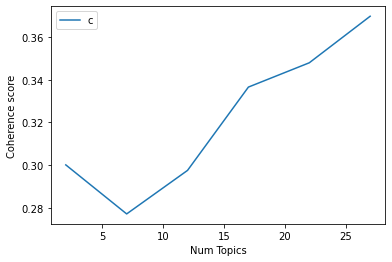

In [148]:
# Plot to see coherence score in order to choose optimal number of topics and decide optimal model
limit=30; start=2; step=5;
x = range(start, limit, step)
plt.plot(x, coherence_values_ph_2020_score1N2N3)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [149]:
# Print the coherence scores
index = 0
for m, cv in zip(x, coherence_values_ph_2020_score1N2N3):
    print("index:",index,"|","Num Topics =", m, " has Coherence Value of", round(cv, 4))
    index = index + 1

# optimal num_topics = 27

index: 0 | Num Topics = 2  has Coherence Value of 0.3001
index: 1 | Num Topics = 7  has Coherence Value of 0.2771
index: 2 | Num Topics = 12  has Coherence Value of 0.2975
index: 3 | Num Topics = 17  has Coherence Value of 0.3366
index: 4 | Num Topics = 22  has Coherence Value of 0.348
index: 5 | Num Topics = 27  has Coherence Value of 0.3698


In [184]:
# Select optimal number of topics
optimal_model_ph_2020_score1N2N3 = model_list_ph_2020_score1N2N3[5]

In [185]:
# pyLDAVis
pyLDAvis.enable_notebook()
vis_ph_2020_score1N2N3 = pyLDAvis.gensim_models.prepare(optimal_model_ph_2020_score1N2N3, corpus_ph_2020_score1N2N3, id2word_ph_2020_score1N2N3)

In [186]:
print("pyLDAVis for ph topics for score=1,2,3 in 2020:")
vis_ph_2020_score1N2N3

pyLDAVis for ph topics for score=1,2,3 in 2020:


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.127347  0.058848       1        1  12.749846
6     -0.098566 -0.000358       2        1   8.053282
19    -0.059057 -0.018817       3        1   6.600198
21    -0.096762 -0.068530       4        1   6.277664
8     -0.093563  0.079208       5        1   6.178453
0     -0.064727  0.005946       6        1   5.811788
10    -0.092944  0.046322       7        1   5.761419
3     -0.069176 -0.001795       8        1   5.498423
12    -0.044213 -0.163382       9        1   5.451599
13    -0.120755 -0.020847      10        1   5.421386
16    -0.060934  0.032231      11        1   3.612701
7     -0.034748  0.006453      12        1   3.298161
24     0.073677  0.133999      13        1   3.169610
20    -0.043600 -0.141259      14        1   3.097869
26    -0.064370  0.103689      15        1   2.870796
14    -0.021832  0.058741      16        1   2.771160
5      0.092438 -0.146306      17        1   2.664826
17     0.096284 -0.031318      18        1   2.201076
11    -0.017806  0.011685      19        1   2.019931
1      0.035392 -0.000788      20        1   1.619866
4      0.122556 -0.045018      21        1   1.323654
18     0.088403 -0.046257      22        1   1.268193
25     0.071051 -0.033572      23        1   1.193276
9      0.146956  0.087613      24        1   0.738875
22     0.127882  0.031170      25        1   0.115316
23     0.127882  0.031170      26        1   0.115316
15     0.127882  0.031170      27        1   0.115316, topic_info=         Term       Freq      Total Category  logprob  loglift
45       post  59.000000  59.000000  Default  30.0000  30.0000
103   account  85.000000  85.000000  Default  29.0000  29.0000
30     update  65.000000  65.000000  Default  28.0000  28.0000
44    picture  22.000000  22.000000  Default  27.0000  27.0000
120      view  14.000000  14.000000  Default  26.0000  26.0000
..        ...        ...        ...      ...      ...      ...
39   facebook   0.004595  92.621232  Topic27  -6.9108  -3.1460
197    device   0.004595   8.139718  Topic27  -6.9108  -0.7142
0      afford   0.004595   1.438607  Topic27  -6.9108   1.0189
2         buy   0.004595   2.828846  Topic27  -6.9108   0.3427
3      camera   0.004595   2.282673  Topic27  -6.9108   0.5572

[1502 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
410       1  0.200932       able
410       3  0.100466       able
410       4  0.100466       able
410       5  0.100466       able
410       6  0.100466       able
...     ...       ...        ...
471       8  0.619282  yesterday
471       9  0.309641  yesterday
967      16  0.691870      young
292      13  0.678452  zealander
229      12  0.679356       zoom

[2108 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 7, 20, 22, 9, 1, 11, 4, 13, 14, 17, 8, 25, 21, 27, 15, 6, 18, 12, 2, 5, 19, 26, 10, 23, 24, 16])

## By-rating of 2021 (Rating=1,2,3)

In [153]:
# By-rating Topic Modelling - rating = 1,2,3 in 2021
# Convert to list - move to each section
review_ph_2021_score1N2N3 = facebook_ios_ph_review_YearMonth_2021_score1N2N3.review.values.tolist()
review_words_ph_2021_score1N2N3 = list(sent_to_words(review_ph_2021_score1N2N3))
print(review_words_ph_2021_score1N2N3[:1])

[['hey', 'facebook', 'team', 'please', 'consider', 'having', 'low', 'data', 'mode', 'option', 'on', 'your', 'app', 'eve', 'if', 'we', 'are', 'using', 'wi', 'fi', 'we', 'mostly', 'use', 'prepaid', 'internet', 'data', 'here', 'in', 'philippines', 'it', 'very', 'costly', 'and', 'when', 'we', 'watch', 'videos', 'here', 'while', 'our', 'internet', 'speed', 'is', 'fast', 'it', 'uses', 'by', 'default', 'the', 'higher', 'resolution', 'please', 'give', 'us', 'the', 'freedom', 'to', 'change', 'or', 'lock', 'the', 'resolution', 'in', 'app', 'that', 'would', 'be', 'great', 'help', 'for', 'us', 'saving', 'money', 'and', 'data', 'regards']]


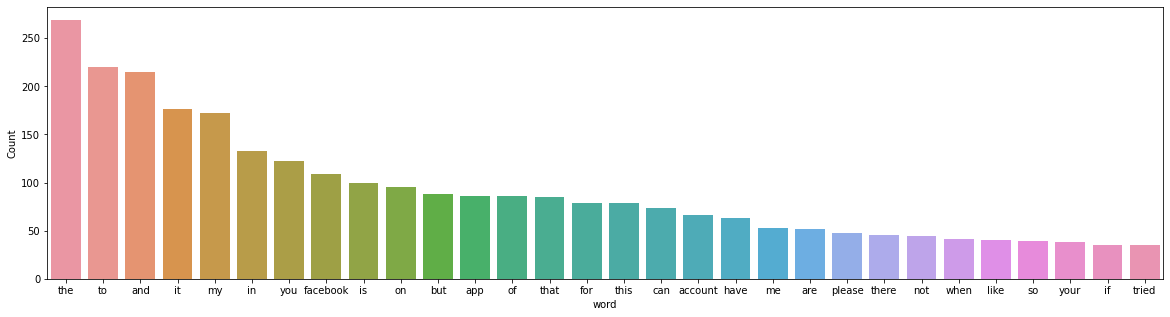

In [154]:
# Inspect the frequency of words before cleaning
freq_words(flatten(review_words_ph_2021_score1N2N3))

In [155]:
# Clean text
review_words_ph_ready_2021_score1N2N3 = process_words(review_words_ph_2021_score1N2N3)  # processed Text Data! - move to each section

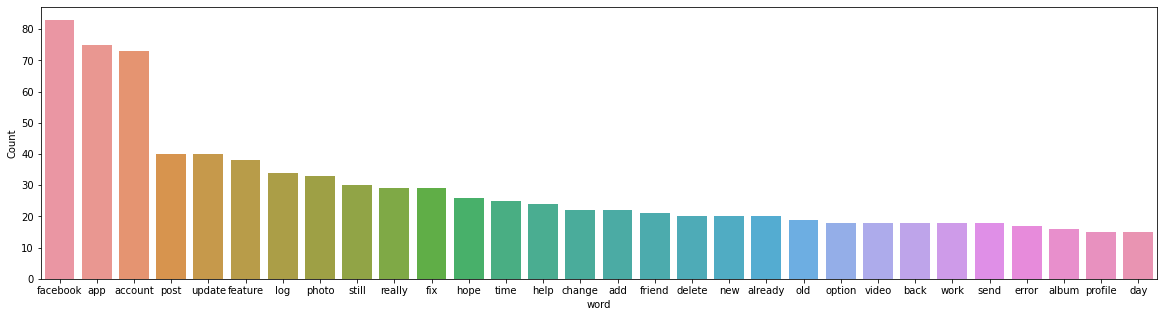

In [156]:
# Inspect the frequency of words after cleaning
freq_words(flatten(review_words_ph_ready_2021_score1N2N3))


In [157]:
# Create Dictionary
id2word_ph_2021_score1N2N3 = corpora.Dictionary(review_words_ph_ready_2021_score1N2N3)

2021-10-16 19:02:27,762 [INFO] gensim.corpora.dictionary - adding document #0 to Dictionary(0 unique tokens: [])
2021-10-16 19:02:27,774 [INFO] gensim.corpora.dictionary - built Dictionary(915 unique tokens: ['app', 'change', 'consider', 'costly', 'datum']...) from 91 documents (total 2917 corpus positions)
2021-10-16 19:02:27,777 [INFO] gensim.utils - Dictionary lifecycle event {'msg': "built Dictionary(915 unique tokens: ['app', 'change', 'consider', 'costly', 'datum']...) from 91 documents (total 2917 corpus positions)", 'datetime': '2021-10-16T19:02:27.777417', 'gensim': '4.1.2', 'python': '3.8.8 (default, Apr 13 2021, 12:59:45) \n[Clang 10.0.0 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'created'}


In [158]:
# Create Corpus: Term Document Frequency
corpus_ph_2021_score1N2N3 = [id2word_ph_2021_score1N2N3.doc2bow(text) for text in review_words_ph_ready_2021_score1N2N3]

In [159]:
# Training LDA model
model_list_ph_2021_score1N2N3, coherence_values_ph_2021_score1N2N3 = compute_coherence_values(dictionary=id2word_ph_2021_score1N2N3, corpus=corpus_ph_2021_score1N2N3, 
                                                              texts=review_words_ph_ready_2021_score1N2N3, limit=30, start=2, step=5)


2021-10-16 19:02:27,869 [INFO] gensim.models.ldamodel - using symmetric alpha at 0.5
2021-10-16 19:02:27,879 [INFO] gensim.models.ldamodel - using symmetric eta at 0.5
2021-10-16 19:02:27,911 [INFO] gensim.models.ldamodel - using serial LDA version on this node
2021-10-16 19:02:27,919 [INFO] gensim.models.ldamodel - running online (multi-pass) LDA training, 2 topics, 50 passes over the supplied corpus of 91 documents, updating model once every 91 documents, evaluating perplexity every 91 documents, iterating 50x with a convergence threshold of 0.001000
2021-10-16 19:02:28,234 [INFO] gensim.models.ldamodel - -7.421 per-word bound, 171.3 perplexity estimate based on a held-out corpus of 91 documents with 2917 words
2021-10-16 19:02:28,236 [INFO] gensim.models.ldamodel - PROGRESS: pass 0, at document #91/91
2021-10-16 19:02:28,570 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.023*"account" + 0.022*"facebook" + 0.021*"app" + 0.012*"feature" + 0.012*"log" + 0.011*"post" + 0.011*"updat

2021-10-16 19:02:31,954 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.022*"facebook" + 0.015*"post" + 0.013*"update" + 0.012*"app" + 0.012*"feature" + 0.008*"video" + 0.007*"friend" + 0.007*"watch" + 0.007*"group" + 0.007*"story"
2021-10-16 19:02:31,955 [INFO] gensim.models.ldamodel - topic diff=0.016063, rho=0.301511
2021-10-16 19:02:32,151 [INFO] gensim.models.ldamodel - -6.434 per-word bound, 86.5 perplexity estimate based on a held-out corpus of 91 documents with 2917 words
2021-10-16 19:02:32,161 [INFO] gensim.models.ldamodel - PROGRESS: pass 10, at document #91/91
2021-10-16 19:02:32,372 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.030*"account" + 0.025*"app" + 0.022*"facebook" + 0.015*"log" + 0.012*"photo" + 0.012*"still" + 0.011*"really" + 0.009*"help" + 0.009*"fix" + 0.009*"update"
2021-10-16 19:02:32,388 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.022*"facebook" + 0.015*"post" + 0.013*"update" + 0.012*"feature" + 0.012*"app" + 0.008*"video" + 0.007*"frien

2021-10-16 19:02:36,475 [INFO] gensim.models.ldamodel - topic diff=0.007699, rho=0.218218
2021-10-16 19:02:36,720 [INFO] gensim.models.ldamodel - -6.423 per-word bound, 85.8 perplexity estimate based on a held-out corpus of 91 documents with 2917 words
2021-10-16 19:02:36,722 [INFO] gensim.models.ldamodel - PROGRESS: pass 20, at document #91/91
2021-10-16 19:02:36,844 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.030*"account" + 0.025*"app" + 0.022*"facebook" + 0.015*"log" + 0.012*"photo" + 0.012*"still" + 0.011*"really" + 0.009*"fix" + 0.009*"help" + 0.009*"update"
2021-10-16 19:02:36,846 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.021*"facebook" + 0.015*"post" + 0.013*"feature" + 0.013*"update" + 0.012*"app" + 0.009*"video" + 0.008*"friend" + 0.007*"watch" + 0.007*"group" + 0.007*"story"
2021-10-16 19:02:36,847 [INFO] gensim.models.ldamodel - topic diff=0.006579, rho=0.213201
2021-10-16 19:02:37,070 [INFO] gensim.models.ldamodel - -6.422 per-word bound, 85.8 perplexity 

2021-10-16 19:02:40,022 [INFO] gensim.models.ldamodel - -6.418 per-word bound, 85.5 perplexity estimate based on a held-out corpus of 91 documents with 2917 words
2021-10-16 19:02:40,028 [INFO] gensim.models.ldamodel - PROGRESS: pass 30, at document #91/91
2021-10-16 19:02:40,186 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.030*"account" + 0.025*"app" + 0.023*"facebook" + 0.015*"log" + 0.012*"photo" + 0.012*"still" + 0.011*"really" + 0.009*"fix" + 0.009*"update" + 0.009*"help"
2021-10-16 19:02:40,188 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.021*"facebook" + 0.015*"post" + 0.013*"feature" + 0.013*"update" + 0.011*"app" + 0.009*"video" + 0.008*"friend" + 0.007*"watch" + 0.007*"group" + 0.007*"story"
2021-10-16 19:02:40,189 [INFO] gensim.models.ldamodel - topic diff=0.003066, rho=0.176777
2021-10-16 19:02:40,313 [INFO] gensim.models.ldamodel - -6.418 per-word bound, 85.5 perplexity estimate based on a held-out corpus of 91 documents with 2917 words
2021-10-16 19:02:40,31

2021-10-16 19:02:43,236 [INFO] gensim.models.ldamodel - PROGRESS: pass 40, at document #91/91
2021-10-16 19:02:43,351 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.030*"account" + 0.025*"app" + 0.023*"facebook" + 0.015*"log" + 0.013*"photo" + 0.012*"still" + 0.011*"really" + 0.010*"fix" + 0.010*"update" + 0.009*"help"
2021-10-16 19:02:43,363 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.020*"facebook" + 0.015*"post" + 0.014*"feature" + 0.013*"update" + 0.011*"app" + 0.009*"video" + 0.008*"friend" + 0.007*"watch" + 0.007*"group" + 0.007*"story"
2021-10-16 19:02:43,367 [INFO] gensim.models.ldamodel - topic diff=0.001178, rho=0.154303
2021-10-16 19:02:43,579 [INFO] gensim.models.ldamodel - -6.417 per-word bound, 85.4 perplexity estimate based on a held-out corpus of 91 documents with 2917 words
2021-10-16 19:02:43,580 [INFO] gensim.models.ldamodel - PROGRESS: pass 41, at document #91/91
2021-10-16 19:02:43,708 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.030*"account" +

2021-10-16 19:02:46,213 [INFO] gensim.topic_coherence.probability_estimation - using ParallelWordOccurrenceAccumulator(processes=7, batch_size=64) to estimate probabilities from sliding windows
2021-10-16 19:02:51,102 [INFO] gensim.topic_coherence.text_analysis - 7 accumulators retrieved from output queue
2021-10-16 19:02:51,153 [INFO] gensim.topic_coherence.text_analysis - accumulated word occurrence stats for 91 virtual documents
2021-10-16 19:02:51,446 [INFO] gensim.models.ldamodel - using symmetric alpha at 0.14285714285714285
2021-10-16 19:02:51,447 [INFO] gensim.models.ldamodel - using symmetric eta at 0.14285714285714285
2021-10-16 19:02:51,450 [INFO] gensim.models.ldamodel - using serial LDA version on this node
2021-10-16 19:02:51,453 [INFO] gensim.models.ldamodel - running online (multi-pass) LDA training, 7 topics, 50 passes over the supplied corpus of 91 documents, updating model once every 91 documents, evaluating perplexity every 91 documents, iterating 50x with a converg

2021-10-16 19:02:53,266 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.052*"account" + 0.037*"facebook" + 0.018*"game" + 0.018*"app" + 0.017*"help" + 0.014*"ban" + 0.014*"log" + 0.012*"already" + 0.010*"send" + 0.010*"date"
2021-10-16 19:02:53,268 [INFO] gensim.models.ldamodel - topic diff=0.094492, rho=0.408248
2021-10-16 19:02:53,440 [INFO] gensim.models.ldamodel - -6.634 per-word bound, 99.3 perplexity estimate based on a held-out corpus of 91 documents with 2917 words
2021-10-16 19:02:53,441 [INFO] gensim.models.ldamodel - PROGRESS: pass 5, at document #91/91
2021-10-16 19:02:53,497 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.028*"account" + 0.021*"facebook" + 0.015*"feature" + 0.014*"video" + 0.014*"login" + 0.013*"app" + 0.012*"log" + 0.012*"work" + 0.011*"fix" + 0.011*"active"
2021-10-16 19:02:53,500 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.034*"feature" + 0.031*"app" + 0.022*"update" + 0.020*"photo" + 0.017*"profile" + 0.015*"option" + 0.014*"still" + 0.

2021-10-16 19:02:54,831 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.029*"post" + 0.029*"facebook" + 0.020*"update" + 0.019*"really" + 0.017*"app" + 0.014*"hope" + 0.014*"change" + 0.014*"block" + 0.012*"fix" + 0.011*"account"
2021-10-16 19:02:54,832 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.034*"app" + 0.020*"log" + 0.020*"facebook" + 0.015*"account" + 0.011*"update" + 0.010*"time" + 0.009*"work" + 0.009*"happen" + 0.009*"setting" + 0.009*"still"
2021-10-16 19:02:54,834 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.054*"account" + 0.039*"facebook" + 0.019*"app" + 0.018*"game" + 0.018*"help" + 0.016*"log" + 0.014*"ban" + 0.012*"already" + 0.010*"send" + 0.010*"date"
2021-10-16 19:02:54,836 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.020*"page" + 0.017*"account" + 0.017*"turn" + 0.013*"facebook" + 0.013*"tab" + 0.011*"keep" + 0.010*"send" + 0.010*"watch" + 0.010*"connection" + 0.010*"connect"
2021-10-16 19:02:54,837 [INFO] gensim.models.ldamodel - topic di

2021-10-16 19:02:56,106 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.034*"app" + 0.020*"log" + 0.019*"facebook" + 0.015*"account" + 0.011*"update" + 0.010*"time" + 0.009*"work" + 0.009*"happen" + 0.009*"setting" + 0.008*"still"
2021-10-16 19:02:56,109 [INFO] gensim.models.ldamodel - topic diff=0.003923, rho=0.242536
2021-10-16 19:02:56,255 [INFO] gensim.models.ldamodel - -6.614 per-word bound, 98.0 perplexity estimate based on a held-out corpus of 91 documents with 2917 words
2021-10-16 19:02:56,257 [INFO] gensim.models.ldamodel - PROGRESS: pass 16, at document #91/91
2021-10-16 19:02:56,345 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.020*"page" + 0.017*"account" + 0.017*"turn" + 0.013*"facebook" + 0.013*"tab" + 0.011*"keep" + 0.010*"send" + 0.010*"watch" + 0.010*"connection" + 0.010*"connect"
2021-10-16 19:02:56,348 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.037*"feature" + 0.031*"app" + 0.022*"update" + 0.022*"photo" + 0.018*"profile" + 0.015*"option" + 0.014*

2021-10-16 19:02:57,698 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.034*"app" + 0.020*"log" + 0.019*"facebook" + 0.015*"account" + 0.011*"update" + 0.010*"time" + 0.009*"work" + 0.009*"happen" + 0.009*"setting" + 0.008*"still"
2021-10-16 19:02:57,700 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.020*"page" + 0.017*"turn" + 0.017*"account" + 0.013*"facebook" + 0.013*"tab" + 0.011*"keep" + 0.010*"send" + 0.010*"watch" + 0.010*"connection" + 0.010*"connect"
2021-10-16 19:02:57,701 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.029*"post" + 0.029*"facebook" + 0.020*"update" + 0.019*"really" + 0.017*"app" + 0.014*"hope" + 0.014*"change" + 0.014*"block" + 0.012*"fix" + 0.012*"account"
2021-10-16 19:02:57,702 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.038*"feature" + 0.031*"app" + 0.023*"photo" + 0.022*"update" + 0.017*"profile" + 0.015*"option" + 0.014*"still" + 0.014*"really" + 0.013*"new" + 0.012*"delete"
2021-10-16 19:02:57,703 [INFO] gensim.models.ldamodel - t

2021-10-16 19:02:58,971 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.029*"account" + 0.021*"facebook" + 0.015*"login" + 0.015*"video" + 0.013*"log" + 0.013*"app" + 0.013*"feature" + 0.012*"work" + 0.011*"fix" + 0.011*"active"
2021-10-16 19:02:58,974 [INFO] gensim.models.ldamodel - topic diff=0.001329, rho=0.188982
2021-10-16 19:02:59,190 [INFO] gensim.models.ldamodel - -6.611 per-word bound, 97.7 perplexity estimate based on a held-out corpus of 91 documents with 2917 words
2021-10-16 19:02:59,191 [INFO] gensim.models.ldamodel - PROGRESS: pass 27, at document #91/91
2021-10-16 19:02:59,247 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.020*"page" + 0.017*"turn" + 0.016*"account" + 0.013*"facebook" + 0.013*"tab" + 0.011*"keep" + 0.010*"send" + 0.010*"watch" + 0.010*"connection" + 0.010*"connect"
2021-10-16 19:02:59,249 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.029*"post" + 0.029*"facebook" + 0.020*"update" + 0.019*"really" + 0.017*"app" + 0.014*"hope" + 0.014*"chan

2021-10-16 19:03:00,586 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.029*"post" + 0.029*"facebook" + 0.020*"update" + 0.019*"really" + 0.017*"app" + 0.014*"hope" + 0.014*"change" + 0.014*"block" + 0.012*"fix" + 0.012*"account"
2021-10-16 19:03:00,588 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.020*"page" + 0.017*"turn" + 0.016*"account" + 0.013*"tab" + 0.013*"facebook" + 0.011*"keep" + 0.010*"send" + 0.010*"watch" + 0.010*"connection" + 0.010*"connect"
2021-10-16 19:03:00,589 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.038*"feature" + 0.031*"app" + 0.023*"photo" + 0.022*"update" + 0.017*"profile" + 0.015*"option" + 0.014*"still" + 0.013*"really" + 0.013*"new" + 0.013*"delete"
2021-10-16 19:03:00,591 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.029*"photo" + 0.026*"album" + 0.024*"add" + 0.016*"new" + 0.014*"facebook" + 0.014*"feature" + 0.012*"fb" + 0.012*"post" + 0.010*"account" + 0.010*"well"
2021-10-16 19:03:00,598 [INFO] gensim.models.ldamodel - topic 

2021-10-16 19:03:01,819 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.029*"post" + 0.029*"facebook" + 0.020*"update" + 0.019*"really" + 0.017*"app" + 0.014*"change" + 0.014*"hope" + 0.014*"block" + 0.012*"fix" + 0.012*"account"
2021-10-16 19:03:01,821 [INFO] gensim.models.ldamodel - topic diff=0.000791, rho=0.160128
2021-10-16 19:03:01,940 [INFO] gensim.models.ldamodel - -6.610 per-word bound, 97.7 perplexity estimate based on a held-out corpus of 91 documents with 2917 words
2021-10-16 19:03:01,941 [INFO] gensim.models.ldamodel - PROGRESS: pass 38, at document #91/91
2021-10-16 19:03:02,072 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.034*"app" + 0.021*"log" + 0.019*"facebook" + 0.015*"account" + 0.011*"update" + 0.010*"time" + 0.009*"work" + 0.009*"happen" + 0.009*"setting" + 0.008*"still"
2021-10-16 19:03:02,073 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.039*"feature" + 0.031*"app" + 0.023*"photo" + 0.023*"update" + 0.017*"profile" + 0.015*"option" + 0.014*"sti

2021-10-16 19:03:03,279 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.029*"account" + 0.021*"facebook" + 0.015*"login" + 0.015*"video" + 0.013*"log" + 0.013*"app" + 0.012*"work" + 0.012*"feature" + 0.011*"fix" + 0.011*"active"
2021-10-16 19:03:03,282 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.039*"feature" + 0.031*"app" + 0.023*"update" + 0.023*"photo" + 0.017*"profile" + 0.015*"option" + 0.014*"still" + 0.013*"really" + 0.013*"facebook" + 0.013*"new"
2021-10-16 19:03:03,285 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.029*"photo" + 0.026*"album" + 0.024*"add" + 0.016*"new" + 0.014*"facebook" + 0.013*"feature" + 0.012*"fb" + 0.012*"post" + 0.010*"account" + 0.010*"well"
2021-10-16 19:03:03,288 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.034*"app" + 0.021*"log" + 0.019*"facebook" + 0.015*"account" + 0.011*"update" + 0.010*"time" + 0.009*"work" + 0.009*"happen" + 0.009*"setting" + 0.008*"still"
2021-10-16 19:03:03,291 [INFO] gensim.models.ldamodel - topic di

2021-10-16 19:03:04,498 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.034*"app" + 0.021*"log" + 0.019*"facebook" + 0.015*"account" + 0.011*"update" + 0.010*"time" + 0.009*"work" + 0.009*"happen" + 0.009*"setting" + 0.008*"still"
2021-10-16 19:03:04,501 [INFO] gensim.models.ldamodel - topic diff=0.000420, rho=0.141421
2021-10-16 19:03:04,686 [INFO] gensim.models.ldamodel - -6.609 per-word bound, 97.6 perplexity estimate based on a held-out corpus of 91 documents with 2917 words
2021-10-16 19:03:04,687 [INFO] gensim.models.ldamodel - PROGRESS: pass 49, at document #91/91
2021-10-16 19:03:04,816 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.055*"account" + 0.040*"facebook" + 0.019*"app" + 0.019*"game" + 0.019*"log" + 0.018*"help" + 0.015*"ban" + 0.013*"already" + 0.011*"send" + 0.010*"date"
2021-10-16 19:03:04,819 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.029*"photo" + 0.026*"album" + 0.024*"add" + 0.016*"new" + 0.014*"facebook" + 0.012*"fb" + 0.012*"post" + 0.012*"f

2021-10-16 19:03:11,803 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.029*"app" + 0.025*"photo" + 0.019*"still" + 0.019*"way" + 0.019*"privacy" + 0.014*"friend" + 0.014*"facebook" + 0.014*"really" + 0.014*"feature" + 0.014*"send"
2021-10-16 19:03:11,806 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.040*"account" + 0.025*"facebook" + 0.019*"post" + 0.017*"really" + 0.015*"app" + 0.012*"fb" + 0.012*"fix" + 0.012*"video" + 0.011*"feature" + 0.011*"problem"
2021-10-16 19:03:11,808 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.024*"album" + 0.024*"photo" + 0.021*"well" + 0.020*"app" + 0.019*"update" + 0.016*"hope" + 0.016*"delete" + 0.013*"feature" + 0.012*"add" + 0.012*"facebook"
2021-10-16 19:03:11,811 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.028*"facebook" + 0.012*"photo" + 0.012*"app" + 0.012*"medium" + 0.012*"social" + 0.012*"platform" + 0.012*"connect" + 0.012*"connection" + 0.012*"time" + 0.012*"restrict"
2021-10-16 19:03:11,812 [INFO] gensim.models.ldam

2021-10-16 19:03:12,981 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.030*"app" + 0.025*"account" + 0.020*"facebook" + 0.018*"new" + 0.015*"really" + 0.014*"game" + 0.014*"update" + 0.014*"feature" + 0.014*"change" + 0.013*"log"
2021-10-16 19:03:13,002 [INFO] gensim.models.ldamodel - topic diff=0.030579, rho=0.316228
2021-10-16 19:03:13,200 [INFO] gensim.models.ldamodel - -6.727 per-word bound, 105.9 perplexity estimate based on a held-out corpus of 91 documents with 2917 words
2021-10-16 19:03:13,201 [INFO] gensim.models.ldamodel - PROGRESS: pass 9, at document #91/91
2021-10-16 19:03:13,251 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.029*"app" + 0.024*"photo" + 0.019*"still" + 0.019*"way" + 0.019*"privacy" + 0.015*"friend" + 0.015*"facebook" + 0.015*"really" + 0.015*"feature" + 0.014*"send"
2021-10-16 19:03:13,256 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.028*"account" + 0.025*"facebook" + 0.019*"login" + 0.019*"messenger" + 0.016*"log" + 0.012*"mode" + 0.012

2021-10-16 19:03:14,441 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.029*"app" + 0.024*"photo" + 0.019*"still" + 0.019*"way" + 0.019*"privacy" + 0.015*"friend" + 0.015*"facebook" + 0.015*"really" + 0.015*"feature" + 0.015*"send"
2021-10-16 19:03:14,443 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.040*"account" + 0.024*"app" + 0.020*"help" + 0.016*"update" + 0.016*"still" + 0.012*"give" + 0.012*"ask" + 0.012*"datum" + 0.012*"already" + 0.012*"log"
2021-10-16 19:03:14,444 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.033*"feature" + 0.025*"photo" + 0.021*"account" + 0.020*"app" + 0.019*"group" + 0.018*"facebook" + 0.017*"profile" + 0.016*"still" + 0.016*"option" + 0.016*"delete"
2021-10-16 19:03:14,445 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.028*"facebook" + 0.012*"photo" + 0.012*"app" + 0.012*"medium" + 0.012*"social" + 0.012*"platform" + 0.012*"connect" + 0.012*"connection" + 0.012*"time" + 0.012*"restrict"
2021-10-16 19:03:14,448 [INFO] gensim.models.ld

2021-10-16 19:03:15,632 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.030*"app" + 0.025*"account" + 0.020*"facebook" + 0.018*"new" + 0.016*"really" + 0.015*"feature" + 0.014*"change" + 0.014*"update" + 0.014*"game" + 0.013*"hope"
2021-10-16 19:03:15,634 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.022*"app" + 0.022*"facebook" + 0.016*"feed" + 0.016*"people" + 0.016*"update" + 0.016*"log" + 0.013*"account" + 0.013*"news" + 0.013*"old" + 0.010*"back"
2021-10-16 19:03:15,636 [INFO] gensim.models.ldamodel - topic diff=0.002123, rho=0.218218
2021-10-16 19:03:15,774 [INFO] gensim.models.ldamodel - -6.719 per-word bound, 105.4 perplexity estimate based on a held-out corpus of 91 documents with 2917 words
2021-10-16 19:03:15,779 [INFO] gensim.models.ldamodel - PROGRESS: pass 20, at document #91/91
2021-10-16 19:03:15,851 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.030*"app" + 0.025*"account" + 0.020*"facebook" + 0.018*"new" + 0.016*"really" + 0.015*"feature" + 0.014*"cha

2021-10-16 19:03:17,018 [INFO] gensim.models.ldamodel - PROGRESS: pass 25, at document #91/91
2021-10-16 19:03:17,091 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.040*"account" + 0.026*"facebook" + 0.019*"post" + 0.017*"really" + 0.015*"app" + 0.013*"video" + 0.013*"fb" + 0.013*"fix" + 0.011*"feature" + 0.011*"problem"
2021-10-16 19:03:17,094 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.027*"page" + 0.022*"facebook" + 0.022*"turn" + 0.022*"tab" + 0.017*"friend" + 0.017*"story" + 0.017*"feature" + 0.017*"add" + 0.017*"watch" + 0.011*"delete"
2021-10-16 19:03:17,096 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.033*"feature" + 0.025*"photo" + 0.021*"account" + 0.020*"app" + 0.019*"group" + 0.018*"facebook" + 0.017*"profile" + 0.016*"still" + 0.016*"delete" + 0.016*"option"
2021-10-16 19:03:17,100 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.025*"album" + 0.025*"photo" + 0.021*"well" + 0.021*"update" + 0.020*"app" + 0.017*"delete" + 0.017*"hope" + 0.013*"featur

2021-10-16 19:03:18,324 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.039*"account" + 0.024*"app" + 0.020*"help" + 0.016*"update" + 0.016*"still" + 0.012*"give" + 0.012*"ask" + 0.012*"datum" + 0.012*"already" + 0.012*"log"
2021-10-16 19:03:18,325 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.028*"facebook" + 0.012*"photo" + 0.012*"medium" + 0.012*"app" + 0.012*"social" + 0.012*"platform" + 0.012*"connect" + 0.012*"connection" + 0.012*"time" + 0.012*"restrict"
2021-10-16 19:03:18,327 [INFO] gensim.models.ldamodel - topic diff=0.000521, rho=0.176777
2021-10-16 19:03:18,439 [INFO] gensim.models.ldamodel - -6.718 per-word bound, 105.3 perplexity estimate based on a held-out corpus of 91 documents with 2917 words
2021-10-16 19:03:18,440 [INFO] gensim.models.ldamodel - PROGRESS: pass 31, at document #91/91
2021-10-16 19:03:18,482 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.035*"facebook" + 0.031*"account" + 0.028*"already" + 0.021*"send" + 0.018*"app" + 0.018*"date" + 0.0

2021-10-16 19:03:19,514 [INFO] gensim.models.ldamodel - PROGRESS: pass 36, at document #91/91
2021-10-16 19:03:19,597 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.039*"account" + 0.024*"app" + 0.020*"help" + 0.016*"update" + 0.016*"still" + 0.012*"give" + 0.012*"ask" + 0.012*"datum" + 0.012*"already" + 0.012*"log"
2021-10-16 19:03:19,601 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.033*"feature" + 0.025*"photo" + 0.022*"account" + 0.020*"app" + 0.019*"group" + 0.018*"facebook" + 0.017*"profile" + 0.016*"still" + 0.016*"delete" + 0.016*"option"
2021-10-16 19:03:19,604 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.028*"facebook" + 0.012*"medium" + 0.012*"photo" + 0.012*"social" + 0.012*"platform" + 0.012*"app" + 0.012*"connect" + 0.012*"connection" + 0.012*"time" + 0.012*"restrict"
2021-10-16 19:03:19,606 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.028*"account" + 0.025*"facebook" + 0.019*"login" + 0.019*"messenger" + 0.016*"log" + 0.013*"mode" + 0.013*"dark" 

2021-10-16 19:03:21,216 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.029*"app" + 0.024*"photo" + 0.019*"still" + 0.019*"privacy" + 0.019*"way" + 0.015*"friend" + 0.015*"send" + 0.015*"feature" + 0.015*"really" + 0.015*"facebook"
2021-10-16 19:03:21,218 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.033*"feature" + 0.025*"photo" + 0.022*"account" + 0.020*"app" + 0.019*"group" + 0.018*"facebook" + 0.017*"profile" + 0.016*"still" + 0.016*"delete" + 0.016*"option"
2021-10-16 19:03:21,221 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.025*"album" + 0.025*"photo" + 0.021*"well" + 0.021*"update" + 0.020*"app" + 0.017*"delete" + 0.017*"hope" + 0.013*"feature" + 0.013*"add" + 0.013*"messange"
2021-10-16 19:03:21,223 [INFO] gensim.models.ldamodel - topic diff=0.000197, rho=0.152499
2021-10-16 19:03:21,395 [INFO] gensim.models.ldamodel - -6.717 per-word bound, 105.2 perplexity estimate based on a held-out corpus of 91 documents with 2917 words
2021-10-16 19:03:21,401 [INFO] gens

2021-10-16 19:03:22,736 [INFO] gensim.models.ldamodel - topic diff=0.000144, rho=0.144338
2021-10-16 19:03:22,941 [INFO] gensim.models.ldamodel - -6.717 per-word bound, 105.2 perplexity estimate based on a held-out corpus of 91 documents with 2917 words
2021-10-16 19:03:22,942 [INFO] gensim.models.ldamodel - PROGRESS: pass 47, at document #91/91
2021-10-16 19:03:23,037 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.027*"page" + 0.022*"turn" + 0.022*"facebook" + 0.022*"tab" + 0.017*"friend" + 0.017*"add" + 0.017*"feature" + 0.017*"story" + 0.017*"watch" + 0.011*"great"
2021-10-16 19:03:23,039 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.022*"app" + 0.022*"facebook" + 0.016*"people" + 0.016*"feed" + 0.016*"update" + 0.016*"log" + 0.013*"old" + 0.013*"news" + 0.013*"account" + 0.010*"post"
2021-10-16 19:03:23,044 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.038*"post" + 0.026*"facebook" + 0.021*"update" + 0.020*"app" + 0.017*"time" + 0.017*"hope" + 0.014*"fix" + 0.014*"

2021-10-16 19:03:31,074 [INFO] gensim.models.ldamodel - topic #13 (0.059): 0.034*"feature" + 0.025*"game" + 0.024*"facebook" + 0.023*"new" + 0.023*"photo" + 0.021*"back" + 0.021*"old" + 0.019*"update" + 0.018*"app" + 0.015*"really"
2021-10-16 19:03:31,076 [INFO] gensim.models.ldamodel - topic #10 (0.059): 0.033*"account" + 0.028*"app" + 0.023*"log" + 0.020*"new" + 0.020*"fb" + 0.017*"work" + 0.015*"time" + 0.013*"facebook" + 0.012*"change" + 0.012*"update"
2021-10-16 19:03:31,079 [INFO] gensim.models.ldamodel - topic #1 (0.059): 0.037*"page" + 0.030*"tab" + 0.029*"turn" + 0.023*"watch" + 0.015*"load" + 0.015*"friend" + 0.015*"hope" + 0.013*"facebook" + 0.011*"app" + 0.009*"set"
2021-10-16 19:03:31,080 [INFO] gensim.models.ldamodel - topic diff=0.327669, rho=0.577350
2021-10-16 19:03:31,213 [INFO] gensim.models.ldamodel - -6.979 per-word bound, 126.2 perplexity estimate based on a held-out corpus of 91 documents with 2917 words
2021-10-16 19:03:31,215 [INFO] gensim.models.ldamodel - PRO

2021-10-16 19:03:32,224 [INFO] gensim.models.ldamodel - topic diff=0.076508, rho=0.353553
2021-10-16 19:03:32,380 [INFO] gensim.models.ldamodel - -6.765 per-word bound, 108.8 perplexity estimate based on a held-out corpus of 91 documents with 2917 words
2021-10-16 19:03:32,383 [INFO] gensim.models.ldamodel - PROGRESS: pass 7, at document #91/91
2021-10-16 19:03:32,462 [INFO] gensim.models.ldamodel - topic #7 (0.059): 0.047*"account" + 0.019*"help" + 0.015*"app" + 0.014*"valid" + 0.014*"time" + 0.014*"still" + 0.014*"ask" + 0.014*"already" + 0.014*"give" + 0.014*"datum"
2021-10-16 19:03:32,478 [INFO] gensim.models.ldamodel - topic #11 (0.059): 0.035*"album" + 0.035*"photo" + 0.024*"delete" + 0.018*"add" + 0.018*"hope" + 0.018*"update" + 0.018*"messange" + 0.018*"unsent" + 0.012*"option" + 0.012*"app"
2021-10-16 19:03:32,483 [INFO] gensim.models.ldamodel - topic #3 (0.059): 0.039*"facebook" + 0.033*"app" + 0.029*"post" + 0.029*"update" + 0.024*"really" + 0.016*"fix" + 0.014*"block" + 0.0

2021-10-16 19:03:33,689 [INFO] gensim.models.ldamodel - topic #16 (0.059): 0.031*"give" + 0.021*"help" + 0.021*"community" + 0.021*"let" + 0.021*"star" + 0.011*"update" + 0.011*"time" + 0.011*"happen" + 0.011*"much" + 0.011*"contribute"
2021-10-16 19:03:33,691 [INFO] gensim.models.ldamodel - topic #11 (0.059): 0.037*"album" + 0.037*"photo" + 0.025*"delete" + 0.018*"add" + 0.018*"messange" + 0.018*"unsent" + 0.018*"update" + 0.017*"hope" + 0.012*"option" + 0.012*"app"
2021-10-16 19:03:33,692 [INFO] gensim.models.ldamodel - topic #2 (0.059): 0.051*"feature" + 0.032*"option" + 0.029*"add" + 0.026*"facebook" + 0.026*"app" + 0.020*"delete" + 0.020*"profile" + 0.016*"mode" + 0.016*"photo" + 0.016*"love"
2021-10-16 19:03:33,692 [INFO] gensim.models.ldamodel - topic diff=0.013031, rho=0.267261
2021-10-16 19:03:33,793 [INFO] gensim.models.ldamodel - -6.748 per-word bound, 107.5 perplexity estimate based on a held-out corpus of 91 documents with 2917 words
2021-10-16 19:03:33,795 [INFO] gensim.m

2021-10-16 19:03:34,724 [INFO] gensim.models.ldamodel - topic diff=0.004443, rho=0.229416
2021-10-16 19:03:34,854 [INFO] gensim.models.ldamodel - -6.742 per-word bound, 107.1 perplexity estimate based on a held-out corpus of 91 documents with 2917 words
2021-10-16 19:03:34,855 [INFO] gensim.models.ldamodel - PROGRESS: pass 18, at document #91/91
2021-10-16 19:03:34,962 [INFO] gensim.models.ldamodel - topic #5 (0.059): 0.034*"log" + 0.026*"facebook" + 0.025*"account" + 0.023*"error" + 0.017*"hope" + 0.017*"look" + 0.012*"feature" + 0.012*"story" + 0.012*"update" + 0.012*"user"
2021-10-16 19:03:34,964 [INFO] gensim.models.ldamodel - topic #6 (0.059): 0.028*"facebook" + 0.018*"app" + 0.018*"photo" + 0.014*"upload" + 0.014*"social" + 0.014*"medium" + 0.014*"connection" + 0.014*"connect" + 0.014*"platform" + 0.009*"mode"
2021-10-16 19:03:34,965 [INFO] gensim.models.ldamodel - topic #10 (0.059): 0.033*"account" + 0.028*"app" + 0.023*"fb" + 0.023*"log" + 0.021*"new" + 0.017*"work" + 0.016*"ti

2021-10-16 19:03:36,036 [INFO] gensim.models.ldamodel - topic #2 (0.059): 0.051*"feature" + 0.032*"option" + 0.029*"add" + 0.026*"facebook" + 0.026*"app" + 0.020*"delete" + 0.020*"profile" + 0.016*"mode" + 0.016*"photo" + 0.016*"love"
2021-10-16 19:03:36,039 [INFO] gensim.models.ldamodel - topic #5 (0.059): 0.034*"log" + 0.026*"facebook" + 0.025*"account" + 0.023*"error" + 0.017*"hope" + 0.017*"look" + 0.012*"feature" + 0.012*"story" + 0.012*"update" + 0.012*"user"
2021-10-16 19:03:36,042 [INFO] gensim.models.ldamodel - topic #4 (0.059): 0.038*"post" + 0.026*"facebook" + 0.026*"app" + 0.026*"people" + 0.021*"log" + 0.017*"fix" + 0.017*"change" + 0.017*"account" + 0.013*"error" + 0.013*"set"
2021-10-16 19:03:36,043 [INFO] gensim.models.ldamodel - topic #12 (0.059): 0.037*"facebook" + 0.023*"account" + 0.019*"already" + 0.019*"picture" + 0.019*"really" + 0.014*"first" + 0.014*"send" + 0.014*"friend" + 0.014*"status" + 0.014*"old"
2021-10-16 19:03:36,044 [INFO] gensim.models.ldamodel - to

2021-10-16 19:03:37,208 [INFO] gensim.models.ldamodel - topic #13 (0.059): 0.036*"feature" + 0.028*"game" + 0.025*"new" + 0.025*"facebook" + 0.024*"photo" + 0.021*"old" + 0.021*"back" + 0.021*"well" + 0.018*"update" + 0.017*"app"
2021-10-16 19:03:37,209 [INFO] gensim.models.ldamodel - topic diff=0.000944, rho=0.182574
2021-10-16 19:03:37,325 [INFO] gensim.models.ldamodel - -6.739 per-word bound, 106.8 perplexity estimate based on a held-out corpus of 91 documents with 2917 words
2021-10-16 19:03:37,326 [INFO] gensim.models.ldamodel - PROGRESS: pass 29, at document #91/91
2021-10-16 19:03:37,381 [INFO] gensim.models.ldamodel - topic #8 (0.059): 0.027*"photo" + 0.026*"way" + 0.026*"still" + 0.024*"app" + 0.020*"facebook" + 0.020*"send" + 0.020*"privacy" + 0.020*"friend" + 0.017*"really" + 0.013*"file"
2021-10-16 19:03:37,396 [INFO] gensim.models.ldamodel - topic #7 (0.059): 0.047*"account" + 0.019*"help" + 0.015*"app" + 0.014*"valid" + 0.014*"time" + 0.014*"still" + 0.014*"ask" + 0.014*"

2021-10-16 19:03:38,561 [INFO] gensim.models.ldamodel - topic #6 (0.059): 0.028*"facebook" + 0.018*"app" + 0.018*"photo" + 0.014*"upload" + 0.014*"social" + 0.014*"medium" + 0.014*"connection" + 0.014*"connect" + 0.014*"platform" + 0.009*"mode"
2021-10-16 19:03:38,564 [INFO] gensim.models.ldamodel - topic #10 (0.059): 0.033*"account" + 0.028*"app" + 0.023*"fb" + 0.023*"log" + 0.021*"new" + 0.017*"work" + 0.016*"time" + 0.013*"facebook" + 0.012*"change" + 0.012*"update"
2021-10-16 19:03:38,566 [INFO] gensim.models.ldamodel - topic #3 (0.059): 0.039*"facebook" + 0.033*"app" + 0.029*"post" + 0.029*"update" + 0.024*"really" + 0.016*"fix" + 0.014*"block" + 0.014*"mode" + 0.014*"regard" + 0.013*"great"
2021-10-16 19:03:38,570 [INFO] gensim.models.ldamodel - topic #16 (0.059): 0.031*"give" + 0.021*"help" + 0.021*"star" + 0.021*"community" + 0.021*"let" + 0.011*"update" + 0.011*"time" + 0.011*"happen" + 0.011*"express" + 0.011*"deserve"
2021-10-16 19:03:38,571 [INFO] gensim.models.ldamodel - t

2021-10-16 19:03:39,716 [INFO] gensim.models.ldamodel - topic #2 (0.059): 0.051*"feature" + 0.032*"option" + 0.029*"add" + 0.026*"facebook" + 0.026*"app" + 0.020*"delete" + 0.020*"profile" + 0.016*"mode" + 0.016*"photo" + 0.016*"love"
2021-10-16 19:03:39,717 [INFO] gensim.models.ldamodel - topic diff=0.000261, rho=0.156174
2021-10-16 19:03:39,836 [INFO] gensim.models.ldamodel - -6.738 per-word bound, 106.7 perplexity estimate based on a held-out corpus of 91 documents with 2917 words
2021-10-16 19:03:39,837 [INFO] gensim.models.ldamodel - PROGRESS: pass 40, at document #91/91
2021-10-16 19:03:39,885 [INFO] gensim.models.ldamodel - topic #9 (0.059): 0.054*"account" + 0.032*"facebook" + 0.023*"violate" + 0.023*"really" + 0.018*"ban" + 0.014*"well" + 0.014*"feature" + 0.014*"cause" + 0.014*"standard" + 0.014*"community"
2021-10-16 19:03:39,888 [INFO] gensim.models.ldamodel - topic #12 (0.059): 0.037*"facebook" + 0.023*"account" + 0.019*"already" + 0.019*"picture" + 0.019*"really" + 0.014*

2021-10-16 19:03:41,081 [INFO] gensim.models.ldamodel - topic #4 (0.059): 0.038*"post" + 0.026*"app" + 0.026*"facebook" + 0.026*"people" + 0.021*"log" + 0.017*"fix" + 0.017*"change" + 0.017*"account" + 0.013*"error" + 0.013*"set"
2021-10-16 19:03:41,083 [INFO] gensim.models.ldamodel - topic #7 (0.059): 0.047*"account" + 0.019*"help" + 0.015*"app" + 0.014*"valid" + 0.014*"time" + 0.014*"still" + 0.014*"ask" + 0.014*"already" + 0.014*"give" + 0.014*"datum"
2021-10-16 19:03:41,086 [INFO] gensim.models.ldamodel - topic #8 (0.059): 0.027*"photo" + 0.026*"way" + 0.026*"still" + 0.024*"app" + 0.020*"facebook" + 0.020*"send" + 0.020*"friend" + 0.020*"privacy" + 0.017*"really" + 0.013*"file"
2021-10-16 19:03:41,088 [INFO] gensim.models.ldamodel - topic #9 (0.059): 0.054*"account" + 0.032*"facebook" + 0.023*"violate" + 0.023*"really" + 0.018*"ban" + 0.014*"well" + 0.014*"feature" + 0.014*"suddenly" + 0.014*"cause" + 0.014*"community"
2021-10-16 19:03:41,090 [INFO] gensim.models.ldamodel - topic 

2021-10-16 19:03:49,819 [INFO] gensim.models.ldamodel - -19.499 per-word bound, 740774.9 perplexity estimate based on a held-out corpus of 91 documents with 2917 words
2021-10-16 19:03:49,821 [INFO] gensim.models.ldamodel - PROGRESS: pass 0, at document #91/91
2021-10-16 19:03:50,106 [INFO] gensim.models.ldamodel - topic #4 (0.045): 0.031*"account" + 0.025*"log" + 0.020*"facebook" + 0.016*"app" + 0.016*"feed" + 0.016*"error" + 0.013*"post" + 0.012*"fb" + 0.012*"standard" + 0.011*"community"
2021-10-16 19:03:50,108 [INFO] gensim.models.ldamodel - topic #13 (0.045): 0.046*"feature" + 0.033*"new" + 0.030*"old" + 0.026*"facebook" + 0.024*"photo" + 0.020*"really" + 0.019*"game" + 0.018*"bring" + 0.017*"app" + 0.016*"back"
2021-10-16 19:03:50,109 [INFO] gensim.models.ldamodel - topic #7 (0.045): 0.039*"add" + 0.031*"album" + 0.022*"option" + 0.021*"app" + 0.020*"datum" + 0.017*"post" + 0.016*"give" + 0.014*"delete" + 0.014*"great" + 0.014*"resolution"
2021-10-16 19:03:50,112 [INFO] gensim.mo

2021-10-16 19:03:51,223 [INFO] gensim.models.ldamodel - topic #10 (0.045): 0.049*"account" + 0.029*"app" + 0.025*"log" + 0.021*"time" + 0.019*"work" + 0.016*"facebook" + 0.015*"help" + 0.014*"still" + 0.014*"change" + 0.013*"already"
2021-10-16 19:03:51,224 [INFO] gensim.models.ldamodel - topic #6 (0.045): 0.031*"photo" + 0.026*"post" + 0.021*"facebook" + 0.021*"app" + 0.021*"fix" + 0.021*"album" + 0.021*"new" + 0.021*"add" + 0.016*"upload" + 0.016*"ad"
2021-10-16 19:03:51,225 [INFO] gensim.models.ldamodel - topic #14 (0.045): 0.038*"app" + 0.022*"feature" + 0.022*"update" + 0.020*"news" + 0.016*"back" + 0.016*"watch" + 0.016*"privacy" + 0.016*"turn" + 0.011*"click" + 0.011*"well"
2021-10-16 19:03:51,226 [INFO] gensim.models.ldamodel - topic diff=0.121178, rho=0.377964
2021-10-16 19:03:51,346 [INFO] gensim.models.ldamodel - -6.834 per-word bound, 114.1 perplexity estimate based on a held-out corpus of 91 documents with 2917 words
2021-10-16 19:03:51,351 [INFO] gensim.models.ldamodel - 

2021-10-16 19:03:52,357 [INFO] gensim.models.ldamodel - topic diff=0.024266, rho=0.288675
2021-10-16 19:03:52,456 [INFO] gensim.models.ldamodel - -6.811 per-word bound, 112.3 perplexity estimate based on a held-out corpus of 91 documents with 2917 words
2021-10-16 19:03:52,457 [INFO] gensim.models.ldamodel - PROGRESS: pass 11, at document #91/91
2021-10-16 19:03:52,560 [INFO] gensim.models.ldamodel - topic #13 (0.045): 0.031*"old" + 0.030*"feature" + 0.030*"photo" + 0.030*"game" + 0.025*"new" + 0.025*"facebook" + 0.021*"bring" + 0.021*"back" + 0.017*"really" + 0.017*"app"
2021-10-16 19:03:52,563 [INFO] gensim.models.ldamodel - topic #7 (0.045): 0.044*"add" + 0.035*"album" + 0.026*"option" + 0.026*"app" + 0.026*"datum" + 0.018*"post" + 0.018*"delete" + 0.018*"great" + 0.018*"resolution" + 0.018*"internet"
2021-10-16 19:03:52,565 [INFO] gensim.models.ldamodel - topic #21 (0.045): 0.028*"facebook" + 0.023*"post" + 0.023*"already" + 0.023*"group" + 0.019*"time" + 0.019*"app" + 0.019*"fix" 

2021-10-16 19:03:53,653 [INFO] gensim.models.ldamodel - topic #0 (0.045): 0.038*"account" + 0.038*"log" + 0.027*"facebook" + 0.022*"already" + 0.022*"error" + 0.022*"app" + 0.016*"help" + 0.016*"still" + 0.016*"fix" + 0.011*"send"
2021-10-16 19:03:53,656 [INFO] gensim.models.ldamodel - topic #1 (0.045): 0.025*"tab" + 0.025*"page" + 0.025*"send" + 0.025*"update" + 0.019*"account" + 0.019*"watch" + 0.018*"delete" + 0.018*"unsent" + 0.018*"messange" + 0.012*"facebook"
2021-10-16 19:03:53,659 [INFO] gensim.models.ldamodel - topic #16 (0.045): 0.001*"watch" + 0.001*"deserve" + 0.001*"option" + 0.001*"people" + 0.001*"give" + 0.001*"community" + 0.001*"believe" + 0.001*"let" + 0.001*"follow" + 0.001*"identify"
2021-10-16 19:03:53,662 [INFO] gensim.models.ldamodel - topic #8 (0.045): 0.026*"account" + 0.026*"facebook" + 0.026*"send" + 0.019*"app" + 0.019*"way" + 0.019*"year" + 0.019*"photo" + 0.013*"work" + 0.013*"still" + 0.013*"host"
2021-10-16 19:03:53,664 [INFO] gensim.models.ldamodel - t

2021-10-16 19:03:54,740 [INFO] gensim.models.ldamodel - topic #7 (0.045): 0.044*"add" + 0.035*"album" + 0.026*"option" + 0.026*"app" + 0.026*"datum" + 0.018*"post" + 0.018*"delete" + 0.018*"great" + 0.018*"resolution" + 0.018*"internet"
2021-10-16 19:03:54,742 [INFO] gensim.models.ldamodel - topic diff=0.001191, rho=0.208514
2021-10-16 19:03:54,887 [INFO] gensim.models.ldamodel - -6.808 per-word bound, 112.1 perplexity estimate based on a held-out corpus of 91 documents with 2917 words
2021-10-16 19:03:54,905 [INFO] gensim.models.ldamodel - PROGRESS: pass 22, at document #91/91
2021-10-16 19:03:54,964 [INFO] gensim.models.ldamodel - topic #2 (0.045): 0.047*"feature" + 0.034*"facebook" + 0.026*"app" + 0.021*"add" + 0.021*"delete" + 0.021*"friend" + 0.021*"photo" + 0.017*"still" + 0.017*"story" + 0.017*"video"
2021-10-16 19:03:54,966 [INFO] gensim.models.ldamodel - topic #16 (0.045): 0.001*"watch" + 0.001*"deserve" + 0.001*"option" + 0.001*"people" + 0.001*"give" + 0.001*"community" + 0.

2021-10-16 19:03:56,051 [INFO] gensim.models.ldamodel - topic #21 (0.045): 0.028*"facebook" + 0.024*"post" + 0.024*"already" + 0.024*"group" + 0.019*"time" + 0.019*"app" + 0.019*"fix" + 0.014*"account" + 0.014*"ban" + 0.014*"video"
2021-10-16 19:03:56,053 [INFO] gensim.models.ldamodel - topic #10 (0.045): 0.049*"account" + 0.029*"app" + 0.025*"log" + 0.021*"time" + 0.019*"work" + 0.016*"facebook" + 0.015*"help" + 0.015*"change" + 0.014*"still" + 0.013*"already"
2021-10-16 19:03:56,056 [INFO] gensim.models.ldamodel - topic #11 (0.045): 0.044*"photo" + 0.036*"album" + 0.035*"hope" + 0.018*"post" + 0.018*"option" + 0.018*"still" + 0.018*"iphone" + 0.017*"upload" + 0.015*"update" + 0.014*"help"
2021-10-16 19:03:56,059 [INFO] gensim.models.ldamodel - topic #12 (0.045): 0.035*"facebook" + 0.027*"really" + 0.019*"app" + 0.019*"picture" + 0.016*"restrict" + 0.016*"image" + 0.014*"old" + 0.012*"time" + 0.012*"post" + 0.012*"first"
2021-10-16 19:03:56,063 [INFO] gensim.models.ldamodel - topic #1

2021-10-16 19:03:57,151 [INFO] gensim.models.ldamodel - topic #16 (0.045): 0.001*"watch" + 0.001*"deserve" + 0.001*"option" + 0.001*"people" + 0.001*"give" + 0.001*"community" + 0.001*"believe" + 0.001*"let" + 0.001*"follow" + 0.001*"identify"
2021-10-16 19:03:57,153 [INFO] gensim.models.ldamodel - topic #5 (0.045): 0.023*"access" + 0.023*"story" + 0.012*"account" + 0.012*"hope" + 0.012*"fix" + 0.012*"feature" + 0.012*"regard" + 0.012*"facebook" + 0.012*"log" + 0.012*"soon"
2021-10-16 19:03:57,156 [INFO] gensim.models.ldamodel - topic diff=0.000152, rho=0.171499
2021-10-16 19:03:57,271 [INFO] gensim.models.ldamodel - -6.808 per-word bound, 112.0 perplexity estimate based on a held-out corpus of 91 documents with 2917 words
2021-10-16 19:03:57,273 [INFO] gensim.models.ldamodel - PROGRESS: pass 33, at document #91/91
2021-10-16 19:03:57,354 [INFO] gensim.models.ldamodel - topic #17 (0.045): 0.028*"give" + 0.018*"layout" + 0.018*"app" + 0.018*"hope" + 0.018*"facebook" + 0.018*"star" + 0.0

2021-10-16 19:03:58,463 [INFO] gensim.models.ldamodel - -6.808 per-word bound, 112.0 perplexity estimate based on a held-out corpus of 91 documents with 2917 words
2021-10-16 19:03:58,466 [INFO] gensim.models.ldamodel - PROGRESS: pass 38, at document #91/91
2021-10-16 19:03:58,589 [INFO] gensim.models.ldamodel - topic #0 (0.045): 0.038*"account" + 0.038*"log" + 0.027*"facebook" + 0.022*"already" + 0.022*"error" + 0.022*"app" + 0.016*"help" + 0.016*"still" + 0.016*"fix" + 0.011*"send"
2021-10-16 19:03:58,590 [INFO] gensim.models.ldamodel - topic #14 (0.045): 0.038*"app" + 0.022*"feature" + 0.022*"update" + 0.022*"news" + 0.016*"back" + 0.016*"watch" + 0.016*"privacy" + 0.016*"turn" + 0.011*"post" + 0.011*"facebook"
2021-10-16 19:03:58,591 [INFO] gensim.models.ldamodel - topic #10 (0.045): 0.049*"account" + 0.029*"app" + 0.025*"log" + 0.021*"time" + 0.019*"work" + 0.016*"facebook" + 0.015*"change" + 0.015*"help" + 0.014*"still" + 0.013*"already"
2021-10-16 19:03:58,592 [INFO] gensim.mode

2021-10-16 19:03:59,819 [INFO] gensim.models.ldamodel - topic #8 (0.045): 0.026*"account" + 0.026*"facebook" + 0.026*"send" + 0.019*"app" + 0.019*"way" + 0.019*"year" + 0.019*"photo" + 0.013*"work" + 0.013*"still" + 0.013*"host"
2021-10-16 19:03:59,820 [INFO] gensim.models.ldamodel - topic #2 (0.045): 0.047*"feature" + 0.034*"facebook" + 0.026*"app" + 0.021*"delete" + 0.021*"add" + 0.021*"friend" + 0.021*"photo" + 0.017*"still" + 0.017*"video" + 0.017*"story"
2021-10-16 19:03:59,821 [INFO] gensim.models.ldamodel - topic #3 (0.045): 0.036*"facebook" + 0.033*"post" + 0.025*"hope" + 0.022*"block" + 0.021*"update" + 0.015*"regard" + 0.015*"friend" + 0.015*"change" + 0.012*"app" + 0.011*"always"
2021-10-16 19:03:59,822 [INFO] gensim.models.ldamodel - topic diff=0.000102, rho=0.149071
2021-10-16 19:03:59,952 [INFO] gensim.models.ldamodel - -6.807 per-word bound, 112.0 perplexity estimate based on a held-out corpus of 91 documents with 2917 words
2021-10-16 19:03:59,953 [INFO] gensim.models.l

2021-10-16 19:04:00,943 [INFO] gensim.models.ldamodel - topic diff=0.000093, rho=0.141421
2021-10-16 19:04:01,042 [INFO] gensim.models.ldamodel - -6.807 per-word bound, 112.0 perplexity estimate based on a held-out corpus of 91 documents with 2917 words
2021-10-16 19:04:01,044 [INFO] gensim.models.ldamodel - PROGRESS: pass 49, at document #91/91
2021-10-16 19:04:01,185 [INFO] gensim.models.ldamodel - topic #10 (0.045): 0.049*"account" + 0.029*"app" + 0.025*"log" + 0.021*"time" + 0.019*"work" + 0.016*"facebook" + 0.015*"change" + 0.015*"help" + 0.014*"still" + 0.013*"already"
2021-10-16 19:04:01,189 [INFO] gensim.models.ldamodel - topic #16 (0.045): 0.001*"watch" + 0.001*"deserve" + 0.001*"option" + 0.001*"people" + 0.001*"give" + 0.001*"community" + 0.001*"believe" + 0.001*"let" + 0.001*"follow" + 0.001*"identify"
2021-10-16 19:04:01,190 [INFO] gensim.models.ldamodel - topic #18 (0.045): 0.044*"app" + 0.033*"mode" + 0.016*"dark" + 0.016*"guess" + 0.016*"option" + 0.016*"connect" + 0.01

2021-10-16 19:04:12,203 [INFO] gensim.models.ldamodel - topic #24 (0.037): 0.030*"feed" + 0.020*"miss" + 0.020*"app" + 0.020*"update" + 0.020*"news" + 0.019*"block" + 0.019*"fb" + 0.019*"give" + 0.019*"hope" + 0.019*"post"
2021-10-16 19:04:12,205 [INFO] gensim.models.ldamodel - topic #23 (0.037): 0.023*"post" + 0.021*"option" + 0.020*"mention" + 0.020*"israeli" + 0.019*"timeline" + 0.015*"facebook" + 0.014*"feature" + 0.014*"tagging" + 0.013*"medium" + 0.013*"review"
2021-10-16 19:04:12,206 [INFO] gensim.models.ldamodel - topic #8 (0.037): 0.040*"photo" + 0.035*"album" + 0.030*"account" + 0.021*"old" + 0.021*"app" + 0.021*"new" + 0.020*"work" + 0.020*"add" + 0.015*"still" + 0.015*"hope"
2021-10-16 19:04:12,207 [INFO] gensim.models.ldamodel - topic diff=0.173856, rho=0.447214
2021-10-16 19:04:12,334 [INFO] gensim.models.ldamodel - -6.893 per-word bound, 118.8 perplexity estimate based on a held-out corpus of 91 documents with 2917 words
2021-10-16 19:04:12,335 [INFO] gensim.models.ldamo

2021-10-16 19:04:13,334 [INFO] gensim.models.ldamodel - topic diff=0.047170, rho=0.316228
2021-10-16 19:04:13,457 [INFO] gensim.models.ldamodel - -6.809 per-word bound, 112.2 perplexity estimate based on a held-out corpus of 91 documents with 2917 words
2021-10-16 19:04:13,458 [INFO] gensim.models.ldamodel - PROGRESS: pass 9, at document #91/91
2021-10-16 19:04:13,503 [INFO] gensim.models.ldamodel - topic #1 (0.037): 0.042*"account" + 0.026*"facebook" + 0.026*"already" + 0.021*"ban" + 0.021*"app" + 0.021*"page" + 0.021*"help" + 0.021*"tab" + 0.016*"send" + 0.016*"watch"
2021-10-16 19:04:13,505 [INFO] gensim.models.ldamodel - topic #12 (0.037): 0.026*"picture" + 0.025*"facebook" + 0.025*"old" + 0.020*"conversation" + 0.015*"add" + 0.015*"update" + 0.015*"album" + 0.015*"forever" + 0.015*"unsent" + 0.015*"delete"
2021-10-16 19:04:13,506 [INFO] gensim.models.ldamodel - topic #21 (0.037): 0.021*"facebook" + 0.021*"government" + 0.021*"security" + 0.021*"eye" + 0.021*"feature" + 0.011*"acco

2021-10-16 19:04:14,656 [INFO] gensim.models.ldamodel - topic #15 (0.037): 0.077*"game" + 0.044*"video" + 0.033*"facebook" + 0.022*"play" + 0.022*"set" + 0.022*"auto" + 0.022*"app" + 0.022*"bring" + 0.022*"old" + 0.022*"much"
2021-10-16 19:04:14,660 [INFO] gensim.models.ldamodel - topic #14 (0.037): 0.031*"post" + 0.025*"hope" + 0.025*"facebook" + 0.019*"watch" + 0.019*"turn" + 0.019*"update" + 0.019*"news" + 0.019*"still" + 0.013*"back" + 0.013*"lead"
2021-10-16 19:04:14,665 [INFO] gensim.models.ldamodel - topic #25 (0.037): 0.043*"image" + 0.032*"app" + 0.022*"feature" + 0.022*"really" + 0.022*"certain" + 0.022*"fix" + 0.022*"update" + 0.022*"additional" + 0.022*"quality" + 0.022*"picture"
2021-10-16 19:04:14,667 [INFO] gensim.models.ldamodel - topic #11 (0.037): 0.031*"way" + 0.031*"send" + 0.031*"photo" + 0.031*"really" + 0.031*"file" + 0.016*"gon" + 0.016*"sort" + 0.016*"timeline" + 0.016*"digitally" + 0.016*"hope"
2021-10-16 19:04:14,673 [INFO] gensim.models.ldamodel - topic diff

2021-10-16 19:04:15,858 [INFO] gensim.models.ldamodel - topic #18 (0.037): 0.040*"mode" + 0.040*"app" + 0.040*"dark" + 0.020*"create" + 0.020*"update" + 0.013*"avatar" + 0.013*"still" + 0.013*"iphone" + 0.013*"white" + 0.013*"messenger"
2021-10-16 19:04:15,860 [INFO] gensim.models.ldamodel - topic diff=0.001806, rho=0.218218
2021-10-16 19:04:15,980 [INFO] gensim.models.ldamodel - -6.805 per-word bound, 111.8 perplexity estimate based on a held-out corpus of 91 documents with 2917 words
2021-10-16 19:04:15,982 [INFO] gensim.models.ldamodel - PROGRESS: pass 20, at document #91/91
2021-10-16 19:04:16,088 [INFO] gensim.models.ldamodel - topic #10 (0.037): 0.067*"account" + 0.035*"app" + 0.029*"log" + 0.029*"help" + 0.025*"facebook" + 0.019*"work" + 0.016*"day" + 0.016*"reason" + 0.016*"phone" + 0.013*"disabled"
2021-10-16 19:04:16,089 [INFO] gensim.models.ldamodel - topic #16 (0.037): 0.037*"date" + 0.022*"give" + 0.022*"way" + 0.022*"app" + 0.015*"community" + 0.015*"help" + 0.015*"star" 

2021-10-16 19:04:17,323 [INFO] gensim.models.ldamodel - topic #25 (0.037): 0.043*"image" + 0.032*"app" + 0.022*"feature" + 0.022*"really" + 0.022*"certain" + 0.022*"fix" + 0.022*"update" + 0.022*"additional" + 0.022*"quality" + 0.022*"picture"
2021-10-16 19:04:17,325 [INFO] gensim.models.ldamodel - topic #5 (0.037): 0.037*"log" + 0.029*"facebook" + 0.029*"account" + 0.026*"error" + 0.019*"hope" + 0.019*"look" + 0.013*"app" + 0.013*"login" + 0.013*"feature" + 0.013*"user"
2021-10-16 19:04:17,326 [INFO] gensim.models.ldamodel - topic #14 (0.037): 0.031*"post" + 0.025*"hope" + 0.025*"facebook" + 0.019*"watch" + 0.019*"turn" + 0.019*"update" + 0.019*"news" + 0.019*"still" + 0.013*"back" + 0.013*"lead"
2021-10-16 19:04:17,327 [INFO] gensim.models.ldamodel - topic #9 (0.037): 0.074*"account" + 0.044*"facebook" + 0.037*"violate" + 0.030*"ban" + 0.030*"really" + 0.030*"post" + 0.022*"cause" + 0.022*"suddenly" + 0.022*"community" + 0.022*"standard"
2021-10-16 19:04:17,328 [INFO] gensim.models.l

2021-10-16 19:04:18,458 [INFO] gensim.models.ldamodel - topic #9 (0.037): 0.074*"account" + 0.044*"facebook" + 0.037*"violate" + 0.030*"ban" + 0.030*"really" + 0.030*"post" + 0.022*"cause" + 0.022*"suddenly" + 0.022*"community" + 0.022*"standard"
2021-10-16 19:04:18,460 [INFO] gensim.models.ldamodel - topic #1 (0.037): 0.042*"account" + 0.026*"facebook" + 0.026*"already" + 0.021*"ban" + 0.021*"app" + 0.021*"page" + 0.021*"help" + 0.021*"tab" + 0.016*"send" + 0.016*"watch"
2021-10-16 19:04:18,460 [INFO] gensim.models.ldamodel - topic diff=0.000175, rho=0.176777
2021-10-16 19:04:18,606 [INFO] gensim.models.ldamodel - -6.805 per-word bound, 111.8 perplexity estimate based on a held-out corpus of 91 documents with 2917 words
2021-10-16 19:04:18,607 [INFO] gensim.models.ldamodel - PROGRESS: pass 31, at document #91/91
2021-10-16 19:04:18,698 [INFO] gensim.models.ldamodel - topic #8 (0.037): 0.041*"photo" + 0.036*"album" + 0.031*"account" + 0.021*"old" + 0.021*"app" + 0.021*"new" + 0.021*"wo

2021-10-16 19:04:19,756 [INFO] gensim.models.ldamodel - -6.804 per-word bound, 111.8 perplexity estimate based on a held-out corpus of 91 documents with 2917 words
2021-10-16 19:04:19,757 [INFO] gensim.models.ldamodel - PROGRESS: pass 36, at document #91/91
2021-10-16 19:04:19,815 [INFO] gensim.models.ldamodel - topic #2 (0.037): 0.055*"feature" + 0.041*"facebook" + 0.028*"privacy" + 0.028*"friend" + 0.028*"love" + 0.021*"log" + 0.021*"account" + 0.021*"app" + 0.021*"highlight" + 0.021*"photo"
2021-10-16 19:04:19,820 [INFO] gensim.models.ldamodel - topic #13 (0.037): 0.049*"feature" + 0.034*"photo" + 0.024*"facebook" + 0.024*"new" + 0.020*"app" + 0.020*"update" + 0.020*"really" + 0.020*"old" + 0.020*"story" + 0.020*"format"
2021-10-16 19:04:19,826 [INFO] gensim.models.ldamodel - topic #10 (0.037): 0.067*"account" + 0.035*"app" + 0.029*"log" + 0.029*"help" + 0.025*"facebook" + 0.019*"work" + 0.016*"day" + 0.016*"reason" + 0.016*"phone" + 0.013*"disabled"
2021-10-16 19:04:19,831 [INFO] g

2021-10-16 19:04:20,926 [INFO] gensim.models.ldamodel - topic #18 (0.037): 0.040*"mode" + 0.040*"app" + 0.040*"dark" + 0.020*"create" + 0.020*"update" + 0.013*"avatar" + 0.013*"still" + 0.013*"white" + 0.013*"iphone" + 0.013*"messenger"
2021-10-16 19:04:20,928 [INFO] gensim.models.ldamodel - topic #23 (0.037): 0.021*"post" + 0.021*"mention" + 0.021*"israeli" + 0.021*"timeline" + 0.015*"option" + 0.014*"facebook" + 0.014*"feature" + 0.014*"tagging" + 0.014*"medium" + 0.014*"zionist"
2021-10-16 19:04:20,931 [INFO] gensim.models.ldamodel - topic #20 (0.037): 0.085*"login" + 0.052*"fb" + 0.043*"device" + 0.022*"wonder" + 0.022*"lite" + 0.022*"apple" + 0.022*"enlighten" + 0.022*"messenger" + 0.001*"account" + 0.001*"work"
2021-10-16 19:04:20,933 [INFO] gensim.models.ldamodel - topic #16 (0.037): 0.037*"date" + 0.022*"give" + 0.022*"way" + 0.022*"app" + 0.015*"community" + 0.015*"help" + 0.015*"star" + 0.015*"let" + 0.015*"facebook" + 0.015*"thing"
2021-10-16 19:04:20,936 [INFO] gensim.model

2021-10-16 19:04:22,114 [INFO] gensim.models.ldamodel - topic #18 (0.037): 0.040*"mode" + 0.040*"app" + 0.040*"dark" + 0.020*"create" + 0.020*"update" + 0.013*"avatar" + 0.013*"still" + 0.013*"white" + 0.013*"iphone" + 0.013*"messenger"
2021-10-16 19:04:22,116 [INFO] gensim.models.ldamodel - topic diff=0.000051, rho=0.144338
2021-10-16 19:04:22,283 [INFO] gensim.models.ldamodel - -6.804 per-word bound, 111.8 perplexity estimate based on a held-out corpus of 91 documents with 2917 words
2021-10-16 19:04:22,292 [INFO] gensim.models.ldamodel - PROGRESS: pass 47, at document #91/91
2021-10-16 19:04:22,348 [INFO] gensim.models.ldamodel - topic #18 (0.037): 0.040*"mode" + 0.040*"app" + 0.040*"dark" + 0.020*"create" + 0.020*"update" + 0.013*"avatar" + 0.013*"iphone" + 0.013*"still" + 0.013*"ad" + 0.013*"white"
2021-10-16 19:04:22,350 [INFO] gensim.models.ldamodel - topic #21 (0.037): 0.021*"facebook" + 0.021*"government" + 0.021*"security" + 0.021*"feature" + 0.021*"eye" + 0.011*"account" + 0

In [160]:
%store model_list_ph_2021_score1N2N3
%store coherence_values_ph_2021_score1N2N3

Stored 'model_list_ph_2021_score1N2N3' (list)
Stored 'coherence_values_ph_2021_score1N2N3' (list)


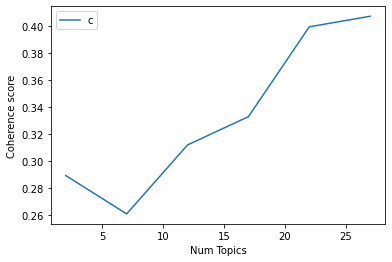

In [161]:
# Plot to see coherence score in order to choose optimal number of topics and decide optimal model
limit=30; start=2; step=5;
x = range(start, limit, step)
plt.plot(x, coherence_values_ph_2021_score1N2N3)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [162]:
# Print the coherence scores
index = 0
for m, cv in zip(x, coherence_values_ph_2021_score1N2N3):
    print("index:",index,"|","Num Topics =", m, " has Coherence Value of", round(cv, 4))
    index = index + 1

# optimal num_topics = 27

index: 0 | Num Topics = 2  has Coherence Value of 0.2893
index: 1 | Num Topics = 7  has Coherence Value of 0.2609
index: 2 | Num Topics = 12  has Coherence Value of 0.312
index: 3 | Num Topics = 17  has Coherence Value of 0.3329
index: 4 | Num Topics = 22  has Coherence Value of 0.3993
index: 5 | Num Topics = 27  has Coherence Value of 0.4071


In [187]:
# Select optimal number of topics
optimal_model_ph_2021_score1N2N3 = model_list_ph_2021_score1N2N3[5]

In [188]:
# pyLDAVis
pyLDAvis.enable_notebook()
vis_ph_2021_score1N2N3 = pyLDAvis.gensim_models.prepare(optimal_model_ph_2021_score1N2N3, corpus_ph_2021_score1N2N3, id2word_ph_2021_score1N2N3)

In [189]:
print("pyLDAVis for ph topics for score=1,2,3 in 2021:")
vis_ph_2021_score1N2N3

pyLDAVis for ph topics for score=1,2,3 in 2021:


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
10    -0.197075 -0.007592       1        1  9.478712
26    -0.025681  0.141049       2        1  6.287110
3     -0.073500  0.034707       3        1  6.257023
13    -0.004982  0.164675       4        1  5.844615
12    -0.014244  0.112381       5        1  5.568606
8     -0.109110  0.031180       6        1  5.533449
1     -0.139437 -0.047067       7        1  5.328608
0     -0.119155 -0.115914       8        1  4.258151
14     0.005637  0.002965       9        1  4.226128
5     -0.058165  0.001062      10        1  4.167930
18     0.021002  0.058297      11        1  4.024496
23     0.153421 -0.045288      12        1  3.893078
2     -0.021464  0.062259      13        1  3.851541
6      0.072453 -0.032107      14        1  3.611411
16     0.056081 -0.004620      15        1  3.541163
9     -0.123585 -0.114981      16        1  3.508497
4     -0.003286 -0.030041      17        1  2.855821
24     0.045460 -0.019576      18        1  2.410519
19    -0.023993 -0.050020      19        1  2.171115
21     0.115708 -0.117134      20        1  2.136489
25     0.054366  0.038819      21        1  2.134829
7      0.058542  0.017740      22        1  2.033839
15     0.085833  0.080798      23        1  2.033749
17     0.014485 -0.031008      24        1  1.725661
22     0.059942 -0.031047      25        1  1.417810
11     0.071124 -0.031321      26        1  1.141167
20     0.099622 -0.068214      27        1  0.558483, topic_info=          Term       Freq      Total Category  logprob  loglift
154    account  59.000000  59.000000  Default  30.0000  30.0000
52        post  30.000000  30.000000  Default  29.0000  29.0000
71       photo  26.000000  26.000000  Default  28.0000  28.0000
37     feature  30.000000  30.000000  Default  27.0000  27.0000
590         fb  11.000000  11.000000  Default  26.0000  26.0000
..         ...        ...        ...      ...      ...      ...
67   important   0.012752   4.368850  Topic27  -7.1527  -0.6489
140       hour   0.012752   4.683371  Topic27  -7.1527  -0.7184
159        log   0.012752  27.967435  Topic27  -7.1527  -2.5054
11        give   0.012752  10.566525  Topic27  -7.1527  -1.5321
117        day   0.012752  12.773262  Topic27  -7.1527  -1.7217

[1371 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
434      13  0.884763   ability
823       6  0.649320    abroad
500       4  0.647536       acc
153       8  0.437062    access
153      15  0.218531    access
...     ...       ...       ...
196       6  0.649320     yield
627       9  0.669817  youtuber
479       5  0.648883      youu
560      12  0.879720   zionist
905       2  0.641803      zoom

[1800 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[11, 27, 4, 14, 13, 9, 2, 1, 15, 6, 19, 24, 3, 7, 17, 10, 5, 25, 20, 22, 26, 8, 16, 18, 23, 12, 21])

# Export pyLDAvis as html

In [190]:
# Overall
pyLDAvis.save_html(vis_ph,'facebook_vis_ph.html')

# By-rating 
pyLDAvis.save_html(vis_ph_score1,'facebook_vis_ph_score1.html')
pyLDAvis.save_html(vis_ph_score2,'facebook_vis_ph_score2.html')
pyLDAvis.save_html(vis_ph_score3,'facebook_vis_ph_score3.html')
pyLDAvis.save_html(vis_ph_score4,'facebook_vis_ph_score4.html')
pyLDAvis.save_html(vis_ph_score5,'facebook_vis_ph_score5.html')
pyLDAvis.save_html(vis_ph_score1N2N3,'facebook_vis_ph_score1N2N3.html')

# By-rating of each year
pyLDAvis.save_html(vis_ph_2021_score1N2N3,'facebook_vis_ph_2021_score1N2N3.html')
pyLDAvis.save_html(vis_ph_2020_score1N2N3,'facebook_vis_ph_2020_score1N2N3.html')
pyLDAvis.save_html(vis_ph_2019_score1N2N3,'facebook_vis_ph_2019_score1N2N3.html')
pyLDAvis.save_html(vis_ph_2018_score1N2N3,'facebook_vis_ph_2018_score1N2N3.html')

